In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号



from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-30) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差


    #主动学习更新配位点数据    
    def update_data(self, X_u, u, X_f):
        mu_x, sigma_x = X_f.mean(0), X_f.std(0)
        X_u = (X_u - mu_x) / sigma_x
        X_f = (X_f - mu_x) / sigma_x

        self.mu_x = torch.tensor(mu_x).float().to(device)
        self.sigma_x = torch.tensor(sigma_x).float().to(device)
        
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:,0:1];u2 = u[:,1:2];u3 = u[:,2:3]; #将u的第一列、第二列、第三列分别赋值给u1、u2、u3
        u4 = u[:,3:4];u5 = u[:,4:5];u6 = u[:,5:6]; #将u的第四列、第五列、第六列分别赋值给u4、u5、u6
        u7 = u[:,6:7];u8 = u[:,7:8];u9 = u[:,8:9]; #将u的第七列、第八列、第九列分别赋值给u7、u8、u9
        u10 = u[:,9:10];u11 = u[:,10:11];u12 = u[:,11:12] #将u的第十列、第十一列、第十二列分别赋值给u10、u11、u12
        

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_4 = torch.autograd.grad(
            u4, x,
            grad_outputs=torch.ones_like(u4),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_5 = torch.autograd.grad(
            u5, x,
            grad_outputs=torch.ones_like(u5),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_6 = torch.autograd.grad(
            u6, x,
            grad_outputs=torch.ones_like(u6),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_7 = torch.autograd.grad(
            u7, x,
            grad_outputs=torch.ones_like(u7),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_8 = torch.autograd.grad(
            u8, x,
            grad_outputs=torch.ones_like(u8),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_9 = torch.autograd.grad(
            u9, x,
            grad_outputs=torch.ones_like(u9),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_10 = torch.autograd.grad(
            u10, x,
            grad_outputs=torch.ones_like(u10),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_11 = torch.autograd.grad(
            u11, x,
            grad_outputs=torch.ones_like(u11),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_12 = torch.autograd.grad(
            u12, x,
            grad_outputs=torch.ones_like(u12),
            retain_graph=True,
            create_graph=True
        )[0]


        #归一化
        u_x_1 = u_x_1 / self.sigma_x;u_x_2 = u_x_2 / self.sigma_x;u_x_3 = u_x_3 / self.sigma_x
        u_x_4 = u_x_4 / self.sigma_x;u_x_5 = u_x_5 / self.sigma_x;u_x_6 = u_x_6 / self.sigma_x
        u_x_7 = u_x_7 / self.sigma_x;u_x_8 = u_x_8 / self.sigma_x;u_x_9 = u_x_9 / self.sigma_x
        u_x_10 = u_x_10 / self.sigma_x;u_x_11 = u_x_11 / self.sigma_x;u_x_12 = u_x_12 / self.sigma_x

        #指定状态转移概率
        #对于元素1
        Lambda2_1_1=7; Mu1_2_1=100;
        #对于元素2
        Lambda2_1_2=10; Mu1_2_2=80;
        #对于元素3
        Lambda3_2_3=10; Lambda3_1_3=0; Lambda2_1_3=7;
        Mu1_3_3=0; Mu1_2_3=120; Mu2_3_3=110
        #-----------------------------------------------
        #计算ODE项
        ode_1 = -(Lambda2_1_1+Lambda2_1_2+Lambda3_2_3)*u1+Mu1_2_1*u2+Mu1_2_2*u3+Mu2_3_3*u4;
        ode_2 = Lambda2_1_1*u1-(Mu1_2_1+Lambda2_1_2+Lambda3_2_3)*u2+Mu1_2_2*u5+Mu2_3_3*u6;
        ode_3 = Lambda2_1_2*u1-(Mu1_2_2+Lambda2_1_1+Lambda3_2_3)*u3+Mu1_2_1*u5+Mu2_3_3*u7;
        ode_4 = Lambda3_2_3*u1-(Mu2_3_3+Lambda2_1_1+Lambda2_1_2+Lambda2_1_3)*u4+Mu1_2_1*u6+Mu1_2_2*u7+Mu1_2_3*u8;
        ode_5 = Lambda2_1_2*u2+Lambda2_1_1*u3-(Mu1_2_2+Mu1_2_1+Lambda3_2_3)*u5+Mu2_3_3*u9;
        ode_6 = Lambda3_2_3*u2+Lambda2_1_1*u4-(Mu2_3_3+Mu1_2_1+Lambda2_1_2+Lambda2_1_3)*u6+Mu1_2_2*u9+Mu1_2_3*u10;
        ode_7 = Lambda3_2_3*u3+Lambda2_1_2*u4-(Mu2_3_3+Mu1_2_2+Lambda2_1_1+Lambda2_1_3)*u7+Mu1_2_1*u9+Mu1_2_3*u11;
        ode_8 = Lambda2_1_3*u4-(Mu1_2_3+Lambda2_1_1+Lambda2_1_2)*u8+Mu1_2_1*u10+Mu1_2_2*u11;
        ode_9 = Lambda3_2_3*u5+Lambda2_1_2*u6+Lambda2_1_1*u7-(Mu2_3_3+Mu1_2_2+Mu1_2_1+Lambda2_1_3)*u9+Mu1_2_3*u12;
        ode_10 = Lambda2_1_3*u6+Lambda2_1_1*u8-(Mu1_2_3+Mu1_2_1+Lambda2_1_2)*u10+Mu1_2_2*u12;
        ode_11 = Lambda2_1_3*u7+Lambda2_1_2*u8-(Mu1_2_3+Mu1_2_2+Lambda2_1_1)*u11+Mu1_2_1*u12;
        ode_12 = Lambda2_1_3*u9+Lambda2_1_2*u10+Lambda2_1_1*u11-(Mu1_2_3+Mu1_2_2+Mu1_2_1)*u12

        
        #计算残差
        residual_1 = u_x_1-ode_1; residual_2 = u_x_2-ode_2; residual_3 = u_x_3-ode_3
        residual_4 = u_x_4-ode_4; residual_5 = u_x_5-ode_5; residual_6 = u_x_6-ode_6;
        residual_7 = u_x_7-ode_7; residual_8 = u_x_8-ode_8; residual_9 = u_x_9-ode_9;
        residual_10 = u_x_10-ode_10; residual_11 = u_x_11-ode_11; residual_12 = u_x_12-ode_12

        #计算损失函数
        loss_1 = torch.mean(residual_1 ** 2); loss_2 = torch.mean(residual_2 ** 2); loss_3 = torch.mean(residual_3 ** 2);
        loss_4 = torch.mean(residual_4 ** 2); loss_5 = torch.mean(residual_5 ** 2); loss_6 = torch.mean(residual_6 ** 2);
        loss_7 = torch.mean(residual_7 ** 2); loss_8 = torch.mean(residual_8 ** 2); loss_9 = torch.mean(residual_9 ** 2);
        loss_10 = torch.mean(residual_10 ** 2); loss_11 = torch.mean(residual_11 ** 2); loss_12 = torch.mean(residual_12 ** 2)


        loss_f = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7 + loss_8 + loss_9 + loss_10 + loss_11 + loss_12
        return loss_f, residual_1+residual_2+residual_3+residual_4+residual_5+residual_6+residual_7+residual_8+residual_9+residual_10+residual_11+residual_12
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = 100*loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
def get_system_performance(df):
    
    df['system_3.5'] = df['state_1']
    df['system_2.0'] = df['state_2']
    df['system_1.8'] = df['state_4'] + df['state_6']
    df['system_1.5'] = df['state_3'] + df['state_7']
    df['system_0'] = df['state_5'] + df['state_8'] + df['state_9'] + df['state_10'] + df['state_11'] + df['state_12']
    
    return df

state_column_names = ['state_1', 'state_2', 'state_3', 'state_4', 'state_5', 'state_6', 'state_7',
                      'state_8', 'state_9', 'state_10', 'state_11', 'state_12']

In [8]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0     

eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')

N_u = 1
N_f = 200

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 12]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([0.2])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0,0,0,0,0,0,0,0,0,0]])          # 初始真实状态


error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储混沌值
residuals = [] #创建一个空列表，用于存储残差值

i = 0


# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    N_f_1 = N_f // 100 #先拿50个点训练
    X_f_train = lb + (ub - lb) * lhs(1, N_f_1) #生成N_f个随机点
    nIter = 40000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f_train, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100)


    for iter in range(nIter//100+1, nIter+1, nIter//100): #每800次迭代
        N_f_new = N_f_1 * 10 #重新采样500个点
        X_f_train_new = lb + (ub - lb) * lhs(1, N_f_new) #生成N_f_new个随机点

        #计算残差
        _, residual = model.predict(X_f_train_new)
        abs_residual = np.abs(residual)
        abs_residual = abs_residual.flatten()
        #对abs_residual进行归一化
        abs_residual = abs_residual / np.linalg.norm(abs_residual)


        #计算混沌度
        y_chaos = model.hidden_predict(X_f_train_new, 100)
        x_ssss = X_f_train_new + np.random.normal(0, 0.001)
        y_chaos_ssss = model.hidden_predict(x_ssss, 100)
        chaos = np.linalg.norm(y_chaos - y_chaos_ssss,axis=1)
        #对chaos进行归一化
        epsilon = 1e-10
        norm_chaos = np.linalg.norm(chaos)
        if norm_chaos > epsilon:
            chaos = chaos / norm_chaos
        else:
            chaos = np.zeros_like(chaos)


        #计算信息量
        xinxi = abs_residual + chaos

        #选出信息量最大的10个点
        # 找出绝对值最大的10个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据
        X_f_train_topk = X_f_train_new[topk_indices]

        X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.update_data(X_u, u, X_f_train)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100)

    # print(X_f_train.shape)
    # 更新模型中的X_f_train数据
    model.update_data(X_u, u, X_f_train)

    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))


    # up = 80000
    n_star = 500+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
    y_pred = get_system_performance(y_pred_df)
    # y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
    y_star = eigenvector_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:, -5:],2)/np.linalg.norm(y_star.iloc[:, -5:],2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]))
    mse = np.mean((y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:,-5:],2)/np.linalg.norm(y_star.iloc[:,-5:],2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)





Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<00:58,  6.84it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 63.56it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 73.27it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 77.53it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 74.84it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 74.97it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 84.95it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 96.67it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 99.55it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 89.89it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 81.43it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 87.13it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 85.86it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 96.53it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 117.03it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 123.21it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:01, 108.77it/s]

Adam:  50%|█████     | 201/400 [00:02<00:01, 123.26it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:01, 115.10it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 108.89it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 106.09it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 96.69it/s] 

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 89.07it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 84.82it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 94.14it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 86.10it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 80.25it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 76.89it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 74.82it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 86.61it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 91.38it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 107.87it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 112.53it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 115.65it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 109.36it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.56it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 119.00it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 123.73it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 94.00it/s] 

Adam:  12%|█▎        | 50/400 [00:00<00:04, 80.64it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 85.42it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 85.20it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 86.17it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:03, 89.36it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 87.38it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 82.10it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 80.81it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 76.40it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.41it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 73.39it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 81.95it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 89.25it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 99.38it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:01, 106.70it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 92.86it/s] 

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 84.23it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 77.37it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 72.21it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 73.93it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 77.67it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 75.56it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 74.45it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 68.53it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 81.25it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 87.72it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 81.18it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 87.44it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 92.44it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 86.04it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 86.12it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 78.11it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 74.55it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 70.94it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 71.50it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 74.45it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 72.18it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.20it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 78.74it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 96.89it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 92.96it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 85.47it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 91.38it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 97.12it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 90.75it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 81.76it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 81.23it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 77.20it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 87.25it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 102.43it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 87.93it/s] 

Adam:  40%|████      | 160/400 [00:01<00:02, 88.16it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 87.12it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 85.40it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 83.05it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 80.40it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 86.28it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 87.43it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 81.54it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 83.63it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 98.40it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 108.14it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 105.07it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 99.22it/s] 

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 89.49it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 84.77it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 76.97it/s]

Adam:  81%|████████  | 324/400 [00:03<00:01, 73.02it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 70.12it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 81.80it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 82.27it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 84.02it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 95.68it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 86.28it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.04it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 83.52it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 97.07it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 101.64it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 102.52it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 107.24it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 91.21it/s] 

Adam:  22%|██▏       | 87/400 [00:00<00:03, 91.97it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 87.15it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 83.52it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 77.86it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 86.85it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 76.11it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 72.05it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 80.32it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:03, 77.91it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 77.24it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 72.94it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 70.56it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 68.30it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 66.24it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 74.69it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 71.64it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 72.42it/s]

Adam:  60%|██████    | 240/400 [00:02<00:02, 79.82it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 79.55it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 80.31it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 77.49it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 77.62it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 91.19it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:00, 99.67it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 94.52it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 90.54it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 82.02it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 75.89it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 71.94it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 67.95it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 63.86it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 63.29it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 74.14it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 83.54it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.11it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 89.63it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 89.48it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 80.77it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 69.60it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 65.70it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 64.01it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:05, 62.86it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:05, 60.86it/s]

Adam:  20%|██        | 82/400 [00:01<00:05, 60.08it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:05, 61.10it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 62.51it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 65.63it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 76.62it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 82.65it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 88.01it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 84.20it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:02, 84.42it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 74.23it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 80.51it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 73.18it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 74.53it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 86.46it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 90.69it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 86.85it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 76.88it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 74.95it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 77.47it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 68.94it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 65.37it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 68.15it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 66.12it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 68.43it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 77.22it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 70.59it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 67.02it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 65.75it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 61.54it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:01, 62.34it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 70.49it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 72.82it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 77.51it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 74.01it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 77.68it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 83.61it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 87.40it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 99.94it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 99.94it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 80.70it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 71.75it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 76.92it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 72.66it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 68.08it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 63.78it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 61.70it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 62.11it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 67.80it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 65.06it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 64.23it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:04, 64.81it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 74.50it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 78.97it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 80.63it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 84.72it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 81.04it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 85.91it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 75.37it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 73.37it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 79.96it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 83.85it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:01, 87.13it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 82.09it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 73.47it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 76.69it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 79.70it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 74.19it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 80.24it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 76.72it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 80.01it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 78.05it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 72.30it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 67.93it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 80.84it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 90.12it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 82.41it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 85.34it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 86.75it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 81.64it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.56it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 66.43it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 62.59it/s]

Adam:   7%|▋         | 28/400 [00:00<00:06, 59.50it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 62.34it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 62.36it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 76.71it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 87.97it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 78.02it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 72.97it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 84.12it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 83.42it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 88.64it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 81.25it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 86.41it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 84.30it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 83.96it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 79.76it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 87.04it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 86.90it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 83.95it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 85.34it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 86.38it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 76.01it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 74.31it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 79.73it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 81.45it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 74.45it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 70.36it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 71.62it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 70.90it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 82.97it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 74.93it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 76.12it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 83.98it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 85.01it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 88.34it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 76.58it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 69.89it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 67.19it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 76.90it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 77.54it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 78.80it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.97it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 66.00it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 63.89it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 69.67it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 72.16it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 74.44it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 74.54it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 74.11it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 74.08it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 74.67it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 76.24it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 72.54it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 73.89it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 82.84it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 82.76it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 83.84it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 75.61it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 78.21it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 88.92it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 93.28it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 86.05it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 79.42it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 74.55it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 70.47it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 70.58it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 68.92it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 78.45it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 89.75it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 95.91it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 95.93it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 97.31it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 88.46it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 93.73it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 85.20it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 79.71it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 77.61it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 74.66it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 85.65it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 88.73it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 93.84it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 86.83it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 81.74it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.38it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 63.71it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 78.82it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 71.05it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 67.20it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 67.81it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 75.47it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 84.84it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 79.33it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 76.06it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 73.66it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 71.00it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 71.96it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 71.18it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 70.42it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 68.10it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 77.15it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 71.83it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 72.39it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 75.48it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 86.84it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 89.88it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 97.93it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 99.40it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 92.79it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 86.20it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 84.08it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 75.75it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 74.98it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 72.56it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 71.81it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 73.55it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 69.60it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 69.94it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 67.93it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 70.86it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 70.58it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 66.29it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 73.74it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 71.77it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 66.22it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 64.81it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 64.35it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 67.02it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 67.48it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.01it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.89it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 87.80it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 77.37it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 68.97it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 66.17it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 71.72it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 79.75it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 73.43it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 82.16it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 79.18it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 74.30it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 70.75it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 69.53it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:04, 65.24it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:04, 63.43it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 69.60it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 81.75it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 86.51it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 92.60it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 90.76it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:01, 98.47it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 88.46it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 81.81it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 75.33it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 78.88it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 82.09it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 84.01it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 91.94it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 98.78it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:00, 104.19it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 95.47it/s] 

Adam:  80%|████████  | 321/400 [00:03<00:00, 90.43it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 82.49it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 78.47it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 81.02it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 73.50it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 73.60it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 72.47it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 70.13it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 69.59it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 56.56it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 59.38it/s]

Adam:   5%|▍         | 19/400 [00:00<00:06, 57.59it/s]

Adam:   6%|▋         | 26/400 [00:00<00:06, 58.87it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 66.86it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 70.53it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 65.02it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 74.36it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:03, 83.55it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 81.25it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 74.78it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 75.58it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 70.79it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 67.30it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 64.45it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 62.91it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:04, 59.75it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 65.93it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 65.63it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 62.78it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 60.35it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 66.20it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 75.11it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 80.46it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 88.38it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 84.45it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 77.94it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 71.85it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 65.95it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 71.87it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 67.93it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 77.09it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 83.26it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 83.76it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 84.44it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 82.90it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 80.52it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 81.64it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 89.49it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 97.94it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 91.81it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 99.43it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 94.32it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 89.42it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.11it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.09it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 90.24it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 87.69it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 94.52it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 92.74it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 85.35it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 75.55it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 78.03it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 84.18it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 83.97it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 74.54it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 73.64it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 82.54it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 72.95it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 72.94it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 70.88it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 69.91it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 77.09it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 73.79it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 74.96it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 73.90it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 87.18it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 90.25it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 87.94it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 90.75it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 82.76it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 89.62it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 83.37it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 82.60it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 78.49it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 77.03it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 71.87it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 75.34it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 70.82it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 69.00it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 66.33it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 66.34it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 73.50it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 82.96it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 85.56it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 76.74it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 85.18it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.70it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 90.68it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:04, 87.52it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 97.45it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 105.78it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 90.64it/s] 

Adam:  20%|██        | 80/400 [00:00<00:03, 81.65it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 74.72it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 72.95it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 78.56it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 75.35it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 69.80it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.91it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 73.34it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 64.91it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 63.64it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 68.41it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 72.82it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 73.01it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 70.83it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 72.49it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 79.63it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 89.14it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 96.06it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 97.51it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 89.74it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 77.14it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 84.77it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 90.57it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 92.60it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 99.04it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 88.54it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 85.88it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 90.76it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 79.45it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 73.54it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 75.90it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 71.27it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 77.95it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 76.11it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 54.64it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 57.36it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 65.81it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 63.96it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 65.17it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 66.59it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 65.36it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 68.62it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 76.74it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 77.44it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 86.38it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 73.22it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 70.75it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 79.39it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 80.69it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 73.05it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 74.21it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 78.47it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 71.85it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 68.44it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 80.67it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 84.50it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 74.00it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 73.87it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 74.98it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 73.98it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 80.38it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 75.32it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 69.59it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 71.18it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 71.16it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 69.34it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 74.69it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 79.23it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 82.77it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 78.63it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 75.14it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 78.82it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 78.47it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 81.83it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 79.81it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 74.40it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 79.27it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 80.51it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 73.59it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.85it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 61.44it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 59.16it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 72.38it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 66.68it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 71.54it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 67.94it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 70.00it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 71.30it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 76.46it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 68.64it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 66.30it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 65.20it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 67.90it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 78.32it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 75.63it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 71.03it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 66.08it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 66.33it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 69.11it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 74.37it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 67.87it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 73.38it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 77.32it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 80.64it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:02, 78.39it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 71.34it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 71.97it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 76.15it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 75.35it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 79.68it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 76.52it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 84.82it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 82.01it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 75.07it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 70.60it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 67.42it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 65.36it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 69.25it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 68.60it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 65.51it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 63.16it/s]

Adam:  89%|████████▉ | 355/400 [00:05<00:00, 61.91it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 66.55it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 66.42it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 63.22it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 67.06it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 64.43it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 66.98it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.32it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 73.88it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:04, 74.49it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 84.72it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 74.33it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 70.07it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 71.74it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 70.95it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 70.77it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 73.98it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 82.17it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 86.66it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 86.68it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 83.85it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 86.59it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 86.07it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 79.38it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 88.52it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 89.60it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 79.87it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 84.08it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 71.39it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 70.57it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 72.78it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 82.68it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 80.91it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 76.46it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 75.60it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 69.45it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 68.95it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 70.87it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 66.49it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 71.18it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 82.92it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 76.06it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 72.65it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 69.14it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 65.66it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 65.21it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 64.76it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 73.59it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 68.54it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 64.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 64.93it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.62it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 72.54it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 67.90it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 66.66it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 79.99it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 77.54it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 70.23it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 68.34it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 67.28it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 65.31it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 65.61it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 65.96it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 66.40it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 64.39it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 63.75it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 70.00it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 72.10it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:03, 68.96it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 76.23it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 72.86it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 73.31it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 77.57it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 73.32it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 69.98it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 81.24it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 77.60it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 72.24it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 68.63it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 74.15it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 80.91it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 79.56it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 75.37it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 79.04it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 69.87it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 73.43it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 83.66it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 82.81it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 73.20it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 76.22it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 82.14it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 90.74it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 92.22it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 87.91it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 79.03it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 71.53it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.80it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 79.54it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 76.52it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 76.64it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 67.89it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 67.38it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 72.04it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 66.62it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:05, 63.67it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 67.47it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 77.30it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 83.31it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 87.31it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 90.04it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 93.52it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 91.76it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 95.18it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 90.88it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 80.44it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 76.04it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 74.16it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 69.58it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 69.83it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 66.97it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 65.20it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 77.78it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 79.41it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 79.77it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 71.91it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 73.85it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 79.56it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 82.11it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 84.28it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 78.25it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 74.06it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 68.28it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:01, 65.50it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 61.33it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 66.65it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 65.81it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 65.67it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 73.16it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 86.62it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 90.28it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.07it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 60.29it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 79.13it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 75.27it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 69.07it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 81.09it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 85.29it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 84.41it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 74.51it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 68.50it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 67.45it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 72.33it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 68.41it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 65.51it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 69.20it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 66.46it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:04, 63.94it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 69.27it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 71.17it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 67.82it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 65.43it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 65.08it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 73.18it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 82.29it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 79.35it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 76.43it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 75.36it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 71.37it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 74.32it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 70.30it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 68.48it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 68.32it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 75.68it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 70.94it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 70.58it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 69.16it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 69.28it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 70.72it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 66.03it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:01, 65.76it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 71.36it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 79.14it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 77.89it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 73.07it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 73.99it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 86.54it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 75.92it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.50it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 69.09it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 78.01it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 68.45it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 64.82it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 68.44it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 72.78it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:05, 66.15it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 66.82it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 67.49it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 75.47it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 79.30it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 71.96it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 70.94it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 75.72it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 75.98it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 71.65it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 73.93it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 83.04it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 76.26it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 75.42it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 73.63it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 74.32it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 76.10it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 75.59it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 78.20it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 76.21it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 70.87it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 69.58it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 77.33it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 71.75it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 69.67it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 67.62it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 70.14it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 69.37it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 79.79it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 80.91it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 82.22it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 88.85it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 85.38it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 82.03it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 72.70it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 70.98it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 72.28it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 71.33it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 76.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.01it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.57it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 102.90it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 105.95it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 87.72it/s] 

Adam:  13%|█▎        | 53/400 [00:00<00:04, 83.25it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 88.20it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 82.21it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 82.51it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 82.76it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 78.52it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 78.16it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 77.20it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 85.98it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 89.36it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 94.19it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 88.45it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 79.76it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 83.89it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 84.08it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 74.26it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 76.62it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 71.19it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 72.08it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 79.85it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 81.30it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 77.84it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 72.75it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 74.34it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 71.90it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 78.56it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 80.51it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 88.14it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 81.18it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 83.48it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 70.93it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 74.97it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 67.47it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 66.01it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 68.01it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 67.97it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 65.85it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 62.11it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 74.49it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.14it/s]

Adam:   5%|▍         | 19/400 [00:00<00:05, 70.87it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 68.63it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 67.55it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 64.72it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 61.40it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 66.34it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 65.45it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 66.42it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 66.46it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 83.94it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 80.51it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 80.38it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 75.17it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:04, 68.07it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 72.91it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 67.68it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 69.45it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 68.30it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 65.02it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 73.21it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 67.63it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 70.12it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 80.33it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:02, 71.48it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 75.04it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 71.51it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 68.13it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 76.55it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 76.15it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 74.78it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 78.31it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 78.05it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 79.47it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 72.63it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 76.40it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 78.47it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 87.73it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 92.83it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 93.21it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 81.15it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 75.05it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 75.16it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 68.36it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 72.63it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:05, 77.60it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 67.82it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 65.08it/s]

Adam:   8%|▊         | 31/400 [00:00<00:06, 60.33it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 74.82it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 74.12it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 75.20it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 68.81it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 65.43it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 67.82it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 70.11it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 74.55it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 71.19it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 67.23it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 67.86it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 73.72it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 72.74it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 68.81it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 78.60it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 74.75it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 73.76it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 75.17it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 83.57it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 83.56it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 73.42it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 70.82it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 73.42it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 72.19it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 72.94it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 70.37it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 69.26it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 68.04it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 64.32it/s]

Adam:  71%|███████   | 283/400 [00:04<00:01, 61.64it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 64.80it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 70.76it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 72.81it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 76.75it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 75.95it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 75.31it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 85.26it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 74.85it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 70.38it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 74.36it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 76.74it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 85.64it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.17it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 67.92it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 79.47it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 82.66it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 91.59it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 83.75it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 72.52it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 71.93it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 65.87it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 71.65it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 69.88it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 68.98it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 75.65it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 85.64it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 86.26it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 77.13it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 75.08it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 74.20it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 79.28it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 79.95it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 73.96it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 69.83it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 75.94it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 82.03it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 83.15it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 85.72it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 88.87it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 88.01it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 82.05it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 88.18it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 88.07it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 77.50it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 75.45it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 73.33it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 69.62it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 67.00it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 72.96it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 70.72it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 66.68it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 66.41it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 64.60it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 70.33it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 79.52it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 77.25it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 67.36it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.06it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 78.75it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 79.00it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 85.02it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 87.94it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 77.13it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 78.17it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 74.22it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 70.72it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 72.33it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 78.61it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 89.08it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 84.73it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 82.37it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 74.18it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 78.47it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 75.51it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 76.03it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 70.64it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 77.91it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 87.39it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 84.26it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 81.00it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 80.74it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 75.44it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 70.46it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 76.86it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 78.40it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 78.81it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 83.99it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 77.51it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 70.53it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 68.27it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 68.53it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 72.87it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 80.43it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 82.92it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 79.56it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 76.78it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 71.96it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 73.58it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 73.72it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 79.21it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.97it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 66.67it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 66.83it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 69.84it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 69.09it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 75.16it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 72.74it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 77.68it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 77.46it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 72.08it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 69.55it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 71.04it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 76.67it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 85.31it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 83.11it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 84.92it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 81.18it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 71.05it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 74.49it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 82.14it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 83.34it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 77.48it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 69.44it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 70.18it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 81.66it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 77.90it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 70.33it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 71.98it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 69.61it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 71.37it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 70.70it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 79.54it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 75.70it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 71.14it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 75.87it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 73.08it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 67.55it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:01, 65.94it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 65.51it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 64.34it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 72.05it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 75.82it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 74.28it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 76.26it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 76.05it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.60it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 57.34it/s]

Adam:   4%|▍         | 18/400 [00:00<00:06, 58.01it/s]

Adam:   6%|▋         | 25/400 [00:00<00:06, 60.27it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 70.83it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 72.64it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 76.49it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 87.06it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 95.30it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 102.18it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:02, 103.65it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 86.99it/s] 

Adam:  30%|███       | 121/400 [00:01<00:03, 76.54it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 73.44it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 72.00it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 67.58it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 73.57it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 87.00it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 92.85it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 91.72it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 91.18it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 88.27it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 77.18it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 74.41it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 84.58it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 75.24it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 75.24it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 73.25it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 66.60it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 67.18it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 70.70it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 77.19it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 82.43it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 96.55it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 100.84it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 101.87it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 93.12it/s] 

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 79.10it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 75.69it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 83.25it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 86.39it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.36it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 66.43it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 63.31it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 62.09it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 66.47it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 82.18it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 84.40it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 75.17it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 69.95it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 69.34it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 76.68it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 87.94it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 75.32it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 70.83it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:04, 66.64it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 66.02it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 69.52it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 69.47it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 67.19it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 70.23it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 71.70it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 71.08it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 72.65it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 68.19it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 66.74it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 67.14it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 65.30it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 76.43it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 90.81it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 85.78it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 77.77it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 72.78it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 80.19it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 82.60it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 84.32it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 74.13it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 69.39it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:01, 68.57it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 75.02it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 69.13it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 68.48it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 63.45it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 62.15it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 61.84it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 67.39it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 71.31it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.28it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 68.59it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 71.86it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 73.47it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 65.07it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 68.63it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:05, 64.47it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:05, 63.86it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 70.06it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 81.00it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 79.91it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 89.46it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 82.76it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 78.13it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 77.21it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 72.57it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 72.62it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 71.12it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 67.33it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 69.33it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 68.95it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 73.81it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 70.54it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 71.60it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 80.87it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 76.84it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 75.22it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 75.49it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 79.03it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 73.76it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 75.26it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 69.27it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 74.42it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 75.75it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 69.45it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 65.42it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 64.04it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 63.25it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 71.34it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 78.95it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 71.39it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 68.34it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 71.82it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 68.66it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 71.06it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 81.32it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.13it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 69.42it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 81.81it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 74.08it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 80.25it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 77.85it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 77.42it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 68.96it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 70.51it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 83.19it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 78.34it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 81.92it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 75.25it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 70.77it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 72.51it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 72.42it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 67.48it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 66.03it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 71.68it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 75.88it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 79.35it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 80.67it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 78.97it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 69.69it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 65.48it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 67.09it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 62.82it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 61.90it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 67.85it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 68.25it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 67.50it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 65.25it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 62.30it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 75.71it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 72.79it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 76.12it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 73.02it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 76.45it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 81.54it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 83.54it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 80.37it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 72.93it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 83.56it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 79.20it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 70.10it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.52it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 98.56it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 86.98it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 80.48it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 73.14it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 75.83it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 75.57it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 70.68it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 67.89it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 68.18it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 66.14it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 68.62it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 70.80it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 70.51it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 80.74it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 73.65it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 73.56it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 80.45it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 89.67it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 82.60it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 70.95it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:03, 66.85it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:03, 64.53it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 63.94it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 73.82it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:01, 85.05it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 82.20it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 79.53it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 78.94it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 74.02it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 76.55it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 71.88it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 66.60it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 64.79it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 73.06it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 73.79it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 66.81it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:01, 63.96it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 62.86it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 62.26it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 68.61it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 79.48it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 80.06it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 78.68it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 76.56it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.35it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 68.30it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 64.58it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 79.72it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 92.38it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 92.27it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 87.26it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 86.67it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 75.62it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 72.26it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 75.53it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 73.76it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 70.06it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 70.53it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 68.94it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 73.47it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 71.03it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 78.53it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 76.11it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 70.49it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 66.87it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 63.89it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:03, 65.86it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:03, 62.94it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 64.04it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 62.85it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 64.54it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 68.07it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 70.22it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 71.88it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 66.48it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:02, 62.65it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:02, 61.65it/s]

Adam:  70%|███████   | 282/400 [00:04<00:01, 60.60it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 74.41it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 72.57it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 69.47it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 65.64it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 70.29it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 68.55it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 67.48it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 67.28it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 63.38it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 62.69it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 69.02it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 73.49it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 73.67it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 80.23it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 49.90it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 52.73it/s]

Adam:   4%|▍         | 18/400 [00:00<00:06, 55.42it/s]

Adam:   6%|▋         | 26/400 [00:00<00:06, 61.14it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 63.36it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 64.51it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 65.00it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 63.62it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 70.50it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:05, 63.64it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:05, 63.43it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:05, 59.66it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:05, 61.42it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 63.91it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 66.50it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 65.27it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 66.15it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:03, 68.04it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:04, 64.67it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 71.59it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 78.69it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 84.50it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 85.37it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 78.23it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 78.63it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 75.89it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:02, 69.06it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 66.28it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 70.34it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 72.23it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 76.75it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 69.65it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 72.26it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 76.02it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 75.88it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 78.43it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 81.16it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 80.05it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 73.94it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 73.22it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 67.60it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 65.58it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 71.88it/s]

Adam:  88%|████████▊ | 352/400 [00:05<00:00, 69.91it/s]

Adam:  90%|█████████ | 360/400 [00:05<00:00, 66.68it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 67.32it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 66.59it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 69.70it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 70.00it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.81it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 82.90it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:05, 71.78it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 78.96it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 82.72it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 85.20it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 87.30it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 82.36it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 82.52it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 79.67it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 77.06it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 87.14it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 88.42it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 95.08it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 91.13it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 83.79it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 74.71it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 78.24it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 76.78it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 83.92it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 76.71it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 70.55it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 66.66it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 72.13it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 72.52it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 74.42it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 68.65it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:02, 66.29it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 65.08it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 65.51it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 66.65it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 62.42it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 61.11it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 67.41it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 66.75it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 79.90it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 88.21it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 90.54it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 77.95it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 73.96it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 77.58it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 83.08it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 79.72it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.52it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.51it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 71.80it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 74.73it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 71.36it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 69.90it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 71.89it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 66.86it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 64.57it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 66.88it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 67.44it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 70.54it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 66.54it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 64.72it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 63.57it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 77.83it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 80.94it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 79.16it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 89.66it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 88.08it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 81.42it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 75.53it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 67.89it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:03, 63.60it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:03, 62.06it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 62.77it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 65.17it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 66.05it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 66.03it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 66.85it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 67.72it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 63.28it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:02, 61.27it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 62.83it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 66.89it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 72.50it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 79.36it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 83.48it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 79.06it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 72.62it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 70.17it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 65.46it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 76.35it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 75.75it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 80.99it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 79.18it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 80.58it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.48it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 60.48it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 64.80it/s]

Adam:   7%|▋         | 29/400 [00:00<00:06, 61.39it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 66.42it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 67.15it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 78.80it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 72.22it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 66.63it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 72.57it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 79.17it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 86.17it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 80.07it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 77.26it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 71.42it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 68.06it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 78.39it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 80.73it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 81.60it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 76.13it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 84.27it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 85.53it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 87.37it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 78.71it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 88.15it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:01, 95.96it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 102.15it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 85.78it/s] 

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 81.34it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 84.33it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 72.75it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 69.46it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 67.53it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 69.35it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 79.62it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 79.91it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 77.05it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 83.42it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 78.63it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 73.68it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 70.37it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 68.44it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 65.54it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 66.17it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.20it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.98it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.14it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 72.83it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 65.96it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 65.42it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 63.64it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:05, 64.27it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 68.92it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 65.60it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 62.71it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 69.75it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 74.74it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 75.31it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 71.55it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 68.30it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 78.70it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:02, 87.24it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 81.33it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 77.48it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 75.86it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 76.85it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 75.72it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 69.36it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 78.33it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 73.36it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 71.11it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 71.43it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 68.04it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 77.90it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 76.44it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 71.86it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 78.15it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 77.27it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 72.25it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 70.66it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 66.43it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 64.63it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 65.14it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:01, 62.08it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 59.98it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 70.10it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 73.82it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 68.97it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 64.60it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 67.29it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 75.83it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.51it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 69.51it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 73.30it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 75.10it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 76.29it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 76.13it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 82.37it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 84.36it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 74.50it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 78.51it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 72.21it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 74.02it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 82.84it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 76.66it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 78.84it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 73.67it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 70.76it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 72.64it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 73.10it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 75.80it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 73.67it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 68.25it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:03, 66.69it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 68.83it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 83.04it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 84.70it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 78.62it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 78.31it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 74.80it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 72.95it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 72.76it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 69.38it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 67.97it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 68.81it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 65.02it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 73.79it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 84.34it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 77.01it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 72.98it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 66.81it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 65.58it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 70.71it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 82.56it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 78.56it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 73.55it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.28it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 64.71it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 66.92it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 65.16it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 69.39it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 73.72it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 78.46it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 85.26it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 81.56it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 78.24it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 81.95it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 71.44it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 73.15it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 73.24it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 68.39it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 73.90it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 81.80it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 82.02it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 75.99it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 72.86it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 69.01it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 68.74it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 79.33it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 79.59it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 75.12it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 73.85it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 68.52it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 66.77it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 66.95it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 70.77it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 70.13it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 71.51it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 72.16it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 74.07it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 73.67it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 77.82it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 72.78it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 73.53it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 84.92it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 90.73it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 83.92it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 75.52it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 77.18it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 72.67it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 74.49it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 75.57it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 84.27it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 76.22it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 79.53it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 71.26it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 64.06it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 68.47it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 85.46it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 83.19it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 86.67it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 81.23it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 79.14it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 77.68it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 70.83it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 75.46it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 84.05it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 81.43it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 74.93it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 73.59it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 81.59it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 75.36it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 70.47it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 68.44it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 75.53it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 78.36it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 87.56it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 86.45it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 86.55it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 87.36it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 75.55it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 69.94it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 71.97it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 67.23it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 65.78it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 68.83it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 66.10it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 66.98it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 77.65it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 87.12it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 81.71it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 80.58it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 84.94it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 80.72it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 72.30it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.94it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 80.38it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 80.09it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 71.57it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 67.85it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 64.60it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 72.70it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 73.43it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 76.59it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 80.37it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 79.38it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 78.87it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 80.15it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 79.18it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 72.42it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 68.45it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 78.03it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 87.27it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 86.82it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 95.66it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 90.17it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 82.82it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 79.52it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 73.96it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 81.37it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 84.75it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 75.91it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 80.70it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 86.78it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 86.90it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 78.51it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 75.29it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 78.91it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 77.18it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 82.44it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 87.19it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 84.51it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 73.86it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 70.33it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 70.89it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 71.09it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 69.41it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.54it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 58.26it/s]

Adam:   4%|▍         | 18/400 [00:00<00:06, 55.80it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 63.03it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 76.32it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 73.03it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 67.84it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 72.41it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 76.36it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 81.58it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 87.83it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 85.87it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 74.78it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 71.01it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 68.44it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 68.43it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 66.68it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 64.48it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 69.20it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 67.19it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 62.34it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 60.16it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 64.28it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 63.59it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:03, 60.97it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:02, 68.21it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 70.54it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 67.35it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 72.77it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 79.74it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 84.11it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 83.24it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 78.28it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 79.14it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 84.47it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 85.22it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 84.75it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 85.81it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 76.31it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 71.19it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 67.58it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 66.77it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 80.04it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 72.14it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 68.16it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 71.07it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 82.45it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 88.27it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 76.36it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 87.51it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 76.12it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 74.23it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 81.23it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 76.62it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 69.35it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 66.10it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 63.29it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 65.72it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 62.99it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 62.92it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 66.64it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 69.87it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 75.18it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 79.09it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 80.27it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 82.93it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 86.50it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 76.96it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 72.60it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 73.56it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 77.46it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 80.70it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 82.59it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 75.20it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 75.42it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 73.52it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 66.43it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:02, 65.46it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:02, 61.78it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 68.00it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 72.43it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 67.01it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 67.12it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 66.06it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 62.86it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 59.77it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:01, 59.00it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:01, 57.67it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 62.82it/s]

Adam:  89%|████████▉ | 357/400 [00:05<00:00, 69.24it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 76.98it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 77.66it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 80.85it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 76.25it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.01it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 77.55it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 73.77it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 77.45it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 79.60it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 69.36it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 67.25it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 79.89it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 80.93it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 76.60it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 76.84it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 69.83it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 65.41it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 64.93it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:04, 64.59it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:04, 65.16it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 68.23it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 72.54it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 67.50it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 64.04it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 68.35it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 66.58it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 66.41it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 67.43it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 72.76it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 66.76it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 73.82it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 83.17it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 74.61it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 72.75it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 70.64it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 77.16it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 71.96it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 69.56it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 76.93it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 72.42it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 74.25it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 68.59it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 66.39it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 66.96it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 70.87it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 69.28it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 76.77it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 71.72it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 67.08it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 63.65it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 64.91it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.89it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.07it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 78.90it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 72.96it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 66.93it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 65.87it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:05, 62.44it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:05, 62.12it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 66.76it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 71.19it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 70.97it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 83.21it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 81.17it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 83.19it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 83.26it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 92.59it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 87.48it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 94.15it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 99.98it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 89.24it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 84.87it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 83.38it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 79.18it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 70.46it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 65.91it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 69.20it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 65.54it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 62.69it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 63.65it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 75.37it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 74.40it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 72.69it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 68.11it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 71.06it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 84.29it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 89.40it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 79.70it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 82.08it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 75.10it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 75.64it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 72.14it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 70.46it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 71.49it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 79.74it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.03it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 60.84it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 78.95it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 88.68it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 89.60it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 87.57it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 83.81it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 73.12it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 65.86it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 63.99it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 72.72it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 67.24it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 66.95it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 63.67it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 67.94it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 67.00it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 65.73it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 73.34it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 75.95it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 77.39it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 71.70it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 66.72it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:03, 65.76it/s]

Adam:  51%|█████     | 203/400 [00:02<00:03, 62.92it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 69.10it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 68.50it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 73.60it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 80.64it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 71.65it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 75.56it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 69.78it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 73.12it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 70.04it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 70.20it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 69.07it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 70.76it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 77.81it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 72.57it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 78.59it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 77.57it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 77.27it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 78.28it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 74.19it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 73.30it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 71.00it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 68.10it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.71it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 90.11it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 73.50it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 77.06it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 71.13it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 70.61it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:05, 63.83it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:05, 59.98it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:05, 62.23it/s]

Adam:  21%|██        | 83/400 [00:01<00:05, 61.41it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:05, 60.24it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:05, 60.24it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 62.74it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 64.97it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 74.40it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 85.66it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 81.59it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 74.08it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 75.39it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 76.80it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 70.46it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 67.44it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 74.61it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 82.34it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 87.21it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 76.84it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 78.87it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 73.83it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 76.26it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 86.67it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 96.68it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 86.43it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 75.01it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 71.97it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 81.26it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 72.93it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 68.78it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 66.21it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 65.33it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 65.69it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 71.83it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 70.80it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 70.37it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 66.42it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.48it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.04it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 80.54it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:04, 82.49it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 69.99it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 71.93it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 72.55it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 67.94it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 69.78it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 74.29it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 69.37it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 65.91it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 64.54it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 63.44it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 61.11it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 61.10it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 66.95it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:04, 64.02it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:04, 60.20it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 63.96it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 72.47it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 76.21it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 69.81it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 79.29it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 77.95it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:02, 73.67it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 69.75it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 67.06it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 70.20it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 82.47it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 91.96it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 90.89it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 78.32it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 75.96it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 84.13it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 76.61it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 70.49it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 73.32it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 67.56it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 76.51it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 76.93it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 79.19it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 77.39it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 82.81it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 78.82it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.81it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.60it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 64.11it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 64.18it/s]

Adam:   8%|▊         | 32/400 [00:00<00:06, 60.40it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 71.03it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 72.37it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 70.09it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 67.30it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 70.42it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 75.75it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 72.38it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 79.69it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 73.02it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 81.05it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 87.47it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 82.74it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 81.84it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 93.40it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 96.53it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 98.35it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 97.16it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 91.45it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 88.20it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 82.28it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 74.68it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 71.93it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 67.59it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 64.29it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 63.63it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 66.34it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 79.96it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 85.87it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 79.65it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 77.87it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 78.19it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 87.68it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 86.48it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 80.86it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 78.21it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 77.29it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 76.79it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 79.89it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 80.01it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 60.99it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.17it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 79.18it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 80.43it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 76.30it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 80.00it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 83.95it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 87.53it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 77.21it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 72.57it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 69.91it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 66.01it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 64.62it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 67.94it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 79.02it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 78.84it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 82.95it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 76.60it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 72.67it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 78.13it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 72.63it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 66.88it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 67.55it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 70.54it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 69.73it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 80.09it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 76.37it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 69.87it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 75.06it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 73.23it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 75.72it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 71.33it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 68.61it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 63.95it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 64.04it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 68.47it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 67.52it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 65.25it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:01, 65.25it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 65.64it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 67.18it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 69.25it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 66.08it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 74.46it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 80.22it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 79.31it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.75it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.29it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 64.32it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 63.26it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 68.71it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 67.26it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 68.39it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:05, 65.70it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:05, 65.66it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 66.23it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 77.92it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 82.62it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 80.34it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 74.04it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 69.24it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 74.02it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 72.59it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 70.49it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 83.89it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 85.16it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 87.37it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 81.56it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 83.30it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 79.05it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 75.02it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 75.19it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 78.30it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 76.87it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 76.25it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 79.24it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 79.49it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 81.48it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 78.79it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 75.22it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 70.50it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 65.88it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 64.54it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 75.18it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 68.16it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 68.90it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 75.81it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 75.86it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 70.79it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 76.85it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 72.50it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 70.54it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.44it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 86.20it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 86.18it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 79.01it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 75.78it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 81.18it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 79.20it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 78.99it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:04, 78.41it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 83.26it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 84.53it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 78.18it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 75.16it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 79.50it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 79.30it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 72.91it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 82.46it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 87.33it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 83.61it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 85.05it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 90.57it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 84.81it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 75.20it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 75.92it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 70.07it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 67.80it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 67.68it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 77.28it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 76.40it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 77.25it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 73.06it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 82.50it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 84.48it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 81.62it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 78.24it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 71.89it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 69.54it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 67.38it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 71.05it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 71.51it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 78.69it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 70.35it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 73.93it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 69.57it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.57it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 86.04it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 78.93it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 71.01it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 74.89it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 68.70it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 73.86it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 81.21it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 88.80it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 82.18it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 81.29it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 78.98it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 73.62it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 69.38it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 69.70it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 76.10it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 74.59it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 86.14it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 89.69it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 95.55it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 92.33it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 82.09it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 83.37it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 76.37it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 79.13it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 74.51it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 67.35it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 64.36it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:02, 62.24it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:02, 59.02it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 61.69it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 71.89it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 71.43it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 66.11it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 66.92it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 65.24it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 62.42it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:01, 63.51it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 67.57it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 77.81it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 74.58it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 75.87it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 72.37it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 69.35it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 66.79it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.27it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 66.62it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 64.23it/s]

Adam:   7%|▋         | 28/400 [00:00<00:06, 61.60it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 63.52it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 61.60it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 69.91it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 76.90it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 75.66it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 85.61it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 81.73it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 72.14it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 73.22it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 70.12it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 77.08it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 81.63it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 78.24it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 79.60it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 77.31it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 69.58it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 66.83it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 64.69it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 70.04it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 74.26it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 80.33it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 84.77it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 83.90it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 86.98it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 81.54it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 82.97it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 79.15it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 77.54it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 74.61it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 69.18it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 76.97it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 82.63it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 84.61it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 88.40it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 89.53it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 96.74it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 83.25it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 83.01it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 73.50it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 68.07it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 68.95it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.69it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 67.41it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 66.05it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 62.56it/s]

Adam:   9%|▉         | 37/400 [00:00<00:06, 58.48it/s]

Adam:  11%|█         | 44/400 [00:00<00:06, 59.31it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:06, 57.71it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 57.76it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:05, 62.24it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 66.01it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 65.78it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 71.47it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 75.70it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 70.26it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 67.51it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 75.16it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 73.66it/s]

Adam:  35%|███▍      | 139/400 [00:02<00:03, 71.10it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:02, 85.16it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 86.00it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 76.99it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 82.21it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 78.51it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 74.78it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 85.18it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 88.46it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:01, 90.40it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 82.87it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 75.04it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 73.06it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 73.96it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 82.01it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 74.68it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 70.74it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 68.44it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 73.12it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 69.91it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 66.92it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 72.71it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 74.57it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 81.12it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 75.44it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 69.52it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 71.67it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 80.09it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 84.33it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 68.21it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 65.10it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 67.96it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 64.25it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 61.13it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 66.20it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 68.31it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 70.96it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:04, 68.31it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 72.86it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 85.19it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 86.05it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 91.51it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 100.33it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 103.97it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 101.56it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 97.05it/s] 

Adam:  42%|████▏     | 167/400 [00:02<00:02, 93.54it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 89.04it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 78.52it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 76.32it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 72.56it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 76.38it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 80.88it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 79.12it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 75.14it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 67.94it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 69.60it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:02, 66.40it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 68.74it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 76.81it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 74.86it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 71.51it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 74.83it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 70.37it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 70.85it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 72.78it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 71.42it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 70.73it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 75.79it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 69.01it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 71.82it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 66.42it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 73.81it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.43it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.28it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 94.60it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 77.04it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 71.24it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 81.51it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 78.72it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 73.52it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 79.44it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 84.64it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 81.63it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 86.12it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 95.04it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 92.63it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 80.39it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 80.02it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 82.27it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 85.67it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 83.55it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 73.98it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 68.07it/s]

Adam:  50%|█████     | 200/400 [00:02<00:03, 64.56it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 69.05it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 73.67it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 78.71it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 87.85it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 86.22it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 78.98it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 72.30it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 80.02it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 73.38it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 74.32it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 72.91it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 78.36it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 86.35it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 76.46it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 73.30it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 74.12it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 68.34it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 69.90it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 73.17it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 68.77it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 73.07it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.01it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.19it/s]

Adam:   4%|▍         | 18/400 [00:00<00:06, 62.13it/s]

Adam:   6%|▋         | 25/400 [00:00<00:06, 59.51it/s]

Adam:   8%|▊         | 32/400 [00:00<00:06, 59.61it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 63.92it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 76.09it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 78.07it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 86.14it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 76.34it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 72.94it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 79.86it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 73.51it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 66.90it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 69.15it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 74.01it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 74.81it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 75.45it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 69.93it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 74.42it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 72.95it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 81.24it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 85.55it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 92.73it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 79.28it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 76.99it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 86.22it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 83.95it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 85.48it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 85.71it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 86.21it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 75.64it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 70.23it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 65.90it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 77.40it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 75.01it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 74.96it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 77.18it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 84.57it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 90.04it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 85.92it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 81.97it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 74.36it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 73.29it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.10it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.83it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 85.50it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 75.33it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 82.95it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 78.15it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 77.93it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 73.10it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 71.15it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 72.97it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 69.25it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 77.01it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 75.37it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 71.60it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 74.40it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 70.29it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 80.32it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 78.88it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 74.62it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 69.67it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 70.89it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 66.30it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 71.86it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 71.88it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 65.63it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 65.70it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 70.85it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 69.83it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 71.04it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 84.23it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 89.51it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 77.44it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 69.38it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 69.18it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 74.79it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 71.97it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 73.12it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 70.92it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 67.91it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 70.86it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 73.65it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 78.69it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 77.72it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 83.74it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 83.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.16it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 63.01it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 77.53it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 66.50it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 62.87it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 66.22it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 64.66it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 68.32it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:05, 64.40it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:05, 63.87it/s]

Adam:  21%|██        | 83/400 [00:01<00:05, 63.14it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 66.53it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 64.92it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 61.90it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 59.75it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 61.09it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 67.02it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:04, 64.14it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 67.16it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 78.11it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 80.62it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 81.22it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 76.53it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 71.90it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 70.24it/s]

Adam:  51%|█████▏    | 205/400 [00:03<00:02, 68.78it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:02, 66.79it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 66.09it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 67.23it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 67.98it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 79.03it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 79.45it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 80.30it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 79.96it/s]

Adam:  70%|███████   | 282/400 [00:04<00:01, 79.79it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 69.69it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 64.61it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 64.10it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 64.06it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 64.81it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 73.00it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 78.34it/s]

Adam:  87%|████████▋ | 348/400 [00:05<00:00, 71.00it/s]

Adam:  89%|████████▉ | 357/400 [00:05<00:00, 73.52it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 73.79it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 72.90it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 73.16it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 85.48it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.40it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 66.71it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 70.38it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 90.21it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 81.51it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 80.70it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 76.02it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 76.25it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 77.12it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 75.85it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 71.86it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 64.45it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 62.36it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 59.70it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:04, 63.77it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:04, 63.07it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 77.92it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 78.11it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 74.10it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 70.34it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 77.02it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 78.03it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 74.09it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 82.65it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 87.32it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:01, 89.95it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 80.35it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 80.23it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 86.50it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 76.10it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 77.01it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 70.78it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 69.16it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 74.64it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 75.82it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 76.80it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 84.41it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 85.79it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 87.52it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 83.54it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 82.42it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 83.97it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 90.84it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 81.57it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.41it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 76.26it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 84.54it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 79.14it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 84.13it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 84.42it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 84.61it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 85.52it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 82.89it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 80.45it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 71.35it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 67.48it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 66.84it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 77.94it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 83.15it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 80.76it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 77.65it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 69.05it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 72.28it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 68.66it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 66.92it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 63.00it/s]

Adam:  50%|█████     | 201/400 [00:02<00:03, 62.08it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 64.36it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 61.78it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 60.18it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 60.53it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 62.46it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 62.13it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 60.15it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 59.51it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:02, 63.72it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 69.38it/s]

Adam:  70%|███████   | 282/400 [00:04<00:01, 66.99it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 63.36it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 62.94it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 61.25it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 58.30it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 63.68it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 65.64it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:01, 62.17it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:01, 59.38it/s]

Adam:  87%|████████▋ | 349/400 [00:05<00:00, 65.56it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 63.90it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 64.15it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 61.62it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 58.71it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 58.54it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 61.92it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.26it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 67.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.38it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 64.21it/s]

Adam:   6%|▋         | 25/400 [00:00<00:06, 59.90it/s]

Adam:   8%|▊         | 32/400 [00:00<00:06, 61.29it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 63.89it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 61.17it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 60.33it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 64.78it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 71.91it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 72.70it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 68.77it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 66.25it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 68.14it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 79.60it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 79.05it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 91.44it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 93.43it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 84.25it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 77.34it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 78.45it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 70.33it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 84.11it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 94.80it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 99.75it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 90.17it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 91.24it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 81.56it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 73.24it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 68.61it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 65.28it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 63.88it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 69.03it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 69.94it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 77.44it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 74.74it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 78.55it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 69.72it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 68.96it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 65.73it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 63.55it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 77.34it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 72.92it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 82.09it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.42it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.86it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 98.61it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 85.41it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 69.55it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 80.97it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 72.65it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 70.39it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 71.27it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 66.33it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 62.69it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 61.77it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 70.54it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 65.01it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 63.15it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:04, 66.14it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 66.39it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 65.23it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 74.50it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 81.07it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 72.38it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 65.80it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 67.35it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:03, 66.17it/s]

Adam:  51%|█████     | 204/400 [00:02<00:03, 63.82it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 69.66it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 71.54it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 80.05it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 77.91it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 69.76it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 69.49it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 79.62it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 73.33it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 72.31it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 80.56it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 76.34it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 78.37it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 79.73it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 81.88it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 76.04it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 76.94it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 83.50it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 88.84it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 86.68it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 79.31it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 76.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.06it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 82.32it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 81.87it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 73.02it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 74.54it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 69.80it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 73.54it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 74.17it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 74.68it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 68.42it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 64.08it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 63.91it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 62.37it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 68.33it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 66.69it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 68.91it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 73.92it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 76.68it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 79.30it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 78.43it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 76.91it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 83.13it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 72.97it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 72.60it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 78.10it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 88.56it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:01, 96.15it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 96.00it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 102.44it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 96.66it/s] 

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 83.85it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 75.53it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 77.75it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 69.48it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 66.20it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 73.75it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 82.85it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 75.75it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 69.22it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 66.39it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 67.08it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 67.74it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 63.76it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 64.70it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 71.35it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:05, 75.74it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 65.86it/s]

Adam:   6%|▌         | 24/400 [00:00<00:06, 62.14it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 62.27it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 64.77it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 67.49it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 67.17it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 70.37it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 74.29it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 76.62it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 77.80it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 73.22it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 76.50it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 85.83it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 74.79it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 71.73it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 72.32it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 77.79it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 82.67it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 75.51it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 73.54it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 84.47it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 82.68it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 74.20it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 85.45it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:01, 84.53it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 75.85it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 67.58it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 65.17it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 71.78it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 73.47it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 65.92it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 63.54it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 67.78it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 69.39it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 71.79it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 80.48it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 81.84it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 79.84it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 79.74it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 83.68it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 81.95it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 72.89it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 79.59it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.83it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 66.26it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 75.86it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 70.59it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 72.86it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 67.21it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 75.21it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 86.83it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 88.29it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 83.95it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 89.30it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 97.56it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 89.09it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 75.82it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 68.80it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 64.73it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 61.93it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 61.63it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 60.74it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 65.22it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 64.15it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 59.98it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:03, 58.73it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 67.38it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 66.53it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 69.80it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 68.04it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 67.52it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 72.60it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 73.37it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 72.68it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 74.27it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 68.43it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 67.59it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 66.37it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 70.19it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 77.93it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 76.68it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 82.24it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 81.72it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 75.80it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 70.44it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 70.37it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 68.67it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 66.28it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 64.43it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 70.27it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.11it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 76.62it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 72.01it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 70.20it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 69.33it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 68.96it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 69.15it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 69.12it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 75.02it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 80.05it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 87.03it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 89.82it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 81.98it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 73.77it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 75.25it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 81.66it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 78.50it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 76.81it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 73.05it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 67.30it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 66.03it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 64.34it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 60.50it/s]

Adam:  50%|█████     | 201/400 [00:02<00:03, 59.60it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 72.79it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 67.00it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 69.43it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 66.43it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 62.13it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 63.74it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 61.71it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:02, 59.74it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 64.62it/s]

Adam:  70%|███████   | 282/400 [00:04<00:01, 66.16it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 64.97it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 87.22it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 83.08it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 73.53it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 66.31it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 64.30it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 62.55it/s]

Adam:  88%|████████▊ | 351/400 [00:05<00:00, 61.53it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 62.22it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 62.61it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 59.51it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 67.18it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 67.09it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 68.96it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 53.39it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 56.02it/s]

Adam:   4%|▍         | 18/400 [00:00<00:06, 57.26it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 63.17it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 64.65it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 61.56it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 71.66it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 79.38it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 84.13it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 93.53it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 93.54it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 86.06it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 75.53it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 79.13it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 73.46it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 72.79it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 69.18it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 67.01it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 63.60it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 65.20it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 68.71it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 70.60it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 64.78it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:03, 65.23it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 73.22it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 72.70it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 69.76it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 73.63it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 73.09it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 72.15it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 79.17it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 78.04it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 79.99it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 91.11it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 82.81it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 85.92it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 94.42it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 88.98it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 85.12it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 83.04it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 85.60it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 85.15it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 75.30it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 72.96it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 76.83it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 68.96it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 89.19it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 83.84it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 79.41it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 90.04it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 89.44it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 97.28it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 84.09it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 78.22it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 73.19it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 77.17it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 74.18it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 71.25it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 73.93it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 67.09it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 71.93it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 81.04it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 79.77it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 78.42it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 81.12it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 82.09it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 75.63it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 75.26it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 83.08it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 84.93it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 76.70it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 76.52it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 82.73it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 76.98it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 74.35it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 77.30it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 70.49it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 65.46it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 67.46it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 78.21it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 83.89it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 79.68it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 81.39it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 84.36it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 89.18it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 81.90it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 84.31it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.16it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 62.26it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 65.34it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 70.41it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 78.60it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 85.09it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 88.20it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 89.30it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 81.81it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 76.45it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 70.31it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 74.08it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 70.40it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 75.30it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 81.84it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 88.86it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 80.58it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 81.08it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 78.51it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 71.09it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 68.58it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 72.36it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 79.53it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 89.99it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 85.53it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 77.44it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 74.27it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 73.59it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 71.75it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 78.41it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 80.30it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 71.64it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 69.24it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 77.01it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 73.15it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 81.78it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 90.72it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 87.30it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 79.00it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 70.31it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 68.27it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 64.75it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 65.96it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 76.70it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.01it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 87.86it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:05, 73.61it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 68.92it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 67.59it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 71.55it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 70.39it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 74.80it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 78.88it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 73.75it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 68.11it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 73.57it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 73.31it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 67.41it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 70.05it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 70.78it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 77.42it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 81.38it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 83.46it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 75.92it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 74.73it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 74.00it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 74.22it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 80.36it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 73.99it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 68.85it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 72.68it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 67.97it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 72.74it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 71.99it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 67.02it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 66.23it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 75.51it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 74.65it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 79.45it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 88.18it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 95.85it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 89.33it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 81.16it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 80.29it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 77.13it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 71.97it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 78.73it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 74.22it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.49it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 61.00it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 57.79it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 68.95it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 72.79it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 70.46it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 67.26it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 74.08it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 67.89it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:05, 63.78it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 68.58it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 75.29it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 71.38it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 73.31it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 72.11it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 79.62it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 84.02it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 75.30it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 74.00it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 83.27it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 84.90it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 78.80it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 74.45it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 78.06it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 69.95it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 67.69it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 64.31it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 69.60it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 67.13it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 65.04it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 68.06it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 65.90it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 66.98it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 75.45it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 75.10it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 66.59it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 62.31it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 60.29it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 61.37it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:01, 60.06it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 64.32it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 73.49it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 70.49it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 63.86it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 64.34it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 68.11it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 67.71it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 69.01it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.28it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 83.58it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 93.28it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 87.83it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 75.61it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 81.82it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 84.97it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 87.21it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 83.14it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 74.44it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 70.16it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 66.86it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 65.22it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 62.64it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:04, 61.85it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:04, 63.14it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 68.36it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 74.66it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 72.89it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 63.86it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 67.75it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 69.83it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 79.95it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 71.92it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 69.59it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 68.10it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 66.86it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 68.11it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 63.96it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 65.82it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 68.51it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 71.37it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 70.74it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 65.97it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 61.46it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 72.34it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 76.90it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 82.75it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 73.28it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 69.11it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 67.61it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 70.54it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 66.26it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 66.07it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 76.52it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 84.01it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.38it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 92.74it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 79.46it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 71.99it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 69.00it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 64.59it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 74.00it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 76.60it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 82.37it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 80.55it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 83.61it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 75.74it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 70.86it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 71.17it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 69.89it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 64.84it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:04, 61.37it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 67.22it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 62.91it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 59.66it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 58.99it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 58.92it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 63.78it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 66.29it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:02, 64.07it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 64.88it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 62.10it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 67.49it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 64.57it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 71.68it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 65.22it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 62.18it/s]

Adam:  68%|██████▊   | 272/400 [00:04<00:02, 59.57it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:02, 58.92it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 71.67it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 73.16it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 85.40it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 86.65it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 80.39it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 73.14it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 71.97it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 82.80it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 84.18it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 77.41it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 69.44it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 65.57it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 65.35it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.17it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 98.13it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 85.57it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 71.69it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 66.74it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 74.02it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 71.56it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:05, 64.69it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 64.43it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 67.31it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 73.72it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 70.99it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 64.43it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 62.75it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 66.42it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 67.30it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:04, 64.20it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:04, 61.29it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 61.76it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 65.59it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 63.54it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 66.22it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 66.46it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 64.30it/s]

Adam:  50%|█████     | 201/400 [00:02<00:03, 62.69it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:03, 60.14it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 67.97it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 68.18it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 63.51it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 69.67it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 76.26it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 83.90it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 87.68it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 98.96it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:00, 105.15it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 89.53it/s] 

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 80.58it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 80.69it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 75.91it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 73.84it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 70.86it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 75.61it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 85.70it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 87.70it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 83.22it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.57it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 63.57it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 58.58it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 78.12it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 84.13it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 97.07it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 95.93it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 85.93it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 91.82it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:02, 101.59it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:02, 101.62it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 96.55it/s] 

Adam:  33%|███▎      | 131/400 [00:01<00:03, 88.02it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 76.61it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 72.65it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 74.32it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 78.24it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 86.17it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 95.35it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 80.95it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 73.48it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 81.83it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 78.09it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 76.80it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 83.54it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 89.70it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 81.12it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 74.69it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 72.86it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 80.68it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 80.91it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 88.70it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 80.68it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 82.60it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 80.35it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 90.26it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 97.24it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 83.53it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 80.25it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.53it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 71.52it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 70.78it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 80.55it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 76.53it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 79.39it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 82.15it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 79.55it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 89.49it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 92.87it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 80.02it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 79.58it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 78.72it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 74.24it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 82.70it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 87.07it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 97.13it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 97.72it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 91.29it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 86.66it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 105.41it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 98.69it/s] 

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 105.60it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 110.52it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 107.50it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 98.97it/s] 

Adam:  71%|███████   | 283/400 [00:03<00:01, 106.15it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 92.58it/s] 

Adam:  76%|███████▋  | 305/400 [00:03<00:00, 95.50it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 91.12it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 80.90it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 83.69it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 92.24it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 103.65it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 111.68it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 112.23it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 91.17it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.56it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 89.12it/s] 

Adam:   9%|▉         | 36/400 [00:00<00:04, 74.09it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 73.63it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 74.18it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 73.11it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 71.19it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 72.67it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 79.49it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 86.87it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 102.22it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 102.82it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 101.87it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 97.22it/s] 

Adam:  39%|███▉      | 156/400 [00:01<00:02, 86.51it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:03, 77.17it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 81.52it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 84.77it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 80.96it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 77.36it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 71.82it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 71.69it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 71.19it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 79.33it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 84.02it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 83.49it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 85.87it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 82.20it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 79.38it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 79.35it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 82.22it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 75.11it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 77.32it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 82.43it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 83.86it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 74.56it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 68.73it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 67.75it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 66.90it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 72.03it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 65.24it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 76.12it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.30it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 76.58it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 69.60it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 79.77it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 75.67it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 81.34it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 78.41it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 73.67it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 77.59it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 83.56it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 72.71it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 74.95it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 67.89it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 72.35it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 77.84it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 83.20it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 75.27it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 75.75it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 72.22it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 69.95it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 83.75it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 77.21it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 83.05it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 90.01it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 78.36it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 76.28it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 71.38it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 69.96it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 74.79it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 68.04it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 64.77it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 66.03it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 62.01it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 60.88it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 60.67it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 59.30it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 58.64it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 60.42it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 72.34it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 78.73it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 74.03it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 72.21it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 73.69it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 69.50it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 67.33it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 67.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.86it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 77.96it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 84.93it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 77.21it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 69.65it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:05, 62.75it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:05, 61.00it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:05, 65.53it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 68.14it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 63.40it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 62.63it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 59.80it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 60.28it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 69.41it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 68.05it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:04, 65.05it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 75.73it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 84.38it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 76.30it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 79.46it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 77.01it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 75.44it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 85.30it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 93.43it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:01, 97.75it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:01, 97.22it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 79.70it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 77.66it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 88.89it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 79.92it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 82.20it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 83.81it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 87.21it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 84.58it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 87.09it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 76.89it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 76.21it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 72.02it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 83.78it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 85.23it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 75.37it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 74.66it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 71.92it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.85it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 79.29it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 71.02it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 73.86it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 70.20it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 65.33it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 69.95it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 76.67it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 70.94it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 73.55it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 78.25it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 78.33it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 76.44it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 69.91it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 74.07it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 75.62it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 81.54it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 88.36it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 95.87it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 90.71it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 91.80it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 95.49it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 86.06it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 87.06it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 82.95it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 73.75it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 66.09it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 68.58it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 75.81it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 72.41it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 82.90it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 87.05it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 78.04it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:00, 85.31it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 76.05it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 87.90it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 93.12it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 79.31it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 76.38it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 70.27it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 66.20it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 78.22it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.53it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 70.92it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 74.15it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 68.06it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 82.05it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 97.99it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 98.55it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 89.66it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 88.19it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 80.71it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 78.15it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 76.01it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 84.44it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 85.05it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 89.49it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 88.92it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 93.72it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 87.70it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 90.86it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 81.18it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 94.14it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 98.87it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 92.27it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 92.38it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 86.98it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 90.07it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 85.72it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 89.05it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:00, 98.35it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 89.34it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 90.48it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 84.81it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 85.46it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 92.45it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 85.03it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 93.65it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 84.09it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 85.10it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.76it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 103.09it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 92.94it/s] 

Adam:  10%|█         | 42/400 [00:00<00:03, 94.24it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 88.15it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 93.78it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 98.22it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 84.99it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 93.08it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 85.31it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 77.98it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 85.49it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 84.04it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 89.07it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 100.32it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 96.19it/s] 

Adam:  46%|████▌     | 182/400 [00:02<00:02, 92.85it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 87.91it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 97.43it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 96.24it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 79.84it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 73.02it/s]

Adam:  60%|██████    | 242/400 [00:02<00:02, 70.99it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:02, 74.34it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 87.45it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 100.97it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 101.19it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 88.37it/s] 

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 78.32it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 77.18it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 80.45it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 75.93it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 73.98it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 74.33it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 72.71it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 76.72it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 72.83it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 74.65it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 75.85it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.08it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 74.98it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 68.84it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 86.29it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 100.08it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 102.61it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:14, 22.91it/s] 

Adam:  22%|██▏       | 86/400 [00:01<00:08, 34.94it/s]

Adam:  24%|██▍       | 97/400 [00:02<00:07, 43.11it/s]

Adam:  27%|██▋       | 107/400 [00:02<00:05, 50.36it/s]

Adam:  30%|██▉       | 118/400 [00:02<00:04, 59.31it/s]

Adam:  32%|███▏      | 128/400 [00:02<00:04, 65.98it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:03, 79.22it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 74.80it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 72.32it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 77.03it/s]

Adam:  45%|████▌     | 181/400 [00:03<00:02, 78.76it/s]

Adam:  48%|████▊     | 190/400 [00:03<00:02, 75.04it/s]

Adam:  50%|████▉     | 199/400 [00:03<00:02, 70.18it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:02, 76.89it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 84.26it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 81.31it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 78.00it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 77.25it/s]

Adam:  64%|██████▍   | 255/400 [00:04<00:01, 76.59it/s]

Adam:  66%|██████▌   | 263/400 [00:04<00:01, 73.28it/s]

Adam:  69%|██████▉   | 276/400 [00:04<00:01, 86.91it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 94.08it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 80.85it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 74.73it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 70.00it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 66.73it/s]

Adam:  83%|████████▎ | 331/400 [00:05<00:01, 67.09it/s]

Adam:  85%|████████▌ | 340/400 [00:05<00:00, 71.12it/s]

Adam:  87%|████████▋ | 348/400 [00:05<00:00, 66.54it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 68.82it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 76.97it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 83.48it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 76.81it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 81.97it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 67.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.96it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 72.91it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 68.04it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 74.51it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 70.66it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 84.64it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 90.04it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 88.96it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 77.20it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 71.53it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 67.10it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 64.32it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 67.27it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 78.10it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 79.35it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 77.19it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 89.12it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 82.28it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 75.37it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 67.61it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 71.96it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 67.95it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 66.47it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 64.78it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 62.54it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 65.67it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 63.12it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 64.94it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 64.50it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 73.18it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 69.36it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 69.95it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 71.86it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 84.72it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 75.25it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 71.28it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 73.31it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 74.39it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 76.47it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 75.28it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 80.32it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 70.51it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 70.46it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 77.22it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 74.49it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.04it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 84.21it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:05, 71.43it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 68.46it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 65.86it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 76.33it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 74.35it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 81.22it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 89.42it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 86.76it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 79.37it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 77.28it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 82.82it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 83.97it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 75.09it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 76.51it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 77.30it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 76.79it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 87.62it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 84.65it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 75.92it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 70.88it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 72.76it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 76.45it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 79.45it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 77.27it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 71.87it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 72.97it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 69.79it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 68.10it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 70.36it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 82.40it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 79.79it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 75.17it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 69.00it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:01, 68.91it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 75.32it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 75.11it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 81.80it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 75.04it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 73.92it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 70.14it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 67.19it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.16it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 84.52it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 93.08it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 111.12it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 103.97it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 118.09it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 94.37it/s] 

Adam:  23%|██▎       | 92/400 [00:00<00:03, 92.17it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 90.51it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 87.29it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 79.50it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 75.57it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 75.02it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 71.75it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 71.94it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 84.26it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 87.05it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 89.35it/s]

Adam:  50%|█████     | 201/400 [00:02<00:01, 103.79it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 90.78it/s] 

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 83.45it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 94.00it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 107.51it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 98.70it/s] 

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 95.41it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 105.69it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:00, 111.26it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 104.14it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 94.25it/s] 

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 94.21it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 94.16it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 83.56it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 79.71it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 76.84it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 76.25it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 72.93it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 73.98it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.31it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 119.46it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 123.99it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 108.46it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 89.44it/s] 

Adam:  18%|█▊        | 72/400 [00:00<00:03, 89.65it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 97.54it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:03, 96.86it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 87.44it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 88.63it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 101.28it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 118.67it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 131.93it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 107.89it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 112.18it/s]

Adam:  50%|█████     | 202/400 [00:01<00:02, 93.71it/s] 

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 85.00it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 82.57it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 76.18it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 82.53it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 93.16it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 90.59it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 87.98it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 85.34it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 80.74it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 87.55it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 87.70it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 94.39it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 94.61it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 85.74it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 85.23it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 77.07it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 73.31it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 69.49it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 67.29it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 65.94it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.10it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 66.28it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 74.16it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 67.92it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 74.37it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 95.69it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 105.85it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 103.64it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:02, 103.97it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:02, 106.14it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 99.11it/s] 

Adam:  32%|███▏      | 126/400 [00:01<00:03, 89.16it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 90.63it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 94.64it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 85.52it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 85.39it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 80.30it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 82.60it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 84.59it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 77.40it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 72.55it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 89.65it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 81.57it/s]

Adam:  61%|██████    | 244/400 [00:02<00:02, 77.98it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:02, 72.86it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 72.63it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 67.49it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 78.96it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 76.28it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 70.86it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 72.92it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 73.07it/s]

Adam:  81%|████████  | 323/400 [00:03<00:01, 76.40it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 69.95it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 68.73it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 67.89it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 68.84it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 66.51it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 66.61it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 75.78it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 68.90it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 65.12it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.16it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 69.90it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 64.92it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 72.34it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 81.65it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 70.62it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 70.95it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 72.57it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 68.59it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 78.36it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 76.15it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 71.44it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 70.63it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 67.91it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 65.87it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 68.37it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:04, 64.86it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 76.04it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 89.50it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 94.74it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 90.58it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 89.61it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 81.76it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 73.82it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 79.34it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:01, 84.41it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 76.45it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 81.29it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 72.50it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 70.60it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 74.19it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 73.57it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 72.82it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 69.18it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 66.42it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 64.28it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 64.91it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:01, 65.13it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 73.10it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 74.27it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 70.03it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 64.98it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 67.38it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 68.50it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 70.17it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.54it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 100.07it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 90.60it/s] 

Adam:  10%|█         | 41/400 [00:00<00:04, 77.46it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 72.63it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 80.17it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 77.88it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 86.37it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 94.28it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 88.00it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 82.38it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 80.42it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 82.90it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 85.05it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 83.49it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 82.70it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 79.44it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 78.57it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 78.43it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 69.82it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 76.01it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 82.79it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 74.33it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 68.38it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 65.69it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 77.94it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 77.64it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 72.33it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 72.46it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 84.41it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 81.86it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 71.99it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 65.82it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 75.77it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 74.39it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 76.03it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 72.88it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 74.27it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 80.01it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 81.55it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 88.08it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 85.79it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.76it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 74.39it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 63.97it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 77.07it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 81.00it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 79.05it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 72.05it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 69.82it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 72.39it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 80.98it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 72.87it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 67.27it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 65.83it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 71.12it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 78.03it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 77.89it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:02, 87.52it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 82.63it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 73.49it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 70.51it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 69.04it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 68.77it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 73.49it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 71.23it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 65.95it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 64.37it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 62.78it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 67.54it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 72.24it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 75.88it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 75.31it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 74.38it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 72.39it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 81.53it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 77.08it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 74.08it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 69.39it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 64.97it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 64.52it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 66.91it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 67.27it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 66.17it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 65.26it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 71.27it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 66.66it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 64.78it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 72.89it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 87.66it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 86.80it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 75.48it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 74.20it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 76.66it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 71.90it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 81.65it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 94.10it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 94.48it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 87.22it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 80.08it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 74.51it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 74.52it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 87.93it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 95.56it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 89.85it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 90.03it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 85.87it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 89.32it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 89.01it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 80.27it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 74.14it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 71.23it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 68.13it/s]

Adam:  60%|██████    | 240/400 [00:02<00:02, 66.36it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 68.11it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 82.63it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 83.30it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 84.29it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 75.68it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 78.87it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 73.34it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 72.52it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 79.06it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 78.86it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 79.82it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 93.18it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 80.86it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 83.90it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 84.29it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 87.56it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.31it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 78.90it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 69.24it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 70.42it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 90.64it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 102.85it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 97.41it/s] 

Adam:  22%|██▏       | 86/400 [00:00<00:03, 92.20it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 84.41it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 90.09it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 88.30it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 92.13it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 85.09it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 90.80it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 85.27it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 79.15it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 79.23it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 75.16it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 81.50it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 74.81it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 75.07it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 70.34it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 67.99it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 70.22it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 80.27it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 90.82it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 101.44it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 85.80it/s] 

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 82.09it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 93.41it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 99.19it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 88.43it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 81.61it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 90.79it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 98.47it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 83.50it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 84.56it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.76it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 87.78it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 91.00it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 84.80it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 79.01it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 71.48it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 71.55it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 76.03it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 78.25it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 79.79it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 86.89it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 92.61it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 96.68it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 94.80it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 94.42it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 88.15it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 87.73it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 90.67it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 92.68it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 91.51it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 87.64it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 83.10it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 71.55it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 78.15it/s]

Adam:  60%|██████    | 242/400 [00:02<00:02, 73.68it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 65.97it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 66.29it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 71.18it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 82.97it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 83.13it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 81.55it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 77.84it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 72.80it/s]

Adam:  80%|████████  | 321/400 [00:03<00:01, 69.68it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 71.92it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 69.54it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 66.77it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 72.76it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 69.89it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 70.04it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 69.56it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 71.33it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 69.75it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.00it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 88.36it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.62it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 89.00it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 82.05it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 74.54it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 68.43it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 68.24it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 68.28it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 65.30it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 67.59it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 66.55it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 80.75it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 77.94it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 71.45it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 68.87it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 69.37it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 76.55it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 90.59it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 95.82it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 97.34it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 87.02it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:01, 97.28it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 100.36it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 95.84it/s] 

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 86.45it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 81.93it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 74.04it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 75.31it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 75.83it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 78.15it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 80.94it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 74.20it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 72.82it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 74.89it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 70.79it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 68.33it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 72.43it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 72.28it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 86.38it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 97.40it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 90.89it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.12it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 70.69it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 68.70it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 65.07it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 63.31it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 64.36it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 65.69it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 72.35it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:04, 69.66it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 80.99it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 83.13it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 92.76it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 86.25it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 84.47it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 83.55it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 86.18it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 83.84it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 95.16it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 101.80it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 89.72it/s] 

Adam:  48%|████▊     | 194/400 [00:02<00:02, 87.65it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 76.14it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 71.40it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 79.08it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 85.54it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 86.45it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 83.93it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 74.86it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 68.24it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 66.23it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 64.74it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 71.06it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 83.32it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 81.21it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 77.23it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 77.34it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 77.08it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 72.92it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 84.52it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 84.17it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 75.98it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 70.60it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 67.48it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.33it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.48it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 75.73it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:04, 83.30it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 77.65it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 72.56it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 78.73it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 77.75it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 80.68it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 85.18it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 78.32it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 80.06it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 93.03it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 96.44it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 86.74it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 89.58it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 98.62it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 105.99it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 88.76it/s] 

Adam:  49%|████▉     | 197/400 [00:02<00:02, 85.40it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 75.71it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 70.28it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 66.02it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 68.07it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 65.18it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 62.87it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 68.04it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 70.97it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 68.12it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 69.76it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 68.10it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 64.23it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 64.12it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 75.78it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 80.25it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 69.69it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 64.15it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 75.02it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 75.83it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 77.98it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 80.06it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 82.37it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 83.11it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.82it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 92.26it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 79.84it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 86.95it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 82.42it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 81.65it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 86.61it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 85.36it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 73.10it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 74.30it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 71.86it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 68.09it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 75.05it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 80.95it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 70.92it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 66.61it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 66.96it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 67.47it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 66.72it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 72.58it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 80.19it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 79.61it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 78.32it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 73.54it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 68.19it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 63.82it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 65.23it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 63.28it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 62.38it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 68.16it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 73.93it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 77.25it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 82.77it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 81.02it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 85.26it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:00, 93.95it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 91.69it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 92.45it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 92.70it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 83.88it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 87.11it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 80.13it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 89.93it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 90.49it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.04it/s]

Training time: 529.9913
当前为第1次循环，种子为0
Error y : 5.781505e-03
MAE: 4.949410e-04
MSE: 4.085324e-06
Chaos: 8.518264e+02
Residual: 4.540743e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<01:34,  4.22it/s]

Adam:   2%|▏         | 8/400 [00:00<00:14, 27.50it/s]

Adam:   4%|▍         | 16/400 [00:00<00:08, 44.82it/s]

Adam:   6%|▌         | 22/400 [00:00<00:07, 49.72it/s]

Adam:   8%|▊         | 30/400 [00:00<00:06, 58.80it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 64.73it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 62.49it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 61.35it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:04, 71.55it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:03, 81.77it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 77.31it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 73.53it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 77.26it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 84.24it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 82.47it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 79.95it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:03, 83.66it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 73.70it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 68.88it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 68.38it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 67.71it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 72.27it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 73.13it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 77.72it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 85.42it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 84.33it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 78.28it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:01, 83.47it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 78.11it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 81.13it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 74.91it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 80.10it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 77.68it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 72.50it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 68.23it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 66.69it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 63.62it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 67.23it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 72.17it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 70.37it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 71.64it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 78.09it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 79.38it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 79.42it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 77.57it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 69.92it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 76.26it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.09it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 69.29it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 65.99it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 70.44it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 73.57it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 73.57it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 71.21it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 70.50it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 65.22it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 74.43it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 68.32it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 65.70it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 64.44it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 70.98it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 75.31it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 74.86it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 73.71it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:02, 88.23it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 96.02it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 100.35it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 100.65it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:01, 108.46it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 91.48it/s] 

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 81.67it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 77.60it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 76.68it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 77.54it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 81.82it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 78.78it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 70.40it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 68.51it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 70.50it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 77.78it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 75.85it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 71.59it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 71.20it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 69.76it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 73.57it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 66.50it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 64.63it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 68.23it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 66.43it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 72.78it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 68.31it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.31it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 95.32it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:03, 92.50it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 72.22it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 72.68it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 69.84it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 71.64it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 73.41it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 70.91it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 68.42it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 67.14it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 67.74it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 66.67it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 67.54it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:04, 67.55it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 76.51it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 70.32it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 75.10it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 78.53it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 79.43it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 78.76it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 82.72it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 88.69it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:01, 93.57it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 101.60it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 95.43it/s] 

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 84.48it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 85.12it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 86.34it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 88.88it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 78.58it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 82.24it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 83.84it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 86.38it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 85.38it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 82.88it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 72.28it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 69.29it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 67.33it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 73.57it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 68.49it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 66.24it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 70.91it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.36it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 61.83it/s]

Adam:   6%|▌         | 23/400 [00:00<00:06, 59.91it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 69.74it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 75.41it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 76.50it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 85.37it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 79.75it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 73.57it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 80.93it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 82.72it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 82.24it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 75.44it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 79.09it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 87.67it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 85.36it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 84.33it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 84.13it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 78.84it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 80.55it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 83.49it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 80.84it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 75.33it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 81.53it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 79.73it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 75.17it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 82.08it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 74.32it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 75.70it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 77.82it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 72.82it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 83.27it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 84.71it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 80.58it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 90.41it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 80.87it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 78.36it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 77.54it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 71.46it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 68.39it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 68.26it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 70.01it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 77.38it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.87it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 93.23it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 107.00it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 108.38it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 105.45it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 95.17it/s] 

Adam:  19%|█▉        | 76/400 [00:00<00:03, 86.23it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:04, 74.45it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 80.50it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 81.42it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 75.60it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 69.62it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 66.66it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:04, 63.92it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 66.10it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 77.13it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 82.77it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 76.02it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 83.64it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 89.75it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 78.62it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 71.29it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 67.88it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 66.18it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 73.58it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 71.92it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 70.26it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 75.77it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 81.25it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 74.72it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 83.13it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 80.47it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 72.77it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 79.05it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 71.78it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 74.51it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 72.03it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 70.01it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 71.45it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 73.54it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 71.76it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 78.98it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.99it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.38it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 80.24it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 81.69it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 68.28it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 68.87it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 68.85it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:05, 65.57it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 66.06it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 64.91it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 65.85it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 65.53it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 61.79it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 63.94it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 59.92it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 67.04it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 70.11it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:03, 68.70it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 69.39it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 65.12it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 65.20it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 67.16it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 65.69it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 65.06it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 81.41it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:02, 75.49it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 82.39it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 84.76it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 79.31it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 82.72it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 78.35it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 74.97it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 70.08it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 66.47it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 64.21it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 64.39it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 62.81it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 70.59it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 79.71it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 86.44it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 83.66it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 83.57it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 78.06it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 85.08it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 80.46it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 82.01it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 72.96it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.57it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 89.15it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 75.04it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 81.87it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 83.73it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 80.58it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 88.69it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 88.07it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 76.88it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 81.26it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 76.17it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 72.04it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 67.57it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:04, 64.30it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:04, 64.39it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 73.26it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 81.77it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 80.62it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 77.65it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 85.95it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 77.45it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 70.21it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 74.98it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 73.67it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 72.43it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 76.15it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 74.26it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 77.76it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 80.67it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 79.20it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 73.94it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 68.76it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 75.13it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 83.66it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 79.19it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 84.10it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 84.88it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 75.44it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 74.20it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 78.50it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 74.74it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 82.33it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 73.98it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.60it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 60.92it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 69.73it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 67.84it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 71.06it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 69.65it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 66.04it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 64.14it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:04, 71.56it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 75.50it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 80.82it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 73.63it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 84.11it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 84.65it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 73.52it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 75.03it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 83.05it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:02, 85.13it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 71.61it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 73.53it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 70.77it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 68.20it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 72.57it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 71.67it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 69.20it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 65.28it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 64.43it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 65.25it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 69.20it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 67.40it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 68.54it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 68.78it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 65.29it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 62.70it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 68.06it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 65.15it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 63.06it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 63.07it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 66.31it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 71.76it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 77.34it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 74.38it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 74.84it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 78.47it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 80.03it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 85.26it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 83.98it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.27it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 74.38it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 68.71it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 66.06it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 60.86it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 61.80it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 59.64it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 72.51it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 77.05it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 73.08it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 69.59it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 67.40it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 62.46it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 61.56it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 63.27it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 72.06it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:03, 74.97it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 69.56it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 70.09it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 68.21it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 66.00it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 67.36it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 63.34it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 63.26it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:03, 66.19it/s]

Adam:  52%|█████▏    | 206/400 [00:03<00:02, 65.70it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 73.80it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 76.21it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 69.68it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 69.95it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 67.62it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 71.72it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:02, 65.85it/s]

Adam:  68%|██████▊   | 274/400 [00:04<00:01, 69.07it/s]

Adam:  70%|███████   | 282/400 [00:04<00:01, 70.03it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 73.74it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 70.14it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 74.90it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 83.58it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 78.98it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 70.81it/s]

Adam:  86%|████████▋ | 345/400 [00:05<00:00, 64.91it/s]

Adam:  88%|████████▊ | 352/400 [00:05<00:00, 65.71it/s]

Adam:  90%|█████████ | 360/400 [00:05<00:00, 68.64it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 72.39it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 75.17it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 68.88it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 76.26it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.87it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 57.77it/s]

Adam:   4%|▍         | 18/400 [00:00<00:06, 56.61it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 67.25it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 70.70it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 71.37it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 66.26it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 65.07it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:04, 74.07it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 71.99it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 71.80it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 72.44it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 69.66it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 84.79it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 85.99it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 76.83it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 74.93it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 72.48it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 74.33it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 82.81it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 72.84it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 70.03it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 69.14it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 71.34it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 79.77it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 81.74it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 75.70it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 80.11it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 73.61it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 72.65it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 71.27it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 74.21it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 73.41it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 82.37it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 76.47it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 73.24it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 80.13it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 72.20it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 69.09it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 68.45it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 72.16it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 80.35it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 83.73it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 78.91it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 75.45it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.45it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 68.03it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 65.54it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 68.55it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 70.24it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 72.86it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 68.88it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 71.75it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 81.56it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 83.29it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 84.53it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 87.94it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 79.70it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 72.45it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 74.10it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 67.03it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:04, 64.30it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:04, 62.82it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 63.38it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 63.34it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 65.44it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 66.28it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 69.83it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 79.74it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 77.17it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 70.43it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 67.30it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 71.39it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 67.22it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 64.19it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 60.29it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 59.66it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:02, 59.32it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:02, 59.82it/s]

Adam:  70%|███████   | 281/400 [00:04<00:01, 64.99it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 64.98it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 62.13it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 62.61it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 66.84it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 77.59it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 87.01it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 79.08it/s]

Adam:  88%|████████▊ | 352/400 [00:05<00:00, 75.40it/s]

Adam:  90%|█████████ | 360/400 [00:05<00:00, 71.57it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 67.99it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 66.86it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 65.62it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 63.91it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 63.01it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.90it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.84it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 72.79it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 76.35it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 87.72it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 78.97it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 76.98it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 75.53it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 76.89it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 79.93it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 71.86it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 66.94it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 79.22it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 82.41it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 72.59it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 69.57it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 76.48it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 74.02it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 76.38it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 74.20it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 70.40it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 82.72it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 80.40it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 76.25it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 79.08it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 79.21it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 72.28it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 75.78it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 90.10it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 99.36it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 93.71it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 84.30it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 75.97it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 73.64it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 69.59it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 71.46it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 65.98it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 63.56it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 62.38it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 62.20it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 64.05it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 72.52it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 74.99it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 68.86it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.51it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.97it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 72.70it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 85.44it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 91.92it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 87.78it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 83.58it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 70.52it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 65.24it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 64.35it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 71.64it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 67.76it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 75.98it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 81.17it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 83.34it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 86.58it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 80.18it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 80.36it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 77.34it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 82.98it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 87.21it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 91.95it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 95.42it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 82.07it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 91.71it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 89.14it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 96.83it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 95.82it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 82.44it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 72.83it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 71.78it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 79.14it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 85.33it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 90.31it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 99.70it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 104.68it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 105.50it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 109.28it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 107.32it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.03it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.72it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 62.72it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 76.22it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 80.88it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 85.74it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 84.68it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 81.01it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 73.63it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 72.92it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 65.36it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 61.56it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 75.06it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 78.17it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 71.59it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 67.52it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 67.64it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 67.12it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 66.62it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 74.43it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 74.79it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 68.82it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 78.81it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 74.02it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 81.49it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 77.21it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 82.02it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 86.25it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 84.71it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 72.97it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 79.25it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 81.65it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 87.33it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 85.35it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 79.39it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 68.63it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 73.30it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 76.56it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 85.24it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 88.56it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 88.60it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 95.13it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 97.74it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 83.92it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 55.76it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 55.98it/s]

Adam:   5%|▍         | 19/400 [00:00<00:06, 61.95it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 75.65it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 93.37it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 97.54it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 100.98it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 93.71it/s] 

Adam:  22%|██▏       | 86/400 [00:01<00:03, 82.55it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 88.77it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 80.30it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 85.12it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 76.76it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 72.33it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 68.31it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 70.65it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 75.60it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 80.32it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 85.06it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 81.51it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 84.51it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 82.99it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 85.80it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 81.05it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 77.47it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 76.60it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 68.59it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 72.57it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 81.90it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 84.22it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 74.97it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 75.02it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 68.71it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 66.89it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 68.71it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 65.88it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:01, 62.98it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 68.66it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 67.02it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 71.60it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 81.04it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 81.53it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 80.82it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.45it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 77.87it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 84.87it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 90.31it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 94.39it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 97.88it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 97.20it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 98.18it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 92.72it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 84.55it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 80.45it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 82.57it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 78.53it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 74.79it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 72.02it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 76.29it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 84.46it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 78.66it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 78.94it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 87.08it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 82.09it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 73.72it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 77.33it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 77.45it/s]

Adam:  60%|██████    | 242/400 [00:02<00:02, 77.35it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 73.25it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 72.19it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 69.31it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 64.67it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 70.39it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 72.10it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 66.13it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 63.18it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 74.74it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 79.99it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 80.63it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 77.31it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 72.94it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 72.54it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 73.89it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 73.06it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 85.75it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 82.81it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.97it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.72it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 91.39it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 76.01it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 82.75it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 73.35it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 72.31it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 76.74it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 73.42it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 74.56it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 79.90it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 77.76it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 74.25it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 73.27it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 68.32it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:04, 63.63it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:04, 62.30it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 61.77it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 67.52it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 64.36it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 66.60it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 79.65it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 81.19it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 77.10it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 80.05it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 69.82it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 73.18it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 77.00it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 82.54it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 75.48it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 78.05it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 88.67it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 81.60it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 77.16it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 69.50it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 71.72it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 71.99it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 71.74it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 75.77it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 70.96it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 66.14it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 77.21it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 72.76it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 66.55it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 66.07it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 56.69it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 62.21it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 68.44it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 63.23it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 67.15it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 69.15it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 68.25it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 65.67it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 73.87it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:03, 81.52it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 75.07it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 80.46it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 85.55it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 75.88it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 68.75it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 68.08it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 70.32it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 70.42it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 73.93it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 74.19it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 75.29it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 74.40it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 66.18it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 68.57it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 78.57it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 87.89it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:01, 95.67it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 96.16it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 99.28it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 94.49it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 85.02it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 74.66it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 68.88it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 71.24it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 72.87it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 79.07it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 86.43it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 84.91it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 90.17it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 76.41it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 73.61it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 67.28it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 62.85it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 64.43it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.25it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 107.20it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 95.46it/s] 

Adam:  11%|█         | 43/400 [00:00<00:04, 85.19it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 71.54it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 67.54it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 72.02it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 73.88it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 72.15it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 71.33it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 67.19it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 73.47it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 84.40it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 90.45it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 75.13it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 72.95it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 69.56it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 72.04it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 76.13it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 75.67it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 81.77it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 82.49it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 88.40it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 91.03it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 82.29it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 73.80it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 78.35it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 84.85it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 84.64it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 77.31it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 72.23it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 75.14it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 71.38it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 72.61it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 66.17it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 69.43it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 66.48it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 64.36it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 72.25it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 82.60it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 84.45it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 84.06it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 87.23it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.04it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 95.73it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:03, 93.21it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 94.94it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 95.14it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 96.33it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 97.03it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 94.42it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:03, 92.26it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 97.25it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 90.24it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 84.25it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 73.46it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 72.28it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 79.59it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 83.24it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 89.49it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 91.55it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 92.29it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 89.73it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 79.00it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 72.93it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 70.04it/s]

Adam:  60%|██████    | 240/400 [00:02<00:02, 68.22it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:02, 65.07it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 65.89it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 71.14it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 76.98it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 76.17it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 68.98it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 80.86it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 84.35it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 92.60it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 96.00it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 84.29it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 76.24it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 75.65it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 70.92it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 67.65it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 67.66it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 65.10it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 63.60it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 97.95it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 108.25it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 94.77it/s] 

Adam:  11%|█         | 43/400 [00:00<00:04, 83.06it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 83.49it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 72.32it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 73.37it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 75.80it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 69.99it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 78.78it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 86.35it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 76.10it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 69.62it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 81.37it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 79.47it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 71.85it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 69.27it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 73.86it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 68.66it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 78.41it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 83.63it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 91.50it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 89.03it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 79.47it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 71.09it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 67.66it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 65.32it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 76.81it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 84.31it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 91.03it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 88.79it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 80.61it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 78.72it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 72.57it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 66.96it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 64.20it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 76.89it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 76.14it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 72.81it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 76.97it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 75.85it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 71.63it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 53.50it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 61.67it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 85.39it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 72.82it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 70.14it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 78.26it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 72.58it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 68.63it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 65.82it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 68.32it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 72.11it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 72.12it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 67.55it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 66.01it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 69.76it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:04, 66.41it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 74.17it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 76.58it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 78.94it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 90.06it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 89.99it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 96.81it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:01, 99.16it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 103.96it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 94.40it/s] 

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 87.48it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 90.48it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 91.08it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 92.07it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 93.10it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 82.26it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 72.69it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 74.40it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 79.56it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 78.47it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 80.09it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 82.11it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 85.18it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 84.34it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 93.50it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 94.20it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 82.07it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.28it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 72.20it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 88.33it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 74.21it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 70.47it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 72.03it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 71.23it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 66.90it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 72.97it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 81.14it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 79.73it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 88.67it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 81.82it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 76.14it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 79.87it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 72.92it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 72.14it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 70.83it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 67.31it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 72.70it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 83.11it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 79.99it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 75.78it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 80.86it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 77.61it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 81.19it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 83.80it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 76.59it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 71.35it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 75.76it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 72.59it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 71.05it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 67.78it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 74.77it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 83.50it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 87.27it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 79.53it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 87.40it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 76.91it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 80.66it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 73.56it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 84.66it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.45it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 60.41it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 66.35it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 64.30it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 69.91it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 65.31it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 62.63it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 60.48it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:04, 67.93it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 75.62it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 83.58it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 89.66it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 96.54it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 78.20it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 83.32it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 87.03it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 81.92it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 87.53it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 78.98it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 84.71it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 78.40it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 71.41it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 70.73it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 78.87it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 80.66it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 74.78it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 83.28it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 84.80it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 84.90it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 90.65it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 93.64it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 85.22it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 91.02it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 78.93it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 82.97it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 77.86it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 73.20it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 74.40it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 70.86it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 64.98it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 64.28it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 70.49it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 65.89it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 52.55it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 53.56it/s]

Adam:   5%|▍         | 19/400 [00:00<00:06, 60.11it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 68.41it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 68.53it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 65.86it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 71.94it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 73.76it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 72.19it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 78.70it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 84.02it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 76.36it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 80.88it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 90.61it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 79.72it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 82.09it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 80.49it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 73.88it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 70.75it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 67.32it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 66.35it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 74.24it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 75.50it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 67.75it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 66.66it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 63.71it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 62.25it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 63.52it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 61.91it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 60.42it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 65.72it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 64.97it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 68.58it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 74.44it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 86.61it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 80.55it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 79.60it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 71.53it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 72.93it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 70.67it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 69.17it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 64.64it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 61.22it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 60.05it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 66.01it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 76.52it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 84.25it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.32it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 63.42it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 72.95it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 66.51it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 69.36it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 69.50it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 71.08it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:05, 65.52it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 67.98it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 64.80it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 64.63it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 74.19it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 71.15it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 68.01it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 66.08it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 72.04it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 80.60it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 78.90it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 88.69it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 76.95it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 74.08it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 72.04it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 79.07it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 78.08it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 71.21it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 77.25it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:01, 85.91it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 90.61it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 94.19it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 83.22it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 91.66it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 93.59it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 86.86it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:00, 89.03it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 92.53it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 87.56it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 90.61it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 90.41it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 83.62it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 80.71it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 71.71it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 69.38it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 67.16it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.78it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 82.20it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 86.86it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 76.48it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 68.88it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 65.87it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 67.42it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:05, 65.13it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 71.50it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 77.46it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 76.60it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 76.92it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 79.13it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 80.89it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 74.38it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 66.68it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 64.15it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 73.73it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 79.95it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 87.81it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 88.91it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 95.52it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 91.77it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 86.39it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 74.59it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 77.67it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 84.48it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 81.60it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 86.77it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 84.24it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 79.15it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 78.54it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 68.46it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 64.61it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 63.40it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 63.61it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:01, 62.93it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 68.49it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 77.72it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 85.73it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 88.10it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 77.37it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 71.13it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 72.53it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 60.25it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 65.14it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 66.78it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 63.42it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 63.98it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 65.92it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 68.52it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 76.65it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 72.41it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 73.24it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 73.53it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 80.64it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 77.29it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 80.17it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 78.91it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 70.71it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 66.54it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 64.37it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 68.37it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 70.43it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 69.84it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 77.51it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 74.77it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 82.41it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 72.75it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 74.45it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 76.87it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 76.74it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 81.28it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 77.68it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 82.56it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 72.13it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 71.94it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 83.23it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 81.36it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 81.39it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 75.70it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 70.92it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 71.59it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 73.30it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 69.97it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 66.66it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 64.72it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 67.44it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 65.87it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 61.35it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 58.64it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 57.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.86it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 76.80it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 74.00it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 73.62it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 70.08it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 66.76it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 68.05it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:05, 65.53it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 75.94it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 81.37it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 84.92it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 85.66it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 74.68it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 70.78it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 69.30it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 69.17it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 67.05it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 70.25it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 64.51it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 68.71it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 65.87it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 66.50it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:03, 65.83it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 70.10it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 74.41it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 83.28it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 78.83it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 70.15it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 65.23it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 63.16it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 65.21it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 66.44it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 67.94it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 78.77it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 83.32it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 87.01it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 89.92it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 77.68it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 74.12it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 73.38it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 72.66it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 79.95it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 85.16it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 88.22it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 91.82it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.44it/s]

Adam:   4%|▍         | 18/400 [00:00<00:06, 61.68it/s]

Adam:   6%|▋         | 25/400 [00:00<00:06, 60.11it/s]

Adam:   8%|▊         | 32/400 [00:00<00:06, 60.67it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 71.54it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 85.81it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 79.33it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 70.75it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 71.48it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 78.78it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 71.40it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 67.54it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 65.78it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 64.50it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 62.15it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:04, 62.31it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 66.29it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 69.21it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 69.20it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 67.94it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 72.42it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 82.76it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 80.28it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 74.55it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 72.68it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 70.76it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 68.97it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 66.80it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 68.42it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 80.68it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 88.23it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 91.61it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 87.58it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 80.53it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 84.03it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:00, 85.39it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 73.56it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 70.16it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 66.96it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 74.07it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 71.66it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 71.03it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 65.10it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 62.68it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 71.09it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.92it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.82it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 72.25it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 92.22it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 104.58it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 109.34it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 109.00it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 104.57it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 105.22it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 88.38it/s] 

Adam:  27%|██▋       | 107/400 [00:01<00:03, 89.52it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 97.45it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 100.95it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 100.64it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 92.11it/s] 

Adam:  41%|████      | 163/400 [00:01<00:02, 84.89it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 91.36it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 79.36it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 77.81it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 80.46it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 82.72it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 88.62it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 90.58it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 93.22it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 93.29it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 91.32it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 92.79it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 90.03it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 84.25it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 91.34it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 96.24it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 87.29it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 82.70it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 78.32it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 81.29it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 79.43it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 73.89it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 69.10it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 67.05it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 67.47it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.87it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 74.41it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 90.14it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 89.62it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 91.81it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 94.39it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 96.20it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 99.62it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 90.02it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 76.22it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 70.03it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 69.78it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 71.88it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 73.19it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 71.33it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 75.80it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 85.34it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 82.41it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 85.51it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 92.11it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 95.95it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 104.34it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 84.62it/s] 

Adam:  60%|██████    | 240/400 [00:02<00:01, 83.04it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 74.11it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 75.34it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 74.33it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 68.70it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 67.61it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 64.54it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 60.96it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 62.52it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 76.42it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 76.16it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 72.04it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 72.75it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 79.03it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 83.45it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 80.95it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 74.60it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 80.80it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 89.20it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.47it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 65.95it/s]

Adam:   6%|▋         | 25/400 [00:00<00:06, 61.41it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 68.80it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 71.99it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 82.01it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 85.75it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 77.15it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 75.65it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 68.28it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 66.12it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 70.24it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 76.22it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 73.70it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 75.45it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 73.70it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 74.78it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 74.20it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 67.39it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 64.65it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 65.94it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 63.99it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 68.32it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 70.65it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 66.36it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 66.64it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 77.91it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 76.22it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 77.76it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 78.31it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 69.54it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 72.10it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 70.10it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 78.59it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 84.33it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:00, 95.68it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 96.61it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 81.84it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 82.61it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 86.23it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 77.77it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 71.72it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 72.31it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 72.73it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 67.98it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.92it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.74it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 100.62it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 97.26it/s] 

Adam:  11%|█         | 43/400 [00:00<00:03, 99.53it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 104.63it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 88.93it/s] 

Adam:  19%|█▉        | 76/400 [00:00<00:03, 85.08it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:04, 75.32it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 69.51it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 69.93it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 73.30it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 81.23it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 93.83it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 96.81it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 93.60it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 84.76it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 86.69it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 80.15it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 73.11it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 72.50it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 69.05it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 67.67it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 68.73it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 64.94it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 65.85it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 71.82it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 72.71it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:02, 67.27it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 65.32it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 63.15it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 60.92it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 70.65it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 75.72it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 78.52it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 88.61it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 81.57it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 76.49it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 75.76it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 75.55it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 69.35it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 68.10it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 66.75it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 64.23it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 67.93it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 109.89it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 98.22it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:04, 74.67it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 74.29it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 73.47it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 76.42it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 75.00it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 72.19it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 73.82it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 79.84it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 73.48it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 70.73it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 78.22it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 78.53it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 71.07it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 69.26it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 69.45it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 65.57it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 78.44it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 89.23it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 85.98it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 88.68it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 89.25it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 90.44it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 75.31it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 70.65it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 81.08it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 76.29it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 81.54it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 78.10it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 73.36it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 75.17it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 67.62it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 66.72it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 63.65it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 61.80it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:01, 61.32it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 75.71it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 69.39it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 73.90it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 74.85it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 80.81it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 72.46it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 106.59it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 89.46it/s] 

Adam:   9%|▉         | 35/400 [00:00<00:03, 100.80it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 97.22it/s] 

Adam:  14%|█▍        | 56/400 [00:00<00:04, 80.03it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 85.65it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 86.52it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 87.50it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 85.54it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 81.50it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 76.80it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 73.80it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 67.96it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:04, 64.03it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:04, 61.43it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:04, 60.35it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 66.94it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 68.15it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 69.96it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 67.86it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 67.79it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:03, 66.23it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 71.89it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 86.40it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 82.64it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 88.57it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 92.89it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 90.12it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 95.61it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 99.07it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 92.17it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 92.18it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 88.14it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 88.51it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 91.28it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 91.57it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 96.53it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 95.13it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 92.13it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 82.11it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 78.31it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 54.55it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 55.94it/s]

Adam:   5%|▍         | 19/400 [00:00<00:06, 58.91it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 64.95it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 62.69it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 76.85it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 69.60it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 70.25it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:04, 71.31it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 67.58it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 69.63it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 70.76it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 72.85it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 66.81it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 71.18it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:04, 66.20it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 69.58it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 67.37it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 65.39it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 64.48it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 70.44it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 70.06it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 80.92it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 75.51it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 75.72it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:02, 78.01it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 82.70it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 82.31it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 80.72it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 72.45it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 71.31it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 80.65it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 78.67it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 72.61it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 74.63it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 69.88it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 79.58it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 76.47it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 70.14it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 68.45it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 72.25it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 76.40it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 72.74it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 75.29it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 80.37it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 79.16it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.29it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 101.94it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 96.46it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 84.75it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 92.18it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 91.96it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 88.31it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 94.52it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 90.56it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 87.12it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 79.18it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 76.39it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 72.08it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 78.99it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 74.25it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 71.16it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 69.93it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 78.28it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 78.49it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 81.89it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 74.89it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 67.45it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 65.87it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 66.49it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 64.52it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 61.44it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 73.80it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 82.90it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 90.23it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 88.91it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 83.32it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 75.21it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 82.63it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 86.55it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 76.93it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 77.18it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 81.39it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 74.87it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 77.67it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 80.40it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 84.27it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 73.88it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 67.04it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.73it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.85it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 70.27it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 79.27it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 69.22it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 68.32it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:05, 67.53it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 78.15it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 83.55it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 83.54it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 76.47it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 74.48it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 75.01it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 80.43it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 86.49it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 85.08it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 83.56it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 83.16it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 80.55it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 73.55it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 67.33it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 70.41it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 79.79it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 78.43it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 77.15it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 71.53it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 78.22it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 77.17it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 71.41it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 74.70it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 69.25it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 71.08it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 81.05it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 77.90it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 75.69it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 79.21it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 72.06it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 76.67it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 73.24it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 69.92it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 68.16it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 80.33it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 90.37it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.18it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 81.86it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 77.80it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 69.80it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 72.89it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 72.04it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 69.06it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:05, 64.71it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:05, 64.07it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 64.36it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 75.77it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 81.67it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 73.34it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 68.73it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 71.49it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 70.62it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 64.94it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 65.79it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 76.92it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 88.50it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 94.98it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 86.46it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 83.36it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 87.20it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 78.45it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 74.17it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 70.15it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 68.05it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 65.70it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 76.18it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 67.92it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 67.10it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 64.25it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 63.44it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 62.45it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 74.20it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 75.38it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 74.88it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 70.75it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 74.37it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 78.56it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 82.63it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 79.86it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 79.27it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 71.73it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.50it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.95it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 81.29it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 91.98it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 93.75it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 93.01it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 81.15it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 75.81it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 71.30it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 66.13it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 66.18it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 67.34it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 67.23it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 77.03it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 79.73it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 75.30it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 81.65it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 83.22it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 71.91it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 78.70it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 70.27it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 72.64it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 70.04it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 66.67it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 63.82it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 72.10it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 84.38it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 88.82it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 77.56it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 74.90it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 78.37it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 71.89it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 75.49it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 83.34it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 80.82it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 71.19it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 67.64it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 77.91it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 72.76it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 75.06it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 74.52it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 69.42it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 74.50it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 68.45it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.13it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 56.79it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 65.69it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 70.04it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 71.76it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 78.44it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 73.48it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 81.23it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 70.50it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 65.12it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 72.60it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 76.25it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 73.48it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 86.39it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 78.91it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 80.27it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 84.28it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 87.96it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 92.75it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 90.75it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 92.67it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 95.03it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 86.66it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 75.28it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 75.77it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 78.56it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 71.58it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 65.47it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 62.03it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 68.32it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 76.20it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 86.40it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 84.64it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 72.09it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 69.07it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 72.85it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 77.95it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 84.19it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 86.61it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 92.59it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 80.72it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 70.96it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.89it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 99.74it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 96.76it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 79.21it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 73.30it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 72.77it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 74.46it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 80.05it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 92.80it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 93.74it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 93.85it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 95.06it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 90.07it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 82.74it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 96.49it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 98.30it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 90.91it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 85.69it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 81.73it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 80.89it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 74.57it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 69.96it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 70.00it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 79.16it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 88.88it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 87.88it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 86.49it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 89.98it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 78.51it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 88.40it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 82.56it/s]

Adam:  80%|████████  | 322/400 [00:03<00:01, 74.78it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 84.63it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 78.19it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 81.93it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 81.80it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 88.00it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 80.23it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 70.32it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 71.78it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 68.98it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 89.30it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 93.70it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 95.88it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 99.89it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 92.40it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 88.82it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 88.85it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 76.79it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 72.41it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 66.13it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 68.37it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 65.87it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 63.13it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 66.21it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:04, 62.06it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 64.85it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 66.88it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 63.25it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 61.29it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 61.39it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 63.63it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 64.87it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 73.51it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 83.57it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 85.09it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 76.97it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 80.46it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 79.51it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 72.19it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 65.43it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 77.79it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 72.82it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 75.18it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 75.55it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 77.90it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 79.39it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 83.14it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 78.30it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 70.88it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 74.88it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 69.06it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 67.70it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 64.87it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 64.24it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.83it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 85.63it/s] 

Adam:   9%|▉         | 35/400 [00:00<00:03, 92.66it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 94.66it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 83.41it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 74.95it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 71.80it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 71.71it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 80.12it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 86.40it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 77.70it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 70.45it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 73.77it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 76.82it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 83.52it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 89.06it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 83.18it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 80.74it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 77.76it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 72.88it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 75.66it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 70.76it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 67.41it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 64.77it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 75.59it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 83.59it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 77.94it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 73.84it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 77.98it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 85.86it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 79.34it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 83.73it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 84.98it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 88.55it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 76.78it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 74.60it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 81.52it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 78.73it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 88.58it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 91.61it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 86.66it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 68.64it/s]

Adam:   4%|▍         | 15/400 [00:00<00:06, 64.13it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 68.91it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 69.22it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 66.78it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 63.84it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 70.78it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 78.69it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 75.69it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 71.41it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 67.31it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 67.65it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 80.46it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 81.50it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 72.23it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 73.29it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 68.10it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 66.02it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 71.70it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 73.48it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 71.50it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 81.90it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 79.26it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 71.69it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 68.41it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 72.77it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 67.05it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 65.15it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 62.78it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 62.64it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 69.81it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 79.00it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 87.55it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 82.56it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 73.68it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 69.01it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 64.76it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 62.40it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 66.05it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 71.85it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 69.08it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 66.26it/s]

Adam:  90%|████████▉ | 359/400 [00:05<00:00, 64.50it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 62.40it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 63.68it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 68.37it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 66.82it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.88it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 78.79it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.07it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 86.03it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 73.82it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 70.91it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 64.51it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 72.65it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 67.80it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 73.61it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 75.26it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 75.65it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 74.94it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 68.90it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 64.98it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 69.54it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 68.87it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:04, 64.23it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 66.55it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 66.31it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 65.55it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 63.36it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 63.83it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 60.77it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:03, 60.13it/s]

Adam:  50%|█████     | 200/400 [00:02<00:03, 62.53it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:02, 74.17it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 75.29it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 70.91it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 66.24it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 64.75it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 65.42it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 75.54it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 77.27it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 77.69it/s]

Adam:  72%|███████▏  | 286/400 [00:04<00:01, 77.78it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 72.35it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 73.66it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 77.86it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 74.32it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 69.64it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 71.82it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 66.11it/s]

Adam:  88%|████████▊ | 353/400 [00:05<00:00, 72.03it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 71.40it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 83.78it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 83.01it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 73.58it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 69.84it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.70it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 64.15it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 60.17it/s]

Adam:   7%|▋         | 27/400 [00:00<00:06, 57.00it/s]

Adam:   8%|▊         | 33/400 [00:00<00:06, 55.77it/s]

Adam:  10%|█         | 40/400 [00:00<00:06, 57.51it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 59.53it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 71.02it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:04, 73.47it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 70.03it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 68.43it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 65.76it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 62.74it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 66.65it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 67.02it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 63.92it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 70.35it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:04, 66.03it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:04, 62.82it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:04, 61.97it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 70.41it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 67.58it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 64.57it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 68.83it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 63.09it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:03, 65.59it/s]

Adam:  52%|█████▏    | 207/400 [00:03<00:02, 72.39it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 74.18it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 68.41it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 66.84it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 64.80it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 68.37it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 67.11it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:02, 67.48it/s]

Adam:  67%|██████▋   | 269/400 [00:04<00:02, 63.78it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:01, 71.83it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:01, 72.05it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 70.05it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 66.74it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 65.42it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 63.94it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 69.60it/s]

Adam:  84%|████████▎ | 334/400 [00:05<00:01, 64.64it/s]

Adam:  86%|████████▌ | 342/400 [00:05<00:00, 66.00it/s]

Adam:  87%|████████▋ | 349/400 [00:05<00:00, 66.82it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 71.65it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 66.95it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 67.35it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 65.98it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 65.21it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 67.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.96it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 73.33it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 72.34it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 67.35it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 63.90it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 62.25it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 65.60it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 72.59it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 76.89it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 81.56it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 83.71it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 74.77it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 66.96it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 65.68it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 71.68it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 81.50it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 85.45it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 79.08it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 71.47it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 66.79it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 63.83it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 63.22it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 65.62it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 68.55it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 75.81it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 77.40it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 78.55it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 75.74it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 74.86it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 81.52it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 80.94it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 79.51it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 79.17it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 89.69it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 88.24it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:00, 88.07it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 89.80it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 82.70it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 72.47it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 70.24it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 74.01it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 79.92it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 89.37it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 87.40it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 87.21it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.86it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 117.82it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 116.85it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 108.61it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 84.37it/s] 

Adam:  17%|█▋        | 69/400 [00:00<00:04, 74.76it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 72.97it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 77.05it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 82.93it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 75.28it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 76.25it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 71.72it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 71.40it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 75.44it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 76.60it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 71.28it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 73.48it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 74.49it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 78.03it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 79.11it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 73.22it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 72.60it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 79.12it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 84.95it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 87.13it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 87.40it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 78.50it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 78.60it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 70.93it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 70.98it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 74.57it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 74.43it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 74.58it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 75.78it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 76.41it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 74.44it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 69.73it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 68.97it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 67.70it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 63.48it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 61.94it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 67.42it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 69.64it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 71.04it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 71.71it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.74it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 71.11it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 65.33it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 69.36it/s]

Adam:  10%|▉         | 39/400 [00:00<00:07, 49.21it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:06, 50.90it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:06, 51.90it/s]

Adam:  14%|█▍        | 57/400 [00:01<00:06, 53.76it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:05, 66.28it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 75.44it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 73.04it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 67.05it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 65.68it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 67.41it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 68.78it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 65.33it/s]

Adam:  33%|███▎      | 132/400 [00:02<00:03, 70.34it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:03, 68.84it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 73.37it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 79.37it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 82.80it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 85.02it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 76.37it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 83.16it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 81.47it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 84.88it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:01, 90.32it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 90.12it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 92.18it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 94.76it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 96.65it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 97.23it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 93.10it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 80.52it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 75.67it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 83.55it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 91.73it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 83.68it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 80.98it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 81.55it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 83.71it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 78.84it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 80.50it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 79.81it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.53it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 66.66it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 66.87it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 63.57it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 70.77it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 74.65it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 67.48it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 68.77it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 71.34it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 68.03it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 63.72it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 64.38it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 63.10it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:05, 53.10it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:06, 43.82it/s]

Adam:  30%|██▉       | 119/400 [00:02<00:07, 38.62it/s]

Adam:  31%|███       | 124/400 [00:02<00:07, 38.87it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:06, 43.42it/s]

Adam:  35%|███▍      | 139/400 [00:02<00:04, 52.81it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:04, 51.57it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:05, 46.15it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:05, 41.92it/s]

Adam:  40%|████      | 161/400 [00:03<00:06, 36.85it/s]

Adam:  41%|████▏     | 165/400 [00:03<00:07, 30.43it/s]

Adam:  43%|████▎     | 173/400 [00:03<00:05, 40.03it/s]

Adam:  46%|████▌     | 182/400 [00:03<00:04, 50.44it/s]

Adam:  47%|████▋     | 189/400 [00:03<00:03, 53.54it/s]

Adam:  49%|████▉     | 195/400 [00:03<00:03, 53.59it/s]

Adam:  51%|█████     | 203/400 [00:03<00:03, 59.28it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:02, 63.67it/s]

Adam:  55%|█████▍    | 218/400 [00:04<00:03, 59.49it/s]

Adam:  56%|█████▋    | 225/400 [00:04<00:02, 61.48it/s]

Adam:  58%|█████▊    | 232/400 [00:04<00:02, 62.30it/s]

Adam:  60%|█████▉    | 239/400 [00:04<00:02, 63.01it/s]

Adam:  62%|██████▏   | 247/400 [00:04<00:02, 67.42it/s]

Adam:  64%|██████▎   | 254/400 [00:04<00:02, 63.09it/s]

Adam:  65%|██████▌   | 261/400 [00:04<00:02, 60.72it/s]

Adam:  67%|██████▋   | 268/400 [00:04<00:02, 58.56it/s]

Adam:  68%|██████▊   | 274/400 [00:04<00:02, 55.38it/s]

Adam:  70%|███████   | 281/400 [00:05<00:02, 58.30it/s]

Adam:  72%|███████▎  | 290/400 [00:05<00:01, 65.51it/s]

Adam:  74%|███████▍  | 297/400 [00:05<00:01, 63.81it/s]

Adam:  76%|███████▌  | 304/400 [00:05<00:01, 59.34it/s]

Adam:  78%|███████▊  | 311/400 [00:05<00:01, 58.58it/s]

Adam:  80%|███████▉  | 318/400 [00:05<00:01, 60.08it/s]

Adam:  82%|████████▏ | 326/400 [00:05<00:01, 65.37it/s]

Adam:  84%|████████▎ | 334/400 [00:05<00:00, 67.49it/s]

Adam:  86%|████████▌ | 342/400 [00:05<00:00, 69.13it/s]

Adam:  87%|████████▋ | 349/400 [00:06<00:00, 67.45it/s]

Adam:  90%|████████▉ | 358/400 [00:06<00:00, 72.50it/s]

Adam:  92%|█████████▏| 366/400 [00:06<00:00, 65.79it/s]

Adam:  93%|█████████▎| 373/400 [00:06<00:00, 61.95it/s]

Adam:  95%|█████████▌| 380/400 [00:06<00:00, 58.32it/s]

Adam:  97%|█████████▋| 387/400 [00:06<00:00, 60.11it/s]

Adam:  98%|█████████▊| 394/400 [00:06<00:00, 62.08it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 57.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 51.20it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 49.29it/s]

Adam:   4%|▍         | 18/400 [00:00<00:07, 53.05it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 64.50it/s]

Adam:   8%|▊         | 34/400 [00:00<00:06, 59.73it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 61.69it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 61.47it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 61.34it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:04, 75.77it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 79.48it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 77.24it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 69.65it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 72.27it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 79.04it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 85.84it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 96.55it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 95.64it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:02, 85.28it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 93.42it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 100.31it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 99.79it/s] 

Adam:  51%|█████     | 203/400 [00:02<00:02, 97.22it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 90.36it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 85.40it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 86.18it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 80.72it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 82.86it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 76.18it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 84.54it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.16it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 71.42it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 65.53it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 66.58it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 69.33it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 67.71it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 71.23it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 67.93it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 71.06it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 79.26it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 73.66it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 72.26it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 75.99it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 78.16it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 72.78it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 85.59it/s]

Adam:   5%|▍         | 19/400 [00:00<00:05, 70.41it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 85.12it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 83.17it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 93.65it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 98.02it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 92.54it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 102.19it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 84.76it/s] 

Adam:  26%|██▋       | 106/400 [00:01<00:03, 82.96it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 80.51it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 89.12it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 96.50it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 97.83it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 95.98it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 81.19it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 74.75it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 71.52it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 65.57it/s]

Adam:  50%|█████     | 202/400 [00:02<00:03, 61.35it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 64.82it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 65.66it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 62.74it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 59.39it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 63.81it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 71.91it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 73.00it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 72.05it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 72.73it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 84.63it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 84.08it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 78.69it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 74.59it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 75.20it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 74.01it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 74.24it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 74.73it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 69.08it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 74.02it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 75.93it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 71.79it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 86.14it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.94it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 86.30it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:04, 78.65it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 84.54it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 88.36it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 90.52it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 85.67it/s]

Adam:  20%|██        | 80/400 [00:00<00:04, 78.55it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 82.63it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 87.89it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 96.08it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 100.45it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 103.75it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 105.87it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 107.51it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 99.58it/s] 

Adam:  46%|████▌     | 183/400 [00:02<00:02, 84.92it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 84.70it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 73.06it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 66.01it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 70.40it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 79.35it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 84.07it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 93.03it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 97.10it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 97.40it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 93.04it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 80.91it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 82.46it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 86.87it/s]

Adam:  80%|████████  | 322/400 [00:03<00:01, 76.28it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 71.52it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 76.91it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 86.59it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 79.05it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 68.21it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 64.83it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 70.59it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 73.79it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.63it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 112.05it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 103.15it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 116.97it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 127.58it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 141.04it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 116.55it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 89.41it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 93.67it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 83.71it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 83.65it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 80.63it/s]

Adam:  40%|████      | 161/400 [00:01<00:03, 76.28it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:03, 74.12it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:03, 65.72it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 73.40it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 62.05it/s]

Adam:  50%|█████     | 202/400 [00:02<00:03, 60.71it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:03, 62.29it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 66.18it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 61.05it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 59.94it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 60.68it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 59.00it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 62.62it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 63.63it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:02, 62.17it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:02, 58.95it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 63.41it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 63.82it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 75.33it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 72.83it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 71.49it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 70.06it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 76.69it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 77.32it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 74.43it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 82.40it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 82.21it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 89.37it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 84.52it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.28it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 63.78it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 63.72it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 66.46it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 62.75it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 70.51it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 78.60it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 75.20it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 71.34it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 72.02it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 72.07it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 79.46it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 89.69it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 95.98it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 102.54it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 105.98it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 104.32it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 105.56it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:01, 109.37it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 98.60it/s] 

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 84.97it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 76.84it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 76.09it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 81.32it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 80.13it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 76.59it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 79.14it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 93.96it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 96.38it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 101.66it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 91.76it/s] 

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 85.68it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 89.27it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 87.59it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 81.03it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 81.18it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 83.08it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 92.60it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 85.54it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 91.11it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.38it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 76.97it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:04, 88.28it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 100.21it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 79.54it/s] 

Adam:  16%|█▋        | 66/400 [00:00<00:04, 78.48it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 79.88it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 81.35it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 77.67it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 88.26it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 90.48it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 100.00it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 101.74it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 109.48it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 92.35it/s] 

Adam:  44%|████▍     | 175/400 [00:01<00:02, 86.84it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 87.75it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 82.88it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 74.39it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 71.51it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 69.15it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 70.62it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 74.87it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 78.02it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 81.74it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 83.60it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 87.43it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 78.71it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 71.30it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 68.85it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 65.05it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 72.20it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 70.54it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 66.13it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 66.33it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 66.52it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 65.73it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 66.41it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 67.80it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 67.71it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 67.05it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 67.80it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 66.79it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.66it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 89.45it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:03, 99.21it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 94.84it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 86.40it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 95.30it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 103.85it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 104.42it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 88.72it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 90.87it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 80.69it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 83.51it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 92.79it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 86.57it/s]

Adam:  41%|████      | 163/400 [00:01<00:03, 78.30it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 82.94it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 83.94it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 68.80it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 68.80it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 68.04it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 66.37it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 76.72it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 83.74it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:02, 74.35it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 67.46it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:02, 65.37it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:02, 64.66it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 63.94it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 72.92it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 90.26it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 95.24it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 95.98it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 80.86it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 86.18it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 87.17it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 87.59it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 78.12it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 73.89it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 84.93it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 108.31it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 82.00it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:05, 69.51it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 72.20it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 66.07it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 66.07it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 65.83it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 67.37it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 65.39it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 68.11it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 80.82it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 86.25it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 79.36it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 78.19it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 89.22it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 104.10it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 109.75it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:01, 115.16it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 85.37it/s] 

Adam:  50%|█████     | 201/400 [00:02<00:02, 86.57it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 89.77it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 102.32it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 110.78it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 107.94it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 101.63it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 101.69it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 101.52it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 102.92it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 109.68it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 98.38it/s] 

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 101.02it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 83.70it/s] 

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 81.78it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 80.38it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 84.12it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 87.49it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 94.46it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.68it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 86.78it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 96.12it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 92.64it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 99.70it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 102.00it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 86.30it/s] 

Adam:  21%|██▏       | 85/400 [00:00<00:03, 94.33it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 89.55it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 94.85it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 86.06it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 76.13it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 70.91it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 78.97it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 84.02it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 83.85it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 76.64it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 72.84it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 75.51it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 86.07it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 77.02it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 79.60it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 74.46it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 72.90it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 69.18it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 72.92it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 80.73it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 82.85it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 78.50it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 74.36it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 71.26it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 67.45it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 80.64it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 80.53it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 71.36it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 69.66it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 70.83it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 64.19it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 65.05it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 74.46it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 76.96it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 79.76it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 99.29it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 92.01it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 89.37it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 75.76it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 81.42it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 88.31it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 82.70it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 86.19it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 91.32it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 84.61it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 77.38it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 85.22it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 78.37it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 84.78it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 82.00it/s]

Adam:  40%|████      | 160/400 [00:01<00:03, 74.14it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 69.32it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 78.99it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 71.52it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 68.17it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 70.58it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 72.54it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 85.06it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 98.02it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 101.96it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 91.09it/s] 

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 77.81it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 80.05it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 84.66it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 78.70it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 88.65it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 93.58it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 100.41it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 101.56it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 89.41it/s] 

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 82.87it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 81.89it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 83.73it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 79.34it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.49it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 60.10it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 62.16it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 85.66it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 71.69it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 68.44it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 81.69it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 75.71it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 71.28it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 74.53it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 72.22it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 66.45it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 64.02it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 71.90it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 78.40it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 79.93it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 78.32it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 84.90it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 77.61it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 76.19it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 75.67it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 79.14it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 84.43it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 92.81it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 86.70it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 71.96it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 87.31it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 82.37it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 86.20it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 89.07it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 96.33it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:00, 104.81it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 105.05it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 105.75it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 98.71it/s] 

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 101.68it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 107.15it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 96.77it/s] 

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 92.62it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 86.90it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.47it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 70.48it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 66.52it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 80.39it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 71.64it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 85.27it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 80.67it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 76.77it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 75.18it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 71.20it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 79.75it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 88.32it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 80.95it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 75.94it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 78.25it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 71.62it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 67.43it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 73.43it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 73.06it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 83.60it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 93.36it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 83.81it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 85.83it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 76.08it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 71.62it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 67.06it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 64.80it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 64.31it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 69.42it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 78.28it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 85.00it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 92.17it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 90.31it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 80.06it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 75.62it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 72.61it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 66.66it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 71.94it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 69.04it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 68.23it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 77.56it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 82.63it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 77.99it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.04it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 71.86it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 77.95it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 89.26it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 74.14it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 78.54it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 79.00it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 70.23it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 65.66it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 63.17it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 62.87it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 61.69it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 68.36it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 79.99it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 74.84it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 78.71it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 71.33it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 79.62it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 78.46it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 77.98it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 74.71it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 74.61it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 69.52it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 76.89it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 87.52it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:01, 90.36it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 99.78it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 101.83it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 105.89it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 97.25it/s] 

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 102.73it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:00, 104.50it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 110.74it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 109.53it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 97.75it/s] 

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 92.69it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 94.91it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 95.80it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 93.63it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 72.23it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.86it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 77.01it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:04, 78.99it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 74.30it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 78.70it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 85.90it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 83.35it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 75.41it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 72.64it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 81.03it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 75.13it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 75.95it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 79.81it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 69.92it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 70.78it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 75.47it/s]

Adam:  40%|████      | 160/400 [00:02<00:04, 56.45it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:04, 55.21it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 66.56it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 78.57it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 90.66it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 91.01it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 74.21it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 76.95it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 93.54it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 89.67it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 81.93it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 73.82it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 71.79it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 68.36it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 74.96it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 80.98it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 82.96it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 77.16it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 81.89it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 79.35it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 98.97it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 105.95it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 106.92it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.01it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.87it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 64.87it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 74.96it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 66.60it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 66.22it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 81.44it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 79.94it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 74.83it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 72.88it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 70.29it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 75.97it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 78.46it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 83.69it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 75.87it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 70.21it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 66.69it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 67.70it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 69.29it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 70.72it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 68.50it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 69.97it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 67.37it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 64.37it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 68.02it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 70.66it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 73.64it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 76.66it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 74.52it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 67.04it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 63.66it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 62.13it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 59.95it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:02, 58.68it/s]

Adam:  70%|███████   | 281/400 [00:04<00:01, 66.20it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 71.02it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 77.38it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 73.05it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 76.18it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 79.26it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 73.06it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 79.42it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 85.92it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 81.29it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 78.78it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 86.17it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 82.13it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:05, 76.30it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 64.53it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 67.74it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 78.73it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 85.65it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 76.54it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 73.26it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 74.33it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 70.49it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 80.51it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 85.28it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 92.16it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 99.30it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 103.44it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 99.21it/s] 

Adam:  39%|███▉      | 157/400 [00:01<00:02, 84.71it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 83.52it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 88.10it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 96.25it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 84.57it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 73.39it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 69.26it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 73.05it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 81.92it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 81.26it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 81.78it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 75.26it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 73.92it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 68.66it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 67.01it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 81.95it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 93.95it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 90.59it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 85.32it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 78.09it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 76.57it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 84.17it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 87.53it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 87.50it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 86.28it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 87.20it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.15it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 72.67it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 63.45it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 88.16it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 99.88it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 104.36it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 100.38it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 108.97it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:02, 107.46it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 93.81it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 100.55it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 102.32it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 90.20it/s] 

Adam:  38%|███▊      | 154/400 [00:01<00:02, 91.68it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 90.26it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 97.00it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:02, 93.86it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 78.41it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 72.82it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 72.61it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 78.07it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 67.82it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 81.30it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 95.47it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 98.16it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 107.51it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:00, 114.97it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 102.31it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 94.83it/s] 

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 100.67it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 85.36it/s] 

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 82.82it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 83.66it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 83.80it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 76.81it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 70.44it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 68.17it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.29it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 81.57it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 77.42it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 88.56it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 94.88it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 90.22it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 75.72it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 75.34it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 76.60it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 74.29it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 77.66it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 75.90it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 78.19it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 77.25it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 73.52it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 70.83it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 90.93it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 107.17it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:01, 121.38it/s]

Adam:  51%|█████     | 204/400 [00:02<00:01, 121.90it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 91.82it/s] 

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 103.98it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 101.67it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 108.71it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 117.11it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 107.22it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:00, 107.97it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 71.69it/s] 

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 48.72it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 44.19it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:01, 45.16it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:01, 49.23it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:01, 50.62it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 52.33it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 53.74it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 57.18it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 57.32it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 63.65it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 63.94it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 52.05it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 51.64it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.25it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 55.45it/s]

Adam:   6%|▌         | 22/400 [00:00<00:07, 47.47it/s]

Adam:   7%|▋         | 27/400 [00:00<00:09, 38.42it/s]

Adam:   8%|▊         | 32/400 [00:00<00:10, 35.91it/s]

Adam:   9%|▉         | 36/400 [00:00<00:11, 31.75it/s]

Adam:  10%|█         | 41/400 [00:01<00:11, 31.66it/s]

Adam:  11%|█▏        | 45/400 [00:01<00:12, 27.45it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:13, 26.66it/s]

Adam:  13%|█▎        | 51/400 [00:01<00:13, 25.64it/s]

Adam:  14%|█▎        | 54/400 [00:01<00:13, 26.49it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:10, 32.02it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:09, 33.89it/s]

Adam:  17%|█▋        | 69/400 [00:02<00:09, 36.24it/s]

Adam:  18%|█▊        | 74/400 [00:02<00:08, 37.24it/s]

Adam:  20%|█▉        | 79/400 [00:02<00:08, 38.83it/s]

Adam:  21%|██▏       | 85/400 [00:02<00:07, 42.31it/s]

Adam:  23%|██▎       | 92/400 [00:02<00:06, 49.51it/s]

Adam:  24%|██▍       | 98/400 [00:02<00:07, 42.38it/s]

Adam:  26%|██▌       | 103/400 [00:02<00:06, 43.95it/s]

Adam:  27%|██▋       | 108/400 [00:02<00:06, 44.34it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:06, 46.54it/s]

Adam:  30%|███       | 120/400 [00:03<00:05, 48.06it/s]

Adam:  32%|███▏      | 126/400 [00:03<00:05, 50.23it/s]

Adam:  34%|███▎      | 134/400 [00:03<00:04, 58.16it/s]

Adam:  36%|███▌      | 144/400 [00:03<00:03, 68.98it/s]

Adam:  38%|███▊      | 152/400 [00:03<00:06, 35.78it/s]

Adam:  40%|███▉      | 158/400 [00:04<00:06, 35.70it/s]

Adam:  41%|████▏     | 165/400 [00:04<00:05, 41.30it/s]

Adam:  43%|████▎     | 171/400 [00:04<00:05, 44.96it/s]

Adam:  44%|████▍     | 178/400 [00:04<00:04, 49.56it/s]

Adam:  46%|████▋     | 185/400 [00:04<00:04, 52.87it/s]

Adam:  48%|████▊     | 192/400 [00:04<00:03, 55.36it/s]

Adam:  50%|████▉     | 199/400 [00:04<00:03, 53.07it/s]

Adam:  51%|█████▏    | 205/400 [00:04<00:03, 51.88it/s]

Adam:  54%|█████▎    | 214/400 [00:04<00:03, 61.16it/s]

Adam:  55%|█████▌    | 221/400 [00:05<00:02, 63.00it/s]

Adam:  57%|█████▋    | 228/400 [00:05<00:03, 48.56it/s]

Adam:  58%|█████▊    | 234/400 [00:05<00:03, 48.37it/s]

Adam:  60%|██████    | 240/400 [00:05<00:03, 47.43it/s]

Adam:  62%|██████▏   | 246/400 [00:05<00:03, 46.40it/s]

Adam:  63%|██████▎   | 251/400 [00:05<00:03, 45.67it/s]

Adam:  64%|██████▍   | 256/400 [00:05<00:03, 42.79it/s]

Adam:  65%|██████▌   | 261/400 [00:06<00:03, 39.86it/s]

Adam:  66%|██████▋   | 266/400 [00:06<00:03, 36.01it/s]

Adam:  68%|██████▊   | 270/400 [00:06<00:03, 36.86it/s]

Adam:  68%|██████▊   | 274/400 [00:06<00:03, 37.52it/s]

Adam:  70%|███████   | 280/400 [00:06<00:02, 42.02it/s]

Adam:  72%|███████▏  | 289/400 [00:06<00:02, 54.16it/s]

Adam:  75%|███████▍  | 299/400 [00:06<00:01, 66.20it/s]

Adam:  78%|███████▊  | 310/400 [00:06<00:01, 77.63it/s]

Adam:  80%|███████▉  | 319/400 [00:07<00:01, 74.96it/s]

Adam:  83%|████████▎ | 332/400 [00:07<00:00, 88.38it/s]

Adam:  86%|████████▌ | 343/400 [00:07<00:00, 91.91it/s]

Adam:  88%|████████▊ | 353/400 [00:07<00:00, 82.08it/s]

Adam:  91%|█████████ | 364/400 [00:07<00:00, 88.35it/s]

Adam:  94%|█████████▎| 374/400 [00:07<00:00, 90.50it/s]

Adam:  96%|█████████▌| 384/400 [00:07<00:00, 76.68it/s]

Adam:  98%|█████████▊| 394/400 [00:07<00:00, 81.54it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 50.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.73it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 78.93it/s] 

Adam:   9%|▉         | 37/400 [00:00<00:03, 96.24it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 86.52it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 89.19it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 98.49it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 99.89it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 102.75it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:02, 107.58it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 100.65it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 89.11it/s] 

Adam:  34%|███▍      | 137/400 [00:01<00:02, 88.48it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 79.87it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 80.84it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:03, 74.63it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 70.38it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 68.95it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 68.61it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 66.12it/s]

Adam:  50%|█████     | 202/400 [00:02<00:03, 65.09it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 66.87it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 62.96it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 66.28it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 73.94it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 73.62it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 66.41it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 65.57it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 65.14it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 81.45it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 99.35it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:00, 101.08it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 96.32it/s] 

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 99.61it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 92.67it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 94.25it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 98.31it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 106.64it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 105.90it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 95.45it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.88it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 69.51it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 71.79it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 70.75it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 88.57it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 82.92it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 87.65it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 105.14it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 118.37it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:02, 115.04it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 100.58it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 105.27it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 109.32it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 93.65it/s] 

Adam:  41%|████▏     | 165/400 [00:01<00:02, 87.18it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 88.55it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:02, 101.62it/s]

Adam:  51%|█████     | 204/400 [00:02<00:01, 114.15it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 93.93it/s] 

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 89.31it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 86.23it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 84.15it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 103.07it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 114.19it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 110.18it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:00, 109.31it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 107.47it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 99.49it/s] 

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 74.99it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 75.34it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 87.37it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 86.89it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 88.35it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 100.17it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 95.34it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 103.66it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 96.71it/s] 

Adam:   9%|▉         | 37/400 [00:00<00:03, 112.92it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 128.05it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 129.25it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 124.53it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 126.03it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 108.86it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 99.57it/s] 

Adam:  33%|███▎      | 131/400 [00:01<00:03, 82.09it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 78.07it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 96.44it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 101.47it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 101.13it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:02, 90.28it/s] 

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 103.80it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 91.98it/s] 

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 83.09it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 78.47it/s]

Adam:  61%|██████    | 244/400 [00:02<00:02, 73.83it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 86.80it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 98.55it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 110.28it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 98.60it/s] 

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 89.91it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 89.84it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 94.33it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 89.54it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 88.47it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 81.84it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 81.89it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 93.45it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 96.33it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 95.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 99.62it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 98.24it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 93.40it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 106.74it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:06, 56.16it/s] 

Adam:  16%|█▌        | 63/400 [00:00<00:06, 51.84it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:05, 60.89it/s]

Adam:  20%|██        | 81/400 [00:01<00:05, 63.76it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 65.18it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 77.95it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 88.72it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 96.05it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 85.43it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 90.79it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 94.01it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 92.00it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 97.46it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 89.61it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 80.16it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 76.00it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 72.19it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 81.28it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 92.60it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 97.22it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 102.60it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 106.85it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 100.25it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 97.10it/s] 

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 104.16it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 116.57it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 118.94it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 101.79it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 97.93it/s] 

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 102.37it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 102.04it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 90.57it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:12, 30.63it/s]

Adam:   2%|▏         | 9/400 [00:00<00:11, 34.85it/s]

Adam:   4%|▎         | 14/400 [00:00<00:10, 36.06it/s]

Adam:   5%|▌         | 21/400 [00:00<00:07, 47.39it/s]

Adam:   7%|▋         | 29/400 [00:00<00:06, 57.26it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 63.89it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 61.51it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 59.03it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:06, 52.84it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:06, 48.09it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:06, 52.04it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:05, 57.77it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:05, 62.41it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 61.33it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 68.58it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 70.17it/s]

Adam:  30%|██▉       | 119/400 [00:02<00:04, 69.11it/s]

Adam:  32%|███▏      | 129/400 [00:02<00:03, 76.25it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:03, 72.32it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 76.81it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 87.07it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 77.35it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 76.25it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 77.26it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 74.10it/s]

Adam:  50%|█████     | 201/400 [00:03<00:02, 73.10it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:02, 69.78it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 62.59it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 65.98it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 69.41it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 67.06it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 79.66it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 92.93it/s]

Adam:  70%|███████   | 280/400 [00:04<00:01, 104.81it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:00, 119.70it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:00, 113.28it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 110.15it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 109.93it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 119.67it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 125.81it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 109.28it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 65.69it/s] 

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 60.81it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 51.64it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 60.27it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 67.92it/s]

Adam:   7%|▋         | 28/400 [00:00<00:06, 56.12it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 68.68it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 74.81it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 74.98it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 72.31it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 74.13it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 65.55it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 70.79it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 64.69it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:05, 55.42it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 61.05it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 61.27it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 61.10it/s]

Adam:  33%|███▎      | 133/400 [00:02<00:04, 63.20it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:06, 43.02it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:04, 51.66it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:04, 55.11it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 60.49it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 70.43it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 73.93it/s]

Adam:  48%|████▊     | 194/400 [00:03<00:02, 75.32it/s]

Adam:  50%|█████     | 202/400 [00:03<00:02, 68.74it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:02, 65.81it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 67.71it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 69.96it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 70.45it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 65.54it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 58.23it/s]

Adam:  64%|██████▍   | 257/400 [00:04<00:02, 63.48it/s]

Adam:  67%|██████▋   | 268/400 [00:04<00:01, 74.10it/s]

Adam:  70%|███████   | 280/400 [00:04<00:01, 83.37it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 76.11it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 80.91it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 83.23it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 77.53it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 78.33it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 78.65it/s]

Adam:  86%|████████▋ | 345/400 [00:05<00:00, 85.60it/s]

Adam:  88%|████████▊ | 354/400 [00:05<00:00, 85.68it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 82.28it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 71.42it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 49.97it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 54.12it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 51.11it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 65.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 51.47it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 58.28it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 61.28it/s]

Adam:   7%|▋         | 27/400 [00:00<00:06, 56.12it/s]

Adam:   8%|▊         | 33/400 [00:00<00:06, 53.78it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 60.89it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 66.51it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 69.31it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:04, 73.09it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 73.58it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 72.96it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 74.39it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 70.96it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 69.13it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 73.14it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 70.84it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 66.84it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:03, 69.43it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 65.34it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 63.11it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 60.51it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 67.29it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 79.74it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 82.24it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 77.34it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:02, 79.11it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 73.03it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:03, 52.94it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:03, 51.23it/s]

Adam:  60%|██████    | 241/400 [00:03<00:03, 51.59it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:03, 47.33it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:03, 47.58it/s]

Adam:  64%|██████▍   | 258/400 [00:04<00:03, 46.37it/s]

Adam:  66%|██████▌   | 264/400 [00:04<00:02, 47.37it/s]

Adam:  68%|██████▊   | 270/400 [00:04<00:02, 49.64it/s]

Adam:  70%|███████   | 280/400 [00:04<00:01, 61.61it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 67.56it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 65.60it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 67.33it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 65.91it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 68.20it/s]

Adam:  82%|████████▏ | 328/400 [00:05<00:00, 73.32it/s]

Adam:  84%|████████▍ | 337/400 [00:05<00:00, 76.69it/s]

Adam:  87%|████████▋ | 347/400 [00:05<00:00, 81.96it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 88.29it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 86.16it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 86.97it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 92.45it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 85.30it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 67.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 102.42it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 80.08it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:05, 67.50it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 64.90it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 69.17it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 66.39it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:05, 63.80it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:05, 55.84it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:06, 48.77it/s]

Adam:  20%|██        | 81/400 [00:01<00:06, 49.66it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 67.74it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 72.03it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 65.48it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 71.28it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 79.06it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 78.79it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:02, 86.51it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 85.90it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 88.69it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 88.57it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 76.90it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 72.82it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 70.46it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 69.23it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 70.52it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 68.64it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 72.82it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 77.40it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 81.31it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 84.28it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 85.39it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 84.68it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 91.15it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 68.68it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 91.48it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 93.83it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 77.27it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 76.78it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 73.48it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 82.04it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 75.36it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 84.91it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.37it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 78.46it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 94.01it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 92.26it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 100.55it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 78.52it/s] 

Adam:  18%|█▊        | 74/400 [00:00<00:04, 71.15it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 72.88it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 85.66it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 78.29it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 88.25it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 82.30it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 89.90it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 104.98it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 112.20it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 132.06it/s]

Adam:  51%|█████     | 204/400 [00:02<00:01, 136.39it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 135.16it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 114.99it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 119.66it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 114.46it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 120.21it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 62.27it/s] 

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 56.77it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 68.14it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 75.77it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 91.81it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 90.01it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 87.07it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 96.72it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 99.26it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 134.72it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 100.29it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 111.12it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 108.12it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 103.87it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 104.47it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 107.69it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 109.67it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 109.61it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 114.40it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 101.93it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 99.57it/s] 

Adam:  40%|████      | 161/400 [00:01<00:02, 105.18it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 97.56it/s] 

Adam:  46%|████▌     | 182/400 [00:01<00:02, 94.55it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:02, 97.06it/s]

Adam:  51%|█████     | 203/400 [00:01<00:02, 93.92it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 87.46it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 66.71it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 63.10it/s]

Adam:  58%|█████▊    | 231/400 [00:16<00:02, 63.10it/s]

Adam:  59%|█████▉    | 235/400 [00:16<01:30,  1.82it/s]

Adam:  60%|█████▉    | 239/400 [00:16<01:13,  2.19it/s]

Adam:  61%|██████▏   | 245/400 [00:16<00:52,  2.96it/s]

Adam:  63%|██████▎   | 252/400 [00:17<00:34,  4.24it/s]

Adam:  64%|██████▍   | 258/400 [00:17<00:25,  5.67it/s]

Adam:  66%|██████▌   | 264/400 [00:17<00:18,  7.55it/s]

Adam:  68%|██████▊   | 270/400 [00:17<00:15,  8.66it/s]

Adam:  69%|██████▉   | 275/400 [00:18<00:12,  9.72it/s]

Adam:  70%|██████▉   | 279/400 [00:18<00:10, 11.21it/s]

Adam:  70%|███████   | 282/400 [00:18<00:09, 12.63it/s]

Adam:  72%|███████▏  | 287/400 [00:18<00:06, 16.30it/s]

Adam:  73%|███████▎  | 292/400 [00:18<00:05, 20.46it/s]

Adam:  74%|███████▍  | 297/400 [00:18<00:04, 24.72it/s]

Adam:  76%|███████▌  | 304/400 [00:18<00:02, 32.46it/s]

Adam:  78%|███████▊  | 311/400 [00:18<00:02, 38.79it/s]

Adam:  79%|███████▉  | 317/400 [00:19<00:03, 23.29it/s]

Adam:  80%|████████  | 321/400 [00:19<00:04, 18.81it/s]

Adam:  81%|████████▏ | 325/400 [00:19<00:04, 18.44it/s]

Adam:  82%|████████▏ | 328/400 [00:20<00:03, 18.78it/s]

Adam:  83%|████████▎ | 333/400 [00:20<00:02, 22.93it/s]

Adam:  84%|████████▍ | 337/400 [00:20<00:02, 25.57it/s]

Adam:  86%|████████▌ | 342/400 [00:20<00:01, 29.55it/s]

Adam:  87%|████████▋ | 347/400 [00:20<00:01, 33.81it/s]

Adam:  88%|████████▊ | 354/400 [00:20<00:01, 40.49it/s]

Adam:  90%|█████████ | 361/400 [00:20<00:00, 42.66it/s]

Adam:  92%|█████████▏| 367/400 [00:20<00:00, 45.68it/s]

Adam:  94%|█████████▎| 374/400 [00:21<00:00, 49.46it/s]

Adam:  96%|█████████▌| 382/400 [00:21<00:00, 55.42it/s]

Adam:  98%|█████████▊| 391/400 [00:21<00:00, 63.65it/s]

Adam: 100%|█████████▉| 398/400 [00:21<00:00, 61.90it/s]

Adam: 100%|██████████| 400/400 [00:21<00:00, 18.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.62it/s]

Adam:   4%|▍         | 18/400 [00:00<00:06, 57.64it/s]

Adam:   6%|▋         | 25/400 [00:00<00:12, 29.18it/s]

Adam:   8%|▊         | 30/400 [00:00<00:12, 29.63it/s]

Adam:   8%|▊         | 34/400 [00:00<00:12, 30.42it/s]

Adam:  10%|▉         | 38/400 [00:01<00:11, 31.31it/s]

Adam:  10%|█         | 42/400 [00:01<00:10, 32.89it/s]

Adam:  12%|█▏        | 49/400 [00:01<00:08, 41.44it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:07, 45.01it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:06, 53.70it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:06, 51.40it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:05, 54.82it/s]

Adam:  21%|██        | 84/400 [00:01<00:05, 60.48it/s]

Adam:  23%|██▎       | 91/400 [00:02<00:05, 58.29it/s]

Adam:  25%|██▌       | 100/400 [00:02<00:04, 65.91it/s]

Adam:  27%|██▋       | 107/400 [00:02<00:04, 64.75it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:04, 62.44it/s]

Adam:  30%|███       | 121/400 [00:02<00:04, 64.21it/s]

Adam:  32%|███▏      | 128/400 [00:02<00:04, 64.97it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:05, 48.60it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:05, 49.61it/s]

Adam:  37%|███▋      | 147/400 [00:03<00:05, 49.28it/s]

Adam:  38%|███▊      | 154/400 [00:03<00:04, 53.88it/s]

Adam:  41%|████      | 163/400 [00:04<00:11, 20.37it/s]

Adam:  43%|████▎     | 172/400 [00:04<00:08, 27.71it/s]

Adam:  45%|████▌     | 180/400 [00:04<00:06, 34.11it/s]

Adam:  47%|████▋     | 188/400 [00:04<00:05, 41.22it/s]

Adam:  50%|████▉     | 199/400 [00:04<00:03, 53.03it/s]

Adam:  52%|█████▏    | 208/400 [00:04<00:03, 59.15it/s]

Adam:  54%|█████▍    | 216/400 [00:04<00:02, 63.50it/s]

Adam:  56%|█████▋    | 226/400 [00:04<00:02, 72.25it/s]

Adam:  59%|█████▉    | 235/400 [00:04<00:02, 71.69it/s]

Adam:  62%|██████▏   | 247/400 [00:05<00:01, 81.91it/s]

Adam:  64%|██████▍   | 257/400 [00:05<00:01, 85.91it/s]

Adam:  67%|██████▋   | 267/400 [00:05<00:02, 52.44it/s]

Adam:  69%|██████▉   | 275/400 [00:05<00:02, 52.72it/s]

Adam:  70%|███████   | 282/400 [00:05<00:02, 50.26it/s]

Adam:  72%|███████▏  | 289/400 [00:05<00:02, 52.43it/s]

Adam:  74%|███████▍  | 295/400 [00:06<00:02, 51.06it/s]

Adam:  75%|███████▌  | 301/400 [00:06<00:02, 48.20it/s]

Adam:  77%|███████▋  | 307/400 [00:06<00:01, 47.56it/s]

Adam:  78%|███████▊  | 312/400 [00:06<00:01, 47.42it/s]

Adam:  80%|████████  | 322/400 [00:06<00:01, 59.15it/s]

Adam:  82%|████████▏ | 329/400 [00:06<00:01, 59.93it/s]

Adam:  84%|████████▍ | 336/400 [00:06<00:01, 60.76it/s]

Adam:  86%|████████▌ | 343/400 [00:06<00:00, 60.78it/s]

Adam:  88%|████████▊ | 351/400 [00:06<00:00, 64.30it/s]

Adam:  90%|████████▉ | 358/400 [00:07<00:00, 62.94it/s]

Adam:  92%|█████████▏| 367/400 [00:07<00:00, 66.05it/s]

Adam:  94%|█████████▎| 374/400 [00:07<00:00, 64.91it/s]

Adam:  95%|█████████▌| 381/400 [00:07<00:00, 61.97it/s]

Adam:  97%|█████████▋| 388/400 [00:07<00:00, 61.86it/s]

Adam:  99%|█████████▉| 395/400 [00:07<00:00, 63.64it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 51.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.02it/s]

Adam:   4%|▍         | 18/400 [00:00<00:06, 61.79it/s]

Adam:   6%|▋         | 25/400 [00:00<00:07, 52.20it/s]

Adam:   8%|▊         | 31/400 [00:00<00:06, 53.23it/s]

Adam:   9%|▉         | 37/400 [00:00<00:10, 36.03it/s]

Adam:  11%|█         | 43/400 [00:00<00:08, 40.26it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:08, 41.58it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:08, 40.01it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:08, 40.74it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:07, 45.35it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:06, 50.53it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:06, 52.67it/s]

Adam:  21%|██        | 83/400 [00:01<00:05, 54.64it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:05, 61.04it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 64.74it/s]

Adam:  27%|██▋       | 107/400 [00:02<00:08, 34.52it/s]

Adam:  28%|██▊       | 113/400 [00:02<00:08, 35.56it/s]

Adam:  30%|██▉       | 118/400 [00:02<00:08, 34.27it/s]

Adam:  31%|███▏      | 125/400 [00:02<00:06, 39.88it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:06, 40.88it/s]

Adam:  34%|███▍      | 136/400 [00:03<00:05, 44.12it/s]

Adam:  36%|███▋      | 146/400 [00:03<00:04, 55.95it/s]

Adam:  38%|███▊      | 153/400 [00:03<00:04, 57.77it/s]

Adam:  40%|████      | 160/400 [00:03<00:04, 54.85it/s]

Adam:  42%|████▏     | 166/400 [00:03<00:04, 52.86it/s]

Adam:  43%|████▎     | 172/400 [00:03<00:04, 53.84it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:04, 55.31it/s]

Adam:  46%|████▌     | 184/400 [00:03<00:03, 56.05it/s]

Adam:  48%|████▊     | 190/400 [00:03<00:03, 54.80it/s]

Adam:  50%|████▉     | 198/400 [00:04<00:03, 60.10it/s]

Adam:  52%|█████▏    | 207/400 [00:04<00:02, 66.42it/s]

Adam:  54%|█████▍    | 215/400 [00:04<00:02, 69.79it/s]

Adam:  56%|█████▌    | 223/400 [00:04<00:02, 70.55it/s]

Adam:  58%|█████▊    | 231/400 [00:04<00:02, 64.65it/s]

Adam:  60%|█████▉    | 238/400 [00:04<00:03, 50.65it/s]

Adam:  61%|██████    | 244/400 [00:04<00:03, 51.59it/s]

Adam:  62%|██████▎   | 250/400 [00:05<00:03, 47.50it/s]

Adam:  64%|██████▍   | 256/400 [00:05<00:05, 27.78it/s]

Adam:  65%|██████▌   | 260/400 [00:05<00:05, 26.57it/s]

Adam:  66%|██████▌   | 264/400 [00:05<00:05, 27.03it/s]

Adam:  68%|██████▊   | 272/400 [00:05<00:03, 35.95it/s]

Adam:  70%|██████▉   | 278/400 [00:05<00:03, 40.65it/s]

Adam:  71%|███████   | 284/400 [00:06<00:02, 43.91it/s]

Adam:  73%|███████▎  | 293/400 [00:06<00:01, 54.17it/s]

Adam:  76%|███████▋  | 305/400 [00:06<00:01, 70.00it/s]

Adam:  78%|███████▊  | 313/400 [00:06<00:01, 72.50it/s]

Adam:  82%|████████▏ | 327/400 [00:06<00:00, 88.57it/s]

Adam:  84%|████████▍ | 337/400 [00:06<00:00, 86.49it/s]

Adam:  86%|████████▋ | 346/400 [00:06<00:00, 74.61it/s]

Adam:  88%|████████▊ | 354/400 [00:06<00:00, 70.38it/s]

Adam:  91%|█████████ | 363/400 [00:07<00:00, 75.22it/s]

Adam:  93%|█████████▎| 373/400 [00:07<00:00, 78.05it/s]

Adam:  96%|█████████▌| 382/400 [00:07<00:00, 74.30it/s]

Adam:  98%|█████████▊| 390/400 [00:07<00:00, 74.52it/s]

Adam:  98%|█████████▊| 390/400 [00:17<00:00, 74.52it/s]

Adam:  99%|█████████▉| 397/400 [00:44<00:03,  1.33s/it]

Adam: 100%|██████████| 400/400 [00:44<00:00,  9.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:11, 33.67it/s]

Adam:   3%|▎         | 13/400 [00:00<00:07, 55.16it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 65.15it/s]

Adam:   7%|▋         | 28/400 [00:00<00:06, 60.75it/s]

Adam:   9%|▉         | 35/400 [00:00<00:08, 45.22it/s]

Adam:  10%|█         | 41/400 [00:01<00:12, 28.42it/s]

Adam:  11%|█▏        | 45/400 [00:01<00:12, 28.08it/s]

Adam:  12%|█▎        | 50/400 [00:01<00:11, 30.23it/s]

Adam:  14%|█▎        | 54/400 [00:01<00:10, 31.87it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:10, 31.62it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:10, 33.19it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:09, 35.89it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:08, 39.03it/s]

Adam:  20%|█▉        | 78/400 [00:02<00:07, 43.21it/s]

Adam:  21%|██        | 84/400 [00:02<00:06, 47.40it/s]

Adam:  22%|██▎       | 90/400 [00:02<00:06, 48.22it/s]

Adam:  24%|██▍       | 95/400 [00:02<00:06, 47.61it/s]

Adam:  26%|██▌       | 102/400 [00:02<00:05, 52.70it/s]

Adam:  27%|██▋       | 109/400 [00:02<00:05, 54.27it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:05, 49.75it/s]

Adam:  30%|███       | 121/400 [00:02<00:05, 50.85it/s]

Adam:  32%|███▏      | 128/400 [00:02<00:05, 54.23it/s]

Adam:  34%|███▎      | 134/400 [00:03<00:04, 54.77it/s]

Adam:  35%|███▌      | 141/400 [00:03<00:04, 55.81it/s]

Adam:  37%|███▋      | 147/400 [00:03<00:04, 55.69it/s]

Adam:  38%|███▊      | 153/400 [00:03<00:04, 52.59it/s]

Adam:  40%|████      | 161/400 [00:03<00:03, 59.76it/s]

Adam:  42%|████▏     | 168/400 [00:03<00:03, 61.14it/s]

Adam:  44%|████▍     | 176/400 [00:03<00:03, 64.16it/s]

Adam:  46%|████▌     | 183/400 [00:03<00:03, 63.08it/s]

Adam:  48%|████▊     | 190/400 [00:03<00:03, 62.02it/s]

Adam:  49%|████▉     | 197/400 [00:04<00:04, 49.66it/s]

Adam:  51%|█████     | 203/400 [00:04<00:06, 32.75it/s]

Adam:  52%|█████▏    | 208/400 [00:04<00:05, 32.18it/s]

Adam:  53%|█████▎    | 212/400 [00:04<00:05, 32.83it/s]

Adam:  55%|█████▍    | 219/400 [00:04<00:04, 40.18it/s]

Adam:  57%|█████▋    | 229/400 [00:05<00:03, 52.19it/s]

Adam:  60%|█████▉    | 238/400 [00:05<00:02, 61.00it/s]

Adam:  62%|██████▏   | 246/400 [00:05<00:02, 65.00it/s]

Adam:  64%|██████▍   | 256/400 [00:05<00:01, 73.15it/s]

Adam:  67%|██████▋   | 267/400 [00:05<00:01, 81.75it/s]

Adam:  69%|██████▉   | 276/400 [00:05<00:01, 78.15it/s]

Adam:  71%|███████▏  | 285/400 [00:05<00:01, 74.78it/s]

Adam:  74%|███████▍  | 295/400 [00:05<00:01, 79.82it/s]

Adam:  76%|███████▌  | 304/400 [00:05<00:01, 70.99it/s]

Adam:  78%|███████▊  | 312/400 [00:06<00:01, 52.06it/s]

Adam:  80%|███████▉  | 319/400 [00:06<00:01, 48.01it/s]

Adam:  82%|████████▏ | 326/400 [00:06<00:01, 51.38it/s]

Adam:  83%|████████▎ | 333/400 [00:06<00:01, 53.71it/s]

Adam:  85%|████████▍ | 339/400 [00:06<00:01, 54.93it/s]

Adam:  86%|████████▋ | 345/400 [00:06<00:00, 55.92it/s]

Adam:  88%|████████▊ | 351/400 [00:07<00:00, 50.41it/s]

Adam:  89%|████████▉ | 357/400 [00:07<00:00, 45.31it/s]

Adam:  90%|█████████ | 362/400 [00:07<00:00, 45.01it/s]

Adam:  92%|█████████▏| 367/400 [00:07<00:00, 46.05it/s]

Adam:  93%|█████████▎| 373/400 [00:07<00:00, 48.87it/s]

Adam:  95%|█████████▍| 379/400 [00:07<00:00, 51.07it/s]

Adam:  96%|█████████▋| 385/400 [00:07<00:00, 52.83it/s]

Adam:  98%|█████████▊| 392/400 [00:07<00:00, 56.12it/s]

Adam: 100%|█████████▉| 398/400 [00:08<00:00, 31.12it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 48.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 50.63it/s]

Adam:   3%|▎         | 12/400 [00:00<00:09, 41.59it/s]

Adam:   4%|▍         | 17/400 [00:00<00:08, 43.42it/s]

Adam:   6%|▌         | 22/400 [00:00<00:08, 43.21it/s]

Adam:   7%|▋         | 27/400 [00:00<00:08, 42.40it/s]

Adam:   8%|▊         | 32/400 [00:00<00:08, 44.32it/s]

Adam:  10%|▉         | 38/400 [00:00<00:07, 47.05it/s]

Adam:  11%|█         | 43/400 [00:00<00:07, 45.63it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:08, 41.22it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:08, 40.93it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:06, 56.14it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 74.54it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 70.24it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 79.84it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 84.22it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 77.84it/s]

Adam:  32%|███▏      | 128/400 [00:02<00:03, 88.90it/s]

Adam:  35%|███▍      | 139/400 [00:02<00:02, 94.15it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 76.47it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 73.45it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:04, 50.07it/s]

Adam:  43%|████▎     | 173/400 [00:03<00:05, 42.77it/s]

Adam:  45%|████▍     | 179/400 [00:03<00:05, 44.06it/s]

Adam:  46%|████▋     | 185/400 [00:03<00:05, 42.64it/s]

Adam:  48%|████▊     | 190/400 [00:03<00:04, 42.53it/s]

Adam:  49%|████▉     | 195/400 [00:03<00:04, 43.60it/s]

Adam:  50%|█████     | 200/400 [00:03<00:04, 44.13it/s]

Adam:  52%|█████▏    | 206/400 [00:03<00:04, 47.90it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:04, 42.91it/s]

Adam:  54%|█████▍    | 217/400 [00:04<00:04, 42.73it/s]

Adam:  56%|█████▌    | 222/400 [00:04<00:04, 43.90it/s]

Adam:  57%|█████▋    | 228/400 [00:04<00:03, 47.65it/s]

Adam:  58%|█████▊    | 234/400 [00:04<00:03, 49.85it/s]

Adam:  60%|██████    | 240/400 [00:04<00:03, 52.28it/s]

Adam:  62%|██████▏   | 246/400 [00:04<00:03, 50.00it/s]

Adam:  63%|██████▎   | 252/400 [00:04<00:05, 28.78it/s]

Adam:  64%|██████▍   | 257/400 [00:05<00:05, 26.98it/s]

Adam:  65%|██████▌   | 261/400 [00:05<00:05, 27.79it/s]

Adam:  66%|██████▋   | 265/400 [00:05<00:04, 27.21it/s]

Adam:  67%|██████▋   | 269/400 [00:05<00:04, 27.66it/s]

Adam:  68%|██████▊   | 274/400 [00:05<00:03, 31.93it/s]

Adam:  70%|██████▉   | 279/400 [00:05<00:03, 35.46it/s]

Adam:  71%|███████   | 284/400 [00:05<00:02, 38.97it/s]

Adam:  72%|███████▎  | 290/400 [00:06<00:02, 43.36it/s]

Adam:  74%|███████▍  | 298/400 [00:06<00:01, 52.65it/s]

Adam:  77%|███████▋  | 309/400 [00:06<00:01, 67.61it/s]

Adam:  79%|███████▉  | 317/400 [00:06<00:01, 70.52it/s]

Adam:  81%|████████▏ | 325/400 [00:06<00:01, 69.58it/s]

Adam:  84%|████████▍ | 337/400 [00:06<00:00, 81.72it/s]

Adam:  86%|████████▋ | 346/400 [00:06<00:00, 81.38it/s]

Adam:  89%|████████▉ | 355/400 [00:06<00:00, 81.65it/s]

Adam:  91%|█████████ | 364/400 [00:06<00:00, 72.84it/s]

Adam:  93%|█████████▎| 372/400 [00:07<00:00, 66.28it/s]

Adam:  95%|█████████▍| 379/400 [00:07<00:00, 39.69it/s]

Adam:  96%|█████████▋| 385/400 [00:07<00:00, 39.41it/s]

Adam:  98%|█████████▊| 390/400 [00:07<00:00, 38.96it/s]

Adam:  99%|█████████▉| 395/400 [00:07<00:00, 40.87it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 50.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 59.89it/s]

Adam:   3%|▎         | 13/400 [00:00<00:07, 49.40it/s]

Adam:   5%|▍         | 19/400 [00:00<00:08, 46.11it/s]

Adam:   6%|▌         | 24/400 [00:00<00:08, 45.99it/s]

Adam:   7%|▋         | 29/400 [00:00<00:10, 35.00it/s]

Adam:   8%|▊         | 33/400 [00:00<00:12, 29.79it/s]

Adam:   9%|▉         | 37/400 [00:01<00:13, 27.18it/s]

Adam:  10%|█         | 42/400 [00:01<00:11, 31.36it/s]

Adam:  12%|█▏        | 47/400 [00:01<00:10, 34.42it/s]

Adam:  13%|█▎        | 51/400 [00:01<00:09, 35.44it/s]

Adam:  14%|█▍        | 56/400 [00:01<00:08, 38.51it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:07, 43.83it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:07, 44.49it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:08, 40.49it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:07, 42.03it/s]

Adam:  21%|██        | 83/400 [00:02<00:07, 43.23it/s]

Adam:  22%|██▏       | 88/400 [00:02<00:07, 40.27it/s]

Adam:  23%|██▎       | 93/400 [00:02<00:08, 35.98it/s]

Adam:  24%|██▍       | 97/400 [00:02<00:09, 31.72it/s]

Adam:  25%|██▌       | 101/400 [00:02<00:10, 27.62it/s]

Adam:  28%|██▊       | 111/400 [00:02<00:06, 41.90it/s]

Adam:  30%|███       | 120/400 [00:03<00:05, 52.47it/s]

Adam:  33%|███▎      | 131/400 [00:03<00:04, 65.57it/s]

Adam:  35%|███▌      | 140/400 [00:03<00:03, 71.75it/s]

Adam:  38%|███▊      | 151/400 [00:03<00:03, 80.68it/s]

Adam:  40%|████      | 162/400 [00:03<00:02, 86.75it/s]

Adam:  43%|████▎     | 172/400 [00:03<00:02, 89.18it/s]

Adam:  46%|████▌     | 182/400 [00:03<00:02, 80.71it/s]

Adam:  48%|████▊     | 191/400 [00:03<00:02, 79.12it/s]

Adam:  50%|█████     | 201/400 [00:03<00:02, 82.65it/s]

Adam:  52%|█████▎    | 210/400 [00:04<00:02, 72.90it/s]

Adam:  55%|█████▍    | 218/400 [00:04<00:02, 61.95it/s]

Adam:  56%|█████▋    | 225/400 [00:04<00:03, 48.99it/s]

Adam:  58%|█████▊    | 231/400 [00:04<00:03, 45.09it/s]

Adam:  59%|█████▉    | 236/400 [00:04<00:03, 44.73it/s]

Adam:  60%|██████    | 241/400 [00:04<00:03, 44.05it/s]

Adam:  62%|██████▏   | 246/400 [00:05<00:03, 43.74it/s]

Adam:  63%|██████▎   | 251/400 [00:05<00:03, 39.92it/s]

Adam:  64%|██████▍   | 256/400 [00:05<00:03, 40.50it/s]

Adam:  65%|██████▌   | 261/400 [00:05<00:04, 32.04it/s]

Adam:  66%|██████▋   | 265/400 [00:05<00:04, 27.43it/s]

Adam:  67%|██████▋   | 269/400 [00:05<00:05, 25.57it/s]

Adam:  68%|██████▊   | 274/400 [00:06<00:04, 29.78it/s]

Adam:  70%|██████▉   | 279/400 [00:06<00:03, 32.90it/s]

Adam:  71%|███████   | 283/400 [00:06<00:03, 33.34it/s]

Adam:  72%|███████▏  | 287/400 [00:06<00:03, 34.59it/s]

Adam:  73%|███████▎  | 292/400 [00:06<00:02, 38.27it/s]

Adam:  74%|███████▍  | 298/400 [00:06<00:02, 43.10it/s]

Adam:  76%|███████▋  | 305/400 [00:06<00:01, 49.35it/s]

Adam:  78%|███████▊  | 311/400 [00:06<00:01, 50.42it/s]

Adam:  80%|███████▉  | 318/400 [00:06<00:01, 53.75it/s]

Adam:  81%|████████  | 324/400 [00:07<00:01, 53.06it/s]

Adam:  82%|████████▎ | 330/400 [00:07<00:01, 54.73it/s]

Adam:  84%|████████▍ | 337/400 [00:07<00:01, 58.56it/s]

Adam:  86%|████████▌ | 343/400 [00:07<00:01, 49.47it/s]

Adam:  87%|████████▋ | 349/400 [00:07<00:01, 40.70it/s]

Adam:  88%|████████▊ | 354/400 [00:07<00:01, 33.78it/s]

Adam:  90%|████████▉ | 358/400 [00:07<00:01, 34.27it/s]

Adam:  92%|█████████▏| 366/400 [00:08<00:00, 43.34it/s]

Adam:  94%|█████████▍| 375/400 [00:08<00:00, 52.87it/s]

Adam:  96%|█████████▌| 382/400 [00:08<00:00, 55.92it/s]

Adam:  98%|█████████▊| 390/400 [00:08<00:00, 60.94it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 47.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.63it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 66.28it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 76.23it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 74.76it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 74.80it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 74.75it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 78.53it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 89.14it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 102.46it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:02, 107.39it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:02, 111.30it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 87.06it/s] 

Adam:  32%|███▎      | 130/400 [00:01<00:03, 75.67it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 68.58it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:04, 60.56it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:05, 41.48it/s]

Adam:  40%|████      | 160/400 [00:02<00:05, 41.94it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:05, 41.99it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:05, 39.24it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:05, 37.95it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:05, 38.16it/s]

Adam:  46%|████▌     | 184/400 [00:03<00:05, 36.27it/s]

Adam:  47%|████▋     | 188/400 [00:03<00:05, 36.03it/s]

Adam:  48%|████▊     | 193/400 [00:03<00:05, 38.00it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:05, 37.91it/s]

Adam:  51%|█████     | 203/400 [00:03<00:04, 43.52it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:04, 45.31it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:03, 48.14it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:03, 54.04it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 58.00it/s]

Adam:  59%|█████▉    | 235/400 [00:04<00:03, 54.28it/s]

Adam:  60%|██████    | 241/400 [00:04<00:02, 53.96it/s]

Adam:  62%|██████▏   | 248/400 [00:04<00:02, 55.96it/s]

Adam:  64%|██████▎   | 254/400 [00:04<00:02, 56.50it/s]

Adam:  65%|██████▌   | 260/400 [00:04<00:02, 57.05it/s]

Adam:  67%|██████▋   | 267/400 [00:04<00:02, 58.94it/s]

Adam:  68%|██████▊   | 273/400 [00:04<00:02, 54.85it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:02, 49.02it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 61.60it/s]

Adam:  74%|███████▍  | 298/400 [00:05<00:01, 68.46it/s]

Adam:  78%|███████▊  | 312/400 [00:05<00:01, 86.26it/s]

Adam:  82%|████████▏ | 328/400 [00:05<00:00, 104.55it/s]

Adam:  85%|████████▍ | 339/400 [00:05<00:00, 92.34it/s] 

Adam:  87%|████████▋ | 349/400 [00:05<00:00, 82.26it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 81.32it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 76.74it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 76.13it/s]

Adam:  96%|█████████▌| 383/400 [00:06<00:00, 70.04it/s]

Adam:  98%|█████████▊| 391/400 [00:06<00:00, 56.67it/s]

Adam: 100%|█████████▉| 398/400 [00:06<00:00, 50.96it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 61.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 57.29it/s]

Adam:   3%|▎         | 13/400 [00:00<00:07, 55.18it/s]

Adam:   5%|▍         | 19/400 [00:00<00:06, 56.85it/s]

Adam:   6%|▋         | 25/400 [00:00<00:07, 51.21it/s]

Adam:   8%|▊         | 31/400 [00:00<00:07, 47.25it/s]

Adam:   9%|▉         | 36/400 [00:00<00:08, 43.08it/s]

Adam:  10%|█         | 42/400 [00:00<00:07, 45.79it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:08, 43.47it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:09, 35.81it/s]

Adam:  14%|█▍        | 57/400 [00:01<00:09, 35.97it/s]

Adam:  15%|█▌        | 61/400 [00:01<00:09, 34.17it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:10, 31.22it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:10, 31.40it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:08, 39.29it/s]

Adam:  21%|██        | 83/400 [00:01<00:06, 45.53it/s]

Adam:  22%|██▎       | 90/400 [00:02<00:06, 50.05it/s]

Adam:  25%|██▌       | 100/400 [00:02<00:04, 60.48it/s]

Adam:  27%|██▋       | 107/400 [00:02<00:04, 61.65it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:04, 60.18it/s]

Adam:  30%|███       | 121/400 [00:02<00:04, 61.02it/s]

Adam:  32%|███▏      | 128/400 [00:02<00:04, 62.39it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:04, 62.92it/s]

Adam:  36%|███▌      | 142/400 [00:03<00:05, 45.35it/s]

Adam:  37%|███▋      | 148/400 [00:03<00:06, 36.13it/s]

Adam:  38%|███▊      | 153/400 [00:03<00:07, 34.14it/s]

Adam:  39%|███▉      | 157/400 [00:03<00:07, 33.63it/s]

Adam:  40%|████      | 161/400 [00:03<00:07, 33.50it/s]

Adam:  41%|████▏     | 165/400 [00:03<00:07, 29.45it/s]

Adam:  42%|████▏     | 169/400 [00:04<00:08, 28.18it/s]

Adam:  44%|████▎     | 174/400 [00:04<00:07, 30.10it/s]

Adam:  45%|████▌     | 180/400 [00:04<00:06, 36.15it/s]

Adam:  48%|████▊     | 190/400 [00:04<00:04, 50.00it/s]

Adam:  50%|█████     | 201/400 [00:04<00:03, 63.48it/s]

Adam:  53%|█████▎    | 213/400 [00:04<00:02, 77.47it/s]

Adam:  56%|█████▋    | 225/400 [00:04<00:01, 87.90it/s]

Adam:  59%|█████▉    | 235/400 [00:04<00:01, 85.94it/s]

Adam:  62%|██████▏   | 247/400 [00:04<00:01, 94.47it/s]

Adam:  64%|██████▍   | 257/400 [00:05<00:01, 95.37it/s]

Adam:  67%|██████▋   | 267/400 [00:05<00:01, 88.14it/s]

Adam:  69%|██████▉   | 277/400 [00:05<00:01, 71.93it/s]

Adam:  71%|███████▏  | 285/400 [00:05<00:01, 57.99it/s]

Adam:  73%|███████▎  | 292/400 [00:05<00:02, 46.90it/s]

Adam:  74%|███████▍  | 298/400 [00:05<00:02, 47.46it/s]

Adam:  76%|███████▌  | 304/400 [00:06<00:02, 47.66it/s]

Adam:  78%|███████▊  | 310/400 [00:06<00:01, 48.53it/s]

Adam:  79%|███████▉  | 316/400 [00:06<00:01, 48.02it/s]

Adam:  80%|████████  | 322/400 [00:06<00:01, 39.44it/s]

Adam:  82%|████████▏ | 327/400 [00:06<00:02, 28.67it/s]

Adam:  83%|████████▎ | 331/400 [00:06<00:02, 29.86it/s]

Adam:  84%|████████▍ | 335/400 [00:07<00:02, 26.77it/s]

Adam:  85%|████████▍ | 339/400 [00:07<00:02, 23.80it/s]

Adam:  86%|████████▌ | 342/400 [00:07<00:02, 24.86it/s]

Adam:  86%|████████▋ | 345/400 [00:07<00:02, 25.41it/s]

Adam:  88%|████████▊ | 350/400 [00:07<00:01, 30.56it/s]

Adam:  88%|████████▊ | 354/400 [00:07<00:01, 32.69it/s]

Adam:  90%|█████████ | 360/400 [00:07<00:01, 38.11it/s]

Adam:  91%|█████████▏| 365/400 [00:08<00:00, 40.34it/s]

Adam:  93%|█████████▎| 371/400 [00:08<00:00, 45.37it/s]

Adam:  95%|█████████▍| 379/400 [00:08<00:00, 54.54it/s]

Adam:  97%|█████████▋| 388/400 [00:08<00:00, 62.25it/s]

Adam:  99%|█████████▉| 395/400 [00:08<00:00, 59.33it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 46.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 56.16it/s]

Adam:   3%|▎         | 12/400 [00:00<00:09, 42.28it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 65.16it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 83.08it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 79.68it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 74.17it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 70.32it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 78.67it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 73.91it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 73.15it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 73.99it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 70.63it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:05, 49.94it/s]

Adam:  30%|███       | 120/400 [00:01<00:06, 45.50it/s]

Adam:  32%|███▏      | 126/400 [00:02<00:06, 44.01it/s]

Adam:  33%|███▎      | 131/400 [00:02<00:06, 41.55it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:05, 50.77it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:04, 56.41it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:04, 57.34it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 62.20it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 63.39it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 60.19it/s]

Adam:  46%|████▌     | 184/400 [00:03<00:03, 59.92it/s]

Adam:  48%|████▊     | 191/400 [00:03<00:03, 57.64it/s]

Adam:  50%|████▉     | 198/400 [00:03<00:03, 60.59it/s]

Adam:  51%|█████▏    | 205/400 [00:03<00:03, 57.53it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:03, 58.93it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:03, 59.45it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 58.39it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 56.16it/s]

Adam:  60%|█████▉    | 238/400 [00:04<00:03, 45.23it/s]

Adam:  61%|██████    | 243/400 [00:04<00:04, 35.80it/s]

Adam:  62%|██████▎   | 250/400 [00:04<00:03, 42.60it/s]

Adam:  65%|██████▌   | 261/400 [00:04<00:02, 57.42it/s]

Adam:  68%|██████▊   | 272/400 [00:04<00:01, 70.11it/s]

Adam:  71%|███████   | 283/400 [00:04<00:01, 78.99it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 84.42it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 85.88it/s]

Adam:  78%|███████▊  | 313/400 [00:05<00:01, 53.02it/s]

Adam:  80%|████████  | 321/400 [00:05<00:01, 43.45it/s]

Adam:  82%|████████▏ | 327/400 [00:05<00:01, 40.99it/s]

Adam:  84%|████████▍ | 336/400 [00:05<00:01, 49.16it/s]

Adam:  86%|████████▋ | 345/400 [00:05<00:00, 55.68it/s]

Adam:  88%|████████▊ | 353/400 [00:06<00:00, 60.52it/s]

Adam:  92%|█████████▏| 366/400 [00:06<00:00, 75.84it/s]

Adam:  94%|█████████▍| 378/400 [00:06<00:00, 86.06it/s]

Adam:  97%|█████████▋| 388/400 [00:06<00:00, 79.04it/s]

Adam:  99%|█████████▉| 397/400 [00:06<00:00, 77.43it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 61.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.00it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 64.31it/s]

Adam:   5%|▌         | 21/400 [00:00<00:07, 49.99it/s]

Adam:   7%|▋         | 27/400 [00:00<00:10, 34.28it/s]

Adam:   8%|▊         | 32/400 [00:00<00:10, 35.61it/s]

Adam:   9%|▉         | 37/400 [00:00<00:10, 33.95it/s]

Adam:  10%|█         | 42/400 [00:01<00:09, 36.75it/s]

Adam:  12%|█▏        | 46/400 [00:01<00:09, 36.32it/s]

Adam:  13%|█▎        | 51/400 [00:01<00:09, 38.63it/s]

Adam:  14%|█▍        | 57/400 [00:01<00:07, 43.35it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:06, 51.20it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:06, 53.53it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:05, 54.01it/s]

Adam:  21%|██        | 84/400 [00:01<00:06, 52.35it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:06, 51.39it/s]

Adam:  24%|██▍       | 97/400 [00:02<00:05, 55.65it/s]

Adam:  26%|██▌       | 104/400 [00:02<00:04, 59.29it/s]

Adam:  28%|██▊       | 111/400 [00:02<00:05, 56.02it/s]

Adam:  29%|██▉       | 117/400 [00:02<00:05, 47.93it/s]

Adam:  31%|███       | 123/400 [00:02<00:09, 28.27it/s]

Adam:  32%|███▏      | 127/400 [00:03<00:09, 28.57it/s]

Adam:  33%|███▎      | 131/400 [00:03<00:09, 29.64it/s]

Adam:  34%|███▍      | 135/400 [00:03<00:08, 31.33it/s]

Adam:  35%|███▍      | 139/400 [00:03<00:07, 32.71it/s]

Adam:  36%|███▌      | 143/400 [00:03<00:07, 33.48it/s]

Adam:  37%|███▋      | 149/400 [00:03<00:06, 39.60it/s]

Adam:  39%|███▉      | 156/400 [00:03<00:05, 45.21it/s]

Adam:  40%|████      | 162/400 [00:03<00:04, 48.97it/s]

Adam:  42%|████▏     | 168/400 [00:03<00:04, 49.52it/s]

Adam:  44%|████▍     | 176/400 [00:04<00:03, 56.38it/s]

Adam:  46%|████▌     | 183/400 [00:04<00:03, 60.08it/s]

Adam:  48%|████▊     | 194/400 [00:04<00:02, 72.33it/s]

Adam:  51%|█████     | 203/400 [00:04<00:02, 75.21it/s]

Adam:  53%|█████▎    | 212/400 [00:04<00:02, 79.18it/s]

Adam:  55%|█████▌    | 221/400 [00:04<00:02, 80.89it/s]

Adam:  57%|█████▊    | 230/400 [00:04<00:02, 82.72it/s]

Adam:  60%|█████▉    | 239/400 [00:04<00:01, 81.57it/s]

Adam:  62%|██████▏   | 248/400 [00:04<00:02, 69.54it/s]

Adam:  64%|██████▍   | 256/400 [00:05<00:02, 63.03it/s]

Adam:  66%|██████▌   | 263/400 [00:05<00:02, 59.32it/s]

Adam:  68%|██████▊   | 270/400 [00:05<00:02, 60.85it/s]

Adam:  69%|██████▉   | 277/400 [00:05<00:02, 61.16it/s]

Adam:  71%|███████   | 284/400 [00:05<00:02, 39.87it/s]

Adam:  72%|███████▎  | 290/400 [00:06<00:03, 34.45it/s]

Adam:  74%|███████▍  | 295/400 [00:06<00:03, 32.80it/s]

Adam:  75%|███████▍  | 299/400 [00:06<00:03, 33.02it/s]

Adam:  76%|███████▌  | 303/400 [00:06<00:02, 34.10it/s]

Adam:  77%|███████▋  | 307/400 [00:06<00:02, 34.50it/s]

Adam:  78%|███████▊  | 311/400 [00:06<00:02, 35.29it/s]

Adam:  79%|███████▉  | 317/400 [00:06<00:02, 39.64it/s]

Adam:  80%|████████  | 322/400 [00:06<00:01, 40.88it/s]

Adam:  82%|████████▏ | 328/400 [00:07<00:01, 44.70it/s]

Adam:  83%|████████▎ | 333/400 [00:07<00:01, 43.93it/s]

Adam:  85%|████████▍ | 339/400 [00:07<00:01, 47.62it/s]

Adam:  87%|████████▋ | 347/400 [00:07<00:00, 54.70it/s]

Adam:  88%|████████▊ | 353/400 [00:07<00:00, 56.07it/s]

Adam:  90%|████████▉ | 359/400 [00:07<00:00, 55.74it/s]

Adam:  91%|█████████▏| 365/400 [00:07<00:00, 54.13it/s]

Adam:  93%|█████████▎| 371/400 [00:07<00:00, 54.37it/s]

Adam:  94%|█████████▍| 377/400 [00:07<00:00, 52.05it/s]

Adam:  96%|█████████▌| 383/400 [00:08<00:00, 46.91it/s]

Adam:  97%|█████████▋| 388/400 [00:08<00:00, 44.76it/s]

Adam:  98%|█████████▊| 393/400 [00:08<00:00, 45.63it/s]

Adam: 100%|█████████▉| 398/400 [00:08<00:00, 44.60it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 47.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:08, 45.61it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 56.69it/s]

Adam:   4%|▍         | 18/400 [00:00<00:06, 58.11it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 76.42it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 79.15it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 86.66it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 79.20it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 78.42it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 78.49it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 75.23it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 71.59it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 81.61it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 91.95it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 95.48it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 92.80it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 96.64it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 88.75it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 99.63it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 100.68it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 83.45it/s] 

Adam:  51%|█████     | 203/400 [00:02<00:02, 84.60it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:03, 56.20it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:03, 49.63it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:03, 47.30it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:03, 46.06it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:03, 46.62it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:03, 45.98it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:03, 44.27it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:03, 45.07it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:03, 42.87it/s]

Adam:  66%|██████▋   | 266/400 [00:04<00:02, 44.92it/s]

Adam:  68%|██████▊   | 273/400 [00:04<00:02, 50.67it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:02, 51.63it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:02, 50.80it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:02, 51.25it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 51.55it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 51.85it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 54.87it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 55.22it/s]

Adam:  81%|████████  | 323/400 [00:05<00:01, 56.20it/s]

Adam:  82%|████████▏ | 329/400 [00:05<00:01, 52.20it/s]

Adam:  84%|████████▍ | 335/400 [00:05<00:01, 44.85it/s]

Adam:  85%|████████▌ | 340/400 [00:05<00:01, 38.71it/s]

Adam:  86%|████████▋ | 345/400 [00:05<00:01, 35.61it/s]

Adam:  87%|████████▋ | 349/400 [00:05<00:01, 36.41it/s]

Adam:  88%|████████▊ | 353/400 [00:05<00:01, 31.11it/s]

Adam:  90%|████████▉ | 358/400 [00:06<00:01, 34.76it/s]

Adam:  91%|█████████ | 364/400 [00:06<00:00, 40.36it/s]

Adam:  93%|█████████▎| 372/400 [00:06<00:00, 50.15it/s]

Adam:  95%|█████████▍| 379/400 [00:06<00:00, 54.99it/s]

Adam:  98%|█████████▊| 390/400 [00:06<00:00, 68.13it/s]

Adam: 100%|█████████▉| 398/400 [00:06<00:00, 69.82it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 60.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.51it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 84.29it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 83.27it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 75.46it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 76.30it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 72.94it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 82.54it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 78.70it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 69.52it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:08, 35.72it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:09, 33.25it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:09, 30.93it/s]

Adam:  26%|██▌       | 102/400 [00:02<00:09, 29.95it/s]

Adam:  26%|██▋       | 106/400 [00:02<00:10, 28.23it/s]

Adam:  28%|██▊       | 110/400 [00:02<00:10, 27.44it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:09, 29.27it/s]

Adam:  30%|██▉       | 118/400 [00:02<00:09, 30.45it/s]

Adam:  30%|███       | 122/400 [00:02<00:08, 32.60it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:07, 36.83it/s]

Adam:  33%|███▎      | 133/400 [00:02<00:06, 40.25it/s]

Adam:  34%|███▍      | 138/400 [00:03<00:06, 41.96it/s]

Adam:  36%|███▌      | 143/400 [00:03<00:06, 42.73it/s]

Adam:  37%|███▋      | 148/400 [00:03<00:05, 44.03it/s]

Adam:  38%|███▊      | 154/400 [00:03<00:05, 46.90it/s]

Adam:  40%|████      | 160/400 [00:03<00:04, 48.90it/s]

Adam:  42%|████▏     | 167/400 [00:03<00:04, 50.19it/s]

Adam:  43%|████▎     | 173/400 [00:03<00:04, 48.98it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:04, 49.12it/s]

Adam:  46%|████▌     | 183/400 [00:04<00:04, 47.03it/s]

Adam:  47%|████▋     | 189/400 [00:04<00:04, 48.97it/s]

Adam:  48%|████▊     | 194/400 [00:04<00:04, 45.40it/s]

Adam:  50%|████▉     | 199/400 [00:04<00:04, 43.57it/s]

Adam:  52%|█████▏    | 206/400 [00:04<00:03, 49.70it/s]

Adam:  53%|█████▎    | 212/400 [00:04<00:03, 52.09it/s]

Adam:  55%|█████▍    | 219/400 [00:04<00:03, 55.10it/s]

Adam:  57%|█████▋    | 227/400 [00:04<00:02, 61.59it/s]

Adam:  59%|█████▉    | 235/400 [00:04<00:02, 64.85it/s]

Adam:  61%|██████▏   | 245/400 [00:05<00:02, 74.32it/s]

Adam:  64%|██████▍   | 255/400 [00:05<00:01, 80.08it/s]

Adam:  66%|██████▌   | 264/400 [00:05<00:02, 62.19it/s]

Adam:  68%|██████▊   | 271/400 [00:05<00:02, 56.11it/s]

Adam:  70%|██████▉   | 278/400 [00:05<00:02, 59.00it/s]

Adam:  72%|███████▏  | 286/400 [00:05<00:01, 64.01it/s]

Adam:  73%|███████▎  | 293/400 [00:05<00:01, 62.36it/s]

Adam:  75%|███████▌  | 301/400 [00:05<00:01, 66.37it/s]

Adam:  78%|███████▊  | 311/400 [00:06<00:01, 74.70it/s]

Adam:  80%|███████▉  | 319/400 [00:06<00:01, 70.38it/s]

Adam:  82%|████████▏ | 327/400 [00:06<00:01, 65.99it/s]

Adam:  84%|████████▎ | 334/400 [00:06<00:01, 64.46it/s]

Adam:  85%|████████▌ | 341/400 [00:06<00:01, 54.80it/s]

Adam:  88%|████████▊ | 351/400 [00:06<00:00, 64.16it/s]

Adam:  90%|█████████ | 361/400 [00:06<00:00, 71.82it/s]

Adam:  94%|█████████▎| 374/400 [00:06<00:00, 85.33it/s]

Adam:  96%|█████████▋| 386/400 [00:07<00:00, 91.83it/s]

Adam:  99%|█████████▉| 396/400 [00:07<00:00, 90.79it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 54.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:07, 55.49it/s]

Adam:   3%|▎         | 13/400 [00:00<00:08, 46.82it/s]

Adam:   4%|▍         | 18/400 [00:00<00:08, 47.21it/s]

Adam:   6%|▌         | 23/400 [00:00<00:07, 47.72it/s]

Adam:   7%|▋         | 28/400 [00:00<00:08, 45.75it/s]

Adam:   8%|▊         | 33/400 [00:00<00:09, 37.61it/s]

Adam:   9%|▉         | 37/400 [00:01<00:12, 28.45it/s]

Adam:  10%|█         | 41/400 [00:01<00:13, 27.19it/s]

Adam:  11%|█         | 44/400 [00:01<00:12, 27.43it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:12, 27.87it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:11, 30.46it/s]

Adam:  14%|█▍        | 56/400 [00:01<00:10, 31.32it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:10, 31.61it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:10, 31.28it/s]

Adam:  17%|█▋        | 68/400 [00:02<00:10, 30.37it/s]

Adam:  18%|█▊        | 72/400 [00:02<00:10, 32.21it/s]

Adam:  19%|█▉        | 77/400 [00:02<00:08, 35.91it/s]

Adam:  20%|██        | 82/400 [00:02<00:08, 37.42it/s]

Adam:  22%|██▏       | 87/400 [00:02<00:07, 40.05it/s]

Adam:  23%|██▎       | 93/400 [00:02<00:06, 44.14it/s]

Adam:  24%|██▍       | 98/400 [00:02<00:06, 44.78it/s]

Adam:  26%|██▌       | 103/400 [00:02<00:06, 42.94it/s]

Adam:  27%|██▋       | 108/400 [00:02<00:07, 40.73it/s]

Adam:  28%|██▊       | 113/400 [00:03<00:07, 40.31it/s]

Adam:  30%|██▉       | 118/400 [00:03<00:06, 41.39it/s]

Adam:  31%|███       | 123/400 [00:03<00:06, 41.22it/s]

Adam:  32%|███▏      | 128/400 [00:03<00:06, 42.98it/s]

Adam:  34%|███▍      | 136/400 [00:03<00:05, 51.12it/s]

Adam:  36%|███▌      | 143/400 [00:03<00:04, 54.42it/s]

Adam:  38%|███▊      | 150/400 [00:03<00:04, 56.96it/s]

Adam:  39%|███▉      | 157/400 [00:03<00:04, 58.60it/s]

Adam:  41%|████      | 164/400 [00:03<00:03, 59.83it/s]

Adam:  43%|████▎     | 172/400 [00:04<00:03, 65.21it/s]

Adam:  46%|████▋     | 185/400 [00:04<00:02, 82.68it/s]

Adam:  50%|████▉     | 198/400 [00:04<00:02, 95.56it/s]

Adam:  52%|█████▏    | 209/400 [00:04<00:01, 97.05it/s]

Adam:  55%|█████▍    | 219/400 [00:04<00:02, 86.18it/s]

Adam:  57%|█████▋    | 228/400 [00:04<00:02, 77.65it/s]

Adam:  59%|█████▉    | 237/400 [00:04<00:02, 78.30it/s]

Adam:  62%|██████▏   | 246/400 [00:04<00:02, 75.75it/s]

Adam:  64%|██████▎   | 254/400 [00:05<00:01, 75.91it/s]

Adam:  66%|██████▌   | 262/400 [00:05<00:02, 65.40it/s]

Adam:  67%|██████▋   | 269/400 [00:05<00:02, 63.42it/s]

Adam:  69%|██████▉   | 276/400 [00:05<00:02, 59.63it/s]

Adam:  71%|███████   | 283/400 [00:05<00:02, 56.86it/s]

Adam:  72%|███████▏  | 289/400 [00:05<00:02, 55.07it/s]

Adam:  74%|███████▍  | 295/400 [00:05<00:01, 55.42it/s]

Adam:  76%|███████▌  | 302/400 [00:05<00:01, 57.70it/s]

Adam:  77%|███████▋  | 308/400 [00:06<00:01, 53.79it/s]

Adam:  79%|███████▉  | 316/400 [00:06<00:01, 58.35it/s]

Adam:  80%|████████  | 322/400 [00:06<00:01, 58.19it/s]

Adam:  82%|████████▏ | 328/400 [00:06<00:01, 58.52it/s]

Adam:  84%|████████▍ | 335/400 [00:06<00:01, 59.43it/s]

Adam:  85%|████████▌ | 341/400 [00:06<00:01, 58.23it/s]

Adam:  87%|████████▋ | 347/400 [00:06<00:00, 56.01it/s]

Adam:  88%|████████▊ | 353/400 [00:06<00:00, 56.82it/s]

Adam:  90%|████████▉ | 359/400 [00:07<00:00, 45.85it/s]

Adam:  91%|█████████ | 364/400 [00:07<00:00, 40.19it/s]

Adam:  92%|█████████▏| 369/400 [00:07<00:00, 39.88it/s]

Adam:  94%|█████████▎| 374/400 [00:07<00:00, 42.10it/s]

Adam:  95%|█████████▍| 379/400 [00:07<00:00, 35.82it/s]

Adam:  96%|█████████▌| 383/400 [00:07<00:00, 32.79it/s]

Adam:  97%|█████████▋| 387/400 [00:07<00:00, 33.43it/s]

Adam:  98%|█████████▊| 392/400 [00:07<00:00, 36.80it/s]

Adam: 100%|█████████▉| 398/400 [00:08<00:00, 41.82it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 49.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:10, 38.36it/s]

Adam:   2%|▏         | 8/400 [00:00<00:10, 37.78it/s]

Adam:   4%|▎         | 14/400 [00:00<00:08, 45.09it/s]

Adam:   5%|▌         | 20/400 [00:00<00:07, 48.57it/s]

Adam:   6%|▋         | 25/400 [00:00<00:08, 46.54it/s]

Adam:   8%|▊         | 34/400 [00:00<00:06, 59.45it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 67.60it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 76.67it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 85.73it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 81.11it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 82.32it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 91.39it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 91.85it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 79.84it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 82.11it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 88.63it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 93.60it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 91.77it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 85.20it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 81.25it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 80.38it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 78.05it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 80.75it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 64.72it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:03, 56.33it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:03, 51.47it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:03, 50.71it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:03, 51.57it/s]

Adam:  61%|██████    | 244/400 [00:03<00:03, 48.60it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:03, 45.97it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:03, 42.42it/s]

Adam:  65%|██████▍   | 259/400 [00:04<00:03, 37.25it/s]

Adam:  66%|██████▌   | 263/400 [00:04<00:03, 34.60it/s]

Adam:  67%|██████▋   | 267/400 [00:04<00:04, 29.62it/s]

Adam:  68%|██████▊   | 272/400 [00:04<00:03, 33.27it/s]

Adam:  70%|███████   | 280/400 [00:04<00:02, 43.18it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:02, 44.48it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:02, 49.38it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:02, 48.47it/s]

Adam:  76%|███████▌  | 304/400 [00:05<00:02, 47.16it/s]

Adam:  78%|███████▊  | 310/400 [00:05<00:01, 47.45it/s]

Adam:  79%|███████▉  | 315/400 [00:05<00:01, 45.66it/s]

Adam:  80%|████████  | 320/400 [00:05<00:01, 44.50it/s]

Adam:  82%|████████▏ | 326/400 [00:05<00:01, 46.82it/s]

Adam:  83%|████████▎ | 331/400 [00:05<00:01, 44.94it/s]

Adam:  84%|████████▍ | 336/400 [00:05<00:01, 45.66it/s]

Adam:  86%|████████▌ | 342/400 [00:05<00:01, 46.15it/s]

Adam:  87%|████████▋ | 347/400 [00:05<00:01, 45.57it/s]

Adam:  88%|████████▊ | 352/400 [00:06<00:01, 38.66it/s]

Adam:  89%|████████▉ | 357/400 [00:06<00:01, 34.98it/s]

Adam:  92%|█████████▏| 366/400 [00:06<00:00, 46.57it/s]

Adam:  94%|█████████▍| 377/400 [00:06<00:00, 60.50it/s]

Adam:  97%|█████████▋| 387/400 [00:06<00:00, 67.61it/s]

Adam: 100%|█████████▉| 398/400 [00:06<00:00, 76.62it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 58.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.70it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 69.23it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 85.75it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 77.89it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 74.63it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 70.25it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 81.57it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 81.80it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 72.61it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 67.10it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 72.33it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 78.65it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 77.22it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 56.09it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:05, 53.51it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:04, 54.12it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:04, 56.12it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:04, 55.84it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:04, 57.91it/s]

Adam:  41%|████      | 163/400 [00:02<00:04, 54.17it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:04, 50.44it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:05, 42.17it/s]

Adam:  45%|████▌     | 180/400 [00:03<00:05, 37.17it/s]

Adam:  46%|████▋     | 185/400 [00:03<00:05, 38.87it/s]

Adam:  48%|████▊     | 191/400 [00:03<00:04, 43.57it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:04, 47.23it/s]

Adam:  51%|█████     | 203/400 [00:03<00:04, 42.88it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:06, 28.51it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:06, 28.75it/s]

Adam:  54%|█████▍    | 216/400 [00:04<00:05, 30.73it/s]

Adam:  55%|█████▌    | 220/400 [00:04<00:05, 31.47it/s]

Adam:  56%|█████▌    | 224/400 [00:04<00:05, 33.20it/s]

Adam:  57%|█████▊    | 230/400 [00:04<00:04, 38.95it/s]

Adam:  59%|█████▉    | 236/400 [00:04<00:03, 44.17it/s]

Adam:  60%|██████    | 242/400 [00:04<00:03, 47.02it/s]

Adam:  62%|██████▏   | 248/400 [00:04<00:03, 47.75it/s]

Adam:  64%|██████▍   | 255/400 [00:04<00:02, 52.13it/s]

Adam:  65%|██████▌   | 261/400 [00:04<00:02, 50.42it/s]

Adam:  67%|██████▋   | 267/400 [00:05<00:02, 44.58it/s]

Adam:  69%|██████▉   | 275/400 [00:05<00:02, 51.02it/s]

Adam:  70%|███████   | 281/400 [00:05<00:02, 52.78it/s]

Adam:  72%|███████▎  | 290/400 [00:05<00:01, 62.08it/s]

Adam:  74%|███████▍  | 297/400 [00:05<00:01, 61.89it/s]

Adam:  76%|███████▌  | 304/400 [00:05<00:01, 63.61it/s]

Adam:  79%|███████▉  | 315/400 [00:05<00:01, 75.14it/s]

Adam:  81%|████████  | 323/400 [00:05<00:01, 69.33it/s]

Adam:  83%|████████▎ | 333/400 [00:06<00:00, 75.68it/s]

Adam:  85%|████████▌ | 341/400 [00:06<00:00, 70.09it/s]

Adam:  87%|████████▋ | 349/400 [00:06<00:00, 64.61it/s]

Adam:  89%|████████▉ | 356/400 [00:06<00:00, 60.42it/s]

Adam:  91%|█████████ | 363/400 [00:06<00:00, 56.80it/s]

Adam:  92%|█████████▏| 369/400 [00:07<00:01, 17.98it/s]

Adam:  94%|█████████▎| 374/400 [00:08<00:02, 10.42it/s]

Adam:  94%|█████████▍| 378/400 [00:09<00:02,  9.16it/s]

Adam:  95%|█████████▌| 381/400 [00:09<00:02,  9.35it/s]

Adam:  96%|█████████▌| 383/400 [00:09<00:01,  9.22it/s]

Adam:  96%|█████████▋| 385/400 [00:10<00:01,  9.03it/s]

Adam:  97%|█████████▋| 387/400 [00:10<00:01,  9.33it/s]

Adam:  98%|█████████▊| 390/400 [00:10<00:00, 11.60it/s]

Adam:  98%|█████████▊| 393/400 [00:10<00:00, 14.04it/s]

Adam:  99%|█████████▉| 397/400 [00:10<00:00, 17.94it/s]

Adam: 100%|██████████| 400/400 [00:10<00:00, 37.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:08, 44.98it/s]

Adam:   2%|▎         | 10/400 [00:00<00:09, 40.87it/s]

Adam:   4%|▍         | 15/400 [00:00<00:09, 38.95it/s]

Adam:   5%|▌         | 20/400 [00:00<00:09, 40.68it/s]

Adam:   6%|▋         | 26/400 [00:00<00:08, 43.33it/s]

Adam:   8%|▊         | 31/400 [00:00<00:09, 38.93it/s]

Adam:   9%|▉         | 36/400 [00:00<00:08, 40.64it/s]

Adam:  10%|█         | 41/400 [00:00<00:08, 42.91it/s]

Adam:  12%|█▏        | 46/400 [00:01<00:08, 40.76it/s]

Adam:  13%|█▎        | 51/400 [00:01<00:09, 37.33it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:09, 37.42it/s]

Adam:  15%|█▍        | 59/400 [00:01<00:09, 37.88it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:09, 36.30it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:08, 37.65it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:07, 42.22it/s]

Adam:  20%|█▉        | 79/400 [00:02<00:08, 38.14it/s]

Adam:  21%|██        | 83/400 [00:02<00:08, 36.96it/s]

Adam:  22%|██▏       | 87/400 [00:02<00:13, 22.59it/s]

Adam:  22%|██▎       | 90/400 [00:02<00:22, 14.01it/s]

Adam:  23%|██▎       | 93/400 [00:03<00:19, 15.71it/s]

Adam:  26%|██▌       | 103/400 [00:03<00:10, 28.13it/s]

Adam:  27%|██▋       | 108/400 [00:03<00:09, 29.57it/s]

Adam:  28%|██▊       | 113/400 [00:03<00:08, 32.60it/s]

Adam:  30%|██▉       | 118/400 [00:03<00:09, 28.63it/s]

Adam:  30%|███       | 122/400 [00:04<00:18, 14.69it/s]

Adam:  31%|███▏      | 125/400 [00:04<00:20, 13.72it/s]

Adam:  32%|███▏      | 128/400 [00:04<00:20, 13.01it/s]

Adam:  32%|███▎      | 130/400 [00:05<00:22, 12.18it/s]

Adam:  33%|███▎      | 132/400 [00:05<00:23, 11.18it/s]

Adam:  34%|███▍      | 136/400 [00:05<00:20, 13.07it/s]

Adam:  34%|███▍      | 138/400 [00:05<00:24, 10.73it/s]

Adam:  35%|███▌      | 141/400 [00:06<00:20, 12.85it/s]

Adam:  37%|███▋      | 148/400 [00:06<00:11, 21.65it/s]

Adam:  38%|███▊      | 154/400 [00:06<00:08, 28.35it/s]

Adam:  40%|████      | 160/400 [00:06<00:07, 34.12it/s]

Adam:  42%|████▏     | 167/400 [00:06<00:05, 41.63it/s]

Adam:  44%|████▍     | 177/400 [00:06<00:04, 52.53it/s]

Adam:  46%|████▌     | 183/400 [00:06<00:04, 51.97it/s]

Adam:  48%|████▊     | 190/400 [00:06<00:03, 55.25it/s]

Adam:  50%|████▉     | 199/400 [00:06<00:03, 63.62it/s]

Adam:  52%|█████▏    | 208/400 [00:07<00:02, 68.03it/s]

Adam:  54%|█████▍    | 216/400 [00:07<00:04, 39.62it/s]

Adam:  56%|█████▌    | 223/400 [00:07<00:04, 43.56it/s]

Adam:  58%|█████▊    | 231/400 [00:07<00:03, 50.25it/s]

Adam:  60%|██████    | 241/400 [00:07<00:02, 59.87it/s]

Adam:  62%|██████▏   | 249/400 [00:07<00:02, 62.12it/s]

Adam:  64%|██████▍   | 257/400 [00:08<00:02, 62.40it/s]

Adam:  66%|██████▋   | 266/400 [00:08<00:01, 67.86it/s]

Adam:  68%|██████▊   | 274/400 [00:08<00:01, 69.40it/s]

Adam:  71%|███████   | 283/400 [00:08<00:01, 73.97it/s]

Adam:  73%|███████▎  | 291/400 [00:08<00:01, 71.52it/s]

Adam:  75%|███████▍  | 299/400 [00:08<00:01, 72.05it/s]

Adam:  77%|███████▋  | 309/400 [00:08<00:01, 79.16it/s]

Adam:  80%|████████  | 320/400 [00:08<00:00, 84.67it/s]

Adam:  82%|████████▏ | 329/400 [00:08<00:00, 78.75it/s]

Adam:  84%|████████▍ | 338/400 [00:09<00:00, 79.09it/s]

Adam:  87%|████████▋ | 347/400 [00:09<00:00, 75.69it/s]

Adam:  89%|████████▉ | 355/400 [00:09<00:00, 71.65it/s]

Adam:  91%|█████████ | 363/400 [00:09<00:00, 65.94it/s]

Adam:  92%|█████████▎| 370/400 [00:09<00:00, 42.41it/s]

Adam:  94%|█████████▍| 376/400 [00:09<00:00, 43.70it/s]

Adam:  96%|█████████▋| 385/400 [00:09<00:00, 51.34it/s]

Adam:  98%|█████████▊| 391/400 [00:10<00:00, 52.19it/s]

Adam: 100%|██████████| 400/400 [00:10<00:00, 59.88it/s]

Adam: 100%|██████████| 400/400 [00:10<00:00, 39.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.48it/s]

Adam:   4%|▍         | 16/400 [00:00<00:09, 40.87it/s]

Adam:   5%|▌         | 21/400 [00:00<00:20, 18.85it/s]

Adam:   6%|▋         | 25/400 [00:01<00:26, 13.93it/s]

Adam:   7%|▋         | 28/400 [00:01<00:30, 12.31it/s]

Adam:   8%|▊         | 30/400 [00:01<00:32, 11.43it/s]

Adam:   8%|▊         | 32/400 [00:02<00:34, 10.73it/s]

Adam:   8%|▊         | 34/400 [00:02<00:35, 10.29it/s]

Adam:   9%|▉         | 36/400 [00:02<00:31, 11.66it/s]

Adam:  10%|█         | 41/400 [00:02<00:20, 17.52it/s]

Adam:  11%|█▏        | 45/400 [00:02<00:16, 21.74it/s]

Adam:  12%|█▎        | 50/400 [00:02<00:13, 26.49it/s]

Adam:  14%|█▎        | 54/400 [00:02<00:11, 29.48it/s]

Adam:  14%|█▍        | 58/400 [00:03<00:11, 29.83it/s]

Adam:  16%|█▌        | 62/400 [00:03<00:13, 25.31it/s]

Adam:  16%|█▋        | 65/400 [00:03<00:18, 18.16it/s]

Adam:  17%|█▋        | 68/400 [00:03<00:18, 17.92it/s]

Adam:  18%|█▊        | 72/400 [00:03<00:15, 21.14it/s]

Adam:  19%|█▉        | 76/400 [00:04<00:13, 23.98it/s]

Adam:  20%|██        | 80/400 [00:04<00:11, 27.08it/s]

Adam:  21%|██        | 84/400 [00:04<00:11, 26.70it/s]

Adam:  22%|██▏       | 88/400 [00:04<00:10, 29.26it/s]

Adam:  23%|██▎       | 93/400 [00:04<00:09, 32.82it/s]

Adam:  24%|██▍       | 98/400 [00:04<00:08, 35.75it/s]

Adam:  26%|██▌       | 102/400 [00:04<00:09, 32.94it/s]

Adam:  26%|██▋       | 106/400 [00:05<00:18, 15.82it/s]

Adam:  27%|██▋       | 109/400 [00:05<00:22, 12.67it/s]

Adam:  28%|██▊       | 112/400 [00:06<00:24, 11.81it/s]

Adam:  28%|██▊       | 114/400 [00:06<00:25, 11.30it/s]

Adam:  29%|██▉       | 116/400 [00:06<00:26, 10.56it/s]

Adam:  30%|██▉       | 118/400 [00:06<00:26, 10.45it/s]

Adam:  30%|███       | 120/400 [00:06<00:24, 11.34it/s]

Adam:  30%|███       | 122/400 [00:06<00:23, 11.77it/s]

Adam:  31%|███       | 124/400 [00:07<00:20, 13.16it/s]

Adam:  32%|███▏      | 126/400 [00:07<00:21, 12.84it/s]

Adam:  32%|███▏      | 128/400 [00:07<00:20, 13.15it/s]

Adam:  32%|███▎      | 130/400 [00:07<00:19, 13.83it/s]

Adam:  33%|███▎      | 132/400 [00:07<00:32,  8.20it/s]

Adam:  34%|███▍      | 135/400 [00:08<00:24, 11.04it/s]

Adam:  35%|███▍      | 139/400 [00:08<00:17, 15.34it/s]

Adam:  36%|███▌      | 143/400 [00:08<00:13, 18.82it/s]

Adam:  37%|███▋      | 148/400 [00:08<00:10, 24.30it/s]

Adam:  38%|███▊      | 153/400 [00:08<00:08, 28.76it/s]

Adam:  40%|███▉      | 158/400 [00:08<00:07, 32.42it/s]

Adam:  41%|████      | 163/400 [00:08<00:06, 35.82it/s]

Adam:  42%|████▏     | 167/400 [00:08<00:06, 36.85it/s]

Adam:  43%|████▎     | 172/400 [00:09<00:05, 38.78it/s]

Adam:  44%|████▍     | 177/400 [00:09<00:12, 17.67it/s]

Adam:  45%|████▌     | 181/400 [00:10<00:17, 12.82it/s]

Adam:  46%|████▌     | 184/400 [00:10<00:16, 13.28it/s]

Adam:  47%|████▋     | 187/400 [00:10<00:15, 13.64it/s]

Adam:  47%|████▋     | 189/400 [00:10<00:14, 14.09it/s]

Adam:  48%|████▊     | 191/400 [00:10<00:15, 13.75it/s]

Adam:  48%|████▊     | 193/400 [00:10<00:14, 14.49it/s]

Adam:  49%|████▉     | 195/400 [00:11<00:16, 12.70it/s]

Adam:  49%|████▉     | 197/400 [00:11<00:17, 11.80it/s]

Adam:  50%|████▉     | 199/400 [00:11<00:17, 11.23it/s]

Adam:  50%|█████     | 201/400 [00:11<00:17, 11.24it/s]

Adam:  51%|█████     | 203/400 [00:11<00:17, 11.55it/s]

Adam:  51%|█████▏    | 205/400 [00:12<00:17, 11.11it/s]

Adam:  52%|█████▏    | 207/400 [00:12<00:16, 11.76it/s]

Adam:  52%|█████▏    | 209/400 [00:12<00:16, 11.78it/s]

Adam:  53%|█████▎    | 211/400 [00:12<00:16, 11.40it/s]

Adam:  53%|█████▎    | 213/400 [00:12<00:17, 10.60it/s]

Adam:  55%|█████▍    | 219/400 [00:12<00:09, 19.67it/s]

Adam:  56%|█████▋    | 226/400 [00:13<00:05, 29.71it/s]

Adam:  58%|█████▊    | 231/400 [00:13<00:05, 33.11it/s]

Adam:  59%|█████▉    | 236/400 [00:13<00:04, 34.34it/s]

Adam:  60%|██████    | 240/400 [00:13<00:04, 33.71it/s]

Adam:  61%|██████    | 244/400 [00:13<00:05, 29.75it/s]

Adam:  62%|██████▏   | 248/400 [00:14<00:14, 10.49it/s]

Adam:  63%|██████▎   | 251/400 [00:15<00:19,  7.61it/s]

Adam:  63%|██████▎   | 253/400 [00:15<00:18,  7.89it/s]

Adam:  64%|██████▍   | 255/400 [00:15<00:17,  8.18it/s]

Adam:  64%|██████▍   | 257/400 [00:15<00:16,  8.89it/s]

Adam:  65%|██████▍   | 259/400 [00:16<00:14,  9.64it/s]

Adam:  65%|██████▌   | 261/400 [00:16<00:13, 10.12it/s]

Adam:  66%|██████▌   | 263/400 [00:16<00:13, 10.37it/s]

Adam:  66%|██████▋   | 265/400 [00:16<00:12, 11.06it/s]

Adam:  67%|██████▋   | 269/400 [00:16<00:08, 16.01it/s]

Adam:  68%|██████▊   | 273/400 [00:16<00:06, 20.84it/s]

Adam:  70%|███████   | 280/400 [00:16<00:03, 31.05it/s]

Adam:  72%|███████▏  | 288/400 [00:17<00:02, 42.47it/s]

Adam:  73%|███████▎  | 293/400 [00:17<00:02, 41.97it/s]

Adam:  74%|███████▍  | 298/400 [00:17<00:02, 39.97it/s]

Adam:  76%|███████▌  | 304/400 [00:17<00:02, 44.74it/s]

Adam:  78%|███████▊  | 310/400 [00:17<00:01, 48.18it/s]

Adam:  79%|███████▉  | 316/400 [00:17<00:01, 43.81it/s]

Adam:  80%|████████  | 321/400 [00:17<00:01, 42.10it/s]

Adam:  82%|████████▏ | 326/400 [00:17<00:01, 41.73it/s]

Adam:  83%|████████▎ | 332/400 [00:18<00:01, 45.29it/s]

Adam:  85%|████████▍ | 339/400 [00:18<00:01, 49.83it/s]

Adam:  86%|████████▋ | 345/400 [00:18<00:01, 45.02it/s]

Adam:  88%|████████▊ | 350/400 [00:18<00:02, 23.91it/s]

Adam:  88%|████████▊ | 354/400 [00:18<00:01, 26.30it/s]

Adam:  90%|████████▉ | 358/400 [00:19<00:01, 21.61it/s]

Adam:  91%|█████████▏| 365/400 [00:19<00:01, 29.17it/s]

Adam:  93%|█████████▎| 372/400 [00:19<00:00, 36.38it/s]

Adam:  96%|█████████▋| 385/400 [00:19<00:00, 55.77it/s]

Adam:  99%|█████████▉| 395/400 [00:19<00:00, 64.30it/s]

Adam: 100%|██████████| 400/400 [00:19<00:00, 20.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:09, 43.41it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 56.81it/s]

Adam:   5%|▍         | 19/400 [00:00<00:06, 59.92it/s]

Adam:   6%|▋         | 26/400 [00:00<00:08, 45.50it/s]

Adam:   8%|▊         | 34/400 [00:00<00:06, 53.79it/s]

Adam:  10%|█         | 40/400 [00:00<00:06, 51.62it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 63.40it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:05, 64.13it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:10, 33.51it/s]

Adam:  18%|█▊        | 70/400 [00:03<00:33,  9.86it/s]

Adam:  18%|█▊        | 74/400 [00:03<00:38,  8.46it/s]

Adam:  20%|█▉        | 78/400 [00:04<00:31, 10.21it/s]

Adam:  21%|██▏       | 85/400 [00:04<00:21, 14.68it/s]

Adam:  22%|██▎       | 90/400 [00:04<00:17, 18.08it/s]

Adam:  25%|██▍       | 99/400 [00:04<00:11, 26.55it/s]

Adam:  26%|██▋       | 106/400 [00:04<00:09, 32.52it/s]

Adam:  29%|██▉       | 117/400 [00:04<00:06, 45.05it/s]

Adam:  31%|███▏      | 125/400 [00:04<00:05, 49.69it/s]

Adam:  33%|███▎      | 132/400 [00:04<00:05, 52.13it/s]

Adam:  35%|███▌      | 141/400 [00:04<00:04, 59.11it/s]

Adam:  38%|███▊      | 151/400 [00:05<00:03, 67.63it/s]

Adam:  40%|███▉      | 159/400 [00:05<00:03, 68.98it/s]

Adam:  42%|████▏     | 167/400 [00:05<00:03, 69.28it/s]

Adam:  44%|████▍     | 175/400 [00:05<00:03, 68.10it/s]

Adam:  46%|████▌     | 183/400 [00:05<00:03, 71.11it/s]

Adam:  48%|████▊     | 191/400 [00:05<00:03, 68.08it/s]

Adam:  50%|████▉     | 199/400 [00:05<00:02, 67.38it/s]

Adam:  52%|█████▏    | 207/400 [00:05<00:02, 69.57it/s]

Adam:  55%|█████▍    | 218/400 [00:05<00:02, 80.02it/s]

Adam:  58%|█████▊    | 233/400 [00:06<00:01, 98.15it/s]

Adam:  61%|██████    | 244/400 [00:06<00:01, 90.37it/s]

Adam:  64%|██████▎   | 254/400 [00:06<00:01, 83.14it/s]

Adam:  66%|██████▌   | 263/400 [00:06<00:01, 76.12it/s]

Adam:  68%|██████▊   | 271/400 [00:06<00:01, 72.16it/s]

Adam:  71%|███████▏  | 285/400 [00:06<00:01, 86.90it/s]

Adam:  74%|███████▍  | 295/400 [00:06<00:01, 86.99it/s]

Adam:  76%|███████▌  | 304/400 [00:06<00:01, 87.31it/s]

Adam:  78%|███████▊  | 313/400 [00:07<00:01, 83.00it/s]

Adam:  80%|████████  | 322/400 [00:07<00:01, 77.89it/s]

Adam:  83%|████████▎ | 332/400 [00:07<00:00, 82.75it/s]

Adam:  86%|████████▌ | 342/400 [00:07<00:00, 87.33it/s]

Adam:  88%|████████▊ | 351/400 [00:07<00:00, 84.86it/s]

Adam:  90%|█████████ | 360/400 [00:07<00:00, 73.81it/s]

Adam:  92%|█████████▏| 368/400 [00:07<00:00, 68.70it/s]

Adam:  94%|█████████▍| 376/400 [00:07<00:00, 67.99it/s]

Adam:  97%|█████████▋| 387/400 [00:08<00:00, 76.59it/s]

Adam: 100%|█████████▉| 399/400 [00:08<00:00, 87.11it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 48.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.62it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 97.58it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:04, 77.32it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 82.26it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 78.25it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 68.68it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 71.29it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 90.62it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 87.49it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 82.03it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 85.17it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 93.44it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 93.82it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 85.07it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 78.18it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 75.92it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 74.94it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 77.73it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 89.38it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 87.05it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 83.96it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 78.52it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 74.87it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 74.80it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 71.24it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 73.75it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 79.87it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 75.52it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 76.47it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 72.73it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 69.36it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 69.68it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 76.97it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 71.67it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 81.17it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 99.13it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 107.12it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 111.03it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 116.30it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.82it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.14it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 73.39it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:05, 70.84it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 68.36it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 77.26it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 83.76it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 79.63it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 74.85it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 80.53it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 72.74it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 81.72it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 90.34it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 92.94it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 86.81it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 74.73it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 71.19it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 75.56it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 81.66it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 89.19it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 98.04it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 87.70it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 87.66it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 97.58it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 100.33it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 97.25it/s] 

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 94.21it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 95.91it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 99.01it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:00, 101.95it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 97.12it/s] 

Adam:  81%|████████  | 323/400 [00:03<00:00, 94.48it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 93.72it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 102.08it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 98.77it/s] 

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 97.10it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 86.87it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 79.19it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 70.68it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.25it/s]

Training time: 637.7482
当前为第2次循环，种子为1
Error y : 5.405742e-03
MAE: 4.632251e-04
MSE: 3.571677e-06
Chaos: 2.394672e-04
Residual: 4.437372e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:01<07:15,  1.09s/it]

Adam:   2%|▏         | 8/400 [00:01<00:44,  8.80it/s]

Adam:   4%|▎         | 14/400 [00:01<00:24, 15.85it/s]

Adam:   5%|▌         | 20/400 [00:01<00:16, 22.96it/s]

Adam:   7%|▋         | 28/400 [00:01<00:11, 33.55it/s]

Adam:   9%|▉         | 36/400 [00:01<00:08, 42.11it/s]

Adam:  11%|█         | 43/400 [00:01<00:07, 46.84it/s]

Adam:  12%|█▎        | 50/400 [00:01<00:06, 52.34it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:05, 58.58it/s]

Adam:  17%|█▋        | 67/400 [00:02<00:05, 66.03it/s]

Adam:  19%|█▉        | 75/400 [00:02<00:04, 69.28it/s]

Adam:  21%|██        | 83/400 [00:02<00:04, 68.23it/s]

Adam:  23%|██▎       | 92/400 [00:02<00:04, 72.98it/s]

Adam:  25%|██▌       | 100/400 [00:02<00:04, 74.13it/s]

Adam:  27%|██▋       | 109/400 [00:02<00:03, 76.80it/s]

Adam:  29%|██▉       | 117/400 [00:02<00:04, 70.37it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:03, 75.20it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:03, 79.16it/s]

Adam:  36%|███▋      | 145/400 [00:03<00:03, 79.78it/s]

Adam:  38%|███▊      | 154/400 [00:03<00:03, 72.83it/s]

Adam:  41%|████      | 164/400 [00:03<00:02, 78.93it/s]

Adam:  43%|████▎     | 173/400 [00:03<00:02, 78.74it/s]

Adam:  46%|████▌     | 184/400 [00:03<00:02, 85.66it/s]

Adam:  48%|████▊     | 193/400 [00:03<00:02, 78.01it/s]

Adam:  50%|█████     | 202/400 [00:03<00:02, 80.95it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:02, 78.88it/s]

Adam:  55%|█████▌    | 220/400 [00:04<00:02, 71.61it/s]

Adam:  57%|█████▋    | 229/400 [00:04<00:02, 74.33it/s]

Adam:  59%|█████▉    | 237/400 [00:04<00:02, 68.29it/s]

Adam:  61%|██████▏   | 245/400 [00:04<00:02, 66.02it/s]

Adam:  63%|██████▎   | 252/400 [00:04<00:02, 63.75it/s]

Adam:  66%|██████▌   | 264/400 [00:04<00:01, 77.52it/s]

Adam:  69%|██████▉   | 276/400 [00:04<00:01, 87.33it/s]

Adam:  72%|███████▏  | 286/400 [00:04<00:01, 83.30it/s]

Adam:  74%|███████▍  | 295/400 [00:05<00:01, 78.36it/s]

Adam:  76%|███████▌  | 304/400 [00:05<00:01, 78.11it/s]

Adam:  78%|███████▊  | 314/400 [00:05<00:01, 80.78it/s]

Adam:  81%|████████  | 323/400 [00:05<00:01, 73.27it/s]

Adam:  83%|████████▎ | 331/400 [00:05<00:00, 73.41it/s]

Adam:  85%|████████▍ | 339/400 [00:05<00:00, 70.51it/s]

Adam:  87%|████████▋ | 347/400 [00:05<00:00, 67.53it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 77.37it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 77.45it/s]

Adam:  94%|█████████▎| 374/400 [00:06<00:00, 74.49it/s]

Adam:  96%|█████████▌| 383/400 [00:06<00:00, 76.93it/s]

Adam:  98%|█████████▊| 391/400 [00:06<00:00, 74.01it/s]

Adam: 100%|█████████▉| 399/400 [00:06<00:00, 68.47it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 61.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.23it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 62.47it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 61.85it/s]

Adam:   7%|▋         | 28/400 [00:00<00:06, 61.34it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 62.23it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 65.82it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 73.33it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 77.08it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 86.00it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 85.13it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 88.96it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 88.58it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 81.28it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 81.52it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 73.38it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 69.72it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 68.64it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 72.72it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 69.86it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 80.65it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 79.10it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 85.48it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 93.09it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 96.00it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 98.94it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 100.84it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 92.02it/s] 

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 86.28it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 73.35it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 76.36it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 79.47it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 88.30it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 86.41it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 77.50it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 81.47it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 82.52it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 76.27it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 69.94it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 70.35it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 77.47it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 88.38it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 79.31it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.28it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 86.86it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 97.89it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 78.86it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 72.51it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 79.10it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 90.25it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 104.30it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 99.02it/s] 

Adam:  27%|██▋       | 109/400 [00:01<00:02, 106.79it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 103.63it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 90.03it/s] 

Adam:  35%|███▌      | 141/400 [00:01<00:03, 85.61it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 95.13it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 97.13it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 97.65it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 82.01it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 74.24it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 70.91it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 69.03it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 72.09it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 74.94it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 75.06it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 80.89it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 76.16it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 83.64it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 87.32it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 82.32it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 74.81it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 71.69it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 74.32it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 73.16it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 82.74it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 82.28it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 82.98it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 86.43it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 80.02it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 70.65it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 67.01it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 64.06it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.12it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 103.83it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 94.02it/s] 

Adam:  11%|█         | 43/400 [00:00<00:04, 79.88it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 88.91it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 94.67it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 87.64it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 91.29it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 86.70it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 91.63it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 87.98it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 89.61it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 77.44it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 80.06it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 81.10it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:03, 71.76it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 70.27it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 66.78it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 68.05it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 70.54it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 67.49it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 64.86it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 62.30it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 63.38it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 68.44it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 70.74it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 65.96it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 64.13it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:02, 62.21it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 71.79it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 81.36it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 90.09it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 86.53it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 88.97it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 87.02it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 79.54it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 70.55it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 67.39it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 73.67it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 77.71it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 79.33it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 77.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.78it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 71.11it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 71.87it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 88.35it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 75.41it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 73.35it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 70.36it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 66.63it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 79.61it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 87.15it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 89.63it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 94.08it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 84.63it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 80.14it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 76.66it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 76.97it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 86.90it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 90.18it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 79.77it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 78.58it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 80.89it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 79.64it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 72.23it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 76.42it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 72.74it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 67.61it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 69.13it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 69.69it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 70.91it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 68.85it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 78.09it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 86.57it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 90.26it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 96.88it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 78.78it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 79.76it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 87.03it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 86.00it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 82.36it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 73.42it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 73.77it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 70.14it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.84it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 102.16it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 105.59it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 110.16it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 111.14it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 100.98it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 98.64it/s] 

Adam:  24%|██▍       | 95/400 [00:00<00:02, 104.18it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:02, 108.36it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 109.06it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 108.16it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 108.34it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 98.16it/s] 

Adam:  41%|████      | 163/400 [00:01<00:02, 80.00it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 76.30it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:02, 82.79it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 78.34it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 70.99it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 67.26it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 68.20it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 64.87it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 68.18it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 65.39it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:02, 66.49it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 63.27it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 78.37it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 72.74it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 68.33it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 65.98it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 67.57it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 66.50it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 64.12it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 67.17it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 72.46it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 69.71it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 67.19it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 67.87it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 77.44it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 75.55it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 78.38it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 82.22it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 84.21it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.42it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 67.84it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 65.92it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 81.32it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 88.18it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 85.67it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 81.63it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 73.49it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 74.39it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 73.21it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 70.81it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 70.26it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 76.94it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 70.93it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 70.45it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 74.09it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 78.21it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 72.27it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 75.36it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 86.25it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 79.42it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 72.99it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 69.64it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 69.66it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 70.13it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 65.57it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 67.49it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 71.35it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 77.96it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 82.00it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 84.56it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 85.91it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 75.85it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 81.50it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 98.04it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 97.78it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 89.02it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 79.71it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 80.14it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 81.96it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 79.16it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 72.24it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 71.51it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.25it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 57.37it/s]

Adam:   4%|▍         | 18/400 [00:00<00:06, 55.99it/s]

Adam:   6%|▋         | 25/400 [00:00<00:06, 57.75it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 64.20it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 68.12it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 66.39it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 72.92it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 76.24it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:03, 83.57it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 78.05it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 78.26it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 75.37it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 75.03it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 87.40it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 83.88it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 86.89it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 92.72it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 83.98it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 88.93it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 80.73it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 83.95it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 83.23it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 90.06it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 77.17it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 79.33it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 77.30it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 71.20it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 69.24it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 63.85it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 69.23it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 69.88it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 82.63it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 84.76it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 75.16it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 74.52it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 80.02it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 73.25it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 77.34it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 74.58it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 72.98it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 78.86it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 76.89it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 72.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.81it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 58.62it/s]

Adam:   5%|▍         | 19/400 [00:00<00:06, 58.81it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 62.76it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 61.22it/s]

Adam:  10%|█         | 40/400 [00:00<00:06, 59.26it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 62.01it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 63.93it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 72.93it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 76.06it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 70.59it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 66.78it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 69.51it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 77.00it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 85.50it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 83.21it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 75.14it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 71.20it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 70.86it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 77.59it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 85.55it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 96.96it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 97.56it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:01, 103.49it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 107.50it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 88.64it/s] 

Adam:  60%|██████    | 241/400 [00:03<00:01, 80.49it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 82.55it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 79.47it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 75.49it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 81.75it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 78.06it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 77.29it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 77.97it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 82.09it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 80.52it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 73.62it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 70.02it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 79.70it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 87.68it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 80.10it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 81.20it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 86.91it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.93it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 100.08it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 86.24it/s] 

Adam:  11%|█▏        | 45/400 [00:00<00:03, 89.86it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 98.14it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 102.53it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 85.69it/s] 

Adam:  22%|██▎       | 90/400 [00:01<00:04, 73.77it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 70.50it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 76.77it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 75.17it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 76.14it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 72.07it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 68.23it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 78.49it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 72.88it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 67.81it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 64.67it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 64.14it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 63.55it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:03, 63.33it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 72.48it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 79.84it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 80.57it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 81.72it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 73.25it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 75.80it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 73.22it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 70.85it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 66.09it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 64.83it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 64.30it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 62.61it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 76.50it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 81.32it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 74.39it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 69.67it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 72.65it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 67.28it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 82.06it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 85.10it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 95.61it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.44it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.73it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 79.37it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 86.40it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 93.38it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 92.86it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 75.51it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 68.05it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 68.76it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 70.15it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 68.20it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 83.84it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 82.56it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 79.62it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 86.41it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 74.13it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 70.02it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 68.79it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 65.39it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 65.43it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 64.67it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:03, 64.93it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 71.60it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 73.65it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 68.17it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 65.98it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 64.79it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 67.13it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 65.96it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 64.76it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 63.67it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:02, 60.64it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 68.28it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 71.17it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 79.00it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 82.10it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 79.11it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 73.56it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 67.83it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 75.67it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 85.63it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 89.01it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 88.82it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 97.35it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 95.73it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 78.77it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 85.43it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 72.63it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 69.09it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 75.07it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 77.27it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 72.37it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 90.44it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 97.25it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 96.78it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 88.65it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 85.05it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 85.68it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 79.17it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 88.41it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 96.70it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 96.92it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 90.35it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 75.93it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 76.30it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 80.51it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 76.59it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 84.24it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 82.14it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 77.17it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 72.23it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 70.36it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 74.17it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 78.16it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 72.40it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 67.89it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 65.87it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 65.91it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 63.09it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 63.14it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 74.51it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 85.05it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 90.53it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 95.71it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 91.03it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 84.92it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.80it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.40it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 60.38it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 55.70it/s]

Adam:   7%|▋         | 28/400 [00:00<00:06, 58.17it/s]

Adam:   8%|▊         | 34/400 [00:00<00:06, 56.13it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 65.95it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 68.46it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 76.55it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:04, 76.25it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 70.42it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 65.65it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 62.59it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 72.12it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 79.46it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 73.46it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 70.58it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:03, 65.98it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 64.46it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 73.82it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 75.07it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 77.50it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 70.79it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 69.40it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 72.61it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 72.36it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 81.60it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 81.56it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 74.43it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 76.00it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 70.20it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 70.33it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 81.75it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 81.65it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 83.03it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 89.66it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 82.55it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 75.73it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 78.78it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 86.92it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 97.67it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 105.23it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 114.83it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 113.29it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.74it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.51it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 73.55it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 75.41it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 79.19it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 70.17it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 81.23it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 91.41it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 97.75it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 105.08it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:02, 107.59it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 103.30it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 102.68it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 93.73it/s] 

Adam:  36%|███▌      | 143/400 [00:01<00:03, 79.88it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 75.16it/s]

Adam:  40%|████      | 161/400 [00:01<00:03, 76.49it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 71.88it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 66.77it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 69.08it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 72.71it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 68.67it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 75.39it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 69.90it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 67.30it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 66.02it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 73.98it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 71.37it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 69.98it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 69.53it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 80.04it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 72.71it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 69.52it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 83.20it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 91.91it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 86.90it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 86.36it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 90.30it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 76.03it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 76.69it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 86.52it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 91.66it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 68.53it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 79.97it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 96.00it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 79.48it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 76.35it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 79.59it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 75.66it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 74.93it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 69.57it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 66.81it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 66.02it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 69.05it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 75.27it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 76.20it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 73.89it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 70.40it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 72.84it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 73.67it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 78.68it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 89.32it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 82.42it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 81.33it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 81.97it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 95.34it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 97.91it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 88.19it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 84.65it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 77.39it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 74.02it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 68.60it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 70.14it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 65.53it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 63.97it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 63.18it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 60.66it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 60.45it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 64.63it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 67.47it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 73.39it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 72.55it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 71.18it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 78.98it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 80.60it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 82.67it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 74.65it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.54it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.28it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 71.91it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 66.67it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 62.70it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 64.47it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 71.22it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 77.89it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 74.00it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 68.66it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 67.47it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 74.63it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 75.91it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 71.52it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 67.14it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:04, 63.22it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:03, 67.45it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 64.75it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 63.46it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 62.59it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 67.88it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 63.84it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 62.04it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 60.99it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:03, 65.98it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:02, 69.21it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 76.93it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 78.56it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 74.54it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 74.07it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 70.52it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 74.50it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 68.47it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 70.97it/s]

Adam:  71%|███████   | 284/400 [00:04<00:01, 67.22it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 66.53it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 65.32it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 72.13it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 74.09it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 69.39it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:01, 66.81it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 69.74it/s]

Adam:  87%|████████▋ | 348/400 [00:05<00:00, 68.69it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 71.37it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 81.53it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 78.25it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 71.38it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 79.88it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.48it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 59.76it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 67.30it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 75.12it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 72.09it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 80.42it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 79.16it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 75.86it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 89.74it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 89.24it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 81.09it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 82.29it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 77.86it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 73.02it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 70.22it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:04, 63.24it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 68.99it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 76.28it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 76.57it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 84.80it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 85.39it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 88.01it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 81.17it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 72.64it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 67.83it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 68.61it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 72.62it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 67.30it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 65.92it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 68.19it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 70.93it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 68.30it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 73.93it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 78.29it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 71.85it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 69.77it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 76.49it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 77.19it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 73.72it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 68.53it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 67.34it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 70.63it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 72.34it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 71.75it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 71.35it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 76.67it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.37it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 120.76it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 109.32it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 112.72it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 85.98it/s] 

Adam:  18%|█▊        | 73/400 [00:00<00:04, 75.04it/s]

Adam:  20%|██        | 82/400 [00:00<00:04, 67.55it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 74.51it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 72.72it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 70.05it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 72.66it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 71.04it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 71.13it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 68.74it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 65.87it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 65.03it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 64.59it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 64.62it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 72.46it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 79.73it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 83.42it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 89.56it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 87.78it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 78.75it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 84.62it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 82.14it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 75.40it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 73.91it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 78.25it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 77.96it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 88.20it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 87.34it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 77.53it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 72.64it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 72.34it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 74.27it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 74.77it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 69.55it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 71.15it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 83.81it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 80.98it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 73.56it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.14it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 89.44it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 78.50it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 79.93it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 88.89it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 89.47it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 82.10it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 75.76it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 69.21it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 72.63it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 78.67it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 80.99it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 72.37it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 67.24it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 72.20it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 75.76it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 74.82it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 87.89it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 88.38it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 82.13it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 73.80it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 75.34it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 69.67it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 65.89it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 65.23it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 65.40it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 65.58it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 77.49it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 84.66it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 92.52it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 90.06it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 84.10it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 74.43it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 70.50it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 76.89it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 83.42it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 85.51it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 76.52it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 72.14it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 83.76it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 81.22it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 81.75it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.32it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.91it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 75.99it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 67.95it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 66.56it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 67.54it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 67.82it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 71.00it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:05, 65.82it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 74.89it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 69.75it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 85.45it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 90.77it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 93.18it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 81.01it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 75.99it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 80.50it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 77.06it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 82.38it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 81.92it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 79.38it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 75.12it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 71.54it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 79.80it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 73.44it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 68.19it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 63.87it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 63.69it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 64.36it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 74.17it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 83.35it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 89.33it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 84.01it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 90.27it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 91.01it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 88.74it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 94.07it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 93.04it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 90.70it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 89.14it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 93.07it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 99.19it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 53.79it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 61.85it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 63.66it/s]

Adam:   7%|▋         | 27/400 [00:00<00:06, 61.72it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 64.40it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 65.82it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 77.61it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 78.25it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:04, 69.45it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 64.71it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 63.37it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 65.80it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 63.13it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 61.11it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 60.90it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 65.09it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 64.47it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:04, 63.11it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 67.91it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 64.49it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 64.40it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 64.94it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 62.80it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 64.42it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 61.64it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:03, 60.70it/s]

Adam:  50%|█████     | 200/400 [00:03<00:03, 60.84it/s]

Adam:  52%|█████▏    | 207/400 [00:03<00:03, 58.95it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:03, 60.81it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 60.00it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 62.47it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 72.71it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 85.56it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 87.34it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 83.45it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:01, 85.43it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 86.08it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 75.01it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 70.65it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 66.83it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 65.55it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 71.07it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 88.63it/s]

Adam:  88%|████████▊ | 353/400 [00:05<00:00, 79.59it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 76.35it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 81.58it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 86.91it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 89.57it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.19it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 62.01it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 73.53it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 82.68it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 96.86it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 99.79it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 102.36it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 105.93it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 91.06it/s] 

Adam:  25%|██▌       | 101/400 [00:01<00:03, 90.95it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 84.67it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 81.04it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 93.71it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 92.80it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 82.23it/s]

Adam:  40%|████      | 162/400 [00:01<00:03, 78.03it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 83.13it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 86.53it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 88.87it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 87.87it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 82.89it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 75.34it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 71.25it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 68.20it/s]

Adam:  61%|██████    | 243/400 [00:02<00:02, 68.05it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 64.39it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 62.71it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 67.83it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 67.09it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 64.68it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 63.01it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 66.16it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 77.11it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 92.26it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 87.73it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 79.13it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 72.79it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 73.14it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 68.59it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 70.71it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 71.64it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 69.66it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 69.04it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.00it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 98.78it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 82.35it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 73.11it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 83.22it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 81.54it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 76.00it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 75.75it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 70.08it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 67.00it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 74.82it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 81.05it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 72.15it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 71.41it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 73.32it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 76.01it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 76.67it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 74.26it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 69.83it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 67.02it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 69.02it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 69.15it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 73.89it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 68.38it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 68.63it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 79.12it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 86.03it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 77.97it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 76.59it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 72.26it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 76.92it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 85.10it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 89.92it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 82.41it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 78.25it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 72.96it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 71.42it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 68.94it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 70.23it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 65.04it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 69.56it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 70.58it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 66.01it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 63.61it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 63.97it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 54.60it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 84.45it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 71.78it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 73.48it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 77.65it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 81.27it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 76.26it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 68.31it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 65.78it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 66.83it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 67.08it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 66.93it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 68.03it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 65.21it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 68.65it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 70.06it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 72.14it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 73.78it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 74.39it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 81.01it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 74.86it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 70.74it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 66.80it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 68.75it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 71.64it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 78.37it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 81.13it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 73.66it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 71.58it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 73.19it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 80.43it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 77.37it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 74.74it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 75.18it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 72.55it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 73.83it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 75.45it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 70.11it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 71.97it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 82.96it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 89.81it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 83.32it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 76.58it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 71.30it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 77.26it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.18it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 109.12it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 95.54it/s] 

Adam:  11%|█         | 44/400 [00:00<00:03, 92.77it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 89.64it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 88.70it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 79.35it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 83.12it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 72.65it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 70.16it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 67.88it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 80.75it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 82.52it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 74.37it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 69.92it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 73.17it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 69.02it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 69.25it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 73.52it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 86.57it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 88.83it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 88.02it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 74.37it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 70.33it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 68.51it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 66.21it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 65.21it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 64.58it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 81.68it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 74.24it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 69.79it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 73.36it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 69.41it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 64.92it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 62.37it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 69.57it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 73.99it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 77.15it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 69.83it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 67.12it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 66.58it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 75.23it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 72.29it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.73it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.88it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 100.59it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 103.25it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 102.17it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 92.21it/s] 

Adam:  18%|█▊        | 72/400 [00:00<00:03, 87.85it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 83.48it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 79.63it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 86.34it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 81.38it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 77.00it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 76.60it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 71.72it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 83.27it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 89.50it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 94.51it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 87.58it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 77.42it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 73.09it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 76.32it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 74.30it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 69.71it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 72.99it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 70.79it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 66.12it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 66.87it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:02, 67.06it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 65.57it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 68.24it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 73.96it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 69.40it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 65.60it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 63.60it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 69.68it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 74.37it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 75.13it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 71.16it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 83.12it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 84.34it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 84.72it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 81.46it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 72.67it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.83it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 65.30it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 66.65it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 67.49it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 63.96it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 71.55it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 75.63it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 79.29it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 77.02it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 82.41it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 86.82it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 80.54it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 76.67it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 73.42it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 68.47it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 68.34it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 66.84it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:04, 62.65it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:04, 61.73it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 61.75it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 59.94it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 60.38it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 68.75it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 66.13it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:03, 62.06it/s]

Adam:  51%|█████▏    | 205/400 [00:03<00:03, 60.11it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:03, 58.92it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:03, 57.12it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:03, 56.43it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 57.63it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 59.30it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 63.17it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 61.95it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 60.30it/s]

Adam:  67%|██████▋   | 267/400 [00:04<00:02, 59.04it/s]

Adam:  68%|██████▊   | 273/400 [00:04<00:02, 58.46it/s]

Adam:  71%|███████   | 284/400 [00:04<00:01, 72.37it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 79.92it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 74.34it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 72.18it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 71.69it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 72.16it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 72.26it/s]

Adam:  86%|████████▌ | 344/400 [00:05<00:00, 76.44it/s]

Adam:  88%|████████▊ | 353/400 [00:05<00:00, 78.95it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 73.62it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 66.45it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 69.61it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 70.81it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 64.77it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 60.99it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 67.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.78it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 99.86it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 99.48it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 90.61it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 83.30it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 79.64it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 73.61it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 71.23it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 70.66it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 71.19it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 71.34it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 71.13it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 72.94it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 76.51it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 84.95it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 85.35it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 73.30it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 70.46it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 70.63it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 73.06it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 73.38it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 73.43it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 80.59it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 75.77it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 73.92it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 81.63it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 73.64it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 76.77it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 72.27it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 68.03it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 66.66it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 74.03it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 68.43it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 67.06it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 63.42it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 63.87it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 72.78it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 66.65it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 63.12it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 62.90it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 64.70it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 65.54it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 67.90it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 71.79it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 83.32it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 80.89it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.82it/s]

Adam:   5%|▍         | 19/400 [00:00<00:05, 69.50it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 66.20it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 70.83it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 64.42it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 65.21it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 80.21it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 74.43it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 70.32it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 70.34it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 80.85it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 86.90it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 76.50it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 82.97it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 74.24it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 74.32it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 79.88it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 83.21it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 77.40it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 73.21it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 74.25it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 70.92it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 71.53it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 79.15it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 71.20it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 68.75it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 65.81it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 63.81it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 62.17it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 63.60it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 65.28it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 67.52it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 63.63it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 61.36it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 66.12it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 62.15it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 65.44it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 76.79it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 84.04it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 85.90it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 77.27it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 75.41it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 71.31it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 69.86it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 66.91it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.67it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 65.59it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 66.36it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 82.85it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 92.63it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 80.67it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 82.79it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 85.57it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 75.67it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 71.44it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 73.16it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 73.97it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 83.45it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 88.89it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 84.41it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 84.54it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 77.88it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 83.09it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 84.76it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 82.57it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 82.88it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 77.79it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 74.07it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 76.78it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 88.17it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 86.23it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 88.97it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 86.82it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 79.24it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 73.40it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 68.73it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 72.63it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 81.05it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 90.89it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 92.44it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 83.12it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 86.72it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 92.16it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 92.52it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 86.31it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 79.31it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.08it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 78.62it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 84.42it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 79.06it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 70.99it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 66.70it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 69.08it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 76.75it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 77.53it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 73.57it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 67.45it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 65.48it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 71.35it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 78.21it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 83.96it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 75.64it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 77.30it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 74.90it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 83.41it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 87.18it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 89.15it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 82.33it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 82.94it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 84.21it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 94.85it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 83.66it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 78.31it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 71.55it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 77.14it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 74.03it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 71.17it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 75.79it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 76.16it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 73.31it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 79.15it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 71.26it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 76.24it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 70.02it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 67.10it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 64.70it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 64.68it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 63.48it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 69.20it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 77.41it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.57it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 63.52it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 61.94it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 67.23it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 63.84it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 65.00it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 65.80it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:05, 63.20it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:05, 64.64it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 71.58it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 71.77it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 63.93it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 65.23it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 76.19it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 79.23it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 86.21it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 94.23it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 100.43it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 108.25it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 97.87it/s] 

Adam:  46%|████▋     | 186/400 [00:02<00:02, 89.93it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 86.52it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 81.51it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 72.73it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 73.60it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 73.74it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 69.25it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 64.52it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 63.41it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 61.24it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:02, 65.89it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 82.84it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 92.90it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 88.87it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 79.10it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 77.11it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 74.43it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 79.34it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 73.20it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 84.33it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 93.16it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 85.39it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 85.42it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.67it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 87.25it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:04, 80.89it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 82.20it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 74.47it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 74.67it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 86.11it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 92.99it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 80.22it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 74.21it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 75.67it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 79.20it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 80.54it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 80.85it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 73.54it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 74.95it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 72.80it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 68.69it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 64.91it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 63.54it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 62.62it/s]

Adam:  50%|█████     | 201/400 [00:02<00:03, 62.31it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:03, 62.69it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 69.44it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 68.26it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 66.88it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 70.08it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 82.27it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 75.39it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 78.95it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 80.20it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 82.22it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 92.28it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 81.20it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 79.43it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 79.44it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 85.92it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 76.76it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 78.11it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 73.50it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 80.70it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 86.82it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 85.82it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.44it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 97.37it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 83.73it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 81.92it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 89.08it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 90.83it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 82.57it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:04, 80.01it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 76.68it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 70.05it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 68.57it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 66.10it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 71.77it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 80.68it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 85.59it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 77.69it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 72.67it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 78.40it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 84.08it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 80.93it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 87.34it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 87.21it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 80.14it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 82.12it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 80.31it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 70.53it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 67.61it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 62.97it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 68.55it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 72.84it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 79.45it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 92.06it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 96.44it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 90.87it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 93.16it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 101.94it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 100.07it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 85.55it/s] 

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 77.81it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 71.94it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 70.85it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 68.65it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.42it/s]

Adam:   5%|▍         | 19/400 [00:00<00:05, 69.64it/s]

Adam:   7%|▋         | 27/400 [00:00<00:06, 62.11it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 72.90it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 67.67it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 75.22it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 83.17it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 79.53it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 76.61it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 86.80it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 80.76it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 83.68it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 73.45it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 72.40it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 84.47it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 88.02it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 74.72it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 73.57it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 72.35it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 78.25it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 85.48it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 88.16it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 85.98it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 94.25it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 100.36it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 99.21it/s] 

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 80.94it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 85.31it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 88.95it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 85.96it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 81.40it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 82.88it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 74.92it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 74.75it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 77.24it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 71.21it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 66.61it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 68.78it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 72.02it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 73.42it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 70.14it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.87it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.04it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 60.64it/s]

Adam:   6%|▌         | 23/400 [00:00<00:06, 61.60it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 62.57it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 61.97it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 75.78it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 92.10it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 94.25it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 97.93it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 97.07it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 82.58it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 78.40it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 71.73it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 66.90it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 69.87it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 68.75it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 73.46it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 74.77it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 70.62it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 68.53it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 76.49it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 77.01it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 70.41it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 72.32it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 84.07it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:01, 87.93it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 91.68it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 87.36it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 83.84it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 76.53it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 74.41it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 74.41it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 80.60it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 83.46it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 77.23it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 79.74it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 71.92it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 67.96it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 67.12it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 79.00it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 80.62it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 82.70it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 83.92it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 69.84it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 64.23it/s]

Adam:   6%|▌         | 22/400 [00:00<00:06, 61.77it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 62.13it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 71.21it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 86.12it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 93.56it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 95.82it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 99.97it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 94.97it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 95.46it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 93.43it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 89.85it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 77.64it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 75.35it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 76.04it/s]

Adam:  40%|████      | 160/400 [00:01<00:03, 71.37it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 69.85it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 67.19it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 65.20it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 63.11it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:03, 63.72it/s]

Adam:  51%|█████     | 204/400 [00:02<00:03, 60.76it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:03, 61.45it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 61.36it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 58.77it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 57.68it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 68.11it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 71.12it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 69.11it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 77.35it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 86.27it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 84.42it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 84.98it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 80.60it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 77.76it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 75.35it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 84.46it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 84.26it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 76.53it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 69.74it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 70.52it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 71.95it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 68.69it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 67.16it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 68.07it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.28it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 110.28it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 110.18it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 106.24it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 112.87it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 116.39it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 102.03it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:03, 96.67it/s] 

Adam:  27%|██▋       | 107/400 [00:01<00:03, 78.61it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 70.72it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 68.32it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:04, 65.34it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:04, 64.82it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 68.46it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 65.32it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 65.75it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 79.59it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 84.99it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 76.69it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 82.52it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 87.93it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 87.31it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 87.65it/s]

Adam:  61%|██████    | 243/400 [00:02<00:02, 74.91it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 75.26it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 85.67it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 84.43it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 75.62it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 82.41it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 70.05it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 69.62it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 70.66it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 69.69it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 79.69it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 85.88it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 78.24it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 75.01it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 74.86it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 74.22it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 83.28it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.64it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 69.45it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 73.92it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 67.34it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 70.88it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 67.45it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 62.90it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:05, 62.74it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 67.64it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 68.20it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 68.19it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 71.05it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 74.71it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 79.71it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 87.67it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 96.82it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 103.94it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 107.05it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 107.87it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 100.71it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 100.55it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:01, 104.69it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 86.70it/s] 

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 84.98it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 84.08it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 87.93it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 90.52it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 82.67it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 83.57it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 72.06it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 69.91it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 76.39it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 67.74it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 64.24it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 70.52it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 65.31it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 61.91it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 70.71it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 80.79it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 89.83it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 81.65it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 81.32it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.16it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 101.66it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 90.36it/s] 

Adam:  11%|█         | 43/400 [00:00<00:04, 77.72it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 81.52it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 77.99it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 86.96it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 89.80it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 77.51it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 73.73it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 76.89it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 70.29it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 71.14it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 71.80it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 78.10it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 80.95it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 71.86it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 71.31it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 70.62it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 64.44it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:03, 67.10it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 72.87it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 68.38it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 72.87it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 70.10it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 66.95it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 71.76it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 69.25it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 79.15it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 70.03it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 81.47it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 83.97it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 78.15it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 81.04it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 75.68it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 70.87it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 67.86it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 71.04it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 65.24it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 64.79it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 64.64it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 72.49it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 66.77it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 63.86it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.36it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 87.80it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 95.21it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 97.65it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 80.83it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 75.47it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 71.15it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 75.74it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 75.23it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 76.28it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 82.22it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 76.21it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 78.07it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 78.24it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 76.59it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 70.20it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 67.56it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 68.25it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 68.01it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 68.12it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 63.65it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 60.44it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:03, 61.15it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 70.75it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 67.35it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 62.60it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 60.98it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 62.49it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 64.81it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 64.05it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 75.01it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 83.67it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 75.69it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 76.56it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 79.69it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 73.97it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 73.14it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 90.13it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 97.95it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 89.86it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 100.62it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 104.96it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 105.27it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.32it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.40it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 88.88it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:05, 70.75it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 83.47it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 92.61it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 90.46it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 81.22it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 80.59it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 93.81it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 96.09it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 85.96it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 80.65it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 75.12it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 83.49it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 95.22it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 97.27it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 97.11it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 89.91it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 77.55it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 83.59it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 76.42it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 76.57it/s]

Adam:  60%|██████    | 240/400 [00:02<00:02, 69.80it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:02, 70.54it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 76.60it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 75.93it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 71.23it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 68.93it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 75.50it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 86.74it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 78.09it/s]

Adam:  80%|████████  | 322/400 [00:03<00:01, 74.84it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 79.68it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 75.45it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 72.48it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 71.92it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 74.40it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 73.39it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 68.71it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 70.77it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 67.16it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 87.81it/s]

Adam:   5%|▍         | 19/400 [00:00<00:05, 74.56it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 71.87it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 72.89it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 67.92it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 76.17it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 85.20it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 88.59it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 91.76it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 99.30it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:02, 106.54it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 106.67it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 104.54it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 92.70it/s] 

Adam:  38%|███▊      | 152/400 [00:01<00:02, 90.30it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 83.09it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 73.71it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 69.82it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 76.04it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 88.73it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 90.60it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 96.10it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 103.83it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 100.66it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 87.93it/s] 

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 82.12it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 73.77it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 79.72it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 88.35it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 76.95it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 79.79it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 84.80it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 90.05it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 91.38it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 91.73it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 101.30it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 104.30it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 87.77it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.37it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 97.89it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:04, 90.82it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 100.53it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 90.21it/s] 

Adam:  17%|█▋        | 68/400 [00:00<00:03, 94.22it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 99.85it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:03, 92.50it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 88.90it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 76.82it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 74.75it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 71.65it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 68.51it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 66.75it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 63.86it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 63.49it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 72.20it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 70.75it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 66.20it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 62.84it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:03, 63.58it/s]

Adam:  51%|█████     | 204/400 [00:02<00:03, 64.33it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:03, 62.97it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 61.39it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 59.40it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 60.79it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 68.22it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 65.23it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 67.99it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 67.53it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 78.93it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 84.00it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 86.63it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 88.22it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:00, 90.56it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 84.62it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 89.19it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 87.34it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 95.38it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 90.85it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 90.53it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 98.87it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.11it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 73.44it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 75.34it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 93.55it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 101.34it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 116.36it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 97.10it/s] 

Adam:  22%|██▎       | 90/400 [00:01<00:03, 83.42it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 83.73it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 83.51it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 84.19it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 76.73it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 81.22it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 88.18it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 85.92it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 89.14it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 97.45it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 96.60it/s]

Adam:  50%|█████     | 201/400 [00:02<00:01, 99.62it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:01, 101.47it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 101.38it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 86.05it/s] 

Adam:  61%|██████    | 244/400 [00:02<00:01, 79.75it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 78.17it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 87.33it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 86.34it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 79.75it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 81.23it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 79.59it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 70.92it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 70.41it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 83.92it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 92.83it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 83.29it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 78.92it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 84.10it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 77.72it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 79.06it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 70.38it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.63it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 90.74it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 74.10it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 74.95it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 69.63it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 72.20it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 70.45it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 75.38it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 78.10it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 83.24it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 83.08it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 89.05it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 87.54it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 87.01it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 95.15it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 89.40it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 85.77it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 88.02it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 84.15it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 76.22it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 72.16it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 78.98it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 76.20it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 71.59it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 69.19it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 71.30it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 81.58it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 76.06it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 75.29it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 71.44it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 78.19it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 82.31it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 84.82it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 77.41it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 76.40it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 81.53it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 74.15it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 72.17it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 74.32it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 81.92it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 72.32it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 68.58it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 67.49it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 78.30it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 64.20it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 81.30it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 78.41it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 87.66it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 79.91it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 74.81it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 77.81it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 85.28it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 90.20it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 77.85it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 77.50it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 77.83it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 79.46it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 73.18it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 76.51it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 81.94it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 87.66it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 87.83it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 75.30it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 74.27it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 82.16it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 80.50it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 79.35it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 75.65it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 68.66it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 68.72it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 71.36it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 75.51it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 68.11it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 72.12it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 71.29it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 76.26it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:00, 84.63it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 88.59it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 87.19it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 75.89it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 73.37it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 74.92it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 80.03it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 84.94it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 80.87it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 83.12it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.14it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 104.33it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 88.60it/s] 

Adam:  11%|█         | 43/400 [00:00<00:04, 74.76it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 79.75it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 74.19it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 74.56it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 73.05it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 85.48it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 88.55it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 99.01it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 106.07it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 112.74it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 109.51it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 89.36it/s] 

Adam:  44%|████▎     | 174/400 [00:01<00:02, 87.88it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 92.08it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 96.23it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 92.61it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 87.78it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 92.62it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 99.52it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 98.56it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 89.99it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 91.03it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.70it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 74.58it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 75.61it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 71.49it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 71.06it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 80.29it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 81.79it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 81.44it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 72.85it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 66.43it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 62.74it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 61.62it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 61.52it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 59.69it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 60.57it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.93it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 104.37it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 110.65it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 105.78it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 98.76it/s] 

Adam:  17%|█▋        | 67/400 [00:00<00:03, 99.02it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 102.12it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 85.84it/s] 

Adam:  25%|██▌       | 100/400 [00:01<00:03, 85.70it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 77.81it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 71.55it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 80.70it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 92.95it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 87.97it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 94.79it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 100.84it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 114.19it/s]

Adam:  51%|█████     | 203/400 [00:02<00:01, 111.49it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 103.54it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 97.25it/s] 

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 92.15it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 102.62it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 111.13it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 112.98it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 114.87it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:00, 116.95it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 112.15it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 113.89it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 117.22it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 125.25it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 115.97it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 112.80it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 109.49it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 102.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.23it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 95.63it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:03, 93.90it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 97.99it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 102.52it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 106.42it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 96.38it/s] 

Adam:  22%|██▎       | 90/400 [00:00<00:03, 85.75it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 90.81it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 94.17it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 97.66it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 96.70it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 97.41it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 105.21it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 93.95it/s] 

Adam:  44%|████▍     | 178/400 [00:01<00:02, 97.16it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:02, 103.73it/s]

Adam:  51%|█████     | 203/400 [00:02<00:01, 106.37it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 86.23it/s] 

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 78.06it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 75.86it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 87.28it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 92.84it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 79.21it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 73.31it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 69.90it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 69.37it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 66.81it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 67.55it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 65.20it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:01, 73.93it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 84.74it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 84.10it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 78.35it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 72.82it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 77.28it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 88.48it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 92.57it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.97it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 88.24it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 74.70it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 74.15it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 71.40it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 70.02it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 77.27it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 83.63it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 87.21it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 93.07it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 97.37it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 94.70it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 96.18it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 101.22it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 97.08it/s] 

Adam:  39%|███▉      | 156/400 [00:01<00:02, 91.95it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 104.86it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 108.46it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:01, 104.20it/s]

Adam:  51%|█████     | 204/400 [00:02<00:01, 100.07it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 109.93it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 116.90it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 119.10it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 119.10it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 116.52it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 113.76it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 110.75it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:00, 114.83it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 120.16it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 119.02it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 96.12it/s] 

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 94.25it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 95.48it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 89.38it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 76.12it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 73.78it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 95.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.31it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.45it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 71.37it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 81.69it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 78.55it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 69.73it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 65.29it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:05, 65.55it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:05, 63.86it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 73.43it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 74.71it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 91.96it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 97.21it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 90.84it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 99.42it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 106.16it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 114.43it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:01, 124.44it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:01, 127.84it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 123.03it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 124.09it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 127.25it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 123.63it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 120.39it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 109.68it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 100.87it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 90.68it/s] 

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 83.06it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 93.43it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 104.52it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 111.69it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 115.73it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 119.40it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 98.98it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 127.82it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 140.51it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 98.07it/s] 

Adam:  14%|█▎        | 54/400 [00:00<00:03, 99.24it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 104.42it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 99.40it/s] 

Adam:  22%|██▏       | 89/400 [00:00<00:03, 88.94it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:02, 100.89it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 106.81it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 98.25it/s] 

Adam:  35%|███▍      | 139/400 [00:01<00:02, 91.16it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 80.25it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 82.25it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 86.75it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 85.95it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 86.59it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 83.50it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 87.86it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 92.21it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 95.08it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 94.30it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 93.29it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 92.44it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 94.23it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 84.30it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 76.58it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 81.23it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 85.10it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 94.44it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 96.54it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 88.72it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 78.48it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 81.20it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 87.50it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 85.13it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 88.08it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.20it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 72.61it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 93.19it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 93.69it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 86.38it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 87.71it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 77.50it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 70.54it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 67.95it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 70.01it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 72.20it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 81.67it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 79.12it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 81.90it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 91.59it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 93.43it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 91.17it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 89.23it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 88.11it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 87.52it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 98.27it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:01, 103.78it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 102.60it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 94.23it/s] 

Adam:  61%|██████    | 244/400 [00:02<00:01, 91.60it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 93.69it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 78.77it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 75.93it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 81.92it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 79.92it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 72.78it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 73.18it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 80.89it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 85.60it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 79.19it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 77.72it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 82.24it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 79.41it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 77.67it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 74.27it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 69.93it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.11it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.50it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 80.32it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 81.57it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 77.82it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 79.51it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 75.68it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 83.42it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 88.07it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 87.66it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 81.18it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 75.33it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 88.42it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 96.62it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 103.84it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 115.25it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 117.35it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:01, 119.64it/s]

Adam:  50%|█████     | 201/400 [00:02<00:01, 114.77it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:01, 109.30it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 112.19it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 113.13it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 120.84it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 117.36it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 105.98it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 113.05it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:00, 102.76it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 103.74it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 108.27it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 109.20it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 113.46it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 106.69it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 111.49it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 90.60it/s] 

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 84.49it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.14it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 88.92it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 86.66it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 73.20it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 79.41it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 76.20it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 79.86it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 89.47it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 94.32it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 89.27it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 105.17it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 106.51it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 118.08it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 135.33it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 137.26it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 138.78it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 143.95it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 152.56it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 118.98it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 111.41it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 96.46it/s] 

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 92.90it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 86.98it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:01, 94.46it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 105.63it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 112.04it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 92.27it/s] 

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 82.24it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 91.86it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 100.26it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 106.10it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 109.27it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 103.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.69it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 115.34it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 92.00it/s] 

Adam:  12%|█▏        | 48/400 [00:00<00:03, 103.07it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 114.45it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 128.08it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 149.70it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 142.19it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 127.25it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 112.52it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 121.45it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 121.72it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 121.84it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 116.89it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 106.64it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 97.33it/s] 

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 99.56it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 96.26it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 99.93it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 90.07it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 83.29it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 91.52it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:01, 92.36it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 96.15it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 82.14it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 75.38it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 74.87it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 78.52it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 77.41it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 82.90it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 92.41it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 80.29it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 99.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.21it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 89.52it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 97.24it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 95.00it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 92.99it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 97.05it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 84.74it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 83.12it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 76.63it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 68.82it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 64.43it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 67.96it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 77.21it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 81.40it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 79.73it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 84.30it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 90.59it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 90.21it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 81.32it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 81.86it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 88.23it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 100.09it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 109.80it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 109.74it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 108.16it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 113.58it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 118.21it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:00, 123.40it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:00, 106.58it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 86.66it/s] 

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 88.92it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 87.20it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 92.69it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 86.20it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 89.32it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 102.74it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.80it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 159.66it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 149.69it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 142.99it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 149.27it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 151.00it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 139.31it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 109.57it/s]

Adam:  31%|███       | 123/400 [00:00<00:02, 105.16it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 99.62it/s] 

Adam:  36%|███▋      | 146/400 [00:01<00:02, 92.77it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 89.42it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 95.82it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 103.32it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 104.62it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 105.46it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 106.04it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 108.85it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 111.39it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 113.84it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 108.54it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 99.58it/s] 

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 108.57it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 113.65it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 113.22it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 112.96it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 107.35it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 114.52it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 106.65it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 114.93it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 119.36it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 111.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.78it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 78.29it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 85.98it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 94.65it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 96.98it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 97.81it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 86.06it/s]

Adam:  20%|██        | 82/400 [00:00<00:04, 74.63it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 80.44it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 84.54it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 94.07it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 103.37it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 104.04it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 70.84it/s] 

Adam:  40%|███▉      | 158/400 [00:01<00:03, 68.17it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 64.82it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:04, 56.07it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 58.91it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 60.61it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 57.33it/s]

Adam:  50%|█████     | 202/400 [00:02<00:03, 51.13it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:03, 54.17it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 63.72it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 69.53it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 67.50it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 72.30it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 76.73it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 71.57it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 73.17it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 71.53it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 68.29it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 73.06it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 81.13it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 72.02it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 66.51it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 65.17it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:01, 51.67it/s]

Adam:  86%|████████▌ | 343/400 [00:05<00:01, 40.01it/s]

Adam:  87%|████████▋ | 348/400 [00:05<00:01, 39.24it/s]

Adam:  88%|████████▊ | 353/400 [00:05<00:01, 37.99it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:01, 37.09it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:01, 37.11it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 44.44it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 48.76it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 47.20it/s]

Adam:  97%|█████████▋| 389/400 [00:06<00:00, 52.32it/s]

Adam:  99%|█████████▉| 395/400 [00:06<00:00, 53.54it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 64.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:08, 46.92it/s]

Adam:   2%|▎         | 10/400 [00:00<00:08, 47.65it/s]

Adam:   4%|▍         | 16/400 [00:00<00:07, 51.69it/s]

Adam:   6%|▌         | 22/400 [00:00<00:07, 49.94it/s]

Adam:   7%|▋         | 28/400 [00:00<00:07, 51.88it/s]

Adam:   8%|▊         | 34/400 [00:00<00:07, 51.96it/s]

Adam:  10%|█         | 42/400 [00:00<00:06, 57.78it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 62.98it/s]

Adam:  14%|█▍        | 57/400 [00:01<00:05, 60.21it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:06, 53.30it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:07, 45.36it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:08, 38.10it/s]

Adam:  20%|██        | 80/400 [00:01<00:08, 38.35it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:06, 45.91it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:07, 42.30it/s]

Adam:  24%|██▍       | 98/400 [00:02<00:07, 40.39it/s]

Adam:  26%|██▌       | 103/400 [00:02<00:07, 39.46it/s]

Adam:  27%|██▋       | 108/400 [00:02<00:07, 41.21it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:06, 47.22it/s]

Adam:  31%|███       | 123/400 [00:02<00:05, 54.56it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:04, 54.47it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:04, 57.68it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 69.92it/s]

Adam:  39%|███▉      | 157/400 [00:03<00:03, 74.04it/s]

Adam:  41%|████▏     | 165/400 [00:03<00:03, 74.73it/s]

Adam:  43%|████▎     | 173/400 [00:03<00:03, 72.06it/s]

Adam:  45%|████▌     | 181/400 [00:03<00:03, 67.50it/s]

Adam:  47%|████▋     | 188/400 [00:03<00:03, 66.99it/s]

Adam:  49%|████▉     | 196/400 [00:03<00:02, 69.12it/s]

Adam:  51%|█████     | 204/400 [00:03<00:02, 69.56it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:02, 69.15it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 68.47it/s]

Adam:  56%|█████▋    | 225/400 [00:04<00:02, 66.71it/s]

Adam:  58%|█████▊    | 233/400 [00:04<00:02, 69.53it/s]

Adam:  61%|██████    | 243/400 [00:04<00:02, 77.37it/s]

Adam:  63%|██████▎   | 252/400 [00:04<00:01, 79.03it/s]

Adam:  65%|██████▌   | 260/400 [00:04<00:01, 71.15it/s]

Adam:  67%|██████▋   | 268/400 [00:04<00:01, 72.06it/s]

Adam:  69%|██████▉   | 276/400 [00:04<00:01, 67.54it/s]

Adam:  71%|███████   | 283/400 [00:04<00:01, 64.36it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 66.90it/s]

Adam:  74%|███████▍  | 298/400 [00:05<00:01, 62.85it/s]

Adam:  76%|███████▋  | 305/400 [00:05<00:01, 61.62it/s]

Adam:  78%|███████▊  | 312/400 [00:05<00:01, 57.29it/s]

Adam:  80%|███████▉  | 318/400 [00:05<00:01, 52.55it/s]

Adam:  81%|████████  | 324/400 [00:05<00:01, 53.23it/s]

Adam:  84%|████████▎ | 334/400 [00:05<00:01, 63.42it/s]

Adam:  85%|████████▌ | 341/400 [00:05<00:00, 60.85it/s]

Adam:  88%|████████▊ | 350/400 [00:05<00:00, 66.66it/s]

Adam:  89%|████████▉ | 357/400 [00:06<00:00, 63.38it/s]

Adam:  91%|█████████ | 364/400 [00:06<00:00, 64.66it/s]

Adam:  93%|█████████▎| 372/400 [00:06<00:00, 67.89it/s]

Adam:  95%|█████████▌| 380/400 [00:06<00:00, 70.93it/s]

Adam:  97%|█████████▋| 388/400 [00:06<00:00, 72.99it/s]

Adam: 100%|█████████▉| 398/400 [00:06<00:00, 78.45it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 60.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.06it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 73.57it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 67.68it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 80.38it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 89.00it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 74.70it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 66.97it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:05, 61.85it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:05, 62.39it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 66.47it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 78.14it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 74.44it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 71.10it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 71.48it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 69.18it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 69.29it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 82.33it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 89.36it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 92.13it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 92.96it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 98.28it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:01, 108.92it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 110.46it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 101.39it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 91.79it/s] 

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 76.65it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 68.08it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 66.96it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 68.02it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 70.46it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 70.49it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 75.45it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 73.68it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 76.88it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 94.10it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 97.58it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 84.02it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 83.82it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 77.71it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 85.74it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 91.97it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.74it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 63.29it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 78.88it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 85.06it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 78.97it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 74.05it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 91.76it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 98.03it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:03, 103.56it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 85.76it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 70.37it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 66.63it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 71.84it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 79.62it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 79.11it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 75.99it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 77.70it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 85.09it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 86.03it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 84.48it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 76.45it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 75.88it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 71.54it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 79.85it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 87.02it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 89.60it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 94.19it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 98.37it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 106.31it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 96.80it/s] 

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 83.66it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 83.47it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 88.84it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 96.57it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 90.13it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 80.22it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 72.54it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 65.18it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 62.72it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 58.17it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 32.28it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:10, 37.59it/s]

Adam:   2%|▏         | 9/400 [00:00<00:10, 36.13it/s]

Adam:   3%|▎         | 13/400 [00:00<00:10, 36.61it/s]

Adam:   5%|▌         | 20/400 [00:00<00:08, 46.44it/s]

Adam:   7%|▋         | 27/400 [00:00<00:07, 52.12it/s]

Adam:   8%|▊         | 33/400 [00:00<00:07, 50.70it/s]

Adam:  10%|▉         | 39/400 [00:00<00:06, 52.34it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:06, 52.43it/s]

Adam:  13%|█▎        | 51/400 [00:01<00:06, 51.82it/s]

Adam:  14%|█▍        | 57/400 [00:01<00:06, 53.36it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:06, 52.00it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:05, 56.40it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:05, 58.20it/s]

Adam:  21%|██        | 83/400 [00:01<00:05, 54.35it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:05, 56.38it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:06, 46.38it/s]

Adam:  26%|██▌       | 102/400 [00:02<00:07, 41.00it/s]

Adam:  27%|██▋       | 107/400 [00:02<00:07, 37.90it/s]

Adam:  28%|██▊       | 111/400 [00:02<00:08, 36.06it/s]

Adam:  29%|██▉       | 116/400 [00:02<00:07, 38.62it/s]

Adam:  32%|███▏      | 126/400 [00:02<00:05, 52.49it/s]

Adam:  33%|███▎      | 132/400 [00:02<00:05, 52.38it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:05, 49.12it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:05, 47.93it/s]

Adam:  37%|███▋      | 149/400 [00:03<00:05, 42.65it/s]

Adam:  39%|███▉      | 155/400 [00:03<00:05, 46.31it/s]

Adam:  41%|████▏     | 165/400 [00:03<00:03, 59.80it/s]

Adam:  43%|████▎     | 173/400 [00:03<00:03, 64.79it/s]

Adam:  46%|████▌     | 183/400 [00:03<00:03, 72.27it/s]

Adam:  48%|████▊     | 193/400 [00:03<00:02, 77.60it/s]

Adam:  50%|█████     | 202/400 [00:03<00:02, 80.71it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:02, 82.95it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 87.03it/s]

Adam:  58%|█████▊    | 231/400 [00:04<00:02, 80.83it/s]

Adam:  60%|██████    | 240/400 [00:04<00:02, 73.77it/s]

Adam:  62%|██████▏   | 248/400 [00:04<00:02, 71.82it/s]

Adam:  64%|██████▍   | 256/400 [00:04<00:02, 65.95it/s]

Adam:  66%|██████▌   | 263/400 [00:04<00:02, 62.13it/s]

Adam:  68%|██████▊   | 273/400 [00:04<00:01, 70.79it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 80.55it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 85.51it/s]

Adam:  76%|███████▌  | 304/400 [00:05<00:01, 82.98it/s]

Adam:  79%|███████▉  | 316/400 [00:05<00:00, 91.16it/s]

Adam:  82%|████████▏ | 326/400 [00:05<00:00, 90.96it/s]

Adam:  84%|████████▍ | 338/400 [00:05<00:00, 97.01it/s]

Adam:  88%|████████▊ | 352/400 [00:05<00:00, 107.93it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 118.94it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 113.81it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 97.87it/s] 

Adam: 100%|██████████| 400/400 [00:06<00:00, 66.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.86it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 135.13it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 135.61it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 121.19it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 121.50it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 139.17it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 142.32it/s]

Adam:  29%|██▉       | 117/400 [00:00<00:02, 141.49it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 128.40it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 120.16it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 119.38it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 101.22it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:02, 101.75it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 104.41it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 104.97it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 105.96it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 115.10it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 120.94it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 120.74it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 97.51it/s] 

Adam:  70%|███████   | 282/400 [00:02<00:01, 82.31it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:01, 77.13it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:01, 74.11it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:01, 79.17it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 71.14it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 77.25it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 73.76it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 73.18it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 74.50it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 77.62it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 73.46it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 69.17it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 65.82it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 64.92it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.43it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 60.44it/s]

Adam:   6%|▌         | 23/400 [00:00<00:06, 60.88it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 70.17it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 67.70it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 64.82it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 70.37it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 76.04it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:03, 89.64it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 98.56it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:02, 104.51it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 103.26it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 98.50it/s] 

Adam:  34%|███▍      | 136/400 [00:01<00:02, 95.71it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 99.11it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 105.78it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 106.78it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 91.11it/s] 

Adam:  48%|████▊     | 193/400 [00:02<00:02, 88.88it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 94.30it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 101.03it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 97.06it/s] 

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 91.56it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 85.65it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 82.66it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 73.16it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 70.62it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 79.57it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 74.48it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 68.77it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 66.13it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 65.09it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:01, 63.84it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:01, 62.98it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:01, 60.40it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 62.62it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 62.04it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 71.39it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 75.94it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 79.23it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 73.69it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 69.60it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:04, 94.79it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 68.31it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 62.04it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 64.13it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 74.28it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 71.44it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 84.99it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 92.24it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 94.56it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 85.92it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 92.01it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 93.58it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 84.53it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 79.57it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 91.56it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 94.97it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 99.74it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 90.32it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 82.77it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 74.59it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 73.11it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 74.04it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 73.40it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 67.86it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 68.28it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 74.78it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:02, 68.44it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 66.96it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 67.01it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 71.72it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 70.43it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 67.21it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 77.52it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 89.98it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 71.25it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 73.92it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 84.10it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 86.78it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 94.28it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 97.01it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 96.05it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.46it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 139.55it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 125.72it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 128.90it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 122.72it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 119.79it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 115.76it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 106.20it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 108.36it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 105.73it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 107.63it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 103.78it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 93.07it/s] 

Adam:  44%|████▎     | 174/400 [00:01<00:02, 82.61it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 86.20it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:02, 79.05it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 73.64it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 72.48it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 76.30it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 81.60it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 79.42it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 86.54it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 83.53it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 82.55it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 82.09it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 77.92it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 78.60it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 80.29it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 81.44it/s]

Adam:  80%|████████  | 321/400 [00:03<00:01, 76.49it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 73.31it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 84.22it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 89.26it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 84.09it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 83.51it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 95.34it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 110.04it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.58it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.72it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 76.10it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 76.10it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 75.30it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 72.84it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 70.32it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 74.59it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 87.06it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 85.27it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 92.17it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:02, 102.50it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 104.56it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 87.05it/s] 

Adam:  34%|███▍      | 136/400 [00:01<00:03, 75.39it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 80.27it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 78.41it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 103.62it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:01, 109.51it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:01, 113.72it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 114.58it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 110.06it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 116.98it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 130.07it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 131.96it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 130.59it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 128.71it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 126.12it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 124.21it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 121.13it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 109.34it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 118.66it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 103.09it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 88.92it/s] 

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 79.30it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.68it/s]

Adam:   8%|▊         | 33/400 [00:00<00:02, 152.71it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 126.00it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 132.33it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 110.85it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 115.51it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 103.98it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 116.85it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:01, 132.98it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 131.27it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 123.29it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 111.07it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:02, 96.86it/s] 

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 115.56it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 137.58it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:00, 152.03it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:00, 148.89it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 165.13it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 137.16it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 121.91it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 98.88it/s] 

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 88.14it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 82.00it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 74.91it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 69.78it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 67.22it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 69.24it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 106.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 97.44it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 97.51it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 81.34it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 76.43it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 85.25it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 88.85it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 94.90it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 99.11it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 86.80it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:02, 108.69it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 113.24it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 119.03it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 129.09it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 128.79it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 102.99it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 105.95it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 94.07it/s] 

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 83.30it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 85.72it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 82.15it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:02, 76.14it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 76.32it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 92.09it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 86.84it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 92.44it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 84.96it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 87.77it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 97.37it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 119.49it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 135.14it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 133.97it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 152.32it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 103.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 158.33it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 154.97it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 153.92it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:01, 166.75it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 156.45it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:01, 150.72it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 143.74it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 136.68it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 143.14it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 127.54it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 125.77it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 109.85it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 106.83it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 94.08it/s] 

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 90.81it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 89.63it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 78.71it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 77.51it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 83.78it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 82.22it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 84.11it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:01, 82.18it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:01, 86.35it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:01, 88.25it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 92.65it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 82.38it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 86.51it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 93.42it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 106.84it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 105.75it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 107.93it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 106.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.01it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 71.81it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 85.39it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 90.39it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 94.80it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 104.82it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 109.49it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 113.85it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 110.26it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 114.59it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 98.24it/s] 

Adam:  34%|███▍      | 135/400 [00:01<00:02, 90.63it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 86.83it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 89.88it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 91.71it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 96.42it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:02, 99.86it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:01, 101.41it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 94.09it/s] 

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 86.72it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 79.62it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 78.61it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 77.80it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:02, 70.89it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 71.57it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 70.18it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 68.49it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 76.12it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 82.23it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 68.50it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 55.22it/s]

Adam:  80%|████████  | 322/400 [00:03<00:01, 52.26it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:01, 61.77it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:01, 59.51it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 61.87it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 60.56it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 59.11it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 58.61it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 59.66it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 58.27it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 60.07it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 69.85it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.74it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 107.85it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 104.16it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 76.61it/s] 

Adam:  13%|█▎        | 53/400 [00:00<00:07, 48.44it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:07, 47.87it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:07, 47.16it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:05, 60.18it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 83.00it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 108.52it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 122.81it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 127.48it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 118.86it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 99.48it/s] 

Adam:  46%|████▋     | 185/400 [00:02<00:01, 108.04it/s]

Adam:  50%|█████     | 200/400 [00:02<00:01, 118.23it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:01, 118.23it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 103.04it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 103.31it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 108.23it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 111.64it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 103.21it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 96.63it/s] 

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 100.52it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 98.59it/s] 

Adam:  80%|████████  | 321/400 [00:03<00:00, 99.80it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 99.50it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 103.27it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 91.03it/s] 

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 97.01it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 112.17it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.32it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.37it/s]

Adam:   5%|▌         | 20/400 [00:00<00:07, 53.33it/s]

Adam:   7%|▋         | 27/400 [00:00<00:07, 50.97it/s]

Adam:   8%|▊         | 33/400 [00:00<00:07, 52.34it/s]

Adam:  10%|▉         | 39/400 [00:00<00:06, 52.12it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:06, 57.66it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 66.55it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:05, 65.09it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 76.93it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 81.86it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 92.09it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 92.09it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 88.10it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 59.37it/s]

Adam:  33%|███▎      | 133/400 [00:02<00:05, 50.49it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:05, 46.32it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:06, 42.32it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:05, 43.47it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:05, 44.15it/s]

Adam:  40%|████      | 161/400 [00:02<00:05, 41.35it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:05, 43.03it/s]

Adam:  43%|████▎     | 172/400 [00:03<00:04, 46.55it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:04, 48.40it/s]

Adam:  46%|████▌     | 184/400 [00:03<00:04, 50.70it/s]

Adam:  48%|████▊     | 190/400 [00:03<00:04, 51.49it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:03, 54.71it/s]

Adam:  51%|█████     | 204/400 [00:03<00:03, 56.32it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:03, 57.11it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 63.27it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 66.37it/s]

Adam:  58%|█████▊    | 233/400 [00:04<00:02, 66.45it/s]

Adam:  60%|██████    | 240/400 [00:04<00:02, 63.77it/s]

Adam:  63%|██████▎   | 251/400 [00:04<00:01, 76.30it/s]

Adam:  65%|██████▌   | 260/400 [00:04<00:01, 77.55it/s]

Adam:  67%|██████▋   | 268/400 [00:04<00:01, 72.30it/s]

Adam:  69%|██████▉   | 276/400 [00:04<00:01, 67.61it/s]

Adam:  71%|███████   | 283/400 [00:04<00:02, 53.15it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:02, 46.42it/s]

Adam:  74%|███████▍  | 295/400 [00:05<00:02, 46.09it/s]

Adam:  75%|███████▌  | 300/400 [00:05<00:02, 41.37it/s]

Adam:  76%|███████▋  | 305/400 [00:05<00:02, 41.16it/s]

Adam:  78%|███████▊  | 310/400 [00:05<00:02, 38.25it/s]

Adam:  78%|███████▊  | 314/400 [00:05<00:02, 37.53it/s]

Adam:  80%|███████▉  | 318/400 [00:05<00:02, 37.44it/s]

Adam:  81%|████████  | 324/400 [00:05<00:01, 41.63it/s]

Adam:  82%|████████▏ | 329/400 [00:06<00:01, 40.08it/s]

Adam:  84%|████████▎ | 334/400 [00:06<00:01, 42.00it/s]

Adam:  86%|████████▌ | 343/400 [00:06<00:01, 53.87it/s]

Adam:  89%|████████▉ | 356/400 [00:06<00:00, 74.17it/s]

Adam:  92%|█████████▏| 367/400 [00:06<00:00, 84.03it/s]

Adam:  94%|█████████▍| 376/400 [00:06<00:00, 74.40it/s]

Adam:  96%|█████████▌| 384/400 [00:06<00:00, 70.86it/s]

Adam:  98%|█████████▊| 394/400 [00:06<00:00, 76.28it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 56.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:09, 41.38it/s]

Adam:   2%|▎         | 10/400 [00:00<00:09, 41.45it/s]

Adam:   4%|▍         | 15/400 [00:00<00:09, 40.27it/s]

Adam:   6%|▌         | 22/400 [00:00<00:07, 49.92it/s]

Adam:   7%|▋         | 29/400 [00:00<00:06, 56.02it/s]

Adam:   9%|▉         | 35/400 [00:00<00:07, 51.87it/s]

Adam:  10%|█         | 41/400 [00:00<00:06, 52.93it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:06, 52.14it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:06, 54.16it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:06, 56.05it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:05, 57.47it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 58.81it/s]

Adam:  20%|██        | 80/400 [00:01<00:05, 58.41it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:05, 54.40it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:05, 54.23it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:05, 57.10it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:05, 58.68it/s]

Adam:  28%|██▊       | 112/400 [00:02<00:04, 58.75it/s]

Adam:  30%|███       | 121/400 [00:02<00:04, 67.27it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:03, 72.60it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:04, 53.21it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:06, 37.17it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:06, 36.94it/s]

Adam:  39%|███▉      | 155/400 [00:03<00:06, 38.21it/s]

Adam:  40%|████      | 160/400 [00:03<00:06, 38.64it/s]

Adam:  41%|████▏     | 165/400 [00:03<00:06, 38.07it/s]

Adam:  42%|████▎     | 170/400 [00:03<00:06, 35.45it/s]

Adam:  44%|████▎     | 174/400 [00:03<00:06, 34.55it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:06, 35.48it/s]

Adam:  46%|████▌     | 183/400 [00:03<00:05, 38.55it/s]

Adam:  47%|████▋     | 189/400 [00:03<00:04, 42.72it/s]

Adam:  48%|████▊     | 194/400 [00:04<00:05, 39.92it/s]

Adam:  51%|█████     | 204/400 [00:04<00:03, 54.95it/s]

Adam:  53%|█████▎    | 212/400 [00:04<00:03, 61.32it/s]

Adam:  56%|█████▌    | 223/400 [00:04<00:02, 74.52it/s]

Adam:  59%|█████▉    | 235/400 [00:04<00:01, 85.37it/s]

Adam:  62%|██████▏   | 247/400 [00:04<00:01, 93.31it/s]

Adam:  65%|██████▍   | 259/400 [00:04<00:01, 98.24it/s]

Adam:  67%|██████▋   | 269/400 [00:04<00:01, 90.55it/s]

Adam:  70%|██████▉   | 279/400 [00:05<00:01, 84.86it/s]

Adam:  72%|███████▏  | 288/400 [00:05<00:01, 61.90it/s]

Adam:  74%|███████▍  | 297/400 [00:05<00:01, 66.24it/s]

Adam:  76%|███████▋  | 305/400 [00:05<00:01, 67.35it/s]

Adam:  80%|███████▉  | 318/400 [00:05<00:01, 81.21it/s]

Adam:  83%|████████▎ | 332/400 [00:05<00:00, 95.01it/s]

Adam:  86%|████████▌ | 344/400 [00:05<00:00, 99.69it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 104.79it/s]

Adam:  92%|█████████▎| 370/400 [00:06<00:00, 113.51it/s]

Adam:  96%|█████████▌| 382/400 [00:06<00:00, 103.53it/s]

Adam:  98%|█████████▊| 393/400 [00:06<00:00, 91.63it/s] 

Adam: 100%|██████████| 400/400 [00:06<00:00, 62.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.04it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 77.20it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 83.54it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 94.99it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 100.00it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 115.03it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 107.42it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 101.66it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 117.18it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 122.84it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 109.58it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 104.66it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 94.66it/s] 

Adam:  42%|████▏     | 166/400 [00:01<00:02, 99.25it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 113.66it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 114.71it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 116.70it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 101.44it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 99.60it/s] 

Adam:  61%|██████    | 243/400 [00:02<00:02, 75.49it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 78.46it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 74.71it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 74.34it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 68.74it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 69.01it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 67.02it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 66.90it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 70.49it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 69.37it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 74.07it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 77.88it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 77.52it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 77.88it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 59.42it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 57.57it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 46.56it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 48.43it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 47.84it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 43.76it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 46.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 68.31it/s]

Adam:   4%|▍         | 15/400 [00:00<00:06, 62.76it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 64.66it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 65.42it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 61.15it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 63.60it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 69.34it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 73.47it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 73.68it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 73.04it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 76.44it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:05, 60.35it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:05, 54.41it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:05, 52.00it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:05, 48.75it/s]

Adam:  30%|███       | 121/400 [00:02<00:06, 46.17it/s]

Adam:  33%|███▎      | 133/400 [00:02<00:04, 62.27it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:04, 61.00it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:04, 62.08it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 61.54it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 71.12it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 79.83it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 73.81it/s]

Adam:  48%|████▊     | 192/400 [00:03<00:04, 46.86it/s]

Adam:  50%|█████     | 201/400 [00:03<00:03, 53.95it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:03, 62.70it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 73.41it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:01, 91.58it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 98.24it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 89.85it/s]

Adam:  68%|██████▊   | 270/400 [00:04<00:01, 65.58it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:01, 70.22it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 61.38it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 55.90it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:02, 37.77it/s]

Adam:  77%|███████▋  | 308/400 [00:05<00:02, 36.91it/s]

Adam:  78%|███████▊  | 313/400 [00:05<00:02, 37.84it/s]

Adam:  80%|███████▉  | 318/400 [00:05<00:02, 36.40it/s]

Adam:  81%|████████  | 323/400 [00:05<00:02, 38.11it/s]

Adam:  82%|████████▏ | 329/400 [00:05<00:01, 42.83it/s]

Adam:  84%|████████▍ | 335/400 [00:05<00:01, 46.35it/s]

Adam:  85%|████████▌ | 341/400 [00:05<00:01, 48.81it/s]

Adam:  87%|████████▋ | 347/400 [00:05<00:01, 49.57it/s]

Adam:  88%|████████▊ | 353/400 [00:06<00:00, 50.41it/s]

Adam:  90%|█████████ | 360/400 [00:06<00:00, 53.58it/s]

Adam:  92%|█████████▏| 367/400 [00:06<00:00, 56.10it/s]

Adam:  93%|█████████▎| 373/400 [00:06<00:00, 54.69it/s]

Adam:  96%|█████████▌| 382/400 [00:06<00:00, 62.17it/s]

Adam:  98%|█████████▊| 390/400 [00:06<00:00, 66.77it/s]

Adam: 100%|█████████▉| 398/400 [00:06<00:00, 68.11it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 59.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.28it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 65.09it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 65.36it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 65.72it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 83.83it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 95.94it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 82.26it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:08, 39.93it/s]

Adam:  20%|██        | 81/400 [00:01<00:07, 40.52it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:07, 39.92it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:07, 40.92it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:06, 43.74it/s]

Adam:  27%|██▋       | 109/400 [00:02<00:05, 55.27it/s]

Adam:  29%|██▉       | 117/400 [00:02<00:04, 59.62it/s]

Adam:  31%|███       | 124/400 [00:02<00:04, 61.27it/s]

Adam:  33%|███▎      | 131/400 [00:02<00:04, 59.98it/s]

Adam:  35%|███▍      | 139/400 [00:02<00:04, 64.21it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 80.59it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 93.81it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 108.80it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:01, 106.80it/s]

Adam:  51%|█████     | 203/400 [00:02<00:01, 104.10it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:01, 109.61it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:01, 112.17it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 95.74it/s] 

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 106.90it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 97.33it/s] 

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 87.99it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 74.05it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 65.33it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 62.66it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 64.06it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 67.20it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 68.83it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 68.94it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 69.82it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 64.32it/s]

Adam:  90%|█████████ | 360/400 [00:05<00:00, 68.17it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 69.73it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 68.24it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 85.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.40it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 65.40it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 74.64it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 71.32it/s]

Adam:  10%|▉         | 39/400 [00:00<00:10, 35.49it/s]

Adam:  11%|█▏        | 45/400 [00:01<00:10, 33.64it/s]

Adam:  12%|█▎        | 50/400 [00:01<00:10, 34.39it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:09, 37.40it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:09, 36.83it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:09, 35.74it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:08, 38.64it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:08, 40.41it/s]

Adam:  20%|██        | 81/400 [00:01<00:07, 40.47it/s]

Adam:  22%|██▏       | 87/400 [00:02<00:06, 44.90it/s]

Adam:  23%|██▎       | 93/400 [00:02<00:06, 47.12it/s]

Adam:  25%|██▌       | 101/400 [00:02<00:05, 54.42it/s]

Adam:  27%|██▋       | 108/400 [00:02<00:05, 57.22it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:05, 56.57it/s]

Adam:  30%|███       | 121/400 [00:02<00:04, 58.62it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:04, 56.30it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:03, 75.37it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:02, 85.60it/s]

Adam:  41%|████      | 163/400 [00:03<00:02, 92.33it/s]

Adam:  43%|████▎     | 173/400 [00:03<00:02, 85.16it/s]

Adam:  46%|████▌     | 182/400 [00:03<00:02, 76.31it/s]

Adam:  48%|████▊     | 192/400 [00:03<00:02, 80.07it/s]

Adam:  50%|█████     | 201/400 [00:03<00:02, 82.29it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:02, 78.86it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 88.76it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:01, 84.18it/s]

Adam:  60%|██████    | 241/400 [00:04<00:01, 83.83it/s]

Adam:  63%|██████▎   | 253/400 [00:04<00:01, 92.79it/s]

Adam:  66%|██████▌   | 263/400 [00:04<00:01, 93.09it/s]

Adam:  69%|██████▉   | 276/400 [00:04<00:01, 102.37it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:00, 118.65it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:00, 135.09it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 132.51it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 134.29it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 134.70it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 138.20it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 137.83it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 122.08it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.97it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.49it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.03it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 88.40it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 80.92it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 74.40it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 86.56it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 82.27it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 82.18it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 80.21it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:05, 51.39it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:05, 55.11it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:05, 48.50it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:06, 47.24it/s]

Adam:  30%|███       | 122/400 [00:01<00:05, 50.53it/s]

Adam:  32%|███▏      | 128/400 [00:02<00:06, 43.04it/s]

Adam:  33%|███▎      | 133/400 [00:02<00:06, 40.97it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:05, 46.66it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:04, 52.52it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:04, 58.61it/s]

Adam:  41%|████      | 163/400 [00:02<00:04, 58.87it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 59.19it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 60.45it/s]

Adam:  46%|████▌     | 184/400 [00:03<00:03, 54.12it/s]

Adam:  48%|████▊     | 191/400 [00:03<00:03, 57.24it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:03, 56.90it/s]

Adam:  51%|█████     | 204/400 [00:03<00:03, 59.35it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 72.34it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 74.12it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:01, 92.75it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 107.86it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 112.95it/s]

Adam:  69%|██████▉   | 277/400 [00:04<00:01, 108.81it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:00, 114.10it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:00, 100.82it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:00, 107.08it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 97.38it/s] 

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 81.94it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 74.25it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 82.15it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 85.15it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 66.66it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 32.21it/s]

Adam:  98%|█████████▊| 394/400 [00:06<00:00, 39.15it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 65.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.05it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 70.10it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 76.59it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 92.99it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 87.63it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 84.74it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 87.10it/s]

Adam:  20%|██        | 81/400 [00:00<00:04, 77.68it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 82.29it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 89.26it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 75.75it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 62.42it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:05, 53.97it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:05, 46.08it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:06, 40.25it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:07, 32.94it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:08, 28.25it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:08, 28.00it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:08, 27.84it/s]

Adam:  40%|████      | 160/400 [00:03<00:08, 27.05it/s]

Adam:  42%|████▏     | 166/400 [00:03<00:07, 33.07it/s]

Adam:  43%|████▎     | 171/400 [00:03<00:06, 36.52it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:05, 43.26it/s]

Adam:  46%|████▋     | 185/400 [00:03<00:04, 49.62it/s]

Adam:  48%|████▊     | 191/400 [00:03<00:04, 49.38it/s]

Adam:  50%|████▉     | 198/400 [00:03<00:03, 52.16it/s]

Adam:  51%|█████▏    | 205/400 [00:03<00:03, 55.20it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:03, 52.61it/s]

Adam:  54%|█████▍    | 217/400 [00:04<00:03, 52.33it/s]

Adam:  56%|█████▌    | 223/400 [00:04<00:03, 50.91it/s]

Adam:  57%|█████▊    | 230/400 [00:04<00:03, 54.12it/s]

Adam:  60%|█████▉    | 238/400 [00:04<00:02, 60.03it/s]

Adam:  62%|██████▏   | 246/400 [00:04<00:02, 63.76it/s]

Adam:  63%|██████▎   | 253/400 [00:04<00:02, 61.85it/s]

Adam:  66%|██████▌   | 262/400 [00:04<00:02, 64.90it/s]

Adam:  67%|██████▋   | 269/400 [00:05<00:02, 49.82it/s]

Adam:  69%|██████▉   | 275/400 [00:05<00:03, 41.35it/s]

Adam:  70%|███████   | 280/400 [00:05<00:03, 34.82it/s]

Adam:  71%|███████   | 284/400 [00:05<00:03, 31.58it/s]

Adam:  73%|███████▎  | 292/400 [00:05<00:02, 39.95it/s]

Adam:  74%|███████▍  | 298/400 [00:05<00:02, 43.44it/s]

Adam:  76%|███████▌  | 304/400 [00:05<00:02, 46.48it/s]

Adam:  79%|███████▉  | 315/400 [00:06<00:01, 60.84it/s]

Adam:  80%|████████  | 322/400 [00:06<00:01, 62.16it/s]

Adam:  83%|████████▎ | 332/400 [00:06<00:00, 71.18it/s]

Adam:  85%|████████▌ | 341/400 [00:06<00:00, 73.76it/s]

Adam:  87%|████████▋ | 349/400 [00:06<00:00, 68.47it/s]

Adam:  90%|████████▉ | 358/400 [00:06<00:00, 73.99it/s]

Adam:  92%|█████████▏| 368/400 [00:06<00:00, 80.58it/s]

Adam:  94%|█████████▍| 377/400 [00:06<00:00, 74.30it/s]

Adam:  96%|█████████▋| 385/400 [00:06<00:00, 74.31it/s]

Adam:  98%|█████████▊| 393/400 [00:07<00:00, 74.58it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 56.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 100.82it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 88.27it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:05, 65.56it/s]

Adam:  10%|▉         | 39/400 [00:00<00:06, 59.43it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 60.89it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 65.74it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 65.74it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:04, 69.55it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 67.01it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 75.03it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 78.88it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 90.31it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 115.83it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 116.67it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 112.74it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 119.47it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 115.48it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:01, 109.46it/s]

Adam:  51%|█████     | 203/400 [00:02<00:01, 113.39it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 120.52it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 134.29it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 128.02it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 130.20it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 138.49it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 136.02it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 137.18it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 135.93it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 130.48it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 146.67it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 139.50it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 120.27it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 104.41it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 105.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 157.85it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 104.17it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 93.52it/s] 

Adam:  14%|█▍        | 55/400 [00:00<00:03, 91.10it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 84.52it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 94.20it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:03, 97.48it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 93.91it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 89.56it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 96.15it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 96.24it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 107.75it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 95.90it/s] 

Adam:  43%|████▎     | 171/400 [00:01<00:02, 106.29it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 119.16it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 120.20it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:01, 110.21it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 111.19it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 114.84it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 113.36it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 101.11it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 91.52it/s] 

Adam:  72%|███████▏  | 287/400 [00:02<00:01, 101.85it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 106.11it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 95.40it/s] 

Adam:  80%|████████  | 322/400 [00:03<00:00, 101.61it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 121.50it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 136.68it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 140.59it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 133.04it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 107.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 110.33it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 95.00it/s] 

Adam:  10%|▉         | 38/400 [00:00<00:03, 112.90it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 142.14it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 140.23it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 150.50it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 135.29it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 141.11it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 153.43it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 157.96it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 158.22it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 132.64it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 110.64it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 93.38it/s] 

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 84.86it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 102.13it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 111.75it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 115.85it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:01, 108.77it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 102.00it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 92.00it/s] 

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 105.73it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 112.49it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 113.09it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 100.74it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 85.51it/s] 

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 85.84it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 83.41it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 109.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 78.32it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 88.93it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 78.34it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 68.97it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 74.12it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 82.98it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 84.66it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:05, 64.68it/s]

Adam:  20%|██        | 81/400 [00:01<00:07, 43.14it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:07, 39.21it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:08, 35.31it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:07, 40.22it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:06, 43.66it/s]

Adam:  28%|██▊       | 111/400 [00:02<00:06, 45.25it/s]

Adam:  29%|██▉       | 116/400 [00:02<00:06, 44.96it/s]

Adam:  30%|███       | 121/400 [00:02<00:06, 46.02it/s]

Adam:  32%|███▏      | 129/400 [00:02<00:05, 52.56it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:05, 49.21it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:04, 52.54it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:05, 47.53it/s]

Adam:  38%|███▊      | 153/400 [00:03<00:08, 28.90it/s]

Adam:  40%|████      | 161/400 [00:03<00:06, 36.87it/s]

Adam:  42%|████▏     | 169/400 [00:03<00:05, 44.86it/s]

Adam:  44%|████▍     | 175/400 [00:03<00:04, 46.65it/s]

Adam:  46%|████▋     | 186/400 [00:03<00:03, 60.53it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:02, 71.11it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:02, 78.50it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 78.96it/s]

Adam:  56%|█████▋    | 226/400 [00:04<00:02, 74.00it/s]

Adam:  58%|█████▊    | 234/400 [00:04<00:04, 38.86it/s]

Adam:  60%|██████    | 240/400 [00:04<00:05, 30.40it/s]

Adam:  61%|██████▏   | 245/400 [00:05<00:05, 26.34it/s]

Adam:  62%|██████▏   | 249/400 [00:05<00:06, 22.67it/s]

Adam:  63%|██████▎   | 253/400 [00:05<00:06, 22.48it/s]

Adam:  64%|██████▍   | 256/400 [00:05<00:07, 20.44it/s]

Adam:  65%|██████▍   | 259/400 [00:05<00:06, 21.36it/s]

Adam:  66%|██████▌   | 262/400 [00:06<00:06, 20.72it/s]

Adam:  66%|██████▋   | 266/400 [00:06<00:05, 22.97it/s]

Adam:  68%|██████▊   | 271/400 [00:06<00:04, 27.50it/s]

Adam:  69%|██████▉   | 276/400 [00:06<00:03, 31.85it/s]

Adam:  70%|███████   | 281/400 [00:06<00:03, 35.67it/s]

Adam:  72%|███████▏  | 286/400 [00:06<00:02, 38.87it/s]

Adam:  73%|███████▎  | 291/400 [00:06<00:02, 37.80it/s]

Adam:  74%|███████▍  | 296/400 [00:06<00:02, 38.76it/s]

Adam:  76%|███████▌  | 302/400 [00:07<00:02, 42.45it/s]

Adam:  78%|███████▊  | 311/400 [00:07<00:01, 53.42it/s]

Adam:  80%|███████▉  | 318/400 [00:07<00:01, 55.83it/s]

Adam:  81%|████████▏ | 325/400 [00:07<00:01, 57.75it/s]

Adam:  84%|████████▎ | 334/400 [00:07<00:01, 65.76it/s]

Adam:  85%|████████▌ | 341/400 [00:07<00:00, 60.02it/s]

Adam:  87%|████████▋ | 348/400 [00:07<00:00, 61.72it/s]

Adam:  90%|████████▉ | 358/400 [00:07<00:00, 71.87it/s]

Adam:  93%|█████████▎| 373/400 [00:07<00:00, 93.01it/s]

Adam:  96%|█████████▌| 383/400 [00:08<00:00, 94.82it/s]

Adam:  98%|█████████▊| 393/400 [00:08<00:00, 93.49it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 48.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 67.32it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 64.21it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 76.85it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 74.24it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 63.77it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 59.87it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 59.03it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 63.93it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 71.36it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 81.35it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 90.41it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 84.90it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 75.56it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 56.20it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:05, 53.17it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:05, 51.69it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:05, 45.38it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:05, 43.83it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:05, 43.00it/s]

Adam:  41%|████      | 163/400 [00:02<00:04, 56.49it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 61.25it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 72.61it/s]

Adam:  48%|████▊     | 191/400 [00:03<00:08, 24.41it/s]

Adam:  49%|████▉     | 197/400 [00:04<00:08, 22.96it/s]

Adam:  51%|█████     | 203/400 [00:04<00:07, 26.36it/s]

Adam:  52%|█████▏    | 208/400 [00:04<00:06, 29.15it/s]

Adam:  54%|█████▍    | 215/400 [00:04<00:05, 35.05it/s]

Adam:  56%|█████▌    | 222/400 [00:04<00:04, 41.21it/s]

Adam:  57%|█████▋    | 228/400 [00:04<00:04, 42.28it/s]

Adam:  59%|█████▉    | 235/400 [00:04<00:03, 47.08it/s]

Adam:  60%|██████    | 241/400 [00:04<00:03, 47.45it/s]

Adam:  62%|██████▏   | 247/400 [00:05<00:03, 49.39it/s]

Adam:  64%|██████▎   | 254/400 [00:05<00:02, 52.93it/s]

Adam:  65%|██████▌   | 260/400 [00:05<00:02, 52.11it/s]

Adam:  66%|██████▋   | 266/400 [00:05<00:02, 52.13it/s]

Adam:  68%|██████▊   | 272/400 [00:05<00:02, 51.64it/s]

Adam:  70%|██████▉   | 278/400 [00:05<00:02, 52.84it/s]

Adam:  72%|███████▏  | 287/400 [00:05<00:01, 61.07it/s]

Adam:  74%|███████▎  | 294/400 [00:05<00:01, 62.12it/s]

Adam:  75%|███████▌  | 301/400 [00:05<00:01, 62.65it/s]

Adam:  77%|███████▋  | 308/400 [00:06<00:01, 62.23it/s]

Adam:  79%|███████▉  | 315/400 [00:06<00:01, 60.71it/s]

Adam:  81%|████████  | 323/400 [00:06<00:01, 65.06it/s]

Adam:  82%|████████▎ | 330/400 [00:06<00:01, 52.30it/s]

Adam:  84%|████████▍ | 336/400 [00:06<00:01, 51.21it/s]

Adam:  86%|████████▌ | 342/400 [00:06<00:01, 53.02it/s]

Adam:  87%|████████▋ | 348/400 [00:06<00:01, 44.59it/s]

Adam:  88%|████████▊ | 353/400 [00:07<00:01, 41.38it/s]

Adam:  90%|████████▉ | 359/400 [00:07<00:00, 42.52it/s]

Adam:  91%|█████████ | 364/400 [00:07<00:00, 40.26it/s]

Adam:  92%|█████████▎| 370/400 [00:07<00:00, 43.47it/s]

Adam:  94%|█████████▍| 378/400 [00:07<00:00, 52.15it/s]

Adam:  98%|█████████▊| 392/400 [00:07<00:00, 73.46it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 52.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.36it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 127.86it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 98.15it/s] 

Adam:  13%|█▎        | 52/400 [00:00<00:03, 105.70it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 111.01it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 111.05it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 111.88it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 115.62it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 101.31it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 99.44it/s] 

Adam:  34%|███▍      | 136/400 [00:01<00:02, 94.20it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 87.26it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 91.42it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 98.90it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 113.91it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 114.93it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 112.56it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 125.73it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 140.98it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 134.45it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:02, 42.29it/s] 

Adam:  72%|███████▏  | 286/400 [00:03<00:02, 49.60it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 52.81it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 60.08it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 66.14it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:01, 71.75it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 73.02it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 75.17it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 72.40it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 70.41it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 68.39it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 67.00it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 64.88it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 63.67it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:11, 33.81it/s]

Adam:   2%|▏         | 9/400 [00:00<00:20, 19.08it/s]

Adam:   3%|▎         | 12/400 [00:00<00:18, 21.31it/s]

Adam:   4%|▍         | 16/400 [00:00<00:15, 24.30it/s]

Adam:   5%|▌         | 20/400 [00:00<00:14, 26.92it/s]

Adam:   6%|▌         | 24/400 [00:00<00:13, 27.70it/s]

Adam:   7%|▋         | 27/400 [00:01<00:15, 23.96it/s]

Adam:   8%|▊         | 30/400 [00:01<00:18, 19.74it/s]

Adam:   8%|▊         | 33/400 [00:01<00:17, 21.37it/s]

Adam:   9%|▉         | 37/400 [00:01<00:14, 24.59it/s]

Adam:  10%|█         | 41/400 [00:01<00:12, 27.74it/s]

Adam:  11%|█         | 44/400 [00:01<00:13, 26.30it/s]

Adam:  12%|█▏        | 49/400 [00:01<00:12, 28.88it/s]

Adam:  13%|█▎        | 52/400 [00:02<00:12, 28.90it/s]

Adam:  14%|█▍        | 57/400 [00:02<00:10, 34.26it/s]

Adam:  16%|█▌        | 63/400 [00:02<00:08, 40.65it/s]

Adam:  18%|█▊        | 70/400 [00:02<00:07, 46.14it/s]

Adam:  19%|█▉        | 76/400 [00:02<00:06, 49.14it/s]

Adam:  20%|██        | 81/400 [00:02<00:06, 47.07it/s]

Adam:  22%|██▏       | 88/400 [00:02<00:06, 51.55it/s]

Adam:  24%|██▍       | 95/400 [00:02<00:05, 54.32it/s]

Adam:  25%|██▌       | 101/400 [00:02<00:06, 49.71it/s]

Adam:  27%|██▋       | 107/400 [00:03<00:06, 46.03it/s]

Adam:  28%|██▊       | 112/400 [00:03<00:06, 45.69it/s]

Adam:  29%|██▉       | 117/400 [00:03<00:06, 45.29it/s]

Adam:  30%|███       | 122/400 [00:03<00:06, 44.79it/s]

Adam:  32%|███▏      | 129/400 [00:03<00:05, 50.30it/s]

Adam:  34%|███▍      | 135/400 [00:03<00:05, 51.19it/s]

Adam:  36%|███▌      | 142/400 [00:03<00:04, 55.27it/s]

Adam:  38%|███▊      | 153/400 [00:03<00:03, 69.99it/s]

Adam:  41%|████      | 164/400 [00:04<00:03, 77.91it/s]

Adam:  43%|████▎     | 172/400 [00:04<00:03, 74.18it/s]

Adam:  46%|████▌     | 182/400 [00:04<00:02, 80.92it/s]

Adam:  48%|████▊     | 194/400 [00:04<00:02, 90.07it/s]

Adam:  51%|█████     | 204/400 [00:04<00:02, 82.61it/s]

Adam:  54%|█████▍    | 217/400 [00:04<00:01, 93.15it/s]

Adam:  57%|█████▋    | 227/400 [00:04<00:01, 86.81it/s]

Adam:  59%|█████▉    | 237/400 [00:04<00:01, 88.58it/s]

Adam:  62%|██████▏   | 247/400 [00:04<00:01, 86.63it/s]

Adam:  64%|██████▍   | 256/400 [00:05<00:01, 84.03it/s]

Adam:  66%|██████▋   | 265/400 [00:05<00:01, 77.83it/s]

Adam:  68%|██████▊   | 273/400 [00:05<00:01, 76.17it/s]

Adam:  70%|███████   | 281/400 [00:05<00:01, 73.90it/s]

Adam:  72%|███████▏  | 289/400 [00:05<00:01, 73.43it/s]

Adam:  74%|███████▍  | 297/400 [00:05<00:02, 46.97it/s]

Adam:  76%|███████▌  | 303/400 [00:06<00:02, 39.38it/s]

Adam:  77%|███████▋  | 308/400 [00:06<00:02, 35.23it/s]

Adam:  78%|███████▊  | 313/400 [00:06<00:02, 34.84it/s]

Adam:  80%|███████▉  | 319/400 [00:06<00:02, 39.57it/s]

Adam:  81%|████████  | 324/400 [00:06<00:01, 40.99it/s]

Adam:  82%|████████▎ | 330/400 [00:06<00:01, 44.16it/s]

Adam:  84%|████████▍ | 335/400 [00:06<00:01, 45.06it/s]

Adam:  85%|████████▌ | 341/400 [00:06<00:01, 48.64it/s]

Adam:  87%|████████▋ | 347/400 [00:07<00:01, 47.64it/s]

Adam:  88%|████████▊ | 354/400 [00:07<00:00, 51.55it/s]

Adam:  90%|█████████ | 361/400 [00:07<00:00, 54.02it/s]

Adam:  92%|█████████▏| 367/400 [00:07<00:00, 53.88it/s]

Adam:  93%|█████████▎| 373/400 [00:07<00:00, 52.67it/s]

Adam:  95%|█████████▌| 380/400 [00:07<00:00, 54.45it/s]

Adam:  96%|█████████▋| 386/400 [00:07<00:00, 52.06it/s]

Adam:  98%|█████████▊| 392/400 [00:07<00:00, 45.11it/s]

Adam:  99%|█████████▉| 397/400 [00:08<00:00, 34.79it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 47.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:10, 37.47it/s]

Adam:   2%|▎         | 10/400 [00:00<00:08, 48.07it/s]

Adam:   4%|▍         | 16/400 [00:00<00:07, 48.54it/s]

Adam:   5%|▌         | 21/400 [00:00<00:08, 42.73it/s]

Adam:   6%|▋         | 26/400 [00:00<00:08, 43.16it/s]

Adam:   8%|▊         | 31/400 [00:00<00:08, 43.08it/s]

Adam:   9%|▉         | 37/400 [00:00<00:07, 45.38it/s]

Adam:  10%|█         | 42/400 [00:00<00:08, 40.64it/s]

Adam:  12%|█▏        | 47/400 [00:01<00:08, 41.47it/s]

Adam:  14%|█▎        | 54/400 [00:01<00:07, 48.52it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:06, 56.03it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:05, 56.99it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 64.76it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 66.27it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 64.07it/s]

Adam:  25%|██▌       | 100/400 [00:02<00:07, 37.80it/s]

Adam:  26%|██▋       | 106/400 [00:02<00:09, 30.54it/s]

Adam:  28%|██▊       | 111/400 [00:02<00:10, 26.75it/s]

Adam:  30%|██▉       | 118/400 [00:02<00:08, 32.58it/s]

Adam:  31%|███       | 124/400 [00:02<00:07, 37.34it/s]

Adam:  32%|███▎      | 130/400 [00:03<00:06, 41.21it/s]

Adam:  34%|███▍      | 135/400 [00:03<00:06, 41.60it/s]

Adam:  35%|███▌      | 140/400 [00:03<00:06, 42.86it/s]

Adam:  36%|███▋      | 145/400 [00:03<00:06, 41.73it/s]

Adam:  38%|███▊      | 150/400 [00:03<00:06, 40.77it/s]

Adam:  39%|███▉      | 155/400 [00:03<00:10, 24.11it/s]

Adam:  40%|███▉      | 159/400 [00:04<00:10, 22.92it/s]

Adam:  40%|████      | 162/400 [00:04<00:10, 21.93it/s]

Adam:  41%|████▏     | 165/400 [00:04<00:10, 23.06it/s]

Adam:  42%|████▏     | 169/400 [00:04<00:08, 25.85it/s]

Adam:  44%|████▎     | 174/400 [00:04<00:07, 30.69it/s]

Adam:  45%|████▍     | 179/400 [00:04<00:06, 34.58it/s]

Adam:  46%|████▌     | 184/400 [00:04<00:05, 36.98it/s]

Adam:  48%|████▊     | 190/400 [00:04<00:05, 40.46it/s]

Adam:  49%|████▉     | 195/400 [00:05<00:04, 41.76it/s]

Adam:  50%|█████     | 201/400 [00:05<00:04, 44.53it/s]

Adam:  52%|█████▏    | 206/400 [00:05<00:04, 44.58it/s]

Adam:  53%|█████▎    | 211/400 [00:05<00:04, 42.76it/s]

Adam:  54%|█████▍    | 216/400 [00:05<00:04, 42.93it/s]

Adam:  55%|█████▌    | 221/400 [00:05<00:04, 44.44it/s]

Adam:  56%|█████▋    | 226/400 [00:05<00:04, 42.86it/s]

Adam:  58%|█████▊    | 233/400 [00:05<00:03, 48.22it/s]

Adam:  60%|██████    | 240/400 [00:05<00:03, 52.92it/s]

Adam:  62%|██████▏   | 246/400 [00:06<00:02, 52.28it/s]

Adam:  63%|██████▎   | 252/400 [00:06<00:02, 52.86it/s]

Adam:  64%|██████▍   | 258/400 [00:06<00:02, 53.63it/s]

Adam:  66%|██████▌   | 264/400 [00:06<00:02, 54.82it/s]

Adam:  68%|██████▊   | 271/400 [00:06<00:02, 56.74it/s]

Adam:  69%|██████▉   | 277/400 [00:07<00:04, 28.20it/s]

Adam:  70%|███████   | 282/400 [00:07<00:04, 26.00it/s]

Adam:  72%|███████▏  | 286/400 [00:07<00:04, 26.19it/s]

Adam:  72%|███████▎  | 290/400 [00:07<00:06, 17.85it/s]

Adam:  73%|███████▎  | 293/400 [00:07<00:05, 18.89it/s]

Adam:  74%|███████▍  | 296/400 [00:08<00:05, 19.48it/s]

Adam:  75%|███████▍  | 299/400 [00:08<00:05, 19.82it/s]

Adam:  76%|███████▌  | 303/400 [00:08<00:04, 23.19it/s]

Adam:  77%|███████▋  | 309/400 [00:08<00:02, 30.69it/s]

Adam:  79%|███████▉  | 315/400 [00:08<00:02, 35.57it/s]

Adam:  80%|████████  | 322/400 [00:08<00:01, 42.53it/s]

Adam:  82%|████████▏ | 328/400 [00:08<00:01, 45.13it/s]

Adam:  83%|████████▎ | 333/400 [00:08<00:01, 45.18it/s]

Adam:  84%|████████▍ | 338/400 [00:09<00:01, 45.35it/s]

Adam:  86%|████████▌ | 343/400 [00:09<00:01, 44.14it/s]

Adam:  87%|████████▋ | 348/400 [00:09<00:01, 45.18it/s]

Adam:  88%|████████▊ | 353/400 [00:09<00:01, 43.17it/s]

Adam:  90%|████████▉ | 359/400 [00:09<00:00, 47.05it/s]

Adam:  91%|█████████▏| 365/400 [00:09<00:00, 49.48it/s]

Adam:  93%|█████████▎| 371/400 [00:09<00:00, 49.13it/s]

Adam:  94%|█████████▍| 376/400 [00:09<00:00, 48.50it/s]

Adam:  95%|█████████▌| 381/400 [00:09<00:00, 47.38it/s]

Adam:  97%|█████████▋| 387/400 [00:10<00:00, 49.73it/s]

Adam:  98%|█████████▊| 393/400 [00:10<00:00, 49.88it/s]

Adam: 100%|█████████▉| 399/400 [00:10<00:00, 48.69it/s]

Adam: 100%|██████████| 400/400 [00:10<00:00, 38.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.66it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 68.57it/s]

Adam:   6%|▌         | 22/400 [00:00<00:08, 45.41it/s]

Adam:   7%|▋         | 28/400 [00:00<00:07, 47.95it/s]

Adam:   9%|▉         | 36/400 [00:00<00:06, 55.59it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 60.88it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 62.88it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:05, 65.86it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:04, 66.87it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 65.12it/s]

Adam:  20%|██        | 81/400 [00:01<00:05, 63.23it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 64.59it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 63.63it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:05, 58.03it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:05, 51.12it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:05, 50.75it/s]

Adam:  30%|███       | 121/400 [00:02<00:05, 54.08it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:06, 42.93it/s]

Adam:  33%|███▎      | 132/400 [00:02<00:07, 34.58it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:07, 34.96it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:07, 35.85it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:06, 38.13it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:06, 40.85it/s]

Adam:  39%|███▉      | 156/400 [00:03<00:05, 44.12it/s]

Adam:  40%|████      | 161/400 [00:03<00:05, 44.00it/s]

Adam:  42%|████▏     | 167/400 [00:03<00:04, 47.84it/s]

Adam:  43%|████▎     | 173/400 [00:03<00:04, 48.35it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:04, 44.68it/s]

Adam:  46%|████▌     | 184/400 [00:03<00:04, 46.95it/s]

Adam:  48%|████▊     | 190/400 [00:03<00:04, 47.29it/s]

Adam:  49%|████▉     | 195/400 [00:03<00:04, 45.27it/s]

Adam:  51%|█████     | 203/400 [00:04<00:03, 52.45it/s]

Adam:  53%|█████▎    | 212/400 [00:04<00:03, 61.41it/s]

Adam:  56%|█████▌    | 224/400 [00:04<00:02, 76.17it/s]

Adam:  59%|█████▉    | 236/400 [00:04<00:01, 85.36it/s]

Adam:  61%|██████▏   | 245/400 [00:04<00:02, 59.92it/s]

Adam:  63%|██████▎   | 253/400 [00:05<00:04, 35.95it/s]

Adam:  65%|██████▍   | 259/400 [00:05<00:04, 31.88it/s]

Adam:  67%|██████▋   | 269/400 [00:05<00:03, 41.37it/s]

Adam:  70%|███████   | 281/400 [00:05<00:02, 54.43it/s]

Adam:  72%|███████▎  | 290/400 [00:05<00:01, 60.48it/s]

Adam:  74%|███████▍  | 298/400 [00:05<00:01, 63.37it/s]

Adam:  77%|███████▋  | 308/400 [00:05<00:01, 71.83it/s]

Adam:  79%|███████▉  | 317/400 [00:06<00:01, 68.58it/s]

Adam:  81%|████████▏ | 325/400 [00:06<00:01, 66.74it/s]

Adam:  83%|████████▎ | 333/400 [00:06<00:00, 67.17it/s]

Adam:  86%|████████▌ | 344/400 [00:06<00:00, 77.07it/s]

Adam:  88%|████████▊ | 353/400 [00:06<00:00, 65.10it/s]

Adam:  90%|█████████ | 361/400 [00:06<00:00, 61.53it/s]

Adam:  92%|█████████▏| 368/400 [00:06<00:00, 58.67it/s]

Adam:  94%|█████████▍| 375/400 [00:06<00:00, 54.23it/s]

Adam:  95%|█████████▌| 381/400 [00:07<00:00, 53.08it/s]

Adam:  97%|█████████▋| 387/400 [00:07<00:00, 20.45it/s]

Adam:  98%|█████████▊| 392/400 [00:08<00:00, 20.75it/s]

Adam:  99%|█████████▉| 396/400 [00:08<00:00, 15.61it/s]

Adam: 100%|█████████▉| 399/400 [00:08<00:00, 15.90it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 45.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:11, 33.66it/s]

Adam:   2%|▏         | 9/400 [00:00<00:15, 25.27it/s]

Adam:   3%|▎         | 12/400 [00:00<00:17, 22.20it/s]

Adam:   4%|▍         | 15/400 [00:00<00:18, 20.68it/s]

Adam:   5%|▍         | 19/400 [00:00<00:15, 25.38it/s]

Adam:   6%|▌         | 23/400 [00:00<00:12, 29.05it/s]

Adam:   7%|▋         | 27/400 [00:00<00:11, 31.23it/s]

Adam:   8%|▊         | 32/400 [00:01<00:10, 36.25it/s]

Adam:   9%|▉         | 36/400 [00:01<00:09, 36.75it/s]

Adam:  11%|█         | 43/400 [00:01<00:07, 45.04it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:05, 60.57it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:05, 66.56it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 75.48it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 70.11it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 76.35it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 85.23it/s]

Adam:  28%|██▊       | 110/400 [00:02<00:03, 79.59it/s]

Adam:  30%|██▉       | 119/400 [00:02<00:03, 73.32it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:04, 57.98it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:05, 46.19it/s]

Adam:  35%|███▌      | 140/400 [00:03<00:07, 34.04it/s]

Adam:  36%|███▋      | 145/400 [00:03<00:08, 30.04it/s]

Adam:  37%|███▋      | 149/400 [00:03<00:08, 28.34it/s]

Adam:  38%|███▊      | 154/400 [00:03<00:07, 31.47it/s]

Adam:  40%|███▉      | 158/400 [00:03<00:08, 29.55it/s]

Adam:  40%|████      | 162/400 [00:03<00:08, 27.80it/s]

Adam:  42%|████▏     | 167/400 [00:03<00:07, 31.35it/s]

Adam:  44%|████▎     | 174/400 [00:04<00:05, 38.92it/s]

Adam:  46%|████▌     | 182/400 [00:04<00:04, 47.77it/s]

Adam:  48%|████▊     | 190/400 [00:04<00:03, 54.31it/s]

Adam:  50%|████▉     | 198/400 [00:04<00:03, 59.77it/s]

Adam:  51%|█████▏    | 205/400 [00:04<00:03, 58.38it/s]

Adam:  53%|█████▎    | 212/400 [00:04<00:03, 49.43it/s]

Adam:  55%|█████▍    | 218/400 [00:05<00:05, 34.27it/s]

Adam:  56%|█████▌    | 223/400 [00:05<00:05, 31.99it/s]

Adam:  57%|█████▋    | 227/400 [00:05<00:06, 28.20it/s]

Adam:  58%|█████▊    | 231/400 [00:05<00:06, 26.48it/s]

Adam:  58%|█████▊    | 234/400 [00:05<00:06, 26.81it/s]

Adam:  59%|█████▉    | 237/400 [00:05<00:06, 26.14it/s]

Adam:  60%|██████    | 240/400 [00:05<00:05, 26.77it/s]

Adam:  61%|██████    | 243/400 [00:06<00:06, 25.60it/s]

Adam:  62%|██████▏   | 246/400 [00:06<00:06, 23.78it/s]

Adam:  62%|██████▏   | 249/400 [00:06<00:06, 23.65it/s]

Adam:  63%|██████▎   | 252/400 [00:06<00:07, 18.87it/s]

Adam:  64%|██████▍   | 255/400 [00:06<00:06, 21.10it/s]

Adam:  65%|██████▌   | 260/400 [00:06<00:05, 27.44it/s]

Adam:  67%|██████▋   | 267/400 [00:06<00:03, 37.30it/s]

Adam:  68%|██████▊   | 273/400 [00:07<00:03, 41.83it/s]

Adam:  70%|██████▉   | 279/400 [00:07<00:02, 45.20it/s]

Adam:  71%|███████▏  | 285/400 [00:07<00:02, 47.09it/s]

Adam:  73%|███████▎  | 293/400 [00:07<00:02, 53.46it/s]

Adam:  75%|███████▌  | 301/400 [00:07<00:01, 60.46it/s]

Adam:  77%|███████▋  | 308/400 [00:07<00:01, 56.67it/s]

Adam:  79%|███████▉  | 316/400 [00:07<00:01, 62.16it/s]

Adam:  81%|████████  | 323/400 [00:08<00:04, 15.95it/s]

Adam:  82%|████████▏ | 328/400 [00:09<00:04, 17.23it/s]

Adam:  83%|████████▎ | 332/400 [00:09<00:03, 17.92it/s]

Adam:  84%|████████▍ | 336/400 [00:09<00:03, 19.07it/s]

Adam:  85%|████████▌ | 340/400 [00:09<00:02, 21.37it/s]

Adam:  86%|████████▋ | 345/400 [00:09<00:02, 24.78it/s]

Adam:  87%|████████▋ | 349/400 [00:09<00:02, 25.01it/s]

Adam:  89%|████████▉ | 355/400 [00:10<00:01, 30.91it/s]

Adam:  90%|█████████ | 362/400 [00:10<00:00, 38.74it/s]

Adam:  92%|█████████▏| 369/400 [00:10<00:00, 45.23it/s]

Adam:  94%|█████████▍| 378/400 [00:10<00:00, 55.36it/s]

Adam:  96%|█████████▋| 386/400 [00:10<00:00, 60.46it/s]

Adam:  98%|█████████▊| 393/400 [00:10<00:00, 39.31it/s]

Adam: 100%|█████████▉| 399/400 [00:11<00:00, 24.77it/s]

Adam: 100%|██████████| 400/400 [00:11<00:00, 35.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:10, 37.25it/s]

Adam:   2%|▏         | 8/400 [00:00<00:17, 22.01it/s]

Adam:   3%|▎         | 11/400 [00:00<00:20, 18.76it/s]

Adam:   5%|▌         | 20/400 [00:00<00:10, 36.33it/s]

Adam:   7%|▋         | 27/400 [00:00<00:08, 44.38it/s]

Adam:   8%|▊         | 34/400 [00:00<00:07, 50.45it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 60.05it/s]

Adam:  13%|█▎        | 51/400 [00:01<00:05, 65.20it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:04, 77.02it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 80.78it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 79.34it/s]

Adam:  22%|██▎       | 90/400 [00:02<00:08, 34.58it/s]

Adam:  24%|██▍       | 97/400 [00:02<00:10, 28.36it/s]

Adam:  26%|██▌       | 102/400 [00:02<00:10, 29.07it/s]

Adam:  27%|██▋       | 107/400 [00:02<00:09, 30.23it/s]

Adam:  28%|██▊       | 112/400 [00:02<00:09, 31.38it/s]

Adam:  29%|██▉       | 116/400 [00:02<00:09, 31.39it/s]

Adam:  30%|███       | 120/400 [00:03<00:08, 31.50it/s]

Adam:  31%|███       | 124/400 [00:03<00:08, 32.82it/s]

Adam:  32%|███▏      | 128/400 [00:03<00:08, 31.21it/s]

Adam:  33%|███▎      | 132/400 [00:03<00:08, 32.98it/s]

Adam:  34%|███▍      | 136/400 [00:03<00:08, 30.45it/s]

Adam:  35%|███▌      | 140/400 [00:03<00:08, 30.04it/s]

Adam:  36%|███▋      | 145/400 [00:03<00:07, 32.51it/s]

Adam:  38%|███▊      | 150/400 [00:03<00:06, 36.67it/s]

Adam:  39%|███▉      | 155/400 [00:04<00:06, 38.69it/s]

Adam:  40%|████      | 160/400 [00:04<00:06, 35.71it/s]

Adam:  41%|████      | 164/400 [00:04<00:06, 34.31it/s]

Adam:  44%|████▍     | 175/400 [00:04<00:04, 52.13it/s]

Adam:  46%|████▋     | 186/400 [00:04<00:03, 66.33it/s]

Adam:  48%|████▊     | 194/400 [00:04<00:03, 66.96it/s]

Adam:  50%|█████     | 202/400 [00:04<00:02, 66.19it/s]

Adam:  52%|█████▏    | 209/400 [00:04<00:03, 56.62it/s]

Adam:  54%|█████▍    | 216/400 [00:05<00:07, 24.41it/s]

Adam:  56%|█████▌    | 223/400 [00:05<00:05, 29.68it/s]

Adam:  57%|█████▋    | 229/400 [00:05<00:05, 33.42it/s]

Adam:  60%|██████    | 240/400 [00:06<00:03, 46.17it/s]

Adam:  63%|██████▎   | 251/400 [00:06<00:02, 57.89it/s]

Adam:  65%|██████▍   | 259/400 [00:06<00:02, 62.60it/s]

Adam:  67%|██████▋   | 268/400 [00:06<00:01, 68.55it/s]

Adam:  69%|██████▉   | 277/400 [00:06<00:01, 71.40it/s]

Adam:  72%|███████▏  | 286/400 [00:06<00:01, 74.18it/s]

Adam:  74%|███████▍  | 296/400 [00:06<00:01, 78.35it/s]

Adam:  76%|███████▋  | 305/400 [00:06<00:01, 70.06it/s]

Adam:  78%|███████▊  | 313/400 [00:06<00:01, 69.55it/s]

Adam:  80%|████████  | 321/400 [00:07<00:01, 41.77it/s]

Adam:  82%|████████▏ | 327/400 [00:07<00:02, 30.23it/s]

Adam:  83%|████████▎ | 333/400 [00:07<00:01, 33.58it/s]

Adam:  84%|████████▍ | 338/400 [00:07<00:01, 34.07it/s]

Adam:  86%|████████▌ | 343/400 [00:08<00:01, 35.72it/s]

Adam:  87%|████████▋ | 348/400 [00:08<00:01, 34.79it/s]

Adam:  88%|████████▊ | 353/400 [00:08<00:01, 37.46it/s]

Adam:  90%|█████████ | 360/400 [00:08<00:00, 44.55it/s]

Adam:  92%|█████████▏| 369/400 [00:08<00:00, 54.71it/s]

Adam:  95%|█████████▍| 379/400 [00:08<00:00, 65.10it/s]

Adam:  98%|█████████▊| 390/400 [00:08<00:00, 75.03it/s]

Adam: 100%|█████████▉| 398/400 [00:09<00:00, 35.02it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 42.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:10, 37.47it/s]

Adam:   2%|▎         | 10/400 [00:00<00:09, 40.48it/s]

Adam:   4%|▍         | 15/400 [00:00<00:09, 40.37it/s]

Adam:   5%|▌         | 20/400 [00:00<00:10, 36.74it/s]

Adam:   6%|▋         | 25/400 [00:00<00:09, 37.65it/s]

Adam:   8%|▊         | 30/400 [00:00<00:09, 40.09it/s]

Adam:   9%|▉         | 35/400 [00:00<00:09, 40.43it/s]

Adam:  10%|█         | 40/400 [00:01<00:08, 41.34it/s]

Adam:  11%|█▏        | 45/400 [00:01<00:08, 42.59it/s]

Adam:  12%|█▎        | 50/400 [00:01<00:08, 40.98it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:08, 39.65it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:08, 39.15it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:08, 38.87it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:08, 40.53it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:07, 44.87it/s]

Adam:  20%|██        | 81/400 [00:01<00:06, 47.58it/s]

Adam:  22%|██▏       | 88/400 [00:02<00:05, 53.68it/s]

Adam:  24%|██▍       | 95/400 [00:02<00:05, 57.02it/s]

Adam:  25%|██▌       | 101/400 [00:02<00:05, 56.22it/s]

Adam:  27%|██▋       | 107/400 [00:02<00:07, 38.01it/s]

Adam:  28%|██▊       | 112/400 [00:02<00:09, 31.49it/s]

Adam:  29%|██▉       | 117/400 [00:02<00:08, 34.32it/s]

Adam:  30%|███       | 122/400 [00:03<00:08, 34.02it/s]

Adam:  32%|███▏      | 126/400 [00:03<00:07, 34.67it/s]

Adam:  32%|███▎      | 130/400 [00:03<00:07, 35.16it/s]

Adam:  34%|███▍      | 135/400 [00:03<00:06, 38.71it/s]

Adam:  35%|███▌      | 140/400 [00:03<00:06, 38.71it/s]

Adam:  36%|███▋      | 145/400 [00:03<00:06, 39.04it/s]

Adam:  38%|███▊      | 150/400 [00:03<00:06, 36.87it/s]

Adam:  40%|████      | 160/400 [00:03<00:04, 51.38it/s]

Adam:  42%|████▏     | 168/400 [00:03<00:04, 57.65it/s]

Adam:  44%|████▍     | 177/400 [00:04<00:03, 64.83it/s]

Adam:  47%|████▋     | 188/400 [00:04<00:02, 75.30it/s]

Adam:  50%|████▉     | 198/400 [00:04<00:02, 80.53it/s]

Adam:  53%|█████▎    | 211/400 [00:04<00:02, 94.02it/s]

Adam:  55%|█████▌    | 221/400 [00:05<00:08, 21.79it/s]

Adam:  57%|█████▋    | 228/400 [00:06<00:08, 21.06it/s]

Adam:  58%|█████▊    | 234/400 [00:06<00:08, 18.86it/s]

Adam:  60%|█████▉    | 239/400 [00:06<00:07, 20.65it/s]

Adam:  61%|██████▏   | 245/400 [00:06<00:06, 24.75it/s]

Adam:  63%|██████▎   | 251/400 [00:06<00:05, 29.20it/s]

Adam:  64%|██████▍   | 257/400 [00:06<00:04, 33.89it/s]

Adam:  66%|██████▌   | 264/400 [00:07<00:03, 40.21it/s]

Adam:  68%|██████▊   | 273/400 [00:07<00:02, 50.44it/s]

Adam:  70%|███████   | 282/400 [00:07<00:01, 59.42it/s]

Adam:  72%|███████▎  | 290/400 [00:07<00:01, 60.92it/s]

Adam:  75%|███████▌  | 300/400 [00:07<00:01, 70.22it/s]

Adam:  77%|███████▋  | 309/400 [00:07<00:01, 74.04it/s]

Adam:  80%|███████▉  | 318/400 [00:07<00:01, 73.68it/s]

Adam:  82%|████████▏ | 326/400 [00:07<00:01, 70.93it/s]

Adam:  84%|████████▍ | 335/400 [00:07<00:00, 74.95it/s]

Adam:  86%|████████▋ | 345/400 [00:08<00:00, 80.91it/s]

Adam:  89%|████████▉ | 357/400 [00:08<00:00, 89.53it/s]

Adam:  92%|█████████▏| 367/400 [00:08<00:00, 33.25it/s]

Adam:  94%|█████████▎| 374/400 [00:09<00:01, 24.77it/s]

Adam:  95%|█████████▌| 380/400 [00:09<00:00, 24.66it/s]

Adam:  96%|█████████▋| 385/400 [00:09<00:00, 23.74it/s]

Adam:  97%|█████████▋| 389/400 [00:10<00:00, 18.37it/s]

Adam:  98%|█████████▊| 392/400 [00:10<00:00, 18.71it/s]

Adam:  99%|█████████▉| 395/400 [00:10<00:00, 19.07it/s]

Adam: 100%|█████████▉| 398/400 [00:10<00:00, 20.13it/s]

Adam: 100%|██████████| 400/400 [00:10<00:00, 37.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:08, 49.24it/s]

Adam:   3%|▎         | 11/400 [00:00<00:08, 47.62it/s]

Adam:   4%|▍         | 16/400 [00:00<00:08, 46.51it/s]

Adam:   6%|▌         | 22/400 [00:00<00:07, 47.82it/s]

Adam:   7%|▋         | 27/400 [00:00<00:08, 43.72it/s]

Adam:   8%|▊         | 32/400 [00:00<00:08, 42.05it/s]

Adam:   9%|▉         | 37/400 [00:00<00:09, 38.87it/s]

Adam:  10%|█         | 41/400 [00:01<00:10, 33.26it/s]

Adam:  11%|█▏        | 45/400 [00:01<00:10, 34.41it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:08, 41.90it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:07, 46.11it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:06, 54.40it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 68.47it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 75.20it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 80.14it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 90.15it/s]

Adam:  30%|███       | 121/400 [00:02<00:02, 97.01it/s]

Adam:  33%|███▎      | 131/400 [00:02<00:02, 92.61it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:04, 63.08it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:05, 46.27it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:05, 43.58it/s]

Adam:  40%|████      | 162/400 [00:03<00:07, 33.38it/s]

Adam:  42%|████▏     | 167/400 [00:03<00:09, 23.74it/s]

Adam:  43%|████▎     | 171/400 [00:03<00:10, 21.02it/s]

Adam:  44%|████▎     | 174/400 [00:04<00:10, 21.97it/s]

Adam:  44%|████▍     | 178/400 [00:04<00:09, 24.54it/s]

Adam:  46%|████▌     | 182/400 [00:04<00:08, 27.22it/s]

Adam:  47%|████▋     | 188/400 [00:04<00:06, 32.33it/s]

Adam:  48%|████▊     | 192/400 [00:04<00:06, 33.93it/s]

Adam:  49%|████▉     | 197/400 [00:04<00:05, 36.74it/s]

Adam:  50%|█████     | 202/400 [00:04<00:05, 34.45it/s]

Adam:  52%|█████▏    | 206/400 [00:04<00:05, 35.14it/s]

Adam:  52%|█████▎    | 210/400 [00:04<00:05, 34.75it/s]

Adam:  54%|█████▎    | 214/400 [00:05<00:05, 35.36it/s]

Adam:  55%|█████▍    | 218/400 [00:05<00:05, 35.71it/s]

Adam:  56%|█████▌    | 222/400 [00:05<00:04, 35.78it/s]

Adam:  56%|█████▋    | 226/400 [00:05<00:04, 36.07it/s]

Adam:  57%|█████▊    | 230/400 [00:05<00:05, 33.60it/s]

Adam:  58%|█████▊    | 234/400 [00:05<00:05, 32.08it/s]

Adam:  60%|█████▉    | 238/400 [00:05<00:04, 33.03it/s]

Adam:  62%|██████▏   | 248/400 [00:05<00:03, 49.22it/s]

Adam:  64%|██████▍   | 257/400 [00:06<00:02, 59.53it/s]

Adam:  67%|██████▋   | 267/400 [00:06<00:01, 69.57it/s]

Adam:  69%|██████▉   | 275/400 [00:06<00:02, 55.57it/s]

Adam:  71%|███████   | 283/400 [00:06<00:01, 59.40it/s]

Adam:  72%|███████▎  | 290/400 [00:06<00:01, 59.71it/s]

Adam:  74%|███████▍  | 297/400 [00:06<00:01, 62.06it/s]

Adam:  76%|███████▌  | 304/400 [00:06<00:01, 60.92it/s]

Adam:  78%|███████▊  | 311/400 [00:07<00:02, 32.08it/s]

Adam:  79%|███████▉  | 316/400 [00:07<00:02, 28.33it/s]

Adam:  80%|████████  | 321/400 [00:07<00:02, 29.43it/s]

Adam:  81%|████████▏ | 325/400 [00:07<00:02, 29.85it/s]

Adam:  82%|████████▎ | 330/400 [00:07<00:02, 32.06it/s]

Adam:  84%|████████▎ | 334/400 [00:08<00:02, 32.37it/s]

Adam:  85%|████████▍ | 339/400 [00:08<00:01, 35.28it/s]

Adam:  86%|████████▌ | 343/400 [00:08<00:01, 35.33it/s]

Adam:  87%|████████▋ | 347/400 [00:08<00:01, 33.85it/s]

Adam:  88%|████████▊ | 351/400 [00:08<00:01, 28.14it/s]

Adam:  89%|████████▉ | 355/400 [00:09<00:02, 16.95it/s]

Adam:  90%|████████▉ | 358/400 [00:09<00:02, 15.11it/s]

Adam:  90%|█████████ | 361/400 [00:09<00:02, 15.41it/s]

Adam:  91%|█████████▏| 365/400 [00:09<00:01, 18.80it/s]

Adam:  92%|█████████▏| 368/400 [00:09<00:01, 20.34it/s]

Adam:  93%|█████████▎| 371/400 [00:09<00:01, 22.26it/s]

Adam:  94%|█████████▍| 375/400 [00:09<00:01, 24.79it/s]

Adam:  95%|█████████▍| 379/400 [00:10<00:00, 26.21it/s]

Adam:  96%|█████████▌| 382/400 [00:10<00:00, 26.84it/s]

Adam:  96%|█████████▋| 386/400 [00:10<00:00, 28.46it/s]

Adam:  97%|█████████▋| 389/400 [00:10<00:00, 26.34it/s]

Adam:  98%|█████████▊| 393/400 [00:10<00:00, 28.57it/s]

Adam: 100%|█████████▉| 399/400 [00:10<00:00, 35.68it/s]

Adam: 100%|██████████| 400/400 [00:10<00:00, 37.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.27it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 71.23it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 69.21it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 68.56it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 68.93it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 71.82it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 69.84it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 72.58it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 70.02it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 74.90it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 66.26it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:08, 35.14it/s]

Adam:  25%|██▌       | 101/400 [00:02<00:10, 29.02it/s]

Adam:  26%|██▋       | 106/400 [00:02<00:09, 29.90it/s]

Adam:  28%|██▊       | 112/400 [00:02<00:08, 33.94it/s]

Adam:  29%|██▉       | 117/400 [00:02<00:08, 34.95it/s]

Adam:  30%|███       | 122/400 [00:02<00:07, 35.44it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:07, 37.59it/s]

Adam:  33%|███▎      | 132/400 [00:02<00:07, 38.01it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:06, 40.50it/s]

Adam:  36%|███▌      | 143/400 [00:03<00:05, 43.43it/s]

Adam:  37%|███▋      | 148/400 [00:03<00:05, 44.44it/s]

Adam:  38%|███▊      | 153/400 [00:03<00:05, 42.08it/s]

Adam:  40%|███▉      | 159/400 [00:03<00:05, 45.11it/s]

Adam:  41%|████      | 164/400 [00:03<00:05, 44.04it/s]

Adam:  42%|████▎     | 170/400 [00:03<00:04, 46.84it/s]

Adam:  44%|████▍     | 176/400 [00:03<00:04, 49.08it/s]

Adam:  46%|████▌     | 183/400 [00:03<00:04, 52.33it/s]

Adam:  47%|████▋     | 189/400 [00:03<00:04, 50.80it/s]

Adam:  49%|████▉     | 195/400 [00:04<00:04, 50.44it/s]

Adam:  51%|█████     | 203/400 [00:04<00:03, 58.05it/s]

Adam:  52%|█████▎    | 210/400 [00:04<00:03, 60.90it/s]

Adam:  55%|█████▍    | 218/400 [00:04<00:02, 64.69it/s]

Adam:  57%|█████▋    | 228/400 [00:04<00:02, 73.12it/s]

Adam:  59%|█████▉    | 237/400 [00:04<00:02, 75.08it/s]

Adam:  61%|██████▏   | 245/400 [00:04<00:02, 69.86it/s]

Adam:  63%|██████▎   | 253/400 [00:04<00:02, 70.95it/s]

Adam:  66%|██████▋   | 265/400 [00:04<00:01, 81.95it/s]

Adam:  68%|██████▊   | 274/400 [00:05<00:01, 70.15it/s]

Adam:  70%|███████   | 282/400 [00:05<00:01, 63.44it/s]

Adam:  72%|███████▏  | 289/400 [00:05<00:01, 59.01it/s]

Adam:  74%|███████▍  | 296/400 [00:05<00:01, 53.40it/s]

Adam:  76%|███████▌  | 302/400 [00:05<00:02, 46.26it/s]

Adam:  77%|███████▋  | 308/400 [00:05<00:01, 48.43it/s]

Adam:  79%|███████▉  | 316/400 [00:06<00:01, 55.63it/s]

Adam:  81%|████████▏ | 325/400 [00:06<00:01, 62.41it/s]

Adam:  83%|████████▎ | 332/400 [00:06<00:01, 60.15it/s]

Adam:  85%|████████▍ | 339/400 [00:06<00:00, 61.97it/s]

Adam:  87%|████████▋ | 347/400 [00:06<00:00, 66.59it/s]

Adam:  89%|████████▉ | 355/400 [00:06<00:00, 63.98it/s]

Adam:  90%|█████████ | 362/400 [00:06<00:00, 57.68it/s]

Adam:  92%|█████████▏| 368/400 [00:06<00:00, 56.99it/s]

Adam:  94%|█████████▎| 374/400 [00:06<00:00, 52.63it/s]

Adam:  95%|█████████▌| 380/400 [00:07<00:00, 51.24it/s]

Adam:  96%|█████████▋| 386/400 [00:07<00:00, 48.43it/s]

Adam:  98%|█████████▊| 392/400 [00:07<00:00, 49.41it/s]

Adam: 100%|█████████▉| 398/400 [00:07<00:00, 44.05it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 52.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:09, 39.65it/s]

Adam:   2%|▏         | 8/400 [00:00<00:11, 35.04it/s]

Adam:   4%|▎         | 14/400 [00:00<00:08, 45.57it/s]

Adam:   5%|▌         | 21/400 [00:00<00:07, 52.56it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 67.59it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 74.43it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 59.89it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:06, 51.52it/s]

Adam:  15%|█▌        | 61/400 [00:01<00:07, 46.70it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:07, 45.34it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:07, 42.43it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:08, 38.81it/s]

Adam:  20%|██        | 82/400 [00:01<00:08, 36.64it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:09, 34.12it/s]

Adam:  22%|██▎       | 90/400 [00:02<00:09, 33.93it/s]

Adam:  24%|██▎       | 94/400 [00:02<00:09, 33.28it/s]

Adam:  24%|██▍       | 98/400 [00:02<00:09, 33.41it/s]

Adam:  26%|██▋       | 105/400 [00:02<00:07, 41.96it/s]

Adam:  28%|██▊       | 113/400 [00:02<00:05, 50.30it/s]

Adam:  30%|██▉       | 119/400 [00:02<00:10, 27.51it/s]

Adam:  31%|███       | 124/400 [00:03<00:10, 25.50it/s]

Adam:  32%|███▎      | 130/400 [00:03<00:08, 30.59it/s]

Adam:  34%|███▍      | 137/400 [00:03<00:06, 37.71it/s]

Adam:  36%|███▌      | 143/400 [00:03<00:06, 41.82it/s]

Adam:  38%|███▊      | 151/400 [00:03<00:05, 48.96it/s]

Adam:  40%|███▉      | 158/400 [00:03<00:04, 53.13it/s]

Adam:  41%|████      | 164/400 [00:03<00:04, 54.53it/s]

Adam:  43%|████▎     | 171/400 [00:03<00:03, 57.94it/s]

Adam:  45%|████▍     | 179/400 [00:04<00:03, 63.15it/s]

Adam:  48%|████▊     | 192/400 [00:04<00:02, 78.19it/s]

Adam:  50%|█████     | 200/400 [00:04<00:03, 57.72it/s]

Adam:  52%|█████▏    | 207/400 [00:05<00:07, 24.29it/s]

Adam:  53%|█████▎    | 212/400 [00:05<00:08, 22.32it/s]

Adam:  54%|█████▍    | 216/400 [00:05<00:08, 20.85it/s]

Adam:  55%|█████▌    | 220/400 [00:05<00:09, 19.25it/s]

Adam:  56%|█████▌    | 223/400 [00:06<00:09, 19.40it/s]

Adam:  56%|█████▋    | 226/400 [00:06<00:09, 19.04it/s]

Adam:  57%|█████▊    | 230/400 [00:06<00:07, 21.96it/s]

Adam:  58%|█████▊    | 233/400 [00:06<00:07, 23.34it/s]

Adam:  59%|█████▉    | 237/400 [00:06<00:06, 26.46it/s]

Adam:  60%|██████    | 241/400 [00:06<00:05, 28.52it/s]

Adam:  61%|██████▏   | 245/400 [00:06<00:05, 28.69it/s]

Adam:  62%|██████▏   | 249/400 [00:06<00:04, 30.40it/s]

Adam:  64%|██████▎   | 254/400 [00:07<00:04, 32.68it/s]

Adam:  64%|██████▍   | 258/400 [00:07<00:04, 33.49it/s]

Adam:  66%|██████▋   | 266/400 [00:07<00:02, 44.84it/s]

Adam:  68%|██████▊   | 273/400 [00:07<00:02, 50.43it/s]

Adam:  70%|███████   | 281/400 [00:07<00:02, 57.25it/s]

Adam:  72%|███████▎  | 290/400 [00:07<00:01, 63.79it/s]

Adam:  75%|███████▍  | 299/400 [00:07<00:01, 70.01it/s]

Adam:  77%|███████▋  | 309/400 [00:07<00:01, 77.16it/s]

Adam:  80%|███████▉  | 318/400 [00:07<00:01, 80.01it/s]

Adam:  82%|████████▏ | 327/400 [00:08<00:01, 57.99it/s]

Adam:  84%|████████▎ | 334/400 [00:08<00:01, 33.91it/s]

Adam:  85%|████████▌ | 341/400 [00:08<00:01, 38.53it/s]

Adam:  87%|████████▋ | 348/400 [00:08<00:01, 43.68it/s]

Adam:  90%|█████████ | 360/400 [00:08<00:00, 58.47it/s]

Adam:  92%|█████████▏| 369/400 [00:09<00:00, 64.04it/s]

Adam:  94%|█████████▍| 377/400 [00:09<00:00, 67.25it/s]

Adam:  97%|█████████▋| 387/400 [00:09<00:00, 75.15it/s]

Adam:  99%|█████████▉| 396/400 [00:09<00:00, 64.31it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 40.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 2/400 [00:00<00:21, 18.55it/s]

Adam:   1%|▏         | 5/400 [00:00<00:19, 20.35it/s]

Adam:   2%|▏         | 9/400 [00:00<00:15, 25.76it/s]

Adam:   4%|▎         | 14/400 [00:00<00:11, 32.19it/s]

Adam:   4%|▍         | 18/400 [00:00<00:11, 33.00it/s]

Adam:   6%|▌         | 22/400 [00:00<00:12, 31.46it/s]

Adam:   6%|▋         | 26/400 [00:00<00:11, 33.32it/s]

Adam:   8%|▊         | 30/400 [00:00<00:11, 33.13it/s]

Adam:   8%|▊         | 34/400 [00:01<00:10, 33.91it/s]

Adam:  10%|▉         | 39/400 [00:01<00:10, 35.39it/s]

Adam:  11%|█         | 43/400 [00:01<00:09, 36.35it/s]

Adam:  12%|█▏        | 47/400 [00:01<00:10, 34.42it/s]

Adam:  13%|█▎        | 51/400 [00:01<00:10, 32.21it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:10, 32.57it/s]

Adam:  15%|█▍        | 59/400 [00:01<00:10, 31.43it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:11, 30.35it/s]

Adam:  17%|█▋        | 67/400 [00:02<00:10, 31.89it/s]

Adam:  19%|█▉        | 75/400 [00:02<00:07, 43.86it/s]

Adam:  20%|██        | 82/400 [00:02<00:06, 49.60it/s]

Adam:  22%|██▎       | 90/400 [00:02<00:05, 57.43it/s]

Adam:  24%|██▍       | 96/400 [00:02<00:05, 57.79it/s]

Adam:  26%|██▋       | 106/400 [00:02<00:04, 69.41it/s]

Adam:  29%|██▉       | 116/400 [00:02<00:03, 75.33it/s]

Adam:  31%|███       | 124/400 [00:02<00:04, 59.64it/s]

Adam:  33%|███▎      | 131/400 [00:03<00:04, 55.80it/s]

Adam:  34%|███▍      | 137/400 [00:03<00:04, 52.65it/s]

Adam:  36%|███▌      | 143/400 [00:03<00:05, 49.51it/s]

Adam:  37%|███▋      | 149/400 [00:03<00:05, 44.45it/s]

Adam:  40%|███▉      | 158/400 [00:03<00:04, 54.06it/s]

Adam:  41%|████▏     | 165/400 [00:03<00:04, 56.21it/s]

Adam:  44%|████▎     | 174/400 [00:03<00:03, 62.34it/s]

Adam:  46%|████▌     | 183/400 [00:03<00:03, 68.07it/s]

Adam:  48%|████▊     | 194/400 [00:04<00:02, 76.10it/s]

Adam:  50%|█████     | 202/400 [00:04<00:02, 76.49it/s]

Adam:  53%|█████▎    | 211/400 [00:04<00:02, 76.97it/s]

Adam:  55%|█████▍    | 219/400 [00:04<00:02, 74.63it/s]

Adam:  57%|█████▋    | 228/400 [00:04<00:02, 77.65it/s]

Adam:  59%|█████▉    | 236/400 [00:04<00:02, 73.92it/s]

Adam:  61%|██████    | 244/400 [00:05<00:04, 35.22it/s]

Adam:  62%|██████▎   | 250/400 [00:05<00:04, 32.33it/s]

Adam:  64%|██████▍   | 255/400 [00:05<00:04, 30.37it/s]

Adam:  65%|██████▌   | 261/400 [00:05<00:04, 34.62it/s]

Adam:  66%|██████▋   | 266/400 [00:05<00:03, 36.84it/s]

Adam:  68%|██████▊   | 272/400 [00:05<00:03, 40.81it/s]

Adam:  69%|██████▉   | 277/400 [00:06<00:02, 42.77it/s]

Adam:  70%|███████   | 282/400 [00:06<00:02, 43.10it/s]

Adam:  72%|███████▏  | 287/400 [00:06<00:02, 44.21it/s]

Adam:  73%|███████▎  | 292/400 [00:06<00:02, 42.46it/s]

Adam:  74%|███████▍  | 297/400 [00:06<00:02, 43.14it/s]

Adam:  76%|███████▌  | 303/400 [00:06<00:02, 45.40it/s]

Adam:  77%|███████▋  | 308/400 [00:06<00:02, 44.77it/s]

Adam:  78%|███████▊  | 313/400 [00:06<00:01, 43.63it/s]

Adam:  80%|███████▉  | 318/400 [00:06<00:01, 42.75it/s]

Adam:  81%|████████  | 323/400 [00:07<00:01, 44.35it/s]

Adam:  83%|████████▎ | 332/400 [00:07<00:01, 56.34it/s]

Adam:  86%|████████▋ | 345/400 [00:07<00:00, 76.18it/s]

Adam:  88%|████████▊ | 353/400 [00:07<00:00, 69.28it/s]

Adam:  90%|█████████ | 361/400 [00:07<00:00, 67.75it/s]

Adam:  92%|█████████▏| 369/400 [00:07<00:00, 68.51it/s]

Adam:  94%|█████████▍| 378/400 [00:07<00:00, 71.51it/s]

Adam:  96%|█████████▋| 386/400 [00:08<00:00, 47.25it/s]

Adam:  98%|█████████▊| 392/400 [00:08<00:00, 38.84it/s]

Adam:  99%|█████████▉| 397/400 [00:08<00:00, 40.79it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 47.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.96it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 52.96it/s]

Adam:   4%|▍         | 18/400 [00:00<00:07, 53.17it/s]

Adam:   6%|▌         | 24/400 [00:00<00:07, 50.81it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 69.44it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 71.82it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 74.54it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 74.38it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:08, 37.94it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:09, 34.30it/s]

Adam:  20%|██        | 80/400 [00:01<00:10, 31.89it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:10, 29.24it/s]

Adam:  22%|██▎       | 90/400 [00:02<00:09, 31.85it/s]

Adam:  24%|██▍       | 96/400 [00:02<00:08, 36.18it/s]

Adam:  26%|██▌       | 104/400 [00:02<00:06, 43.47it/s]

Adam:  27%|██▋       | 109/400 [00:02<00:06, 42.09it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:06, 43.83it/s]

Adam:  30%|██▉       | 119/400 [00:02<00:06, 43.07it/s]

Adam:  31%|███▏      | 125/400 [00:02<00:05, 46.36it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:05, 45.68it/s]

Adam:  34%|███▍      | 135/400 [00:03<00:06, 43.46it/s]

Adam:  35%|███▌      | 140/400 [00:03<00:05, 43.44it/s]

Adam:  36%|███▋      | 146/400 [00:03<00:05, 46.92it/s]

Adam:  38%|███▊      | 151/400 [00:03<00:05, 45.91it/s]

Adam:  39%|███▉      | 156/400 [00:03<00:05, 46.17it/s]

Adam:  42%|████▏     | 166/400 [00:03<00:04, 57.56it/s]

Adam:  43%|████▎     | 172/400 [00:03<00:04, 54.69it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:04, 53.88it/s]

Adam:  46%|████▌     | 184/400 [00:04<00:04, 45.86it/s]

Adam:  47%|████▋     | 189/400 [00:04<00:04, 44.39it/s]

Adam:  48%|████▊     | 194/400 [00:04<00:07, 25.94it/s]

Adam:  50%|████▉     | 198/400 [00:04<00:08, 23.26it/s]

Adam:  50%|█████     | 202/400 [00:05<00:11, 16.71it/s]

Adam:  51%|█████▏    | 205/400 [00:05<00:10, 17.82it/s]

Adam:  52%|█████▏    | 208/400 [00:05<00:10, 18.92it/s]

Adam:  53%|█████▎    | 213/400 [00:05<00:07, 24.10it/s]

Adam:  54%|█████▍    | 217/400 [00:05<00:06, 26.57it/s]

Adam:  55%|█████▌    | 221/400 [00:05<00:07, 25.17it/s]

Adam:  56%|█████▋    | 225/400 [00:06<00:06, 26.41it/s]

Adam:  57%|█████▋    | 228/400 [00:06<00:06, 26.47it/s]

Adam:  58%|█████▊    | 231/400 [00:06<00:06, 26.48it/s]

Adam:  58%|█████▊    | 234/400 [00:06<00:13, 11.95it/s]

Adam:  59%|█████▉    | 237/400 [00:07<00:18,  8.82it/s]

Adam:  60%|█████▉    | 239/400 [00:07<00:19,  8.16it/s]

Adam:  60%|██████    | 241/400 [00:08<00:21,  7.39it/s]

Adam:  61%|██████    | 243/400 [00:08<00:21,  7.17it/s]

Adam:  61%|██████▏   | 245/400 [00:08<00:18,  8.44it/s]

Adam:  62%|██████▏   | 248/400 [00:08<00:13, 11.10it/s]

Adam:  63%|██████▎   | 251/400 [00:08<00:10, 13.79it/s]

Adam:  64%|██████▎   | 254/400 [00:08<00:09, 16.17it/s]

Adam:  64%|██████▍   | 258/400 [00:09<00:07, 19.26it/s]

Adam:  65%|██████▌   | 261/400 [00:09<00:06, 20.76it/s]

Adam:  66%|██████▌   | 264/400 [00:09<00:11, 11.48it/s]

Adam:  66%|██████▋   | 266/400 [00:09<00:12, 10.73it/s]

Adam:  67%|██████▋   | 268/400 [00:10<00:13,  9.88it/s]

Adam:  68%|██████▊   | 270/400 [00:10<00:15,  8.62it/s]

Adam:  68%|██████▊   | 272/400 [00:10<00:17,  7.22it/s]

Adam:  69%|██████▉   | 275/400 [00:11<00:12,  9.75it/s]

Adam:  70%|██████▉   | 278/400 [00:11<00:09, 12.57it/s]

Adam:  70%|███████   | 281/400 [00:11<00:07, 15.35it/s]

Adam:  71%|███████   | 284/400 [00:11<00:06, 18.11it/s]

Adam:  72%|███████▏  | 288/400 [00:11<00:05, 22.39it/s]

Adam:  73%|███████▎  | 293/400 [00:11<00:03, 27.53it/s]

Adam:  74%|███████▍  | 297/400 [00:11<00:03, 29.38it/s]

Adam:  76%|███████▌  | 302/400 [00:11<00:03, 32.64it/s]

Adam:  76%|███████▋  | 306/400 [00:12<00:03, 24.84it/s]

Adam:  77%|███████▋  | 309/400 [00:12<00:06, 14.13it/s]

Adam:  78%|███████▊  | 312/400 [00:12<00:07, 11.13it/s]

Adam:  79%|███████▉  | 315/400 [00:13<00:06, 13.20it/s]

Adam:  80%|███████▉  | 318/400 [00:13<00:06, 13.18it/s]

Adam:  80%|████████  | 320/400 [00:13<00:06, 12.98it/s]

Adam:  81%|████████  | 324/400 [00:13<00:04, 16.58it/s]

Adam:  82%|████████▏ | 327/400 [00:14<00:06, 10.94it/s]

Adam:  82%|████████▏ | 329/400 [00:14<00:08,  8.40it/s]

Adam:  83%|████████▎ | 331/400 [00:14<00:08,  8.03it/s]

Adam:  83%|████████▎ | 333/400 [00:15<00:08,  8.01it/s]

Adam:  84%|████████▍ | 335/400 [00:15<00:07,  8.19it/s]

Adam:  84%|████████▍ | 337/400 [00:15<00:06,  9.14it/s]

Adam:  85%|████████▌ | 341/400 [00:15<00:04, 13.74it/s]

Adam:  86%|████████▋ | 345/400 [00:15<00:02, 18.38it/s]

Adam:  88%|████████▊ | 350/400 [00:15<00:02, 23.52it/s]

Adam:  88%|████████▊ | 354/400 [00:15<00:01, 25.96it/s]

Adam:  90%|█████████ | 360/400 [00:16<00:01, 32.62it/s]

Adam:  91%|█████████▏| 365/400 [00:16<00:00, 36.74it/s]

Adam:  92%|█████████▎| 370/400 [00:16<00:00, 36.89it/s]

Adam:  94%|█████████▎| 374/400 [00:16<00:00, 37.52it/s]

Adam:  95%|█████████▌| 381/400 [00:16<00:00, 44.27it/s]

Adam:  97%|█████████▋| 388/400 [00:16<00:00, 49.84it/s]

Adam:  98%|█████████▊| 394/400 [00:16<00:00, 50.55it/s]

Adam: 100%|██████████| 400/400 [00:16<00:00, 23.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 89.02it/s]

Adam:   5%|▍         | 19/400 [00:00<00:05, 71.67it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 74.41it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 69.99it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 68.95it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 67.30it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 67.45it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:05, 59.40it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:10, 30.02it/s]

Adam:  19%|█▉        | 77/400 [00:02<00:23, 14.03it/s]

Adam:  20%|██        | 81/400 [00:02<00:22, 13.90it/s]

Adam:  21%|██        | 84/400 [00:02<00:20, 15.29it/s]

Adam:  22%|██▏       | 87/400 [00:02<00:18, 16.90it/s]

Adam:  22%|██▎       | 90/400 [00:03<00:16, 18.38it/s]

Adam:  24%|██▎       | 94/400 [00:03<00:14, 20.50it/s]

Adam:  24%|██▍       | 97/400 [00:03<00:14, 20.57it/s]

Adam:  25%|██▌       | 100/400 [00:03<00:13, 22.19it/s]

Adam:  26%|██▌       | 103/400 [00:03<00:12, 23.79it/s]

Adam:  26%|██▋       | 106/400 [00:03<00:14, 20.05it/s]

Adam:  27%|██▋       | 109/400 [00:05<00:44,  6.57it/s]

Adam:  28%|██▊       | 111/400 [00:05<00:51,  5.57it/s]

Adam:  28%|██▊       | 114/400 [00:05<00:39,  7.30it/s]

Adam:  30%|██▉       | 118/400 [00:05<00:27, 10.32it/s]

Adam:  30%|███       | 122/400 [00:05<00:20, 13.41it/s]

Adam:  31%|███▏      | 125/400 [00:06<00:18, 15.22it/s]

Adam:  32%|███▏      | 129/400 [00:06<00:14, 18.65it/s]

Adam:  33%|███▎      | 133/400 [00:06<00:12, 21.85it/s]

Adam:  34%|███▍      | 137/400 [00:06<00:11, 23.82it/s]

Adam:  35%|███▌      | 140/400 [00:06<00:12, 21.42it/s]

Adam:  36%|███▌      | 143/400 [00:07<00:27,  9.21it/s]

Adam:  36%|███▋      | 145/400 [00:07<00:31,  8.18it/s]

Adam:  37%|███▋      | 147/400 [00:08<00:32,  7.76it/s]

Adam:  37%|███▋      | 149/400 [00:08<00:36,  6.90it/s]

Adam:  38%|███▊      | 151/400 [00:08<00:32,  7.78it/s]

Adam:  38%|███▊      | 154/400 [00:08<00:23, 10.30it/s]

Adam:  39%|███▉      | 157/400 [00:08<00:18, 13.02it/s]

Adam:  40%|████      | 160/400 [00:09<00:22, 10.61it/s]

Adam:  40%|████      | 162/400 [00:09<00:30,  7.79it/s]

Adam:  41%|████      | 164/400 [00:10<00:35,  6.60it/s]

Adam:  41%|████▏     | 165/400 [00:10<00:36,  6.39it/s]

Adam:  42%|████▏     | 166/400 [00:10<00:37,  6.18it/s]

Adam:  42%|████▎     | 170/400 [00:10<00:22, 10.29it/s]

Adam:  44%|████▍     | 175/400 [00:10<00:13, 16.24it/s]

Adam:  45%|████▍     | 179/400 [00:10<00:10, 20.40it/s]

Adam:  46%|████▌     | 183/400 [00:11<00:09, 22.93it/s]

Adam:  46%|████▋     | 186/400 [00:11<00:09, 23.77it/s]

Adam:  47%|████▋     | 189/400 [00:11<00:08, 24.14it/s]

Adam:  48%|████▊     | 193/400 [00:11<00:07, 26.39it/s]

Adam:  49%|████▉     | 196/400 [00:11<00:08, 25.09it/s]

Adam:  50%|████▉     | 199/400 [00:11<00:07, 25.53it/s]

Adam:  51%|█████     | 203/400 [00:11<00:06, 28.52it/s]

Adam:  52%|█████▏    | 207/400 [00:11<00:06, 30.11it/s]

Adam:  53%|█████▎    | 211/400 [00:12<00:06, 30.72it/s]

Adam:  54%|█████▍    | 215/400 [00:12<00:06, 30.72it/s]

Adam:  55%|█████▍    | 219/400 [00:12<00:05, 30.24it/s]

Adam:  56%|█████▌    | 223/400 [00:13<00:19,  9.22it/s]

Adam:  56%|█████▋    | 226/400 [00:14<00:27,  6.21it/s]

Adam:  57%|█████▋    | 228/400 [00:14<00:27,  6.25it/s]

Adam:  57%|█████▊    | 230/400 [00:14<00:26,  6.42it/s]

Adam:  58%|█████▊    | 232/400 [00:15<00:23,  7.05it/s]

Adam:  58%|█████▊    | 234/400 [00:15<00:23,  6.99it/s]

Adam:  59%|█████▉    | 235/400 [00:15<00:24,  6.78it/s]

Adam:  60%|█████▉    | 238/400 [00:15<00:16,  9.62it/s]

Adam:  60%|██████    | 242/400 [00:15<00:11, 13.87it/s]

Adam:  62%|██████▏   | 246/400 [00:15<00:08, 17.80it/s]

Adam:  62%|██████▏   | 249/400 [00:16<00:07, 20.11it/s]

Adam:  63%|██████▎   | 252/400 [00:16<00:06, 22.10it/s]

Adam:  64%|██████▍   | 256/400 [00:16<00:05, 25.64it/s]

Adam:  65%|██████▍   | 259/400 [00:16<00:05, 26.16it/s]

Adam:  66%|██████▌   | 263/400 [00:16<00:04, 27.55it/s]

Adam:  67%|██████▋   | 267/400 [00:16<00:04, 29.96it/s]

Adam:  68%|██████▊   | 271/400 [00:17<00:07, 16.35it/s]

Adam:  69%|██████▉   | 275/400 [00:17<00:06, 19.34it/s]

Adam:  70%|██████▉   | 278/400 [00:17<00:05, 20.54it/s]

Adam:  70%|███████   | 282/400 [00:17<00:05, 23.30it/s]

Adam:  72%|███████▏  | 287/400 [00:17<00:04, 28.13it/s]

Adam:  73%|███████▎  | 291/400 [00:17<00:03, 28.94it/s]

Adam:  74%|███████▍  | 295/400 [00:17<00:03, 29.47it/s]

Adam:  75%|███████▍  | 299/400 [00:18<00:04, 22.92it/s]

Adam:  76%|███████▌  | 302/400 [00:18<00:04, 19.98it/s]

Adam:  76%|███████▋  | 305/400 [00:18<00:06, 14.32it/s]

Adam:  77%|███████▋  | 307/400 [00:19<00:07, 11.80it/s]

Adam:  77%|███████▋  | 309/400 [00:19<00:09,  9.90it/s]

Adam:  78%|███████▊  | 311/400 [00:19<00:09,  9.32it/s]

Adam:  78%|███████▊  | 314/400 [00:19<00:07, 12.14it/s]

Adam:  79%|███████▉  | 317/400 [00:19<00:05, 15.02it/s]

Adam:  80%|████████  | 322/400 [00:20<00:04, 17.79it/s]

Adam:  81%|████████▏ | 325/400 [00:20<00:05, 13.39it/s]

Adam:  82%|████████▏ | 327/400 [00:20<00:06, 11.01it/s]

Adam:  82%|████████▏ | 329/400 [00:20<00:07,  9.98it/s]

Adam:  83%|████████▎ | 331/400 [00:21<00:07,  9.24it/s]

Adam:  83%|████████▎ | 333/400 [00:21<00:07,  9.13it/s]

Adam:  84%|████████▍ | 335/400 [00:21<00:06,  9.62it/s]

Adam:  84%|████████▍ | 338/400 [00:21<00:04, 12.73it/s]

Adam:  86%|████████▌ | 342/400 [00:21<00:03, 17.06it/s]

Adam:  86%|████████▋ | 345/400 [00:21<00:02, 19.62it/s]

Adam:  87%|████████▋ | 348/400 [00:22<00:02, 20.49it/s]

Adam:  88%|████████▊ | 351/400 [00:22<00:02, 19.20it/s]

Adam:  89%|████████▉ | 355/400 [00:22<00:01, 22.76it/s]

Adam:  90%|█████████ | 360/400 [00:22<00:01, 27.59it/s]

Adam:  91%|█████████ | 364/400 [00:22<00:01, 28.84it/s]

Adam:  92%|█████████▏| 368/400 [00:22<00:01, 29.17it/s]

Adam:  93%|█████████▎| 372/400 [00:22<00:00, 29.60it/s]

Adam:  94%|█████████▍| 378/400 [00:22<00:00, 36.50it/s]

Adam:  96%|█████████▋| 386/400 [00:23<00:00, 46.54it/s]

Adam:  98%|█████████▊| 391/400 [00:23<00:00, 25.83it/s]

Adam:  99%|█████████▉| 395/400 [00:24<00:00, 16.62it/s]

Adam: 100%|█████████▉| 398/400 [00:24<00:00, 12.51it/s]

Adam: 100%|██████████| 400/400 [00:24<00:00, 16.21it/s]

Training time: 591.3021


当前为第3次循环，种子为12
Error y : 6.439563e-03
MAE: 6.317973e-04
MSE: 5.067865e-06
Chaos: 4.932827e+01
Residual: 3.898700e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<02:22,  2.80it/s]

Adam:   1%|          | 3/400 [00:00<01:14,  5.31it/s]

Adam:   4%|▎         | 14/400 [00:00<00:13, 28.23it/s]

Adam:   6%|▋         | 26/400 [00:00<00:07, 49.13it/s]

Adam:   8%|▊         | 34/400 [00:00<00:07, 51.67it/s]

Adam:  10%|█         | 41/400 [00:01<00:06, 52.65it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:05, 65.76it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:05, 62.62it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:04, 66.63it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 77.92it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 87.89it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 95.89it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 103.47it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 103.54it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:02, 101.06it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 82.98it/s] 

Adam:  40%|███▉      | 158/400 [00:02<00:03, 73.80it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 73.53it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 70.95it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 65.86it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 62.98it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:03, 65.98it/s]

Adam:  52%|█████▏    | 207/400 [00:03<00:02, 71.90it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 75.62it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 72.82it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 68.61it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 68.75it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 71.54it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 79.12it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 81.79it/s]

Adam:  69%|██████▉   | 276/400 [00:04<00:01, 79.77it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 77.99it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 70.85it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 67.57it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 66.08it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 78.98it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 78.42it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 78.83it/s]

Adam:  86%|████████▋ | 345/400 [00:05<00:00, 74.75it/s]

Adam:  88%|████████▊ | 353/400 [00:05<00:00, 67.33it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 74.30it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 73.05it/s]

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 70.62it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 78.52it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 75.13it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.13it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 97.71it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:03, 96.61it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 80.99it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 74.74it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 78.61it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 75.37it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 67.45it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 64.16it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 63.09it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 65.71it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 69.12it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 67.67it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 64.40it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 68.68it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 67.42it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 64.19it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 65.21it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 66.13it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 73.81it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 79.74it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 82.97it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 95.03it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 88.93it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 82.61it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 73.30it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 70.01it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 71.04it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 75.86it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 86.31it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 94.94it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 98.62it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:00, 96.25it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 103.14it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 99.67it/s] 

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 98.72it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 92.74it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 79.90it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 70.77it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 68.66it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 72.91it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 79.22it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.88it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 97.66it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:03, 106.62it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 110.70it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 101.59it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 89.99it/s] 

Adam:  20%|█▉        | 79/400 [00:00<00:03, 86.01it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 85.79it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 84.56it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 81.30it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 83.53it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 80.88it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 75.86it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 79.07it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 83.18it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 83.35it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 84.03it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 82.25it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 84.34it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 85.62it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 76.65it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 72.91it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 82.33it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 76.02it/s]

Adam:  60%|██████    | 242/400 [00:02<00:02, 74.89it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 72.76it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 77.10it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 79.92it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 87.87it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 96.73it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:00, 106.69it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 105.02it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 101.80it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 94.20it/s] 

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 94.30it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 106.23it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 112.54it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 135.61it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.20it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 151.63it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 168.91it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 171.03it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 173.16it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 168.46it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 145.25it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 118.42it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:02, 112.11it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 97.06it/s] 

Adam:  39%|███▉      | 157/400 [00:01<00:02, 96.00it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 90.63it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 91.51it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:02, 92.71it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:02, 96.34it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 97.24it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:02, 89.87it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 93.23it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 80.48it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 80.95it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 74.14it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 74.64it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 75.97it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 84.32it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:01, 84.53it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 88.74it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 96.77it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 104.70it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 109.89it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 106.10it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 95.56it/s] 

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 91.35it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 90.70it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 94.01it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 100.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.57it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 98.31it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 86.61it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 81.94it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 78.04it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 87.15it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 90.92it/s]

Adam:  20%|██        | 81/400 [00:00<00:04, 78.66it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 74.20it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 83.67it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 87.43it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 91.72it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 81.55it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 84.20it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 74.46it/s]

Adam:  40%|████      | 160/400 [00:01<00:03, 69.44it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 68.73it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 75.00it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 77.38it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 70.12it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 74.28it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 81.83it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 75.55it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 75.33it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 75.45it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 79.10it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 70.15it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 74.21it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 75.14it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 80.97it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 84.62it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 80.34it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 82.67it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 83.82it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 85.20it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 97.96it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 82.69it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 75.69it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 75.00it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 73.64it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 75.55it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 76.39it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.14it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.17it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 70.44it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 66.78it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 65.48it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 64.03it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 64.76it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 63.67it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 71.78it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 65.85it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 62.66it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 62.25it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 71.71it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 70.64it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 69.45it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 63.76it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:04, 60.91it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 65.32it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 71.06it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 73.27it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 84.25it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 74.18it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 74.08it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 73.67it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 81.90it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 70.48it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 68.30it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 69.32it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 81.29it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 83.66it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 78.67it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 78.27it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 80.59it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 75.27it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 82.65it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:00, 89.06it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 93.46it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 91.10it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 89.72it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 100.24it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 103.74it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 101.58it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 83.64it/s] 

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 101.11it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 103.23it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 96.43it/s] 

Adam:  11%|█         | 43/400 [00:00<00:04, 87.38it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 94.44it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 98.53it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 89.30it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 79.22it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 77.98it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 72.78it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 69.67it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 66.03it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 63.45it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 69.60it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 80.06it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 83.78it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 80.16it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 88.76it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 76.09it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 72.20it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 78.96it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 71.97it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 77.92it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 87.64it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 90.41it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 92.34it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 92.75it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 94.52it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 101.16it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:00, 100.86it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 97.06it/s] 

Adam:  81%|████████  | 323/400 [00:03<00:00, 99.57it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 103.70it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 88.74it/s] 

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 79.95it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 81.40it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 87.03it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 78.86it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 72.50it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 60.95it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.37it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 66.28it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 66.27it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 64.83it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 71.78it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 70.82it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 79.14it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:03, 91.92it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 101.08it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 94.91it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 89.47it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 93.13it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 95.60it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 85.78it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 82.16it/s]

Adam:  40%|████      | 162/400 [00:01<00:03, 78.12it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 74.44it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 69.87it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 68.37it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:03, 68.13it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 69.72it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 77.28it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 77.66it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 83.02it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 84.34it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 79.07it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 73.98it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 73.94it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 79.95it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 78.16it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 80.78it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 75.80it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 81.31it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 85.64it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 80.79it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 85.33it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 85.54it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 76.46it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 77.07it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 70.00it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 69.80it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 77.51it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 55.88it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 62.02it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 82.35it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 83.11it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 80.21it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 79.16it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 72.72it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 78.49it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 78.54it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 75.82it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 85.18it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 81.89it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 75.86it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 76.41it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 73.34it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 78.33it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 76.24it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 79.89it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 76.05it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 72.64it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 74.37it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 71.45it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 73.26it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 73.17it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 72.89it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 76.44it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 80.85it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 88.60it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 96.87it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 102.28it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 84.45it/s] 

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 87.59it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 96.03it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 92.87it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 77.78it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 86.90it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 81.89it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 79.35it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 83.00it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 74.99it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 77.81it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 77.80it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 72.26it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 56.88it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 74.25it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 80.06it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 85.89it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 95.24it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 93.10it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 84.62it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 85.03it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 91.19it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 81.39it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 74.11it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 69.66it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 67.00it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 68.34it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:04, 65.38it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:04, 63.07it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 63.61it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 71.84it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 65.86it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 64.68it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 71.22it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 69.41it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 66.99it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 72.65it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 68.86it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 64.96it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 73.49it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 82.01it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 85.52it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 72.25it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 69.27it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 78.05it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 81.15it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 79.43it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 78.42it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 70.14it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 66.47it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 74.32it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 77.84it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 83.59it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 76.60it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 81.26it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 78.46it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 75.05it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.74it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 67.84it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 66.77it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 63.73it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 64.52it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 74.17it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 72.24it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 66.06it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:04, 68.22it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 69.67it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 70.77it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 78.02it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 80.89it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 77.40it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 86.02it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 76.35it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 86.64it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 91.99it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 85.04it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 87.64it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 79.88it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 86.47it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 83.95it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 79.23it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 71.64it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 67.20it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 74.88it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 78.19it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 80.91it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 80.06it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 70.30it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 70.94it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 82.03it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 77.97it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 69.28it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 65.11it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 70.32it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 84.17it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 89.42it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 91.20it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 85.70it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 83.98it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 77.25it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 97.52it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 103.25it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 106.01it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 109.24it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 92.93it/s] 

Adam:  16%|█▋        | 65/400 [00:00<00:04, 83.50it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 77.06it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 89.08it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 96.37it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 89.67it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 90.13it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 78.20it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 85.22it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 80.20it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 74.79it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:03, 70.88it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 73.56it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 78.54it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 72.45it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 68.57it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 64.55it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 69.46it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 76.55it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 68.61it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 76.31it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 86.75it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 94.80it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 101.06it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:00, 111.35it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 111.39it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 93.21it/s] 

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 83.14it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 89.17it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 98.19it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 105.59it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 97.43it/s] 

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 86.28it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 60.41it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 56.68it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 55.80it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 70.36it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 89.58it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 81.40it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 81.28it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 82.82it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 91.86it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 76.41it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 69.66it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 68.81it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 73.56it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 76.53it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 86.25it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 92.50it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 80.52it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 78.68it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 75.98it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 80.44it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 90.02it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 89.10it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 88.60it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 87.57it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 89.17it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 81.61it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 90.74it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 96.82it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 80.93it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 75.53it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 74.50it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 86.93it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 89.84it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 85.20it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 82.01it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 78.32it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 80.96it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 92.79it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 80.83it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 76.66it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.61it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 83.57it/s] 

Adam:  10%|▉         | 38/400 [00:00<00:05, 70.24it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 69.45it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 66.67it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 63.44it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:05, 62.00it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:05, 61.43it/s]

Adam:  20%|██        | 82/400 [00:01<00:05, 61.47it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 76.50it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 80.42it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 70.96it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 79.60it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 86.99it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 94.87it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 100.21it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 107.54it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:01, 109.39it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:01, 105.98it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:01, 105.17it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 103.53it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 97.42it/s] 

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 82.84it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 77.99it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 77.15it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 78.80it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 85.88it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 88.98it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 80.76it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 79.19it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 88.79it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 89.49it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 90.48it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 92.26it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 102.22it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 111.23it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 107.37it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 111.25it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.72it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.75it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 69.32it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 72.09it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 72.67it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 70.26it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 70.29it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 63.80it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:05, 64.32it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 67.42it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 81.22it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 88.63it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 93.86it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 93.08it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 87.50it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 90.35it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 77.38it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:02, 81.65it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 77.50it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 79.50it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 83.29it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 74.25it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 75.25it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 71.42it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 75.09it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 85.66it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 106.80it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 108.08it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 106.37it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:00, 114.04it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 98.90it/s] 

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 98.90it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 87.46it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 88.20it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 94.91it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 95.81it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 92.71it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 91.93it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 92.16it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 95.89it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:04, 95.22it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 81.97it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 79.34it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 89.13it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 95.48it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 85.03it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 76.80it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:04, 71.23it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 69.03it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 65.13it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 73.08it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 78.47it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 72.87it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 68.52it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 73.08it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 71.37it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 80.65it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 82.86it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 76.32it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 75.04it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 80.70it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 77.07it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 76.43it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 81.84it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 85.51it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 93.17it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 103.30it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 102.90it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 102.73it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 83.61it/s] 

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 81.14it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 89.72it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 96.14it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 108.73it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 106.29it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 86.25it/s] 

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 77.55it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 72.01it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 78.74it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.37it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.44it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 68.88it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 65.87it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 66.29it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 77.18it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 83.41it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 75.26it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 81.76it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 75.99it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 73.30it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 75.03it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 78.66it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 88.90it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 91.29it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 89.50it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 91.39it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 88.32it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 80.85it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 78.63it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 74.33it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 83.45it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 78.42it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 73.70it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 79.59it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 85.16it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 76.51it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 72.65it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 81.42it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 74.70it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 71.04it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 69.69it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 70.49it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 69.10it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 81.80it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 74.93it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 84.24it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 77.50it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 71.61it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 73.23it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 68.86it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 75.47it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 68.54it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 64.32it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 73.52it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 82.36it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 90.02it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 92.00it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 81.13it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 75.35it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 79.16it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 75.64it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 81.11it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 71.51it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 77.00it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 86.33it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 77.59it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 70.45it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 74.05it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 77.03it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 75.72it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 70.07it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:03, 64.75it/s]

Adam:  50%|█████     | 200/400 [00:02<00:03, 63.60it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:03, 64.25it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 86.06it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 93.89it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 88.13it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 92.95it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 97.10it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 93.43it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 89.35it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 78.26it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 79.35it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 72.82it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 68.08it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 66.79it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:01, 61.79it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 59.87it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 58.94it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 67.55it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 74.71it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 78.94it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 72.71it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 71.88it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.87it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 82.69it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 102.26it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 82.48it/s] 

Adam:  13%|█▎        | 53/400 [00:00<00:03, 91.88it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 94.32it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 99.81it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 99.50it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 100.51it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 85.05it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 87.88it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 90.24it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 84.64it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 84.45it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 78.36it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:03, 76.36it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 75.79it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 86.81it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 88.97it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 75.25it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 78.58it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 84.73it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 88.35it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 83.56it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 77.09it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 70.92it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 69.78it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 66.91it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 63.73it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 71.20it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 75.66it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 67.27it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 64.93it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:01, 63.40it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 71.01it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 81.18it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 88.17it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 87.17it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 75.60it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 85.64it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 79.33it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.39it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 68.94it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 89.47it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 93.35it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 94.52it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 88.36it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 93.30it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 88.34it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 88.28it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 98.48it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 106.81it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 97.01it/s] 

Adam:  33%|███▎      | 133/400 [00:01<00:03, 83.82it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 75.01it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 74.63it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 84.52it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 90.17it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 88.02it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 89.97it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 87.75it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 91.66it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 97.90it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 104.49it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 93.81it/s] 

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 93.87it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 85.31it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 76.73it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 71.81it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 66.88it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 74.67it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 75.25it/s]

Adam:  80%|████████  | 322/400 [00:03<00:01, 74.91it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 77.79it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 91.70it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 87.92it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 83.73it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 80.13it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 73.26it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 76.35it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.27it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.44it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 69.76it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 73.61it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 71.89it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 68.44it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 64.37it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 63.28it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 77.81it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 79.41it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 87.88it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 75.57it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 75.79it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 72.41it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 72.91it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 69.10it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 68.05it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 67.80it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 74.48it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 72.73it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 72.62it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 83.93it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 76.12it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 76.42it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 91.95it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 91.15it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 90.93it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 77.25it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 70.53it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 76.62it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 80.24it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 79.53it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 79.51it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 71.52it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 72.97it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 91.27it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 93.94it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 93.47it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 79.88it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 90.68it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 92.11it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 91.79it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 88.36it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:05, 77.84it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 78.75it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 96.09it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 97.95it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 93.40it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 81.92it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 75.55it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 72.34it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 83.43it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 82.92it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 75.74it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 86.50it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 94.57it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 94.63it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 82.04it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 83.26it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 91.36it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 96.12it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 97.72it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 81.57it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 73.63it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 72.14it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 76.43it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 84.79it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 83.41it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 97.67it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 97.81it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 100.65it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 88.84it/s] 

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 86.24it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 76.85it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 75.52it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 77.14it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 70.66it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 69.31it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 70.77it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 80.95it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 82.58it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 81.20it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 86.33it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 55.51it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 57.30it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 73.87it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 72.40it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 78.33it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 73.58it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 68.14it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 70.32it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 76.76it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 75.66it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 73.34it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 66.85it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 62.76it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 59.37it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 56.94it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 57.45it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 67.69it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 72.93it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 71.86it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 69.10it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 69.96it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 66.91it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 66.97it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 75.75it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 79.68it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 80.99it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 77.70it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 75.13it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:01, 83.87it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 97.98it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 102.98it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 107.47it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:00, 111.54it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:00, 110.94it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 105.44it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 110.16it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 100.85it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 91.93it/s] 

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 85.61it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 85.18it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 94.46it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 99.80it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.28it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 71.21it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 74.53it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 89.09it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 91.84it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 87.45it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 86.99it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 95.91it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 92.48it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 78.87it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 85.76it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 81.84it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 80.32it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 81.81it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 72.36it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 68.45it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 82.13it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 94.95it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 102.37it/s]

Adam:  51%|█████     | 203/400 [00:02<00:01, 102.15it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 88.00it/s] 

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 87.64it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 86.64it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 96.60it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 99.98it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 108.17it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 103.18it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:00, 111.15it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 119.84it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 114.83it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 114.19it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 118.47it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 115.01it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 115.70it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 111.31it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 95.82it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.05it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 122.26it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 122.15it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 96.00it/s] 

Adam:  16%|█▌        | 63/400 [00:00<00:04, 80.40it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 73.96it/s]

Adam:  20%|██        | 80/400 [00:00<00:04, 72.56it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 72.55it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 70.70it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 73.10it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 66.57it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 76.82it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 87.40it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 101.25it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 95.25it/s] 

Adam:  43%|████▎     | 171/400 [00:02<00:02, 78.50it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 79.85it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 79.03it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 86.81it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:01, 94.18it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 99.51it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 89.25it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 91.96it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 95.57it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 97.17it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 84.36it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 82.21it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 77.36it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 83.32it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 84.04it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 83.42it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 80.64it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 71.04it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 69.11it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 66.60it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 64.23it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 63.42it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 63.29it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 72.48it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.46it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.49it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 63.99it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 72.55it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 70.40it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 85.24it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 97.33it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 97.75it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 87.32it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 84.98it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 91.66it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 90.81it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 77.24it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 72.57it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 70.89it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 74.91it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 80.49it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 94.41it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 108.09it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:01, 118.27it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:01, 107.27it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 100.24it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 111.32it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 116.91it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 102.06it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 85.48it/s] 

Adam:  71%|███████   | 284/400 [00:03<00:01, 81.81it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 75.99it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 79.09it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 81.58it/s]

Adam:  80%|████████  | 321/400 [00:03<00:01, 75.19it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 71.08it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 67.85it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 73.50it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 76.84it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 89.78it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 97.19it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 88.45it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 54.88it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 62.76it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 56.42it/s]

Adam:   6%|▋         | 26/400 [00:00<00:06, 55.42it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 76.06it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 83.26it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 83.94it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 79.33it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:03, 84.24it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 88.30it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 88.60it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:02, 98.58it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 95.97it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 87.62it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 90.17it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 88.92it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 87.41it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 82.42it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 80.56it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 77.06it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 76.72it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 70.59it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 77.78it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 80.47it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 73.39it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 71.45it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 72.48it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 69.50it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 74.22it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 72.21it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 76.76it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 70.07it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 70.84it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 79.37it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 83.19it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 89.64it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 84.32it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 90.77it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 85.81it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 85.56it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 79.32it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 74.94it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 70.67it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.32it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 61.61it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 77.76it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 81.24it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 69.86it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 80.15it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 85.30it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 75.13it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 67.53it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 66.38it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 76.26it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 76.30it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 73.70it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 70.57it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 73.36it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 78.36it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 85.71it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 90.82it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 96.13it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 101.06it/s]

Adam:  50%|█████     | 201/400 [00:02<00:01, 100.38it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 85.85it/s] 

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 78.57it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 79.30it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 83.21it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 79.37it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 74.42it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 72.99it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 84.79it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 90.47it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 82.91it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 76.73it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 72.21it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 76.07it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 84.48it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 98.85it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 106.81it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 108.20it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 93.27it/s] 

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 85.62it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 128.99it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 131.75it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 132.70it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 129.35it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 124.79it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 107.72it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 103.87it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 109.15it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 108.23it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 99.57it/s] 

Adam:  35%|███▌      | 141/400 [00:01<00:02, 95.09it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 95.43it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 92.16it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 90.50it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 99.20it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:02, 93.89it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 81.00it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 87.12it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 91.77it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 95.93it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 93.56it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 80.20it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 82.01it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 77.68it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 70.76it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 69.80it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 67.69it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 65.92it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 68.16it/s]

Adam:  81%|████████  | 323/400 [00:03<00:01, 64.75it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:01, 63.20it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 72.72it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 72.71it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 77.99it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 70.61it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 68.55it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 65.32it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 63.78it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 70.50it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.06it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 124.41it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 125.99it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 113.84it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 114.05it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 110.13it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 103.35it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:03, 94.30it/s] 

Adam:  27%|██▋       | 108/400 [00:01<00:03, 84.45it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 83.41it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 79.35it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 94.38it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 102.52it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 103.74it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 101.52it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:02, 93.70it/s] 

Adam:  49%|████▉     | 196/400 [00:02<00:02, 84.37it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 79.29it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 75.60it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 86.42it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 81.10it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 90.64it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 87.19it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 91.50it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 98.06it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 100.50it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 95.03it/s] 

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 101.11it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 96.82it/s] 

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 105.94it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 92.51it/s] 

Adam:  90%|█████████ | 361/400 [00:03<00:00, 85.97it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 86.55it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 86.48it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 92.88it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.95it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 59.81it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 62.17it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 79.71it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 85.50it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 86.55it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 75.33it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 79.56it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 78.41it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 81.30it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 99.27it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 107.63it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 116.10it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 101.58it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 104.39it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 110.68it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 120.75it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 126.15it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:01, 125.57it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 131.26it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 135.00it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 129.83it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 122.09it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 113.52it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 112.82it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 105.36it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 97.41it/s] 

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 90.51it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 84.10it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 96.08it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 105.81it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 110.71it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 111.34it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 96.30it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 101.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 59.39it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 65.23it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 70.00it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 65.02it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 77.14it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 74.20it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 72.37it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 79.61it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:03, 88.18it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 85.92it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 80.00it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 77.51it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 72.50it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 81.87it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 80.51it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 80.97it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 74.56it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 72.18it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 68.60it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 67.20it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 72.69it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 79.87it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 81.68it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 79.18it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 86.41it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:01, 93.96it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 100.86it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 109.64it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 95.75it/s] 

Adam:  71%|███████   | 284/400 [00:03<00:01, 92.39it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 89.25it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 90.46it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 108.47it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 117.12it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 115.77it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 106.43it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 95.14it/s] 

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 85.29it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 79.55it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 74.55it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 98.60it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 93.59it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 104.12it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 93.16it/s] 

Adam:  14%|█▍        | 56/400 [00:00<00:03, 96.47it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 110.97it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 121.92it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 118.94it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 109.22it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 89.89it/s] 

Adam:  34%|███▎      | 134/400 [00:01<00:03, 84.61it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 80.61it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 72.62it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 79.88it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 91.59it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:02, 90.46it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 82.33it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 80.78it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 73.94it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 71.52it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 71.23it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 70.50it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 84.84it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 100.68it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 115.92it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:00, 121.01it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 120.51it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 121.34it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 121.92it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 126.57it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 131.57it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 105.88it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 102.23it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 97.51it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.34it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 70.15it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 80.64it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 85.28it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 88.26it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 92.62it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 85.43it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 76.57it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 72.56it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 72.16it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 73.17it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 81.30it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 89.78it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 86.82it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 77.98it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 75.34it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 85.93it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 76.04it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 73.45it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 70.66it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 76.30it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 75.17it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 80.05it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 72.96it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 82.18it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 85.37it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 80.99it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 87.05it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 92.02it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 89.48it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 87.16it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 97.59it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 100.86it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 91.74it/s] 

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 81.40it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 78.17it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 83.36it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 89.30it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 97.33it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 92.25it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.86it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 91.00it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 80.35it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 75.58it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 81.31it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 82.97it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 81.10it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 73.04it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 79.19it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 81.23it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 91.17it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 94.67it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 94.19it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 93.77it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 94.42it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 106.52it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 109.59it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 103.82it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:01, 104.30it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 90.44it/s] 

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 83.53it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 81.21it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 84.63it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 100.83it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 105.98it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 96.44it/s] 

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 104.19it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 96.11it/s] 

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 96.54it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 98.41it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 87.62it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 79.22it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 73.71it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 75.30it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 83.28it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 86.57it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 88.23it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.93it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 93.76it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 103.79it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 104.05it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 86.07it/s] 

Adam:  16%|█▌        | 63/400 [00:00<00:04, 77.49it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 78.13it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 81.76it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 76.30it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 71.14it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 72.00it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 69.91it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 74.14it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 82.09it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 93.88it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 96.76it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 98.74it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 87.33it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 82.73it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 84.14it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 84.72it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 95.55it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 88.66it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 103.70it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 113.19it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 114.23it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:00, 118.63it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:00, 119.02it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 108.94it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 99.56it/s] 

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 113.46it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 113.93it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 110.88it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 116.82it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 119.43it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 95.69it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.34it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 87.68it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 100.11it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 100.52it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 99.66it/s] 

Adam:  16%|█▌        | 64/400 [00:00<00:03, 91.42it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 87.60it/s]

Adam:  21%|██        | 83/400 [00:00<00:04, 76.86it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 70.43it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 71.27it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 69.77it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 67.41it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 69.07it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.68it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 83.94it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 77.27it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 71.66it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 69.36it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 76.16it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 74.02it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 77.18it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 84.23it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 77.41it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 73.37it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 72.92it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 79.34it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 91.94it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 87.01it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 83.44it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 77.08it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 78.87it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 83.32it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 77.29it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 74.85it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 87.75it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 81.70it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 81.55it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 76.79it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 72.14it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 69.23it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 71.96it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 69.71it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 98.80it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 79.13it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 94.97it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 92.59it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 92.15it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 99.61it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 104.44it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 107.13it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 115.24it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 116.29it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 118.99it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 108.18it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 102.23it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 86.59it/s] 

Adam:  44%|████▎     | 174/400 [00:01<00:02, 90.39it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 90.39it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 85.53it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 91.07it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 97.22it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 85.75it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 75.98it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 78.61it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 88.19it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 77.09it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 74.81it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 79.80it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 82.20it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:00, 94.07it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 100.14it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 94.50it/s] 

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 96.66it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 94.61it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 90.40it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 97.09it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 90.93it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 89.02it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 69.92it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 90.24it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 104.97it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 83.72it/s] 

Adam:  14%|█▍        | 56/400 [00:00<00:03, 92.33it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 101.88it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 106.22it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 109.40it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:02, 101.57it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 100.25it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 84.28it/s] 

Adam:  34%|███▍      | 136/400 [00:01<00:03, 79.70it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 87.23it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 79.15it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 92.90it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 99.67it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 91.42it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 89.55it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 91.99it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 95.59it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 91.20it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 84.20it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 76.93it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 76.05it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 80.33it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 90.43it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 97.01it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:00, 96.73it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 101.25it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 101.25it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 93.15it/s] 

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 96.90it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 102.15it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 112.28it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 115.82it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 95.22it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 118.84it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 115.51it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 119.14it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 106.37it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 91.91it/s] 

Adam:  18%|█▊        | 71/400 [00:00<00:04, 79.92it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 88.81it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:03, 98.01it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:02, 100.06it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 96.65it/s] 

Adam:  32%|███▏      | 128/400 [00:01<00:02, 91.26it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 82.94it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 75.74it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 73.47it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 82.11it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 89.98it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 99.16it/s]

Adam:  51%|█████     | 203/400 [00:02<00:01, 102.30it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:01, 95.92it/s] 

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 86.20it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 87.04it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 81.21it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 78.15it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 78.88it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 74.12it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 71.12it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 73.37it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 78.30it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 78.19it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 73.74it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 79.63it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 89.78it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 98.18it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 92.21it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 94.17it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 91.41it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 78.60it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 77.29it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 86.02it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 96.86it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 107.56it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 108.77it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 101.34it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 108.16it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 115.43it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 105.44it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:02, 102.18it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 99.28it/s] 

Adam:  32%|███▏      | 129/400 [00:01<00:02, 96.07it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 91.41it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 97.54it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 105.07it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 101.93it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:02, 91.93it/s] 

Adam:  49%|████▉     | 196/400 [00:01<00:02, 91.19it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 93.21it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 94.65it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 94.68it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 91.12it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 88.26it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 96.61it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 103.22it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 103.27it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:01, 93.38it/s] 

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 78.75it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 72.20it/s]

Adam:  80%|████████  | 321/400 [00:03<00:01, 72.35it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 88.04it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 102.72it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 105.27it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 101.65it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 87.70it/s] 

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 88.21it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 95.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.68it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 174.09it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 165.64it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 147.01it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 139.62it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 130.23it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:02, 126.30it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:02, 127.10it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 108.30it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 93.65it/s] 

Adam:  41%|████      | 164/400 [00:01<00:02, 82.41it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 76.61it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 73.59it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:03, 69.22it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:02, 70.25it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 74.25it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 78.96it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 77.99it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 72.78it/s]

Adam:  60%|██████    | 241/400 [00:02<00:02, 66.90it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:02, 66.32it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:02, 65.16it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 76.28it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 79.57it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 89.76it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 78.30it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 76.89it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 81.78it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 83.85it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 84.54it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 104.61it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 101.64it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 103.58it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 112.13it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.48it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.43it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 129.00it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 113.32it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 102.34it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 100.53it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 104.73it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:03, 98.05it/s] 

Adam:  25%|██▍       | 99/400 [00:00<00:03, 93.91it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 87.24it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 85.57it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 78.88it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 80.51it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 85.09it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 94.43it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 106.06it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:02, 99.32it/s] 

Adam:  49%|████▉     | 197/400 [00:01<00:01, 108.34it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 114.95it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 117.74it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 119.68it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 106.86it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 103.79it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 93.83it/s] 

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 98.07it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:01, 94.86it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 92.25it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 84.31it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 78.19it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 76.73it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 93.36it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 90.66it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 85.80it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 92.29it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 84.18it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 80.54it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.12it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 99.06it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 105.43it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 109.31it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 100.50it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 104.55it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 111.25it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 112.63it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 124.53it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 105.94it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 105.44it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 110.10it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 116.57it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 122.15it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 123.90it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 130.70it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 101.74it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 96.73it/s] 

Adam:  60%|██████    | 240/400 [00:02<00:01, 87.61it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 92.49it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 112.90it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 132.46it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 132.97it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 128.03it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 123.96it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 121.80it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 116.49it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 116.22it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 101.36it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 99.97it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 109.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.67it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 99.07it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 99.84it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 98.73it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 98.23it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 92.42it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 92.71it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 81.25it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 69.96it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 69.14it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 68.65it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 74.32it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 82.33it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 85.61it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 83.06it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 81.71it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 79.84it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 81.62it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 94.04it/s]

Adam:  50%|█████     | 201/400 [00:02<00:01, 105.22it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:01, 109.89it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 107.83it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 106.41it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 107.70it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 105.62it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 113.80it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 113.82it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:00, 115.99it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 121.46it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 96.58it/s] 

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 86.83it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 81.42it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 86.71it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 85.18it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 90.44it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 95.39it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 174.24it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 168.08it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 139.23it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 132.29it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 140.23it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 144.77it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 143.29it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 135.78it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 129.86it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 128.20it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 111.11it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:02, 98.31it/s] 

Adam:  48%|████▊     | 194/400 [00:01<00:02, 98.57it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 104.48it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 107.46it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 110.05it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 112.65it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 111.43it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 121.83it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 111.16it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 105.85it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 104.14it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 107.97it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 123.72it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 128.17it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 131.25it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 134.92it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 150.28it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 21/400 [00:00<00:01, 201.48it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 136.37it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 90.48it/s] 

Adam:  17%|█▋        | 68/400 [00:00<00:04, 77.49it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 78.47it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:04, 75.60it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 85.22it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 95.44it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 89.28it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 93.50it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 97.19it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 112.18it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 115.37it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 114.79it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 126.98it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 136.15it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 139.05it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 134.84it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:00, 140.82it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 142.51it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 140.00it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 133.95it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 122.34it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 121.12it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 119.17it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 117.00it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 117.94it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 117.35it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.95it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.83it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 79.72it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 97.30it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 103.65it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 110.11it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 118.77it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 123.96it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 118.05it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:02, 99.06it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 85.68it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 89.05it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 82.94it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 83.72it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 76.33it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 88.74it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:02, 96.65it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:01, 104.69it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 115.63it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 121.06it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 125.51it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 107.95it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 86.33it/s] 

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 76.34it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 77.30it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:00, 104.79it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 126.36it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 116.76it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 109.55it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 104.24it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 99.19it/s] 

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 91.93it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 86.20it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 97.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 108.77it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 96.56it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:03, 94.33it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 93.59it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 79.16it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 79.97it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 86.99it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 93.28it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 90.70it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 94.71it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 95.00it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 87.02it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 90.22it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 93.84it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 98.24it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 96.26it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 93.93it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 92.01it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 88.27it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 90.18it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 90.07it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 86.96it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 61.46it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:02, 68.97it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 66.64it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:02, 63.53it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:02, 60.88it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:02, 60.35it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 73.42it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 74.64it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 71.47it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 69.97it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 69.10it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 78.51it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 99.36it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 128.41it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 136.60it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 132.54it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.62it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 127.99it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 125.57it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 125.44it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 125.32it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 132.60it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 125.56it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 125.74it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 124.67it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 127.64it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 127.60it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 124.20it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 121.81it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 111.39it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 112.81it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 118.94it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 118.30it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 109.45it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 92.08it/s] 

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 81.52it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 77.01it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 69.39it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 66.76it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 65.09it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 67.94it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:01, 76.00it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 102.66it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 126.24it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 146.11it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 152.54it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 152.85it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 110.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.58it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 136.78it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 149.97it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 135.41it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 113.36it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 103.80it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:03, 87.98it/s] 

Adam:  27%|██▋       | 107/400 [00:01<00:03, 79.93it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 75.56it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 77.48it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 72.03it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 76.63it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 78.13it/s]

Adam:  40%|████      | 160/400 [00:01<00:03, 76.93it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:03, 73.90it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 74.76it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 78.27it/s]

Adam:  51%|█████     | 203/400 [00:02<00:01, 106.20it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 128.87it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 130.84it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 125.64it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 117.68it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 116.20it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 117.01it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 119.94it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 127.19it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 125.08it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 131.17it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 112.27it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 111.38it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 113.42it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 106.68it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 104.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.42it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 63.62it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 64.79it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 91.73it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 117.48it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 94.63it/s] 

Adam:  19%|█▉        | 75/400 [00:00<00:03, 85.14it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 80.99it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 85.67it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 92.88it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 100.88it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 104.92it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 96.65it/s] 

Adam:  38%|███▊      | 153/400 [00:01<00:03, 81.87it/s]

Adam:  40%|████      | 162/400 [00:01<00:03, 78.23it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 73.02it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 78.09it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 84.51it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 90.92it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 80.56it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 83.44it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 74.22it/s]

Adam:  60%|██████    | 240/400 [00:02<00:02, 73.18it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:02, 74.71it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 70.84it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 71.39it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 72.98it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 67.13it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 67.28it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 75.44it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 73.80it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 72.30it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 75.19it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 87.46it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 93.26it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 100.23it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 113.98it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 127.27it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.97it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.91it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 96.89it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 84.43it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 78.32it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 83.86it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 76.05it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 73.40it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 67.99it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 64.91it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 67.10it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 69.83it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 65.92it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 76.43it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 92.93it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 102.47it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 105.50it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 107.13it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:01, 113.62it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:01, 105.82it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:01, 105.60it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 121.94it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 138.84it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 125.55it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 124.35it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 119.22it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:00, 109.96it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:00, 107.22it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 111.23it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 107.12it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 115.01it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 125.40it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 123.75it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 103.13it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 102.76it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 99.46it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.95it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 122.97it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 119.70it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 122.84it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 124.58it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 120.90it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 120.76it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 105.22it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 89.63it/s] 

Adam:  32%|███▎      | 130/400 [00:01<00:02, 95.67it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 93.74it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 85.97it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 80.39it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:03, 75.33it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:03, 72.76it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:02, 82.74it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 83.91it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 92.38it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 86.44it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 86.85it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 84.59it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 89.19it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 78.46it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 83.03it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 72.38it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 70.77it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 72.15it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 76.72it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 81.78it/s]

Adam:  81%|████████  | 323/400 [00:03<00:01, 76.02it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 69.93it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 66.22it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 63.95it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 62.63it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 61.39it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 63.59it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 74.14it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 71.26it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 68.23it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.24it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 110.62it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 91.41it/s] 

Adam:  11%|█▏        | 45/400 [00:00<00:04, 78.54it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 85.73it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 77.60it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 71.84it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 80.59it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 79.53it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 85.23it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 81.58it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 81.26it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 78.63it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 86.82it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 75.51it/s]

Adam:  40%|████      | 161/400 [00:01<00:03, 76.24it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 75.57it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 72.99it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 69.67it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 78.88it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 81.09it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 74.01it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 70.66it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 69.56it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 71.70it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 79.63it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 69.91it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:02, 62.50it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:02, 60.48it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 72.11it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 86.52it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 90.68it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 87.65it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 77.36it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 94.34it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 97.28it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 88.93it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 77.40it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 72.06it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 82.28it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.07it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 80.58it/s] 

Adam:   9%|▉         | 35/400 [00:00<00:04, 82.20it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 96.22it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 98.64it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 104.09it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 104.55it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:03, 93.59it/s] 

Adam:  26%|██▌       | 103/400 [00:01<00:03, 84.13it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 93.31it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 99.75it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 107.22it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 109.11it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 100.88it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 84.55it/s] 

Adam:  46%|████▋     | 185/400 [00:02<00:02, 76.88it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 83.78it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 83.45it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 87.19it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 84.78it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 81.55it/s]

Adam:  61%|██████    | 243/400 [00:02<00:02, 73.11it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 74.51it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 88.87it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 90.66it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 85.50it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 87.84it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 92.86it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 94.14it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:01, 63.89it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 68.84it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 66.54it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 70.43it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 73.65it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 73.02it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 69.70it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 74.13it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 82.29it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 59.83it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 59.54it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 71.00it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 78.69it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 87.27it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 79.59it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 83.68it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 85.08it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 81.70it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 86.83it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 79.30it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 74.77it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 69.78it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 73.49it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 86.68it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 94.61it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 89.17it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 86.43it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 81.11it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 101.10it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:01, 107.13it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 96.64it/s] 

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 94.94it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 88.95it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 91.35it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 98.78it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 103.50it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 98.91it/s] 

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 91.15it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 102.59it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 87.95it/s] 

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 81.53it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 87.62it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 89.89it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 77.43it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 72.10it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 72.73it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 79.97it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.09it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 88.92it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 86.40it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 72.58it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 79.40it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 81.92it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 94.42it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 106.58it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:02, 107.58it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 96.66it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 98.36it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 103.77it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 98.29it/s] 

Adam:  38%|███▊      | 150/400 [00:01<00:02, 88.06it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 86.89it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 97.92it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 107.74it/s]

Adam:  50%|█████     | 201/400 [00:02<00:01, 112.99it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:01, 105.78it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 97.56it/s] 

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 89.13it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 82.16it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 78.56it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 90.54it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 87.88it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 75.44it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 69.87it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 76.71it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 85.73it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 81.30it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 88.44it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 83.05it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 79.20it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 72.85it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 76.36it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 73.49it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 68.64it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 68.61it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.83it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.45it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 75.34it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 76.72it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 77.02it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 77.69it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 79.52it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 103.60it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 113.74it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:02, 109.93it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 105.36it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 97.91it/s] 

Adam:  33%|███▎      | 133/400 [00:01<00:02, 96.78it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 99.88it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 96.89it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 89.19it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 90.39it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 105.12it/s]

Adam:  50%|█████     | 202/400 [00:02<00:01, 107.91it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 112.16it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 116.25it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 125.18it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 134.65it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 116.81it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 103.05it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:01, 97.00it/s] 

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 104.16it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 110.17it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 117.66it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 118.73it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 121.25it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 122.05it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 131.66it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 106.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 110.80it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 111.51it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 126.85it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 107.68it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 109.31it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 94.64it/s] 

Adam:  22%|██▏       | 86/400 [00:00<00:03, 95.58it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 105.71it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 105.57it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 99.72it/s] 

Adam:  34%|███▍      | 135/400 [00:01<00:02, 107.67it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 108.69it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 96.79it/s] 

Adam:  42%|████▎     | 170/400 [00:01<00:02, 92.17it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 97.17it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:02, 91.86it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:01, 99.99it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 104.77it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 101.94it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 122.80it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 122.14it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 100.19it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 104.76it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 110.58it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 99.85it/s] 

Adam:  80%|████████  | 322/400 [00:03<00:00, 103.70it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 112.77it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 102.71it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 93.71it/s] 

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 87.66it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 99.47it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 107.27it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 104.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 98.72it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 94.96it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 78.80it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 76.08it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 75.42it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 90.64it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 86.53it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 84.21it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 84.16it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 79.96it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 82.55it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 81.19it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 83.25it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 101.04it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 111.01it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 107.08it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 111.64it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:01, 128.68it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 130.75it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 134.16it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 123.85it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 109.18it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 96.77it/s] 

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 92.32it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 87.65it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 88.70it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 81.48it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 77.96it/s]

Adam:  81%|████████  | 323/400 [00:03<00:01, 74.69it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 82.47it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 88.83it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 90.86it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 100.97it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 91.96it/s] 

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 89.71it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.09it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 93.31it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 122.21it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 134.34it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 126.55it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 125.16it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 108.23it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 109.40it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 114.95it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 126.44it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 134.32it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 130.87it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 101.07it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:02, 93.20it/s] 

Adam:  50%|████▉     | 199/400 [00:01<00:02, 95.90it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:02, 91.95it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 89.46it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 82.01it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 78.52it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 95.81it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 105.16it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 88.51it/s] 

Adam:  72%|███████▏  | 289/400 [00:02<00:01, 80.87it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 75.94it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 76.85it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 88.27it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 88.67it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 88.24it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 84.70it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 99.08it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 120.29it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 138.29it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 103.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 187.98it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 167.28it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 154.41it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 142.74it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 138.81it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 146.14it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 145.67it/s]

Adam:  33%|███▎      | 133/400 [00:00<00:02, 133.33it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 125.63it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 119.67it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 107.99it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 107.56it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 105.06it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 110.80it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 119.84it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:01, 123.93it/s]

Adam:  63%|██████▎   | 252/400 [00:01<00:01, 118.57it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 123.27it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 103.03it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:01, 99.99it/s] 

Adam:  75%|███████▌  | 301/400 [00:02<00:01, 98.37it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 96.44it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 96.04it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 95.65it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 91.98it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 82.24it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 85.56it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 86.53it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 103.07it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 95.47it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 110.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.93it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 122.37it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 145.35it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 130.82it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 117.03it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 122.89it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 115.85it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 127.74it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:01, 140.13it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 120.22it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 106.40it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 92.58it/s] 

Adam:  46%|████▌     | 182/400 [00:01<00:02, 85.34it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:02, 85.52it/s]

Adam:  50%|█████     | 201/400 [00:01<00:02, 76.45it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 72.34it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 77.31it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 84.56it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 83.78it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 95.82it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 103.81it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 105.86it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 97.71it/s] 

Adam:  75%|███████▍  | 299/400 [00:02<00:01, 100.44it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 107.92it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 111.58it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 99.57it/s] 

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 106.42it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 106.74it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 106.32it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 123.26it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 104.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.97it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 111.52it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 95.90it/s] 

Adam:  12%|█▏        | 47/400 [00:00<00:03, 103.95it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 110.73it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 108.81it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 91.37it/s] 

Adam:  24%|██▎       | 94/400 [00:00<00:03, 89.83it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:02, 99.75it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 101.11it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 97.23it/s] 

Adam:  35%|███▍      | 139/400 [00:01<00:03, 86.32it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 77.27it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 75.05it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:03, 73.14it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 75.81it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 91.04it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 97.76it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 96.68it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 86.00it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 82.75it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 85.97it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 77.39it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 80.48it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 82.60it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 80.36it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 82.41it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 71.75it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 80.86it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 87.41it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 87.03it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 87.40it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 96.08it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 95.55it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 98.63it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 87.59it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 83.34it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 75.89it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:06, 64.04it/s]

Adam:   4%|▍         | 15/400 [00:00<00:11, 34.96it/s]

Adam:   6%|▋         | 25/400 [00:00<00:07, 51.66it/s]

Adam:   8%|▊         | 33/400 [00:00<00:06, 59.11it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 61.44it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 63.16it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:06, 55.46it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:06, 54.43it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:05, 61.30it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 66.03it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 67.69it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 65.73it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 68.52it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 82.20it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 89.53it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 94.05it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:02, 103.89it/s]

Adam:  41%|████      | 163/400 [00:02<00:01, 120.04it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 109.88it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 96.30it/s] 

Adam:  50%|█████     | 202/400 [00:02<00:01, 106.75it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:01, 97.36it/s] 

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 115.27it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 107.21it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 92.80it/s] 

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 96.68it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 98.35it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:00, 116.24it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 134.79it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 146.57it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 148.81it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 148.15it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 164.62it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.60it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:04, 96.98it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 85.84it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 102.90it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 86.71it/s] 

Adam:  14%|█▍        | 55/400 [00:00<00:04, 81.95it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 105.09it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 112.06it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 114.79it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:02, 111.95it/s]

Adam:  30%|███       | 122/400 [00:01<00:05, 50.14it/s] 

Adam:  33%|███▎      | 131/400 [00:01<00:06, 41.77it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:06, 42.62it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:05, 46.47it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:04, 49.78it/s]

Adam:  40%|████      | 160/400 [00:02<00:04, 51.17it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:04, 51.77it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:04, 52.77it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:04, 52.48it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:04, 50.25it/s]

Adam:  48%|████▊     | 192/400 [00:03<00:03, 54.48it/s]

Adam:  50%|████▉     | 198/400 [00:03<00:04, 43.01it/s]

Adam:  51%|█████     | 203/400 [00:03<00:05, 32.86it/s]

Adam:  52%|█████▏    | 207/400 [00:03<00:06, 31.28it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:06, 29.68it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:06, 28.36it/s]

Adam:  55%|█████▍    | 219/400 [00:04<00:06, 26.19it/s]

Adam:  56%|█████▌    | 222/400 [00:04<00:06, 26.69it/s]

Adam:  56%|█████▋    | 226/400 [00:04<00:05, 29.22it/s]

Adam:  58%|█████▊    | 231/400 [00:04<00:05, 33.68it/s]

Adam:  59%|█████▉    | 236/400 [00:04<00:04, 35.84it/s]

Adam:  60%|██████    | 242/400 [00:04<00:03, 41.69it/s]

Adam:  62%|██████▏   | 249/400 [00:04<00:03, 48.69it/s]

Adam:  64%|██████▍   | 255/400 [00:04<00:02, 50.72it/s]

Adam:  67%|██████▋   | 267/400 [00:05<00:01, 68.33it/s]

Adam:  68%|██████▊   | 274/400 [00:05<00:01, 68.60it/s]

Adam:  71%|███████   | 283/400 [00:05<00:01, 74.05it/s]

Adam:  73%|███████▎  | 293/400 [00:05<00:01, 79.98it/s]

Adam:  76%|███████▋  | 306/400 [00:05<00:01, 93.97it/s]

Adam:  79%|███████▉  | 316/400 [00:05<00:00, 85.77it/s]

Adam:  82%|████████▏ | 329/400 [00:05<00:00, 95.50it/s]

Adam:  85%|████████▍ | 339/400 [00:05<00:00, 85.09it/s]

Adam:  87%|████████▋ | 349/400 [00:05<00:00, 88.56it/s]

Adam:  90%|████████▉ | 359/400 [00:06<00:00, 89.84it/s]

Adam:  93%|█████████▎| 373/400 [00:06<00:00, 101.38it/s]

Adam:  96%|█████████▌| 384/400 [00:06<00:00, 96.80it/s] 

Adam:  98%|█████████▊| 394/400 [00:06<00:00, 81.50it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 61.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.52it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 56.51it/s]

Adam:   5%|▌         | 20/400 [00:00<00:09, 42.16it/s]

Adam:   7%|▋         | 28/400 [00:00<00:07, 51.87it/s]

Adam:   8%|▊         | 34/400 [00:00<00:07, 52.21it/s]

Adam:  10%|█         | 40/400 [00:00<00:07, 50.44it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:06, 51.39it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:06, 50.30it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:06, 50.83it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:06, 53.34it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:06, 51.34it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:05, 54.19it/s]

Adam:  21%|██        | 84/400 [00:01<00:06, 49.44it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:05, 53.99it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 64.55it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 71.21it/s]

Adam:  30%|██▉       | 118/400 [00:02<00:06, 44.25it/s]

Adam:  32%|███▏      | 126/400 [00:02<00:05, 49.40it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:04, 56.61it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:04, 56.51it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:04, 60.14it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 71.26it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 73.10it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:03, 67.14it/s]

Adam:  47%|████▋     | 188/400 [00:03<00:02, 74.88it/s]

Adam:  49%|████▉     | 196/400 [00:03<00:03, 66.30it/s]

Adam:  51%|█████     | 204/400 [00:03<00:02, 67.63it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 80.62it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 84.98it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 79.69it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 75.70it/s]

Adam:  63%|██████▎   | 252/400 [00:04<00:02, 71.92it/s]

Adam:  66%|██████▌   | 264/400 [00:04<00:01, 83.38it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:01, 99.98it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 103.67it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 90.87it/s] 

Adam:  78%|███████▊  | 313/400 [00:04<00:00, 94.39it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 98.43it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 101.88it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 102.94it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 82.53it/s] 

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 65.22it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 51.41it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 64.66it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 62.29it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 66.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.71it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 64.30it/s]

Adam:   6%|▌         | 23/400 [00:00<00:06, 59.13it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 82.43it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 73.98it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 70.02it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 67.16it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 68.31it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 83.19it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 81.79it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 89.42it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 93.50it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 89.67it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 77.35it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 82.66it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 77.36it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 78.20it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 83.24it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 77.35it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 87.35it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 92.59it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:04, 44.38it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:03, 50.97it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:03, 49.09it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 54.18it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 55.95it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 64.65it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 81.73it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 93.46it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 102.50it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:00, 97.94it/s] 

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 92.64it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 88.49it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 78.13it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 78.31it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 84.82it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 92.68it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 98.13it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 103.45it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.67it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.88it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 97.09it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 87.74it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 73.89it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 87.45it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 93.99it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 95.41it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 95.12it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 95.86it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 62.21it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:05, 52.07it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:05, 50.19it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:05, 50.28it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:05, 50.26it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:04, 52.55it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:05, 44.96it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:05, 47.85it/s]

Adam:  40%|████      | 160/400 [00:02<00:04, 59.11it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 63.76it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 72.27it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 84.13it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 87.25it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 82.92it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 88.42it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 84.15it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 87.39it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 95.15it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 79.01it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 81.98it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 96.04it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:00, 104.00it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:00, 97.61it/s] 

Adam:  80%|████████  | 321/400 [00:04<00:00, 85.48it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 86.20it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 80.39it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 87.50it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 88.22it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 81.54it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 83.27it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 85.01it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 87.56it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.51it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 115.55it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 108.02it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 91.05it/s] 

Adam:  14%|█▍        | 57/400 [00:00<00:03, 92.06it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 92.44it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 93.20it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:03, 101.08it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 90.58it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 92.24it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 91.14it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 106.29it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 97.02it/s] 

Adam:  39%|███▉      | 156/400 [00:02<00:09, 24.95it/s]

Adam:  41%|████      | 164/400 [00:02<00:08, 27.38it/s]

Adam:  43%|████▎     | 171/400 [00:03<00:08, 28.49it/s]

Adam:  44%|████▍     | 177/400 [00:03<00:08, 27.49it/s]

Adam:  46%|████▌     | 182/400 [00:03<00:07, 27.80it/s]

Adam:  47%|████▋     | 187/400 [00:03<00:07, 30.19it/s]

Adam:  49%|████▉     | 195/400 [00:03<00:05, 37.79it/s]

Adam:  50%|█████     | 201/400 [00:03<00:05, 37.67it/s]

Adam:  52%|█████▎    | 210/400 [00:04<00:04, 47.25it/s]

Adam:  55%|█████▌    | 220/400 [00:04<00:03, 58.05it/s]

Adam:  57%|█████▋    | 227/400 [00:04<00:02, 58.94it/s]

Adam:  60%|█████▉    | 238/400 [00:04<00:02, 69.38it/s]

Adam:  62%|██████▏   | 247/400 [00:04<00:02, 74.44it/s]

Adam:  65%|██████▌   | 260/400 [00:04<00:01, 88.59it/s]

Adam:  68%|██████▊   | 273/400 [00:04<00:01, 97.94it/s]

Adam:  71%|███████   | 284/400 [00:04<00:01, 90.68it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 99.34it/s]

Adam:  77%|███████▋  | 309/400 [00:05<00:00, 102.29it/s]

Adam:  80%|████████  | 320/400 [00:05<00:00, 103.11it/s]

Adam:  83%|████████▎ | 332/400 [00:05<00:00, 107.60it/s]

Adam:  86%|████████▌ | 343/400 [00:05<00:00, 104.57it/s]

Adam:  88%|████████▊ | 354/400 [00:05<00:00, 104.61it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 113.43it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 114.58it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.41it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.39it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 70.05it/s] 

Adam:   9%|▉         | 35/400 [00:00<00:06, 58.65it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 81.76it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 63.17it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 67.32it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 74.86it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 75.28it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 78.37it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 83.56it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 78.29it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 76.01it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 81.51it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 69.39it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 65.41it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 62.98it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 71.01it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 72.75it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 74.13it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 79.57it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 75.31it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 77.95it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 77.67it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:01, 88.77it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 89.25it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 84.35it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 78.23it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 65.48it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:02, 58.77it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 67.50it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 85.04it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:00, 91.12it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 66.67it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:01, 66.47it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 61.19it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 58.77it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 58.37it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 61.69it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 69.70it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 73.78it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 75.84it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 78.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.94it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 113.29it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 107.85it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 111.31it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 89.15it/s] 

Adam:  17%|█▋        | 69/400 [00:00<00:03, 92.76it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 94.34it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 96.66it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 94.41it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 93.09it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 82.56it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 58.29it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:06, 40.69it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:06, 42.74it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:05, 49.54it/s]

Adam:  40%|████      | 160/400 [00:02<00:04, 57.13it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:04, 51.71it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:04, 49.29it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:04, 49.37it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:04, 53.15it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:04, 50.47it/s]

Adam:  50%|█████     | 201/400 [00:03<00:03, 59.48it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:02, 68.54it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 67.70it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 70.04it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 75.29it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 71.55it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 68.89it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:02, 64.17it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:02, 63.82it/s]

Adam:  70%|██████▉   | 278/400 [00:04<00:01, 74.79it/s]

Adam:  72%|███████▏  | 286/400 [00:04<00:01, 72.85it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 76.50it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 87.95it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 93.00it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 80.08it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 75.41it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 81.52it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 67.54it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 68.06it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 69.81it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 69.22it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 78.71it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 80.64it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 86.35it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 83.31it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 77.21it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 67.26it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 76.33it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 77.12it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:05, 62.34it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:05, 60.18it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:05, 54.95it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 66.78it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 67.15it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 64.56it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:05, 57.49it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 72.22it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:04, 60.91it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:05, 49.67it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:06, 38.00it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:05, 44.70it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:05, 47.41it/s]

Adam:  41%|████      | 164/400 [00:02<00:04, 51.37it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 57.67it/s]

Adam:  45%|████▍     | 179/400 [00:03<00:03, 59.03it/s]

Adam:  46%|████▋     | 186/400 [00:03<00:03, 61.42it/s]

Adam:  48%|████▊     | 193/400 [00:03<00:03, 61.30it/s]

Adam:  50%|█████     | 200/400 [00:03<00:03, 58.81it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:02, 68.38it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 63.16it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 60.39it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 58.09it/s]

Adam:  60%|█████▉    | 238/400 [00:04<00:03, 45.71it/s]

Adam:  61%|██████    | 243/400 [00:04<00:03, 41.48it/s]

Adam:  62%|██████▏   | 248/400 [00:04<00:03, 42.38it/s]

Adam:  63%|██████▎   | 253/400 [00:04<00:03, 39.33it/s]

Adam:  64%|██████▍   | 258/400 [00:04<00:03, 39.36it/s]

Adam:  66%|██████▌   | 263/400 [00:04<00:03, 40.06it/s]

Adam:  68%|██████▊   | 270/400 [00:04<00:02, 47.23it/s]

Adam:  70%|██████▉   | 278/400 [00:04<00:02, 55.22it/s]

Adam:  71%|███████▏  | 285/400 [00:05<00:01, 58.81it/s]

Adam:  73%|███████▎  | 292/400 [00:05<00:01, 59.23it/s]

Adam:  75%|███████▌  | 301/400 [00:05<00:01, 65.08it/s]

Adam:  78%|███████▊  | 310/400 [00:05<00:01, 70.22it/s]

Adam:  80%|████████  | 321/400 [00:05<00:00, 80.77it/s]

Adam:  84%|████████▎ | 334/400 [00:05<00:00, 94.41it/s]

Adam:  86%|████████▌ | 344/400 [00:05<00:00, 95.47it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 100.42it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 91.63it/s] 

Adam:  94%|█████████▍| 377/400 [00:06<00:00, 83.18it/s]

Adam:  97%|█████████▋| 387/400 [00:06<00:00, 87.23it/s]

Adam:  99%|█████████▉| 396/400 [00:06<00:00, 84.00it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 62.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.10it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 65.93it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 73.17it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 72.85it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 73.93it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 84.17it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 81.19it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 74.76it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 74.11it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 70.22it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:05, 59.75it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 65.91it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 64.99it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 68.50it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 74.86it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 85.37it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 78.58it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:02, 82.88it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 81.27it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 71.00it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 69.64it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 73.61it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 74.66it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 69.21it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 66.83it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 66.85it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 77.57it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 75.06it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:03, 47.35it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:02, 61.21it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 74.21it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 75.82it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 72.91it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 63.35it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 63.55it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 68.20it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 65.06it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:01, 65.11it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 68.22it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 66.34it/s]

Adam:  89%|████████▉ | 357/400 [00:05<00:00, 61.24it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 56.21it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 60.15it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 61.82it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 57.19it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 58.35it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 56.65it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 67.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:10, 37.95it/s]

Adam:   2%|▏         | 9/400 [00:00<00:09, 41.57it/s]

Adam:   4%|▎         | 14/400 [00:00<00:08, 44.81it/s]

Adam:   6%|▌         | 23/400 [00:00<00:06, 59.11it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 66.46it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 64.03it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 64.99it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:08, 39.90it/s]

Adam:  15%|█▍        | 59/400 [00:01<00:09, 35.57it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:07, 42.36it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:07, 43.03it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:06, 46.13it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:06, 50.75it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 65.34it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 67.41it/s]

Adam:  28%|██▊       | 113/400 [00:02<00:04, 70.18it/s]

Adam:  30%|███       | 121/400 [00:02<00:03, 72.04it/s]

Adam:  32%|███▏      | 129/400 [00:02<00:03, 72.94it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:03, 72.02it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 65.26it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 66.06it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 61.18it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 58.92it/s]

Adam:  43%|████▎     | 173/400 [00:03<00:04, 55.88it/s]

Adam:  45%|████▌     | 180/400 [00:03<00:03, 56.88it/s]

Adam:  47%|████▋     | 187/400 [00:03<00:03, 58.99it/s]

Adam:  49%|████▉     | 196/400 [00:03<00:03, 63.83it/s]

Adam:  51%|█████     | 203/400 [00:03<00:05, 38.36it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:04, 41.39it/s]

Adam:  54%|█████▍    | 215/400 [00:04<00:06, 30.72it/s]

Adam:  55%|█████▌    | 220/400 [00:04<00:05, 30.15it/s]

Adam:  56%|█████▌    | 224/400 [00:04<00:05, 31.62it/s]

Adam:  57%|█████▋    | 229/400 [00:04<00:04, 34.28it/s]

Adam:  59%|█████▉    | 235/400 [00:04<00:04, 38.74it/s]

Adam:  60%|██████    | 240/400 [00:04<00:03, 40.18it/s]

Adam:  62%|██████▏   | 247/400 [00:04<00:03, 45.89it/s]

Adam:  64%|██████▍   | 255/400 [00:05<00:02, 50.18it/s]

Adam:  66%|██████▌   | 262/400 [00:05<00:02, 53.46it/s]

Adam:  68%|██████▊   | 271/400 [00:05<00:02, 60.19it/s]

Adam:  70%|██████▉   | 278/400 [00:05<00:02, 58.38it/s]

Adam:  71%|███████   | 284/400 [00:05<00:01, 58.09it/s]

Adam:  72%|███████▎  | 290/400 [00:05<00:01, 57.95it/s]

Adam:  74%|███████▍  | 296/400 [00:05<00:01, 58.31it/s]

Adam:  76%|███████▌  | 302/400 [00:05<00:01, 57.21it/s]

Adam:  77%|███████▋  | 308/400 [00:06<00:03, 26.97it/s]

Adam:  78%|███████▊  | 313/400 [00:06<00:03, 26.81it/s]

Adam:  79%|███████▉  | 317/400 [00:06<00:03, 27.23it/s]

Adam:  80%|████████  | 322/400 [00:06<00:02, 30.49it/s]

Adam:  82%|████████▏ | 327/400 [00:06<00:02, 33.06it/s]

Adam:  83%|████████▎ | 331/400 [00:07<00:02, 31.59it/s]

Adam:  84%|████████▍ | 337/400 [00:07<00:01, 37.29it/s]

Adam:  86%|████████▋ | 345/400 [00:07<00:01, 47.25it/s]

Adam:  88%|████████▊ | 354/400 [00:07<00:00, 56.52it/s]

Adam:  91%|█████████ | 364/400 [00:07<00:00, 66.40it/s]

Adam:  94%|█████████▎| 374/400 [00:07<00:00, 73.91it/s]

Adam:  96%|█████████▋| 385/400 [00:07<00:00, 82.30it/s]

Adam:  98%|█████████▊| 394/400 [00:07<00:00, 84.32it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 50.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.93it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 92.39it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 90.99it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 99.16it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 101.51it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 105.71it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 101.96it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 90.07it/s] 

Adam:  24%|██▍       | 97/400 [00:01<00:03, 82.48it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 83.53it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 82.37it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 72.62it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 76.92it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 81.60it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 79.87it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 86.40it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 90.08it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 90.52it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 76.91it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 69.22it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 67.14it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 67.62it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 72.42it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 75.82it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 80.12it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 71.37it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 72.80it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:02, 56.72it/s]

Adam:  70%|██████▉   | 278/400 [00:04<00:07, 16.51it/s]

Adam:  71%|███████   | 283/400 [00:05<00:07, 16.33it/s]

Adam:  72%|███████▏  | 287/400 [00:05<00:06, 16.77it/s]

Adam:  73%|███████▎  | 293/400 [00:05<00:05, 21.05it/s]

Adam:  75%|███████▌  | 301/400 [00:05<00:03, 28.15it/s]

Adam:  76%|███████▋  | 306/400 [00:05<00:02, 31.39it/s]

Adam:  78%|███████▊  | 312/400 [00:05<00:02, 35.55it/s]

Adam:  79%|███████▉  | 317/400 [00:05<00:02, 38.35it/s]

Adam:  80%|████████  | 322/400 [00:05<00:01, 40.59it/s]

Adam:  82%|████████▏ | 327/400 [00:06<00:01, 41.93it/s]

Adam:  84%|████████▍ | 336/400 [00:06<00:01, 53.50it/s]

Adam:  86%|████████▌ | 343/400 [00:06<00:01, 56.47it/s]

Adam:  88%|████████▊ | 351/400 [00:06<00:00, 60.61it/s]

Adam:  90%|████████▉ | 358/400 [00:06<00:00, 60.12it/s]

Adam:  92%|█████████▏| 369/400 [00:06<00:00, 72.10it/s]

Adam:  94%|█████████▍| 378/400 [00:06<00:00, 76.53it/s]

Adam:  97%|█████████▋| 388/400 [00:06<00:00, 82.82it/s]

Adam:  99%|█████████▉| 397/400 [00:06<00:00, 79.30it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 57.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 78.21it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 86.97it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 83.55it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 73.53it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 67.20it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 67.93it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 63.77it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:05, 59.74it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:05, 57.26it/s]

Adam:  20%|██        | 81/400 [00:01<00:05, 63.51it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 66.24it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 64.65it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 67.74it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 70.48it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 64.87it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:04, 64.06it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:03, 68.93it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:04, 62.55it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:04, 51.53it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:04, 50.11it/s]

Adam:  40%|████      | 162/400 [00:02<00:05, 45.69it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:05, 42.73it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:05, 43.75it/s]

Adam:  44%|████▍     | 177/400 [00:03<00:05, 43.76it/s]

Adam:  46%|████▌     | 183/400 [00:03<00:04, 45.69it/s]

Adam:  47%|████▋     | 188/400 [00:03<00:04, 44.39it/s]

Adam:  48%|████▊     | 193/400 [00:03<00:04, 42.09it/s]

Adam:  50%|████▉     | 198/400 [00:03<00:05, 36.29it/s]

Adam:  50%|█████     | 202/400 [00:03<00:07, 25.28it/s]

Adam:  52%|█████▏    | 206/400 [00:04<00:09, 20.67it/s]

Adam:  52%|█████▏    | 209/400 [00:04<00:09, 20.62it/s]

Adam:  53%|█████▎    | 212/400 [00:04<00:08, 22.09it/s]

Adam:  54%|█████▍    | 216/400 [00:04<00:07, 23.89it/s]

Adam:  55%|█████▌    | 220/400 [00:04<00:06, 26.53it/s]

Adam:  56%|█████▋    | 226/400 [00:04<00:05, 33.52it/s]

Adam:  58%|█████▊    | 231/400 [00:04<00:04, 36.20it/s]

Adam:  60%|██████    | 240/400 [00:04<00:03, 49.25it/s]

Adam:  62%|██████▏   | 246/400 [00:05<00:03, 50.48it/s]

Adam:  63%|██████▎   | 252/400 [00:05<00:03, 47.85it/s]

Adam:  64%|██████▍   | 258/400 [00:05<00:02, 49.18it/s]

Adam:  66%|██████▌   | 264/400 [00:05<00:02, 51.21it/s]

Adam:  68%|██████▊   | 272/400 [00:05<00:02, 57.27it/s]

Adam:  70%|██████▉   | 278/400 [00:05<00:02, 46.63it/s]

Adam:  71%|███████   | 284/400 [00:05<00:02, 49.56it/s]

Adam:  73%|███████▎  | 291/400 [00:05<00:02, 52.53it/s]

Adam:  74%|███████▍  | 298/400 [00:06<00:01, 55.44it/s]

Adam:  76%|███████▋  | 306/400 [00:06<00:01, 59.84it/s]

Adam:  78%|███████▊  | 313/400 [00:06<00:01, 60.66it/s]

Adam:  80%|████████  | 320/400 [00:06<00:01, 61.16it/s]

Adam:  82%|████████▏ | 328/400 [00:06<00:01, 65.80it/s]

Adam:  84%|████████▍ | 336/400 [00:06<00:00, 69.42it/s]

Adam:  86%|████████▌ | 344/400 [00:06<00:00, 65.04it/s]

Adam:  88%|████████▊ | 351/400 [00:06<00:00, 64.60it/s]

Adam:  90%|█████████ | 360/400 [00:06<00:00, 70.84it/s]

Adam:  93%|█████████▎| 371/400 [00:07<00:00, 81.45it/s]

Adam:  95%|█████████▌| 381/400 [00:07<00:00, 84.60it/s]

Adam:  98%|█████████▊| 390/400 [00:07<00:00, 78.23it/s]

Adam: 100%|█████████▉| 398/400 [00:07<00:00, 72.87it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 53.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 68.66it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 64.27it/s]

Adam:   6%|▌         | 22/400 [00:00<00:06, 62.88it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 62.59it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 64.74it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 74.08it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 65.12it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 65.34it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:04, 69.20it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:05, 62.91it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:05, 59.98it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:05, 60.00it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:05, 59.12it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 58.85it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:05, 54.76it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:05, 52.79it/s]

Adam:  31%|███       | 124/400 [00:02<00:05, 53.55it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:05, 50.96it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:05, 49.49it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:05, 49.25it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:04, 54.25it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:04, 52.13it/s]

Adam:  40%|████      | 160/400 [00:02<00:04, 53.79it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:04, 53.07it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:04, 53.44it/s]

Adam:  45%|████▍     | 179/400 [00:03<00:03, 55.42it/s]

Adam:  46%|████▋     | 185/400 [00:03<00:04, 52.83it/s]

Adam:  48%|████▊     | 191/400 [00:03<00:04, 51.17it/s]

Adam:  50%|████▉     | 198/400 [00:03<00:03, 55.09it/s]

Adam:  51%|█████     | 204/400 [00:03<00:03, 53.41it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:04, 43.31it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:04, 40.11it/s]

Adam:  55%|█████▌    | 220/400 [00:04<00:04, 41.04it/s]

Adam:  56%|█████▋    | 225/400 [00:04<00:05, 34.05it/s]

Adam:  57%|█████▋    | 229/400 [00:04<00:06, 27.24it/s]

Adam:  58%|█████▊    | 234/400 [00:04<00:05, 31.39it/s]

Adam:  60%|██████    | 241/400 [00:04<00:04, 38.33it/s]

Adam:  62%|██████▏   | 247/400 [00:04<00:03, 42.11it/s]

Adam:  63%|██████▎   | 253/400 [00:04<00:03, 45.77it/s]

Adam:  66%|██████▌   | 262/400 [00:05<00:02, 56.67it/s]

Adam:  68%|██████▊   | 273/400 [00:05<00:01, 69.53it/s]

Adam:  70%|███████   | 282/400 [00:05<00:01, 74.46it/s]

Adam:  73%|███████▎  | 292/400 [00:05<00:01, 79.69it/s]

Adam:  75%|███████▌  | 301/400 [00:05<00:01, 78.83it/s]

Adam:  78%|███████▊  | 310/400 [00:05<00:01, 81.47it/s]

Adam:  80%|███████▉  | 319/400 [00:05<00:01, 77.35it/s]

Adam:  82%|████████▏ | 327/400 [00:05<00:00, 74.57it/s]

Adam:  84%|████████▍ | 336/400 [00:05<00:00, 77.99it/s]

Adam:  86%|████████▋ | 346/400 [00:06<00:00, 81.53it/s]

Adam:  89%|████████▉ | 355/400 [00:06<00:00, 74.50it/s]

Adam:  91%|█████████ | 364/400 [00:06<00:00, 77.62it/s]

Adam:  93%|█████████▎| 372/400 [00:06<00:00, 68.86it/s]

Adam:  96%|█████████▌| 382/400 [00:06<00:00, 76.34it/s]

Adam:  98%|█████████▊| 390/400 [00:06<00:00, 70.10it/s]

Adam: 100%|█████████▉| 398/400 [00:06<00:00, 65.69it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 58.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 97.40it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 73.44it/s]

Adam:   7%|▋         | 28/400 [00:00<00:06, 54.06it/s]

Adam:   8%|▊         | 34/400 [00:00<00:06, 53.23it/s]

Adam:  10%|█         | 40/400 [00:00<00:06, 55.04it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 64.05it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 70.23it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:05, 62.68it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:09, 35.13it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:08, 37.52it/s]

Adam:  21%|██        | 84/400 [00:01<00:08, 38.21it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:07, 41.49it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:07, 40.19it/s]

Adam:  26%|██▌       | 103/400 [00:02<00:06, 49.01it/s]

Adam:  28%|██▊       | 111/400 [00:02<00:05, 54.40it/s]

Adam:  29%|██▉       | 117/400 [00:02<00:05, 51.62it/s]

Adam:  31%|███       | 124/400 [00:02<00:05, 54.86it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:04, 55.44it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:05, 52.74it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:04, 56.00it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:04, 50.30it/s]

Adam:  39%|███▉      | 155/400 [00:03<00:05, 44.25it/s]

Adam:  40%|████      | 160/400 [00:03<00:05, 45.15it/s]

Adam:  42%|████▏     | 166/400 [00:03<00:04, 48.56it/s]

Adam:  43%|████▎     | 172/400 [00:03<00:04, 47.14it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:04, 48.46it/s]

Adam:  46%|████▌     | 183/400 [00:03<00:04, 45.43it/s]

Adam:  47%|████▋     | 188/400 [00:03<00:05, 40.49it/s]

Adam:  49%|████▉     | 195/400 [00:03<00:04, 46.48it/s]

Adam:  51%|█████     | 203/400 [00:04<00:03, 54.12it/s]

Adam:  52%|█████▎    | 210/400 [00:04<00:03, 55.86it/s]

Adam:  54%|█████▍    | 216/400 [00:04<00:03, 54.82it/s]

Adam:  56%|█████▌    | 223/400 [00:04<00:03, 56.94it/s]

Adam:  58%|█████▊    | 231/400 [00:04<00:02, 61.89it/s]

Adam:  60%|█████▉    | 239/400 [00:04<00:02, 65.53it/s]

Adam:  62%|██████▏   | 246/400 [00:04<00:02, 56.43it/s]

Adam:  63%|██████▎   | 253/400 [00:04<00:02, 58.07it/s]

Adam:  66%|██████▌   | 262/400 [00:05<00:02, 65.57it/s]

Adam:  68%|██████▊   | 272/400 [00:05<00:01, 73.45it/s]

Adam:  70%|███████   | 280/400 [00:05<00:01, 67.75it/s]

Adam:  72%|███████▏  | 288/400 [00:05<00:01, 60.98it/s]

Adam:  74%|███████▍  | 296/400 [00:05<00:01, 65.36it/s]

Adam:  76%|███████▌  | 303/400 [00:05<00:01, 62.55it/s]

Adam:  78%|███████▊  | 311/400 [00:05<00:01, 65.00it/s]

Adam:  80%|███████▉  | 318/400 [00:05<00:01, 65.63it/s]

Adam:  81%|████████▏ | 325/400 [00:05<00:01, 64.73it/s]

Adam:  83%|████████▎ | 332/400 [00:06<00:01, 62.95it/s]

Adam:  85%|████████▍ | 339/400 [00:06<00:01, 58.07it/s]

Adam:  86%|████████▋ | 345/400 [00:06<00:01, 27.94it/s]

Adam:  88%|████████▊ | 350/400 [00:06<00:01, 27.82it/s]

Adam:  88%|████████▊ | 354/400 [00:07<00:01, 27.17it/s]

Adam:  90%|████████▉ | 358/400 [00:07<00:01, 24.43it/s]

Adam:  90%|█████████ | 362/400 [00:07<00:01, 23.46it/s]

Adam:  91%|█████████▏| 365/400 [00:07<00:01, 21.89it/s]

Adam:  92%|█████████▏| 368/400 [00:07<00:01, 21.33it/s]

Adam:  93%|█████████▎| 371/400 [00:07<00:01, 22.98it/s]

Adam:  94%|█████████▍| 375/400 [00:08<00:00, 25.39it/s]

Adam:  95%|█████████▌| 380/400 [00:08<00:00, 28.69it/s]

Adam:  96%|█████████▌| 384/400 [00:08<00:00, 28.59it/s]

Adam:  97%|█████████▋| 388/400 [00:08<00:00, 29.90it/s]

Adam:  98%|█████████▊| 392/400 [00:08<00:00, 31.78it/s]

Adam:  99%|█████████▉| 396/400 [00:08<00:00, 33.72it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 34.33it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 45.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.36it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.24it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 64.81it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 74.75it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 78.60it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 66.78it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 67.29it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:05, 61.94it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:11, 28.90it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:13, 23.51it/s]

Adam:  20%|██        | 82/400 [00:02<00:12, 24.78it/s]

Adam:  22%|██▏       | 87/400 [00:02<00:11, 27.99it/s]

Adam:  24%|██▎       | 94/400 [00:02<00:08, 34.70it/s]

Adam:  25%|██▌       | 100/400 [00:02<00:07, 39.39it/s]

Adam:  27%|██▋       | 109/400 [00:02<00:05, 49.97it/s]

Adam:  30%|███       | 121/400 [00:02<00:04, 65.09it/s]

Adam:  32%|███▏      | 129/400 [00:02<00:04, 63.94it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:03, 69.83it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 68.87it/s]

Adam:  39%|███▉      | 156/400 [00:03<00:03, 75.10it/s]

Adam:  41%|████▏     | 165/400 [00:03<00:03, 77.03it/s]

Adam:  44%|████▍     | 175/400 [00:03<00:02, 82.04it/s]

Adam:  46%|████▌     | 184/400 [00:03<00:03, 61.68it/s]

Adam:  48%|████▊     | 192/400 [00:03<00:05, 41.59it/s]

Adam:  50%|████▉     | 198/400 [00:04<00:06, 32.66it/s]

Adam:  51%|█████     | 203/400 [00:04<00:06, 29.01it/s]

Adam:  52%|█████▏    | 207/400 [00:04<00:06, 30.58it/s]

Adam:  53%|█████▎    | 211/400 [00:04<00:05, 31.93it/s]

Adam:  54%|█████▍    | 215/400 [00:04<00:05, 32.96it/s]

Adam:  55%|█████▍    | 219/400 [00:04<00:05, 33.82it/s]

Adam:  56%|█████▌    | 223/400 [00:04<00:05, 33.27it/s]

Adam:  57%|█████▋    | 227/400 [00:05<00:05, 34.45it/s]

Adam:  58%|█████▊    | 232/400 [00:05<00:04, 37.03it/s]

Adam:  59%|█████▉    | 237/400 [00:05<00:04, 38.73it/s]

Adam:  60%|██████    | 241/400 [00:05<00:04, 37.98it/s]

Adam:  62%|██████▏   | 246/400 [00:05<00:03, 39.53it/s]

Adam:  63%|██████▎   | 251/400 [00:05<00:04, 35.66it/s]

Adam:  64%|██████▍   | 255/400 [00:05<00:04, 32.94it/s]

Adam:  65%|██████▍   | 259/400 [00:05<00:04, 31.44it/s]

Adam:  66%|██████▋   | 265/400 [00:06<00:03, 37.35it/s]

Adam:  68%|██████▊   | 274/400 [00:06<00:02, 49.26it/s]

Adam:  70%|███████   | 282/400 [00:06<00:02, 56.99it/s]

Adam:  72%|███████▎  | 290/400 [00:06<00:01, 61.85it/s]

Adam:  74%|███████▍  | 297/400 [00:06<00:01, 60.92it/s]

Adam:  76%|███████▋  | 305/400 [00:06<00:01, 63.98it/s]

Adam:  78%|███████▊  | 313/400 [00:06<00:01, 66.05it/s]

Adam:  80%|████████  | 320/400 [00:06<00:01, 63.67it/s]

Adam:  82%|████████▏ | 327/400 [00:07<00:01, 41.27it/s]

Adam:  83%|████████▎ | 333/400 [00:07<00:02, 32.84it/s]

Adam:  84%|████████▍ | 338/400 [00:07<00:02, 28.01it/s]

Adam:  86%|████████▌ | 342/400 [00:07<00:02, 24.63it/s]

Adam:  87%|████████▋ | 347/400 [00:08<00:01, 28.44it/s]

Adam:  89%|████████▉ | 355/400 [00:08<00:01, 37.26it/s]

Adam:  91%|█████████ | 363/400 [00:08<00:00, 45.89it/s]

Adam:  93%|█████████▎| 371/400 [00:08<00:00, 53.03it/s]

Adam:  95%|█████████▌| 380/400 [00:08<00:00, 61.93it/s]

Adam:  97%|█████████▋| 389/400 [00:08<00:00, 66.64it/s]

Adam:  99%|█████████▉| 397/400 [00:08<00:00, 63.43it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 45.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.69it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 63.81it/s]

Adam:   5%|▌         | 20/400 [00:00<00:13, 27.23it/s]

Adam:   6%|▋         | 25/400 [00:00<00:12, 28.86it/s]

Adam:   7%|▋         | 29/400 [00:00<00:13, 27.76it/s]

Adam:   8%|▊         | 33/400 [00:01<00:14, 25.95it/s]

Adam:   9%|▉         | 37/400 [00:01<00:12, 28.03it/s]

Adam:  10%|█         | 42/400 [00:01<00:11, 32.37it/s]

Adam:  12%|█▏        | 47/400 [00:01<00:10, 33.71it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:09, 38.07it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:08, 39.76it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:08, 40.28it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:08, 40.32it/s]

Adam:  18%|█▊        | 74/400 [00:02<00:07, 43.37it/s]

Adam:  20%|██        | 80/400 [00:02<00:06, 46.05it/s]

Adam:  22%|██▏       | 86/400 [00:02<00:06, 48.76it/s]

Adam:  23%|██▎       | 93/400 [00:02<00:05, 51.56it/s]

Adam:  25%|██▍       | 99/400 [00:02<00:05, 52.83it/s]

Adam:  26%|██▋       | 106/400 [00:02<00:05, 54.33it/s]

Adam:  28%|██▊       | 112/400 [00:02<00:05, 50.52it/s]

Adam:  30%|██▉       | 118/400 [00:02<00:05, 48.53it/s]

Adam:  31%|███▏      | 125/400 [00:03<00:05, 52.49it/s]

Adam:  33%|███▎      | 131/400 [00:03<00:05, 51.35it/s]

Adam:  34%|███▍      | 138/400 [00:03<00:04, 54.53it/s]

Adam:  36%|███▌      | 144/400 [00:03<00:04, 55.96it/s]

Adam:  38%|███▊      | 153/400 [00:03<00:03, 64.26it/s]

Adam:  40%|████      | 160/400 [00:03<00:03, 62.44it/s]

Adam:  42%|████▏     | 167/400 [00:03<00:03, 63.95it/s]

Adam:  44%|████▍     | 175/400 [00:03<00:03, 67.75it/s]

Adam:  46%|████▌     | 182/400 [00:03<00:03, 65.32it/s]

Adam:  47%|████▋     | 189/400 [00:04<00:03, 62.31it/s]

Adam:  49%|████▉     | 197/400 [00:04<00:03, 62.23it/s]

Adam:  51%|█████     | 204/400 [00:04<00:03, 58.06it/s]

Adam:  52%|█████▎    | 210/400 [00:04<00:03, 51.76it/s]

Adam:  54%|█████▍    | 216/400 [00:04<00:03, 47.96it/s]

Adam:  55%|█████▌    | 221/400 [00:04<00:03, 45.84it/s]

Adam:  56%|█████▋    | 226/400 [00:04<00:04, 43.26it/s]

Adam:  58%|█████▊    | 231/400 [00:05<00:04, 40.82it/s]

Adam:  59%|█████▉    | 236/400 [00:05<00:03, 42.76it/s]

Adam:  60%|██████    | 242/400 [00:05<00:03, 46.19it/s]

Adam:  63%|██████▎   | 251/400 [00:05<00:02, 55.56it/s]

Adam:  64%|██████▍   | 258/400 [00:05<00:02, 58.77it/s]

Adam:  66%|██████▋   | 265/400 [00:05<00:02, 60.52it/s]

Adam:  68%|██████▊   | 274/400 [00:05<00:01, 67.08it/s]

Adam:  70%|███████   | 282/400 [00:05<00:01, 70.61it/s]

Adam:  73%|███████▎  | 292/400 [00:05<00:01, 78.71it/s]

Adam:  75%|███████▌  | 301/400 [00:05<00:01, 72.99it/s]

Adam:  77%|███████▋  | 309/400 [00:06<00:02, 42.79it/s]

Adam:  79%|███████▉  | 315/400 [00:06<00:02, 40.93it/s]

Adam:  80%|████████  | 321/400 [00:06<00:02, 35.14it/s]

Adam:  82%|████████▏ | 326/400 [00:06<00:02, 36.04it/s]

Adam:  83%|████████▎ | 331/400 [00:07<00:01, 37.72it/s]

Adam:  84%|████████▍ | 337/400 [00:07<00:01, 40.63it/s]

Adam:  86%|████████▌ | 342/400 [00:07<00:01, 42.62it/s]

Adam:  87%|████████▋ | 349/400 [00:07<00:01, 48.24it/s]

Adam:  89%|████████▉ | 355/400 [00:07<00:00, 49.41it/s]

Adam:  90%|█████████ | 362/400 [00:07<00:00, 53.97it/s]

Adam:  92%|█████████▏| 368/400 [00:07<00:00, 52.53it/s]

Adam:  94%|█████████▎| 374/400 [00:07<00:00, 53.34it/s]

Adam:  95%|█████████▌| 381/400 [00:07<00:00, 55.88it/s]

Adam:  97%|█████████▋| 388/400 [00:08<00:00, 56.52it/s]

Adam:  98%|█████████▊| 394/400 [00:08<00:00, 55.39it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 48.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.01it/s]

Adam:   3%|▎         | 12/400 [00:00<00:08, 46.60it/s]

Adam:   4%|▍         | 17/400 [00:00<00:09, 42.55it/s]

Adam:   6%|▌         | 22/400 [00:00<00:09, 38.85it/s]

Adam:   7%|▋         | 27/400 [00:00<00:09, 40.87it/s]

Adam:   8%|▊         | 32/400 [00:00<00:08, 42.55it/s]

Adam:  10%|▉         | 38/400 [00:00<00:07, 45.48it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:06, 51.85it/s]

Adam:  14%|█▎        | 54/400 [00:01<00:05, 61.51it/s]

Adam:  15%|█▌        | 61/400 [00:01<00:05, 63.64it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:07, 45.28it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:10, 31.10it/s]

Adam:  21%|██        | 84/400 [00:01<00:07, 42.22it/s]

Adam:  22%|██▎       | 90/400 [00:02<00:07, 43.66it/s]

Adam:  25%|██▌       | 100/400 [00:02<00:05, 53.90it/s]

Adam:  27%|██▋       | 107/400 [00:02<00:05, 56.63it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:05, 56.32it/s]

Adam:  31%|███       | 124/400 [00:02<00:04, 64.93it/s]

Adam:  33%|███▎      | 132/400 [00:02<00:04, 62.93it/s]

Adam:  35%|███▍      | 139/400 [00:02<00:04, 62.64it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 66.52it/s]

Adam:  38%|███▊      | 154/400 [00:03<00:05, 42.63it/s]

Adam:  40%|████      | 160/400 [00:03<00:07, 33.62it/s]

Adam:  41%|████▏     | 165/400 [00:03<00:08, 29.33it/s]

Adam:  42%|████▏     | 169/400 [00:03<00:08, 27.42it/s]

Adam:  43%|████▎     | 173/400 [00:04<00:11, 19.55it/s]

Adam:  44%|████▍     | 176/400 [00:04<00:10, 20.95it/s]

Adam:  45%|████▍     | 179/400 [00:04<00:10, 21.33it/s]

Adam:  46%|████▌     | 182/400 [00:04<00:10, 20.81it/s]

Adam:  46%|████▋     | 185/400 [00:04<00:09, 21.82it/s]

Adam:  47%|████▋     | 189/400 [00:04<00:09, 23.44it/s]

Adam:  48%|████▊     | 192/400 [00:05<00:10, 19.84it/s]

Adam:  49%|████▉     | 195/400 [00:05<00:09, 21.22it/s]

Adam:  50%|█████     | 201/400 [00:05<00:07, 28.35it/s]

Adam:  51%|█████▏    | 205/400 [00:05<00:06, 30.23it/s]

Adam:  52%|█████▏    | 209/400 [00:05<00:05, 31.87it/s]

Adam:  53%|█████▎    | 213/400 [00:05<00:05, 32.99it/s]

Adam:  55%|█████▍    | 218/400 [00:05<00:05, 34.92it/s]

Adam:  56%|█████▌    | 223/400 [00:05<00:04, 37.06it/s]

Adam:  57%|█████▋    | 228/400 [00:06<00:04, 37.77it/s]

Adam:  58%|█████▊    | 232/400 [00:06<00:04, 38.29it/s]

Adam:  59%|█████▉    | 237/400 [00:06<00:04, 40.02it/s]

Adam:  60%|██████    | 242/400 [00:06<00:03, 42.25it/s]

Adam:  62%|██████▏   | 247/400 [00:06<00:03, 39.19it/s]

Adam:  63%|██████▎   | 253/400 [00:06<00:03, 42.33it/s]

Adam:  65%|██████▌   | 261/400 [00:06<00:02, 51.28it/s]

Adam:  67%|██████▋   | 267/400 [00:06<00:02, 53.39it/s]

Adam:  69%|██████▉   | 275/400 [00:06<00:02, 60.53it/s]

Adam:  71%|███████▏  | 285/400 [00:07<00:01, 71.22it/s]

Adam:  74%|███████▍  | 295/400 [00:07<00:01, 76.93it/s]

Adam:  76%|███████▌  | 304/400 [00:07<00:01, 80.52it/s]

Adam:  78%|███████▊  | 313/400 [00:07<00:01, 83.01it/s]

Adam:  80%|████████  | 322/400 [00:07<00:01, 75.66it/s]

Adam:  83%|████████▎ | 331/400 [00:07<00:00, 76.87it/s]

Adam:  85%|████████▍ | 339/400 [00:07<00:00, 68.52it/s]

Adam:  87%|████████▋ | 347/400 [00:07<00:00, 64.82it/s]

Adam:  88%|████████▊ | 354/400 [00:08<00:00, 64.51it/s]

Adam:  90%|█████████ | 361/400 [00:08<00:00, 62.76it/s]

Adam:  92%|█████████▏| 368/400 [00:08<00:01, 31.29it/s]

Adam:  93%|█████████▎| 373/400 [00:08<00:01, 26.11it/s]

Adam:  94%|█████████▍| 377/400 [00:09<00:00, 23.27it/s]

Adam:  95%|█████████▌| 381/400 [00:09<00:00, 21.39it/s]

Adam:  96%|█████████▌| 384/400 [00:09<00:00, 21.99it/s]

Adam:  97%|█████████▋| 388/400 [00:09<00:00, 24.22it/s]

Adam:  98%|█████████▊| 393/400 [00:09<00:00, 28.20it/s]

Adam:  99%|█████████▉| 397/400 [00:09<00:00, 27.82it/s]

Adam: 100%|██████████| 400/400 [00:10<00:00, 39.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:11, 33.52it/s]

Adam:   2%|▏         | 8/400 [00:00<00:11, 33.35it/s]

Adam:   3%|▎         | 12/400 [00:00<00:12, 32.11it/s]

Adam:   4%|▍         | 16/400 [00:00<00:11, 34.81it/s]

Adam:   5%|▌         | 20/400 [00:00<00:10, 35.68it/s]

Adam:   6%|▋         | 25/400 [00:00<00:09, 38.88it/s]

Adam:   8%|▊         | 31/400 [00:00<00:08, 44.96it/s]

Adam:   9%|▉         | 37/400 [00:00<00:07, 48.74it/s]

Adam:  11%|█         | 44/400 [00:01<00:06, 52.31it/s]

Adam:  12%|█▎        | 50/400 [00:01<00:06, 53.21it/s]

Adam:  14%|█▍        | 56/400 [00:01<00:06, 53.98it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:05, 63.55it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 73.02it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 72.82it/s]

Adam:  23%|██▎       | 92/400 [00:02<00:08, 35.67it/s]

Adam:  24%|██▍       | 98/400 [00:02<00:08, 33.82it/s]

Adam:  26%|██▌       | 103/400 [00:02<00:08, 35.88it/s]

Adam:  27%|██▋       | 109/400 [00:02<00:07, 39.84it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:06, 42.48it/s]

Adam:  30%|███       | 121/400 [00:02<00:07, 38.59it/s]

Adam:  32%|███▏      | 129/400 [00:02<00:05, 46.56it/s]

Adam:  34%|███▍      | 135/400 [00:03<00:05, 48.28it/s]

Adam:  35%|███▌      | 141/400 [00:03<00:05, 51.02it/s]

Adam:  37%|███▋      | 147/400 [00:03<00:04, 52.12it/s]

Adam:  40%|███▉      | 159/400 [00:03<00:03, 68.52it/s]

Adam:  42%|████▏     | 167/400 [00:03<00:03, 64.51it/s]

Adam:  44%|████▎     | 174/400 [00:03<00:04, 45.34it/s]

Adam:  45%|████▌     | 180/400 [00:03<00:04, 47.84it/s]

Adam:  46%|████▋     | 186/400 [00:04<00:04, 44.97it/s]

Adam:  48%|████▊     | 192/400 [00:04<00:04, 41.88it/s]

Adam:  50%|████▉     | 198/400 [00:04<00:04, 44.88it/s]

Adam:  51%|█████     | 203/400 [00:04<00:04, 44.64it/s]

Adam:  52%|█████▏    | 208/400 [00:04<00:04, 41.91it/s]

Adam:  53%|█████▎    | 213/400 [00:04<00:04, 40.05it/s]

Adam:  55%|█████▍    | 218/400 [00:04<00:05, 36.36it/s]

Adam:  56%|█████▌    | 222/400 [00:04<00:04, 37.05it/s]

Adam:  56%|█████▋    | 226/400 [00:05<00:05, 29.38it/s]

Adam:  57%|█████▊    | 230/400 [00:05<00:08, 20.42it/s]

Adam:  58%|█████▊    | 233/400 [00:05<00:08, 18.66it/s]

Adam:  59%|█████▉    | 236/400 [00:05<00:08, 18.79it/s]

Adam:  60%|█████▉    | 239/400 [00:06<00:08, 19.19it/s]

Adam:  60%|██████    | 242/400 [00:06<00:07, 20.23it/s]

Adam:  62%|██████▏   | 246/400 [00:06<00:06, 24.03it/s]

Adam:  62%|██████▏   | 249/400 [00:06<00:06, 24.99it/s]

Adam:  63%|██████▎   | 252/400 [00:06<00:05, 25.97it/s]

Adam:  64%|██████▍   | 256/400 [00:06<00:05, 27.57it/s]

Adam:  65%|██████▌   | 260/400 [00:06<00:05, 27.76it/s]

Adam:  66%|██████▌   | 263/400 [00:06<00:04, 27.55it/s]

Adam:  67%|██████▋   | 267/400 [00:06<00:04, 29.01it/s]

Adam:  68%|██████▊   | 270/400 [00:07<00:04, 26.74it/s]

Adam:  69%|██████▉   | 275/400 [00:07<00:03, 32.07it/s]

Adam:  71%|███████   | 283/400 [00:07<00:02, 42.64it/s]

Adam:  72%|███████▏  | 288/400 [00:07<00:02, 44.36it/s]

Adam:  74%|███████▎  | 294/400 [00:07<00:02, 46.92it/s]

Adam:  75%|███████▍  | 299/400 [00:07<00:02, 44.05it/s]

Adam:  76%|███████▌  | 304/400 [00:07<00:02, 42.44it/s]

Adam:  78%|███████▊  | 310/400 [00:07<00:01, 45.58it/s]

Adam:  80%|███████▉  | 318/400 [00:08<00:01, 54.48it/s]

Adam:  81%|████████  | 324/400 [00:08<00:01, 54.58it/s]

Adam:  82%|████████▎ | 330/400 [00:08<00:01, 53.70it/s]

Adam:  84%|████████▍ | 336/400 [00:08<00:01, 52.72it/s]

Adam:  86%|████████▌ | 342/400 [00:08<00:01, 47.64it/s]

Adam:  87%|████████▋ | 347/400 [00:09<00:02, 23.99it/s]

Adam:  88%|████████▊ | 351/400 [00:09<00:02, 20.18it/s]

Adam:  89%|████████▉ | 355/400 [00:09<00:02, 18.63it/s]

Adam:  90%|████████▉ | 358/400 [00:09<00:02, 14.86it/s]

Adam:  90%|█████████ | 361/400 [00:10<00:02, 15.49it/s]

Adam:  91%|█████████ | 363/400 [00:10<00:02, 14.60it/s]

Adam:  91%|█████████▏| 365/400 [00:10<00:02, 14.82it/s]

Adam:  92%|█████████▏| 367/400 [00:10<00:02, 14.10it/s]

Adam:  92%|█████████▏| 369/400 [00:10<00:02, 12.08it/s]

Adam:  93%|█████████▎| 371/400 [00:10<00:02, 12.40it/s]

Adam:  93%|█████████▎| 373/400 [00:11<00:02, 12.92it/s]

Adam:  94%|█████████▍| 376/400 [00:11<00:01, 14.38it/s]

Adam:  94%|█████████▍| 378/400 [00:11<00:01, 15.28it/s]

Adam:  96%|█████████▌| 382/400 [00:11<00:00, 20.10it/s]

Adam:  96%|█████████▋| 385/400 [00:11<00:00, 21.73it/s]

Adam:  97%|█████████▋| 389/400 [00:11<00:00, 25.89it/s]

Adam:  98%|█████████▊| 393/400 [00:11<00:00, 28.05it/s]

Adam:  99%|█████████▉| 396/400 [00:11<00:00, 28.15it/s]

Adam: 100%|██████████| 400/400 [00:12<00:00, 29.08it/s]

Adam: 100%|██████████| 400/400 [00:12<00:00, 33.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 3/400 [00:00<00:15, 26.38it/s]

Adam:   2%|▏         | 9/400 [00:00<00:09, 43.33it/s]

Adam:   4%|▍         | 17/400 [00:00<00:06, 56.79it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 63.96it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 79.00it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 85.78it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 88.84it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 94.71it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 98.02it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 92.54it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 79.55it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 85.73it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 85.52it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:05, 45.85it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:06, 38.23it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:07, 36.69it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:07, 35.92it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:07, 34.04it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:07, 32.47it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:07, 31.77it/s]

Adam:  41%|████      | 163/400 [00:03<00:07, 31.28it/s]

Adam:  42%|████▏     | 167/400 [00:03<00:07, 32.73it/s]

Adam:  43%|████▎     | 171/400 [00:03<00:07, 31.87it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:05, 40.46it/s]

Adam:  47%|████▋     | 187/400 [00:03<00:04, 52.33it/s]

Adam:  48%|████▊     | 194/400 [00:03<00:03, 55.37it/s]

Adam:  50%|█████     | 201/400 [00:03<00:03, 58.41it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:03, 61.55it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 72.10it/s]

Adam:  57%|█████▋    | 227/400 [00:04<00:02, 75.23it/s]

Adam:  59%|█████▉    | 235/400 [00:04<00:04, 39.99it/s]

Adam:  60%|██████    | 241/400 [00:04<00:04, 35.55it/s]

Adam:  62%|██████▏   | 246/400 [00:04<00:04, 33.74it/s]

Adam:  63%|██████▎   | 251/400 [00:05<00:04, 31.91it/s]

Adam:  64%|██████▍   | 256/400 [00:05<00:04, 34.83it/s]

Adam:  65%|██████▌   | 261/400 [00:05<00:03, 35.24it/s]

Adam:  66%|██████▋   | 265/400 [00:05<00:03, 35.22it/s]

Adam:  67%|██████▋   | 269/400 [00:05<00:03, 36.15it/s]

Adam:  68%|██████▊   | 273/400 [00:05<00:03, 36.54it/s]

Adam:  69%|██████▉   | 277/400 [00:05<00:03, 36.97it/s]

Adam:  70%|███████   | 281/400 [00:05<00:03, 37.53it/s]

Adam:  72%|███████▏  | 286/400 [00:05<00:02, 40.71it/s]

Adam:  74%|███████▍  | 296/400 [00:06<00:01, 55.16it/s]

Adam:  77%|███████▋  | 307/400 [00:06<00:01, 68.50it/s]

Adam:  78%|███████▊  | 314/400 [00:06<00:01, 59.83it/s]

Adam:  80%|████████  | 321/400 [00:06<00:01, 60.11it/s]

Adam:  82%|████████▏ | 329/400 [00:06<00:01, 64.39it/s]

Adam:  84%|████████▍ | 336/400 [00:06<00:01, 62.88it/s]

Adam:  86%|████████▌ | 343/400 [00:06<00:00, 63.66it/s]

Adam:  88%|████████▊ | 354/400 [00:06<00:00, 74.66it/s]

Adam:  91%|█████████▏| 365/400 [00:06<00:00, 82.37it/s]

Adam:  94%|█████████▎| 374/400 [00:07<00:00, 77.77it/s]

Adam:  96%|█████████▌| 382/400 [00:07<00:00, 72.96it/s]

Adam:  98%|█████████▊| 390/400 [00:07<00:00, 69.83it/s]

Adam: 100%|█████████▉| 398/400 [00:07<00:00, 52.02it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 52.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:11, 35.14it/s]

Adam:   2%|▏         | 8/400 [00:00<00:22, 17.41it/s]

Adam:   3%|▎         | 11/400 [00:00<00:34, 11.38it/s]

Adam:   3%|▎         | 13/400 [00:01<00:40,  9.55it/s]

Adam:   4%|▍         | 15/400 [00:01<00:49,  7.83it/s]

Adam:   4%|▍         | 16/400 [00:01<00:48,  7.86it/s]

Adam:   4%|▍         | 17/400 [00:01<00:47,  7.98it/s]

Adam:   5%|▍         | 19/400 [00:01<00:43,  8.77it/s]

Adam:   5%|▌         | 21/400 [00:02<00:40,  9.39it/s]

Adam:   6%|▌         | 23/400 [00:02<00:34, 11.02it/s]

Adam:   6%|▋         | 26/400 [00:02<00:26, 13.90it/s]

Adam:   7%|▋         | 29/400 [00:02<00:23, 16.13it/s]

Adam:   8%|▊         | 31/400 [00:02<00:21, 16.92it/s]

Adam:   8%|▊         | 33/400 [00:02<00:21, 17.10it/s]

Adam:   9%|▉         | 35/400 [00:02<00:20, 17.64it/s]

Adam:  10%|▉         | 38/400 [00:02<00:18, 19.26it/s]

Adam:  10%|█         | 41/400 [00:03<00:17, 21.06it/s]

Adam:  11%|█         | 44/400 [00:03<00:16, 21.62it/s]

Adam:  12%|█▏        | 49/400 [00:03<00:12, 28.23it/s]

Adam:  14%|█▍        | 56/400 [00:03<00:08, 38.87it/s]

Adam:  16%|█▌        | 64/400 [00:03<00:06, 48.99it/s]

Adam:  18%|█▊        | 70/400 [00:03<00:06, 51.82it/s]

Adam:  20%|█▉        | 79/400 [00:03<00:05, 62.53it/s]

Adam:  22%|██▏       | 86/400 [00:03<00:04, 63.46it/s]

Adam:  23%|██▎       | 93/400 [00:03<00:05, 61.26it/s]

Adam:  25%|██▌       | 100/400 [00:16<02:45,  1.81it/s]

Adam:  25%|██▌       | 101/400 [00:16<02:37,  1.90it/s]

Adam:  26%|██▋       | 106/400 [00:16<01:52,  2.61it/s]

Adam:  28%|██▊       | 110/400 [00:16<01:25,  3.39it/s]

Adam:  28%|██▊       | 114/400 [00:17<01:06,  4.28it/s]

Adam:  30%|██▉       | 119/400 [00:17<00:46,  6.03it/s]

Adam:  31%|███▏      | 125/400 [00:17<00:31,  8.81it/s]

Adam:  32%|███▎      | 130/400 [00:17<00:23, 11.41it/s]

Adam:  34%|███▎      | 134/400 [00:17<00:19, 13.70it/s]

Adam:  35%|███▍      | 139/400 [00:17<00:15, 17.38it/s]

Adam:  36%|███▌      | 144/400 [00:17<00:11, 21.49it/s]

Adam:  37%|███▋      | 149/400 [00:17<00:09, 25.89it/s]

Adam:  39%|███▉      | 155/400 [00:17<00:07, 31.50it/s]

Adam:  40%|████      | 160/400 [00:18<00:07, 33.48it/s]

Adam:  41%|████▏     | 165/400 [00:18<00:07, 30.50it/s]

Adam:  42%|████▏     | 169/400 [00:18<00:08, 27.70it/s]

Adam:  43%|████▎     | 173/400 [00:18<00:08, 28.02it/s]

Adam:  44%|████▍     | 178/400 [00:18<00:07, 29.72it/s]

Adam:  46%|████▋     | 186/400 [00:18<00:05, 39.88it/s]

Adam:  48%|████▊     | 194/400 [00:18<00:04, 48.90it/s]

Adam:  50%|█████     | 202/400 [00:19<00:03, 56.56it/s]

Adam:  52%|█████▏    | 209/400 [00:19<00:03, 55.81it/s]

Adam:  54%|█████▍    | 216/400 [00:19<00:03, 56.17it/s]

Adam:  56%|█████▌    | 223/400 [00:19<00:03, 56.85it/s]

Adam:  57%|█████▋    | 229/400 [00:19<00:03, 55.81it/s]

Adam:  59%|█████▉    | 235/400 [00:19<00:03, 54.05it/s]

Adam:  60%|██████    | 241/400 [00:19<00:02, 53.71it/s]

Adam:  62%|██████▏   | 247/400 [00:19<00:02, 54.11it/s]

Adam:  63%|██████▎   | 253/400 [00:20<00:02, 52.10it/s]

Adam:  65%|██████▍   | 259/400 [00:20<00:05, 27.42it/s]

Adam:  66%|██████▌   | 264/400 [00:20<00:05, 25.01it/s]

Adam:  67%|██████▋   | 268/400 [00:20<00:05, 24.92it/s]

Adam:  68%|██████▊   | 272/400 [00:21<00:05, 24.36it/s]

Adam:  69%|██████▉   | 275/400 [00:21<00:05, 23.64it/s]

Adam:  70%|██████▉   | 278/400 [00:21<00:04, 24.56it/s]

Adam:  71%|███████   | 283/400 [00:21<00:04, 28.56it/s]

Adam:  72%|███████▏  | 287/400 [00:21<00:03, 30.64it/s]

Adam:  73%|███████▎  | 291/400 [00:21<00:03, 31.97it/s]

Adam:  74%|███████▍  | 295/400 [00:21<00:03, 31.48it/s]

Adam:  75%|███████▌  | 300/400 [00:21<00:02, 35.86it/s]

Adam:  76%|███████▌  | 304/400 [00:22<00:02, 36.85it/s]

Adam:  77%|███████▋  | 308/400 [00:22<00:02, 36.93it/s]

Adam:  78%|███████▊  | 312/400 [00:22<00:02, 36.77it/s]

Adam:  79%|███████▉  | 316/400 [00:22<00:02, 36.21it/s]

Adam:  80%|████████  | 320/400 [00:22<00:02, 36.44it/s]

Adam:  82%|████████▏ | 326/400 [00:22<00:01, 42.49it/s]

Adam:  84%|████████▍ | 335/400 [00:22<00:01, 55.66it/s]

Adam:  86%|████████▌ | 343/400 [00:22<00:00, 59.52it/s]

Adam:  88%|████████▊ | 351/400 [00:22<00:00, 64.03it/s]

Adam:  90%|████████▉ | 359/400 [00:23<00:00, 67.63it/s]

Adam:  92%|█████████▏| 366/400 [00:23<00:00, 67.37it/s]

Adam:  93%|█████████▎| 373/400 [00:23<00:00, 64.53it/s]

Adam:  95%|█████████▌| 380/400 [00:23<00:00, 60.83it/s]

Adam:  97%|█████████▋| 387/400 [00:23<00:00, 56.98it/s]

Adam:  98%|█████████▊| 393/400 [00:23<00:00, 38.41it/s]

Adam: 100%|█████████▉| 398/400 [00:24<00:00, 29.01it/s]

Adam: 100%|██████████| 400/400 [00:24<00:00, 16.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:13, 29.58it/s]

Adam:   2%|▏         | 7/400 [00:00<00:18, 21.23it/s]

Adam:   3%|▎         | 12/400 [00:00<00:12, 30.32it/s]

Adam:   5%|▍         | 19/400 [00:00<00:09, 41.61it/s]

Adam:   6%|▋         | 26/400 [00:00<00:07, 47.74it/s]

Adam:   8%|▊         | 32/400 [00:00<00:07, 49.56it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 63.61it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 68.21it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:05, 64.95it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:04, 68.74it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 79.21it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 82.35it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 72.07it/s]

Adam:  26%|██▌       | 104/400 [00:02<00:10, 28.88it/s]

Adam:  28%|██▊       | 110/400 [00:02<00:11, 24.50it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:10, 26.20it/s]

Adam:  30%|███       | 120/400 [00:02<00:10, 27.70it/s]

Adam:  31%|███▏      | 125/400 [00:03<00:09, 29.91it/s]

Adam:  32%|███▏      | 129/400 [00:03<00:08, 30.52it/s]

Adam:  33%|███▎      | 133/400 [00:03<00:08, 30.64it/s]

Adam:  34%|███▍      | 138/400 [00:03<00:07, 33.92it/s]

Adam:  36%|███▌      | 142/400 [00:03<00:07, 33.83it/s]

Adam:  36%|███▋      | 146/400 [00:03<00:07, 33.78it/s]

Adam:  38%|███▊      | 150/400 [00:03<00:07, 34.56it/s]

Adam:  38%|███▊      | 154/400 [00:03<00:07, 34.16it/s]

Adam:  40%|███▉      | 158/400 [00:04<00:07, 33.80it/s]

Adam:  40%|████      | 162/400 [00:04<00:06, 34.94it/s]

Adam:  42%|████▏     | 168/400 [00:04<00:05, 40.38it/s]

Adam:  44%|████▎     | 174/400 [00:04<00:04, 45.41it/s]

Adam:  45%|████▌     | 180/400 [00:04<00:04, 48.10it/s]

Adam:  47%|████▋     | 187/400 [00:04<00:04, 51.30it/s]

Adam:  48%|████▊     | 193/400 [00:04<00:04, 51.11it/s]

Adam:  50%|█████     | 200/400 [00:04<00:03, 55.56it/s]

Adam:  52%|█████▏    | 206/400 [00:04<00:03, 54.89it/s]

Adam:  53%|█████▎    | 213/400 [00:05<00:03, 57.92it/s]

Adam:  55%|█████▌    | 221/400 [00:05<00:02, 63.25it/s]

Adam:  57%|█████▋    | 229/400 [00:05<00:02, 67.45it/s]

Adam:  59%|█████▉    | 236/400 [00:05<00:02, 66.06it/s]

Adam:  61%|██████    | 243/400 [00:05<00:02, 61.56it/s]

Adam:  62%|██████▎   | 250/400 [00:05<00:02, 59.58it/s]

Adam:  65%|██████▌   | 260/400 [00:05<00:02, 68.92it/s]

Adam:  67%|██████▋   | 268/400 [00:05<00:01, 71.37it/s]

Adam:  70%|██████▉   | 278/400 [00:05<00:01, 77.63it/s]

Adam:  72%|███████▏  | 287/400 [00:06<00:01, 80.74it/s]

Adam:  74%|███████▍  | 296/400 [00:06<00:01, 76.64it/s]

Adam:  76%|███████▌  | 304/400 [00:06<00:01, 64.92it/s]

Adam:  78%|███████▊  | 311/400 [00:06<00:01, 56.58it/s]

Adam:  80%|███████▉  | 318/400 [00:06<00:01, 55.36it/s]

Adam:  81%|████████  | 324/400 [00:06<00:01, 51.22it/s]

Adam:  82%|████████▎ | 330/400 [00:06<00:01, 49.88it/s]

Adam:  84%|████████▍ | 336/400 [00:07<00:01, 50.32it/s]

Adam:  86%|████████▌ | 342/400 [00:07<00:01, 51.23it/s]

Adam:  87%|████████▋ | 348/400 [00:07<00:01, 41.00it/s]

Adam:  90%|████████▉ | 358/400 [00:07<00:00, 52.68it/s]

Adam:  92%|█████████▏| 368/400 [00:07<00:00, 62.41it/s]

Adam:  94%|█████████▍| 378/400 [00:07<00:00, 70.42it/s]

Adam:  97%|█████████▋| 388/400 [00:07<00:00, 77.53it/s]

Adam:  99%|█████████▉| 397/400 [00:07<00:00, 79.95it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 50.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.10it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 62.08it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 62.85it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 75.50it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 68.98it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 68.34it/s]

Adam:  14%|█▎        | 54/400 [00:01<00:12, 26.84it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:14, 22.67it/s]

Adam:  16%|█▌        | 64/400 [00:02<00:17, 18.77it/s]

Adam:  17%|█▋        | 68/400 [00:02<00:18, 17.70it/s]

Adam:  18%|█▊        | 71/400 [00:02<00:18, 17.76it/s]

Adam:  18%|█▊        | 74/400 [00:02<00:17, 18.54it/s]

Adam:  19%|█▉        | 77/400 [00:02<00:17, 18.94it/s]

Adam:  20%|██        | 81/400 [00:02<00:14, 22.17it/s]

Adam:  21%|██▏       | 85/400 [00:03<00:12, 24.66it/s]

Adam:  22%|██▏       | 89/400 [00:03<00:11, 27.39it/s]

Adam:  23%|██▎       | 93/400 [00:03<00:10, 29.25it/s]

Adam:  24%|██▍       | 97/400 [00:03<00:10, 28.33it/s]

Adam:  25%|██▌       | 101/400 [00:03<00:09, 29.92it/s]

Adam:  26%|██▋       | 105/400 [00:03<00:09, 31.30it/s]

Adam:  28%|██▊       | 110/400 [00:03<00:08, 32.96it/s]

Adam:  28%|██▊       | 114/400 [00:03<00:08, 32.24it/s]

Adam:  30%|██▉       | 118/400 [00:03<00:08, 33.61it/s]

Adam:  30%|███       | 122/400 [00:04<00:08, 32.93it/s]

Adam:  32%|███▏      | 128/400 [00:04<00:06, 39.75it/s]

Adam:  34%|███▎      | 134/400 [00:04<00:06, 43.39it/s]

Adam:  36%|███▌      | 142/400 [00:04<00:04, 52.01it/s]

Adam:  38%|███▊      | 150/400 [00:04<00:04, 58.19it/s]

Adam:  39%|███▉      | 156/400 [00:04<00:04, 58.58it/s]

Adam:  41%|████      | 164/400 [00:04<00:03, 61.66it/s]

Adam:  43%|████▎     | 171/400 [00:04<00:03, 59.12it/s]

Adam:  44%|████▍     | 177/400 [00:05<00:03, 58.57it/s]

Adam:  46%|████▌     | 183/400 [00:05<00:03, 58.81it/s]

Adam:  48%|████▊     | 193/400 [00:05<00:02, 69.06it/s]

Adam:  50%|█████     | 202/400 [00:05<00:02, 72.99it/s]

Adam:  52%|█████▎    | 210/400 [00:05<00:02, 69.01it/s]

Adam:  55%|█████▍    | 219/400 [00:05<00:02, 73.64it/s]

Adam:  57%|█████▋    | 229/400 [00:05<00:02, 79.93it/s]

Adam:  60%|█████▉    | 238/400 [00:05<00:02, 79.64it/s]

Adam:  62%|██████▏   | 247/400 [00:05<00:02, 71.25it/s]

Adam:  64%|██████▍   | 256/400 [00:06<00:01, 75.83it/s]

Adam:  66%|██████▌   | 264/400 [00:06<00:01, 72.67it/s]

Adam:  68%|██████▊   | 272/400 [00:06<00:02, 46.24it/s]

Adam:  70%|██████▉   | 278/400 [00:06<00:02, 48.66it/s]

Adam:  71%|███████   | 284/400 [00:06<00:02, 49.61it/s]

Adam:  73%|███████▎  | 291/400 [00:06<00:02, 53.09it/s]

Adam:  74%|███████▍  | 297/400 [00:07<00:03, 27.95it/s]

Adam:  76%|███████▌  | 302/400 [00:07<00:05, 19.08it/s]

Adam:  76%|███████▋  | 306/400 [00:08<00:05, 18.39it/s]

Adam:  77%|███████▋  | 309/400 [00:08<00:04, 18.48it/s]

Adam:  78%|███████▊  | 312/400 [00:08<00:06, 14.47it/s]

Adam:  79%|███████▉  | 315/400 [00:08<00:05, 15.48it/s]

Adam:  80%|███████▉  | 318/400 [00:08<00:05, 15.91it/s]

Adam:  80%|████████  | 320/400 [00:09<00:05, 15.57it/s]

Adam:  81%|████████  | 323/400 [00:09<00:04, 17.31it/s]

Adam:  82%|████████▏ | 328/400 [00:09<00:03, 22.80it/s]

Adam:  83%|████████▎ | 332/400 [00:09<00:02, 25.01it/s]

Adam:  84%|████████▍ | 336/400 [00:09<00:02, 28.12it/s]

Adam:  85%|████████▌ | 341/400 [00:09<00:01, 33.31it/s]

Adam:  86%|████████▋ | 345/400 [00:09<00:01, 34.03it/s]

Adam:  88%|████████▊ | 350/400 [00:09<00:01, 37.34it/s]

Adam:  89%|████████▉ | 355/400 [00:09<00:01, 40.23it/s]

Adam:  90%|█████████ | 361/400 [00:10<00:00, 45.33it/s]

Adam:  92%|█████████▏| 368/400 [00:10<00:00, 51.09it/s]

Adam:  94%|█████████▎| 374/400 [00:10<00:00, 52.12it/s]

Adam:  95%|█████████▌| 380/400 [00:10<00:00, 50.63it/s]

Adam:  96%|█████████▋| 386/400 [00:10<00:00, 50.68it/s]

Adam:  98%|█████████▊| 392/400 [00:10<00:00, 46.68it/s]

Adam: 100%|██████████| 400/400 [00:10<00:00, 37.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 78.06it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 89.63it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 78.19it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 76.80it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 70.79it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 81.86it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 80.14it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 78.21it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 78.30it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 71.59it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 81.40it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 80.88it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:05, 55.81it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:06, 42.17it/s]

Adam:  33%|███▎      | 131/400 [00:02<00:10, 26.62it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:10, 25.33it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:10, 24.66it/s]

Adam:  36%|███▌      | 144/400 [00:03<00:10, 24.43it/s]

Adam:  37%|███▋      | 147/400 [00:03<00:10, 25.26it/s]

Adam:  38%|███▊      | 150/400 [00:03<00:09, 25.35it/s]

Adam:  39%|███▉      | 155/400 [00:03<00:08, 30.22it/s]

Adam:  40%|████      | 161/400 [00:03<00:06, 36.62it/s]

Adam:  42%|████▏     | 167/400 [00:03<00:05, 41.08it/s]

Adam:  43%|████▎     | 172/400 [00:03<00:05, 41.83it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:04, 45.48it/s]

Adam:  46%|████▋     | 185/400 [00:03<00:04, 51.14it/s]

Adam:  48%|████▊     | 191/400 [00:04<00:04, 48.77it/s]

Adam:  49%|████▉     | 197/400 [00:04<00:03, 51.40it/s]

Adam:  51%|█████     | 204/400 [00:04<00:03, 53.63it/s]

Adam:  52%|█████▎    | 210/400 [00:04<00:03, 55.11it/s]

Adam:  54%|█████▍    | 217/400 [00:04<00:03, 56.91it/s]

Adam:  56%|█████▋    | 226/400 [00:04<00:02, 64.63it/s]

Adam:  58%|█████▊    | 233/400 [00:04<00:02, 62.01it/s]

Adam:  61%|██████    | 243/400 [00:04<00:02, 71.82it/s]

Adam:  63%|██████▎   | 252/400 [00:04<00:01, 76.64it/s]

Adam:  66%|██████▌   | 263/400 [00:05<00:01, 85.54it/s]

Adam:  69%|██████▉   | 275/400 [00:05<00:01, 94.70it/s]

Adam:  72%|███████▏  | 287/400 [00:05<00:01, 99.58it/s]

Adam:  74%|███████▍  | 298/400 [00:05<00:01, 80.19it/s]

Adam:  77%|███████▋  | 307/400 [00:05<00:01, 68.44it/s]

Adam:  79%|███████▉  | 315/400 [00:05<00:01, 62.05it/s]

Adam:  80%|████████  | 322/400 [00:05<00:01, 56.56it/s]

Adam:  82%|████████▏ | 329/400 [00:06<00:01, 55.49it/s]

Adam:  84%|████████▍ | 335/400 [00:06<00:01, 52.44it/s]

Adam:  86%|████████▌ | 343/400 [00:06<00:00, 57.15it/s]

Adam:  89%|████████▉ | 355/400 [00:06<00:00, 70.26it/s]

Adam:  91%|█████████ | 363/400 [00:06<00:00, 65.49it/s]

Adam:  92%|█████████▎| 370/400 [00:06<00:00, 59.72it/s]

Adam:  95%|█████████▌| 380/400 [00:06<00:00, 68.58it/s]

Adam:  98%|█████████▊| 390/400 [00:06<00:00, 75.27it/s]

Adam: 100%|█████████▉| 398/400 [00:07<00:00, 73.09it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 56.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.83it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 89.41it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:07, 47.21it/s]

Adam:  10%|█         | 41/400 [00:00<00:07, 47.59it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:07, 49.72it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:07, 47.22it/s]

Adam:  15%|█▍        | 59/400 [00:01<00:07, 47.60it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:07, 45.53it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:07, 46.50it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:08, 38.00it/s]

Adam:  20%|██        | 80/400 [00:01<00:10, 31.21it/s]

Adam:  21%|██        | 84/400 [00:02<00:11, 27.36it/s]

Adam:  22%|██▏       | 88/400 [00:02<00:11, 26.64it/s]

Adam:  23%|██▎       | 92/400 [00:02<00:10, 28.93it/s]

Adam:  24%|██▍       | 98/400 [00:02<00:08, 35.28it/s]

Adam:  26%|██▌       | 102/400 [00:02<00:08, 35.99it/s]

Adam:  26%|██▋       | 106/400 [00:02<00:08, 36.46it/s]

Adam:  28%|██▊       | 111/400 [00:02<00:07, 38.96it/s]

Adam:  29%|██▉       | 117/400 [00:02<00:06, 42.80it/s]

Adam:  30%|███       | 122/400 [00:02<00:06, 43.61it/s]

Adam:  32%|███▏      | 127/400 [00:03<00:06, 44.98it/s]

Adam:  33%|███▎      | 132/400 [00:03<00:06, 43.93it/s]

Adam:  34%|███▍      | 138/400 [00:03<00:05, 48.10it/s]

Adam:  36%|███▌      | 143/400 [00:03<00:05, 48.09it/s]

Adam:  37%|███▋      | 148/400 [00:03<00:05, 48.05it/s]

Adam:  38%|███▊      | 153/400 [00:03<00:05, 43.91it/s]

Adam:  40%|███▉      | 158/400 [00:03<00:05, 40.69it/s]

Adam:  41%|████      | 163/400 [00:03<00:06, 38.94it/s]

Adam:  42%|████▏     | 167/400 [00:03<00:06, 38.79it/s]

Adam:  44%|████▍     | 175/400 [00:04<00:04, 47.82it/s]

Adam:  46%|████▌     | 183/400 [00:04<00:04, 53.64it/s]

Adam:  48%|████▊     | 193/400 [00:04<00:03, 65.11it/s]

Adam:  51%|█████     | 203/400 [00:04<00:02, 71.99it/s]

Adam:  53%|█████▎    | 211/400 [00:04<00:03, 56.36it/s]

Adam:  55%|█████▍    | 218/400 [00:04<00:03, 50.40it/s]

Adam:  56%|█████▌    | 224/400 [00:04<00:03, 47.94it/s]

Adam:  57%|█████▊    | 230/400 [00:05<00:03, 44.99it/s]

Adam:  59%|█████▉    | 236/400 [00:05<00:03, 46.62it/s]

Adam:  60%|██████    | 241/400 [00:05<00:03, 43.66it/s]

Adam:  62%|██████▏   | 246/400 [00:05<00:03, 43.45it/s]

Adam:  63%|██████▎   | 251/400 [00:05<00:03, 44.82it/s]

Adam:  64%|██████▍   | 256/400 [00:05<00:03, 46.12it/s]

Adam:  65%|██████▌   | 261/400 [00:05<00:03, 44.46it/s]

Adam:  66%|██████▋   | 266/400 [00:05<00:03, 44.05it/s]

Adam:  68%|██████▊   | 271/400 [00:06<00:02, 44.68it/s]

Adam:  69%|██████▉   | 277/400 [00:06<00:02, 48.45it/s]

Adam:  71%|███████   | 283/400 [00:06<00:02, 50.96it/s]

Adam:  73%|███████▎  | 292/400 [00:06<00:01, 61.91it/s]

Adam:  75%|███████▌  | 301/400 [00:06<00:01, 69.39it/s]

Adam:  77%|███████▋  | 309/400 [00:06<00:01, 64.83it/s]

Adam:  80%|███████▉  | 319/400 [00:06<00:01, 73.10it/s]

Adam:  82%|████████▏ | 327/400 [00:06<00:01, 66.98it/s]

Adam:  84%|████████▎ | 334/400 [00:07<00:01, 60.91it/s]

Adam:  85%|████████▌ | 341/400 [00:07<00:00, 59.60it/s]

Adam:  88%|████████▊ | 350/400 [00:07<00:00, 66.02it/s]

Adam:  89%|████████▉ | 357/400 [00:07<00:00, 65.38it/s]

Adam:  91%|█████████ | 364/400 [00:07<00:00, 65.84it/s]

Adam:  93%|█████████▎| 371/400 [00:07<00:00, 63.17it/s]

Adam:  95%|█████████▌| 380/400 [00:07<00:00, 67.45it/s]

Adam:  97%|█████████▋| 387/400 [00:07<00:00, 66.37it/s]

Adam:  99%|█████████▉| 395/400 [00:07<00:00, 69.60it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 49.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 3/400 [00:00<00:17, 22.15it/s]

Adam:   2%|▏         | 6/400 [00:00<00:24, 16.06it/s]

Adam:   2%|▏         | 8/400 [00:00<00:23, 16.68it/s]

Adam:   3%|▎         | 11/400 [00:00<00:18, 20.55it/s]

Adam:   4%|▍         | 15/400 [00:00<00:15, 24.75it/s]

Adam:   5%|▍         | 19/400 [00:00<00:14, 26.04it/s]

Adam:   6%|▌         | 23/400 [00:00<00:13, 28.65it/s]

Adam:   7%|▋         | 27/400 [00:01<00:12, 30.75it/s]

Adam:   8%|▊         | 31/400 [00:01<00:11, 31.62it/s]

Adam:   9%|▉         | 35/400 [00:01<00:12, 30.04it/s]

Adam:  10%|▉         | 39/400 [00:01<00:11, 32.56it/s]

Adam:  11%|█         | 43/400 [00:01<00:10, 33.32it/s]

Adam:  12%|█▏        | 47/400 [00:01<00:10, 32.46it/s]

Adam:  14%|█▎        | 54/400 [00:01<00:08, 41.38it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:06, 55.61it/s]

Adam:  18%|█▊        | 71/400 [00:02<00:05, 57.37it/s]

Adam:  19%|█▉        | 77/400 [00:02<00:05, 55.64it/s]

Adam:  21%|██        | 83/400 [00:02<00:06, 49.71it/s]

Adam:  22%|██▏       | 89/400 [00:02<00:06, 50.95it/s]

Adam:  24%|██▍       | 98/400 [00:02<00:05, 58.43it/s]

Adam:  26%|██▋       | 106/400 [00:02<00:04, 62.74it/s]

Adam:  28%|██▊       | 113/400 [00:02<00:04, 62.90it/s]

Adam:  30%|███       | 121/400 [00:02<00:04, 65.06it/s]

Adam:  32%|███▏      | 128/400 [00:02<00:04, 63.01it/s]

Adam:  35%|███▍      | 139/400 [00:03<00:03, 74.06it/s]

Adam:  37%|███▋      | 148/400 [00:03<00:03, 78.36it/s]

Adam:  40%|███▉      | 159/400 [00:03<00:02, 87.20it/s]

Adam:  42%|████▏     | 168/400 [00:03<00:02, 82.94it/s]

Adam:  44%|████▍     | 177/400 [00:04<00:06, 32.34it/s]

Adam:  46%|████▌     | 184/400 [00:04<00:07, 28.89it/s]

Adam:  48%|████▊     | 190/400 [00:04<00:06, 30.58it/s]

Adam:  49%|████▉     | 195/400 [00:04<00:06, 31.69it/s]

Adam:  50%|█████     | 200/400 [00:04<00:06, 32.27it/s]

Adam:  51%|█████▏    | 205/400 [00:04<00:05, 34.30it/s]

Adam:  52%|█████▎    | 210/400 [00:05<00:05, 36.79it/s]

Adam:  54%|█████▍    | 215/400 [00:05<00:05, 35.96it/s]

Adam:  55%|█████▌    | 220/400 [00:05<00:05, 34.98it/s]

Adam:  56%|█████▌    | 224/400 [00:05<00:05, 32.81it/s]

Adam:  57%|█████▋    | 228/400 [00:05<00:05, 32.40it/s]

Adam:  58%|█████▊    | 233/400 [00:05<00:04, 35.67it/s]

Adam:  60%|█████▉    | 239/400 [00:05<00:03, 41.11it/s]

Adam:  61%|██████▏   | 245/400 [00:05<00:03, 45.22it/s]

Adam:  63%|██████▎   | 252/400 [00:06<00:02, 51.41it/s]

Adam:  66%|██████▋   | 265/400 [00:06<00:01, 71.65it/s]

Adam:  69%|██████▉   | 276/400 [00:06<00:01, 81.35it/s]

Adam:  71%|███████▏  | 285/400 [00:06<00:01, 82.28it/s]

Adam:  74%|███████▍  | 295/400 [00:06<00:01, 84.61it/s]

Adam:  76%|███████▌  | 304/400 [00:06<00:01, 77.84it/s]

Adam:  78%|███████▊  | 312/400 [00:06<00:01, 76.68it/s]

Adam:  80%|████████  | 320/400 [00:06<00:01, 76.57it/s]

Adam:  82%|████████▏ | 328/400 [00:06<00:00, 75.03it/s]

Adam:  84%|████████▍ | 336/400 [00:07<00:00, 74.17it/s]

Adam:  86%|████████▌ | 344/400 [00:07<00:00, 74.21it/s]

Adam:  88%|████████▊ | 354/400 [00:08<00:02, 21.58it/s]

Adam:  90%|█████████ | 360/400 [00:08<00:01, 21.19it/s]

Adam:  91%|█████████▏| 365/400 [00:08<00:01, 23.25it/s]

Adam:  93%|█████████▎| 372/400 [00:08<00:00, 28.91it/s]

Adam:  94%|█████████▍| 378/400 [00:08<00:00, 33.19it/s]

Adam:  97%|█████████▋| 389/400 [00:09<00:00, 46.18it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 43.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.43it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.07it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 74.15it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 72.75it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 73.50it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 68.71it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 82.19it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 82.55it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:03, 81.74it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 91.54it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 98.91it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 89.02it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 60.07it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:05, 45.79it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:06, 43.21it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:05, 45.93it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:05, 44.70it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:05, 46.09it/s]

Adam:  40%|████      | 160/400 [00:02<00:05, 46.33it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:04, 49.45it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:04, 51.40it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:04, 49.95it/s]

Adam:  46%|████▌     | 184/400 [00:03<00:04, 49.99it/s]

Adam:  48%|████▊     | 190/400 [00:03<00:04, 47.16it/s]

Adam:  49%|████▉     | 195/400 [00:03<00:04, 47.06it/s]

Adam:  50%|█████     | 200/400 [00:03<00:05, 35.24it/s]

Adam:  51%|█████     | 204/400 [00:03<00:06, 31.18it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:06, 31.33it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:05, 32.94it/s]

Adam:  54%|█████▍    | 217/400 [00:04<00:05, 36.17it/s]

Adam:  56%|█████▌    | 222/400 [00:04<00:04, 39.44it/s]

Adam:  57%|█████▋    | 227/400 [00:04<00:04, 40.95it/s]

Adam:  58%|█████▊    | 232/400 [00:04<00:04, 39.92it/s]

Adam:  59%|█████▉    | 237/400 [00:04<00:03, 42.03it/s]

Adam:  60%|██████    | 242/400 [00:04<00:03, 44.02it/s]

Adam:  62%|██████▏   | 249/400 [00:04<00:03, 49.02it/s]

Adam:  64%|██████▎   | 254/400 [00:04<00:03, 47.53it/s]

Adam:  65%|██████▍   | 259/400 [00:04<00:03, 46.74it/s]

Adam:  66%|██████▌   | 264/400 [00:05<00:03, 41.71it/s]

Adam:  67%|██████▋   | 269/400 [00:05<00:03, 38.27it/s]

Adam:  69%|██████▉   | 275/400 [00:05<00:02, 43.46it/s]

Adam:  71%|███████   | 283/400 [00:05<00:02, 51.65it/s]

Adam:  73%|███████▎  | 291/400 [00:05<00:01, 58.71it/s]

Adam:  75%|███████▌  | 301/400 [00:05<00:01, 67.90it/s]

Adam:  77%|███████▋  | 309/400 [00:05<00:01, 69.68it/s]

Adam:  79%|███████▉  | 317/400 [00:05<00:01, 66.85it/s]

Adam:  81%|████████  | 324/400 [00:06<00:01, 65.00it/s]

Adam:  83%|████████▎ | 331/400 [00:06<00:01, 65.72it/s]

Adam:  85%|████████▌ | 340/400 [00:06<00:00, 71.31it/s]

Adam:  88%|████████▊ | 351/400 [00:06<00:00, 79.79it/s]

Adam:  90%|█████████ | 360/400 [00:06<00:00, 78.41it/s]

Adam:  93%|█████████▎| 372/400 [00:06<00:00, 89.00it/s]

Adam:  96%|█████████▌| 382/400 [00:07<00:00, 40.98it/s]

Adam:  97%|█████████▋| 389/400 [00:07<00:00, 36.64it/s]

Adam:  99%|█████████▉| 395/400 [00:07<00:00, 30.97it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 28.30it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 50.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:09, 42.66it/s]

Adam:   2%|▎         | 10/400 [00:00<00:09, 39.50it/s]

Adam:   4%|▎         | 14/400 [00:00<00:10, 35.77it/s]

Adam:   4%|▍         | 18/400 [00:00<00:10, 36.42it/s]

Adam:   6%|▌         | 24/400 [00:00<00:09, 40.59it/s]

Adam:   7%|▋         | 29/400 [00:00<00:09, 40.15it/s]

Adam:   8%|▊         | 34/400 [00:00<00:08, 41.15it/s]

Adam:  10%|▉         | 39/400 [00:00<00:09, 39.76it/s]

Adam:  11%|█         | 43/400 [00:01<00:09, 38.71it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:08, 39.80it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:09, 38.59it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:07, 43.15it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:07, 42.63it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:06, 52.41it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 64.05it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 64.37it/s]

Adam:  24%|██▍       | 95/400 [00:02<00:06, 45.35it/s]

Adam:  25%|██▌       | 101/400 [00:02<00:06, 44.78it/s]

Adam:  27%|██▋       | 107/400 [00:02<00:06, 43.19it/s]

Adam:  28%|██▊       | 112/400 [00:02<00:07, 40.70it/s]

Adam:  29%|██▉       | 117/400 [00:02<00:07, 38.66it/s]

Adam:  30%|███       | 122/400 [00:02<00:06, 40.71it/s]

Adam:  32%|███▏      | 129/400 [00:02<00:05, 46.85it/s]

Adam:  34%|███▍      | 136/400 [00:03<00:05, 50.99it/s]

Adam:  36%|███▌      | 143/400 [00:03<00:04, 54.16it/s]

Adam:  38%|███▊      | 150/400 [00:03<00:04, 58.21it/s]

Adam:  40%|████      | 160/400 [00:03<00:03, 68.80it/s]

Adam:  43%|████▎     | 172/400 [00:03<00:02, 81.14it/s]

Adam:  45%|████▌     | 181/400 [00:03<00:02, 75.33it/s]

Adam:  48%|████▊     | 190/400 [00:03<00:02, 78.34it/s]

Adam:  50%|█████     | 202/400 [00:03<00:02, 85.97it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:02, 83.02it/s]

Adam:  55%|█████▌    | 220/400 [00:04<00:02, 83.89it/s]

Adam:  57%|█████▋    | 229/400 [00:04<00:02, 84.54it/s]

Adam:  60%|█████▉    | 238/400 [00:04<00:02, 80.90it/s]

Adam:  62%|██████▏   | 247/400 [00:04<00:04, 34.51it/s]

Adam:  64%|██████▎   | 254/400 [00:05<00:05, 27.10it/s]

Adam:  65%|██████▍   | 259/400 [00:05<00:04, 29.77it/s]

Adam:  66%|██████▌   | 264/400 [00:05<00:04, 30.82it/s]

Adam:  67%|██████▋   | 269/400 [00:05<00:04, 32.47it/s]

Adam:  68%|██████▊   | 274/400 [00:05<00:03, 32.49it/s]

Adam:  70%|██████▉   | 278/400 [00:05<00:03, 33.52it/s]

Adam:  70%|███████   | 282/400 [00:06<00:03, 32.39it/s]

Adam:  72%|███████▏  | 287/400 [00:06<00:03, 33.86it/s]

Adam:  73%|███████▎  | 291/400 [00:06<00:03, 34.68it/s]

Adam:  74%|███████▍  | 295/400 [00:06<00:02, 35.79it/s]

Adam:  75%|███████▍  | 299/400 [00:06<00:02, 35.49it/s]

Adam:  76%|███████▋  | 306/400 [00:06<00:02, 44.39it/s]

Adam:  78%|███████▊  | 312/400 [00:06<00:01, 47.07it/s]

Adam:  80%|███████▉  | 319/400 [00:06<00:01, 53.05it/s]

Adam:  82%|████████▏ | 329/400 [00:06<00:01, 64.57it/s]

Adam:  84%|████████▍ | 337/400 [00:07<00:00, 66.44it/s]

Adam:  86%|████████▌ | 344/400 [00:07<00:00, 56.52it/s]

Adam:  88%|████████▊ | 350/400 [00:07<00:00, 54.49it/s]

Adam:  89%|████████▉ | 356/400 [00:07<00:00, 49.62it/s]

Adam:  90%|█████████ | 362/400 [00:07<00:00, 50.21it/s]

Adam:  92%|█████████▏| 368/400 [00:07<00:00, 51.66it/s]

Adam:  94%|█████████▎| 374/400 [00:07<00:00, 52.99it/s]

Adam:  95%|█████████▌| 380/400 [00:07<00:00, 53.34it/s]

Adam:  97%|█████████▋| 387/400 [00:08<00:00, 56.38it/s]

Adam:  98%|█████████▊| 393/400 [00:08<00:00, 53.75it/s]

Adam: 100%|█████████▉| 399/400 [00:08<00:00, 48.75it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 47.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.23it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 77.25it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 80.36it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 93.64it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 92.79it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 84.75it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 78.99it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:04, 74.50it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 77.41it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 80.03it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 73.19it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 72.28it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 84.04it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 85.35it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 76.38it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 73.37it/s]

Adam:  40%|████      | 161/400 [00:02<00:04, 50.67it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:04, 50.36it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:04, 48.97it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:04, 48.05it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:04, 46.26it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:04, 48.65it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:04, 48.98it/s]

Adam:  51%|█████▏    | 205/400 [00:03<00:03, 52.53it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:03, 57.01it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:03, 57.56it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 58.28it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:03, 53.78it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 55.24it/s]

Adam:  61%|██████    | 244/400 [00:03<00:03, 47.81it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 53.17it/s]

Adam:  64%|██████▍   | 258/400 [00:04<00:02, 53.93it/s]

Adam:  66%|██████▋   | 266/400 [00:04<00:02, 59.89it/s]

Adam:  69%|██████▉   | 276/400 [00:04<00:01, 69.27it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:01, 79.57it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 86.81it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 79.71it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 72.65it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 73.93it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 72.96it/s]

Adam:  85%|████████▌ | 340/400 [00:05<00:00, 66.22it/s]

Adam:  87%|████████▋ | 347/400 [00:05<00:01, 42.04it/s]

Adam:  88%|████████▊ | 353/400 [00:05<00:01, 39.64it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:01, 38.28it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 37.24it/s]

Adam:  92%|█████████▏| 368/400 [00:06<00:00, 34.95it/s]

Adam:  93%|█████████▎| 372/400 [00:06<00:00, 33.40it/s]

Adam:  94%|█████████▍| 376/400 [00:06<00:00, 31.64it/s]

Adam:  95%|█████████▌| 380/400 [00:06<00:00, 33.19it/s]

Adam:  96%|█████████▋| 386/400 [00:06<00:00, 39.45it/s]

Adam:  98%|█████████▊| 394/400 [00:06<00:00, 47.64it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 58.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.89it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 64.86it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 61.67it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 85.60it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 105.18it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 101.22it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 102.49it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 107.86it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 104.66it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 91.03it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 84.39it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 63.05it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:06, 41.72it/s]

Adam:  35%|███▍      | 139/400 [00:02<00:06, 38.01it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:07, 35.20it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:07, 32.53it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:07, 32.37it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:07, 31.36it/s]

Adam:  41%|████      | 163/400 [00:02<00:06, 36.74it/s]

Adam:  42%|████▏     | 168/400 [00:03<00:06, 36.44it/s]

Adam:  43%|████▎     | 173/400 [00:03<00:05, 38.04it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:05, 40.53it/s]

Adam:  46%|████▌     | 183/400 [00:03<00:05, 41.27it/s]

Adam:  48%|████▊     | 190/400 [00:03<00:04, 47.89it/s]

Adam:  49%|████▉     | 196/400 [00:03<00:04, 50.78it/s]

Adam:  50%|█████     | 202/400 [00:03<00:03, 51.93it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:03, 53.45it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:03, 54.02it/s]

Adam:  55%|█████▌    | 220/400 [00:04<00:03, 52.27it/s]

Adam:  56%|█████▋    | 226/400 [00:04<00:03, 49.69it/s]

Adam:  58%|█████▊    | 233/400 [00:04<00:03, 53.46it/s]

Adam:  61%|██████    | 244/400 [00:04<00:02, 68.21it/s]

Adam:  64%|██████▍   | 255/400 [00:04<00:01, 77.71it/s]

Adam:  66%|██████▋   | 266/400 [00:04<00:01, 86.54it/s]

Adam:  69%|██████▉   | 275/400 [00:04<00:01, 80.27it/s]

Adam:  71%|███████   | 284/400 [00:04<00:01, 81.52it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 76.78it/s]

Adam:  76%|███████▌  | 303/400 [00:05<00:01, 81.48it/s]

Adam:  78%|███████▊  | 314/400 [00:05<00:00, 87.63it/s]

Adam:  81%|████████  | 323/400 [00:05<00:01, 71.37it/s]

Adam:  83%|████████▎ | 331/400 [00:05<00:01, 52.68it/s]

Adam:  84%|████████▍ | 338/400 [00:05<00:01, 47.51it/s]

Adam:  86%|████████▌ | 344/400 [00:05<00:01, 49.20it/s]

Adam:  88%|████████▊ | 350/400 [00:06<00:00, 50.87it/s]

Adam:  90%|████████▉ | 358/400 [00:06<00:00, 57.30it/s]

Adam:  93%|█████████▎| 371/400 [00:06<00:00, 74.09it/s]

Adam:  95%|█████████▌| 381/400 [00:06<00:00, 80.65it/s]

Adam:  98%|█████████▊| 390/400 [00:06<00:00, 79.78it/s]

Adam: 100%|█████████▉| 399/400 [00:06<00:00, 63.93it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 59.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 3/400 [00:00<00:13, 29.77it/s]

Adam:   2%|▏         | 7/400 [00:00<00:11, 33.68it/s]

Adam:   3%|▎         | 11/400 [00:00<00:12, 31.63it/s]

Adam:   4%|▍         | 15/400 [00:00<00:11, 32.36it/s]

Adam:   5%|▍         | 19/400 [00:00<00:11, 33.92it/s]

Adam:   6%|▌         | 24/400 [00:00<00:10, 37.03it/s]

Adam:   8%|▊         | 30/400 [00:00<00:08, 42.53it/s]

Adam:   9%|▉         | 35/400 [00:00<00:08, 43.65it/s]

Adam:  10%|█         | 40/400 [00:01<00:08, 44.70it/s]

Adam:  11%|█▏        | 45/400 [00:01<00:07, 45.89it/s]

Adam:  12%|█▎        | 50/400 [00:01<00:07, 46.76it/s]

Adam:  14%|█▍        | 56/400 [00:01<00:06, 49.56it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:06, 50.34it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:06, 51.07it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:06, 49.91it/s]

Adam:  20%|██        | 80/400 [00:01<00:06, 47.37it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:06, 49.07it/s]

Adam:  23%|██▎       | 91/400 [00:02<00:06, 46.56it/s]

Adam:  24%|██▍       | 97/400 [00:02<00:06, 49.62it/s]

Adam:  26%|██▌       | 104/400 [00:02<00:05, 54.33it/s]

Adam:  28%|██▊       | 113/400 [00:02<00:04, 61.86it/s]

Adam:  30%|███       | 120/400 [00:02<00:04, 63.56it/s]

Adam:  32%|███▏      | 128/400 [00:02<00:04, 67.67it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:04, 65.65it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 71.23it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 70.14it/s]

Adam:  40%|████      | 160/400 [00:03<00:03, 69.97it/s]

Adam:  43%|████▎     | 171/400 [00:03<00:02, 79.70it/s]

Adam:  45%|████▌     | 180/400 [00:03<00:02, 76.90it/s]

Adam:  47%|████▋     | 188/400 [00:03<00:02, 73.46it/s]

Adam:  49%|████▉     | 196/400 [00:03<00:02, 74.33it/s]

Adam:  51%|█████     | 204/400 [00:03<00:02, 65.33it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:03, 62.46it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:03, 57.79it/s]

Adam:  56%|█████▌    | 224/400 [00:04<00:03, 46.54it/s]

Adam:  57%|█████▊    | 230/400 [00:04<00:03, 43.52it/s]

Adam:  59%|█████▉    | 235/400 [00:04<00:03, 42.88it/s]

Adam:  60%|██████    | 242/400 [00:04<00:03, 46.79it/s]

Adam:  62%|██████▏   | 247/400 [00:04<00:03, 47.22it/s]

Adam:  63%|██████▎   | 252/400 [00:04<00:03, 47.62it/s]

Adam:  64%|██████▍   | 258/400 [00:04<00:02, 49.98it/s]

Adam:  66%|██████▌   | 264/400 [00:05<00:02, 46.18it/s]

Adam:  68%|██████▊   | 271/400 [00:05<00:02, 51.33it/s]

Adam:  70%|██████▉   | 278/400 [00:05<00:02, 56.10it/s]

Adam:  72%|███████▏  | 288/400 [00:05<00:01, 66.34it/s]

Adam:  74%|███████▍  | 298/400 [00:05<00:01, 70.28it/s]

Adam:  76%|███████▋  | 306/400 [00:05<00:02, 45.53it/s]

Adam:  78%|███████▊  | 312/400 [00:05<00:02, 41.17it/s]

Adam:  79%|███████▉  | 317/400 [00:06<00:02, 36.26it/s]

Adam:  80%|████████  | 322/400 [00:06<00:02, 36.20it/s]

Adam:  82%|████████▏ | 327/400 [00:06<00:02, 35.38it/s]

Adam:  83%|████████▎ | 331/400 [00:06<00:02, 27.78it/s]

Adam:  84%|████████▍ | 336/400 [00:06<00:02, 30.72it/s]

Adam:  85%|████████▌ | 341/400 [00:06<00:01, 32.59it/s]

Adam:  86%|████████▋ | 345/400 [00:07<00:01, 32.10it/s]

Adam:  87%|████████▋ | 349/400 [00:07<00:01, 33.76it/s]

Adam:  88%|████████▊ | 354/400 [00:07<00:01, 37.34it/s]

Adam:  90%|█████████ | 362/400 [00:07<00:00, 46.18it/s]

Adam:  92%|█████████▏| 369/400 [00:07<00:00, 50.89it/s]

Adam:  94%|█████████▍| 375/400 [00:07<00:00, 48.24it/s]

Adam:  96%|█████████▌| 382/400 [00:07<00:00, 51.94it/s]

Adam:  97%|█████████▋| 388/400 [00:07<00:00, 53.84it/s]

Adam:  98%|█████████▊| 394/400 [00:07<00:00, 54.87it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 49.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.63it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 59.74it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 58.76it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 68.67it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 70.18it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 67.34it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 66.79it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 67.33it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:05, 66.16it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 70.05it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 77.17it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 78.01it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:05, 57.69it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:05, 52.65it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:05, 51.58it/s]

Adam:  30%|███       | 122/400 [00:01<00:05, 52.21it/s]

Adam:  32%|███▏      | 128/400 [00:02<00:05, 53.09it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:04, 54.49it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:05, 51.08it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:04, 58.38it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:04, 60.94it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 68.22it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 67.89it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 73.46it/s]

Adam:  47%|████▋     | 188/400 [00:03<00:03, 61.22it/s]

Adam:  49%|████▉     | 195/400 [00:03<00:04, 50.64it/s]

Adam:  50%|█████     | 201/400 [00:03<00:04, 47.89it/s]

Adam:  52%|█████▏    | 207/400 [00:03<00:04, 44.40it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:04, 42.33it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:04, 40.48it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:04, 42.28it/s]

Adam:  57%|█████▋    | 229/400 [00:04<00:03, 47.38it/s]

Adam:  59%|█████▉    | 235/400 [00:04<00:03, 50.49it/s]

Adam:  60%|██████    | 241/400 [00:04<00:03, 50.53it/s]

Adam:  62%|██████▏   | 247/400 [00:04<00:02, 51.66it/s]

Adam:  63%|██████▎   | 253/400 [00:04<00:02, 51.74it/s]

Adam:  65%|██████▌   | 260/400 [00:04<00:02, 53.64it/s]

Adam:  67%|██████▋   | 267/400 [00:04<00:02, 56.98it/s]

Adam:  68%|██████▊   | 274/400 [00:04<00:02, 58.72it/s]

Adam:  70%|███████   | 281/400 [00:04<00:01, 59.78it/s]

Adam:  72%|███████▏  | 289/400 [00:05<00:01, 64.17it/s]

Adam:  74%|███████▍  | 298/400 [00:05<00:01, 69.31it/s]

Adam:  76%|███████▋  | 305/400 [00:05<00:01, 68.87it/s]

Adam:  78%|███████▊  | 312/400 [00:05<00:01, 68.21it/s]

Adam:  80%|███████▉  | 319/400 [00:05<00:01, 67.95it/s]

Adam:  82%|████████▏ | 326/400 [00:05<00:01, 65.24it/s]

Adam:  83%|████████▎ | 333/400 [00:05<00:01, 63.10it/s]

Adam:  86%|████████▌ | 343/400 [00:05<00:00, 72.36it/s]

Adam:  88%|████████▊ | 351/400 [00:05<00:00, 69.49it/s]

Adam:  90%|████████▉ | 359/400 [00:06<00:00, 66.70it/s]

Adam:  92%|█████████▏| 369/400 [00:06<00:00, 74.36it/s]

Adam:  94%|█████████▍| 377/400 [00:06<00:00, 74.16it/s]

Adam:  96%|█████████▋| 385/400 [00:06<00:00, 69.10it/s]

Adam:  98%|█████████▊| 393/400 [00:06<00:00, 71.66it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 60.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.18it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 87.04it/s]

Adam:   7%|▋         | 29/400 [00:00<00:07, 47.28it/s]

Adam:   9%|▉         | 36/400 [00:00<00:08, 43.07it/s]

Adam:  10%|█         | 42/400 [00:00<00:08, 39.97it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:08, 43.71it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:08, 40.83it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:08, 42.52it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:07, 42.95it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:09, 34.17it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:09, 33.30it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:08, 36.80it/s]

Adam:  21%|██        | 84/400 [00:01<00:08, 39.43it/s]

Adam:  22%|██▎       | 90/400 [00:02<00:07, 43.13it/s]

Adam:  24%|██▍       | 96/400 [00:02<00:06, 46.51it/s]

Adam:  26%|██▋       | 105/400 [00:02<00:05, 57.28it/s]

Adam:  28%|██▊       | 113/400 [00:02<00:04, 62.14it/s]

Adam:  30%|███       | 120/400 [00:02<00:04, 62.58it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:04, 59.11it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:04, 59.59it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:04, 57.62it/s]

Adam:  38%|███▊      | 150/400 [00:03<00:03, 65.16it/s]

Adam:  40%|███▉      | 158/400 [00:03<00:03, 68.94it/s]

Adam:  42%|████▏     | 166/400 [00:03<00:04, 48.55it/s]

Adam:  43%|████▎     | 172/400 [00:03<00:05, 42.27it/s]

Adam:  44%|████▍     | 177/400 [00:03<00:06, 35.96it/s]

Adam:  46%|████▌     | 183/400 [00:03<00:05, 39.34it/s]

Adam:  47%|████▋     | 188/400 [00:04<00:05, 39.41it/s]

Adam:  48%|████▊     | 193/400 [00:04<00:05, 35.01it/s]

Adam:  49%|████▉     | 197/400 [00:04<00:06, 30.34it/s]

Adam:  50%|█████     | 202/400 [00:04<00:05, 33.86it/s]

Adam:  52%|█████▏    | 207/400 [00:04<00:05, 37.38it/s]

Adam:  53%|█████▎    | 212/400 [00:04<00:05, 37.20it/s]

Adam:  54%|█████▍    | 217/400 [00:04<00:04, 40.22it/s]

Adam:  56%|█████▌    | 222/400 [00:04<00:04, 40.06it/s]

Adam:  57%|█████▋    | 228/400 [00:05<00:04, 42.95it/s]

Adam:  58%|█████▊    | 233/400 [00:05<00:03, 44.51it/s]

Adam:  60%|█████▉    | 238/400 [00:05<00:03, 42.56it/s]

Adam:  61%|██████    | 244/400 [00:05<00:03, 46.17it/s]

Adam:  63%|██████▎   | 251/400 [00:05<00:02, 52.49it/s]

Adam:  64%|██████▍   | 258/400 [00:05<00:02, 57.18it/s]

Adam:  66%|██████▋   | 266/400 [00:05<00:02, 62.62it/s]

Adam:  69%|██████▉   | 277/400 [00:05<00:01, 75.89it/s]

Adam:  72%|███████▏  | 287/400 [00:05<00:01, 81.84it/s]

Adam:  75%|███████▌  | 300/400 [00:06<00:01, 93.13it/s]

Adam:  78%|███████▊  | 310/400 [00:06<00:01, 88.10it/s]

Adam:  80%|████████  | 322/400 [00:06<00:00, 93.51it/s]

Adam:  83%|████████▎ | 332/400 [00:06<00:00, 70.57it/s]

Adam:  85%|████████▌ | 340/400 [00:06<00:00, 61.45it/s]

Adam:  87%|████████▋ | 347/400 [00:06<00:00, 58.90it/s]

Adam:  88%|████████▊ | 354/400 [00:07<00:00, 54.69it/s]

Adam:  90%|█████████ | 360/400 [00:07<00:00, 40.95it/s]

Adam:  91%|█████████▏| 365/400 [00:07<00:01, 33.72it/s]

Adam:  92%|█████████▏| 369/400 [00:07<00:01, 26.92it/s]

Adam:  93%|█████████▎| 373/400 [00:08<00:01, 22.33it/s]

Adam:  95%|█████████▌| 380/400 [00:08<00:00, 29.52it/s]

Adam:  97%|█████████▋| 387/400 [00:08<00:00, 36.06it/s]

Adam:  99%|█████████▉| 396/400 [00:08<00:00, 45.97it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 47.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.97it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 111.44it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 81.35it/s] 

Adam:  11%|█         | 43/400 [00:00<00:04, 77.77it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 75.52it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 78.51it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 83.44it/s]

Adam:  20%|██        | 81/400 [00:01<00:07, 40.25it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:08, 38.95it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:07, 38.98it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:08, 35.38it/s]

Adam:  26%|██▋       | 105/400 [00:02<00:09, 29.64it/s]

Adam:  28%|██▊       | 110/400 [00:02<00:08, 32.40it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:08, 32.91it/s]

Adam:  30%|██▉       | 118/400 [00:02<00:08, 32.11it/s]

Adam:  30%|███       | 122/400 [00:02<00:08, 32.27it/s]

Adam:  32%|███▏      | 128/400 [00:02<00:07, 37.14it/s]

Adam:  33%|███▎      | 133/400 [00:02<00:06, 39.56it/s]

Adam:  35%|███▍      | 139/400 [00:03<00:05, 43.75it/s]

Adam:  36%|███▋      | 146/400 [00:03<00:05, 49.09it/s]

Adam:  38%|███▊      | 152/400 [00:03<00:05, 47.44it/s]

Adam:  39%|███▉      | 157/400 [00:03<00:05, 47.46it/s]

Adam:  40%|████      | 162/400 [00:03<00:04, 48.05it/s]

Adam:  42%|████▏     | 169/400 [00:03<00:04, 53.56it/s]

Adam:  45%|████▍     | 179/400 [00:03<00:03, 66.35it/s]

Adam:  47%|████▋     | 189/400 [00:03<00:02, 74.22it/s]

Adam:  50%|█████     | 201/400 [00:03<00:02, 86.73it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:02, 83.82it/s]

Adam:  55%|█████▍    | 219/400 [00:04<00:02, 74.46it/s]

Adam:  57%|█████▋    | 227/400 [00:04<00:02, 70.05it/s]

Adam:  59%|█████▉    | 235/400 [00:04<00:02, 67.11it/s]

Adam:  60%|██████    | 242/400 [00:04<00:02, 65.50it/s]

Adam:  62%|██████▎   | 250/400 [00:04<00:02, 69.15it/s]

Adam:  64%|██████▍   | 258/400 [00:04<00:01, 71.60it/s]

Adam:  67%|██████▋   | 269/400 [00:04<00:01, 81.96it/s]

Adam:  70%|██████▉   | 278/400 [00:04<00:01, 80.82it/s]

Adam:  72%|███████▏  | 287/400 [00:05<00:01, 76.38it/s]

Adam:  74%|███████▍  | 295/400 [00:05<00:01, 76.27it/s]

Adam:  76%|███████▌  | 303/400 [00:05<00:01, 72.53it/s]

Adam:  78%|███████▊  | 311/400 [00:05<00:01, 56.78it/s]

Adam:  80%|███████▉  | 318/400 [00:05<00:01, 47.21it/s]

Adam:  81%|████████  | 324/400 [00:05<00:01, 45.94it/s]

Adam:  82%|████████▎ | 330/400 [00:06<00:01, 40.61it/s]

Adam:  85%|████████▍ | 339/400 [00:06<00:01, 49.95it/s]

Adam:  87%|████████▋ | 348/400 [00:06<00:00, 58.00it/s]

Adam:  89%|████████▉ | 355/400 [00:06<00:00, 59.09it/s]

Adam:  91%|█████████ | 364/400 [00:06<00:00, 66.52it/s]

Adam:  93%|█████████▎| 372/400 [00:06<00:00, 68.70it/s]

Adam:  95%|█████████▌| 380/400 [00:06<00:00, 65.02it/s]

Adam:  97%|█████████▋| 387/400 [00:07<00:00, 46.61it/s]

Adam:  98%|█████████▊| 393/400 [00:07<00:00, 40.44it/s]

Adam: 100%|█████████▉| 398/400 [00:07<00:00, 38.16it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 53.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:06, 64.52it/s]

Adam:   4%|▍         | 15/400 [00:00<00:06, 56.88it/s]

Adam:   6%|▌         | 22/400 [00:00<00:06, 60.17it/s]

Adam:   7%|▋         | 29/400 [00:00<00:06, 55.96it/s]

Adam:   9%|▉         | 35/400 [00:00<00:06, 55.22it/s]

Adam:  10%|█         | 41/400 [00:00<00:06, 54.94it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:06, 51.73it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:06, 51.07it/s]

Adam:  15%|█▍        | 59/400 [00:01<00:07, 43.70it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:07, 45.05it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 58.60it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 70.05it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 69.71it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 68.56it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 78.53it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 76.57it/s]

Adam:  32%|███▏      | 129/400 [00:02<00:03, 71.69it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:03, 69.64it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:09, 27.48it/s]

Adam:  38%|███▊      | 151/400 [00:03<00:08, 30.36it/s]

Adam:  39%|███▉      | 157/400 [00:03<00:09, 26.93it/s]

Adam:  40%|████      | 162/400 [00:03<00:08, 28.07it/s]

Adam:  42%|████▏     | 166/400 [00:03<00:08, 28.91it/s]

Adam:  42%|████▎     | 170/400 [00:03<00:09, 25.34it/s]

Adam:  44%|████▎     | 174/400 [00:04<00:09, 23.28it/s]

Adam:  45%|████▌     | 180/400 [00:04<00:07, 28.87it/s]

Adam:  46%|████▋     | 185/400 [00:04<00:06, 32.48it/s]

Adam:  48%|████▊     | 192/400 [00:04<00:05, 40.36it/s]

Adam:  50%|█████     | 200/400 [00:04<00:04, 48.59it/s]

Adam:  52%|█████▏    | 206/400 [00:04<00:03, 50.70it/s]

Adam:  54%|█████▍    | 215/400 [00:04<00:03, 60.47it/s]

Adam:  56%|█████▋    | 226/400 [00:04<00:02, 73.38it/s]

Adam:  58%|█████▊    | 234/400 [00:04<00:02, 70.30it/s]

Adam:  60%|██████    | 242/400 [00:05<00:02, 65.53it/s]

Adam:  62%|██████▏   | 249/400 [00:05<00:02, 63.94it/s]

Adam:  64%|██████▍   | 256/400 [00:05<00:02, 63.40it/s]

Adam:  66%|██████▌   | 263/400 [00:05<00:02, 63.91it/s]

Adam:  68%|██████▊   | 270/400 [00:05<00:01, 65.27it/s]

Adam:  70%|███████   | 281/400 [00:05<00:01, 77.45it/s]

Adam:  73%|███████▎  | 291/400 [00:05<00:01, 81.65it/s]

Adam:  75%|███████▌  | 300/400 [00:05<00:01, 74.57it/s]

Adam:  77%|███████▋  | 308/400 [00:06<00:01, 69.87it/s]

Adam:  79%|███████▉  | 316/400 [00:06<00:01, 49.61it/s]

Adam:  80%|████████  | 322/400 [00:06<00:01, 48.76it/s]

Adam:  82%|████████▏ | 328/400 [00:06<00:01, 46.51it/s]

Adam:  84%|████████▎ | 334/400 [00:06<00:01, 45.74it/s]

Adam:  85%|████████▍ | 339/400 [00:06<00:01, 43.01it/s]

Adam:  86%|████████▌ | 344/400 [00:06<00:01, 40.29it/s]

Adam:  87%|████████▋ | 349/400 [00:07<00:01, 36.31it/s]

Adam:  88%|████████▊ | 353/400 [00:07<00:01, 28.90it/s]

Adam:  89%|████████▉ | 357/400 [00:07<00:02, 17.67it/s]

Adam:  90%|█████████ | 360/400 [00:08<00:02, 13.93it/s]

Adam:  91%|█████████ | 364/400 [00:08<00:02, 16.63it/s]

Adam:  92%|█████████▏| 367/400 [00:08<00:01, 18.47it/s]

Adam:  92%|█████████▎| 370/400 [00:08<00:01, 19.91it/s]

Adam:  94%|█████████▎| 374/400 [00:08<00:01, 16.91it/s]

Adam:  94%|█████████▍| 377/400 [00:09<00:01, 12.15it/s]

Adam:  95%|█████████▍| 379/400 [00:09<00:02, 10.14it/s]

Adam:  95%|█████████▌| 381/400 [00:10<00:02,  9.03it/s]

Adam:  96%|█████████▌| 383/400 [00:10<00:01,  9.12it/s]

Adam:  96%|█████████▋| 386/400 [00:10<00:01, 11.55it/s]

Adam:  97%|█████████▋| 389/400 [00:10<00:00, 13.94it/s]

Adam:  98%|█████████▊| 391/400 [00:10<00:00,  9.28it/s]

Adam:  98%|█████████▊| 393/400 [00:11<00:01,  6.49it/s]

Adam:  99%|█████████▉| 395/400 [00:11<00:00,  6.94it/s]

Adam: 100%|█████████▉| 398/400 [00:11<00:00,  9.37it/s]

Adam: 100%|██████████| 400/400 [00:11<00:00, 33.57it/s]

Training time: 578.9002
当前为第4次循环，种子为33
Error y : 4.403675e-03
MAE: 3.859975e-04
MSE: 2.370846e-06
Chaos: 2.831498e+01
Residual: 4.456647e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.61it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 77.09it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 82.37it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 90.46it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 73.68it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 65.49it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 73.83it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 77.66it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 80.88it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 82.66it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 84.48it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 92.97it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 94.83it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 87.97it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 81.67it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 74.71it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 70.54it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 69.12it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 68.52it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 66.25it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 66.45it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 69.47it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 87.82it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 76.20it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 79.28it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 85.18it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 91.54it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 96.29it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 99.19it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 105.81it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 91.67it/s] 

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 83.33it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 76.55it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 76.83it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 84.78it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 83.36it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 78.04it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 72.21it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 67.76it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 68.03it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 76.26it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 84.11it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.93it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 68.02it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 68.94it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 66.59it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 70.06it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 67.96it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 70.54it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 74.35it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:04, 68.04it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 64.98it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 76.29it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 78.87it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 85.34it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 81.23it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 76.01it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 74.83it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 68.71it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 66.29it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 74.24it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 73.96it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 83.38it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 89.06it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 92.06it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 87.04it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 88.26it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 89.72it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 92.35it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 77.34it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 74.62it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 82.60it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 81.32it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 85.25it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 88.56it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 83.14it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 73.57it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 72.14it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 70.99it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 76.36it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 68.53it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 66.74it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 65.09it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 62.39it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 66.84it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 76.73it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.08it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 69.21it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 80.47it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 83.82it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 79.60it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 80.68it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 74.22it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 75.21it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 70.52it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 72.25it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 68.64it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 68.44it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 66.17it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 65.05it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 64.36it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 62.13it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:04, 61.86it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:04, 61.29it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 66.52it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 71.91it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 84.97it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 86.48it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 75.75it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 88.18it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 98.75it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 99.67it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 104.61it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 107.61it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 96.08it/s] 

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 84.35it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 87.62it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 94.71it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:00, 98.34it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 82.39it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 77.52it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 86.81it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 96.68it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 90.64it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 82.22it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 79.25it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 90.48it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.97it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 102.52it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 90.74it/s] 

Adam:  13%|█▎        | 52/400 [00:00<00:03, 101.60it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 106.64it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 88.41it/s] 

Adam:  21%|██▏       | 85/400 [00:00<00:03, 84.89it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 96.09it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 102.64it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 106.55it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 109.20it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 108.03it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 97.38it/s] 

Adam:  42%|████▏     | 169/400 [00:01<00:02, 78.11it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:02, 85.04it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:02, 93.10it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 93.75it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 86.12it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 91.52it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 92.96it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 79.87it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 73.71it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 83.98it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 85.44it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 78.00it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 86.87it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:00, 95.11it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 84.48it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 82.02it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 90.82it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 100.41it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 99.62it/s] 

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 90.25it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 79.84it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 87.92it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 91.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 108.39it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 78.96it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 86.53it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 74.33it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 84.47it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 92.61it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 86.93it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 90.18it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 88.60it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 90.62it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 85.90it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 77.95it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 73.01it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 83.07it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 84.33it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 83.18it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 81.90it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 76.44it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 83.94it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 87.69it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 90.90it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 85.14it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 82.24it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 86.96it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 74.96it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 82.38it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 85.98it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 82.79it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 79.09it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 77.26it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 82.40it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 88.04it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 83.09it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 84.91it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 87.33it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 94.37it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 101.51it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 103.19it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 109.66it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.00it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.35it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 102.20it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 96.19it/s] 

Adam:  11%|█▏        | 45/400 [00:00<00:03, 103.76it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 90.26it/s] 

Adam:  16%|█▋        | 66/400 [00:00<00:04, 79.53it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 74.06it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 71.84it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 81.09it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 87.77it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 97.58it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 97.52it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 100.77it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 86.29it/s] 

Adam:  40%|████      | 162/400 [00:01<00:02, 91.23it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 98.07it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:01, 107.66it/s]

Adam:  50%|█████     | 200/400 [00:02<00:01, 107.02it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 106.57it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 93.75it/s] 

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 87.50it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 92.50it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 102.74it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 107.35it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 103.68it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 105.57it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 96.21it/s] 

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 82.10it/s]

Adam:  80%|████████  | 322/400 [00:03<00:01, 73.53it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 75.02it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 80.94it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 88.50it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 76.90it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 73.75it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 70.20it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 82.26it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.60it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 80.57it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 97.09it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 90.60it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 77.10it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 85.14it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 92.54it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 99.12it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 88.07it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 79.08it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 86.06it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 88.29it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 87.97it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 90.87it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 89.38it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 83.50it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 83.06it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 88.36it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 81.16it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 90.93it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 99.81it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 94.72it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 84.74it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 83.17it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 89.01it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 82.16it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 81.06it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 83.80it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 80.60it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 80.21it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 73.49it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 79.20it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 76.58it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 90.39it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 97.57it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 89.25it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 86.59it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 84.96it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.12it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 107.08it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 104.26it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 98.91it/s] 

Adam:  14%|█▍        | 56/400 [00:00<00:03, 92.71it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 96.25it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 90.04it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:03, 98.44it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 90.17it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 79.26it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 73.55it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 70.57it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 67.25it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 74.81it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 86.21it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 83.70it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 89.93it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 92.23it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 91.71it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 86.60it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 88.56it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 78.67it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 73.58it/s]

Adam:  60%|██████    | 242/400 [00:02<00:02, 69.59it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 68.08it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 77.04it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 73.77it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 78.90it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 74.20it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 70.45it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 67.49it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 64.09it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 63.09it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 74.98it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 81.30it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 85.76it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 88.58it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 86.43it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 79.49it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 76.00it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 87.12it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.31it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 95.73it/s] 

Adam:   9%|▉         | 36/400 [00:00<00:04, 75.90it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 72.23it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 69.60it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 68.54it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 79.50it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 79.56it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 71.19it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 71.39it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 73.47it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 70.20it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 79.58it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 86.99it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 86.23it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 81.43it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 80.51it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 79.10it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 73.96it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 79.40it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 73.08it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 79.60it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 75.66it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 70.84it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 74.68it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 80.14it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 73.62it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 74.35it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 77.16it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 78.73it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 78.15it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 70.30it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 66.35it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 66.63it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 65.89it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 67.95it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 68.97it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 76.41it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 87.83it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 83.87it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 78.07it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 79.64it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 82.09it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.35it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 97.64it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 103.21it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 89.47it/s] 

Adam:  14%|█▍        | 55/400 [00:00<00:03, 97.19it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 97.71it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 84.60it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 86.08it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 79.51it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 89.21it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 83.82it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 84.52it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.22it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 73.65it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 75.81it/s]

Adam:  40%|████      | 161/400 [00:01<00:03, 79.12it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 85.48it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 89.35it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 84.03it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 78.55it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 81.33it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 80.83it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 87.83it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 80.43it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 71.44it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 71.92it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 70.57it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 67.95it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 82.50it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 96.04it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 91.17it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 94.67it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 87.50it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 79.62it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 84.13it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 80.21it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 73.83it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 72.97it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 73.26it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 82.08it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.86it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 71.67it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 81.39it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 90.34it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 81.39it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 72.29it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 87.07it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 78.03it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 82.49it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 81.09it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 72.93it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 67.30it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:04, 68.20it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:04, 64.37it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 67.34it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 74.52it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 83.55it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 84.96it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 79.10it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 84.47it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 87.35it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 76.86it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 80.12it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 79.86it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 72.21it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 72.49it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 79.30it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 81.50it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 80.87it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 81.33it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 73.65it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 82.43it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 86.81it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 95.80it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 102.61it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 107.76it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 102.80it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 83.02it/s] 

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 77.15it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 72.05it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 124.83it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 112.27it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 109.13it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 95.63it/s] 

Adam:  16%|█▌        | 62/400 [00:00<00:03, 105.15it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 102.79it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 88.98it/s] 

Adam:  24%|██▎       | 94/400 [00:00<00:03, 85.94it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 81.79it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 78.28it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 88.23it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 82.43it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 73.61it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 73.24it/s]

Adam:  40%|████      | 161/400 [00:01<00:03, 79.02it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 88.74it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 77.93it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 87.46it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:01, 98.45it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 102.29it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 107.29it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 113.16it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 119.79it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 117.95it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 106.88it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:00, 109.66it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 117.95it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 116.23it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 102.28it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 103.60it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 111.35it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 109.45it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 115.37it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 107.29it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.91it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 101.37it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 89.17it/s] 

Adam:   9%|▉         | 35/400 [00:00<00:03, 105.56it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 86.81it/s] 

Adam:  14%|█▍        | 57/400 [00:00<00:03, 93.12it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 99.24it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 90.99it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 84.66it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 75.05it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 72.48it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 69.27it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 69.49it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 71.68it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 72.77it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 80.03it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 95.27it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 107.58it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 105.25it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 98.80it/s] 

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 88.94it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 85.48it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 79.65it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 73.08it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:02, 72.80it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 81.67it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 80.48it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 72.23it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 68.10it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 71.69it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 83.60it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 88.06it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 76.21it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 71.05it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 75.56it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 85.63it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 99.14it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 90.44it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 87.19it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.13it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 94.01it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:04, 75.09it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 75.76it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 68.64it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 65.60it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:05, 62.87it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 72.57it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 68.22it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 64.47it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 62.24it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 70.92it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 73.91it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 76.20it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 88.03it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 81.77it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 73.50it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 79.63it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 73.05it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 82.23it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 86.40it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 92.82it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 95.14it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 97.69it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 100.31it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 99.87it/s] 

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 96.76it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 88.87it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 88.85it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 93.98it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:00, 103.74it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 91.43it/s] 

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 84.55it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 79.41it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 82.45it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 77.88it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 78.22it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 78.68it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 82.57it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 81.32it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.06it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.90it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 83.17it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 77.42it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 74.50it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 77.69it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 73.65it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 72.23it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 69.62it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 70.37it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 83.20it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 82.41it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 78.76it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 86.13it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 83.33it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 91.68it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 81.29it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 90.60it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 91.69it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 94.79it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 95.24it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 81.07it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 74.92it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 70.57it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 77.66it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 77.89it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 80.06it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 72.29it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 66.77it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 82.10it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 76.74it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 81.30it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 75.31it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 77.52it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 82.85it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 73.97it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 67.95it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 65.21it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 63.29it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 65.38it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 63.70it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 63.42it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 64.07it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.71it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 63.29it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 73.74it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 74.42it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 84.51it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 77.84it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 73.79it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 77.06it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 87.62it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 87.80it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 98.96it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 104.27it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 106.66it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 109.18it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 111.43it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 109.54it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 106.05it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 99.55it/s] 

Adam:  49%|████▉     | 195/400 [00:02<00:02, 87.23it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 84.71it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 88.18it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 88.77it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 86.08it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 96.59it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 108.31it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 112.37it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:00, 115.70it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:00, 114.29it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 110.90it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 116.08it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 111.96it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 115.91it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 99.82it/s] 

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 96.35it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 103.24it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 108.01it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.12it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.19it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 64.87it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 71.63it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 69.20it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 74.58it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 75.92it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 69.58it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 72.01it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:03, 86.41it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 93.99it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:02, 99.73it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 101.38it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 93.33it/s] 

Adam:  33%|███▎      | 133/400 [00:01<00:03, 83.09it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 83.21it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 86.87it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 86.28it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 87.82it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 87.66it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 81.69it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 80.22it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 90.48it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 102.80it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 110.07it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 106.33it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 105.04it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 93.94it/s] 

Adam:  70%|███████   | 282/400 [00:03<00:01, 92.25it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:00, 109.46it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 101.07it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 104.58it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 95.04it/s] 

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 92.25it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 81.43it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 90.43it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 99.93it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 104.10it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.62it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.50it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 76.21it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.19it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 75.87it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 75.44it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 89.71it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 101.36it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 115.46it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 119.72it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 123.35it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 120.74it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 119.80it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 130.59it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 120.34it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 108.96it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:02, 99.05it/s] 

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 105.30it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 103.99it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 112.99it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 127.12it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:00, 138.76it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 135.89it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 142.35it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 148.01it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 140.35it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 137.33it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 132.03it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 123.72it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 119.78it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 101.19it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.81it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 66.51it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 67.42it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 65.10it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 71.89it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 69.61it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 66.46it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 66.48it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 80.69it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 91.41it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 77.65it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 75.10it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 71.39it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 66.57it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 68.36it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 81.57it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 88.08it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 78.56it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 91.95it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 99.92it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 92.75it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 87.78it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 90.38it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 86.65it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 93.98it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 82.44it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 88.11it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 83.48it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 94.26it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 91.83it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 81.33it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 77.36it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 79.83it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 72.68it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 73.30it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 76.71it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 79.72it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 79.56it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 75.57it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 74.15it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 68.99it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 68.86it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.00it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 76.46it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:04, 76.85it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 83.98it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 80.30it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 75.56it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 81.52it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 81.59it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 89.67it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 94.98it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 91.07it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 79.07it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 81.46it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 80.93it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 75.23it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 76.23it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 73.01it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 71.77it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 75.52it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 70.00it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 78.30it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 90.95it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 87.47it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 82.09it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 73.31it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 83.68it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 96.94it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 102.72it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 100.00it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:00, 103.51it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 98.64it/s] 

Adam:  81%|████████  | 324/400 [00:03<00:00, 95.57it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 91.42it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 84.89it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 81.86it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 76.24it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 82.87it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 79.42it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 76.41it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 78.79it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 110.88it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 95.35it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:04, 77.49it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 68.57it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 66.43it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 73.87it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 80.73it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 92.54it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 84.89it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 79.50it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 76.98it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 71.62it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 67.99it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 68.77it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 68.60it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 68.47it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 63.59it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 61.59it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 61.86it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 63.52it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 61.00it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:03, 61.22it/s]

Adam:  50%|█████     | 200/400 [00:02<00:03, 60.07it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:03, 61.00it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 68.70it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 63.82it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 69.82it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 79.29it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 71.70it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 70.35it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 77.70it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 85.32it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 76.09it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 78.52it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 74.99it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 73.84it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 72.41it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 69.67it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 67.05it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 63.66it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 69.62it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 81.46it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 89.18it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 90.34it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 84.23it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.99it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.78it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 96.79it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 100.85it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 104.83it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 102.38it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 91.97it/s] 

Adam:  21%|██        | 84/400 [00:00<00:03, 93.63it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:03, 92.97it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 93.02it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 79.83it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 79.01it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 78.68it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 77.14it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 85.04it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 85.26it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 78.64it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 72.92it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 67.30it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 65.09it/s]

Adam:  50%|█████     | 201/400 [00:02<00:03, 63.18it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 76.54it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 89.01it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 96.04it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 81.81it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 81.42it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 75.39it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 78.27it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 75.27it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 74.23it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 80.50it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 76.69it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 71.88it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 79.94it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 78.21it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 75.43it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 70.47it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 71.78it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 74.92it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 69.89it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 68.12it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 72.83it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.50it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 130.47it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 97.45it/s] 

Adam:  13%|█▎        | 53/400 [00:00<00:03, 88.61it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 80.44it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 90.54it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 94.97it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 84.35it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 88.04it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 88.75it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 87.83it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 86.16it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 83.81it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 83.96it/s]

Adam:  41%|████      | 163/400 [00:01<00:03, 78.38it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 88.95it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 97.05it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 85.12it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 80.10it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 79.10it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 73.85it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 68.48it/s]

Adam:  60%|██████    | 242/400 [00:02<00:02, 75.45it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:02, 70.50it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 63.90it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 76.39it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 76.39it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 74.76it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 80.92it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 77.80it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 83.42it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:01, 74.68it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 72.55it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 67.38it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 77.67it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 71.60it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 72.95it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 76.44it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 76.96it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 70.71it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.99it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 73.17it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 88.73it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 75.36it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 78.99it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 77.59it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 78.15it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 73.07it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 76.41it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 89.11it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 94.09it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 83.20it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 84.62it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 82.11it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 80.00it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 85.02it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 88.09it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 97.53it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 103.05it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 98.48it/s] 

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 105.27it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 108.97it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 92.66it/s] 

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 82.46it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 79.96it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 94.11it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 104.29it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:00, 112.06it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 111.98it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 119.40it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 110.61it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 91.70it/s] 

Adam:  90%|█████████ | 361/400 [00:03<00:00, 93.06it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 85.17it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 83.04it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 91.30it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 60.57it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 73.98it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 73.38it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 74.90it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 78.79it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 85.50it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 81.90it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 86.28it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 88.03it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 88.34it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 97.20it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 102.86it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 87.56it/s] 

Adam:  34%|███▍      | 135/400 [00:01<00:03, 82.40it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 86.24it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 84.79it/s]

Adam:  41%|████      | 163/400 [00:01<00:03, 76.40it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 71.92it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 67.23it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 63.93it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:03, 64.87it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 77.75it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 84.60it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 89.81it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 96.89it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 88.72it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 80.79it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 73.06it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 68.10it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 65.64it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 70.92it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 79.83it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 77.14it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 72.57it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 79.01it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 79.92it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 76.51it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 72.18it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 68.61it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 70.82it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 86.14it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 92.15it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.66it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 92.50it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:03, 97.90it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 113.17it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 121.36it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 108.25it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 108.44it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 107.82it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 87.38it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 85.92it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 82.19it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 78.70it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 77.59it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 73.81it/s]

Adam:  41%|████      | 163/400 [00:01<00:03, 71.22it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 80.34it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 97.33it/s]

Adam:  51%|█████     | 203/400 [00:02<00:01, 107.59it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 91.27it/s] 

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 84.43it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 92.45it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 97.29it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 92.14it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 81.16it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 83.51it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 82.31it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 87.94it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 92.56it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 99.85it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 89.54it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 89.29it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 94.59it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 98.16it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 90.34it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 84.18it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 85.34it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:05, 77.61it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 77.29it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 84.52it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 92.38it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 103.89it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 105.05it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 105.93it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 103.52it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 85.10it/s] 

Adam:  26%|██▋       | 106/400 [00:01<00:04, 73.47it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 69.94it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 73.38it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 79.75it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 72.36it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 73.95it/s]

Adam:  40%|████      | 160/400 [00:01<00:03, 77.60it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 70.76it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 77.13it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 82.82it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 76.54it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 69.10it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 65.59it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 77.50it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 72.68it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 69.28it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 68.70it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 71.34it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 71.44it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 67.70it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 72.62it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 72.61it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 71.23it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 74.67it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 80.86it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 85.98it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 77.67it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 71.71it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 68.54it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 65.64it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 63.64it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 63.08it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 64.82it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 78.36it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.26it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 71.37it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 67.25it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 77.32it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 69.62it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 65.30it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 72.51it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 67.60it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 71.13it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 71.30it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 72.89it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 77.14it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 82.18it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 90.75it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 89.62it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 91.24it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 89.86it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 77.79it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 71.98it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 67.56it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 64.88it/s]

Adam:  50%|█████     | 201/400 [00:02<00:03, 65.66it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 66.08it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 64.83it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 70.05it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 66.73it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 65.45it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 80.03it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 86.98it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 79.29it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 84.40it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 90.30it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 95.82it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:00, 98.01it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 93.33it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 96.66it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 95.02it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 91.95it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 95.34it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 94.43it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 100.63it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.48it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.39it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 64.19it/s]

Adam:   6%|▌         | 23/400 [00:00<00:06, 61.21it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 63.70it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 86.89it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 79.53it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 73.41it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 75.92it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 71.34it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 71.73it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 68.67it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 72.05it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 65.08it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 62.59it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 60.85it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 72.22it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 80.86it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 75.90it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 73.85it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 82.10it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 90.68it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 87.33it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 89.60it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 91.24it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 84.47it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 90.51it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 92.00it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 92.80it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 96.33it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 82.07it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 76.61it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 72.19it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 75.63it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 73.10it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 72.48it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 68.54it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 72.75it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 81.96it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 83.79it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 83.64it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 82.03it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 83.92it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 92.50it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 114.34it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 73.94it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:04, 76.08it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 72.27it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 79.36it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 79.93it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 91.96it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 99.12it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 97.71it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:02, 100.65it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 107.45it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 111.71it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 100.66it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 102.81it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 105.26it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 98.26it/s] 

Adam:  48%|████▊     | 192/400 [00:02<00:02, 94.03it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 94.05it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:01, 99.11it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 100.03it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 115.70it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 113.65it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 106.33it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 90.98it/s] 

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 91.49it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 84.08it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 89.84it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 79.95it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 87.09it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 76.89it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 75.20it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 82.81it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 81.48it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 87.18it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 90.55it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 87.85it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 91.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.56it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 113.06it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 107.42it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 110.50it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 105.30it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 109.31it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 94.12it/s] 

Adam:  24%|██▎       | 94/400 [00:00<00:03, 85.50it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 91.71it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 93.10it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 91.20it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 94.39it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 98.22it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 89.41it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 96.73it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 103.38it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 107.78it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:01, 118.69it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 102.39it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 98.71it/s] 

Adam:  61%|██████    | 244/400 [00:02<00:01, 99.67it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 102.25it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 93.85it/s] 

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 89.95it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:01, 96.47it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 89.07it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 83.70it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 81.48it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 79.83it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 81.90it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 83.89it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 83.61it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 83.60it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 96.19it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 98.02it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 90.63it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.66it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.97it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 108.73it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 122.86it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 128.79it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 122.71it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 135.25it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 112.35it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 114.34it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 106.30it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 114.34it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 129.07it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 149.93it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 158.95it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 145.30it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 145.47it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:00, 155.47it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 167.62it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 170.59it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 171.27it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 173.63it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 168.37it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 173.91it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 143.07it/s]

Adam: 100%|█████████▉| 399/400 [00:02<00:00, 149.89it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 141.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.05it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 144.94it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 139.82it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 138.04it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 131.04it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 146.59it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 149.34it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 160.58it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 156.71it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 161.66it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 169.50it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 163.17it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 159.12it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 161.44it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 163.63it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 154.23it/s]

Adam:  70%|███████   | 282/400 [00:01<00:00, 147.83it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 157.61it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 159.87it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 166.51it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 157.03it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 166.69it/s]

Adam:  98%|█████████▊| 394/400 [00:02<00:00, 175.41it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 158.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 139.63it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 116.95it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 106.75it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 116.39it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 106.87it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 107.73it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 108.02it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 112.56it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 120.19it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 131.63it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 142.63it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 146.34it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 162.61it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 164.81it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 153.96it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 136.42it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:01, 120.38it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 117.43it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 118.80it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:01, 103.56it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 111.38it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 122.59it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 139.22it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 146.84it/s]

Adam:  94%|█████████▍| 376/400 [00:02<00:00, 154.28it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 153.04it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 131.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 148.35it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 160.74it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 127.26it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 94.34it/s] 

Adam:  18%|█▊        | 74/400 [00:00<00:03, 87.08it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 80.62it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:03, 81.88it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:02, 98.70it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 105.08it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 104.04it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 98.76it/s] 

Adam:  39%|███▉      | 155/400 [00:01<00:02, 95.46it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 104.20it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 98.06it/s] 

Adam:  48%|████▊     | 190/400 [00:01<00:02, 98.77it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 92.58it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 91.73it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 81.66it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 76.45it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 83.57it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 87.77it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 99.56it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 102.14it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 88.23it/s] 

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 83.47it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 96.03it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 99.02it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 93.97it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 84.41it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 81.13it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 82.48it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 89.54it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 97.79it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 95.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.72it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 137.53it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 127.85it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 129.19it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 128.20it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 125.30it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:03, 99.77it/s] 

Adam:  27%|██▋       | 107/400 [00:00<00:03, 90.15it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 83.61it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 80.57it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 76.66it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 79.62it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 83.80it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 80.25it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:03, 73.75it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 79.22it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 77.54it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 87.30it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 83.74it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 82.62it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 86.85it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 91.43it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 85.23it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 93.57it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 100.53it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 88.02it/s] 

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 92.69it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 90.46it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 82.56it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 79.06it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 79.96it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 88.65it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 76.22it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 73.00it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 72.58it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 69.11it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 72.55it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.62it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 139.68it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 139.00it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 126.43it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 101.21it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 101.86it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 102.83it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:03, 98.32it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 91.06it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 89.21it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 83.83it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 74.35it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 69.92it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 83.92it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 80.83it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 72.99it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 77.65it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 74.78it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 75.99it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 85.84it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 94.07it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 82.52it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 82.31it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 76.71it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 73.05it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 87.06it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 79.64it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 83.15it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 80.94it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 76.49it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 76.76it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 82.73it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 88.17it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 101.54it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 102.38it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 87.01it/s] 

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 87.26it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:05, 76.20it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 86.55it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 89.60it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 75.89it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 78.14it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 92.11it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 95.87it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 94.59it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 97.01it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:02, 110.90it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 108.55it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 109.47it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 98.25it/s] 

Adam:  38%|███▊      | 154/400 [00:01<00:02, 91.38it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 86.33it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 76.86it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 73.96it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 71.11it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 72.43it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 73.21it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 67.84it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 75.74it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 86.05it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 92.74it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 111.42it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 104.88it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 102.49it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 84.79it/s] 

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 79.17it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 86.15it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 97.61it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 95.91it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 82.99it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 89.14it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 99.41it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 106.55it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 91.03it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.47it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 74.16it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 71.22it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 71.46it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 73.76it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 81.84it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 91.12it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 96.37it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 90.12it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 90.14it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 85.39it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 93.88it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 102.34it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 114.40it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 117.86it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 116.56it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 118.21it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 122.55it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:01, 135.71it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 138.99it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 134.61it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 134.37it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 130.11it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 120.31it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 117.69it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 116.03it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 110.47it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 104.56it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 115.01it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 107.42it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 103.43it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 86.39it/s] 

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 74.59it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 100.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 59.47it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.02it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 63.31it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 71.57it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 85.64it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 89.58it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 94.04it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 95.60it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 95.66it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 87.22it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 77.54it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 70.07it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 80.52it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 84.23it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 71.18it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 67.45it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 66.45it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 67.03it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 73.87it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 82.61it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 84.79it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 88.54it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 84.77it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 101.09it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 128.10it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:00, 141.63it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:00, 146.09it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:00, 137.58it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 148.34it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 158.41it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 158.77it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 139.83it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 135.29it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 101.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.65it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 119.48it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 112.29it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 117.60it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 124.88it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 106.21it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:03, 97.68it/s] 

Adam:  26%|██▌       | 104/400 [00:00<00:03, 95.48it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 92.70it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 87.03it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 89.78it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 87.02it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 75.87it/s]

Adam:  40%|████      | 161/400 [00:01<00:03, 70.52it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:03, 70.18it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 74.32it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 72.27it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 85.66it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 89.46it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 82.95it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 73.51it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 68.56it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 84.71it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 106.08it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 105.00it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 99.95it/s] 

Adam:  76%|███████▌  | 303/400 [00:03<00:00, 106.43it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 106.46it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 97.51it/s] 

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 110.75it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 111.28it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 116.27it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 115.17it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 117.85it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 96.35it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 108.28it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 101.06it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 77.76it/s] 

Adam:  11%|█         | 43/400 [00:00<00:04, 73.58it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 82.77it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 96.30it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 102.86it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 95.95it/s] 

Adam:  25%|██▌       | 100/400 [00:01<00:03, 93.91it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 103.52it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 106.73it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 115.41it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 112.99it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 105.73it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 98.39it/s] 

Adam:  46%|████▋     | 185/400 [00:01<00:02, 88.36it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 95.00it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 86.12it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 76.92it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 74.54it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 74.57it/s]

Adam:  60%|██████    | 242/400 [00:02<00:02, 75.76it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 79.10it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 94.80it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 107.13it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:00, 117.83it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:00, 112.76it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 96.41it/s] 

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 99.12it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 88.84it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 81.70it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 79.58it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 80.51it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 71.75it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 80.28it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 77.09it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.83it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.60it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 71.90it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 84.90it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 95.66it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 124.42it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 135.06it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 121.42it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 121.61it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 122.86it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 117.62it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 100.96it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 95.74it/s] 

Adam:  44%|████▎     | 174/400 [00:01<00:02, 102.54it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:02, 99.07it/s] 

Adam:  49%|████▉     | 196/400 [00:01<00:02, 98.26it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 103.46it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 106.37it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 100.67it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 93.08it/s] 

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 87.26it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 91.41it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 96.12it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 99.55it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:01, 96.66it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 84.89it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 89.16it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 84.10it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 77.41it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 86.71it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 94.57it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 97.09it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 107.13it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 112.58it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 100.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.71it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 152.64it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 124.91it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 95.85it/s] 

Adam:  18%|█▊        | 71/400 [00:00<00:03, 98.50it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 89.21it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:03, 79.64it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 73.02it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 72.56it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 74.13it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 77.65it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.42it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 81.06it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 82.07it/s]

Adam:  41%|████      | 164/400 [00:01<00:03, 72.87it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:01, 110.15it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:01, 131.25it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 148.19it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 135.80it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 134.60it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:00, 133.85it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:00, 131.02it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 106.45it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 109.45it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 110.58it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 119.57it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 120.24it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 116.25it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 117.94it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 113.55it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 104.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 145.36it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 102.86it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 99.32it/s] 

Adam:  13%|█▎        | 53/400 [00:00<00:03, 95.28it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 106.71it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 106.84it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 115.26it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 124.76it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 116.01it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 115.47it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 113.71it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 118.38it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 96.12it/s] 

Adam:  45%|████▌     | 181/400 [00:01<00:02, 97.49it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:02, 87.27it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 97.79it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 102.77it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 102.08it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 102.59it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 104.84it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 104.29it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 116.27it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:01, 109.95it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 100.42it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 98.09it/s] 

Adam:  81%|████████  | 323/400 [00:03<00:00, 89.75it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 88.52it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 106.07it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 108.08it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 103.28it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 103.16it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 96.77it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 103.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.66it/s]

Adam:   6%|▌         | 24/400 [00:01<00:22, 16.58it/s] 

Adam:  10%|▉         | 38/400 [00:01<00:12, 29.12it/s]

Adam:  12%|█▏        | 47/400 [00:01<00:11, 30.76it/s]

Adam:  15%|█▌        | 61/400 [00:01<00:07, 44.84it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:05, 59.61it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 73.48it/s]

Adam:  26%|██▌       | 102/400 [00:02<00:03, 84.39it/s]

Adam:  29%|██▉       | 117/400 [00:02<00:02, 99.09it/s]

Adam:  33%|███▎      | 131/400 [00:02<00:02, 108.74it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:02, 114.84it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 111.95it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 107.58it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:01, 110.79it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:01, 111.82it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 115.80it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:01, 120.96it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 128.51it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 131.37it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 112.41it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 103.03it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:00, 110.44it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:00, 105.78it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 103.25it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 101.54it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 104.66it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 101.37it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 92.00it/s] 

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 88.07it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 80.01it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 74.17it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 68.67it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.08it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 72.22it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 71.56it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 74.41it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 67.44it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 72.76it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 80.58it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 90.17it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 99.41it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:02, 106.59it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 103.57it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 105.25it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 93.70it/s] 

Adam:  37%|███▋      | 149/400 [00:01<00:02, 104.65it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 104.40it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 108.72it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:02, 103.34it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 90.55it/s] 

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 90.87it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 95.99it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 97.04it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 99.09it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 100.87it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 93.06it/s] 

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 94.13it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 106.41it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:00, 110.34it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 104.12it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 101.67it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 86.53it/s] 

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 76.31it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 77.23it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 82.94it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 84.57it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 91.14it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 100.86it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.64it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.66it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 67.83it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 86.71it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 75.03it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 85.22it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 88.35it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 80.38it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 89.49it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 95.22it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 88.36it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 85.89it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 79.30it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 76.00it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 73.87it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 88.04it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 100.65it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 97.44it/s] 

Adam:  46%|████▌     | 183/400 [00:02<00:02, 97.23it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 98.48it/s]

Adam:  51%|█████     | 204/400 [00:02<00:01, 98.54it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 90.17it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 97.58it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 104.23it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 108.62it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 104.88it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 107.96it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 106.13it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 100.26it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:00, 99.54it/s] 

Adam:  80%|████████  | 321/400 [00:03<00:00, 109.44it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 97.14it/s] 

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 94.52it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 100.94it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 108.18it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 118.60it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 115.19it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 96.23it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.31it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 66.99it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 75.88it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 83.22it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 92.41it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 89.79it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 86.05it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 82.66it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 86.01it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 79.47it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 68.95it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 64.31it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 64.53it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 64.64it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 68.86it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:04, 64.47it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 65.53it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 84.33it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 83.24it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 86.37it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 80.70it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 76.62it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 79.29it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 71.65it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 67.55it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 66.04it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 71.69it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 76.43it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 73.75it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 91.53it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 101.69it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:00, 110.87it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 105.80it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 91.21it/s] 

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 94.84it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 107.38it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 109.43it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 118.61it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 114.40it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 113.27it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.32it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.54it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 134.74it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 116.33it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 106.13it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 95.87it/s] 

Adam:  20%|██        | 82/400 [00:00<00:02, 115.71it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 125.00it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 130.02it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 135.03it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 130.19it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 132.01it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 124.84it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 132.96it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 129.86it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 122.42it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 121.15it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 117.10it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 118.79it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 122.81it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 105.10it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:01, 104.36it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 108.33it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 92.22it/s] 

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 81.58it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 84.27it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 78.61it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 71.31it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 71.62it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 80.75it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 79.73it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 72.64it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 69.46it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 101.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.48it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 83.17it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:05, 71.86it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 66.62it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 65.70it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 63.70it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:05, 63.26it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:05, 62.35it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 79.54it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 88.52it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 89.38it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 99.11it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 100.58it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 87.99it/s] 

Adam:  37%|███▋      | 149/400 [00:02<00:04, 58.96it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 75.73it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 78.41it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 92.98it/s]

Adam:  50%|█████     | 202/400 [00:02<00:01, 100.81it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 92.66it/s] 

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 93.73it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 98.55it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 97.96it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 105.54it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 101.78it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 94.34it/s] 

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 95.38it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 89.95it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 88.58it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 99.50it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 99.03it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 86.79it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 82.27it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 90.81it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 82.66it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 79.51it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 81.66it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 56.47it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 62.06it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 69.92it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 72.68it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 74.79it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 67.77it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 82.53it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 87.50it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 87.75it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 78.22it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 77.86it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 74.61it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 81.60it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 95.72it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 92.83it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 87.34it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 80.73it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 82.97it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 75.36it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 74.04it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 75.14it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 74.62it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 75.26it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 78.91it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 90.31it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 94.58it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 83.89it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 91.36it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 100.34it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:00, 116.12it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:00, 103.60it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 109.37it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 106.98it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 112.56it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 106.53it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 120.03it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 113.27it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 109.09it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.45it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.82it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 100.47it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 85.85it/s] 

Adam:  11%|█▏        | 45/400 [00:00<00:03, 88.94it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 91.79it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 90.05it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 95.54it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 99.74it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:02, 107.94it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 121.73it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 110.78it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 111.39it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 108.07it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 100.15it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 110.24it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 108.52it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 112.97it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 104.94it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 107.17it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 114.75it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 117.87it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 104.07it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 88.33it/s] 

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 87.81it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:01, 89.01it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 92.91it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 91.52it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 80.76it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 72.41it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 69.48it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 76.45it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 74.24it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 76.73it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 79.43it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 83.87it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.47it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 71.67it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 73.90it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 68.95it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 68.52it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 87.99it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 96.57it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 106.07it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 112.94it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:02, 109.08it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 115.81it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 113.37it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 119.33it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 114.82it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 103.86it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 93.57it/s] 

Adam:  47%|████▋     | 189/400 [00:01<00:02, 100.07it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 94.35it/s] 

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 91.71it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 92.86it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 96.88it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 89.68it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 83.12it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 81.50it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 92.79it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 89.38it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 90.75it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 93.79it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 87.95it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 99.45it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 114.43it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 120.38it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 120.13it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 115.71it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 103.85it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.23it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 140.22it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 126.80it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 102.10it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 94.43it/s] 

Adam:  17%|█▋        | 69/400 [00:00<00:03, 110.28it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 108.62it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 106.23it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:03, 98.10it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 96.87it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 105.33it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 101.36it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 105.80it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 94.31it/s] 

Adam:  43%|████▎     | 172/400 [00:01<00:02, 83.66it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 82.99it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:02, 78.95it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 86.43it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 77.57it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 71.53it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 70.87it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 63.05it/s]

Adam:  61%|██████    | 244/400 [00:02<00:02, 68.72it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:02, 73.21it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 90.59it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 112.13it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:00, 104.09it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 115.41it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 108.71it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 110.99it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 102.39it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 103.25it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 115.46it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 101.55it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 94.36it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.27it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 93.64it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 86.74it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 88.37it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 82.84it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 77.31it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 86.40it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 89.38it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 86.75it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 82.23it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 81.95it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 86.29it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 89.89it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 88.22it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 82.63it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 86.05it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 90.98it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 81.64it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 78.76it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 80.46it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 78.12it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 80.93it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 92.60it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 97.31it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 94.37it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 103.91it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 107.27it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 87.03it/s] 

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 89.53it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:00, 96.74it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 101.02it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 103.10it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 104.07it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 98.12it/s] 

Adam:  90%|█████████ | 362/400 [00:04<00:00, 85.91it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 81.87it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 94.56it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 98.45it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.86it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 82.71it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 87.08it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 89.42it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 81.56it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 88.89it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 84.63it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 71.92it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 70.96it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 70.89it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 74.08it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 82.80it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 89.16it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 79.29it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 77.64it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 75.71it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 90.79it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 91.08it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 81.64it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 93.62it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:01, 102.75it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 89.05it/s] 

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 82.55it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 89.70it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 91.58it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 103.80it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 112.56it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 97.83it/s] 

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 93.45it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 88.74it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 86.81it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 82.75it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 79.33it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 79.77it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 77.67it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 78.12it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 81.32it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 85.53it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 80.80it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.48it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 77.37it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 73.04it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 69.23it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 72.40it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 69.68it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 71.36it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 68.93it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 70.94it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 88.51it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 80.73it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 80.68it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 95.03it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 86.44it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 91.58it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 96.71it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 100.70it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 107.40it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 92.17it/s] 

Adam:  50%|█████     | 200/400 [00:02<00:02, 94.81it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:03, 57.64it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 70.66it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 71.19it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 79.04it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 82.86it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:02, 63.73it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 70.09it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 75.34it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 70.04it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 74.56it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 70.01it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 83.95it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 97.46it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 100.38it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 102.09it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 111.52it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 115.56it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 117.94it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.58it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.91it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 80.31it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 73.03it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 89.90it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 82.14it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 85.87it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 94.50it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 89.43it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 78.76it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 90.67it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 104.85it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 124.57it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 131.72it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 106.78it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 105.90it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 122.35it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 111.13it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 110.03it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 97.96it/s] 

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 98.30it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 112.96it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 103.95it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:01, 103.72it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 91.44it/s] 

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 98.94it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 94.86it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 79.15it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 77.29it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 78.53it/s]

Adam:  90%|█████████ | 361/400 [00:11<00:09,  4.05it/s]

Adam:  94%|█████████▎| 374/400 [00:11<00:04,  6.23it/s]

Adam:  96%|█████████▋| 385/400 [00:11<00:01,  8.74it/s]

Adam: 100%|█████████▉| 399/400 [00:11<00:00, 13.11it/s]

Adam: 100%|██████████| 400/400 [00:11<00:00, 34.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 102.51it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 93.05it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:03, 103.38it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 100.44it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 92.96it/s] 

Adam:  16%|█▋        | 66/400 [00:00<00:03, 86.29it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 78.88it/s]

Adam:  21%|██        | 84/400 [00:00<00:04, 73.62it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 71.96it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 69.84it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 69.61it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 77.13it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 68.18it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 66.99it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 71.96it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 79.98it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 89.04it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 86.85it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 100.46it/s]

Adam:  51%|█████     | 203/400 [00:02<00:01, 104.17it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 106.05it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 101.34it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 103.70it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 79.85it/s] 

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 78.18it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 85.74it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 77.90it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 77.50it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 74.75it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 84.88it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 80.91it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 83.94it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 78.62it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 80.66it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 89.96it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 98.86it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 102.17it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 91.37it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.72it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 62.61it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 91.31it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 113.21it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 114.38it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 88.41it/s] 

Adam:  19%|█▉        | 76/400 [00:00<00:03, 91.31it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 106.47it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:02, 107.76it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 96.19it/s] 

Adam:  32%|███▏      | 126/400 [00:01<00:03, 87.37it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 83.01it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 87.75it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 92.62it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 87.62it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 78.59it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 82.66it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 92.02it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 95.03it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 96.51it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 89.68it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 95.73it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 103.66it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 102.05it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 107.27it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 99.63it/s] 

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 96.01it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 83.73it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 79.91it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 73.48it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 74.98it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 75.87it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 81.61it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 79.51it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 78.88it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 80.30it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 77.28it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 100.09it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 74.72it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 83.55it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 95.37it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 100.42it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 101.82it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 119.16it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 124.93it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 125.56it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 121.44it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 104.47it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 95.41it/s] 

Adam:  40%|████      | 160/400 [00:01<00:02, 97.98it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 92.99it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:02, 99.85it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 103.37it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 113.79it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 114.50it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 120.46it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 112.12it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 93.14it/s] 

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 103.91it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 118.41it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 103.02it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 103.56it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 93.70it/s] 

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 86.39it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 77.83it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 77.76it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 78.51it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 90.59it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 86.86it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 83.10it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:03, 126.12it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 95.06it/s] 

Adam:   9%|▉         | 37/400 [00:00<00:04, 85.46it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 77.09it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 74.00it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 81.17it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 82.84it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 75.21it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 71.25it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 73.32it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 76.13it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 75.72it/s]

Adam:  31%|███       | 123/400 [00:01<00:05, 52.73it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:04, 60.12it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 66.58it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 69.45it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 84.70it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 96.53it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 96.46it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 94.13it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 87.63it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 84.87it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 90.53it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 94.61it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 97.41it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 89.29it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 78.56it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 62.64it/s]

Adam:  72%|███████▏  | 286/400 [00:04<00:03, 37.92it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:03, 34.57it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:02, 37.45it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:02, 41.19it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:02, 40.98it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 46.78it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 46.58it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 50.34it/s]

Adam:  84%|████████▍ | 336/400 [00:05<00:01, 50.76it/s]

Adam:  86%|████████▌ | 342/400 [00:05<00:01, 48.85it/s]

Adam:  87%|████████▋ | 349/400 [00:05<00:00, 53.37it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 62.17it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 68.74it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 74.24it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 82.31it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 86.89it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.86it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 101.45it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 85.80it/s] 

Adam:  11%|█         | 44/400 [00:00<00:03, 93.59it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 90.18it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 84.23it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 92.42it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 87.83it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 78.81it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 75.66it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 82.95it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 95.03it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 106.95it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 102.52it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 103.11it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 103.72it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:01, 106.34it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 97.78it/s] 

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 93.21it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 82.43it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 82.47it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 84.73it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 90.61it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 91.37it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 100.50it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 96.97it/s] 

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 92.68it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 92.12it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 82.06it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 88.82it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 91.25it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 83.31it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 82.93it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 76.66it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 79.43it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 80.06it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 82.34it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 60.37it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 86.96it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 96.54it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 99.96it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 109.79it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 101.12it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 101.05it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 107.93it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 108.33it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 97.09it/s] 

Adam:  30%|███       | 121/400 [00:01<00:03, 73.91it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 86.33it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 88.30it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 89.82it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 92.33it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 101.13it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:02, 96.39it/s] 

Adam:  50%|████▉     | 199/400 [00:02<00:02, 99.44it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 93.81it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 102.64it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 106.85it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 94.40it/s] 

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 94.50it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 90.36it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 90.91it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 84.79it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 78.45it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 74.03it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 82.06it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 84.72it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 83.02it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 78.55it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 74.69it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 78.20it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 80.04it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 91.92it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 95.81it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.67it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 106.31it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 97.92it/s] 

Adam:  11%|█         | 43/400 [00:00<00:04, 86.01it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 91.79it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 96.76it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 94.36it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 98.76it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:03, 100.31it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:02, 100.84it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 102.41it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 96.59it/s] 

Adam:  35%|███▌      | 140/400 [00:01<00:03, 83.58it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:05, 43.93it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:05, 44.05it/s]

Adam:  40%|████      | 162/400 [00:02<00:05, 44.84it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:05, 43.82it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:04, 45.40it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:04, 46.61it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:04, 47.98it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:04, 46.09it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:04, 44.03it/s]

Adam:  51%|█████     | 203/400 [00:03<00:04, 47.71it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:03, 50.32it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:03, 50.93it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:03, 56.86it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:03, 55.47it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 59.16it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 64.05it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 73.13it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 80.22it/s]

Adam:  68%|██████▊   | 273/400 [00:04<00:01, 74.61it/s]

Adam:  70%|███████   | 281/400 [00:04<00:01, 72.79it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 76.26it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 87.11it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:00, 95.57it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 104.18it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 106.97it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 110.57it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 113.23it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 102.37it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 87.37it/s] 

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 79.96it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.99it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 56.14it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 67.99it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 66.88it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 73.80it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:06, 58.07it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 63.62it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:05, 61.38it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:05, 62.59it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 68.96it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 74.18it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 70.95it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 71.98it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 78.59it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 71.16it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 71.71it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 73.63it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 71.86it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:02, 82.12it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:05, 39.48it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:05, 38.66it/s]

Adam:  45%|████▌     | 180/400 [00:03<00:05, 41.13it/s]

Adam:  46%|████▋     | 186/400 [00:03<00:05, 39.97it/s]

Adam:  48%|████▊     | 193/400 [00:03<00:04, 43.27it/s]

Adam:  50%|████▉     | 199/400 [00:03<00:05, 38.75it/s]

Adam:  51%|█████     | 204/400 [00:03<00:05, 38.31it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:04, 42.46it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:03, 57.17it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 66.91it/s]

Adam:  60%|██████    | 241/400 [00:04<00:02, 73.51it/s]

Adam:  62%|██████▏   | 249/400 [00:04<00:02, 73.64it/s]

Adam:  64%|██████▍   | 257/400 [00:04<00:02, 70.62it/s]

Adam:  67%|██████▋   | 267/400 [00:04<00:01, 78.24it/s]

Adam:  70%|███████   | 281/400 [00:04<00:01, 93.66it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 90.30it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 92.74it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:00, 92.50it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 91.85it/s]

Adam:  83%|████████▎ | 333/400 [00:05<00:00, 96.49it/s]

Adam:  86%|████████▌ | 344/400 [00:05<00:00, 99.62it/s]

Adam:  89%|████████▉ | 355/400 [00:05<00:00, 102.18it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 96.61it/s] 

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 93.34it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 99.40it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 96.60it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.35it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 69.65it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 65.16it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 65.87it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 70.43it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 83.47it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 100.38it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 109.23it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 113.96it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:02, 114.64it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 103.30it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 107.40it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 96.63it/s] 

Adam:  37%|███▋      | 147/400 [00:01<00:02, 103.35it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 61.48it/s] 

Adam:  42%|████▏     | 167/400 [00:02<00:03, 63.70it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 64.46it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 64.82it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 70.37it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 70.54it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 70.34it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 74.78it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 75.49it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 75.45it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 78.48it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 76.22it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 92.10it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 89.52it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 88.55it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 84.51it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 78.32it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 84.42it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 92.74it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 100.87it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 98.27it/s] 

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 101.00it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 104.55it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 96.08it/s] 

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 87.68it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.97it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.64it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 77.46it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 89.01it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 97.84it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 97.60it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 103.48it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 108.21it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 107.69it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:02, 109.69it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 90.97it/s] 

Adam:  32%|███▏      | 129/400 [00:01<00:03, 71.02it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 81.78it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 84.90it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 87.43it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 92.47it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 90.27it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 91.72it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 95.74it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 83.61it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 78.97it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 78.16it/s]

Adam:  60%|██████    | 240/400 [00:02<00:02, 75.03it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:02, 70.56it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 62.60it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 49.47it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:02, 48.77it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:02, 55.60it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 63.24it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 64.76it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 63.08it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 72.04it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 74.02it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 74.32it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 82.32it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 97.09it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 102.31it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 107.24it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 99.78it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 103.89it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.07it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.57it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 99.12it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:03, 98.40it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 109.68it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 116.76it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 126.14it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 128.58it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 113.74it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 96.94it/s] 

Adam:  31%|███▏      | 125/400 [00:01<00:02, 103.97it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 113.14it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 108.32it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 92.41it/s] 

Adam:  43%|████▎     | 173/400 [00:01<00:02, 92.03it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:02, 93.34it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:02, 101.68it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 110.42it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 112.51it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 98.75it/s] 

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 87.43it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 84.97it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 89.89it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 73.20it/s]

Adam:  71%|███████   | 284/400 [00:03<00:02, 46.02it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:02, 49.00it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 61.38it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 66.76it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 65.84it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 76.50it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 72.51it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 79.55it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 74.74it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 76.87it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 72.22it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 68.89it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 67.34it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 3/400 [00:00<00:27, 14.64it/s]

Adam:   4%|▍         | 15/400 [00:00<00:06, 55.92it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 72.44it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 82.50it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 91.89it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 106.43it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 102.55it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 100.78it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 95.40it/s] 

Adam:  27%|██▋       | 107/400 [00:01<00:03, 95.56it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 98.23it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 97.93it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 82.22it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 80.50it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 88.13it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 95.16it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 94.04it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 84.59it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 76.48it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 74.37it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 70.36it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 72.16it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 80.53it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 84.36it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 93.75it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 96.58it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 93.68it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 90.72it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 77.33it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 72.07it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 72.48it/s]

Adam:  81%|████████  | 324/400 [00:03<00:01, 67.25it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:01, 64.55it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 70.62it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 79.67it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 81.92it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 75.89it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 70.38it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 63.21it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 59.28it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 58.57it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.53it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 94.57it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 85.45it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 86.57it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 76.78it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 79.05it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 76.45it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 67.07it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 67.20it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 69.91it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 65.94it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 68.41it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 72.08it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 67.56it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 70.68it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 77.48it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 82.09it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 87.31it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 86.45it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 89.70it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 82.42it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 76.82it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 75.94it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 74.88it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 87.55it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 103.29it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 94.81it/s] 

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 86.18it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 81.79it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 77.04it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 69.86it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 65.05it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 58.79it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 63.26it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 59.07it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 67.28it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 72.70it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 73.87it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 70.98it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 67.34it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 74.86it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 76.41it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 69.63it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.77it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 89.11it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 78.46it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 71.31it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 68.57it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 75.69it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 71.65it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 69.07it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 65.27it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 63.75it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 61.11it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 65.83it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 70.92it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 69.22it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 82.57it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 72.99it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 70.38it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 65.01it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 64.73it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 77.00it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 70.90it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 57.35it/s]

Adam:  50%|█████     | 201/400 [00:02<00:03, 53.80it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:03, 58.50it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:03, 58.79it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:03, 56.30it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:03, 56.72it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:03, 50.04it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 59.60it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 71.10it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 76.84it/s]

Adam:  69%|██████▉   | 275/400 [00:04<00:01, 81.42it/s]

Adam:  71%|███████   | 284/400 [00:04<00:01, 76.63it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 71.42it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 75.26it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 73.31it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 72.82it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 70.25it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 68.16it/s]

Adam:  85%|████████▌ | 340/400 [00:05<00:00, 65.18it/s]

Adam:  87%|████████▋ | 348/400 [00:05<00:00, 67.34it/s]

Adam:  89%|████████▉ | 355/400 [00:05<00:00, 64.61it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 64.04it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 75.59it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 81.24it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 84.46it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.82it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 86.35it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 92.05it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 81.77it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:08, 40.81it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:07, 45.59it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:06, 53.38it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:06, 52.39it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:05, 53.89it/s]

Adam:  21%|██        | 84/400 [00:01<00:05, 57.35it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 63.38it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 60.38it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 58.65it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 58.85it/s]

Adam:  32%|███▏      | 126/400 [00:02<00:03, 73.91it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:03, 85.00it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:02, 92.34it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 87.18it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 74.03it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 70.45it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 59.35it/s]

Adam:  48%|████▊     | 192/400 [00:03<00:03, 56.27it/s]

Adam:  50%|████▉     | 198/400 [00:03<00:03, 56.46it/s]

Adam:  51%|█████     | 204/400 [00:03<00:03, 56.96it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:03, 55.55it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:05, 32.27it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:05, 32.26it/s]

Adam:  57%|█████▋    | 227/400 [00:04<00:04, 35.44it/s]

Adam:  58%|█████▊    | 232/400 [00:04<00:04, 34.19it/s]

Adam:  60%|█████▉    | 238/400 [00:04<00:04, 38.64it/s]

Adam:  61%|██████    | 244/400 [00:04<00:03, 41.83it/s]

Adam:  62%|██████▎   | 250/400 [00:04<00:03, 45.69it/s]

Adam:  64%|██████▍   | 256/400 [00:04<00:02, 48.52it/s]

Adam:  66%|██████▌   | 262/400 [00:04<00:02, 50.79it/s]

Adam:  67%|██████▋   | 268/400 [00:04<00:02, 51.35it/s]

Adam:  69%|██████▉   | 275/400 [00:04<00:02, 55.54it/s]

Adam:  71%|███████   | 283/400 [00:05<00:01, 61.27it/s]

Adam:  72%|███████▎  | 290/400 [00:05<00:01, 62.84it/s]

Adam:  74%|███████▍  | 297/400 [00:05<00:01, 52.55it/s]

Adam:  76%|███████▋  | 306/400 [00:05<00:01, 61.76it/s]

Adam:  79%|███████▉  | 316/400 [00:05<00:01, 70.11it/s]

Adam:  81%|████████  | 324/400 [00:05<00:01, 64.38it/s]

Adam:  83%|████████▎ | 332/400 [00:05<00:01, 67.08it/s]

Adam:  85%|████████▌ | 340/400 [00:05<00:00, 67.47it/s]

Adam:  87%|████████▋ | 347/400 [00:06<00:00, 58.98it/s]

Adam:  88%|████████▊ | 354/400 [00:06<00:01, 33.60it/s]

Adam:  90%|████████▉ | 359/400 [00:06<00:01, 32.20it/s]

Adam:  91%|█████████ | 364/400 [00:06<00:01, 33.00it/s]

Adam:  92%|█████████▏| 369/400 [00:07<00:01, 30.89it/s]

Adam:  94%|█████████▍| 377/400 [00:07<00:00, 39.17it/s]

Adam:  96%|█████████▋| 385/400 [00:07<00:00, 46.50it/s]

Adam:  98%|█████████▊| 393/400 [00:07<00:00, 53.00it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 53.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.79it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.38it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 66.87it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 67.29it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 72.38it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 73.58it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:06, 56.08it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:06, 49.92it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:07, 44.24it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:07, 42.69it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:06, 50.64it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:05, 57.42it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:05, 58.52it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:05, 56.60it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 66.83it/s]

Adam:  32%|███▏      | 126/400 [00:02<00:03, 72.61it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:03, 84.76it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:02, 85.63it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:02, 92.09it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 89.87it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 94.93it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 101.99it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 97.61it/s] 

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 90.63it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:03, 53.64it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 57.41it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:03, 53.81it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 56.21it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 58.69it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 56.07it/s]

Adam:  66%|██████▋   | 266/400 [00:04<00:02, 56.58it/s]

Adam:  68%|██████▊   | 274/400 [00:04<00:02, 61.69it/s]

Adam:  71%|███████   | 283/400 [00:04<00:01, 67.99it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 58.10it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 60.04it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 64.63it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 62.11it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 65.04it/s]

Adam:  82%|████████▏ | 328/400 [00:05<00:01, 65.15it/s]

Adam:  84%|████████▍ | 337/400 [00:05<00:00, 69.50it/s]

Adam:  86%|████████▋ | 345/400 [00:05<00:00, 68.56it/s]

Adam:  88%|████████▊ | 352/400 [00:05<00:00, 61.25it/s]

Adam:  90%|████████▉ | 359/400 [00:05<00:00, 55.25it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 56.11it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 52.83it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 54.58it/s]

Adam:  97%|█████████▋| 387/400 [00:06<00:00, 61.59it/s]

Adam:  98%|█████████▊| 394/400 [00:06<00:00, 63.65it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 64.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 55.31it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 53.79it/s]

Adam:   4%|▍         | 18/400 [00:00<00:09, 41.24it/s]

Adam:   6%|▌         | 23/400 [00:00<00:09, 40.62it/s]

Adam:   7%|▋         | 28/400 [00:00<00:09, 41.19it/s]

Adam:   8%|▊         | 33/400 [00:00<00:08, 41.68it/s]

Adam:  10%|▉         | 39/400 [00:00<00:07, 46.18it/s]

Adam:  11%|█         | 44/400 [00:00<00:07, 46.75it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:06, 55.09it/s]

Adam:  15%|█▍        | 59/400 [00:01<00:05, 57.96it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:05, 65.91it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:05, 61.97it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 66.11it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 68.34it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 66.69it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 65.99it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 67.64it/s]

Adam:  31%|███       | 124/400 [00:02<00:03, 76.20it/s]

Adam:  33%|███▎      | 132/400 [00:02<00:03, 67.56it/s]

Adam:  35%|███▍      | 139/400 [00:02<00:04, 62.70it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:04, 55.53it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:04, 59.85it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 61.42it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 60.91it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 69.37it/s]

Adam:  46%|████▋     | 186/400 [00:03<00:03, 71.18it/s]

Adam:  49%|████▉     | 195/400 [00:03<00:02, 73.20it/s]

Adam:  51%|█████     | 203/400 [00:03<00:02, 67.57it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 74.70it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 67.72it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 64.78it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 65.85it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 66.09it/s]

Adam:  62%|██████▏   | 249/400 [00:04<00:02, 64.19it/s]

Adam:  64%|██████▍   | 257/400 [00:04<00:02, 68.28it/s]

Adam:  66%|██████▌   | 264/400 [00:04<00:02, 67.49it/s]

Adam:  68%|██████▊   | 274/400 [00:04<00:01, 74.85it/s]

Adam:  71%|███████   | 283/400 [00:04<00:01, 78.19it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 60.20it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:02, 46.21it/s]

Adam:  76%|███████▋  | 306/400 [00:05<00:01, 52.86it/s]

Adam:  79%|███████▉  | 317/400 [00:05<00:01, 63.97it/s]

Adam:  81%|████████▏ | 325/400 [00:05<00:01, 63.99it/s]

Adam:  83%|████████▎ | 333/400 [00:05<00:01, 62.52it/s]

Adam:  86%|████████▌ | 343/400 [00:05<00:00, 69.89it/s]

Adam:  88%|████████▊ | 351/400 [00:05<00:00, 58.30it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 58.73it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 63.11it/s]

Adam:  94%|█████████▍| 375/400 [00:06<00:00, 68.42it/s]

Adam:  96%|█████████▌| 384/400 [00:06<00:00, 72.71it/s]

Adam:  98%|█████████▊| 392/400 [00:06<00:00, 71.36it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 72.29it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 62.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.35it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.89it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.04it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 83.12it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 78.29it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 70.88it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 67.47it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:05, 58.05it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:06, 53.88it/s]

Adam:  20%|██        | 81/400 [00:01<00:05, 54.38it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 62.76it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 60.98it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 62.78it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 74.63it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 86.49it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 94.87it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 104.68it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 113.53it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:01, 113.57it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:01, 115.90it/s]

Adam:  51%|█████     | 203/400 [00:02<00:01, 111.48it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 112.14it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 107.21it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 116.00it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 117.15it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 110.31it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 112.57it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:00, 111.29it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:00, 105.81it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 95.34it/s] 

Adam:  81%|████████  | 324/400 [00:03<00:00, 85.86it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 88.27it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 84.04it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 84.45it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 88.95it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 84.03it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 23.57it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 30.91it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.60it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.64it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 69.90it/s]

Adam:   8%|▊         | 32/400 [00:00<00:06, 58.98it/s]

Adam:  10%|▉         | 39/400 [00:00<00:06, 54.15it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:06, 53.65it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:06, 56.20it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:05, 58.50it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 70.97it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 81.11it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 81.91it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 91.14it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 83.94it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 81.70it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 80.33it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 85.31it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 77.36it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 82.13it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 80.41it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 82.68it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 86.26it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 90.04it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 82.51it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 79.31it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 76.13it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 86.82it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 87.48it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 87.68it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 93.72it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 95.41it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 89.49it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 82.79it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 82.49it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 91.37it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 100.24it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 104.53it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 105.96it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 92.43it/s] 

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 86.25it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 70.22it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 60.26it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 68.61it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 70.74it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 71.47it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 66.14it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 62.33it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 63.60it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 62.75it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 69.93it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 68.92it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 66.82it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:05, 62.35it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:05, 58.45it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:05, 56.33it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:05, 55.55it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:05, 56.25it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 57.84it/s]

Adam:  31%|███       | 123/400 [00:02<00:05, 54.98it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:04, 57.78it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:04, 53.71it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:05, 48.48it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:06, 40.52it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:06, 37.86it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:06, 37.41it/s]

Adam:  40%|████      | 162/400 [00:02<00:05, 40.19it/s]

Adam:  42%|████▏     | 167/400 [00:03<00:05, 40.87it/s]

Adam:  43%|████▎     | 172/400 [00:03<00:05, 41.59it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:05, 43.58it/s]

Adam:  46%|████▌     | 183/400 [00:03<00:05, 41.58it/s]

Adam:  47%|████▋     | 188/400 [00:03<00:05, 39.51it/s]

Adam:  49%|████▉     | 195/400 [00:03<00:04, 45.27it/s]

Adam:  50%|█████     | 202/400 [00:03<00:03, 51.02it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:03, 52.97it/s]

Adam:  54%|█████▎    | 214/400 [00:04<00:03, 53.09it/s]

Adam:  56%|█████▌    | 224/400 [00:04<00:02, 64.39it/s]

Adam:  58%|█████▊    | 231/400 [00:04<00:02, 63.09it/s]

Adam:  60%|█████▉    | 238/400 [00:04<00:02, 60.91it/s]

Adam:  61%|██████▏   | 245/400 [00:04<00:02, 61.89it/s]

Adam:  64%|██████▍   | 255/400 [00:04<00:02, 71.43it/s]

Adam:  67%|██████▋   | 267/400 [00:04<00:01, 83.16it/s]

Adam:  69%|██████▉   | 276/400 [00:04<00:01, 82.11it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 73.24it/s]

Adam:  73%|███████▎  | 293/400 [00:05<00:01, 69.28it/s]

Adam:  75%|███████▌  | 301/400 [00:05<00:01, 64.79it/s]

Adam:  77%|███████▋  | 308/400 [00:05<00:01, 64.99it/s]

Adam:  80%|███████▉  | 318/400 [00:05<00:01, 73.31it/s]

Adam:  82%|████████▏ | 326/400 [00:05<00:01, 69.93it/s]

Adam:  84%|████████▎ | 334/400 [00:05<00:01, 65.65it/s]

Adam:  85%|████████▌ | 341/400 [00:05<00:00, 66.47it/s]

Adam:  87%|████████▋ | 348/400 [00:05<00:00, 63.06it/s]

Adam:  89%|████████▉ | 355/400 [00:06<00:00, 60.89it/s]

Adam:  90%|█████████ | 362/400 [00:06<00:01, 37.38it/s]

Adam:  92%|█████████▏| 367/400 [00:06<00:00, 37.78it/s]

Adam:  94%|█████████▎| 374/400 [00:06<00:00, 42.48it/s]

Adam:  95%|█████████▌| 380/400 [00:06<00:00, 44.39it/s]

Adam:  96%|█████████▋| 385/400 [00:06<00:00, 43.05it/s]

Adam:  98%|█████████▊| 392/400 [00:07<00:00, 49.05it/s]

Adam: 100%|█████████▉| 399/400 [00:07<00:00, 50.74it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 55.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:09, 42.30it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 49.42it/s]

Adam:   4%|▍         | 17/400 [00:00<00:16, 23.57it/s]

Adam:   6%|▌         | 23/400 [00:00<00:12, 30.35it/s]

Adam:   7%|▋         | 29/400 [00:00<00:10, 36.68it/s]

Adam:   8%|▊         | 34/400 [00:00<00:09, 38.25it/s]

Adam:  10%|█         | 40/400 [00:01<00:08, 43.32it/s]

Adam:  12%|█▏        | 46/400 [00:01<00:08, 42.87it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:07, 45.27it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:07, 48.71it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:06, 52.02it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 60.98it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 65.77it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 67.08it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 68.27it/s]

Adam:  26%|██▋       | 106/400 [00:02<00:04, 69.63it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:04, 66.22it/s]

Adam:  30%|███       | 122/400 [00:02<00:04, 68.65it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:03, 69.84it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:03, 68.42it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 71.48it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 74.04it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 67.86it/s]

Adam:  44%|████▎     | 174/400 [00:03<00:02, 77.76it/s]

Adam:  46%|████▋     | 185/400 [00:03<00:02, 86.26it/s]

Adam:  49%|████▉     | 195/400 [00:03<00:02, 89.28it/s]

Adam:  52%|█████▏    | 207/400 [00:03<00:02, 95.35it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 89.58it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 85.96it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 77.09it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 79.90it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 81.95it/s]

Adam:  66%|██████▌   | 263/400 [00:04<00:01, 76.76it/s]

Adam:  68%|██████▊   | 273/400 [00:04<00:01, 81.26it/s]

Adam:  70%|███████   | 282/400 [00:04<00:01, 80.77it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 76.88it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 73.43it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 70.49it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 74.49it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 87.77it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 98.47it/s]

Adam:  88%|████████▊ | 353/400 [00:05<00:00, 95.92it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 74.69it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 68.34it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 65.02it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 59.60it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 58.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 67.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.03it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 106.92it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 117.99it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 92.25it/s] 

Adam:  15%|█▌        | 60/400 [00:00<00:04, 83.10it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 75.15it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 78.17it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 96.80it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:02, 111.51it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 113.77it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 118.01it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 119.66it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 105.55it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 112.67it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:02, 103.12it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:02, 99.12it/s] 

Adam:  52%|█████▏    | 209/400 [00:02<00:01, 102.91it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 103.82it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 107.18it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 95.26it/s] 

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 101.68it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 103.74it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 116.15it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 131.05it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 122.96it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 101.52it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 89.77it/s] 

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 87.64it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 82.74it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 84.40it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 92.94it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 97.91it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 91.42it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 99.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.04it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 103.02it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 115.78it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 114.55it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 91.41it/s] 

Adam:  17%|█▋        | 69/400 [00:00<00:03, 94.39it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 96.70it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:03, 98.52it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 99.04it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 99.50it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 89.54it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 78.64it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 72.75it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 68.01it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:03, 65.49it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:03, 66.53it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 65.86it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 71.68it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 77.70it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 82.90it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 77.39it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 72.82it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 81.67it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 83.57it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 86.37it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 86.47it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 76.86it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 79.43it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 84.51it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 84.38it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 75.62it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 77.32it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 59.64it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:01, 53.31it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:01, 33.62it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:01, 34.83it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:01, 37.18it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 47.53it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 57.71it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 63.81it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 63.20it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 62.87it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 63.40it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.31it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.34it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 64.14it/s]

Adam:   8%|▊         | 31/400 [00:00<00:13, 28.15it/s]

Adam:   9%|▉         | 36/400 [00:01<00:13, 27.79it/s]

Adam:  10%|█         | 40/400 [00:01<00:12, 28.48it/s]

Adam:  11%|█         | 44/400 [00:01<00:12, 28.91it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:11, 30.67it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:11, 30.28it/s]

Adam:  14%|█▍        | 56/400 [00:01<00:11, 30.70it/s]

Adam:  15%|█▌        | 61/400 [00:01<00:09, 33.91it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:09, 34.67it/s]

Adam:  17%|█▋        | 69/400 [00:02<00:09, 34.60it/s]

Adam:  18%|█▊        | 73/400 [00:02<00:09, 34.44it/s]

Adam:  19%|█▉        | 77/400 [00:02<00:10, 31.16it/s]

Adam:  20%|██        | 81/400 [00:02<00:12, 26.37it/s]

Adam:  21%|██        | 84/400 [00:02<00:13, 22.67it/s]

Adam:  22%|██▏       | 88/400 [00:02<00:12, 24.66it/s]

Adam:  23%|██▎       | 91/400 [00:02<00:12, 25.48it/s]

Adam:  24%|██▍       | 95/400 [00:03<00:10, 28.69it/s]

Adam:  25%|██▍       | 99/400 [00:03<00:10, 29.88it/s]

Adam:  26%|██▌       | 103/400 [00:03<00:09, 30.81it/s]

Adam:  27%|██▋       | 107/400 [00:03<00:09, 31.01it/s]

Adam:  28%|██▊       | 111/400 [00:03<00:10, 28.12it/s]

Adam:  28%|██▊       | 114/400 [00:03<00:10, 28.29it/s]

Adam:  29%|██▉       | 117/400 [00:03<00:10, 27.32it/s]

Adam:  30%|███       | 120/400 [00:03<00:10, 26.91it/s]

Adam:  31%|███       | 123/400 [00:04<00:10, 27.48it/s]

Adam:  32%|███▏      | 126/400 [00:04<00:11, 23.98it/s]

Adam:  32%|███▎      | 130/400 [00:04<00:09, 27.43it/s]

Adam:  34%|███▍      | 136/400 [00:04<00:07, 35.51it/s]

Adam:  36%|███▌      | 143/400 [00:04<00:06, 42.69it/s]

Adam:  38%|███▊      | 151/400 [00:04<00:04, 52.25it/s]

Adam:  40%|███▉      | 158/400 [00:04<00:04, 56.65it/s]

Adam:  41%|████▏     | 165/400 [00:04<00:04, 57.65it/s]

Adam:  43%|████▎     | 171/400 [00:04<00:04, 53.98it/s]

Adam:  44%|████▍     | 177/400 [00:05<00:04, 52.96it/s]

Adam:  46%|████▌     | 183/400 [00:05<00:03, 54.80it/s]

Adam:  47%|████▋     | 189/400 [00:05<00:04, 51.04it/s]

Adam:  49%|████▉     | 196/400 [00:05<00:03, 53.65it/s]

Adam:  50%|█████     | 202/400 [00:05<00:03, 53.31it/s]

Adam:  52%|█████▏    | 208/400 [00:05<00:03, 55.08it/s]

Adam:  54%|█████▎    | 214/400 [00:06<00:08, 22.93it/s]

Adam:  55%|█████▍    | 219/400 [00:06<00:09, 18.79it/s]

Adam:  56%|█████▌    | 223/400 [00:06<00:10, 17.58it/s]

Adam:  56%|█████▋    | 226/400 [00:07<00:12, 13.40it/s]

Adam:  57%|█████▋    | 229/400 [00:07<00:12, 13.93it/s]

Adam:  58%|█████▊    | 231/400 [00:07<00:12, 13.90it/s]

Adam:  58%|█████▊    | 234/400 [00:07<00:11, 14.89it/s]

Adam:  59%|█████▉    | 236/400 [00:08<00:10, 15.06it/s]

Adam:  60%|█████▉    | 239/400 [00:08<00:09, 16.25it/s]

Adam:  60%|██████    | 241/400 [00:08<00:10, 15.49it/s]

Adam:  61%|██████    | 244/400 [00:08<00:08, 18.18it/s]

Adam:  62%|██████▏   | 248/400 [00:08<00:07, 21.42it/s]

Adam:  63%|██████▎   | 252/400 [00:08<00:06, 24.12it/s]

Adam:  64%|██████▍   | 256/400 [00:08<00:05, 26.45it/s]

Adam:  65%|██████▌   | 260/400 [00:08<00:04, 29.33it/s]

Adam:  66%|██████▌   | 264/400 [00:09<00:04, 28.83it/s]

Adam:  67%|██████▋   | 268/400 [00:09<00:04, 29.17it/s]

Adam:  68%|██████▊   | 272/400 [00:09<00:04, 29.83it/s]

Adam:  69%|██████▉   | 276/400 [00:09<00:04, 27.76it/s]

Adam:  70%|███████   | 282/400 [00:09<00:03, 34.51it/s]

Adam:  72%|███████▏  | 288/400 [00:09<00:02, 39.20it/s]

Adam:  74%|███████▍  | 296/400 [00:09<00:02, 48.30it/s]

Adam:  76%|███████▌  | 304/400 [00:09<00:01, 54.94it/s]

Adam:  78%|███████▊  | 312/400 [00:10<00:01, 60.16it/s]

Adam:  80%|███████▉  | 319/400 [00:10<00:01, 59.27it/s]

Adam:  82%|████████▏ | 328/400 [00:10<00:01, 65.73it/s]

Adam:  84%|████████▍ | 335/400 [00:10<00:00, 66.32it/s]

Adam:  86%|████████▌ | 342/400 [00:10<00:00, 63.97it/s]

Adam:  87%|████████▋ | 349/400 [00:10<00:00, 58.51it/s]

Adam:  90%|████████▉ | 359/400 [00:10<00:00, 68.54it/s]

Adam:  92%|█████████▏| 369/400 [00:10<00:00, 75.11it/s]

Adam:  94%|█████████▍| 377/400 [00:11<00:00, 65.46it/s]

Adam:  97%|█████████▋| 387/400 [00:11<00:00, 71.70it/s]

Adam:  99%|█████████▉| 395/400 [00:11<00:00, 69.94it/s]

Adam: 100%|██████████| 400/400 [00:11<00:00, 35.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.13it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 91.63it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 80.91it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 71.76it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:07, 46.96it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:09, 38.07it/s]

Adam:  14%|█▍        | 57/400 [00:01<00:10, 32.33it/s]

Adam:  15%|█▌        | 61/400 [00:01<00:12, 27.63it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:12, 25.82it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:11, 27.74it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:10, 31.46it/s]

Adam:  20%|█▉        | 79/400 [00:02<00:09, 34.71it/s]

Adam:  21%|██        | 84/400 [00:02<00:08, 35.49it/s]

Adam:  22%|██▏       | 89/400 [00:02<00:08, 37.11it/s]

Adam:  24%|██▍       | 95/400 [00:02<00:07, 42.39it/s]

Adam:  25%|██▌       | 100/400 [00:02<00:06, 42.91it/s]

Adam:  26%|██▋       | 105/400 [00:02<00:06, 42.29it/s]

Adam:  28%|██▊       | 111/400 [00:02<00:06, 44.57it/s]

Adam:  29%|██▉       | 116/400 [00:02<00:06, 44.24it/s]

Adam:  30%|███       | 121/400 [00:02<00:06, 45.43it/s]

Adam:  32%|███▏      | 127/400 [00:03<00:05, 46.93it/s]

Adam:  34%|███▎      | 134/400 [00:03<00:05, 51.50it/s]

Adam:  36%|███▌      | 143/400 [00:03<00:04, 61.00it/s]

Adam:  38%|███▊      | 151/400 [00:03<00:03, 65.26it/s]

Adam:  40%|███▉      | 158/400 [00:03<00:03, 61.76it/s]

Adam:  41%|████▏     | 165/400 [00:03<00:03, 59.37it/s]

Adam:  43%|████▎     | 172/400 [00:03<00:03, 60.21it/s]

Adam:  45%|████▍     | 179/400 [00:03<00:03, 60.43it/s]

Adam:  46%|████▋     | 186/400 [00:03<00:03, 61.45it/s]

Adam:  49%|████▉     | 195/400 [00:04<00:02, 68.73it/s]

Adam:  51%|█████▏    | 205/400 [00:04<00:02, 76.37it/s]

Adam:  54%|█████▍    | 215/400 [00:04<00:02, 82.14it/s]

Adam:  56%|█████▌    | 224/400 [00:04<00:02, 60.67it/s]

Adam:  58%|█████▊    | 231/400 [00:04<00:03, 50.13it/s]

Adam:  59%|█████▉    | 237/400 [00:04<00:03, 47.60it/s]

Adam:  61%|██████    | 243/400 [00:05<00:03, 46.76it/s]

Adam:  62%|██████▏   | 249/400 [00:05<00:03, 45.72it/s]

Adam:  64%|██████▎   | 254/400 [00:05<00:03, 43.26it/s]

Adam:  65%|██████▌   | 260/400 [00:05<00:03, 46.39it/s]

Adam:  67%|██████▋   | 269/400 [00:05<00:02, 56.47it/s]

Adam:  70%|██████▉   | 278/400 [00:05<00:01, 63.95it/s]

Adam:  71%|███████▏  | 285/400 [00:05<00:01, 63.99it/s]

Adam:  73%|███████▎  | 292/400 [00:05<00:01, 64.86it/s]

Adam:  76%|███████▌  | 302/400 [00:05<00:01, 73.29it/s]

Adam:  78%|███████▊  | 310/400 [00:06<00:01, 71.36it/s]

Adam:  80%|███████▉  | 318/400 [00:06<00:01, 72.25it/s]

Adam:  82%|████████▏ | 326/400 [00:06<00:01, 67.84it/s]

Adam:  84%|████████▍ | 335/400 [00:06<00:00, 72.82it/s]

Adam:  87%|████████▋ | 348/400 [00:06<00:00, 86.47it/s]

Adam:  90%|████████▉ | 359/400 [00:06<00:00, 92.18it/s]

Adam:  92%|█████████▎| 370/400 [00:06<00:00, 95.68it/s]

Adam:  95%|█████████▌| 380/400 [00:06<00:00, 72.52it/s]

Adam:  97%|█████████▋| 389/400 [00:07<00:00, 70.10it/s]

Adam: 100%|█████████▉| 398/400 [00:07<00:00, 72.78it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 55.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.45it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 77.75it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 75.42it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 71.58it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 74.56it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 78.47it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 88.85it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 92.99it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 101.82it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:02, 104.02it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 92.30it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 95.67it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 95.32it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 101.74it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 107.35it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 97.49it/s] 

Adam:  44%|████▍     | 176/400 [00:01<00:02, 92.86it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 90.39it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 88.09it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 86.07it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 84.93it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 82.83it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 81.24it/s]

Adam:  60%|██████    | 241/400 [00:02<00:02, 79.48it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:02, 70.59it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 67.45it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 72.76it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 72.54it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 76.43it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 75.32it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 71.04it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 69.74it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:02, 32.26it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 38.56it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:01, 50.44it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:01, 47.37it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:01, 41.57it/s]

Adam:  89%|████████▉ | 355/400 [00:05<00:01, 43.19it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 45.33it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 44.93it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 47.65it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 51.88it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 53.34it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 60.07it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.51it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 70.50it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 71.43it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 73.25it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 68.60it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 72.02it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 77.09it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 76.95it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 70.29it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 73.50it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 73.28it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 74.95it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 75.59it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 78.82it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 74.15it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 69.27it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 66.46it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 74.49it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 78.79it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 74.48it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 70.12it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 67.11it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 66.94it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 74.68it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 70.71it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 70.30it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 83.34it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 83.49it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 72.78it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 64.48it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 56.40it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:02, 63.42it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 69.13it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 82.70it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 90.79it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:00, 93.17it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 100.09it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 86.39it/s] 

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 76.30it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 81.06it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 44.32it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 40.65it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 39.96it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 41.57it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 39.18it/s]

Adam:  99%|█████████▉| 397/400 [00:06<00:00, 37.18it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 65.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.11it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 55.66it/s]

Adam:   6%|▌         | 22/400 [00:00<00:07, 53.26it/s]

Adam:   7%|▋         | 28/400 [00:00<00:07, 50.55it/s]

Adam:   9%|▉         | 35/400 [00:00<00:06, 56.20it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 64.62it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 61.24it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 60.03it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:05, 56.56it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:06, 54.08it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:06, 52.67it/s]

Adam:  21%|██        | 83/400 [00:01<00:05, 54.13it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:06, 51.72it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:05, 50.85it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:06, 49.25it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:05, 51.33it/s]

Adam:  30%|██▉       | 118/400 [00:02<00:04, 66.30it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:03, 72.59it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:03, 79.54it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:02, 85.66it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:02, 84.76it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 73.98it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 65.36it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 65.44it/s]

Adam:  47%|████▋     | 188/400 [00:03<00:03, 62.08it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:02, 68.45it/s]

Adam:  52%|█████▏    | 207/400 [00:03<00:02, 75.71it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 73.42it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 65.46it/s]

Adam:  57%|█████▊    | 230/400 [00:04<00:05, 33.16it/s]

Adam:  59%|█████▉    | 236/400 [00:04<00:05, 27.71it/s]

Adam:  60%|██████    | 241/400 [00:04<00:05, 27.98it/s]

Adam:  62%|██████▏   | 246/400 [00:04<00:05, 30.25it/s]

Adam:  62%|██████▎   | 250/400 [00:04<00:06, 24.29it/s]

Adam:  64%|██████▎   | 254/400 [00:05<00:05, 26.55it/s]

Adam:  65%|██████▌   | 260/400 [00:05<00:04, 31.75it/s]

Adam:  66%|██████▋   | 265/400 [00:05<00:03, 35.03it/s]

Adam:  68%|██████▊   | 270/400 [00:05<00:03, 35.56it/s]

Adam:  69%|██████▉   | 276/400 [00:05<00:03, 40.21it/s]

Adam:  70%|███████   | 282/400 [00:05<00:02, 44.65it/s]

Adam:  72%|███████▎  | 290/400 [00:05<00:02, 53.44it/s]

Adam:  74%|███████▍  | 296/400 [00:05<00:01, 53.00it/s]

Adam:  76%|███████▌  | 304/400 [00:05<00:01, 57.83it/s]

Adam:  78%|███████▊  | 313/400 [00:06<00:01, 64.39it/s]

Adam:  80%|████████  | 321/400 [00:06<00:01, 67.20it/s]

Adam:  82%|████████▏ | 329/400 [00:06<00:01, 70.19it/s]

Adam:  84%|████████▍ | 337/400 [00:06<00:00, 66.38it/s]

Adam:  87%|████████▋ | 347/400 [00:06<00:00, 73.93it/s]

Adam:  89%|████████▉ | 356/400 [00:06<00:00, 75.82it/s]

Adam:  92%|█████████▏| 368/400 [00:06<00:00, 86.75it/s]

Adam:  94%|█████████▍| 377/400 [00:06<00:00, 76.73it/s]

Adam:  98%|█████████▊| 390/400 [00:06<00:00, 88.91it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 56.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.45it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 108.08it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 75.86it/s] 

Adam:  10%|█         | 42/400 [00:00<00:05, 62.52it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:06, 52.31it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 69.50it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 71.09it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 85.30it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 93.14it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 89.57it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 85.67it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 85.58it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 90.01it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 82.28it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 96.37it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 106.44it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 101.97it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 80.19it/s] 

Adam:  52%|█████▏    | 207/400 [00:02<00:04, 40.56it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:04, 42.91it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:04, 43.47it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:03, 47.70it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:03, 51.92it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 55.11it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 64.65it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 74.58it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 75.70it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 80.15it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 84.83it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 87.90it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:00, 89.07it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 87.45it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 79.78it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 64.11it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 58.32it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 51.79it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 52.51it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 50.29it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 61.49it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 65.45it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 69.02it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.89it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 53.23it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 79.32it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 93.56it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 81.05it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 73.61it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 80.59it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 73.16it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 76.88it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 83.64it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 68.35it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 73.03it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 77.95it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 81.36it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 85.11it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 78.39it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 83.15it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 77.05it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 79.32it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 86.27it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 78.25it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 71.34it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 71.85it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 69.50it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 69.53it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 65.52it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 73.58it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 71.51it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:02, 65.73it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 66.78it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 64.97it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 67.80it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 72.13it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:00, 89.33it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 103.32it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 110.29it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 108.39it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 94.15it/s] 

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 81.37it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 76.15it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 85.54it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.06it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 121.51it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 93.66it/s] 

Adam:  12%|█▏        | 48/400 [00:00<00:04, 82.76it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 89.38it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 82.10it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 79.00it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 74.31it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 72.00it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 68.69it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 73.50it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 71.85it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 69.66it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 72.86it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 73.30it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:07, 34.28it/s]

Adam:  40%|████      | 160/400 [00:02<00:07, 33.74it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:07, 33.08it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:07, 30.54it/s]

Adam:  44%|████▎     | 174/400 [00:03<00:08, 25.67it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:09, 24.35it/s]

Adam:  45%|████▌     | 181/400 [00:03<00:09, 23.94it/s]

Adam:  46%|████▋     | 185/400 [00:03<00:08, 26.46it/s]

Adam:  48%|████▊     | 190/400 [00:03<00:07, 27.89it/s]

Adam:  48%|████▊     | 194/400 [00:04<00:08, 23.20it/s]

Adam:  49%|████▉     | 197/400 [00:04<00:08, 23.97it/s]

Adam:  50%|█████     | 200/400 [00:04<00:08, 24.67it/s]

Adam:  51%|█████     | 204/400 [00:04<00:07, 27.71it/s]

Adam:  52%|█████▏    | 207/400 [00:04<00:06, 28.04it/s]

Adam:  53%|█████▎    | 212/400 [00:04<00:05, 33.31it/s]

Adam:  55%|█████▍    | 219/400 [00:04<00:04, 42.99it/s]

Adam:  56%|█████▋    | 226/400 [00:04<00:03, 49.22it/s]

Adam:  58%|█████▊    | 233/400 [00:04<00:03, 53.87it/s]

Adam:  60%|█████▉    | 239/400 [00:05<00:02, 55.18it/s]

Adam:  62%|██████▏   | 247/400 [00:05<00:02, 62.03it/s]

Adam:  64%|██████▎   | 254/400 [00:05<00:02, 64.00it/s]

Adam:  65%|██████▌   | 261/400 [00:05<00:02, 64.36it/s]

Adam:  67%|██████▋   | 268/400 [00:05<00:02, 52.16it/s]

Adam:  68%|██████▊   | 274/400 [00:05<00:02, 50.52it/s]

Adam:  70%|███████   | 280/400 [00:05<00:02, 52.71it/s]

Adam:  72%|███████▏  | 287/400 [00:05<00:01, 56.73it/s]

Adam:  74%|███████▍  | 297/400 [00:05<00:01, 66.49it/s]

Adam:  76%|███████▋  | 306/400 [00:06<00:01, 70.15it/s]

Adam:  79%|███████▉  | 315/400 [00:06<00:01, 72.96it/s]

Adam:  81%|████████  | 323/400 [00:06<00:01, 68.50it/s]

Adam:  83%|████████▎ | 332/400 [00:06<00:00, 71.58it/s]

Adam:  85%|████████▌ | 340/400 [00:06<00:00, 66.94it/s]

Adam:  88%|████████▊ | 350/400 [00:06<00:00, 74.16it/s]

Adam:  90%|█████████ | 362/400 [00:06<00:00, 84.82it/s]

Adam:  94%|█████████▎| 374/400 [00:06<00:00, 91.21it/s]

Adam:  96%|█████████▌| 384/400 [00:07<00:00, 86.30it/s]

Adam:  98%|█████████▊| 394/400 [00:07<00:00, 88.00it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 55.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.63it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 76.64it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 74.98it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 73.47it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 78.57it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 85.34it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 78.68it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 84.85it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 89.96it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 96.30it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 79.49it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 73.35it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 68.90it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 71.48it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:04, 61.84it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:05, 49.77it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:04, 51.56it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:04, 48.99it/s]

Adam:  41%|████      | 163/400 [00:02<00:04, 49.04it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:04, 48.53it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:04, 48.04it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:04, 45.63it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:04, 46.40it/s]

Adam:  48%|████▊     | 192/400 [00:03<00:04, 47.30it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:05, 39.22it/s]

Adam:  50%|█████     | 202/400 [00:03<00:05, 38.23it/s]

Adam:  52%|█████▏    | 206/400 [00:03<00:05, 36.27it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:04, 45.59it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 60.75it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 62.36it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 62.61it/s]

Adam:  62%|██████▏   | 246/400 [00:04<00:02, 64.54it/s]

Adam:  64%|██████▍   | 257/400 [00:04<00:01, 76.20it/s]

Adam:  66%|██████▋   | 266/400 [00:04<00:01, 79.17it/s]

Adam:  69%|██████▉   | 275/400 [00:04<00:01, 77.72it/s]

Adam:  71%|███████   | 283/400 [00:04<00:01, 74.82it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 81.73it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 90.48it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 79.52it/s]

Adam:  81%|████████  | 324/400 [00:05<00:01, 73.66it/s]

Adam:  83%|████████▎ | 332/400 [00:05<00:00, 74.83it/s]

Adam:  85%|████████▌ | 340/400 [00:05<00:00, 70.10it/s]

Adam:  87%|████████▋ | 349/400 [00:05<00:00, 72.50it/s]

Adam:  89%|████████▉ | 357/400 [00:05<00:01, 37.65it/s]

Adam:  91%|█████████ | 363/400 [00:06<00:01, 33.26it/s]

Adam:  92%|█████████▏| 368/400 [00:06<00:00, 32.40it/s]

Adam:  93%|█████████▎| 373/400 [00:06<00:00, 32.03it/s]

Adam:  94%|█████████▍| 377/400 [00:06<00:00, 31.36it/s]

Adam:  95%|█████████▌| 381/400 [00:06<00:00, 31.82it/s]

Adam:  96%|█████████▋| 385/400 [00:06<00:00, 31.93it/s]

Adam:  97%|█████████▋| 389/400 [00:06<00:00, 30.90it/s]

Adam:  98%|█████████▊| 393/400 [00:07<00:00, 32.14it/s]

Adam:  99%|█████████▉| 397/400 [00:07<00:00, 30.35it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 55.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.90it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 70.78it/s] 

Adam:   8%|▊         | 30/400 [00:00<00:05, 67.71it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 65.84it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 70.07it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 70.59it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 68.86it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 70.96it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 71.84it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 68.38it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 73.18it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 64.83it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:05, 52.09it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:05, 48.84it/s]

Adam:  31%|███       | 123/400 [00:02<00:06, 45.18it/s]

Adam:  32%|███▏      | 128/400 [00:02<00:06, 40.88it/s]

Adam:  33%|███▎      | 133/400 [00:02<00:07, 37.44it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:07, 35.07it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:07, 35.36it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:06, 38.60it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:06, 39.99it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:06, 38.12it/s]

Adam:  40%|████      | 162/400 [00:03<00:05, 42.36it/s]

Adam:  42%|████▏     | 167/400 [00:03<00:05, 43.78it/s]

Adam:  43%|████▎     | 172/400 [00:03<00:05, 44.79it/s]

Adam:  45%|████▍     | 179/400 [00:03<00:04, 50.66it/s]

Adam:  46%|████▋     | 186/400 [00:03<00:04, 53.43it/s]

Adam:  48%|████▊     | 193/400 [00:03<00:03, 56.74it/s]

Adam:  50%|█████     | 201/400 [00:03<00:03, 62.78it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:03, 60.65it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:03, 59.15it/s]

Adam:  55%|█████▌    | 221/400 [00:04<00:03, 57.34it/s]

Adam:  57%|█████▋    | 228/400 [00:04<00:02, 60.16it/s]

Adam:  59%|█████▉    | 235/400 [00:04<00:02, 60.12it/s]

Adam:  61%|██████▏   | 245/400 [00:04<00:02, 68.10it/s]

Adam:  64%|██████▍   | 255/400 [00:04<00:01, 76.04it/s]

Adam:  66%|██████▌   | 264/400 [00:04<00:01, 78.71it/s]

Adam:  68%|██████▊   | 273/400 [00:04<00:01, 81.33it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 89.12it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 82.99it/s]

Adam:  76%|███████▌  | 303/400 [00:05<00:01, 82.71it/s]

Adam:  78%|███████▊  | 312/400 [00:05<00:01, 57.91it/s]

Adam:  80%|███████▉  | 319/400 [00:05<00:02, 35.91it/s]

Adam:  81%|████████▏ | 325/400 [00:05<00:02, 33.64it/s]

Adam:  82%|████████▎ | 330/400 [00:06<00:02, 31.45it/s]

Adam:  84%|████████▎ | 334/400 [00:06<00:02, 28.23it/s]

Adam:  84%|████████▍ | 338/400 [00:06<00:02, 29.60it/s]

Adam:  86%|████████▌ | 342/400 [00:06<00:01, 30.63it/s]

Adam:  86%|████████▋ | 346/400 [00:06<00:01, 32.32it/s]

Adam:  88%|████████▊ | 350/400 [00:06<00:01, 32.82it/s]

Adam:  88%|████████▊ | 354/400 [00:06<00:01, 30.52it/s]

Adam:  90%|████████▉ | 358/400 [00:07<00:01, 31.72it/s]

Adam:  92%|█████████▏| 368/400 [00:07<00:00, 46.92it/s]

Adam:  94%|█████████▍| 375/400 [00:07<00:00, 50.98it/s]

Adam:  96%|█████████▌| 383/400 [00:07<00:00, 58.22it/s]

Adam:  98%|█████████▊| 393/400 [00:07<00:00, 68.07it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 52.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.78it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 81.69it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:05, 67.15it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 66.51it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 64.15it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 67.48it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 73.73it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 68.80it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 64.84it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 70.42it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 69.56it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:08, 36.44it/s]

Adam:  28%|██▊       | 110/400 [00:02<00:10, 28.86it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:10, 26.36it/s]

Adam:  30%|██▉       | 119/400 [00:02<00:11, 25.14it/s]

Adam:  31%|███       | 123/400 [00:02<00:11, 23.74it/s]

Adam:  32%|███▏      | 126/400 [00:02<00:11, 24.39it/s]

Adam:  32%|███▎      | 130/400 [00:03<00:10, 26.90it/s]

Adam:  34%|███▎      | 134/400 [00:03<00:09, 29.45it/s]

Adam:  34%|███▍      | 138/400 [00:03<00:08, 31.31it/s]

Adam:  36%|███▌      | 143/400 [00:03<00:07, 33.81it/s]

Adam:  37%|███▋      | 148/400 [00:03<00:06, 36.79it/s]

Adam:  38%|███▊      | 153/400 [00:03<00:06, 40.10it/s]

Adam:  40%|███▉      | 158/400 [00:03<00:06, 39.17it/s]

Adam:  41%|████      | 164/400 [00:03<00:05, 42.25it/s]

Adam:  42%|████▏     | 169/400 [00:03<00:05, 38.74it/s]

Adam:  44%|████▎     | 174/400 [00:04<00:06, 36.24it/s]

Adam:  45%|████▍     | 179/400 [00:04<00:05, 38.49it/s]

Adam:  46%|████▌     | 183/400 [00:04<00:05, 38.55it/s]

Adam:  47%|████▋     | 188/400 [00:04<00:05, 40.34it/s]

Adam:  48%|████▊     | 193/400 [00:04<00:04, 42.28it/s]

Adam:  50%|█████     | 200/400 [00:04<00:04, 48.54it/s]

Adam:  52%|█████▏    | 207/400 [00:04<00:03, 52.67it/s]

Adam:  53%|█████▎    | 213/400 [00:04<00:03, 54.25it/s]

Adam:  56%|█████▌    | 222/400 [00:05<00:02, 63.82it/s]

Adam:  57%|█████▋    | 229/400 [00:05<00:02, 65.54it/s]

Adam:  59%|█████▉    | 236/400 [00:05<00:02, 63.66it/s]

Adam:  61%|██████▏   | 245/400 [00:05<00:02, 69.97it/s]

Adam:  64%|██████▍   | 256/400 [00:05<00:01, 79.42it/s]

Adam:  66%|██████▋   | 265/400 [00:05<00:01, 79.00it/s]

Adam:  68%|██████▊   | 273/400 [00:05<00:01, 73.91it/s]

Adam:  70%|███████   | 281/400 [00:06<00:03, 32.04it/s]

Adam:  73%|███████▎  | 291/400 [00:06<00:02, 41.35it/s]

Adam:  74%|███████▍  | 298/400 [00:06<00:02, 43.84it/s]

Adam:  77%|███████▋  | 307/400 [00:06<00:01, 51.82it/s]

Adam:  80%|███████▉  | 319/400 [00:06<00:01, 65.09it/s]

Adam:  82%|████████▏ | 328/400 [00:06<00:01, 66.45it/s]

Adam:  84%|████████▍ | 336/400 [00:06<00:00, 67.11it/s]

Adam:  86%|████████▌ | 344/400 [00:07<00:00, 67.81it/s]

Adam:  88%|████████▊ | 352/400 [00:07<00:00, 70.11it/s]

Adam:  90%|█████████ | 361/400 [00:07<00:00, 74.57it/s]

Adam:  93%|█████████▎| 371/400 [00:07<00:00, 81.33it/s]

Adam:  95%|█████████▌| 380/400 [00:07<00:00, 75.02it/s]

Adam:  97%|█████████▋| 388/400 [00:07<00:00, 70.64it/s]

Adam:  99%|█████████▉| 396/400 [00:07<00:00, 56.81it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 49.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:10, 36.58it/s]

Adam:   2%|▏         | 8/400 [00:00<00:11, 34.43it/s]

Adam:   3%|▎         | 12/400 [00:00<00:11, 32.51it/s]

Adam:   4%|▍         | 17/400 [00:00<00:11, 34.34it/s]

Adam:   5%|▌         | 21/400 [00:00<00:11, 31.97it/s]

Adam:   6%|▋         | 25/400 [00:00<00:11, 32.08it/s]

Adam:   7%|▋         | 29/400 [00:00<00:11, 32.01it/s]

Adam:   8%|▊         | 33/400 [00:01<00:11, 32.81it/s]

Adam:   9%|▉         | 37/400 [00:01<00:11, 32.43it/s]

Adam:  10%|█         | 41/400 [00:01<00:11, 31.84it/s]

Adam:  11%|█▏        | 45/400 [00:01<00:11, 30.22it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:08, 39.03it/s]

Adam:  15%|█▍        | 59/400 [00:01<00:07, 46.11it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:07, 47.47it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:06, 54.01it/s]

Adam:  20%|██        | 81/400 [00:01<00:05, 59.99it/s]

Adam:  22%|██▏       | 88/400 [00:02<00:05, 60.95it/s]

Adam:  24%|██▍       | 95/400 [00:02<00:05, 59.92it/s]

Adam:  26%|██▌       | 102/400 [00:02<00:05, 58.14it/s]

Adam:  27%|██▋       | 108/400 [00:02<00:06, 46.97it/s]

Adam:  28%|██▊       | 114/400 [00:03<00:11, 25.96it/s]

Adam:  30%|██▉       | 118/400 [00:03<00:12, 23.20it/s]

Adam:  30%|███       | 122/400 [00:03<00:12, 22.25it/s]

Adam:  31%|███▏      | 125/400 [00:03<00:12, 21.57it/s]

Adam:  32%|███▏      | 129/400 [00:03<00:11, 23.29it/s]

Adam:  33%|███▎      | 133/400 [00:03<00:10, 26.29it/s]

Adam:  34%|███▍      | 138/400 [00:03<00:08, 29.32it/s]

Adam:  36%|███▌      | 142/400 [00:04<00:09, 28.12it/s]

Adam:  37%|███▋      | 148/400 [00:04<00:07, 34.55it/s]

Adam:  38%|███▊      | 154/400 [00:04<00:06, 40.41it/s]

Adam:  40%|████      | 162/400 [00:04<00:04, 50.12it/s]

Adam:  43%|████▎     | 173/400 [00:04<00:03, 64.70it/s]

Adam:  45%|████▌     | 180/400 [00:04<00:03, 63.95it/s]

Adam:  47%|████▋     | 189/400 [00:04<00:02, 70.84it/s]

Adam:  49%|████▉     | 197/400 [00:04<00:02, 67.82it/s]

Adam:  52%|█████▏    | 206/400 [00:05<00:02, 72.53it/s]

Adam:  54%|█████▎    | 214/400 [00:05<00:02, 74.50it/s]

Adam:  56%|█████▌    | 222/400 [00:05<00:02, 75.27it/s]

Adam:  57%|█████▊    | 230/400 [00:05<00:02, 72.79it/s]

Adam:  60%|█████▉    | 238/400 [00:05<00:04, 37.74it/s]

Adam:  61%|██████    | 244/400 [00:06<00:05, 29.43it/s]

Adam:  62%|██████▏   | 249/400 [00:06<00:05, 25.67it/s]

Adam:  63%|██████▎   | 253/400 [00:06<00:05, 25.35it/s]

Adam:  64%|██████▍   | 257/400 [00:06<00:05, 27.47it/s]

Adam:  65%|██████▌   | 261/400 [00:06<00:04, 29.01it/s]

Adam:  66%|██████▋   | 265/400 [00:06<00:04, 27.20it/s]

Adam:  67%|██████▋   | 269/400 [00:07<00:04, 26.64it/s]

Adam:  68%|██████▊   | 272/400 [00:07<00:04, 27.29it/s]

Adam:  69%|██████▉   | 276/400 [00:07<00:04, 29.23it/s]

Adam:  70%|███████   | 280/400 [00:07<00:04, 28.06it/s]

Adam:  71%|███████   | 284/400 [00:07<00:03, 30.11it/s]

Adam:  72%|███████▏  | 288/400 [00:07<00:03, 29.99it/s]

Adam:  73%|███████▎  | 292/400 [00:07<00:03, 28.64it/s]

Adam:  74%|███████▍  | 295/400 [00:08<00:03, 28.54it/s]

Adam:  75%|███████▍  | 299/400 [00:08<00:03, 30.45it/s]

Adam:  76%|███████▌  | 303/400 [00:08<00:03, 32.05it/s]

Adam:  77%|███████▋  | 307/400 [00:08<00:02, 33.22it/s]

Adam:  78%|███████▊  | 311/400 [00:08<00:02, 34.43it/s]

Adam:  80%|████████  | 320/400 [00:08<00:01, 47.73it/s]

Adam:  82%|████████▏ | 327/400 [00:08<00:01, 53.54it/s]

Adam:  84%|████████▍ | 336/400 [00:08<00:01, 63.60it/s]

Adam:  86%|████████▋ | 346/400 [00:08<00:00, 72.28it/s]

Adam:  89%|████████▉ | 356/400 [00:08<00:00, 79.23it/s]

Adam:  91%|█████████▏| 365/400 [00:09<00:00, 71.21it/s]

Adam:  93%|█████████▎| 373/400 [00:09<00:00, 43.44it/s]

Adam:  95%|█████████▍| 379/400 [00:09<00:00, 39.70it/s]

Adam:  96%|█████████▌| 384/400 [00:09<00:00, 40.84it/s]

Adam:  98%|█████████▊| 391/400 [00:09<00:00, 45.91it/s]

Adam:  99%|█████████▉| 397/400 [00:10<00:00, 48.75it/s]

Adam: 100%|██████████| 400/400 [00:10<00:00, 39.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.18it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 57.02it/s]

Adam:   4%|▍         | 18/400 [00:00<00:10, 37.78it/s]

Adam:   6%|▌         | 23/400 [00:00<00:11, 33.87it/s]

Adam:   7%|▋         | 28/400 [00:00<00:10, 37.04it/s]

Adam:   8%|▊         | 33/400 [00:00<00:10, 34.61it/s]

Adam:   9%|▉         | 37/400 [00:00<00:10, 34.95it/s]

Adam:  10%|█         | 41/400 [00:01<00:10, 35.84it/s]

Adam:  11%|█▏        | 45/400 [00:01<00:10, 34.11it/s]

Adam:  12%|█▎        | 50/400 [00:01<00:09, 36.69it/s]

Adam:  14%|█▎        | 54/400 [00:01<00:09, 36.87it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:09, 36.45it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:08, 37.76it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:08, 37.99it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:08, 40.41it/s]

Adam:  19%|█▉        | 77/400 [00:02<00:08, 40.01it/s]

Adam:  20%|██        | 82/400 [00:02<00:08, 39.38it/s]

Adam:  22%|██▏       | 86/400 [00:02<00:08, 37.10it/s]

Adam:  23%|██▎       | 92/400 [00:02<00:07, 41.77it/s]

Adam:  25%|██▌       | 101/400 [00:02<00:05, 52.54it/s]

Adam:  27%|██▋       | 107/400 [00:02<00:05, 53.82it/s]

Adam:  28%|██▊       | 113/400 [00:02<00:05, 54.51it/s]

Adam:  30%|██▉       | 119/400 [00:02<00:05, 49.51it/s]

Adam:  31%|███▏      | 125/400 [00:03<00:09, 29.40it/s]

Adam:  32%|███▏      | 129/400 [00:03<00:10, 27.09it/s]

Adam:  33%|███▎      | 133/400 [00:03<00:09, 27.06it/s]

Adam:  34%|███▍      | 137/400 [00:03<00:09, 29.00it/s]

Adam:  36%|███▌      | 142/400 [00:03<00:07, 32.93it/s]

Adam:  36%|███▋      | 146/400 [00:03<00:07, 33.72it/s]

Adam:  38%|███▊      | 151/400 [00:04<00:06, 36.65it/s]

Adam:  39%|███▉      | 155/400 [00:04<00:06, 37.42it/s]

Adam:  40%|███▉      | 159/400 [00:04<00:06, 37.78it/s]

Adam:  41%|████      | 163/400 [00:04<00:07, 32.68it/s]

Adam:  43%|████▎     | 173/400 [00:04<00:04, 48.81it/s]

Adam:  46%|████▌     | 182/400 [00:04<00:03, 58.08it/s]

Adam:  48%|████▊     | 193/400 [00:04<00:02, 69.99it/s]

Adam:  50%|█████     | 201/400 [00:04<00:02, 71.70it/s]

Adam:  53%|█████▎    | 211/400 [00:04<00:02, 75.26it/s]

Adam:  55%|█████▍    | 219/400 [00:05<00:02, 71.25it/s]

Adam:  57%|█████▋    | 228/400 [00:05<00:02, 75.44it/s]

Adam:  59%|█████▉    | 236/400 [00:05<00:02, 73.34it/s]

Adam:  61%|██████▏   | 245/400 [00:05<00:01, 77.80it/s]

Adam:  63%|██████▎   | 253/400 [00:05<00:02, 72.37it/s]

Adam:  65%|██████▌   | 261/400 [00:05<00:02, 67.20it/s]

Adam:  67%|██████▋   | 268/400 [00:05<00:02, 65.66it/s]

Adam:  69%|██████▉   | 276/400 [00:05<00:01, 67.18it/s]

Adam:  71%|███████   | 283/400 [00:06<00:01, 64.98it/s]

Adam:  72%|███████▎  | 290/400 [00:06<00:04, 27.36it/s]

Adam:  74%|███████▍  | 295/400 [00:06<00:04, 25.34it/s]

Adam:  75%|███████▌  | 300/400 [00:07<00:03, 26.13it/s]

Adam:  76%|███████▌  | 304/400 [00:07<00:03, 25.66it/s]

Adam:  77%|███████▋  | 308/400 [00:07<00:03, 26.36it/s]

Adam:  78%|███████▊  | 312/400 [00:07<00:03, 25.96it/s]

Adam:  79%|███████▉  | 315/400 [00:07<00:03, 26.05it/s]

Adam:  80%|███████▉  | 318/400 [00:07<00:03, 25.38it/s]

Adam:  80%|████████  | 321/400 [00:07<00:03, 24.45it/s]

Adam:  81%|████████  | 324/400 [00:08<00:03, 24.80it/s]

Adam:  82%|████████▏ | 327/400 [00:08<00:02, 25.09it/s]

Adam:  83%|████████▎ | 331/400 [00:08<00:02, 26.18it/s]

Adam:  85%|████████▍ | 339/400 [00:08<00:01, 38.38it/s]

Adam:  86%|████████▋ | 345/400 [00:08<00:01, 42.25it/s]

Adam:  88%|████████▊ | 351/400 [00:08<00:01, 45.86it/s]

Adam:  90%|████████▉ | 358/400 [00:08<00:00, 51.58it/s]

Adam:  92%|█████████▏| 367/400 [00:08<00:00, 59.66it/s]

Adam:  94%|█████████▍| 376/400 [00:08<00:00, 66.65it/s]

Adam:  96%|█████████▋| 385/400 [00:09<00:00, 72.73it/s]

Adam:  98%|█████████▊| 393/400 [00:09<00:00, 24.96it/s]

Adam: 100%|█████████▉| 399/400 [00:10<00:00, 21.58it/s]

Adam: 100%|██████████| 400/400 [00:10<00:00, 38.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:11, 35.42it/s]

Adam:   2%|▎         | 10/400 [00:00<00:08, 47.05it/s]

Adam:   4%|▍         | 17/400 [00:00<00:06, 55.64it/s]

Adam:   6%|▌         | 23/400 [00:00<00:06, 55.87it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 62.63it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 70.54it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 78.09it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 73.02it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 71.46it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:06, 46.81it/s]

Adam:  20%|██        | 80/400 [00:01<00:07, 40.69it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:08, 37.55it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:08, 38.27it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:07, 38.13it/s]

Adam:  25%|██▌       | 100/400 [00:02<00:07, 38.18it/s]

Adam:  26%|██▋       | 105/400 [00:02<00:07, 36.92it/s]

Adam:  27%|██▋       | 109/400 [00:02<00:08, 32.34it/s]

Adam:  28%|██▊       | 113/400 [00:02<00:09, 29.83it/s]

Adam:  29%|██▉       | 117/400 [00:02<00:09, 29.82it/s]

Adam:  30%|███       | 121/400 [00:02<00:09, 29.23it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:07, 35.26it/s]

Adam:  34%|███▎      | 134/400 [00:03<00:06, 43.02it/s]

Adam:  36%|███▋      | 145/400 [00:03<00:04, 58.22it/s]

Adam:  39%|███▉      | 155/400 [00:03<00:03, 68.33it/s]

Adam:  41%|████      | 164/400 [00:03<00:03, 70.50it/s]

Adam:  43%|████▎     | 172/400 [00:03<00:06, 33.47it/s]

Adam:  44%|████▍     | 178/400 [00:04<00:08, 25.68it/s]

Adam:  46%|████▌     | 183/400 [00:04<00:10, 20.96it/s]

Adam:  47%|████▋     | 187/400 [00:04<00:10, 19.42it/s]

Adam:  48%|████▊     | 190/400 [00:05<00:10, 20.67it/s]

Adam:  48%|████▊     | 193/400 [00:05<00:10, 20.60it/s]

Adam:  49%|████▉     | 196/400 [00:05<00:09, 21.29it/s]

Adam:  51%|█████     | 203/400 [00:05<00:06, 29.82it/s]

Adam:  52%|█████▎    | 210/400 [00:05<00:05, 37.20it/s]

Adam:  55%|█████▍    | 218/400 [00:05<00:03, 46.66it/s]

Adam:  56%|█████▋    | 225/400 [00:05<00:03, 50.74it/s]

Adam:  59%|█████▉    | 235/400 [00:05<00:02, 63.05it/s]

Adam:  61%|██████▏   | 245/400 [00:06<00:02, 69.86it/s]

Adam:  63%|██████▎   | 253/400 [00:06<00:02, 67.38it/s]

Adam:  65%|██████▌   | 261/400 [00:06<00:02, 63.65it/s]

Adam:  68%|██████▊   | 270/400 [00:06<00:01, 68.80it/s]

Adam:  70%|██████▉   | 278/400 [00:06<00:01, 70.86it/s]

Adam:  72%|███████▏  | 286/400 [00:06<00:01, 65.81it/s]

Adam:  74%|███████▎  | 294/400 [00:06<00:01, 67.97it/s]

Adam:  76%|███████▌  | 302/400 [00:06<00:01, 70.19it/s]

Adam:  78%|███████▊  | 310/400 [00:06<00:01, 65.30it/s]

Adam:  80%|███████▉  | 318/400 [00:07<00:01, 68.30it/s]

Adam:  82%|████████▏ | 329/400 [00:07<00:00, 78.37it/s]

Adam:  84%|████████▍ | 338/400 [00:07<00:00, 73.70it/s]

Adam:  86%|████████▋ | 346/400 [00:07<00:00, 73.54it/s]

Adam:  88%|████████▊ | 354/400 [00:07<00:00, 70.36it/s]

Adam:  91%|█████████ | 363/400 [00:07<00:00, 74.92it/s]

Adam:  93%|█████████▎| 371/400 [00:07<00:00, 70.99it/s]

Adam:  95%|█████████▍| 379/400 [00:07<00:00, 68.79it/s]

Adam:  97%|█████████▋| 387/400 [00:08<00:00, 69.87it/s]

Adam:  99%|█████████▉| 395/400 [00:08<00:00, 68.15it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 47.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 3/400 [00:00<00:16, 23.76it/s]

Adam:   2%|▏         | 6/400 [00:00<00:15, 24.95it/s]

Adam:   2%|▎         | 10/400 [00:00<00:14, 27.19it/s]

Adam:   3%|▎         | 13/400 [00:00<00:14, 27.61it/s]

Adam:   4%|▍         | 17/400 [00:00<00:12, 29.49it/s]

Adam:   5%|▌         | 20/400 [00:00<00:13, 29.10it/s]

Adam:   6%|▌         | 24/400 [00:00<00:12, 31.31it/s]

Adam:   7%|▋         | 28/400 [00:00<00:12, 30.12it/s]

Adam:   8%|▊         | 32/400 [00:01<00:12, 29.10it/s]

Adam:   9%|▉         | 35/400 [00:01<00:12, 28.92it/s]

Adam:  10%|▉         | 39/400 [00:01<00:11, 30.26it/s]

Adam:  11%|█         | 43/400 [00:01<00:11, 30.31it/s]

Adam:  12%|█▏        | 47/400 [00:01<00:11, 31.44it/s]

Adam:  13%|█▎        | 51/400 [00:01<00:11, 31.37it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:12, 28.35it/s]

Adam:  14%|█▍        | 58/400 [00:02<00:14, 23.55it/s]

Adam:  15%|█▌        | 61/400 [00:02<00:14, 23.59it/s]

Adam:  17%|█▋        | 69/400 [00:02<00:09, 36.33it/s]

Adam:  20%|█▉        | 78/400 [00:02<00:06, 49.06it/s]

Adam:  22%|██▏       | 86/400 [00:02<00:05, 55.02it/s]

Adam:  24%|██▎       | 94/400 [00:02<00:04, 61.27it/s]

Adam:  26%|██▌       | 103/400 [00:02<00:04, 68.63it/s]

Adam:  28%|██▊       | 112/400 [00:02<00:03, 72.78it/s]

Adam:  30%|███       | 120/400 [00:02<00:04, 69.89it/s]

Adam:  32%|███▏      | 128/400 [00:03<00:03, 69.75it/s]

Adam:  34%|███▍      | 136/400 [00:03<00:04, 54.84it/s]

Adam:  36%|███▌      | 143/400 [00:03<00:08, 31.60it/s]

Adam:  37%|███▋      | 148/400 [00:04<00:10, 22.98it/s]

Adam:  39%|███▉      | 155/400 [00:04<00:08, 28.62it/s]

Adam:  41%|████      | 163/400 [00:04<00:06, 36.24it/s]

Adam:  43%|████▎     | 171/400 [00:04<00:05, 43.28it/s]

Adam:  44%|████▍     | 178/400 [00:04<00:04, 48.13it/s]

Adam:  46%|████▋     | 186/400 [00:04<00:03, 54.35it/s]

Adam:  48%|████▊     | 194/400 [00:04<00:03, 59.05it/s]

Adam:  50%|█████     | 201/400 [00:04<00:03, 57.33it/s]

Adam:  52%|█████▏    | 208/400 [00:05<00:03, 48.31it/s]

Adam:  54%|█████▎    | 214/400 [00:05<00:08, 22.58it/s]

Adam:  55%|█████▍    | 219/400 [00:06<00:09, 18.14it/s]

Adam:  56%|█████▌    | 223/400 [00:06<00:09, 18.23it/s]

Adam:  56%|█████▋    | 226/400 [00:06<00:08, 19.51it/s]

Adam:  57%|█████▋    | 229/400 [00:06<00:08, 20.73it/s]

Adam:  58%|█████▊    | 233/400 [00:06<00:07, 22.48it/s]

Adam:  59%|█████▉    | 237/400 [00:06<00:06, 25.10it/s]

Adam:  60%|██████    | 241/400 [00:07<00:06, 26.32it/s]

Adam:  61%|██████▏   | 245/400 [00:07<00:05, 28.52it/s]

Adam:  62%|██████▏   | 249/400 [00:07<00:05, 27.44it/s]

Adam:  63%|██████▎   | 253/400 [00:07<00:05, 29.14it/s]

Adam:  64%|██████▍   | 257/400 [00:07<00:04, 31.24it/s]

Adam:  65%|██████▌   | 261/400 [00:07<00:04, 31.15it/s]

Adam:  66%|██████▋   | 265/400 [00:07<00:04, 31.54it/s]

Adam:  67%|██████▋   | 269/400 [00:08<00:04, 30.04it/s]

Adam:  68%|██████▊   | 273/400 [00:08<00:04, 30.57it/s]

Adam:  70%|███████   | 280/400 [00:08<00:03, 39.07it/s]

Adam:  72%|███████▎  | 290/400 [00:08<00:02, 54.21it/s]

Adam:  75%|███████▍  | 299/400 [00:08<00:01, 62.03it/s]

Adam:  77%|███████▋  | 307/400 [00:08<00:01, 64.05it/s]

Adam:  79%|███████▉  | 315/400 [00:08<00:01, 67.72it/s]

Adam:  81%|████████  | 323/400 [00:08<00:01, 70.31it/s]

Adam:  83%|████████▎ | 331/400 [00:09<00:01, 47.47it/s]

Adam:  84%|████████▍ | 337/400 [00:09<00:01, 48.08it/s]

Adam:  86%|████████▋ | 345/400 [00:09<00:01, 53.89it/s]

Adam:  88%|████████▊ | 352/400 [00:09<00:00, 57.16it/s]

Adam:  90%|████████▉ | 359/400 [00:09<00:00, 57.67it/s]

Adam:  92%|█████████▏| 366/400 [00:09<00:00, 57.92it/s]

Adam:  93%|█████████▎| 373/400 [00:09<00:00, 58.02it/s]

Adam:  95%|█████████▍| 379/400 [00:09<00:00, 57.88it/s]

Adam:  96%|█████████▋| 385/400 [00:09<00:00, 54.42it/s]

Adam:  98%|█████████▊| 391/400 [00:10<00:00, 33.83it/s]

Adam: 100%|█████████▉| 399/400 [00:10<00:00, 41.63it/s]

Adam: 100%|██████████| 400/400 [00:10<00:00, 38.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.61it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 59.42it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 65.36it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 65.79it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 65.98it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 62.37it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 70.81it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 65.74it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:06, 50.21it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:07, 42.08it/s]

Adam:  20%|██        | 81/400 [00:01<00:08, 39.54it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:08, 38.81it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:08, 36.15it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:08, 33.90it/s]

Adam:  25%|██▍       | 99/400 [00:02<00:09, 33.13it/s]

Adam:  26%|██▌       | 103/400 [00:02<00:08, 34.30it/s]

Adam:  27%|██▋       | 107/400 [00:02<00:08, 34.07it/s]

Adam:  28%|██▊       | 111/400 [00:02<00:09, 30.12it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:09, 29.96it/s]

Adam:  30%|███       | 120/400 [00:02<00:08, 32.57it/s]

Adam:  31%|███       | 124/400 [00:02<00:10, 26.55it/s]

Adam:  32%|███▏      | 127/400 [00:03<00:10, 26.87it/s]

Adam:  32%|███▎      | 130/400 [00:03<00:09, 27.09it/s]

Adam:  33%|███▎      | 133/400 [00:03<00:09, 27.50it/s]

Adam:  34%|███▍      | 136/400 [00:03<00:09, 27.69it/s]

Adam:  35%|███▌      | 140/400 [00:03<00:08, 29.02it/s]

Adam:  36%|███▌      | 143/400 [00:03<00:09, 27.54it/s]

Adam:  36%|███▋      | 146/400 [00:03<00:09, 27.84it/s]

Adam:  37%|███▋      | 149/400 [00:03<00:08, 27.94it/s]

Adam:  38%|███▊      | 152/400 [00:03<00:09, 27.50it/s]

Adam:  39%|███▉      | 155/400 [00:04<00:08, 27.24it/s]

Adam:  40%|███▉      | 158/400 [00:04<00:08, 27.73it/s]

Adam:  40%|████      | 161/400 [00:04<00:08, 28.19it/s]

Adam:  41%|████      | 164/400 [00:04<00:08, 27.56it/s]

Adam:  42%|████▏     | 167/400 [00:04<00:08, 27.90it/s]

Adam:  43%|████▎     | 171/400 [00:04<00:07, 31.16it/s]

Adam:  45%|████▌     | 180/400 [00:04<00:04, 47.24it/s]

Adam:  47%|████▋     | 189/400 [00:04<00:03, 57.27it/s]

Adam:  50%|████▉     | 198/400 [00:04<00:03, 65.43it/s]

Adam:  52%|█████▏    | 207/400 [00:05<00:02, 70.20it/s]

Adam:  54%|█████▍    | 215/400 [00:05<00:02, 67.69it/s]

Adam:  56%|█████▌    | 222/400 [00:05<00:02, 61.68it/s]

Adam:  57%|█████▋    | 229/400 [00:05<00:04, 42.23it/s]

Adam:  59%|█████▉    | 236/400 [00:05<00:03, 47.58it/s]

Adam:  62%|██████▏   | 246/400 [00:05<00:02, 58.41it/s]

Adam:  64%|██████▍   | 255/400 [00:05<00:02, 65.70it/s]

Adam:  66%|██████▌   | 263/400 [00:06<00:02, 62.29it/s]

Adam:  68%|██████▊   | 270/400 [00:06<00:02, 64.16it/s]

Adam:  69%|██████▉   | 277/400 [00:06<00:01, 63.01it/s]

Adam:  71%|███████   | 284/400 [00:06<00:01, 63.38it/s]

Adam:  73%|███████▎  | 292/400 [00:06<00:01, 65.21it/s]

Adam:  75%|███████▍  | 299/400 [00:06<00:01, 59.49it/s]

Adam:  76%|███████▋  | 306/400 [00:06<00:02, 41.97it/s]

Adam:  78%|███████▊  | 312/400 [00:07<00:02, 39.46it/s]

Adam:  79%|███████▉  | 317/400 [00:07<00:02, 36.19it/s]

Adam:  80%|████████  | 322/400 [00:07<00:02, 35.14it/s]

Adam:  82%|████████▏ | 326/400 [00:07<00:02, 32.87it/s]

Adam:  82%|████████▎ | 330/400 [00:07<00:02, 29.09it/s]

Adam:  84%|████████▎ | 334/400 [00:07<00:02, 27.64it/s]

Adam:  84%|████████▍ | 337/400 [00:08<00:02, 26.90it/s]

Adam:  85%|████████▌ | 340/400 [00:08<00:02, 26.82it/s]

Adam:  86%|████████▌ | 343/400 [00:08<00:02, 25.37it/s]

Adam:  86%|████████▋ | 346/400 [00:08<00:02, 23.82it/s]

Adam:  87%|████████▋ | 349/400 [00:08<00:02, 23.67it/s]

Adam:  90%|████████▉ | 359/400 [00:08<00:00, 41.27it/s]

Adam:  92%|█████████▏| 366/400 [00:08<00:00, 47.67it/s]

Adam:  94%|█████████▍| 375/400 [00:08<00:00, 58.58it/s]

Adam:  96%|█████████▌| 382/400 [00:09<00:00, 59.21it/s]

Adam:  98%|█████████▊| 390/400 [00:09<00:00, 62.92it/s]

Adam:  99%|█████████▉| 397/400 [00:09<00:00, 64.39it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 43.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.33it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 86.24it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:08, 43.08it/s]

Adam:  10%|█         | 41/400 [00:00<00:08, 40.91it/s]

Adam:  12%|█▏        | 47/400 [00:01<00:08, 39.24it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:09, 36.34it/s]

Adam:  14%|█▍        | 56/400 [00:01<00:09, 34.86it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:10, 31.68it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:08, 37.35it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:08, 40.19it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:07, 44.79it/s]

Adam:  20%|██        | 82/400 [00:01<00:07, 42.71it/s]

Adam:  22%|██▏       | 87/400 [00:02<00:07, 44.32it/s]

Adam:  24%|██▍       | 95/400 [00:02<00:05, 52.09it/s]

Adam:  26%|██▌       | 102/400 [00:02<00:05, 56.66it/s]

Adam:  27%|██▋       | 108/400 [00:02<00:05, 57.15it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:05, 53.88it/s]

Adam:  30%|███       | 120/400 [00:02<00:06, 45.93it/s]

Adam:  31%|███▏      | 125/400 [00:02<00:06, 43.95it/s]

Adam:  33%|███▎      | 131/400 [00:02<00:05, 46.26it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:05, 51.96it/s]

Adam:  36%|███▌      | 144/400 [00:03<00:05, 49.30it/s]

Adam:  38%|███▊      | 150/400 [00:03<00:04, 51.22it/s]

Adam:  39%|███▉      | 156/400 [00:03<00:04, 49.67it/s]

Adam:  41%|████      | 163/400 [00:03<00:04, 52.75it/s]

Adam:  42%|████▏     | 169/400 [00:03<00:04, 49.06it/s]

Adam:  44%|████▍     | 175/400 [00:03<00:04, 47.55it/s]

Adam:  46%|████▌     | 183/400 [00:03<00:04, 52.60it/s]

Adam:  48%|████▊     | 190/400 [00:04<00:03, 55.05it/s]

Adam:  49%|████▉     | 196/400 [00:04<00:03, 54.55it/s]

Adam:  50%|█████     | 202/400 [00:04<00:03, 51.60it/s]

Adam:  52%|█████▏    | 208/400 [00:04<00:03, 53.48it/s]

Adam:  54%|█████▍    | 217/400 [00:04<00:02, 62.02it/s]

Adam:  57%|█████▋    | 229/400 [00:04<00:02, 77.79it/s]

Adam:  60%|█████▉    | 239/400 [00:04<00:01, 83.59it/s]

Adam:  62%|██████▎   | 250/400 [00:04<00:01, 88.24it/s]

Adam:  66%|██████▌   | 263/400 [00:04<00:01, 99.73it/s]

Adam:  69%|██████▉   | 275/400 [00:04<00:01, 103.90it/s]

Adam:  72%|███████▏  | 286/400 [00:05<00:01, 90.54it/s] 

Adam:  74%|███████▍  | 296/400 [00:05<00:01, 83.41it/s]

Adam:  77%|███████▋  | 308/400 [00:05<00:00, 92.47it/s]

Adam:  80%|███████▉  | 319/400 [00:05<00:00, 96.40it/s]

Adam:  83%|████████▎ | 331/400 [00:05<00:00, 102.56it/s]

Adam:  86%|████████▌ | 342/400 [00:05<00:00, 89.04it/s] 

Adam:  88%|████████▊ | 352/400 [00:05<00:00, 84.79it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 85.27it/s]

Adam:  93%|█████████▎| 371/400 [00:06<00:00, 83.03it/s]

Adam:  95%|█████████▌| 380/400 [00:06<00:00, 77.40it/s]

Adam:  97%|█████████▋| 388/400 [00:06<00:00, 42.25it/s]

Adam:  99%|█████████▉| 395/400 [00:06<00:00, 38.72it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 56.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 50.59it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 54.76it/s]

Adam:   4%|▍         | 18/400 [00:00<00:07, 52.07it/s]

Adam:   6%|▌         | 24/400 [00:00<00:07, 50.83it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 61.61it/s]

Adam:  10%|█         | 40/400 [00:00<00:06, 59.86it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 59.95it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 62.32it/s]

Adam:  15%|█▌        | 61/400 [00:01<00:05, 64.16it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:05, 63.91it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 69.52it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:05, 60.57it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:10, 29.24it/s]

Adam:  24%|██▍       | 97/400 [00:02<00:12, 23.74it/s]

Adam:  25%|██▌       | 101/400 [00:02<00:13, 22.92it/s]

Adam:  26%|██▋       | 105/400 [00:02<00:12, 24.53it/s]

Adam:  27%|██▋       | 109/400 [00:02<00:10, 26.50it/s]

Adam:  28%|██▊       | 113/400 [00:02<00:10, 27.74it/s]

Adam:  30%|██▉       | 118/400 [00:02<00:08, 31.68it/s]

Adam:  30%|███       | 122/400 [00:03<00:09, 30.35it/s]

Adam:  32%|███▏      | 126/400 [00:03<00:08, 32.15it/s]

Adam:  32%|███▎      | 130/400 [00:03<00:08, 32.73it/s]

Adam:  34%|███▎      | 134/400 [00:03<00:08, 29.98it/s]

Adam:  34%|███▍      | 138/400 [00:03<00:08, 30.05it/s]

Adam:  36%|███▌      | 142/400 [00:03<00:08, 30.54it/s]

Adam:  37%|███▋      | 147/400 [00:03<00:07, 33.25it/s]

Adam:  38%|███▊      | 151/400 [00:04<00:07, 34.32it/s]

Adam:  40%|████      | 162/400 [00:04<00:04, 52.86it/s]

Adam:  43%|████▎     | 173/400 [00:04<00:03, 67.03it/s]

Adam:  45%|████▌     | 181/400 [00:04<00:03, 68.65it/s]

Adam:  47%|████▋     | 189/400 [00:04<00:03, 56.88it/s]

Adam:  49%|████▉     | 196/400 [00:04<00:04, 48.95it/s]

Adam:  50%|█████     | 202/400 [00:04<00:04, 40.76it/s]

Adam:  52%|█████▏    | 207/400 [00:05<00:05, 36.17it/s]

Adam:  53%|█████▎    | 212/400 [00:05<00:05, 35.07it/s]

Adam:  54%|█████▍    | 216/400 [00:05<00:05, 34.07it/s]

Adam:  55%|█████▌    | 220/400 [00:05<00:06, 29.72it/s]

Adam:  57%|█████▋    | 228/400 [00:05<00:04, 37.09it/s]

Adam:  58%|█████▊    | 233/400 [00:05<00:04, 39.38it/s]

Adam:  60%|██████    | 240/400 [00:05<00:03, 45.69it/s]

Adam:  61%|██████▏   | 245/400 [00:06<00:04, 33.70it/s]

Adam:  62%|██████▎   | 250/400 [00:06<00:05, 25.68it/s]

Adam:  64%|██████▎   | 254/400 [00:06<00:06, 21.70it/s]

Adam:  64%|██████▍   | 257/400 [00:06<00:06, 22.92it/s]

Adam:  65%|██████▌   | 261/400 [00:07<00:05, 24.53it/s]

Adam:  66%|██████▋   | 265/400 [00:07<00:05, 25.96it/s]

Adam:  67%|██████▋   | 269/400 [00:07<00:04, 28.33it/s]

Adam:  68%|██████▊   | 274/400 [00:07<00:04, 31.19it/s]

Adam:  70%|██████▉   | 278/400 [00:07<00:03, 31.40it/s]

Adam:  70%|███████   | 282/400 [00:07<00:03, 31.83it/s]

Adam:  72%|███████▏  | 286/400 [00:07<00:03, 31.15it/s]

Adam:  72%|███████▎  | 290/400 [00:07<00:03, 31.53it/s]

Adam:  74%|███████▍  | 295/400 [00:08<00:02, 35.18it/s]

Adam:  76%|███████▌  | 304/400 [00:08<00:01, 48.45it/s]

Adam:  78%|███████▊  | 310/400 [00:08<00:01, 46.01it/s]

Adam:  79%|███████▉  | 315/400 [00:08<00:01, 43.36it/s]

Adam:  80%|████████  | 320/400 [00:08<00:01, 42.89it/s]

Adam:  81%|████████▏ | 325/400 [00:08<00:01, 41.99it/s]

Adam:  82%|████████▎ | 330/400 [00:08<00:01, 41.03it/s]

Adam:  84%|████████▍ | 335/400 [00:08<00:01, 42.00it/s]

Adam:  85%|████████▌ | 340/400 [00:09<00:01, 38.43it/s]

Adam:  86%|████████▌ | 344/400 [00:09<00:03, 15.44it/s]

Adam:  87%|████████▋ | 347/400 [00:10<00:05,  8.97it/s]

Adam:  88%|████████▊ | 350/400 [00:11<00:05,  8.65it/s]

Adam:  88%|████████▊ | 353/400 [00:11<00:04, 10.36it/s]

Adam:  89%|████████▉ | 356/400 [00:11<00:03, 12.50it/s]

Adam:  90%|████████▉ | 359/400 [00:11<00:02, 14.49it/s]

Adam:  91%|█████████ | 363/400 [00:11<00:02, 17.89it/s]

Adam:  92%|█████████▏| 366/400 [00:11<00:01, 19.24it/s]

Adam:  92%|█████████▎| 370/400 [00:11<00:01, 18.25it/s]

Adam:  93%|█████████▎| 373/400 [00:12<00:01, 13.70it/s]

Adam:  94%|█████████▍| 375/400 [00:12<00:01, 13.74it/s]

Adam:  94%|█████████▍| 377/400 [00:12<00:01, 12.41it/s]

Adam:  95%|█████████▍| 379/400 [00:12<00:01, 11.34it/s]

Adam:  95%|█████████▌| 381/400 [00:13<00:01, 10.66it/s]

Adam:  96%|█████████▌| 383/400 [00:13<00:01,  9.81it/s]

Adam:  96%|█████████▋| 385/400 [00:13<00:02,  7.32it/s]

Adam:  96%|█████████▋| 386/400 [00:13<00:01,  7.29it/s]

Adam:  97%|█████████▋| 387/400 [00:13<00:01,  7.32it/s]

Adam:  98%|█████████▊| 390/400 [00:14<00:00, 10.79it/s]

Adam:  98%|█████████▊| 393/400 [00:14<00:00, 14.12it/s]

Adam:  99%|█████████▉| 396/400 [00:14<00:00, 17.19it/s]

Adam: 100%|█████████▉| 399/400 [00:15<00:00,  8.65it/s]

Adam: 100%|██████████| 400/400 [00:15<00:00, 26.51it/s]

Training time: 546.7318


当前为第5次循环，种子为123
Error y : 5.431864e-03
MAE: 4.810083e-04
MSE: 3.606669e-06
Chaos: 1.957954e+00
Residual: 4.997893e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<00:54,  7.26it/s]

Adam:   0%|          | 2/400 [00:00<01:19,  4.98it/s]

Adam:   2%|▏         | 9/400 [00:00<00:16, 23.40it/s]

Adam:   4%|▍         | 17/400 [00:00<00:09, 39.10it/s]

Adam:   7%|▋         | 28/400 [00:00<00:06, 58.16it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 72.76it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 71.12it/s]

Adam:  14%|█▍        | 56/400 [00:01<00:05, 67.65it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:05, 65.88it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 72.90it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 70.25it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 74.52it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 83.65it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 82.18it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 84.25it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:03, 75.69it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:03, 75.93it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 75.03it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 70.89it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 65.54it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 65.31it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 76.43it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 84.17it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 79.74it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:02, 89.08it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:01, 93.12it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:01, 98.38it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 104.14it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 110.71it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 115.91it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 113.81it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:00, 109.84it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 108.63it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 103.90it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 98.81it/s] 

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 96.92it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 85.81it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 80.04it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 75.50it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 78.55it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 83.54it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 76.87it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.83it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 67.51it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 68.44it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 63.28it/s]

Adam:  10%|▉         | 38/400 [00:00<00:06, 59.58it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 59.93it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 62.29it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 65.04it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:05, 63.70it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 61.09it/s]

Adam:  20%|██        | 81/400 [00:01<00:05, 63.48it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 78.57it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 88.73it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 77.72it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 78.80it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 76.49it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 78.75it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:02, 85.22it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 94.15it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 95.49it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 98.51it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:01, 104.19it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:01, 105.51it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 104.03it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 95.84it/s] 

Adam:  60%|██████    | 241/400 [00:02<00:01, 95.48it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 90.01it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 84.26it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 94.94it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 95.79it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 94.89it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 95.88it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 100.39it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 99.97it/s] 

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 104.42it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 104.48it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 101.81it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 100.17it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 102.72it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 112.82it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.24it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 109.99it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 80.91it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 74.32it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 71.82it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 82.03it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 84.84it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 87.76it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 80.44it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 74.46it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 72.51it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 79.90it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 72.87it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 75.61it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 74.62it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 77.81it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 81.13it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 83.45it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 84.27it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 77.51it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 88.70it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 87.46it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 82.10it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 76.72it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 86.49it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 88.56it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 94.03it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 98.21it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 87.02it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 80.10it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 75.76it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 86.97it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 93.91it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 99.97it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 96.27it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 84.43it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 79.41it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 81.58it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 74.20it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 71.83it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 83.74it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.33it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 69.83it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 80.10it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 89.57it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 91.79it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 88.60it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 83.88it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 76.15it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 73.12it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 78.77it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 73.16it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 73.52it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 72.97it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 68.48it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 66.01it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 65.46it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 66.28it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 66.46it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 77.07it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 77.19it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 77.43it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 75.54it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 72.89it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 74.10it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 78.09it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 81.26it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 72.10it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 68.48it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 69.95it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 71.29it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 79.93it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 78.79it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 75.31it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 82.56it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 82.01it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 88.94it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 84.79it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 92.88it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 81.30it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 72.01it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 73.43it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 74.67it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 77.64it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 85.91it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.97it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 84.27it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 90.88it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 88.30it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 80.22it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 79.17it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 78.35it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 71.64it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 77.70it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 76.63it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 78.32it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 70.85it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 69.76it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 71.98it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 69.13it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 67.88it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 70.19it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 77.86it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 78.67it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 77.30it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 85.64it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 85.10it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 80.97it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 79.97it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 89.58it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 96.58it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 92.10it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 89.35it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 89.50it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 94.33it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 82.33it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 73.67it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 68.17it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 70.66it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 74.79it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 75.35it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 72.27it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 67.68it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 68.02it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 67.19it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 64.68it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 73.29it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 70.13it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 71.85it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.24it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 115.85it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 116.23it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 107.22it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 113.47it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 100.91it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 85.91it/s] 

Adam:  24%|██▎       | 94/400 [00:00<00:03, 82.16it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 83.19it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 84.61it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 96.81it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 96.94it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 86.11it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 82.49it/s]

Adam:  41%|████      | 163/400 [00:01<00:03, 76.71it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:03, 72.40it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 77.23it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 76.51it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 70.74it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 67.43it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 74.34it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 74.33it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 79.91it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 81.40it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 96.07it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 100.65it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 88.65it/s] 

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 76.12it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 69.85it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 70.87it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 82.37it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 77.77it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 80.70it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 78.09it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 73.73it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 70.43it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 67.29it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 65.21it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 70.36it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 66.61it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 101.10it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 86.11it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:04, 76.09it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 70.11it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 92.52it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 99.85it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 87.22it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 83.14it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 75.00it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 71.34it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 68.44it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 76.12it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 83.65it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 87.38it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 83.74it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 91.02it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 92.48it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 94.54it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 90.43it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 81.29it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 79.21it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 86.81it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 78.38it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 80.72it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 85.07it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 88.91it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 94.52it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 100.44it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 83.76it/s] 

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 76.05it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 74.44it/s]

Adam:  81%|████████  | 323/400 [00:03<00:01, 74.96it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 72.80it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 79.39it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 75.14it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 76.29it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 76.75it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 70.52it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 77.76it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 85.01it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.90it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 62.27it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 72.90it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 69.93it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 70.00it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 77.15it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 85.10it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 86.51it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 79.60it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 87.72it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 81.18it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 78.93it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 82.71it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 77.96it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 82.79it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 87.37it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 92.98it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 91.65it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 78.62it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 79.78it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 76.70it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 82.16it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 76.56it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 75.12it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 76.09it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 79.73it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 85.27it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 76.19it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 73.34it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 84.00it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 94.48it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 84.32it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 75.08it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 79.65it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 84.32it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 81.49it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 87.20it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 93.98it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 102.37it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 88.85it/s] 

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 81.13it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 110.92it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 98.55it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:04, 76.87it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 74.42it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 70.75it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 70.58it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 80.26it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 90.47it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 94.74it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 93.75it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 84.52it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 80.62it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 77.98it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 81.92it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 80.77it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:03, 74.90it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 88.02it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 95.13it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 88.27it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 90.24it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 78.64it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 70.31it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 66.60it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 65.60it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 70.65it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 72.97it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 68.86it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:02, 63.25it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 64.62it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 69.80it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 68.32it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 71.04it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 75.84it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 82.06it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 94.05it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 101.12it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 95.48it/s] 

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 84.18it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 88.63it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 95.04it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 71.64it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.40it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 68.37it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 62.80it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 65.35it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 66.43it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 69.98it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 70.04it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:04, 66.21it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 65.29it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 65.58it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 63.70it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 63.50it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 67.66it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 76.76it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 68.89it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 71.77it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:03, 74.60it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 66.47it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 71.94it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 78.61it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 84.17it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 91.27it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 77.39it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 71.97it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 83.34it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:01, 92.80it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 94.20it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 82.35it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 74.96it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 77.04it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 80.96it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 84.77it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:00, 96.18it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 102.38it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 92.80it/s] 

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 85.80it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 85.07it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 78.82it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 88.92it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 91.71it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 91.46it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.69it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 73.68it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 79.82it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 93.04it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 101.99it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 103.45it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 96.90it/s] 

Adam:  21%|██        | 83/400 [00:00<00:03, 81.29it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 84.64it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:02, 100.53it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 105.53it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 104.92it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 96.80it/s] 

Adam:  38%|███▊      | 152/400 [00:01<00:02, 91.57it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 97.92it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 85.90it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 80.26it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 75.80it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 85.23it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 93.35it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 96.02it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 96.34it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 98.38it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 88.90it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 81.80it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 88.07it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 88.19it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 93.93it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 87.58it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 92.90it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 84.84it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 83.78it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 75.80it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 81.36it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 82.54it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 77.80it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 82.34it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:04, 94.71it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 69.14it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 66.68it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 66.20it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 66.01it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 70.56it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 66.29it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 73.43it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 75.40it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 70.27it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 72.83it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 80.06it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 71.69it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 76.54it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 81.74it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 74.64it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 80.13it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 84.37it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 76.54it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 69.80it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 68.34it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:03, 67.22it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 67.11it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 65.91it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 63.42it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 61.03it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 65.69it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 68.55it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 68.94it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 82.04it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 85.34it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 85.90it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 78.18it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 83.67it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 86.90it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 88.59it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 81.09it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 87.99it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 87.78it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 85.55it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 84.63it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 84.19it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 88.96it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 80.30it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 55.41it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 64.75it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 82.16it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 78.28it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 87.88it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 93.08it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 92.86it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 82.01it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 76.66it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 73.61it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 69.74it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 66.11it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 64.82it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 63.96it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 67.38it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 68.43it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 68.13it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 69.45it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 69.79it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 67.26it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 76.05it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 73.71it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 68.20it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 67.25it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 66.77it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 65.15it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 64.19it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 65.52it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 75.01it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 83.76it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 85.11it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 78.16it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 80.60it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 74.19it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 69.06it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 86.12it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 88.52it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 78.19it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 80.50it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 79.14it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 81.18it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 72.35it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 68.70it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 66.54it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 65.43it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 65.60it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 53.62it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 55.00it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 66.79it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 64.81it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 61.65it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 62.08it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 61.27it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 60.89it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:05, 64.52it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 72.91it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 77.65it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 75.17it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 69.89it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 75.28it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 69.80it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 76.69it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 74.25it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 69.88it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 74.08it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 82.36it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 86.25it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 93.50it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 95.18it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 88.49it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 80.09it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 81.52it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:01, 88.23it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 79.37it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 74.89it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 71.01it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 74.20it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 78.14it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 72.45it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 82.22it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 78.94it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 72.95it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 71.67it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 75.53it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 77.31it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 82.98it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 86.83it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 91.35it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 89.06it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 88.97it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 81.25it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.89it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 80.48it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 87.85it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 85.14it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 72.41it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 68.50it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 68.56it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 75.73it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 83.25it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 86.20it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 91.68it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 81.97it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 80.33it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 75.79it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 75.09it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 75.89it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 76.60it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 80.34it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 75.60it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 88.38it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 95.46it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:01, 98.31it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 98.74it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 102.94it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 96.71it/s] 

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 84.46it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 75.36it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 76.26it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 73.94it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 70.67it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 80.32it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 80.50it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 73.87it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 74.01it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 80.40it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 82.64it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 79.59it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 83.60it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 78.66it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 72.32it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 69.73it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 68.01it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.58it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.25it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 66.74it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 66.27it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 64.57it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 86.24it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 99.91it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 102.24it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 98.69it/s] 

Adam:  22%|██▏       | 86/400 [00:01<00:03, 85.24it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 74.78it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 74.16it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 87.24it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 77.43it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 75.64it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 72.12it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 81.52it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 79.14it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 78.05it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 71.60it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 76.21it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 72.70it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 70.30it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 71.12it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 73.08it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 74.56it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 80.04it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 89.86it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 88.95it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 90.97it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 83.73it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 83.31it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 88.79it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 91.83it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 93.77it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 99.04it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 102.60it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 108.40it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 110.54it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 91.78it/s] 

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 87.67it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.75it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 76.43it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 72.23it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 68.82it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 64.90it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 65.70it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 77.82it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 91.17it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 91.72it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 83.11it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 82.93it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 89.67it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 86.44it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 78.15it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 77.45it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 76.64it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 71.45it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 68.17it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 65.78it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 67.97it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 71.03it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 80.18it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 74.68it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 69.03it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 65.07it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 74.94it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 74.31it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 78.09it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 80.67it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 79.86it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 79.75it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 78.31it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 72.46it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 72.15it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 70.88it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 68.65it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 64.18it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 70.38it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 72.79it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 76.91it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 80.22it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 71.92it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 66.40it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 65.60it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 65.56it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 69.52it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.34it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 95.77it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 79.36it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 85.01it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 77.85it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 72.95it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 71.52it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 70.35it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 77.26it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 88.47it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 92.19it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 92.43it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 97.33it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 90.26it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 94.54it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 104.11it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:01, 109.68it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:01, 109.61it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 95.51it/s] 

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 100.44it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 90.07it/s] 

Adam:  60%|██████    | 241/400 [00:02<00:01, 86.68it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 94.25it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 104.50it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 109.68it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:00, 113.83it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:00, 116.29it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 110.73it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 108.23it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 97.98it/s] 

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 99.68it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 99.43it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 92.02it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 87.92it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 93.04it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.54it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 109.16it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 106.27it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 107.45it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 115.87it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 93.91it/s] 

Adam:  20%|██        | 82/400 [00:00<00:03, 85.57it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:03, 80.31it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 86.28it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 79.35it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 81.91it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 91.31it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 81.50it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 74.50it/s]

Adam:  40%|████      | 160/400 [00:01<00:03, 75.69it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:03, 76.44it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 70.24it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 69.66it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 72.11it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 79.91it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 76.17it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 86.62it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 93.33it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 94.12it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 93.93it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 83.20it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 87.16it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 82.20it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 91.13it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 80.19it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 75.54it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:01, 69.62it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 73.52it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 67.90it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 75.60it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 84.01it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 88.01it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 95.71it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 98.96it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 101.45it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 107.18it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 104.36it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 117.29it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 117.64it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 116.29it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 115.09it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 115.64it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 109.77it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 102.80it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 101.30it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 103.31it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 102.14it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 89.07it/s] 

Adam:  44%|████▍     | 178/400 [00:01<00:02, 98.37it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:02, 100.63it/s]

Adam:  50%|█████     | 200/400 [00:01<00:02, 87.47it/s] 

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 84.79it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 79.58it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 75.93it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 87.24it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 88.81it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 84.96it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 83.04it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 75.07it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 75.59it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 73.52it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 76.44it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 75.13it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 81.42it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 79.27it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 75.27it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 77.39it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 82.99it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 76.52it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 71.78it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 65.97it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 61.43it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 61.75it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.75it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.38it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 71.81it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 69.61it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 66.00it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 64.94it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:05, 61.17it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:05, 61.41it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 77.12it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 88.73it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 91.37it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 78.72it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 78.81it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 76.81it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 79.77it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 78.07it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 73.05it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 74.44it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 90.50it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 85.04it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 93.49it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 107.86it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 115.99it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 123.28it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 111.85it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 107.84it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 109.50it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 107.22it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:00, 114.72it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 104.22it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 91.69it/s] 

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 82.38it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 79.12it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 75.03it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 76.38it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 72.37it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 69.53it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 72.93it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 72.46it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.79it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 81.29it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 95.15it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 102.69it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 113.58it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 114.36it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 108.62it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 92.42it/s] 

Adam:  25%|██▌       | 100/400 [00:01<00:03, 83.75it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 74.99it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 73.02it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 70.84it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 69.78it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 67.18it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 66.16it/s]

Adam:  40%|████      | 160/400 [00:01<00:03, 78.82it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 91.89it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 96.11it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 93.22it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 90.90it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 86.91it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 88.88it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 75.32it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 82.94it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 80.21it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 77.48it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 77.78it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 83.32it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 91.50it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 94.27it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 88.53it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 86.43it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 77.44it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 77.63it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 71.79it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 67.55it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 71.05it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 68.01it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 65.90it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 68.56it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 75.47it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.20it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 116.78it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 97.95it/s] 

Adam:  12%|█▏        | 49/400 [00:00<00:03, 97.34it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 98.14it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 90.07it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 103.16it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:03, 94.35it/s] 

Adam:  26%|██▋       | 106/400 [00:01<00:02, 101.19it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 107.02it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 110.08it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 117.99it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 117.48it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 94.65it/s] 

Adam:  45%|████▌     | 181/400 [00:01<00:02, 88.06it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:02, 87.98it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 85.52it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 90.10it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 94.62it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 94.54it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 96.09it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 96.89it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 100.92it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 97.38it/s] 

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 99.96it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 99.52it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 87.65it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 82.53it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 86.21it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 94.75it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 96.21it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 85.40it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 77.19it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 75.30it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 80.66it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.17it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 82.97it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:05, 72.28it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 77.63it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 76.60it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 79.70it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 84.09it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 79.90it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 79.47it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 78.97it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 71.02it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 69.15it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 68.23it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 71.14it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 85.57it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 83.78it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 85.40it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 93.96it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 80.91it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 87.20it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 87.59it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 87.98it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 80.30it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 79.51it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 87.36it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 98.69it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 102.67it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 100.21it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 101.74it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:00, 103.93it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 99.51it/s] 

Adam:  80%|████████  | 321/400 [00:03<00:00, 101.11it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 92.05it/s] 

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 87.34it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 92.65it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 98.51it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 90.20it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 77.96it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 73.81it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.63it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 126.55it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 108.50it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 97.34it/s] 

Adam:  16%|█▌        | 63/400 [00:00<00:04, 80.28it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 76.17it/s]

Adam:  20%|██        | 81/400 [00:00<00:04, 79.49it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 91.82it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 97.45it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 103.19it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 104.46it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 108.73it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 109.35it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 114.51it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 121.05it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 125.47it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 121.68it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 101.14it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 98.23it/s] 

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 108.32it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 110.55it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 110.65it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 100.26it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:01, 97.84it/s] 

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 98.17it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 87.62it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 79.75it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 73.08it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 82.64it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 77.14it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 89.46it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 87.00it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 91.26it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 88.44it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 96.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 98.14it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 93.12it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 94.65it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 104.49it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 88.11it/s] 

Adam:  16%|█▋        | 66/400 [00:00<00:03, 92.05it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 87.92it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 83.27it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 89.69it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:02, 101.04it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 102.20it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 88.56it/s] 

Adam:  36%|███▌      | 142/400 [00:01<00:02, 90.54it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 92.16it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 93.48it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 97.15it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 100.08it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:01, 111.29it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 110.08it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 99.15it/s] 

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 100.48it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 99.80it/s] 

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 97.68it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 107.28it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 107.50it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:01, 100.19it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:00, 99.46it/s] 

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 99.70it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 87.44it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 88.80it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 92.99it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 104.49it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 110.65it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 107.08it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 110.61it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.61it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.88it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 68.47it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 87.74it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 100.72it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 83.96it/s] 

Adam:  15%|█▌        | 61/400 [00:00<00:04, 73.56it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 74.56it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 68.33it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 77.72it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 86.01it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 89.71it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 96.72it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 82.89it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 79.72it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 84.11it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 85.29it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 83.87it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 89.53it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 94.20it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 95.42it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:01, 99.01it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 92.43it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 98.38it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 83.91it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 86.02it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 94.70it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 95.30it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 87.08it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 96.38it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 106.66it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 109.48it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 95.75it/s] 

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 96.84it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 107.51it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 102.47it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 103.21it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 102.59it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 91.17it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 115.49it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 106.70it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 90.52it/s] 

Adam:  12%|█▏        | 46/400 [00:00<00:04, 83.70it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 83.76it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 89.16it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 94.23it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 98.82it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 97.57it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 79.65it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 74.28it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 69.39it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 73.42it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 86.42it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 94.35it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 95.84it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 92.79it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 93.87it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 83.14it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 86.66it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 77.91it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 76.84it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 82.04it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 87.70it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 90.17it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 99.91it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 83.73it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 85.92it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 90.52it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 100.12it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 90.36it/s] 

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 93.86it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 100.22it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 106.71it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 111.92it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 112.76it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.83it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.18it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 86.87it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 73.62it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 65.77it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 70.31it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 71.74it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 76.63it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 68.57it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 73.16it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 73.46it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 68.40it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 75.04it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 81.54it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 84.92it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 82.79it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 80.15it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:02, 82.28it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 82.12it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 91.99it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 54.24it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:03, 63.05it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:03, 64.22it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 77.41it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 84.90it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 78.65it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 74.31it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 73.03it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 79.00it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 86.57it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 85.68it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 77.03it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 71.74it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 77.09it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 81.96it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 86.70it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 79.27it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 84.81it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 80.02it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 80.53it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 88.88it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 88.25it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.15it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 97.46it/s] 

Adam:  10%|█         | 42/400 [00:00<00:03, 103.99it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 110.74it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 93.65it/s] 

Adam:  20%|██        | 81/400 [00:00<00:03, 100.58it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 106.94it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:02, 110.18it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 109.44it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 107.36it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 106.12it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 105.18it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 103.88it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 98.06it/s] 

Adam:  47%|████▋     | 187/400 [00:01<00:02, 102.84it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:02, 98.55it/s] 

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 94.86it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 100.35it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 95.41it/s] 

Adam:  60%|██████    | 241/400 [00:02<00:01, 82.52it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 75.33it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 81.54it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 83.43it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 76.02it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 71.11it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 69.03it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 71.10it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 67.79it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 69.66it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 76.78it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 82.47it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 91.87it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 94.55it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 79.63it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 85.58it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 88.10it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:05, 77.08it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 71.56it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 83.37it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 80.91it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 75.51it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 86.99it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 101.77it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 109.92it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 121.19it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 125.97it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 127.21it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 118.30it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 116.35it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 116.21it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 114.64it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 117.56it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 108.94it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 92.01it/s] 

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 83.58it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 78.52it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 92.29it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 103.42it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 111.09it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:00, 112.86it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 118.38it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 118.51it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 114.79it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 112.32it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 106.59it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 91.40it/s] 

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 86.66it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 91.46it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 77.37it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.99it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 97.16it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:03, 101.12it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 110.58it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 98.56it/s] 

Adam:  18%|█▊        | 70/400 [00:00<00:03, 104.92it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 106.14it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:03, 81.76it/s] 

Adam:  26%|██▌       | 102/400 [00:01<00:04, 73.96it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 68.97it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 70.36it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 74.07it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 70.62it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 67.04it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 67.46it/s]

Adam:  40%|████      | 161/400 [00:01<00:03, 75.16it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 81.21it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 83.54it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 88.71it/s]

Adam:  51%|█████     | 204/400 [00:02<00:01, 98.86it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 90.72it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 92.14it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 100.73it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 100.72it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 103.55it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 104.97it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 103.75it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 101.93it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:00, 102.48it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 85.02it/s] 

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 81.70it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 79.84it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 83.86it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 88.31it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 97.89it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 101.00it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 87.55it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.79it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 94.79it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 84.43it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 72.69it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 70.61it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 79.59it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 78.03it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 69.23it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 72.01it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 68.85it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 65.67it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 70.20it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 67.52it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 73.00it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 85.29it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 92.01it/s]

Adam:  40%|████      | 161/400 [00:02<00:02, 101.27it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 106.12it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 100.79it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 76.32it/s] 

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 77.31it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 77.68it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 80.69it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 78.77it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 73.70it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 71.71it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 76.13it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 81.96it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 85.94it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 81.49it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 78.43it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 77.95it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 71.98it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 66.80it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 64.10it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 65.21it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 79.51it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 80.94it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 89.27it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 81.74it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 89.93it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 112.43it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 103.36it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 93.24it/s] 

Adam:  11%|█▏        | 45/400 [00:00<00:04, 79.47it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 73.20it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 73.72it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 87.96it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 93.55it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 89.42it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 89.18it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 97.35it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 102.64it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 106.53it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 111.13it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 105.34it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 110.02it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 110.61it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:01, 119.45it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 131.74it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 133.28it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 128.95it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 131.81it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 125.84it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 108.03it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 97.90it/s] 

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 91.89it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 93.26it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 96.72it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 84.52it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 79.35it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 77.01it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 79.38it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 86.85it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 90.09it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.08it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.11it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.49it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 80.47it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 86.35it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 81.42it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 71.93it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 73.17it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 71.97it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 71.95it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 79.54it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 82.00it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 81.27it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 81.08it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 81.12it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 91.19it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 87.94it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 80.44it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 81.81it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 86.25it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 83.04it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 103.07it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 115.08it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 119.34it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 109.78it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 117.62it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:00, 129.49it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:00, 125.85it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 132.30it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 114.30it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 108.01it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 101.40it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 89.46it/s] 

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 90.52it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 82.31it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 85.14it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.89it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 76.89it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 72.53it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 70.75it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 77.39it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 89.75it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 97.44it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 93.36it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 80.02it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 74.35it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 83.11it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 84.48it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 90.86it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 78.26it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 73.47it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 78.41it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 79.26it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 75.81it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 70.27it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 78.91it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 85.56it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 86.11it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 94.39it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 100.05it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 100.77it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 102.44it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 99.60it/s] 

Adam:  71%|███████   | 284/400 [00:03<00:01, 109.31it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:00, 113.25it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 117.19it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 113.36it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 106.56it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 105.23it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 112.65it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 114.25it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 106.51it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 108.01it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.46it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.60it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 62.75it/s]

Adam:   6%|▌         | 23/400 [00:00<00:06, 60.97it/s]

Adam:   8%|▊         | 30/400 [00:00<00:06, 60.14it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 72.68it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 82.36it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 90.66it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 83.63it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 80.27it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 80.74it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 78.04it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 78.98it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 76.39it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 74.03it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 81.01it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 81.01it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 82.68it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 74.71it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 71.94it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 81.17it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 83.19it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 77.52it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 76.14it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 78.13it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 80.62it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 79.80it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 71.32it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 65.79it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 66.51it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:02, 65.40it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 76.73it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 77.98it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 76.77it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 91.47it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 96.46it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 96.48it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 101.11it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 84.78it/s] 

Adam:  90%|█████████ | 361/400 [00:04<00:00, 81.82it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 78.56it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 75.52it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 76.23it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 84.36it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 121.84it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 122.05it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 123.45it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 118.46it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 107.01it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 100.76it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 89.77it/s] 

Adam:  24%|██▍       | 96/400 [00:00<00:03, 86.84it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 91.70it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 79.61it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 76.12it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 70.44it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 68.64it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 66.11it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 65.23it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:03, 71.29it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 68.22it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 65.82it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 62.31it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 64.28it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 78.24it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 93.38it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 97.29it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 95.91it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 106.96it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 120.80it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:00, 128.73it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:00, 120.92it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 99.81it/s] 

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 85.34it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 80.84it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 74.50it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 71.59it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 72.84it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 83.19it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 87.18it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 90.48it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.38it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.76it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 93.67it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 100.45it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 107.63it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 124.69it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 123.12it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 125.60it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 115.18it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 101.20it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 97.97it/s] 

Adam:  33%|███▎      | 133/400 [00:01<00:02, 98.73it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 98.32it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 101.20it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 96.47it/s] 

Adam:  44%|████▍     | 176/400 [00:01<00:02, 95.10it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:02, 95.30it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:02, 92.75it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 96.13it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 101.30it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 100.60it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 99.32it/s] 

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 115.09it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 97.99it/s] 

Adam:  70%|███████   | 280/400 [00:02<00:01, 83.51it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:01, 76.37it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 73.91it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 74.54it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 72.98it/s]

Adam:  81%|████████  | 323/400 [00:03<00:01, 70.61it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 72.36it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 72.15it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 70.53it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 69.55it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 79.71it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 80.10it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 89.99it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 76.47it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.30it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 70.70it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 65.93it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 64.99it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 72.83it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 69.34it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 71.36it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 72.03it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:03, 85.04it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 99.36it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 98.93it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 93.33it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 94.64it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 83.92it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 83.31it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 86.63it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 88.91it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 87.90it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 78.98it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 86.13it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 85.07it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 94.57it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 100.01it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 101.00it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 104.02it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 111.23it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 119.35it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 99.24it/s] 

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 96.70it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:00, 100.02it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 105.75it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 101.58it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 95.70it/s] 

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 96.56it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 91.89it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 90.28it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 101.94it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 109.00it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.44it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.78it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 118.14it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 111.35it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 108.34it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 101.19it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 98.10it/s] 

Adam:  20%|██        | 81/400 [00:00<00:03, 90.12it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:03, 80.35it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 79.01it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 78.29it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 72.73it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 70.69it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 70.76it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 79.66it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 91.85it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 95.77it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 103.12it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 91.12it/s] 

Adam:  50%|█████     | 202/400 [00:02<00:02, 83.03it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 80.56it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 73.05it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 69.91it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 77.17it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 81.79it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 81.71it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 86.55it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 94.50it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 103.82it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:00, 110.73it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 115.40it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 113.97it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 123.90it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 120.39it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 120.68it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 118.81it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 119.84it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.95it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.94it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.81it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 99.83it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 92.77it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 87.07it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 88.63it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 91.27it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 81.73it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 78.03it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 78.76it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 83.04it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 93.07it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 106.12it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 114.74it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 107.07it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 104.40it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:02, 106.75it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 94.95it/s] 

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 96.90it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 95.74it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 108.16it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 110.36it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 113.84it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 106.36it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 95.64it/s] 

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 85.74it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 78.47it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 80.25it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 94.97it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 102.32it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 90.80it/s] 

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 86.68it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 89.98it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 84.68it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 89.47it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 103.53it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.64it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 111.40it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 76.76it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:04, 80.48it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 101.90it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 113.42it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 107.42it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 91.73it/s] 

Adam:  24%|██▍       | 96/400 [00:01<00:03, 82.83it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 83.97it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 85.75it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 96.28it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 100.50it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 110.83it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 117.68it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:02, 98.58it/s] 

Adam:  48%|████▊     | 192/400 [00:01<00:02, 103.85it/s]

Adam:  51%|█████     | 204/400 [00:02<00:01, 107.08it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 105.21it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 89.92it/s] 

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 84.74it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 79.54it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 83.02it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 90.87it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 90.12it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 83.63it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 81.06it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 72.73it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 74.06it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 82.07it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 93.65it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 84.84it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 103.26it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 111.80it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 113.37it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.99it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.53it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 79.43it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 92.10it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 79.49it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 94.61it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 101.87it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 107.15it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 100.02it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:02, 104.73it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 113.45it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 120.82it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 106.17it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 98.63it/s] 

Adam:  42%|████▏     | 169/400 [00:01<00:02, 111.86it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 96.76it/s] 

Adam:  48%|████▊     | 192/400 [00:01<00:02, 93.18it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 85.62it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 79.72it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 86.40it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 101.79it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 114.43it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 119.77it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 113.24it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:01, 97.64it/s] 

Adam:  76%|███████▌  | 303/400 [00:03<00:00, 101.40it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 95.85it/s] 

Adam:  81%|████████  | 324/400 [00:03<00:00, 87.81it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 100.38it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 94.97it/s] 

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 95.19it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 84.26it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 78.78it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 74.17it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 70.12it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.80it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 72.47it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 69.01it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 76.32it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 80.35it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 80.44it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 80.39it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 84.75it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 85.51it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 98.36it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 83.17it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 81.74it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 91.00it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 87.51it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 83.31it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 97.70it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 105.72it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 96.35it/s] 

Adam:  48%|████▊     | 190/400 [00:02<00:02, 93.39it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 85.73it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 86.75it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 83.48it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 78.56it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 86.50it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 97.61it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 106.62it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 106.52it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:00, 121.44it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 140.73it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 142.37it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 146.44it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 123.65it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 122.02it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 117.02it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 113.34it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 99.07it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 130.37it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 109.10it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 108.33it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 91.07it/s] 

Adam:  15%|█▌        | 61/400 [00:00<00:04, 83.75it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 84.87it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 99.76it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 106.14it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 92.04it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 101.80it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 90.30it/s] 

Adam:  36%|███▌      | 142/400 [00:01<00:02, 91.47it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 100.63it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 104.65it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 88.69it/s] 

Adam:  48%|████▊     | 191/400 [00:01<00:02, 94.64it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 91.24it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 91.45it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 87.89it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 77.92it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 74.46it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:02, 75.61it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 74.28it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 84.70it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 95.73it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 90.90it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 85.22it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 79.03it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 91.51it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 101.79it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 97.26it/s] 

Adam:  90%|█████████ | 360/400 [00:03<00:00, 100.56it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 105.49it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 107.93it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 99.68it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.25it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.52it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 74.21it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 78.38it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 75.89it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 83.12it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 82.64it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 75.96it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 80.82it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 83.43it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 76.93it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 77.64it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 79.57it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 86.83it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 85.33it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 101.22it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 111.67it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:01, 113.06it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 101.06it/s]

Adam:  51%|█████     | 204/400 [00:02<00:01, 106.76it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 106.58it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 90.75it/s] 

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 89.49it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 97.01it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 104.72it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 95.06it/s] 

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 102.95it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 103.12it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:00, 106.73it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 111.20it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 123.48it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 116.90it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 100.64it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 92.27it/s] 

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 91.83it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 95.99it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.16it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 106.17it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 80.48it/s] 

Adam:  10%|█         | 42/400 [00:00<00:04, 75.73it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 79.24it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 75.17it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 72.76it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 86.92it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 95.98it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:02, 102.34it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 87.75it/s] 

Adam:  32%|███▏      | 127/400 [00:01<00:03, 89.69it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 100.92it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 100.56it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 99.69it/s] 

Adam:  44%|████▎     | 174/400 [00:01<00:02, 99.10it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:01, 106.50it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:01, 103.92it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 106.78it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 111.31it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 102.06it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 90.41it/s] 

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 84.52it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 92.47it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 82.21it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 92.14it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:00, 105.33it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 117.83it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 118.93it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 100.23it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 110.63it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 112.98it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 117.27it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.79it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.84it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 116.49it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 95.10it/s] 

Adam:  12%|█▏        | 49/400 [00:00<00:03, 106.79it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 122.13it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 120.00it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 126.46it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 116.70it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 98.79it/s] 

Adam:  32%|███▏      | 129/400 [00:01<00:02, 93.63it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 104.43it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 109.52it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 108.32it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 118.85it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 120.61it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 107.37it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 105.56it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 93.94it/s] 

Adam:  60%|██████    | 242/400 [00:02<00:01, 87.41it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 82.81it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 79.99it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 87.16it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 83.08it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:01, 79.22it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 74.30it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 84.55it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 104.88it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 111.11it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 103.65it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 88.96it/s] 

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 84.08it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 82.40it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 80.35it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 96.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 114.45it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 118.45it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 135.29it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 124.52it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 121.84it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 142.16it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 142.02it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:02, 132.67it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 126.95it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 113.43it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 119.91it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 109.14it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 98.55it/s] 

Adam:  49%|████▉     | 195/400 [00:01<00:02, 99.46it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:02, 95.22it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 103.96it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 108.10it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 91.13it/s] 

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 86.34it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 80.85it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 81.17it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 88.15it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:01, 81.51it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:01, 76.96it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 72.86it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 83.51it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 88.29it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 82.43it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 80.34it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 80.11it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 77.64it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 73.68it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 68.22it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 70.77it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 95.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.97it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 95.68it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 84.77it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 91.84it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 81.48it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 76.07it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 79.17it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:04, 74.19it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 72.30it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 75.30it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 79.76it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 87.10it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 82.90it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 75.04it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 71.72it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 79.46it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 95.20it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 90.28it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 80.51it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 78.31it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 82.37it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 95.85it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 87.71it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 79.50it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 77.75it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 90.41it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 92.56it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 92.05it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 84.57it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 80.73it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 83.48it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 90.29it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 102.32it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 108.91it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 120.29it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 117.83it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 117.16it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.66it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.15it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 111.87it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 94.71it/s] 

Adam:  12%|█▏        | 46/400 [00:00<00:04, 77.67it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:08, 41.06it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:07, 45.15it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:06, 52.52it/s]

Adam:  20%|██        | 80/400 [00:01<00:05, 59.77it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:05, 61.56it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 64.45it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 74.79it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 86.19it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 78.25it/s]

Adam:  35%|███▍      | 139/400 [00:02<00:03, 82.97it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:02, 90.59it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 94.57it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 103.08it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 104.06it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:01, 110.06it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 112.55it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 101.37it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 90.77it/s] 

Adam:  61%|██████    | 244/400 [00:03<00:01, 91.77it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 92.89it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 94.38it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 103.61it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 94.26it/s] 

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 89.13it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 99.33it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 105.74it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 89.59it/s] 

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 85.56it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 83.25it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 75.58it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 81.12it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 98.04it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.09it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 151.47it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 172.48it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:01, 173.24it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 174.70it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 158.11it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 158.54it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 170.11it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 150.35it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 124.18it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 117.81it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 107.46it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:02, 91.88it/s] 

Adam:  56%|█████▌    | 224/400 [00:01<00:02, 82.27it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:02, 77.82it/s]

Adam:  60%|██████    | 242/400 [00:02<00:02, 75.45it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:02, 73.29it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:02, 70.43it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 71.11it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 66.51it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 65.90it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:01, 75.98it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:01, 89.14it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 89.74it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 80.55it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 79.93it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 83.50it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 80.84it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 76.96it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 74.01it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 68.49it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 74.06it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 69.65it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.35it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 68.75it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 66.44it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 65.13it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 76.04it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 80.42it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 76.88it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 82.42it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 88.06it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 82.78it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 80.31it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 80.71it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 87.69it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 92.09it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 88.02it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 80.05it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 79.67it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 76.03it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 81.68it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 99.71it/s]

Adam:  51%|█████     | 203/400 [00:02<00:01, 109.22it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 110.98it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 97.39it/s] 

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 88.71it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 100.51it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 104.33it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 106.22it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 100.52it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 94.37it/s] 

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 108.50it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 122.31it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 122.20it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 125.74it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 119.76it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 121.86it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 109.65it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 95.60it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.12it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 123.54it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 122.33it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 95.22it/s] 

Adam:  17%|█▋        | 67/400 [00:00<00:03, 89.32it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 86.02it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 85.27it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 87.89it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 87.17it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 78.70it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 79.25it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 76.66it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 70.09it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 67.01it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 67.35it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 68.18it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 73.13it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 77.67it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 78.52it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 81.58it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 88.04it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 93.58it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 94.99it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 98.55it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 97.38it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 84.10it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 81.27it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 80.64it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 73.30it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 70.16it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 71.68it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 72.74it/s]

Adam:  80%|████████  | 322/400 [00:03<00:01, 68.81it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 68.08it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 75.76it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 78.69it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 71.94it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 69.03it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 75.18it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 71.93it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 76.31it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 73.02it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 80.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.64it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 87.64it/s] 

Adam:  10%|█         | 42/400 [00:00<00:03, 112.87it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 119.69it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 117.40it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 115.90it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:03, 101.78it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 106.44it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 94.01it/s] 

Adam:  32%|███▏      | 128/400 [00:01<00:03, 89.92it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 77.45it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 73.74it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 81.10it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 79.13it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 75.38it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 73.51it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 81.98it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 84.96it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 88.12it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 76.51it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 82.17it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 86.01it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 96.90it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 82.55it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 74.70it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 72.04it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 78.88it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 78.06it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 83.31it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 80.54it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 74.06it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 70.66it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 77.32it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 81.78it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 78.77it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 78.98it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 74.57it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 78.10it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 79.35it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 77.30it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 76.04it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 83.10it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 69.24it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 69.23it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 67.19it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:05, 59.88it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 55.17it/s]

Adam:  20%|██        | 80/400 [00:01<00:05, 55.23it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:05, 53.74it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:06, 50.17it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:06, 47.58it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:06, 49.03it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:05, 53.43it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:05, 52.62it/s]

Adam:  31%|███       | 123/400 [00:02<00:05, 51.16it/s]

Adam:  32%|███▏      | 129/400 [00:02<00:05, 47.56it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:04, 58.01it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:04, 62.88it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 75.37it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 72.94it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 79.89it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 83.67it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:02, 87.04it/s]

Adam:  52%|█████▏    | 206/400 [00:03<00:02, 85.60it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 81.40it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 83.98it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:01, 90.69it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 77.17it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 73.48it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 69.28it/s]

Adam:  68%|██████▊   | 271/400 [00:04<00:01, 65.71it/s]

Adam:  70%|██████▉   | 278/400 [00:04<00:01, 65.41it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:01, 70.96it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 79.15it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 81.42it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:00, 88.84it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 101.55it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 93.00it/s] 

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 84.62it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 75.44it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 75.91it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 82.03it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 84.27it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 80.84it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 56.43it/s]

Adam:   5%|▍         | 19/400 [00:00<00:03, 95.29it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 91.55it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 94.29it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 89.46it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 83.36it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 77.13it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 77.82it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 80.85it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 80.71it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 91.23it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 94.30it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 84.74it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 90.36it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 100.04it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 108.18it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 116.40it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:01, 119.99it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:01, 126.24it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 126.39it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 119.20it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 114.11it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 105.84it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 112.17it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 120.69it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 122.21it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 131.44it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 120.38it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 104.25it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 96.89it/s] 

Adam:  91%|█████████ | 363/400 [00:03<00:00, 94.90it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 85.22it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 100.58it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 102.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 152.49it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 110.35it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 88.82it/s] 

Adam:  14%|█▎        | 54/400 [00:00<00:04, 75.82it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 86.56it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 90.87it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 85.66it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 78.29it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 84.57it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 92.37it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 83.75it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 75.16it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 71.02it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 75.49it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 69.94it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 65.04it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 63.52it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 61.93it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:04, 49.29it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:03, 64.17it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 81.02it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 88.07it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 101.37it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 113.68it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 115.16it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 113.55it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:00, 116.78it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:00, 109.79it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 102.31it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 104.58it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 107.38it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 114.92it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 100.97it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 107.97it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 115.32it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.92it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 147.73it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 136.82it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 126.48it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:02, 132.76it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 97.66it/s] 

Adam:  21%|██▏       | 85/400 [00:00<00:03, 88.78it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:03, 83.68it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 90.88it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 81.23it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 81.02it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 84.32it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 74.89it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 86.40it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 91.54it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 90.67it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 81.80it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 87.13it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 81.37it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 76.48it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 80.23it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 87.75it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 91.27it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 86.09it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 90.92it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 85.49it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 76.99it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 71.94it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 68.63it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 72.43it/s]

Adam:  81%|████████  | 324/400 [00:03<00:01, 69.43it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 69.74it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 69.80it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 66.35it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 72.39it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 74.78it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 71.06it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 69.19it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 69.31it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 68.82it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.09it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 62.99it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 78.46it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 72.80it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 84.31it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 89.58it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 95.16it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 90.33it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 89.27it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 87.50it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:02, 101.39it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 107.87it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 107.02it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 107.30it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 94.86it/s] 

Adam:  41%|████      | 163/400 [00:01<00:02, 84.75it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 83.51it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 87.16it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 91.34it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 88.97it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 102.35it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 111.89it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 118.61it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 122.59it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 106.45it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 92.79it/s] 

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 88.34it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 89.59it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 83.77it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 83.13it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 78.79it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 85.77it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 91.69it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 84.38it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 86.48it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 96.21it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 91.71it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.47it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.92it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 102.05it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 97.89it/s] 

Adam:  11%|█▏        | 45/400 [00:00<00:03, 96.12it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 96.11it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 83.81it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 97.52it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 88.77it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 88.29it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 76.26it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 71.80it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 75.87it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 72.37it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 73.64it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 84.37it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 93.46it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 94.69it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 83.78it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 82.53it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 81.69it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 82.41it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 94.58it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 96.90it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 87.97it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 94.80it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 99.39it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 104.46it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:00, 113.16it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 120.56it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 122.34it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 97.41it/s] 

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 91.76it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 90.36it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 87.73it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 88.53it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 84.27it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 72.14it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.62it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 87.40it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.75it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 78.18it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 74.65it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 82.28it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 79.37it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 74.10it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 67.30it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 67.03it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 67.43it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 75.17it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 86.67it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 88.43it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 91.03it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 89.73it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 86.10it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 88.44it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:05, 42.51it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:05, 41.81it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:04, 50.63it/s]

Adam:  51%|█████     | 204/400 [00:02<00:03, 60.84it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 72.12it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 69.71it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 65.24it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 64.03it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 64.54it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 68.12it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 63.59it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:02, 61.39it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:01, 61.46it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 68.33it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 81.65it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:00, 90.12it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 96.65it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 92.80it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 86.25it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 81.87it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 76.15it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 79.31it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 72.30it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 68.62it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 65.19it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 108.29it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 96.22it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:03, 100.45it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 107.16it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 98.95it/s] 

Adam:  17%|█▋        | 67/400 [00:00<00:03, 100.13it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 93.11it/s] 

Adam:  22%|██▎       | 90/400 [00:00<00:03, 100.41it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 82.89it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 81.31it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 79.87it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 74.13it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 80.11it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 84.61it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:04, 48.83it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:04, 57.12it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 56.81it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 63.68it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 67.81it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 70.51it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 79.51it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 70.55it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:01, 86.38it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 89.49it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 91.68it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 88.71it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 79.22it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 91.82it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:00, 112.66it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 114.71it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 98.63it/s] 

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 99.38it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 98.36it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 92.92it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 82.28it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 74.63it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 70.82it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.38it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 67.61it/s]

Adam:   6%|▌         | 22/400 [00:00<00:06, 61.34it/s]

Adam:   7%|▋         | 29/400 [00:00<00:06, 61.37it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 68.20it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 66.45it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 68.07it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 76.52it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 81.10it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 78.95it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 86.96it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 87.53it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 100.81it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 101.67it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 111.43it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 115.63it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 87.32it/s] 

Adam:  45%|████▌     | 180/400 [00:02<00:02, 95.55it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 90.02it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 97.44it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 96.47it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 104.77it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 93.97it/s] 

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 86.28it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 84.02it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 87.92it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 88.66it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 90.32it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 87.35it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 80.86it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 77.54it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 86.78it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 92.77it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 104.62it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 115.62it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 116.63it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 119.68it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.01it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.86it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 84.44it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 72.61it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 74.43it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 80.72it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 77.59it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 74.35it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 77.15it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 72.87it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 67.91it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 78.71it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 92.22it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 90.41it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 100.63it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 99.27it/s] 

Adam:  39%|███▉      | 156/400 [00:01<00:02, 101.51it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 97.56it/s] 

Adam:  44%|████▍     | 177/400 [00:02<00:02, 81.53it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 75.19it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 68.84it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 66.34it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 68.09it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 73.26it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 78.82it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 74.14it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 74.12it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 83.31it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 92.55it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 110.49it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:00, 122.45it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 123.21it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 98.29it/s] 

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 98.87it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 94.21it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 99.97it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 111.96it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 112.08it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 95.48it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.83it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 107.28it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 103.24it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 86.82it/s] 

Adam:  14%|█▎        | 54/400 [00:00<00:04, 78.61it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 88.62it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 96.55it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 104.51it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:02, 106.75it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 96.73it/s] 

Adam:  33%|███▎      | 131/400 [00:01<00:02, 115.79it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:01, 131.84it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 140.89it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 131.65it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 110.70it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 100.36it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 106.96it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 117.40it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 127.56it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 123.15it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 121.10it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 117.53it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 120.87it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 112.88it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 101.64it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 102.69it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 99.34it/s] 

Adam:  91%|█████████ | 363/400 [00:03<00:00, 96.46it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 91.65it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 94.84it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 91.67it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 106.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.23it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 65.76it/s]

Adam:   6%|▋         | 25/400 [00:00<00:06, 61.11it/s]

Adam:   8%|▊         | 32/400 [00:00<00:14, 26.03it/s]

Adam:   9%|▉         | 37/400 [00:01<00:13, 27.57it/s]

Adam:  10%|█         | 42/400 [00:01<00:11, 30.63it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:07, 44.03it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:13, 24.59it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:12, 26.17it/s]

Adam:  17%|█▋        | 68/400 [00:02<00:11, 28.03it/s]

Adam:  18%|█▊        | 72/400 [00:02<00:11, 28.46it/s]

Adam:  20%|█▉        | 78/400 [00:02<00:09, 33.90it/s]

Adam:  21%|██        | 83/400 [00:02<00:11, 27.56it/s]

Adam:  22%|██▏       | 87/400 [00:02<00:12, 25.96it/s]

Adam:  23%|██▎       | 91/400 [00:02<00:11, 27.85it/s]

Adam:  24%|██▍       | 96/400 [00:03<00:09, 31.82it/s]

Adam:  26%|██▌       | 104/400 [00:03<00:07, 41.70it/s]

Adam:  28%|██▊       | 112/400 [00:03<00:05, 49.16it/s]

Adam:  30%|███       | 120/400 [00:03<00:05, 55.64it/s]

Adam:  32%|███▏      | 128/400 [00:03<00:04, 59.78it/s]

Adam:  34%|███▍      | 135/400 [00:03<00:04, 56.57it/s]

Adam:  36%|███▌      | 143/400 [00:03<00:04, 61.71it/s]

Adam:  38%|███▊      | 152/400 [00:03<00:03, 66.43it/s]

Adam:  40%|███▉      | 159/400 [00:04<00:04, 54.30it/s]

Adam:  41%|████▏     | 165/400 [00:04<00:05, 46.89it/s]

Adam:  43%|████▎     | 172/400 [00:04<00:04, 51.05it/s]

Adam:  45%|████▌     | 180/400 [00:04<00:03, 57.36it/s]

Adam:  47%|████▋     | 187/400 [00:04<00:03, 60.23it/s]

Adam:  50%|████▉     | 198/400 [00:04<00:02, 72.86it/s]

Adam:  52%|█████▏    | 208/400 [00:04<00:02, 77.82it/s]

Adam:  54%|█████▍    | 217/400 [00:04<00:02, 76.10it/s]

Adam:  58%|█████▊    | 231/400 [00:04<00:01, 93.18it/s]

Adam:  61%|██████    | 244/400 [00:05<00:01, 103.21it/s]

Adam:  64%|██████▍   | 255/400 [00:05<00:01, 97.66it/s] 

Adam:  66%|██████▋   | 266/400 [00:05<00:01, 93.38it/s]

Adam:  70%|██████▉   | 278/400 [00:05<00:01, 99.77it/s]

Adam:  72%|███████▏  | 289/400 [00:05<00:01, 100.27it/s]

Adam:  75%|███████▌  | 300/400 [00:05<00:01, 80.91it/s] 

Adam:  78%|███████▊  | 310/400 [00:05<00:01, 84.09it/s]

Adam:  80%|███████▉  | 319/400 [00:05<00:00, 83.32it/s]

Adam:  82%|████████▎ | 330/400 [00:06<00:00, 89.95it/s]

Adam:  85%|████████▌ | 340/400 [00:06<00:00, 84.98it/s]

Adam:  87%|████████▋ | 349/400 [00:06<00:00, 72.68it/s]

Adam:  89%|████████▉ | 357/400 [00:06<00:00, 69.73it/s]

Adam:  91%|█████████▏| 365/400 [00:06<00:00, 68.33it/s]

Adam:  93%|█████████▎| 373/400 [00:06<00:00, 64.54it/s]

Adam:  96%|█████████▌| 382/400 [00:06<00:00, 69.39it/s]

Adam:  98%|█████████▊| 390/400 [00:06<00:00, 67.24it/s]

Adam:  99%|█████████▉| 397/400 [00:07<00:00, 65.37it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 55.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 53.39it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 56.45it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 64.60it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 77.51it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 88.59it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 85.01it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 81.36it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 81.10it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 85.74it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 82.37it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 77.48it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 72.40it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 76.34it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 68.73it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 65.42it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:04, 63.63it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 66.92it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:05, 48.56it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:05, 46.69it/s]

Adam:  41%|████      | 163/400 [00:02<00:04, 48.72it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 58.07it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 67.16it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 66.16it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:03, 64.84it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:02, 77.68it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 80.41it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 69.89it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 65.75it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 62.52it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 63.99it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 62.05it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 62.62it/s]

Adam:  68%|██████▊   | 271/400 [00:04<00:01, 65.85it/s]

Adam:  70%|███████   | 281/400 [00:04<00:01, 74.65it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 81.62it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 82.53it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 84.51it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 78.15it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 86.28it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 78.60it/s]

Adam:  87%|████████▋ | 348/400 [00:05<00:00, 54.85it/s]

Adam:  89%|████████▉ | 355/400 [00:05<00:00, 51.15it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 49.24it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 52.20it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 57.80it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 69.67it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 72.15it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 67.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.66it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 58.63it/s]

Adam:   5%|▍         | 19/400 [00:00<00:06, 61.81it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 68.10it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 67.87it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 64.17it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:06, 53.96it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:07, 45.74it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:08, 42.08it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:08, 39.28it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:09, 35.16it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:09, 34.59it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:09, 35.14it/s]

Adam:  21%|██        | 84/400 [00:01<00:07, 40.72it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:08, 38.29it/s]

Adam:  23%|██▎       | 93/400 [00:02<00:07, 38.49it/s]

Adam:  25%|██▌       | 100/400 [00:02<00:06, 46.27it/s]

Adam:  28%|██▊       | 110/400 [00:02<00:04, 59.81it/s]

Adam:  30%|██▉       | 119/400 [00:02<00:04, 67.12it/s]

Adam:  32%|███▏      | 128/400 [00:02<00:03, 72.05it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:03, 75.81it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 79.33it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 85.12it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 77.07it/s]

Adam:  43%|████▎     | 173/400 [00:03<00:03, 73.03it/s]

Adam:  45%|████▌     | 181/400 [00:03<00:02, 74.34it/s]

Adam:  47%|████▋     | 189/400 [00:03<00:03, 68.38it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:02, 70.99it/s]

Adam:  51%|█████▏    | 205/400 [00:03<00:03, 64.99it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 73.76it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 79.01it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:01, 84.40it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 90.17it/s]

Adam:  64%|██████▍   | 256/400 [00:04<00:01, 85.02it/s]

Adam:  66%|██████▋   | 265/400 [00:04<00:01, 83.31it/s]

Adam:  69%|██████▉   | 277/400 [00:04<00:01, 90.49it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:01, 84.47it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 85.58it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 90.43it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 78.72it/s]

Adam:  82%|████████▏ | 326/400 [00:05<00:01, 71.08it/s]

Adam:  84%|████████▎ | 334/400 [00:05<00:00, 70.36it/s]

Adam:  86%|████████▌ | 342/400 [00:05<00:00, 71.38it/s]

Adam:  88%|████████▊ | 351/400 [00:05<00:00, 72.47it/s]

Adam:  90%|████████▉ | 359/400 [00:05<00:00, 69.52it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 74.58it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 77.00it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 69.85it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 71.62it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 66.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 111.10it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 110.90it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 102.84it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 75.59it/s] 

Adam:  14%|█▍        | 56/400 [00:00<00:04, 71.55it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:05, 62.39it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 68.53it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 70.12it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 67.92it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 67.37it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 71.78it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 70.24it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 71.82it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 69.44it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 69.51it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:04, 53.38it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:05, 46.18it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:05, 47.41it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:04, 54.52it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:04, 54.37it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 64.69it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 75.54it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 82.82it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 81.77it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 79.87it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 80.95it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 72.63it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 62.23it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 54.26it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 51.68it/s]

Adam:  67%|██████▋   | 268/400 [00:04<00:02, 54.29it/s]

Adam:  68%|██████▊   | 274/400 [00:04<00:02, 52.86it/s]

Adam:  70%|███████   | 280/400 [00:04<00:02, 53.54it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:01, 57.20it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:02, 51.98it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 53.73it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 56.42it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 61.61it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 70.72it/s]

Adam:  84%|████████▍ | 337/400 [00:05<00:00, 86.11it/s]

Adam:  87%|████████▋ | 347/400 [00:05<00:00, 87.54it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 81.05it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 87.90it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 89.29it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 82.36it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 81.27it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.21it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.54it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 82.24it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 89.87it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 73.47it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 67.64it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 67.24it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:05, 57.39it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:05, 56.21it/s]

Adam:  21%|██        | 83/400 [00:01<00:05, 56.87it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:06, 49.82it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:05, 50.93it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:05, 53.00it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:05, 52.58it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 57.79it/s]

Adam:  30%|███       | 121/400 [00:02<00:05, 55.11it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:04, 63.35it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:04, 63.24it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 65.41it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 72.92it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 77.99it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 71.98it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 72.88it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 67.32it/s]

Adam:  49%|████▉     | 196/400 [00:03<00:03, 64.12it/s]

Adam:  51%|█████     | 203/400 [00:03<00:03, 62.42it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:03, 59.40it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:03, 55.28it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:04, 40.56it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:04, 34.77it/s]

Adam:  58%|█████▊    | 231/400 [00:04<00:05, 30.22it/s]

Adam:  59%|█████▉    | 235/400 [00:04<00:05, 29.16it/s]

Adam:  60%|██████    | 241/400 [00:04<00:04, 34.55it/s]

Adam:  62%|██████▏   | 247/400 [00:04<00:03, 39.97it/s]

Adam:  63%|██████▎   | 252/400 [00:04<00:03, 41.72it/s]

Adam:  64%|██████▍   | 257/400 [00:04<00:03, 43.59it/s]

Adam:  66%|██████▌   | 263/400 [00:04<00:03, 45.45it/s]

Adam:  67%|██████▋   | 269/400 [00:04<00:02, 48.69it/s]

Adam:  69%|██████▉   | 275/400 [00:05<00:02, 42.40it/s]

Adam:  70%|███████   | 280/400 [00:05<00:03, 35.62it/s]

Adam:  71%|███████   | 284/400 [00:05<00:03, 34.72it/s]

Adam:  72%|███████▏  | 289/400 [00:05<00:02, 37.67it/s]

Adam:  74%|███████▍  | 298/400 [00:05<00:02, 50.29it/s]

Adam:  77%|███████▋  | 308/400 [00:05<00:01, 61.41it/s]

Adam:  79%|███████▉  | 316/400 [00:05<00:01, 65.74it/s]

Adam:  81%|████████  | 324/400 [00:05<00:01, 69.25it/s]

Adam:  83%|████████▎ | 332/400 [00:06<00:00, 70.95it/s]

Adam:  85%|████████▌ | 340/400 [00:06<00:00, 70.08it/s]

Adam:  87%|████████▋ | 348/400 [00:06<00:00, 67.11it/s]

Adam:  89%|████████▉ | 355/400 [00:06<00:00, 66.25it/s]

Adam:  90%|█████████ | 362/400 [00:06<00:00, 63.73it/s]

Adam:  92%|█████████▏| 369/400 [00:06<00:00, 59.16it/s]

Adam:  94%|█████████▍| 376/400 [00:06<00:00, 57.17it/s]

Adam:  96%|█████████▋| 385/400 [00:06<00:00, 65.27it/s]

Adam:  98%|█████████▊| 394/400 [00:06<00:00, 71.32it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 56.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:06, 61.21it/s]

Adam:   4%|▍         | 15/400 [00:00<00:11, 33.32it/s]

Adam:   5%|▍         | 19/400 [00:00<00:16, 22.69it/s]

Adam:   6%|▌         | 22/400 [00:00<00:20, 18.41it/s]

Adam:   6%|▋         | 25/400 [00:01<00:20, 17.90it/s]

Adam:   7%|▋         | 27/400 [00:01<00:20, 18.25it/s]

Adam:   8%|▊         | 30/400 [00:01<00:18, 19.96it/s]

Adam:   8%|▊         | 33/400 [00:01<00:17, 21.50it/s]

Adam:   9%|▉         | 36/400 [00:01<00:16, 22.61it/s]

Adam:  10%|█         | 40/400 [00:01<00:13, 26.63it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:09, 38.79it/s]

Adam:  14%|█▎        | 54/400 [00:01<00:07, 43.39it/s]

Adam:  15%|█▌        | 60/400 [00:02<00:07, 46.64it/s]

Adam:  17%|█▋        | 69/400 [00:02<00:05, 56.98it/s]

Adam:  19%|█▉        | 75/400 [00:02<00:05, 57.41it/s]

Adam:  20%|██        | 81/400 [00:02<00:05, 56.93it/s]

Adam:  22%|██▎       | 90/400 [00:02<00:04, 63.69it/s]

Adam:  24%|██▍       | 97/400 [00:02<00:04, 63.61it/s]

Adam:  26%|██▋       | 105/400 [00:02<00:04, 68.16it/s]

Adam:  28%|██▊       | 112/400 [00:02<00:04, 63.80it/s]

Adam:  30%|██▉       | 119/400 [00:02<00:04, 58.57it/s]

Adam:  32%|███▏      | 128/400 [00:03<00:04, 66.01it/s]

Adam:  34%|███▍      | 135/400 [00:03<00:04, 54.87it/s]

Adam:  35%|███▌      | 141/400 [00:03<00:06, 41.76it/s]

Adam:  36%|███▋      | 146/400 [00:03<00:07, 35.15it/s]

Adam:  38%|███▊      | 151/400 [00:03<00:06, 37.43it/s]

Adam:  39%|███▉      | 156/400 [00:03<00:06, 35.94it/s]

Adam:  40%|████      | 161/400 [00:04<00:06, 37.06it/s]

Adam:  41%|████▏     | 165/400 [00:04<00:06, 35.89it/s]

Adam:  42%|████▎     | 170/400 [00:04<00:06, 37.64it/s]

Adam:  44%|████▎     | 174/400 [00:04<00:06, 37.62it/s]

Adam:  44%|████▍     | 178/400 [00:04<00:06, 34.10it/s]

Adam:  46%|████▌     | 182/400 [00:04<00:07, 30.48it/s]

Adam:  46%|████▋     | 186/400 [00:04<00:07, 29.83it/s]

Adam:  48%|████▊     | 190/400 [00:05<00:06, 30.55it/s]

Adam:  49%|████▉     | 195/400 [00:05<00:05, 34.24it/s]

Adam:  50%|████▉     | 199/400 [00:05<00:05, 34.32it/s]

Adam:  51%|█████     | 203/400 [00:05<00:06, 32.33it/s]

Adam:  52%|█████▎    | 210/400 [00:05<00:04, 41.43it/s]

Adam:  55%|█████▍    | 218/400 [00:05<00:03, 51.32it/s]

Adam:  56%|█████▋    | 226/400 [00:05<00:03, 57.33it/s]

Adam:  59%|█████▉    | 235/400 [00:05<00:02, 63.87it/s]

Adam:  60%|██████    | 242/400 [00:05<00:02, 59.28it/s]

Adam:  63%|██████▎   | 251/400 [00:06<00:02, 65.67it/s]

Adam:  64%|██████▍   | 258/400 [00:06<00:02, 64.36it/s]

Adam:  66%|██████▋   | 265/400 [00:06<00:02, 59.92it/s]

Adam:  68%|██████▊   | 272/400 [00:06<00:02, 57.59it/s]

Adam:  70%|██████▉   | 278/400 [00:06<00:02, 55.87it/s]

Adam:  71%|███████   | 284/400 [00:06<00:02, 46.44it/s]

Adam:  73%|███████▎  | 291/400 [00:06<00:02, 50.12it/s]

Adam:  75%|███████▌  | 300/400 [00:06<00:01, 58.11it/s]

Adam:  77%|███████▋  | 307/400 [00:07<00:01, 56.17it/s]

Adam:  79%|███████▉  | 316/400 [00:07<00:01, 62.74it/s]

Adam:  81%|████████▏ | 325/400 [00:07<00:01, 69.43it/s]

Adam:  84%|████████▍ | 338/400 [00:07<00:00, 84.56it/s]

Adam:  87%|████████▋ | 347/400 [00:07<00:00, 83.04it/s]

Adam:  90%|████████▉ | 359/400 [00:07<00:00, 92.11it/s]

Adam:  92%|█████████▏| 369/400 [00:07<00:00, 87.70it/s]

Adam:  94%|█████████▍| 378/400 [00:07<00:00, 83.20it/s]

Adam:  97%|█████████▋| 387/400 [00:08<00:00, 83.64it/s]

Adam:  99%|█████████▉| 396/400 [00:08<00:00, 74.41it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 48.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.37it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 87.46it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 88.34it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 72.53it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 69.89it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 67.24it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 64.63it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:07, 45.30it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:06, 48.84it/s]

Adam:  20%|██        | 80/400 [00:01<00:06, 52.63it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:05, 53.78it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:05, 58.12it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:05, 54.59it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 59.81it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 61.44it/s]

Adam:  32%|███▏      | 126/400 [00:02<00:03, 68.80it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:04, 60.63it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:04, 62.23it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:04, 56.98it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:04, 56.57it/s]

Adam:  40%|████      | 160/400 [00:02<00:04, 56.87it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 58.67it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 63.82it/s]

Adam:  46%|████▌     | 182/400 [00:03<00:03, 60.63it/s]

Adam:  47%|████▋     | 189/400 [00:03<00:03, 59.35it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:03, 63.40it/s]

Adam:  51%|█████▏    | 205/400 [00:03<00:02, 67.38it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:02, 67.31it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 70.01it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 71.14it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 72.68it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 65.87it/s]

Adam:  63%|██████▎   | 251/400 [00:04<00:02, 62.08it/s]

Adam:  64%|██████▍   | 258/400 [00:04<00:02, 63.04it/s]

Adam:  67%|██████▋   | 268/400 [00:04<00:01, 71.29it/s]

Adam:  69%|██████▉   | 276/400 [00:04<00:01, 70.76it/s]

Adam:  71%|███████   | 284/400 [00:04<00:01, 69.79it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 68.19it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 66.78it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 67.27it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 67.90it/s]

Adam:  80%|████████  | 321/400 [00:05<00:01, 65.41it/s]

Adam:  83%|████████▎ | 331/400 [00:05<00:00, 73.96it/s]

Adam:  85%|████████▍ | 339/400 [00:05<00:00, 72.10it/s]

Adam:  87%|████████▋ | 347/400 [00:05<00:01, 44.26it/s]

Adam:  88%|████████▊ | 353/400 [00:05<00:01, 38.79it/s]

Adam:  90%|████████▉ | 358/400 [00:06<00:01, 34.95it/s]

Adam:  91%|█████████ | 363/400 [00:06<00:01, 27.75it/s]

Adam:  92%|█████████▏| 367/400 [00:06<00:01, 28.23it/s]

Adam:  93%|█████████▎| 371/400 [00:06<00:01, 27.62it/s]

Adam:  94%|█████████▍| 375/400 [00:06<00:00, 27.77it/s]

Adam:  95%|█████████▍| 379/400 [00:06<00:00, 26.53it/s]

Adam:  96%|█████████▋| 385/400 [00:07<00:00, 33.02it/s]

Adam:  99%|█████████▉| 395/400 [00:07<00:00, 47.34it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 55.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.76it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 60.09it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 71.06it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 81.54it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 82.99it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 75.17it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 70.90it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 71.04it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:05, 64.99it/s]

Adam:  20%|██        | 82/400 [00:01<00:05, 61.46it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 69.40it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:07, 42.38it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:07, 39.22it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:07, 39.31it/s]

Adam:  29%|██▉       | 116/400 [00:02<00:12, 23.57it/s]

Adam:  30%|███       | 120/400 [00:02<00:13, 20.75it/s]

Adam:  31%|███       | 123/400 [00:02<00:14, 18.60it/s]

Adam:  32%|███▏      | 126/400 [00:03<00:14, 18.56it/s]

Adam:  32%|███▎      | 130/400 [00:03<00:12, 21.19it/s]

Adam:  34%|███▎      | 134/400 [00:03<00:10, 24.32it/s]

Adam:  35%|███▍      | 139/400 [00:03<00:09, 28.93it/s]

Adam:  36%|███▌      | 143/400 [00:03<00:08, 28.82it/s]

Adam:  37%|███▋      | 147/400 [00:03<00:08, 28.48it/s]

Adam:  38%|███▊      | 151/400 [00:03<00:08, 30.57it/s]

Adam:  39%|███▉      | 155/400 [00:04<00:08, 30.02it/s]

Adam:  40%|████      | 160/400 [00:04<00:07, 33.58it/s]

Adam:  41%|████      | 164/400 [00:04<00:06, 34.26it/s]

Adam:  42%|████▏     | 168/400 [00:04<00:07, 32.67it/s]

Adam:  43%|████▎     | 172/400 [00:04<00:06, 33.48it/s]

Adam:  44%|████▍     | 176/400 [00:04<00:06, 33.47it/s]

Adam:  45%|████▌     | 180/400 [00:04<00:06, 33.32it/s]

Adam:  46%|████▌     | 184/400 [00:04<00:06, 33.38it/s]

Adam:  47%|████▋     | 189/400 [00:04<00:05, 37.11it/s]

Adam:  49%|████▉     | 195/400 [00:05<00:04, 41.84it/s]

Adam:  50%|█████     | 202/400 [00:05<00:04, 47.46it/s]

Adam:  52%|█████▏    | 207/400 [00:05<00:04, 48.12it/s]

Adam:  54%|█████▎    | 214/400 [00:05<00:03, 53.12it/s]

Adam:  55%|█████▌    | 221/400 [00:05<00:03, 57.41it/s]

Adam:  57%|█████▋    | 227/400 [00:05<00:03, 57.10it/s]

Adam:  58%|█████▊    | 233/400 [00:05<00:02, 57.24it/s]

Adam:  60%|█████▉    | 239/400 [00:05<00:02, 56.18it/s]

Adam:  62%|██████▏   | 246/400 [00:05<00:02, 58.08it/s]

Adam:  64%|██████▎   | 254/400 [00:06<00:02, 63.20it/s]

Adam:  66%|██████▌   | 263/400 [00:06<00:02, 68.41it/s]

Adam:  68%|██████▊   | 270/400 [00:06<00:01, 65.41it/s]

Adam:  69%|██████▉   | 277/400 [00:06<00:01, 63.41it/s]

Adam:  72%|███████▏  | 287/400 [00:06<00:01, 73.05it/s]

Adam:  74%|███████▍  | 295/400 [00:06<00:02, 43.82it/s]

Adam:  76%|███████▌  | 303/400 [00:06<00:01, 50.61it/s]

Adam:  78%|███████▊  | 313/400 [00:07<00:01, 61.10it/s]

Adam:  80%|████████  | 321/400 [00:07<00:01, 65.18it/s]

Adam:  82%|████████▏ | 329/400 [00:07<00:01, 68.70it/s]

Adam:  84%|████████▍ | 337/400 [00:07<00:00, 71.00it/s]

Adam:  87%|████████▋ | 347/400 [00:07<00:00, 77.80it/s]

Adam:  89%|████████▉ | 356/400 [00:07<00:00, 68.03it/s]

Adam:  91%|█████████ | 364/400 [00:07<00:00, 70.06it/s]

Adam:  93%|█████████▎| 372/400 [00:07<00:00, 68.20it/s]

Adam:  95%|█████████▌| 380/400 [00:08<00:00, 61.53it/s]

Adam:  97%|█████████▋| 387/400 [00:08<00:00, 59.58it/s]

Adam:  98%|█████████▊| 394/400 [00:08<00:00, 57.94it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 47.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.72it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 71.29it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 67.90it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 62.72it/s]

Adam:   9%|▉         | 37/400 [00:00<00:11, 32.11it/s]

Adam:  10%|█         | 42/400 [00:01<00:14, 25.17it/s]

Adam:  12%|█▏        | 46/400 [00:01<00:14, 24.64it/s]

Adam:  12%|█▎        | 50/400 [00:01<00:14, 23.44it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:14, 23.64it/s]

Adam:  14%|█▍        | 57/400 [00:01<00:13, 26.23it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:11, 30.63it/s]

Adam:  16%|█▋        | 66/400 [00:02<00:11, 29.83it/s]

Adam:  18%|█▊        | 70/400 [00:02<00:10, 30.36it/s]

Adam:  18%|█▊        | 74/400 [00:02<00:10, 31.24it/s]

Adam:  20%|█▉        | 78/400 [00:02<00:09, 33.13it/s]

Adam:  20%|██        | 82/400 [00:02<00:09, 33.22it/s]

Adam:  22%|██▏       | 86/400 [00:02<00:09, 32.35it/s]

Adam:  22%|██▎       | 90/400 [00:02<00:09, 32.97it/s]

Adam:  24%|██▎       | 94/400 [00:02<00:09, 31.95it/s]

Adam:  24%|██▍       | 98/400 [00:03<00:10, 28.14it/s]

Adam:  25%|██▌       | 101/400 [00:03<00:11, 27.16it/s]

Adam:  26%|██▌       | 104/400 [00:03<00:11, 26.26it/s]

Adam:  27%|██▋       | 107/400 [00:03<00:10, 26.81it/s]

Adam:  28%|██▊       | 112/400 [00:03<00:08, 32.67it/s]

Adam:  30%|██▉       | 118/400 [00:03<00:07, 38.42it/s]

Adam:  31%|███       | 124/400 [00:03<00:06, 43.17it/s]

Adam:  33%|███▎      | 132/400 [00:03<00:05, 53.00it/s]

Adam:  35%|███▌      | 140/400 [00:03<00:04, 59.31it/s]

Adam:  37%|███▋      | 147/400 [00:04<00:04, 61.27it/s]

Adam:  38%|███▊      | 154/400 [00:04<00:04, 60.31it/s]

Adam:  40%|████      | 161/400 [00:04<00:04, 49.84it/s]

Adam:  42%|████▏     | 167/400 [00:04<00:05, 43.20it/s]

Adam:  43%|████▎     | 172/400 [00:04<00:05, 40.49it/s]

Adam:  44%|████▍     | 177/400 [00:05<00:07, 30.96it/s]

Adam:  46%|████▌     | 183/400 [00:05<00:06, 35.92it/s]

Adam:  48%|████▊     | 192/400 [00:05<00:04, 46.95it/s]

Adam:  50%|█████     | 201/400 [00:05<00:03, 55.38it/s]

Adam:  52%|█████▏    | 209/400 [00:05<00:03, 60.98it/s]

Adam:  55%|█████▌    | 220/400 [00:05<00:02, 71.61it/s]

Adam:  57%|█████▋    | 228/400 [00:05<00:02, 71.99it/s]

Adam:  60%|█████▉    | 239/400 [00:05<00:01, 81.13it/s]

Adam:  62%|██████▎   | 250/400 [00:05<00:01, 86.17it/s]

Adam:  66%|██████▌   | 262/400 [00:05<00:01, 93.64it/s]

Adam:  68%|██████▊   | 272/400 [00:06<00:01, 92.43it/s]

Adam:  71%|███████▏  | 285/400 [00:06<00:01, 101.46it/s]

Adam:  74%|███████▍  | 297/400 [00:06<00:00, 104.74it/s]

Adam:  77%|███████▋  | 308/400 [00:06<00:00, 99.65it/s] 

Adam:  80%|███████▉  | 319/400 [00:06<00:01, 50.07it/s]

Adam:  82%|████████▏ | 327/400 [00:07<00:01, 53.62it/s]

Adam:  84%|████████▍ | 335/400 [00:07<00:01, 49.99it/s]

Adam:  86%|████████▌ | 342/400 [00:07<00:01, 46.20it/s]

Adam:  87%|████████▋ | 348/400 [00:07<00:01, 40.38it/s]

Adam:  88%|████████▊ | 353/400 [00:07<00:01, 37.73it/s]

Adam:  90%|████████▉ | 359/400 [00:07<00:00, 41.18it/s]

Adam:  91%|█████████ | 364/400 [00:07<00:00, 42.94it/s]

Adam:  93%|█████████▎| 372/400 [00:08<00:00, 49.56it/s]

Adam:  95%|█████████▌| 380/400 [00:08<00:00, 54.58it/s]

Adam:  96%|█████████▋| 386/400 [00:08<00:00, 55.72it/s]

Adam:  99%|█████████▉| 396/400 [00:08<00:00, 67.18it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 47.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.18it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.13it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 77.96it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 67.83it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 63.95it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 62.10it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 60.66it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:06, 52.86it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:05, 58.86it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 72.68it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 71.10it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 77.39it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 81.36it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 91.63it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 91.30it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 93.46it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 94.83it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 89.59it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 95.03it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:05, 42.59it/s]

Adam:  50%|█████     | 200/400 [00:02<00:03, 61.55it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:02, 63.00it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 65.52it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 65.33it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 72.26it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 68.34it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 70.95it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 65.86it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 73.57it/s]

Adam:  71%|███████   | 284/400 [00:04<00:01, 76.58it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 88.94it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:00, 93.11it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 96.93it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 105.73it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 75.93it/s] 

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 61.76it/s]

Adam:  90%|█████████ | 360/400 [00:05<00:00, 56.61it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 46.26it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 41.12it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 37.58it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 41.46it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 43.82it/s]

Adam:  99%|█████████▉| 395/400 [00:06<00:00, 45.19it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 65.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:09, 42.05it/s]

Adam:   3%|▎         | 11/400 [00:00<00:08, 47.63it/s]

Adam:   4%|▍         | 16/400 [00:00<00:08, 47.69it/s]

Adam:   5%|▌         | 21/400 [00:00<00:07, 47.45it/s]

Adam:   7%|▋         | 28/400 [00:00<00:06, 53.52it/s]

Adam:   8%|▊         | 34/400 [00:00<00:07, 51.98it/s]

Adam:  10%|█         | 40/400 [00:00<00:07, 50.72it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 63.54it/s]

Adam:  15%|█▍        | 59/400 [00:01<00:04, 70.23it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:05, 64.05it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 64.08it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 75.22it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:06, 44.36it/s]

Adam:  25%|██▌       | 100/400 [00:02<00:09, 31.71it/s]

Adam:  26%|██▋       | 105/400 [00:02<00:10, 28.19it/s]

Adam:  27%|██▋       | 109/400 [00:02<00:12, 23.72it/s]

Adam:  28%|██▊       | 113/400 [00:02<00:11, 24.94it/s]

Adam:  30%|███       | 120/400 [00:02<00:08, 32.05it/s]

Adam:  32%|███▏      | 127/400 [00:03<00:07, 38.60it/s]

Adam:  34%|███▍      | 135/400 [00:03<00:05, 47.20it/s]

Adam:  36%|███▌      | 143/400 [00:03<00:04, 54.69it/s]

Adam:  38%|███▊      | 150/400 [00:03<00:04, 58.43it/s]

Adam:  39%|███▉      | 157/400 [00:03<00:04, 60.09it/s]

Adam:  42%|████▏     | 168/400 [00:03<00:03, 72.17it/s]

Adam:  45%|████▌     | 181/400 [00:03<00:02, 85.83it/s]

Adam:  48%|████▊     | 190/400 [00:03<00:02, 82.98it/s]

Adam:  50%|█████     | 201/400 [00:03<00:02, 90.00it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:02, 90.10it/s]

Adam:  55%|█████▌    | 221/400 [00:04<00:02, 80.86it/s]

Adam:  57%|█████▊    | 230/400 [00:04<00:04, 39.50it/s]

Adam:  59%|█████▉    | 237/400 [00:04<00:04, 36.96it/s]

Adam:  61%|██████    | 243/400 [00:05<00:04, 38.39it/s]

Adam:  62%|██████▏   | 249/400 [00:05<00:03, 38.02it/s]

Adam:  64%|██████▎   | 254/400 [00:05<00:03, 39.22it/s]

Adam:  66%|██████▋   | 266/400 [00:05<00:02, 54.89it/s]

Adam:  68%|██████▊   | 274/400 [00:05<00:02, 59.85it/s]

Adam:  70%|███████   | 281/400 [00:05<00:01, 60.42it/s]

Adam:  72%|███████▏  | 289/400 [00:05<00:01, 64.16it/s]

Adam:  74%|███████▍  | 296/400 [00:05<00:01, 59.81it/s]

Adam:  76%|███████▌  | 303/400 [00:05<00:01, 60.18it/s]

Adam:  78%|███████▊  | 310/400 [00:06<00:01, 54.88it/s]

Adam:  80%|████████  | 320/400 [00:06<00:01, 65.04it/s]

Adam:  82%|████████▏ | 327/400 [00:06<00:01, 64.66it/s]

Adam:  84%|████████▍ | 335/400 [00:06<00:00, 67.50it/s]

Adam:  86%|████████▌ | 342/400 [00:06<00:00, 67.59it/s]

Adam:  87%|████████▋ | 349/400 [00:06<00:00, 64.01it/s]

Adam:  89%|████████▉ | 356/400 [00:06<00:00, 60.31it/s]

Adam:  91%|█████████▏| 365/400 [00:06<00:00, 67.38it/s]

Adam:  93%|█████████▎| 372/400 [00:07<00:00, 67.37it/s]

Adam:  95%|█████████▍| 379/400 [00:07<00:00, 65.86it/s]

Adam:  96%|█████████▋| 386/400 [00:07<00:00, 64.75it/s]

Adam:  98%|█████████▊| 394/400 [00:07<00:00, 66.74it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 54.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.88it/s]

Adam:   4%|▎         | 14/400 [00:01<00:37, 10.41it/s]

Adam:   5%|▌         | 21/400 [00:01<00:22, 16.94it/s]

Adam:   8%|▊         | 30/400 [00:01<00:13, 26.78it/s]

Adam:  10%|█         | 41/400 [00:01<00:08, 40.15it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:06, 52.48it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:05, 60.43it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:05, 62.03it/s]

Adam:  20%|██        | 80/400 [00:01<00:05, 62.58it/s]

Adam:  22%|██▏       | 89/400 [00:02<00:04, 67.88it/s]

Adam:  25%|██▌       | 101/400 [00:02<00:03, 79.85it/s]

Adam:  28%|██▊       | 112/400 [00:02<00:03, 87.02it/s]

Adam:  31%|███▏      | 125/400 [00:02<00:02, 97.02it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:02, 113.72it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:02, 118.55it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 98.84it/s] 

Adam:  45%|████▍     | 179/400 [00:02<00:02, 89.04it/s]

Adam:  47%|████▋     | 189/400 [00:03<00:02, 75.39it/s]

Adam:  50%|████▉     | 198/400 [00:03<00:02, 67.63it/s]

Adam:  52%|█████▏    | 206/400 [00:03<00:02, 69.50it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 78.15it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 73.46it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 75.69it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 71.20it/s]

Adam:  63%|██████▎   | 251/400 [00:04<00:02, 69.29it/s]

Adam:  65%|██████▍   | 259/400 [00:04<00:02, 65.79it/s]

Adam:  66%|██████▋   | 266/400 [00:04<00:03, 40.82it/s]

Adam:  68%|██████▊   | 272/400 [00:04<00:03, 40.29it/s]

Adam:  70%|██████▉   | 278/400 [00:04<00:02, 43.34it/s]

Adam:  71%|███████   | 284/400 [00:04<00:02, 42.25it/s]

Adam:  72%|███████▏  | 289/400 [00:05<00:02, 37.08it/s]

Adam:  74%|███████▎  | 294/400 [00:05<00:03, 34.70it/s]

Adam:  75%|███████▌  | 300/400 [00:05<00:02, 39.83it/s]

Adam:  77%|███████▋  | 308/400 [00:05<00:01, 47.67it/s]

Adam:  78%|███████▊  | 314/400 [00:05<00:01, 49.77it/s]

Adam:  80%|████████  | 320/400 [00:05<00:01, 48.22it/s]

Adam:  82%|████████▏ | 326/400 [00:05<00:01, 50.87it/s]

Adam:  83%|████████▎ | 332/400 [00:05<00:01, 51.50it/s]

Adam:  85%|████████▌ | 340/400 [00:06<00:01, 57.61it/s]

Adam:  87%|████████▋ | 347/400 [00:06<00:00, 59.57it/s]

Adam:  89%|████████▉ | 355/400 [00:06<00:00, 63.07it/s]

Adam:  90%|█████████ | 362/400 [00:06<00:00, 64.31it/s]

Adam:  92%|█████████▏| 369/400 [00:06<00:00, 59.31it/s]

Adam:  94%|█████████▍| 377/400 [00:06<00:00, 62.43it/s]

Adam:  96%|█████████▋| 385/400 [00:06<00:00, 64.59it/s]

Adam:  98%|█████████▊| 392/400 [00:06<00:00, 58.26it/s]

Adam: 100%|█████████▉| 398/400 [00:07<00:00, 55.14it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 56.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 50.34it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 59.33it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 74.70it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 62.23it/s]

Adam:  10%|▉         | 38/400 [00:00<00:06, 59.23it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:06, 58.13it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 63.82it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 62.44it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:05, 62.61it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 66.37it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 68.09it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 62.26it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 71.85it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 76.74it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 85.59it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 93.78it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 80.82it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 81.41it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 78.04it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 69.57it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 71.49it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 66.18it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 62.02it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:03, 58.88it/s]

Adam:  52%|█████▏    | 206/400 [00:03<00:05, 36.37it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:06, 28.02it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:06, 30.02it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:05, 30.01it/s]

Adam:  56%|█████▌    | 224/400 [00:04<00:05, 31.39it/s]

Adam:  58%|█████▊    | 232/400 [00:04<00:04, 41.28it/s]

Adam:  60%|█████▉    | 238/400 [00:04<00:03, 44.50it/s]

Adam:  61%|██████    | 244/400 [00:04<00:03, 44.94it/s]

Adam:  62%|██████▎   | 250/400 [00:04<00:03, 48.45it/s]

Adam:  64%|██████▍   | 257/400 [00:04<00:02, 53.83it/s]

Adam:  66%|██████▌   | 263/400 [00:04<00:02, 52.32it/s]

Adam:  68%|██████▊   | 270/400 [00:04<00:02, 53.31it/s]

Adam:  69%|██████▉   | 276/400 [00:04<00:02, 45.50it/s]

Adam:  71%|███████▏  | 285/400 [00:05<00:02, 54.90it/s]

Adam:  73%|███████▎  | 291/400 [00:05<00:01, 55.84it/s]

Adam:  74%|███████▍  | 297/400 [00:05<00:01, 54.29it/s]

Adam:  76%|███████▌  | 303/400 [00:05<00:01, 55.53it/s]

Adam:  77%|███████▋  | 309/400 [00:05<00:01, 48.94it/s]

Adam:  79%|███████▉  | 315/400 [00:05<00:01, 49.83it/s]

Adam:  82%|████████▏ | 327/400 [00:05<00:01, 66.97it/s]

Adam:  84%|████████▍ | 338/400 [00:05<00:00, 77.12it/s]

Adam:  87%|████████▋ | 347/400 [00:06<00:00, 78.39it/s]

Adam:  89%|████████▉ | 356/400 [00:06<00:00, 73.35it/s]

Adam:  91%|█████████ | 364/400 [00:06<00:00, 74.32it/s]

Adam:  93%|█████████▎| 373/400 [00:06<00:00, 76.89it/s]

Adam:  95%|█████████▌| 381/400 [00:06<00:00, 66.62it/s]

Adam:  97%|█████████▋| 388/400 [00:06<00:00, 66.44it/s]

Adam:  99%|█████████▉| 395/400 [00:06<00:00, 67.28it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 58.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<01:34,  4.21it/s]

Adam:   1%|▏         | 5/400 [00:00<00:23, 16.93it/s]

Adam:   2%|▏         | 9/400 [00:00<00:16, 24.01it/s]

Adam:   3%|▎         | 13/400 [00:00<00:13, 28.94it/s]

Adam:   4%|▍         | 17/400 [00:00<00:14, 26.96it/s]

Adam:   5%|▌         | 21/400 [00:00<00:12, 29.32it/s]

Adam:   6%|▋         | 25/400 [00:00<00:11, 31.73it/s]

Adam:   7%|▋         | 29/400 [00:01<00:12, 30.08it/s]

Adam:   8%|▊         | 33/400 [00:01<00:12, 29.73it/s]

Adam:   9%|▉         | 37/400 [00:01<00:11, 32.11it/s]

Adam:  10%|█         | 42/400 [00:01<00:10, 35.80it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:08, 40.19it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:08, 40.24it/s]

Adam:  15%|█▍        | 59/400 [00:01<00:07, 42.69it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:07, 42.05it/s]

Adam:  18%|█▊        | 71/400 [00:02<00:06, 48.86it/s]

Adam:  19%|█▉        | 77/400 [00:02<00:06, 51.24it/s]

Adam:  21%|██        | 83/400 [00:02<00:06, 49.99it/s]

Adam:  22%|██▎       | 90/400 [00:02<00:05, 55.09it/s]

Adam:  25%|██▍       | 99/400 [00:02<00:04, 64.53it/s]

Adam:  26%|██▋       | 106/400 [00:02<00:04, 65.77it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:04, 71.21it/s]

Adam:  31%|███       | 123/400 [00:02<00:03, 69.51it/s]

Adam:  33%|███▎      | 131/400 [00:02<00:03, 68.27it/s]

Adam:  34%|███▍      | 138/400 [00:03<00:04, 60.92it/s]

Adam:  36%|███▋      | 145/400 [00:03<00:04, 60.45it/s]

Adam:  38%|███▊      | 152/400 [00:03<00:04, 60.04it/s]

Adam:  40%|████      | 162/400 [00:03<00:03, 68.82it/s]

Adam:  43%|████▎     | 171/400 [00:03<00:03, 74.31it/s]

Adam:  45%|████▌     | 181/400 [00:03<00:02, 78.97it/s]

Adam:  48%|████▊     | 190/400 [00:03<00:02, 76.71it/s]

Adam:  50%|████▉     | 198/400 [00:03<00:02, 77.05it/s]

Adam:  52%|█████▏    | 206/400 [00:03<00:02, 72.87it/s]

Adam:  54%|█████▎    | 214/400 [00:04<00:03, 61.43it/s]

Adam:  55%|█████▌    | 221/400 [00:04<00:02, 61.72it/s]

Adam:  57%|█████▋    | 228/400 [00:04<00:02, 61.79it/s]

Adam:  59%|█████▉    | 235/400 [00:04<00:02, 62.15it/s]

Adam:  60%|██████    | 242/400 [00:04<00:02, 63.57it/s]

Adam:  63%|██████▎   | 251/400 [00:04<00:02, 70.65it/s]

Adam:  65%|██████▌   | 260/400 [00:04<00:01, 74.44it/s]

Adam:  68%|██████▊   | 271/400 [00:04<00:01, 84.07it/s]

Adam:  70%|███████   | 280/400 [00:05<00:01, 75.21it/s]

Adam:  72%|███████▏  | 288/400 [00:05<00:01, 70.59it/s]

Adam:  74%|███████▍  | 297/400 [00:05<00:01, 73.38it/s]

Adam:  76%|███████▋  | 305/400 [00:05<00:01, 72.83it/s]

Adam:  79%|███████▉  | 316/400 [00:05<00:01, 81.64it/s]

Adam:  82%|████████▏ | 326/400 [00:05<00:00, 86.40it/s]

Adam:  84%|████████▍ | 336/400 [00:05<00:00, 88.09it/s]

Adam:  86%|████████▋ | 345/400 [00:05<00:00, 62.10it/s]

Adam:  88%|████████▊ | 353/400 [00:06<00:00, 48.13it/s]

Adam:  91%|█████████ | 363/400 [00:06<00:00, 57.57it/s]

Adam:  93%|█████████▎| 372/400 [00:06<00:00, 63.65it/s]

Adam:  96%|█████████▌| 383/400 [00:06<00:00, 71.01it/s]

Adam:  98%|█████████▊| 392/400 [00:07<00:00, 42.00it/s]

Adam: 100%|█████████▉| 399/400 [00:07<00:00, 32.49it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 53.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 3/400 [00:00<00:19, 20.13it/s]

Adam:   2%|▏         | 6/400 [00:00<00:29, 13.25it/s]

Adam:   2%|▏         | 8/400 [00:00<00:33, 11.65it/s]

Adam:   2%|▎         | 10/400 [00:00<00:39,  9.91it/s]

Adam:   3%|▎         | 12/400 [00:01<00:39,  9.85it/s]

Adam:   4%|▎         | 14/400 [00:01<00:36, 10.56it/s]

Adam:   4%|▍         | 17/400 [00:01<00:28, 13.50it/s]

Adam:   5%|▌         | 21/400 [00:01<00:20, 18.14it/s]

Adam:   6%|▋         | 25/400 [00:01<00:17, 21.92it/s]

Adam:   7%|▋         | 28/400 [00:01<00:16, 23.05it/s]

Adam:   8%|▊         | 31/400 [00:01<00:16, 23.03it/s]

Adam:   8%|▊         | 34/400 [00:02<00:17, 21.34it/s]

Adam:   9%|▉         | 37/400 [00:02<00:15, 22.71it/s]

Adam:  11%|█         | 43/400 [00:02<00:11, 30.60it/s]

Adam:  12%|█▏        | 49/400 [00:02<00:09, 36.95it/s]

Adam:  14%|█▎        | 54/400 [00:02<00:08, 40.11it/s]

Adam:  15%|█▌        | 60/400 [00:02<00:07, 45.12it/s]

Adam:  16%|█▋        | 65/400 [00:02<00:07, 46.24it/s]

Adam:  18%|█▊        | 73/400 [00:02<00:06, 53.72it/s]

Adam:  20%|██        | 80/400 [00:02<00:05, 58.06it/s]

Adam:  22%|██▏       | 87/400 [00:03<00:05, 60.20it/s]

Adam:  24%|██▎       | 94/400 [00:03<00:04, 62.51it/s]

Adam:  26%|██▌       | 103/400 [00:03<00:04, 67.98it/s]

Adam:  28%|██▊       | 110/400 [00:03<00:10, 28.64it/s]

Adam:  29%|██▉       | 116/400 [00:04<00:12, 22.94it/s]

Adam:  30%|███       | 121/400 [00:04<00:12, 23.05it/s]

Adam:  31%|███▏      | 125/400 [00:04<00:12, 22.15it/s]

Adam:  32%|███▏      | 129/400 [00:04<00:12, 22.25it/s]

Adam:  33%|███▎      | 132/400 [00:04<00:12, 22.25it/s]

Adam:  34%|███▍      | 135/400 [00:05<00:11, 22.47it/s]

Adam:  34%|███▍      | 138/400 [00:05<00:11, 22.88it/s]

Adam:  35%|███▌      | 141/400 [00:05<00:17, 14.86it/s]

Adam:  36%|███▌      | 143/400 [00:05<00:19, 13.52it/s]

Adam:  36%|███▋      | 145/400 [00:06<00:20, 12.33it/s]

Adam:  37%|███▋      | 147/400 [00:06<00:22, 11.04it/s]

Adam:  37%|███▋      | 149/400 [00:06<00:24, 10.32it/s]

Adam:  38%|███▊      | 151/400 [00:06<00:24, 10.25it/s]

Adam:  38%|███▊      | 153/400 [00:07<00:30,  8.17it/s]

Adam:  39%|███▉      | 157/400 [00:07<00:19, 12.28it/s]

Adam:  41%|████      | 163/400 [00:07<00:11, 19.96it/s]

Adam:  43%|████▎     | 172/400 [00:07<00:06, 32.63it/s]

Adam:  44%|████▍     | 178/400 [00:07<00:05, 38.16it/s]

Adam:  46%|████▋     | 185/400 [00:07<00:04, 44.59it/s]

Adam:  48%|████▊     | 192/400 [00:07<00:04, 49.68it/s]

Adam:  50%|████▉     | 199/400 [00:07<00:03, 53.29it/s]

Adam:  52%|█████▏    | 206/400 [00:07<00:03, 57.04it/s]

Adam:  53%|█████▎    | 213/400 [00:08<00:03, 50.85it/s]

Adam:  55%|█████▍    | 219/400 [00:08<00:07, 25.51it/s]

Adam:  56%|█████▌    | 224/400 [00:09<00:08, 20.66it/s]

Adam:  57%|█████▋    | 228/400 [00:09<00:11, 14.65it/s]

Adam:  58%|█████▊    | 231/400 [00:09<00:11, 14.29it/s]

Adam:  58%|█████▊    | 234/400 [00:10<00:12, 13.79it/s]

Adam:  59%|█████▉    | 237/400 [00:10<00:10, 15.45it/s]

Adam:  60%|██████    | 240/400 [00:10<00:09, 17.54it/s]

Adam:  61%|██████    | 243/400 [00:10<00:08, 18.71it/s]

Adam:  62%|██████▏   | 247/400 [00:10<00:07, 21.70it/s]

Adam:  63%|██████▎   | 251/400 [00:10<00:06, 24.20it/s]

Adam:  64%|██████▍   | 255/400 [00:10<00:05, 27.49it/s]

Adam:  65%|██████▍   | 259/400 [00:10<00:05, 27.60it/s]

Adam:  66%|██████▌   | 263/400 [00:11<00:04, 28.83it/s]

Adam:  67%|██████▋   | 267/400 [00:11<00:04, 29.27it/s]

Adam:  68%|██████▊   | 271/400 [00:11<00:04, 28.11it/s]

Adam:  68%|██████▊   | 274/400 [00:11<00:04, 27.88it/s]

Adam:  69%|██████▉   | 277/400 [00:11<00:04, 26.83it/s]

Adam:  70%|███████   | 281/400 [00:11<00:04, 27.31it/s]

Adam:  71%|███████   | 284/400 [00:11<00:04, 24.54it/s]

Adam:  72%|███████▏  | 288/400 [00:11<00:04, 27.80it/s]

Adam:  74%|███████▍  | 295/400 [00:12<00:02, 37.88it/s]

Adam:  76%|███████▌  | 303/400 [00:12<00:02, 47.86it/s]

Adam:  78%|███████▊  | 311/400 [00:12<00:01, 53.95it/s]

Adam:  79%|███████▉  | 317/400 [00:12<00:01, 54.67it/s]

Adam:  81%|████████  | 323/400 [00:12<00:01, 55.28it/s]

Adam:  83%|████████▎ | 331/400 [00:12<00:01, 59.89it/s]

Adam:  84%|████████▍ | 338/400 [00:12<00:01, 55.48it/s]

Adam:  86%|████████▌ | 344/400 [00:12<00:01, 52.14it/s]

Adam:  88%|████████▊ | 350/400 [00:13<00:01, 49.90it/s]

Adam:  89%|████████▉ | 356/400 [00:13<00:00, 49.64it/s]

Adam:  90%|█████████ | 362/400 [00:13<00:00, 50.98it/s]

Adam:  92%|█████████▏| 369/400 [00:13<00:00, 53.37it/s]

Adam:  94%|█████████▍| 375/400 [00:13<00:00, 40.37it/s]

Adam:  95%|█████████▌| 380/400 [00:13<00:00, 39.53it/s]

Adam:  96%|█████████▋| 385/400 [00:13<00:00, 36.74it/s]

Adam:  97%|█████████▋| 389/400 [00:14<00:00, 35.99it/s]

Adam:  98%|█████████▊| 393/400 [00:14<00:00, 33.34it/s]

Adam:  99%|█████████▉| 397/400 [00:14<00:00, 34.85it/s]

Adam: 100%|██████████| 400/400 [00:14<00:00, 27.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:12, 31.20it/s]

Adam:   2%|▏         | 8/400 [00:00<00:12, 31.74it/s]

Adam:   3%|▎         | 12/400 [00:00<00:20, 19.03it/s]

Adam:   4%|▍         | 15/400 [00:00<00:25, 15.17it/s]

Adam:   4%|▍         | 17/400 [00:01<00:29, 13.11it/s]

Adam:   5%|▍         | 19/400 [00:01<00:28, 13.17it/s]

Adam:   5%|▌         | 21/400 [00:01<00:31, 11.91it/s]

Adam:   6%|▌         | 23/400 [00:01<00:32, 11.74it/s]

Adam:   6%|▋         | 26/400 [00:01<00:26, 14.05it/s]

Adam:   7%|▋         | 29/400 [00:01<00:22, 16.32it/s]

Adam:   8%|▊         | 33/400 [00:01<00:17, 20.54it/s]

Adam:   9%|▉         | 37/400 [00:02<00:15, 23.35it/s]

Adam:  10%|█         | 41/400 [00:02<00:13, 27.10it/s]

Adam:  11%|█▏        | 45/400 [00:02<00:12, 28.39it/s]

Adam:  12%|█▏        | 49/400 [00:02<00:12, 27.87it/s]

Adam:  13%|█▎        | 52/400 [00:02<00:12, 28.16it/s]

Adam:  14%|█▍        | 56/400 [00:02<00:11, 30.79it/s]

Adam:  15%|█▌        | 60/400 [00:02<00:12, 27.58it/s]

Adam:  16%|█▋        | 65/400 [00:02<00:10, 32.15it/s]

Adam:  18%|█▊        | 71/400 [00:03<00:08, 36.84it/s]

Adam:  19%|█▉        | 76/400 [00:03<00:08, 38.72it/s]

Adam:  20%|██        | 81/400 [00:03<00:08, 39.06it/s]

Adam:  21%|██▏       | 85/400 [00:03<00:14, 21.17it/s]

Adam:  23%|██▎       | 91/400 [00:03<00:11, 27.32it/s]

Adam:  24%|██▍       | 95/400 [00:04<00:14, 20.54it/s]

Adam:  25%|██▍       | 99/400 [00:04<00:16, 18.04it/s]

Adam:  26%|██▌       | 102/400 [00:04<00:15, 18.76it/s]

Adam:  27%|██▋       | 107/400 [00:04<00:12, 23.32it/s]

Adam:  28%|██▊       | 112/400 [00:04<00:10, 27.87it/s]

Adam:  29%|██▉       | 116/400 [00:05<00:09, 29.24it/s]

Adam:  30%|███       | 120/400 [00:05<00:09, 30.82it/s]

Adam:  31%|███       | 124/400 [00:05<00:09, 29.43it/s]

Adam:  32%|███▏      | 128/400 [00:05<00:09, 28.72it/s]

Adam:  33%|███▎      | 132/400 [00:05<00:09, 28.42it/s]

Adam:  34%|███▍      | 137/400 [00:05<00:08, 31.79it/s]

Adam:  36%|███▌      | 142/400 [00:05<00:07, 33.77it/s]

Adam:  37%|███▋      | 147/400 [00:05<00:07, 35.94it/s]

Adam:  38%|███▊      | 151/400 [00:06<00:07, 35.44it/s]

Adam:  39%|███▉      | 155/400 [00:06<00:07, 34.29it/s]

Adam:  40%|███▉      | 159/400 [00:06<00:07, 34.18it/s]

Adam:  41%|████      | 163/400 [00:06<00:06, 33.87it/s]

Adam:  42%|████▏     | 168/400 [00:06<00:06, 36.75it/s]

Adam:  43%|████▎     | 172/400 [00:06<00:06, 33.78it/s]

Adam:  44%|████▍     | 176/400 [00:06<00:06, 34.72it/s]

Adam:  46%|████▌     | 183/400 [00:06<00:04, 43.42it/s]

Adam:  48%|████▊     | 192/400 [00:06<00:03, 55.41it/s]

Adam:  50%|████▉     | 199/400 [00:07<00:03, 58.26it/s]

Adam:  52%|█████▏    | 207/400 [00:07<00:03, 63.76it/s]

Adam:  54%|█████▎    | 214/400 [00:07<00:03, 59.15it/s]

Adam:  55%|█████▌    | 221/400 [00:07<00:03, 55.21it/s]

Adam:  57%|█████▋    | 227/400 [00:07<00:03, 50.07it/s]

Adam:  58%|█████▊    | 233/400 [00:07<00:04, 40.89it/s]

Adam:  60%|█████▉    | 238/400 [00:08<00:04, 37.84it/s]

Adam:  61%|██████    | 243/400 [00:08<00:04, 33.98it/s]

Adam:  62%|██████▏   | 247/400 [00:08<00:04, 31.18it/s]

Adam:  63%|██████▎   | 253/400 [00:08<00:03, 36.98it/s]

Adam:  65%|██████▍   | 259/400 [00:08<00:03, 41.73it/s]

Adam:  66%|██████▋   | 266/400 [00:08<00:02, 46.38it/s]

Adam:  68%|██████▊   | 272/400 [00:08<00:02, 48.41it/s]

Adam:  70%|██████▉   | 278/400 [00:08<00:02, 49.39it/s]

Adam:  72%|███████▏  | 286/400 [00:09<00:02, 51.90it/s]

Adam:  73%|███████▎  | 292/400 [00:09<00:03, 29.97it/s]

Adam:  74%|███████▍  | 297/400 [00:09<00:04, 24.83it/s]

Adam:  76%|███████▌  | 304/400 [00:09<00:03, 31.14it/s]

Adam:  78%|███████▊  | 313/400 [00:09<00:02, 41.03it/s]

Adam:  80%|████████  | 320/400 [00:10<00:01, 45.50it/s]

Adam:  82%|████████▎ | 330/400 [00:10<00:01, 56.08it/s]

Adam:  85%|████████▍ | 339/400 [00:10<00:00, 63.20it/s]

Adam:  87%|████████▋ | 349/400 [00:10<00:00, 72.19it/s]

Adam:  90%|████████▉ | 359/400 [00:10<00:00, 74.92it/s]

Adam:  92%|█████████▏| 368/400 [00:11<00:00, 34.62it/s]

Adam:  94%|█████████▍| 375/400 [00:11<00:00, 31.59it/s]

Adam:  95%|█████████▌| 381/400 [00:12<00:00, 20.84it/s]

Adam:  96%|█████████▋| 385/400 [00:12<00:00, 19.68it/s]

Adam:  97%|█████████▋| 389/400 [00:12<00:00, 20.43it/s]

Adam:  98%|█████████▊| 392/400 [00:12<00:00, 19.84it/s]

Adam:  99%|█████████▉| 395/400 [00:12<00:00, 19.29it/s]

Adam: 100%|█████████▉| 398/400 [00:12<00:00, 19.80it/s]

Adam: 100%|██████████| 400/400 [00:13<00:00, 30.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:08, 49.31it/s]

Adam:   3%|▎         | 11/400 [00:00<00:07, 51.89it/s]

Adam:   4%|▍         | 17/400 [00:00<00:09, 40.73it/s]

Adam:   6%|▌         | 23/400 [00:00<00:08, 46.32it/s]

Adam:   8%|▊         | 31/400 [00:00<00:06, 55.14it/s]

Adam:  10%|▉         | 38/400 [00:00<00:06, 58.97it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 63.38it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 69.60it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:04, 69.71it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 67.98it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 67.68it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 64.92it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 78.40it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 85.19it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 85.67it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 72.27it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:09, 28.62it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:10, 25.91it/s]

Adam:  36%|███▋      | 145/400 [00:03<00:09, 26.73it/s]

Adam:  38%|███▊      | 150/400 [00:03<00:08, 28.02it/s]

Adam:  38%|███▊      | 154/400 [00:03<00:08, 29.36it/s]

Adam:  40%|███▉      | 158/400 [00:03<00:08, 30.14it/s]

Adam:  40%|████      | 162/400 [00:03<00:07, 31.20it/s]

Adam:  42%|████▏     | 166/400 [00:03<00:07, 31.80it/s]

Adam:  42%|████▎     | 170/400 [00:03<00:07, 32.32it/s]

Adam:  44%|████▎     | 174/400 [00:03<00:06, 33.79it/s]

Adam:  45%|████▍     | 179/400 [00:04<00:05, 37.75it/s]

Adam:  46%|████▋     | 185/400 [00:04<00:05, 42.09it/s]

Adam:  48%|████▊     | 190/400 [00:04<00:05, 38.49it/s]

Adam:  49%|████▉     | 196/400 [00:04<00:05, 40.66it/s]

Adam:  50%|█████     | 201/400 [00:04<00:05, 33.77it/s]

Adam:  51%|█████▏    | 205/400 [00:04<00:07, 25.61it/s]

Adam:  52%|█████▏    | 208/400 [00:05<00:07, 24.51it/s]

Adam:  53%|█████▎    | 212/400 [00:05<00:07, 26.12it/s]

Adam:  54%|█████▍    | 217/400 [00:05<00:06, 30.48it/s]

Adam:  55%|█████▌    | 221/400 [00:05<00:05, 31.26it/s]

Adam:  56%|█████▋    | 226/400 [00:05<00:04, 34.88it/s]

Adam:  57%|█████▊    | 230/400 [00:05<00:04, 34.28it/s]

Adam:  59%|█████▉    | 235/400 [00:05<00:04, 37.05it/s]

Adam:  60%|█████▉    | 239/400 [00:05<00:04, 36.31it/s]

Adam:  62%|██████▏   | 249/400 [00:05<00:02, 51.77it/s]

Adam:  65%|██████▍   | 259/400 [00:06<00:02, 63.97it/s]

Adam:  67%|██████▋   | 269/400 [00:06<00:01, 71.36it/s]

Adam:  69%|██████▉   | 277/400 [00:06<00:01, 68.19it/s]

Adam:  71%|███████   | 284/400 [00:06<00:01, 65.18it/s]

Adam:  73%|███████▎  | 291/400 [00:06<00:02, 44.86it/s]

Adam:  74%|███████▍  | 297/400 [00:07<00:03, 32.23it/s]

Adam:  76%|███████▌  | 302/400 [00:07<00:03, 31.76it/s]

Adam:  76%|███████▋  | 306/400 [00:07<00:02, 31.53it/s]

Adam:  78%|███████▊  | 310/400 [00:07<00:02, 31.68it/s]

Adam:  78%|███████▊  | 314/400 [00:07<00:02, 32.68it/s]

Adam:  80%|███████▉  | 318/400 [00:07<00:02, 33.80it/s]

Adam:  80%|████████  | 322/400 [00:07<00:02, 34.75it/s]

Adam:  82%|████████▏ | 327/400 [00:07<00:01, 38.36it/s]

Adam:  83%|████████▎ | 332/400 [00:08<00:01, 39.48it/s]

Adam:  84%|████████▍ | 337/400 [00:08<00:01, 39.46it/s]

Adam:  86%|████████▌ | 342/400 [00:08<00:01, 38.41it/s]

Adam:  86%|████████▋ | 346/400 [00:08<00:01, 37.55it/s]

Adam:  88%|████████▊ | 351/400 [00:08<00:01, 40.52it/s]

Adam:  90%|█████████ | 360/400 [00:08<00:00, 53.41it/s]

Adam:  92%|█████████▏| 367/400 [00:08<00:00, 57.46it/s]

Adam:  93%|█████████▎| 373/400 [00:08<00:00, 58.16it/s]

Adam:  95%|█████████▍| 379/400 [00:08<00:00, 53.68it/s]

Adam:  96%|█████████▋| 385/400 [00:09<00:00, 51.74it/s]

Adam:  98%|█████████▊| 394/400 [00:09<00:00, 61.62it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 43.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.29it/s]

Adam:   4%|▎         | 14/400 [00:00<00:07, 52.08it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 65.17it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 65.94it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 62.43it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 59.95it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 66.33it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 78.05it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:03, 85.87it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 94.63it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 82.48it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 68.03it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:05, 49.73it/s]

Adam:  30%|███       | 121/400 [00:02<00:07, 36.97it/s]

Adam:  32%|███▏      | 126/400 [00:02<00:09, 28.29it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:07, 37.56it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:06, 40.90it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:05, 48.17it/s]

Adam:  40%|████      | 160/400 [00:02<00:04, 58.30it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 64.78it/s]

Adam:  45%|████▌     | 180/400 [00:03<00:02, 74.96it/s]

Adam:  47%|████▋     | 189/400 [00:03<00:02, 77.53it/s]

Adam:  50%|████▉     | 198/400 [00:03<00:02, 70.74it/s]

Adam:  52%|█████▏    | 206/400 [00:03<00:05, 38.07it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:04, 38.72it/s]

Adam:  55%|█████▍    | 218/400 [00:04<00:04, 36.47it/s]

Adam:  56%|█████▌    | 223/400 [00:04<00:04, 36.55it/s]

Adam:  57%|█████▋    | 229/400 [00:04<00:04, 40.40it/s]

Adam:  58%|█████▊    | 234/400 [00:04<00:04, 38.99it/s]

Adam:  60%|██████    | 240/400 [00:04<00:03, 43.23it/s]

Adam:  61%|██████▏   | 245/400 [00:04<00:03, 42.94it/s]

Adam:  62%|██████▎   | 250/400 [00:04<00:03, 41.04it/s]

Adam:  64%|██████▍   | 255/400 [00:05<00:03, 39.75it/s]

Adam:  65%|██████▌   | 260/400 [00:05<00:03, 40.51it/s]

Adam:  66%|██████▋   | 265/400 [00:05<00:03, 38.99it/s]

Adam:  67%|██████▋   | 269/400 [00:05<00:03, 39.15it/s]

Adam:  69%|██████▉   | 275/400 [00:05<00:02, 42.05it/s]

Adam:  70%|███████   | 280/400 [00:05<00:02, 42.24it/s]

Adam:  72%|███████▏  | 286/400 [00:05<00:02, 45.66it/s]

Adam:  73%|███████▎  | 292/400 [00:05<00:02, 49.03it/s]

Adam:  74%|███████▍  | 298/400 [00:05<00:02, 50.65it/s]

Adam:  76%|███████▌  | 304/400 [00:06<00:02, 39.41it/s]

Adam:  77%|███████▋  | 309/400 [00:06<00:02, 34.91it/s]

Adam:  78%|███████▊  | 313/400 [00:06<00:02, 32.14it/s]

Adam:  79%|███████▉  | 317/400 [00:06<00:02, 30.66it/s]

Adam:  80%|████████  | 321/400 [00:06<00:02, 31.41it/s]

Adam:  81%|████████▏ | 325/400 [00:06<00:02, 31.09it/s]

Adam:  82%|████████▏ | 329/400 [00:07<00:02, 28.58it/s]

Adam:  84%|████████▍ | 335/400 [00:07<00:01, 35.15it/s]

Adam:  86%|████████▌ | 342/400 [00:07<00:01, 42.54it/s]

Adam:  87%|████████▋ | 347/400 [00:07<00:01, 44.32it/s]

Adam:  88%|████████▊ | 352/400 [00:07<00:01, 44.19it/s]

Adam:  90%|████████▉ | 358/400 [00:07<00:00, 48.05it/s]

Adam:  92%|█████████▏| 368/400 [00:07<00:00, 61.16it/s]

Adam:  94%|█████████▍| 377/400 [00:07<00:00, 69.13it/s]

Adam:  96%|█████████▋| 386/400 [00:07<00:00, 71.43it/s]

Adam:  98%|█████████▊| 394/400 [00:08<00:00, 65.50it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 48.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 100.30it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 82.87it/s] 

Adam:   8%|▊         | 31/400 [00:01<00:27, 13.25it/s]

Adam:   9%|▉         | 36/400 [00:02<00:26, 13.64it/s]

Adam:  10%|█         | 40/400 [00:02<00:26, 13.46it/s]

Adam:  11%|█         | 43/400 [00:02<00:28, 12.65it/s]

Adam:  12%|█▏        | 46/400 [00:02<00:25, 14.07it/s]

Adam:  12%|█▎        | 50/400 [00:02<00:20, 16.83it/s]

Adam:  14%|█▍        | 55/400 [00:03<00:16, 20.91it/s]

Adam:  15%|█▌        | 60/400 [00:03<00:13, 24.69it/s]

Adam:  16%|█▌        | 64/400 [00:03<00:12, 25.90it/s]

Adam:  17%|█▋        | 68/400 [00:03<00:11, 28.15it/s]

Adam:  18%|█▊        | 72/400 [00:03<00:11, 29.66it/s]

Adam:  19%|█▉        | 76/400 [00:03<00:10, 31.65it/s]

Adam:  20%|██        | 80/400 [00:03<00:10, 31.10it/s]

Adam:  21%|██        | 84/400 [00:03<00:10, 31.37it/s]

Adam:  22%|██▏       | 88/400 [00:04<00:10, 30.60it/s]

Adam:  23%|██▎       | 93/400 [00:04<00:09, 34.04it/s]

Adam:  25%|██▌       | 101/400 [00:04<00:06, 45.21it/s]

Adam:  26%|██▋       | 106/400 [00:10<01:51,  2.65it/s]

Adam:  28%|██▊       | 111/400 [00:10<01:19,  3.63it/s]

Adam:  29%|██▉       | 115/400 [00:11<01:03,  4.52it/s]

Adam:  30%|███       | 121/400 [00:11<00:42,  6.64it/s]

Adam:  32%|███▏      | 129/400 [00:11<00:25, 10.44it/s]

Adam:  34%|███▍      | 135/400 [00:11<00:19, 13.84it/s]

Adam:  36%|███▌      | 143/400 [00:11<00:13, 19.75it/s]

Adam:  38%|███▊      | 150/400 [00:11<00:10, 24.77it/s]

Adam:  39%|███▉      | 157/400 [00:11<00:07, 30.58it/s]

Adam:  41%|████      | 164/400 [00:12<00:10, 23.58it/s]

Adam:  42%|████▏     | 169/400 [00:12<00:10, 21.30it/s]

Adam:  43%|████▎     | 173/400 [00:12<00:10, 20.74it/s]

Adam:  44%|████▍     | 177/400 [00:12<00:10, 20.47it/s]

Adam:  45%|████▌     | 181/400 [00:12<00:09, 23.11it/s]

Adam:  46%|████▋     | 185/400 [00:13<00:08, 24.96it/s]

Adam:  47%|████▋     | 189/400 [00:13<00:08, 26.13it/s]

Adam:  48%|████▊     | 193/400 [00:13<00:07, 28.01it/s]

Adam:  49%|████▉     | 197/400 [00:13<00:07, 28.22it/s]

Adam:  50%|█████     | 201/400 [00:13<00:06, 28.53it/s]

Adam:  51%|█████▏    | 205/400 [00:13<00:06, 28.20it/s]

Adam:  52%|█████▏    | 209/400 [00:13<00:06, 29.36it/s]

Adam:  53%|█████▎    | 213/400 [00:14<00:06, 29.83it/s]

Adam:  54%|█████▍    | 217/400 [00:14<00:06, 30.00it/s]

Adam:  55%|█████▌    | 221/400 [00:14<00:06, 28.82it/s]

Adam:  56%|█████▋    | 225/400 [00:14<00:05, 29.27it/s]

Adam:  57%|█████▋    | 228/400 [00:14<00:05, 29.08it/s]

Adam:  58%|█████▊    | 232/400 [00:14<00:05, 31.39it/s]

Adam:  59%|█████▉    | 236/400 [00:14<00:05, 31.40it/s]

Adam:  60%|██████    | 240/400 [00:14<00:04, 32.90it/s]

Adam:  62%|██████▎   | 250/400 [00:14<00:03, 49.77it/s]

Adam:  65%|██████▌   | 260/400 [00:15<00:02, 63.05it/s]

Adam:  68%|██████▊   | 270/400 [00:15<00:01, 71.99it/s]

Adam:  70%|███████   | 281/400 [00:15<00:01, 81.44it/s]

Adam:  73%|███████▎  | 293/400 [00:15<00:01, 89.51it/s]

Adam:  76%|███████▋  | 305/400 [00:15<00:00, 96.58it/s]

Adam:  79%|███████▉  | 317/400 [00:15<00:00, 101.41it/s]

Adam:  82%|████████▏ | 328/400 [00:15<00:00, 94.08it/s] 

Adam:  84%|████████▍ | 338/400 [00:15<00:00, 82.52it/s]

Adam:  87%|████████▋ | 347/400 [00:16<00:00, 77.08it/s]

Adam:  90%|████████▉ | 359/400 [00:16<00:00, 87.11it/s]

Adam:  92%|█████████▏| 369/400 [00:16<00:00, 86.25it/s]

Adam:  94%|█████████▍| 378/400 [00:16<00:00, 81.71it/s]

Adam:  98%|█████████▊| 392/400 [00:16<00:00, 96.20it/s]

Adam: 100%|██████████| 400/400 [00:16<00:00, 24.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 56.24it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 63.14it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 78.11it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 90.90it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 88.35it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 75.04it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 71.72it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 79.03it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 76.79it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 73.39it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 88.06it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 85.07it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 78.64it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 73.99it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:08, 31.00it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:09, 28.03it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:08, 30.32it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:07, 31.55it/s]

Adam:  40%|███▉      | 159/400 [00:03<00:07, 33.77it/s]

Adam:  41%|████      | 164/400 [00:03<00:07, 33.39it/s]

Adam:  42%|████▏     | 169/400 [00:03<00:06, 35.62it/s]

Adam:  44%|████▎     | 174/400 [00:03<00:06, 34.88it/s]

Adam:  45%|████▌     | 180/400 [00:03<00:05, 38.63it/s]

Adam:  46%|████▋     | 185/400 [00:03<00:05, 37.88it/s]

Adam:  48%|████▊     | 190/400 [00:03<00:05, 36.81it/s]

Adam:  49%|████▉     | 195/400 [00:03<00:05, 37.63it/s]

Adam:  50%|████▉     | 199/400 [00:04<00:05, 37.77it/s]

Adam:  51%|█████     | 203/400 [00:04<00:05, 37.72it/s]

Adam:  52%|█████▏    | 208/400 [00:04<00:04, 39.04it/s]

Adam:  53%|█████▎    | 212/400 [00:04<00:04, 38.93it/s]

Adam:  54%|█████▍    | 216/400 [00:04<00:04, 38.45it/s]

Adam:  55%|█████▌    | 220/400 [00:04<00:05, 35.62it/s]

Adam:  56%|█████▌    | 224/400 [00:04<00:04, 35.80it/s]

Adam:  57%|█████▊    | 230/400 [00:04<00:04, 41.79it/s]

Adam:  59%|█████▉    | 237/400 [00:04<00:03, 47.42it/s]

Adam:  61%|██████▏   | 245/400 [00:05<00:02, 56.13it/s]

Adam:  64%|██████▎   | 254/400 [00:05<00:02, 63.81it/s]

Adam:  66%|██████▌   | 262/400 [00:05<00:02, 66.62it/s]

Adam:  68%|██████▊   | 271/400 [00:05<00:01, 72.37it/s]

Adam:  70%|██████▉   | 279/400 [00:05<00:01, 61.96it/s]

Adam:  72%|███████▏  | 286/400 [00:05<00:02, 45.64it/s]

Adam:  73%|███████▎  | 292/400 [00:05<00:02, 43.66it/s]

Adam:  74%|███████▍  | 297/400 [00:06<00:02, 36.85it/s]

Adam:  76%|███████▌  | 303/400 [00:06<00:02, 40.57it/s]

Adam:  78%|███████▊  | 310/400 [00:06<00:01, 45.97it/s]

Adam:  79%|███████▉  | 317/400 [00:06<00:01, 51.54it/s]

Adam:  81%|████████  | 323/400 [00:06<00:01, 52.91it/s]

Adam:  82%|████████▎ | 330/400 [00:06<00:01, 57.16it/s]

Adam:  85%|████████▍ | 339/400 [00:06<00:00, 64.61it/s]

Adam:  87%|████████▋ | 348/400 [00:06<00:00, 69.05it/s]

Adam:  89%|████████▉ | 356/400 [00:07<00:00, 68.71it/s]

Adam:  91%|█████████ | 364/400 [00:07<00:00, 62.56it/s]

Adam:  93%|█████████▎| 371/400 [00:07<00:00, 48.70it/s]

Adam:  94%|█████████▍| 377/400 [00:07<00:00, 45.40it/s]

Adam:  96%|█████████▌| 382/400 [00:07<00:00, 44.23it/s]

Adam:  97%|█████████▋| 387/400 [00:07<00:00, 42.86it/s]

Adam:  98%|█████████▊| 392/400 [00:07<00:00, 41.78it/s]

Adam:  99%|█████████▉| 397/400 [00:08<00:00, 38.98it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 48.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:08, 44.39it/s]

Adam:   2%|▎         | 10/400 [00:00<00:09, 39.44it/s]

Adam:   4%|▎         | 14/400 [00:00<00:10, 37.06it/s]

Adam:   4%|▍         | 18/400 [00:00<00:11, 34.64it/s]

Adam:   6%|▌         | 23/400 [00:00<00:10, 37.39it/s]

Adam:   7%|▋         | 28/400 [00:00<00:09, 38.86it/s]

Adam:   8%|▊         | 33/400 [00:00<00:09, 39.62it/s]

Adam:  10%|▉         | 38/400 [00:00<00:08, 42.17it/s]

Adam:  11%|█         | 43/400 [00:01<00:09, 37.96it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:09, 39.05it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:09, 38.26it/s]

Adam:  14%|█▍        | 56/400 [00:01<00:09, 37.48it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:07, 44.61it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:06, 47.89it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:05, 55.95it/s]

Adam:  21%|██        | 83/400 [00:02<00:09, 32.15it/s]

Adam:  22%|██▏       | 88/400 [00:02<00:12, 25.64it/s]

Adam:  23%|██▎       | 92/400 [00:02<00:11, 26.20it/s]

Adam:  24%|██▍       | 96/400 [00:02<00:11, 25.76it/s]

Adam:  25%|██▌       | 100/400 [00:02<00:12, 23.30it/s]

Adam:  26%|██▋       | 106/400 [00:03<00:09, 29.44it/s]

Adam:  28%|██▊       | 113/400 [00:03<00:07, 37.47it/s]

Adam:  30%|██▉       | 119/400 [00:03<00:06, 40.59it/s]

Adam:  31%|███▏      | 125/400 [00:03<00:06, 44.00it/s]

Adam:  33%|███▎      | 133/400 [00:03<00:05, 52.16it/s]

Adam:  36%|███▌      | 143/400 [00:03<00:04, 62.86it/s]

Adam:  38%|███▊      | 152/400 [00:03<00:03, 69.35it/s]

Adam:  40%|████      | 160/400 [00:03<00:03, 70.91it/s]

Adam:  42%|████▏     | 168/400 [00:03<00:03, 71.87it/s]

Adam:  45%|████▌     | 180/400 [00:04<00:02, 84.04it/s]

Adam:  48%|████▊     | 192/400 [00:04<00:02, 93.11it/s]

Adam:  51%|█████▏    | 205/400 [00:04<00:01, 102.50it/s]

Adam:  54%|█████▍    | 216/400 [00:04<00:01, 94.20it/s] 

Adam:  56%|█████▋    | 226/400 [00:04<00:01, 91.69it/s]

Adam:  59%|█████▉    | 236/400 [00:04<00:01, 88.44it/s]

Adam:  61%|██████▏   | 245/400 [00:04<00:01, 84.87it/s]

Adam:  64%|██████▎   | 254/400 [00:04<00:01, 85.46it/s]

Adam:  66%|██████▌   | 263/400 [00:05<00:03, 36.59it/s]

Adam:  68%|██████▊   | 270/400 [00:05<00:03, 33.05it/s]

Adam:  69%|██████▉   | 276/400 [00:05<00:03, 34.17it/s]

Adam:  70%|███████   | 281/400 [00:06<00:03, 35.16it/s]

Adam:  72%|███████▏  | 286/400 [00:06<00:03, 34.85it/s]

Adam:  73%|███████▎  | 291/400 [00:06<00:03, 35.71it/s]

Adam:  74%|███████▍  | 296/400 [00:06<00:02, 35.77it/s]

Adam:  75%|███████▌  | 300/400 [00:06<00:02, 34.31it/s]

Adam:  76%|███████▌  | 304/400 [00:06<00:02, 32.64it/s]

Adam:  77%|███████▋  | 308/400 [00:06<00:02, 30.99it/s]

Adam:  78%|███████▊  | 312/400 [00:07<00:02, 30.98it/s]

Adam:  79%|███████▉  | 316/400 [00:07<00:02, 31.17it/s]

Adam:  80%|████████  | 320/400 [00:07<00:02, 30.63it/s]

Adam:  81%|████████  | 324/400 [00:07<00:02, 31.16it/s]

Adam:  82%|████████▏ | 328/400 [00:07<00:02, 31.31it/s]

Adam:  83%|████████▎ | 332/400 [00:07<00:02, 32.87it/s]

Adam:  84%|████████▍ | 336/400 [00:07<00:01, 34.27it/s]

Adam:  85%|████████▌ | 340/400 [00:07<00:01, 34.68it/s]

Adam:  86%|████████▌ | 344/400 [00:07<00:01, 35.51it/s]

Adam:  87%|████████▋ | 348/400 [00:08<00:01, 35.53it/s]

Adam:  88%|████████▊ | 352/400 [00:08<00:01, 35.51it/s]

Adam:  89%|████████▉ | 356/400 [00:08<00:01, 35.36it/s]

Adam:  90%|█████████ | 360/400 [00:08<00:01, 31.63it/s]

Adam:  92%|█████████▏| 369/400 [00:08<00:00, 45.82it/s]

Adam:  94%|█████████▍| 378/400 [00:08<00:00, 57.04it/s]

Adam:  96%|█████████▋| 385/400 [00:08<00:00, 42.31it/s]

Adam:  98%|█████████▊| 391/400 [00:09<00:00, 42.60it/s]

Adam: 100%|█████████▉| 398/400 [00:09<00:00, 47.84it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 43.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.16it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.79it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 75.74it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 69.06it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 80.60it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 91.62it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 81.53it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 70.31it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 72.44it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 75.82it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:06, 43.84it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:07, 40.16it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:07, 38.21it/s]

Adam:  30%|███       | 120/400 [00:02<00:07, 36.95it/s]

Adam:  31%|███▏      | 125/400 [00:02<00:07, 34.95it/s]

Adam:  32%|███▏      | 129/400 [00:02<00:07, 34.99it/s]

Adam:  33%|███▎      | 133/400 [00:02<00:07, 34.80it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:07, 33.13it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:07, 32.72it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:07, 32.87it/s]

Adam:  37%|███▋      | 149/400 [00:03<00:08, 31.31it/s]

Adam:  38%|███▊      | 153/400 [00:03<00:07, 31.04it/s]

Adam:  40%|████      | 161/400 [00:03<00:05, 42.12it/s]

Adam:  42%|████▏     | 166/400 [00:03<00:05, 43.11it/s]

Adam:  43%|████▎     | 171/400 [00:03<00:08, 27.43it/s]

Adam:  44%|████▍     | 175/400 [00:04<00:10, 20.62it/s]

Adam:  44%|████▍     | 178/400 [00:04<00:10, 21.27it/s]

Adam:  46%|████▋     | 185/400 [00:04<00:07, 29.68it/s]

Adam:  48%|████▊     | 193/400 [00:04<00:05, 38.59it/s]

Adam:  50%|████▉     | 199/400 [00:04<00:04, 41.83it/s]

Adam:  52%|█████▏    | 206/400 [00:04<00:04, 47.27it/s]

Adam:  53%|█████▎    | 213/400 [00:04<00:03, 50.77it/s]

Adam:  55%|█████▌    | 220/400 [00:04<00:03, 54.46it/s]

Adam:  57%|█████▋    | 228/400 [00:05<00:02, 60.17it/s]

Adam:  59%|█████▉    | 237/400 [00:05<00:02, 66.51it/s]

Adam:  61%|██████    | 244/400 [00:05<00:02, 65.82it/s]

Adam:  63%|██████▎   | 251/400 [00:05<00:02, 54.81it/s]

Adam:  64%|██████▍   | 257/400 [00:05<00:02, 51.16it/s]

Adam:  66%|██████▌   | 263/400 [00:05<00:03, 44.96it/s]

Adam:  67%|██████▋   | 268/400 [00:05<00:03, 34.74it/s]

Adam:  68%|██████▊   | 272/400 [00:06<00:04, 27.92it/s]

Adam:  70%|███████   | 280/400 [00:06<00:03, 37.18it/s]

Adam:  71%|███████▏  | 285/400 [00:06<00:03, 35.78it/s]

Adam:  73%|███████▎  | 291/400 [00:06<00:02, 39.95it/s]

Adam:  74%|███████▍  | 297/400 [00:06<00:02, 42.71it/s]

Adam:  76%|███████▋  | 305/400 [00:06<00:01, 50.48it/s]

Adam:  78%|███████▊  | 312/400 [00:06<00:01, 54.93it/s]

Adam:  80%|████████  | 321/400 [00:07<00:01, 63.01it/s]

Adam:  83%|████████▎ | 331/400 [00:07<00:00, 72.59it/s]

Adam:  85%|████████▌ | 340/400 [00:07<00:00, 76.00it/s]

Adam:  87%|████████▋ | 348/400 [00:07<00:00, 70.12it/s]

Adam:  89%|████████▉ | 356/400 [00:07<00:00, 65.41it/s]

Adam:  91%|█████████ | 363/400 [00:08<00:01, 32.15it/s]

Adam:  92%|█████████▏| 369/400 [00:08<00:01, 30.78it/s]

Adam:  94%|█████████▎| 374/400 [00:08<00:00, 27.70it/s]

Adam:  94%|█████████▍| 378/400 [00:08<00:00, 26.94it/s]

Adam:  96%|█████████▌| 382/400 [00:08<00:00, 25.52it/s]

Adam:  96%|█████████▋| 385/400 [00:08<00:00, 25.17it/s]

Adam:  97%|█████████▋| 389/400 [00:09<00:00, 27.27it/s]

Adam:  98%|█████████▊| 393/400 [00:09<00:00, 28.53it/s]

Adam:  99%|█████████▉| 397/400 [00:09<00:00, 28.89it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 42.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 49.26it/s]

Adam:   3%|▎         | 11/400 [00:00<00:08, 45.21it/s]

Adam:   4%|▍         | 16/400 [00:00<00:08, 45.17it/s]

Adam:   5%|▌         | 21/400 [00:00<00:09, 38.22it/s]

Adam:   6%|▋         | 25/400 [00:00<00:10, 36.45it/s]

Adam:   7%|▋         | 29/400 [00:00<00:10, 35.13it/s]

Adam:   8%|▊         | 33/400 [00:00<00:10, 35.39it/s]

Adam:   9%|▉         | 37/400 [00:00<00:10, 35.83it/s]

Adam:  10%|█         | 41/400 [00:01<00:10, 34.65it/s]

Adam:  11%|█▏        | 45/400 [00:01<00:09, 35.57it/s]

Adam:  12%|█▏        | 49/400 [00:01<00:09, 35.23it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:09, 35.02it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:09, 36.25it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:10, 31.44it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:07, 42.24it/s]

Adam:  20%|██        | 81/400 [00:01<00:05, 57.12it/s]

Adam:  22%|██▏       | 87/400 [00:02<00:05, 57.32it/s]

Adam:  23%|██▎       | 93/400 [00:02<00:05, 57.45it/s]

Adam:  25%|██▌       | 100/400 [00:02<00:04, 60.18it/s]

Adam:  27%|██▋       | 108/400 [00:02<00:04, 64.04it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:04, 61.00it/s]

Adam:  31%|███       | 123/400 [00:02<00:04, 65.53it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:04, 63.11it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:04, 64.49it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 64.99it/s]

Adam:  38%|███▊      | 152/400 [00:03<00:03, 66.14it/s]

Adam:  41%|████      | 163/400 [00:03<00:03, 76.59it/s]

Adam:  43%|████▎     | 172/400 [00:03<00:02, 78.23it/s]

Adam:  46%|████▌     | 182/400 [00:03<00:02, 83.76it/s]

Adam:  48%|████▊     | 191/400 [00:03<00:03, 62.01it/s]

Adam:  50%|████▉     | 199/400 [00:03<00:03, 60.21it/s]

Adam:  52%|█████▏    | 206/400 [00:03<00:03, 59.43it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:03, 61.48it/s]

Adam:  55%|█████▌    | 220/400 [00:04<00:02, 60.89it/s]

Adam:  57%|█████▋    | 227/400 [00:04<00:02, 61.10it/s]

Adam:  58%|█████▊    | 234/400 [00:04<00:02, 62.86it/s]

Adam:  60%|██████    | 241/400 [00:04<00:02, 63.15it/s]

Adam:  62%|██████▏   | 248/400 [00:04<00:02, 63.03it/s]

Adam:  64%|██████▍   | 255/400 [00:04<00:02, 61.35it/s]

Adam:  66%|██████▌   | 264/400 [00:04<00:01, 68.48it/s]

Adam:  68%|██████▊   | 274/400 [00:04<00:01, 75.54it/s]

Adam:  70%|███████   | 282/400 [00:05<00:01, 69.64it/s]

Adam:  72%|███████▎  | 290/400 [00:05<00:02, 42.90it/s]

Adam:  74%|███████▍  | 296/400 [00:05<00:02, 38.68it/s]

Adam:  75%|███████▌  | 301/400 [00:05<00:02, 38.25it/s]

Adam:  76%|███████▋  | 306/400 [00:05<00:02, 40.18it/s]

Adam:  78%|███████▊  | 311/400 [00:05<00:02, 41.51it/s]

Adam:  79%|███████▉  | 317/400 [00:06<00:01, 42.09it/s]

Adam:  80%|████████  | 322/400 [00:06<00:01, 41.42it/s]

Adam:  82%|████████▏ | 327/400 [00:06<00:01, 39.76it/s]

Adam:  83%|████████▎ | 332/400 [00:06<00:01, 40.52it/s]

Adam:  84%|████████▍ | 337/400 [00:06<00:01, 38.80it/s]

Adam:  85%|████████▌ | 341/400 [00:06<00:01, 37.85it/s]

Adam:  86%|████████▋ | 345/400 [00:06<00:01, 35.53it/s]

Adam:  88%|████████▊ | 350/400 [00:06<00:01, 38.01it/s]

Adam:  89%|████████▉ | 355/400 [00:07<00:01, 40.84it/s]

Adam:  90%|█████████ | 360/400 [00:07<00:01, 39.77it/s]

Adam:  91%|█████████▏| 365/400 [00:07<00:00, 39.18it/s]

Adam:  92%|█████████▏| 369/400 [00:07<00:00, 37.69it/s]

Adam:  93%|█████████▎| 373/400 [00:07<00:00, 36.79it/s]

Adam:  94%|█████████▍| 378/400 [00:07<00:00, 37.60it/s]

Adam:  96%|█████████▌| 383/400 [00:07<00:00, 39.18it/s]

Adam:  97%|█████████▋| 389/400 [00:07<00:00, 44.35it/s]

Adam: 100%|█████████▉| 399/400 [00:08<00:00, 57.03it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 49.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 51.59it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 50.60it/s]

Adam:   4%|▍         | 18/400 [00:00<00:07, 51.28it/s]

Adam:   6%|▋         | 26/400 [00:00<00:06, 60.01it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 67.62it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 68.01it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 62.25it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:05, 58.65it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:08, 38.67it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:10, 32.09it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:11, 29.61it/s]

Adam:  20%|██        | 80/400 [00:01<00:08, 37.83it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:06, 48.38it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:05, 52.86it/s]

Adam:  26%|██▌       | 103/400 [00:02<00:05, 54.65it/s]

Adam:  28%|██▊       | 111/400 [00:02<00:04, 60.89it/s]

Adam:  30%|██▉       | 118/400 [00:02<00:04, 63.04it/s]

Adam:  31%|███▏      | 125/400 [00:02<00:04, 58.74it/s]

Adam:  33%|███▎      | 132/400 [00:02<00:04, 57.09it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:04, 61.95it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:05, 48.62it/s]

Adam:  38%|███▊      | 153/400 [00:03<00:05, 49.26it/s]

Adam:  40%|███▉      | 159/400 [00:03<00:04, 51.50it/s]

Adam:  41%|████▏     | 165/400 [00:03<00:04, 50.44it/s]

Adam:  43%|████▎     | 171/400 [00:03<00:04, 52.28it/s]

Adam:  45%|████▌     | 181/400 [00:03<00:03, 63.51it/s]

Adam:  48%|████▊     | 191/400 [00:03<00:02, 72.74it/s]

Adam:  50%|████▉     | 199/400 [00:03<00:02, 71.16it/s]

Adam:  52%|█████▏    | 207/400 [00:03<00:02, 72.96it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 79.88it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 82.32it/s]

Adam:  59%|█████▉    | 236/400 [00:04<00:02, 81.22it/s]

Adam:  62%|██████▏   | 246/400 [00:04<00:01, 85.92it/s]

Adam:  64%|██████▍   | 255/400 [00:04<00:01, 78.40it/s]

Adam:  66%|██████▌   | 264/400 [00:04<00:02, 67.33it/s]

Adam:  68%|██████▊   | 272/400 [00:04<00:02, 45.26it/s]

Adam:  70%|██████▉   | 278/400 [00:05<00:03, 37.01it/s]

Adam:  71%|███████   | 283/400 [00:05<00:04, 25.18it/s]

Adam:  72%|███████▏  | 287/400 [00:05<00:04, 24.75it/s]

Adam:  73%|███████▎  | 291/400 [00:05<00:04, 22.62it/s]

Adam:  74%|███████▎  | 294/400 [00:06<00:04, 21.77it/s]

Adam:  74%|███████▍  | 297/400 [00:06<00:04, 21.12it/s]

Adam:  75%|███████▌  | 300/400 [00:06<00:04, 21.75it/s]

Adam:  76%|███████▋  | 305/400 [00:06<00:03, 26.99it/s]

Adam:  78%|███████▊  | 310/400 [00:06<00:02, 31.18it/s]

Adam:  79%|███████▉  | 315/400 [00:06<00:02, 34.07it/s]

Adam:  80%|████████  | 320/400 [00:06<00:02, 37.81it/s]

Adam:  81%|████████▏ | 325/400 [00:06<00:01, 37.64it/s]

Adam:  82%|████████▎ | 330/400 [00:07<00:01, 39.31it/s]

Adam:  84%|████████▍ | 335/400 [00:07<00:01, 41.95it/s]

Adam:  85%|████████▌ | 340/400 [00:07<00:01, 43.69it/s]

Adam:  86%|████████▋ | 345/400 [00:07<00:01, 43.85it/s]

Adam:  88%|████████▊ | 350/400 [00:07<00:01, 37.18it/s]

Adam:  88%|████████▊ | 354/400 [00:07<00:01, 37.26it/s]

Adam:  90%|████████▉ | 358/400 [00:07<00:01, 36.42it/s]

Adam:  90%|█████████ | 362/400 [00:07<00:01, 37.27it/s]

Adam:  92%|█████████▏| 366/400 [00:08<00:00, 36.58it/s]

Adam:  92%|█████████▎| 370/400 [00:08<00:00, 33.47it/s]

Adam:  94%|█████████▍| 375/400 [00:08<00:00, 36.18it/s]

Adam:  96%|█████████▌| 383/400 [00:08<00:00, 45.76it/s]

Adam:  97%|█████████▋| 389/400 [00:08<00:00, 48.11it/s]

Adam: 100%|█████████▉| 399/400 [00:08<00:00, 61.81it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 46.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.18it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 87.82it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 85.73it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 67.36it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 65.19it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 69.01it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 77.19it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 79.27it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 71.89it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 77.75it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 76.67it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 69.11it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 75.38it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 72.81it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:04, 65.43it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:04, 62.10it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:04, 57.48it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:05, 47.11it/s]

Adam:  40%|████      | 161/400 [00:02<00:08, 29.11it/s]

Adam:  41%|████▏     | 165/400 [00:03<00:10, 23.07it/s]

Adam:  42%|████▏     | 169/400 [00:03<00:09, 23.27it/s]

Adam:  43%|████▎     | 172/400 [00:03<00:09, 23.42it/s]

Adam:  44%|████▍     | 176/400 [00:03<00:08, 24.98it/s]

Adam:  45%|████▍     | 179/400 [00:03<00:08, 25.78it/s]

Adam:  46%|████▌     | 183/400 [00:03<00:08, 25.82it/s]

Adam:  46%|████▋     | 186/400 [00:03<00:08, 24.75it/s]

Adam:  47%|████▋     | 189/400 [00:04<00:08, 23.99it/s]

Adam:  48%|████▊     | 192/400 [00:04<00:08, 23.40it/s]

Adam:  49%|████▉     | 195/400 [00:04<00:08, 23.01it/s]

Adam:  50%|████▉     | 198/400 [00:04<00:08, 23.57it/s]

Adam:  50%|█████     | 201/400 [00:04<00:08, 23.32it/s]

Adam:  51%|█████▏    | 205/400 [00:04<00:07, 25.42it/s]

Adam:  52%|█████▏    | 208/400 [00:04<00:07, 24.90it/s]

Adam:  53%|█████▎    | 211/400 [00:04<00:07, 25.08it/s]

Adam:  54%|█████▍    | 215/400 [00:05<00:06, 26.92it/s]

Adam:  55%|█████▍    | 218/400 [00:05<00:06, 26.76it/s]

Adam:  55%|█████▌    | 221/400 [00:05<00:06, 25.69it/s]

Adam:  56%|█████▌    | 224/400 [00:05<00:06, 25.80it/s]

Adam:  57%|█████▋    | 227/400 [00:05<00:06, 25.87it/s]

Adam:  57%|█████▊    | 230/400 [00:05<00:06, 25.39it/s]

Adam:  58%|█████▊    | 233/400 [00:05<00:06, 24.66it/s]

Adam:  59%|█████▉    | 236/400 [00:05<00:07, 23.03it/s]

Adam:  60%|██████    | 242/400 [00:06<00:04, 31.83it/s]

Adam:  62%|██████▎   | 250/400 [00:06<00:03, 44.03it/s]

Adam:  64%|██████▍   | 256/400 [00:06<00:03, 47.41it/s]

Adam:  65%|██████▌   | 261/400 [00:06<00:02, 47.38it/s]

Adam:  67%|██████▋   | 267/400 [00:06<00:02, 48.97it/s]

Adam:  68%|██████▊   | 273/400 [00:06<00:02, 48.72it/s]

Adam:  70%|██████▉   | 279/400 [00:06<00:02, 48.56it/s]

Adam:  71%|███████   | 284/400 [00:06<00:02, 48.84it/s]

Adam:  72%|███████▎  | 290/400 [00:06<00:02, 49.87it/s]

Adam:  74%|███████▍  | 296/400 [00:07<00:02, 50.66it/s]

Adam:  76%|███████▌  | 302/400 [00:07<00:01, 52.80it/s]

Adam:  77%|███████▋  | 309/400 [00:07<00:01, 56.28it/s]

Adam:  79%|███████▉  | 316/400 [00:07<00:01, 58.79it/s]

Adam:  80%|████████  | 322/400 [00:07<00:01, 57.62it/s]

Adam:  82%|████████▎ | 330/400 [00:07<00:01, 62.26it/s]

Adam:  84%|████████▍ | 337/400 [00:07<00:01, 58.88it/s]

Adam:  86%|████████▌ | 343/400 [00:07<00:00, 58.03it/s]

Adam:  88%|████████▊ | 353/400 [00:07<00:00, 67.03it/s]

Adam:  90%|█████████ | 361/400 [00:08<00:00, 67.74it/s]

Adam:  92%|█████████▏| 368/400 [00:08<00:00, 59.99it/s]

Adam:  94%|█████████▍| 375/400 [00:08<00:00, 55.53it/s]

Adam:  96%|█████████▌| 382/400 [00:08<00:00, 57.36it/s]

Adam:  97%|█████████▋| 389/400 [00:08<00:00, 59.36it/s]

Adam:  99%|█████████▉| 397/400 [00:08<00:00, 64.34it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 45.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.56it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 54.11it/s]

Adam:   5%|▍         | 19/400 [00:00<00:06, 58.47it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 65.54it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 69.73it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 68.41it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 59.56it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:05, 58.85it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:05, 63.69it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:05, 64.80it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 70.91it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 71.63it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 65.05it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 69.69it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 65.05it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 64.75it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 66.93it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:03, 67.42it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:04, 61.21it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:04, 58.23it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:04, 56.06it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 61.58it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 66.26it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 61.37it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 61.41it/s]

Adam:  48%|████▊     | 194/400 [00:03<00:03, 65.05it/s]

Adam:  51%|█████     | 203/400 [00:03<00:02, 71.37it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:04, 45.90it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:04, 39.74it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:05, 34.49it/s]

Adam:  57%|█████▋    | 227/400 [00:04<00:05, 34.12it/s]

Adam:  58%|█████▊    | 231/400 [00:04<00:05, 31.92it/s]

Adam:  59%|█████▉    | 235/400 [00:04<00:05, 31.31it/s]

Adam:  60%|█████▉    | 239/400 [00:04<00:04, 32.38it/s]

Adam:  61%|██████    | 243/400 [00:04<00:04, 31.61it/s]

Adam:  62%|██████▏   | 247/400 [00:04<00:05, 29.63it/s]

Adam:  63%|██████▎   | 251/400 [00:04<00:05, 26.18it/s]

Adam:  64%|██████▎   | 254/400 [00:05<00:05, 24.69it/s]

Adam:  64%|██████▍   | 257/400 [00:05<00:05, 25.51it/s]

Adam:  66%|██████▌   | 263/400 [00:05<00:04, 33.45it/s]

Adam:  67%|██████▋   | 269/400 [00:05<00:03, 39.75it/s]

Adam:  69%|██████▉   | 275/400 [00:05<00:02, 43.99it/s]

Adam:  71%|███████   | 284/400 [00:05<00:02, 55.20it/s]

Adam:  72%|███████▎  | 290/400 [00:05<00:02, 54.45it/s]

Adam:  74%|███████▍  | 296/400 [00:05<00:01, 55.28it/s]

Adam:  76%|███████▌  | 304/400 [00:05<00:01, 62.12it/s]

Adam:  78%|███████▊  | 311/400 [00:06<00:02, 42.57it/s]

Adam:  79%|███████▉  | 317/400 [00:06<00:02, 37.12it/s]

Adam:  80%|████████  | 322/400 [00:06<00:03, 20.26it/s]

Adam:  82%|████████▏ | 326/400 [00:07<00:04, 17.83it/s]

Adam:  82%|████████▏ | 329/400 [00:07<00:04, 16.39it/s]

Adam:  83%|████████▎ | 332/400 [00:07<00:04, 14.95it/s]

Adam:  84%|████████▍ | 338/400 [00:07<00:02, 20.69it/s]

Adam:  86%|████████▌ | 344/400 [00:08<00:02, 26.56it/s]

Adam:  87%|████████▋ | 349/400 [00:08<00:01, 30.68it/s]

Adam:  89%|████████▉ | 356/400 [00:08<00:01, 37.89it/s]

Adam:  90%|█████████ | 362/400 [00:08<00:00, 41.60it/s]

Adam:  92%|█████████▏| 369/400 [00:08<00:00, 47.20it/s]

Adam:  94%|█████████▍| 375/400 [00:08<00:00, 50.02it/s]

Adam:  95%|█████████▌| 381/400 [00:08<00:00, 51.22it/s]

Adam:  97%|█████████▋| 387/400 [00:08<00:00, 51.46it/s]

Adam:  98%|█████████▊| 394/400 [00:08<00:00, 54.59it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 44.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.46it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 71.27it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 68.53it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 66.95it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 64.59it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 66.91it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 63.81it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 60.50it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:05, 57.41it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:05, 55.09it/s]

Adam:  20%|██        | 80/400 [00:01<00:05, 59.32it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:05, 60.51it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:05, 55.81it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:05, 57.81it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:05, 57.89it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:05, 57.34it/s]

Adam:  30%|██▉       | 119/400 [00:02<00:06, 42.81it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:05, 50.82it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:04, 54.11it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:04, 59.65it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:04, 58.34it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 63.13it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 62.70it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 61.98it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:03, 58.95it/s]

Adam:  46%|████▋     | 185/400 [00:03<00:04, 45.05it/s]

Adam:  48%|████▊     | 191/400 [00:03<00:05, 35.13it/s]

Adam:  49%|████▉     | 196/400 [00:03<00:06, 31.12it/s]

Adam:  50%|█████     | 200/400 [00:03<00:06, 29.57it/s]

Adam:  51%|█████     | 204/400 [00:04<00:07, 27.67it/s]

Adam:  52%|█████▏    | 209/400 [00:04<00:06, 31.20it/s]

Adam:  54%|█████▎    | 214/400 [00:04<00:05, 35.06it/s]

Adam:  55%|█████▌    | 221/400 [00:04<00:04, 42.74it/s]

Adam:  57%|█████▋    | 227/400 [00:04<00:03, 45.68it/s]

Adam:  58%|█████▊    | 232/400 [00:04<00:03, 46.13it/s]

Adam:  59%|█████▉    | 237/400 [00:04<00:03, 46.34it/s]

Adam:  60%|██████    | 242/400 [00:04<00:03, 47.01it/s]

Adam:  62%|██████▏   | 248/400 [00:04<00:03, 47.79it/s]

Adam:  64%|██████▎   | 254/400 [00:05<00:03, 48.44it/s]

Adam:  65%|██████▍   | 259/400 [00:05<00:02, 47.30it/s]

Adam:  66%|██████▋   | 265/400 [00:05<00:02, 50.22it/s]

Adam:  68%|██████▊   | 271/400 [00:05<00:02, 49.81it/s]

Adam:  69%|██████▉   | 277/400 [00:05<00:02, 51.82it/s]

Adam:  71%|███████   | 284/400 [00:05<00:02, 54.92it/s]

Adam:  72%|███████▎  | 290/400 [00:05<00:01, 55.95it/s]

Adam:  74%|███████▍  | 297/400 [00:05<00:01, 59.09it/s]

Adam:  76%|███████▌  | 303/400 [00:05<00:01, 58.44it/s]

Adam:  77%|███████▋  | 309/400 [00:06<00:01, 58.00it/s]

Adam:  79%|███████▉  | 315/400 [00:06<00:01, 53.99it/s]

Adam:  80%|████████  | 322/400 [00:06<00:01, 57.01it/s]

Adam:  82%|████████▏ | 328/400 [00:06<00:01, 54.44it/s]

Adam:  84%|████████▎ | 334/400 [00:06<00:01, 55.64it/s]

Adam:  85%|████████▌ | 341/400 [00:06<00:00, 59.28it/s]

Adam:  87%|████████▋ | 348/400 [00:06<00:00, 61.27it/s]

Adam:  89%|████████▉ | 355/400 [00:07<00:01, 35.78it/s]

Adam:  90%|█████████ | 360/400 [00:07<00:01, 26.49it/s]

Adam:  91%|█████████ | 364/400 [00:07<00:01, 23.21it/s]

Adam:  92%|█████████▏| 368/400 [00:07<00:01, 23.62it/s]

Adam:  93%|█████████▎| 371/400 [00:07<00:01, 23.82it/s]

Adam:  94%|█████████▎| 374/400 [00:08<00:01, 23.44it/s]

Adam:  94%|█████████▍| 378/400 [00:08<00:00, 26.16it/s]

Adam:  95%|█████████▌| 381/400 [00:08<00:00, 25.04it/s]

Adam:  96%|█████████▌| 384/400 [00:08<00:00, 25.27it/s]

Adam:  97%|█████████▋| 387/400 [00:08<00:00, 24.36it/s]

Adam:  98%|█████████▊| 390/400 [00:08<00:00, 25.15it/s]

Adam:  98%|█████████▊| 393/400 [00:08<00:00, 23.97it/s]

Adam:  99%|█████████▉| 396/400 [00:08<00:00, 23.26it/s]

Adam: 100%|█████████▉| 399/400 [00:09<00:00, 23.30it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 43.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 53.41it/s]

Adam:   3%|▎         | 12/400 [00:00<00:08, 47.61it/s]

Adam:   4%|▍         | 18/400 [00:00<00:07, 49.28it/s]

Adam:   6%|▌         | 24/400 [00:00<00:07, 51.21it/s]

Adam:   8%|▊         | 31/400 [00:00<00:06, 56.39it/s]

Adam:   9%|▉         | 37/400 [00:00<00:06, 56.81it/s]

Adam:  11%|█         | 43/400 [00:00<00:06, 54.59it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:06, 54.30it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:09, 37.99it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:10, 32.86it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:10, 32.35it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:10, 30.31it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:10, 30.67it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:11, 29.15it/s]

Adam:  20%|██        | 80/400 [00:02<00:11, 27.38it/s]

Adam:  21%|██        | 83/400 [00:02<00:11, 27.53it/s]

Adam:  22%|██▏       | 86/400 [00:02<00:11, 27.75it/s]

Adam:  22%|██▏       | 89/400 [00:02<00:11, 26.81it/s]

Adam:  23%|██▎       | 92/400 [00:02<00:12, 25.53it/s]

Adam:  24%|██▍       | 95/400 [00:02<00:12, 25.20it/s]

Adam:  25%|██▍       | 99/400 [00:02<00:11, 26.64it/s]

Adam:  26%|██▌       | 102/400 [00:02<00:11, 25.48it/s]

Adam:  26%|██▋       | 105/400 [00:03<00:11, 24.68it/s]

Adam:  27%|██▋       | 108/400 [00:03<00:11, 25.32it/s]

Adam:  28%|██▊       | 111/400 [00:03<00:11, 24.53it/s]

Adam:  28%|██▊       | 114/400 [00:03<00:11, 25.48it/s]

Adam:  29%|██▉       | 117/400 [00:03<00:11, 24.86it/s]

Adam:  30%|███       | 120/400 [00:03<00:11, 25.03it/s]

Adam:  31%|███       | 124/400 [00:03<00:09, 28.81it/s]

Adam:  32%|███▏      | 129/400 [00:03<00:07, 34.50it/s]

Adam:  34%|███▎      | 134/400 [00:04<00:06, 38.29it/s]

Adam:  35%|███▌      | 140/400 [00:04<00:05, 43.57it/s]

Adam:  37%|███▋      | 147/400 [00:04<00:05, 50.10it/s]

Adam:  38%|███▊      | 154/400 [00:04<00:04, 53.94it/s]

Adam:  40%|████      | 162/400 [00:04<00:03, 60.20it/s]

Adam:  42%|████▎     | 170/400 [00:04<00:03, 65.46it/s]

Adam:  44%|████▍     | 177/400 [00:04<00:03, 65.51it/s]

Adam:  46%|████▋     | 185/400 [00:04<00:03, 67.44it/s]

Adam:  48%|████▊     | 194/400 [00:04<00:02, 71.54it/s]

Adam:  50%|█████     | 202/400 [00:05<00:02, 67.42it/s]

Adam:  52%|█████▏    | 209/400 [00:05<00:03, 62.14it/s]

Adam:  54%|█████▍    | 216/400 [00:05<00:03, 57.44it/s]

Adam:  56%|█████▌    | 223/400 [00:05<00:02, 60.22it/s]

Adam:  58%|█████▊    | 231/400 [00:05<00:02, 64.14it/s]

Adam:  60%|█████▉    | 238/400 [00:05<00:02, 63.63it/s]

Adam:  61%|██████▏   | 245/400 [00:05<00:02, 62.71it/s]

Adam:  63%|██████▎   | 252/400 [00:05<00:02, 63.89it/s]

Adam:  65%|██████▍   | 259/400 [00:05<00:02, 64.88it/s]

Adam:  66%|██████▋   | 266/400 [00:06<00:02, 57.26it/s]

Adam:  68%|██████▊   | 272/400 [00:06<00:02, 56.26it/s]

Adam:  70%|███████   | 281/400 [00:06<00:01, 63.00it/s]

Adam:  72%|███████▏  | 288/400 [00:06<00:01, 62.87it/s]

Adam:  74%|███████▍  | 295/400 [00:06<00:01, 62.60it/s]

Adam:  76%|███████▌  | 302/400 [00:06<00:01, 57.66it/s]

Adam:  77%|███████▋  | 308/400 [00:06<00:01, 50.13it/s]

Adam:  78%|███████▊  | 314/400 [00:07<00:02, 37.48it/s]

Adam:  80%|███████▉  | 319/400 [00:07<00:02, 33.43it/s]

Adam:  81%|████████  | 323/400 [00:07<00:02, 30.55it/s]

Adam:  82%|████████▏ | 327/400 [00:07<00:02, 28.21it/s]

Adam:  83%|████████▎ | 333/400 [00:07<00:02, 33.47it/s]

Adam:  85%|████████▌ | 340/400 [00:07<00:01, 40.70it/s]

Adam:  86%|████████▋ | 345/400 [00:07<00:01, 42.61it/s]

Adam:  88%|████████▊ | 350/400 [00:08<00:01, 43.70it/s]

Adam:  89%|████████▉ | 357/400 [00:08<00:00, 47.64it/s]

Adam:  91%|█████████ | 363/400 [00:08<00:00, 50.30it/s]

Adam:  93%|█████████▎| 371/400 [00:08<00:00, 56.59it/s]

Adam:  94%|█████████▍| 377/400 [00:08<00:00, 56.10it/s]

Adam:  96%|█████████▌| 383/400 [00:08<00:00, 56.35it/s]

Adam:  97%|█████████▋| 389/400 [00:08<00:00, 55.13it/s]

Adam:  99%|█████████▉| 397/400 [00:08<00:00, 60.71it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 44.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 78.09it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.24it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 76.88it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 70.81it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 72.55it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 75.76it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 72.57it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 68.74it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:04, 68.13it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 75.90it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 79.74it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 69.86it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 67.49it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 62.00it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 60.96it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 59.86it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 69.40it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 74.34it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 74.05it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 66.97it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 58.01it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:06, 33.62it/s]

Adam:  46%|████▌     | 183/400 [00:03<00:06, 35.36it/s]

Adam:  47%|████▋     | 188/400 [00:03<00:05, 35.46it/s]

Adam:  48%|████▊     | 193/400 [00:03<00:05, 35.44it/s]

Adam:  50%|████▉     | 198/400 [00:03<00:05, 35.63it/s]

Adam:  50%|█████     | 202/400 [00:03<00:05, 36.27it/s]

Adam:  52%|█████▏    | 206/400 [00:03<00:05, 35.48it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:05, 33.88it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:05, 32.72it/s]

Adam:  55%|█████▍    | 219/400 [00:04<00:04, 36.60it/s]

Adam:  56%|█████▌    | 223/400 [00:04<00:04, 37.11it/s]

Adam:  57%|█████▋    | 227/400 [00:04<00:04, 35.04it/s]

Adam:  58%|█████▊    | 231/400 [00:04<00:04, 34.11it/s]

Adam:  59%|█████▉    | 235/400 [00:04<00:04, 33.67it/s]

Adam:  60%|██████    | 240/400 [00:04<00:04, 36.38it/s]

Adam:  61%|██████    | 244/400 [00:04<00:04, 35.74it/s]

Adam:  63%|██████▎   | 253/400 [00:04<00:02, 49.13it/s]

Adam:  65%|██████▌   | 261/400 [00:05<00:02, 56.19it/s]

Adam:  67%|██████▋   | 268/400 [00:05<00:02, 58.53it/s]

Adam:  68%|██████▊   | 274/400 [00:05<00:02, 53.08it/s]

Adam:  70%|███████   | 280/400 [00:05<00:02, 46.08it/s]

Adam:  71%|███████▏  | 285/400 [00:05<00:02, 45.50it/s]

Adam:  72%|███████▎  | 290/400 [00:05<00:02, 41.97it/s]

Adam:  74%|███████▍  | 295/400 [00:05<00:02, 41.94it/s]

Adam:  76%|███████▌  | 304/400 [00:05<00:01, 52.74it/s]

Adam:  78%|███████▊  | 314/400 [00:06<00:01, 64.56it/s]

Adam:  81%|████████  | 324/400 [00:06<00:01, 71.52it/s]

Adam:  83%|████████▎ | 333/400 [00:06<00:00, 74.14it/s]

Adam:  85%|████████▌ | 341/400 [00:06<00:00, 68.17it/s]

Adam:  87%|████████▋ | 349/400 [00:06<00:00, 62.92it/s]

Adam:  90%|████████▉ | 359/400 [00:06<00:00, 70.51it/s]

Adam:  92%|█████████▏| 367/400 [00:06<00:00, 71.76it/s]

Adam:  94%|█████████▍| 375/400 [00:06<00:00, 55.17it/s]

Adam:  96%|█████████▌| 382/400 [00:07<00:00, 45.78it/s]

Adam:  97%|█████████▋| 388/400 [00:07<00:00, 40.23it/s]

Adam:  98%|█████████▊| 393/400 [00:07<00:00, 35.27it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 40.60it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 51.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.29it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 61.97it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 74.96it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 72.60it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 67.30it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 70.57it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 62.96it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 62.54it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:05, 63.60it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 67.25it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:08, 37.92it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:09, 31.10it/s]

Adam:  24%|██▍       | 96/400 [00:02<00:09, 30.47it/s]

Adam:  25%|██▌       | 100/400 [00:02<00:09, 30.53it/s]

Adam:  26%|██▌       | 104/400 [00:02<00:10, 29.39it/s]

Adam:  27%|██▋       | 108/400 [00:02<00:10, 28.88it/s]

Adam:  28%|██▊       | 112/400 [00:02<00:10, 26.45it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:10, 25.93it/s]

Adam:  30%|██▉       | 118/400 [00:02<00:10, 25.96it/s]

Adam:  30%|███       | 121/400 [00:03<00:11, 25.15it/s]

Adam:  31%|███       | 124/400 [00:03<00:11, 24.65it/s]

Adam:  32%|███▏      | 128/400 [00:03<00:10, 26.13it/s]

Adam:  33%|███▎      | 132/400 [00:03<00:09, 27.08it/s]

Adam:  34%|███▍      | 135/400 [00:03<00:09, 27.56it/s]

Adam:  34%|███▍      | 138/400 [00:03<00:09, 27.68it/s]

Adam:  36%|███▌      | 142/400 [00:03<00:09, 28.10it/s]

Adam:  36%|███▋      | 146/400 [00:03<00:09, 28.03it/s]

Adam:  37%|███▋      | 149/400 [00:04<00:08, 27.97it/s]

Adam:  39%|███▉      | 157/400 [00:04<00:05, 40.92it/s]

Adam:  41%|████      | 164/400 [00:04<00:05, 47.06it/s]

Adam:  42%|████▎     | 170/400 [00:04<00:04, 48.30it/s]

Adam:  44%|████▍     | 176/400 [00:04<00:04, 51.40it/s]

Adam:  46%|████▌     | 182/400 [00:04<00:04, 52.27it/s]

Adam:  47%|████▋     | 188/400 [00:04<00:04, 52.34it/s]

Adam:  49%|████▉     | 196/400 [00:04<00:03, 59.58it/s]

Adam:  51%|█████     | 204/400 [00:04<00:03, 64.99it/s]

Adam:  53%|█████▎    | 211/400 [00:04<00:02, 64.08it/s]

Adam:  55%|█████▍    | 219/400 [00:05<00:02, 67.51it/s]

Adam:  56%|█████▋    | 226/400 [00:05<00:04, 40.69it/s]

Adam:  58%|█████▊    | 232/400 [00:05<00:04, 35.88it/s]

Adam:  59%|█████▉    | 237/400 [00:05<00:05, 32.40it/s]

Adam:  60%|██████    | 241/400 [00:06<00:05, 28.88it/s]

Adam:  62%|██████▏   | 246/400 [00:06<00:04, 32.60it/s]

Adam:  63%|██████▎   | 252/400 [00:06<00:03, 37.60it/s]

Adam:  64%|██████▍   | 257/400 [00:06<00:03, 38.46it/s]

Adam:  66%|██████▌   | 262/400 [00:06<00:05, 23.12it/s]

Adam:  66%|██████▋   | 266/400 [00:07<00:06, 19.26it/s]

Adam:  67%|██████▋   | 269/400 [00:07<00:07, 18.07it/s]

Adam:  68%|██████▊   | 272/400 [00:07<00:06, 18.33it/s]

Adam:  69%|██████▉   | 276/400 [00:07<00:05, 21.24it/s]

Adam:  70%|███████   | 280/400 [00:07<00:05, 23.48it/s]

Adam:  71%|███████   | 283/400 [00:07<00:04, 24.32it/s]

Adam:  72%|███████▏  | 287/400 [00:07<00:04, 25.95it/s]

Adam:  72%|███████▎  | 290/400 [00:08<00:04, 26.73it/s]

Adam:  73%|███████▎  | 293/400 [00:08<00:04, 25.30it/s]

Adam:  74%|███████▍  | 297/400 [00:08<00:03, 26.75it/s]

Adam:  75%|███████▌  | 300/400 [00:08<00:03, 27.06it/s]

Adam:  76%|███████▌  | 303/400 [00:08<00:03, 26.51it/s]

Adam:  76%|███████▋  | 306/400 [00:08<00:03, 25.99it/s]

Adam:  77%|███████▋  | 309/400 [00:08<00:03, 24.52it/s]

Adam:  78%|███████▊  | 312/400 [00:08<00:03, 24.78it/s]

Adam:  79%|███████▉  | 315/400 [00:09<00:03, 23.60it/s]

Adam:  80%|███████▉  | 318/400 [00:09<00:03, 24.19it/s]

Adam:  80%|████████  | 321/400 [00:09<00:03, 22.97it/s]

Adam:  81%|████████  | 324/400 [00:09<00:03, 24.27it/s]

Adam:  82%|████████▏ | 327/400 [00:09<00:03, 23.96it/s]

Adam:  82%|████████▎ | 330/400 [00:09<00:02, 24.44it/s]

Adam:  83%|████████▎ | 333/400 [00:09<00:02, 25.77it/s]

Adam:  84%|████████▍ | 336/400 [00:09<00:02, 23.74it/s]

Adam:  86%|████████▌ | 342/400 [00:10<00:01, 32.75it/s]

Adam:  88%|████████▊ | 350/400 [00:10<00:01, 43.53it/s]

Adam:  90%|████████▉ | 358/400 [00:10<00:00, 52.55it/s]

Adam:  91%|█████████ | 364/400 [00:10<00:00, 54.02it/s]

Adam:  92%|█████████▎| 370/400 [00:10<00:00, 54.80it/s]

Adam:  94%|█████████▍| 376/400 [00:10<00:00, 46.86it/s]

Adam:  95%|█████████▌| 381/400 [00:10<00:00, 36.77it/s]

Adam:  97%|█████████▋| 389/400 [00:10<00:00, 45.49it/s]

Adam:  99%|█████████▉| 396/400 [00:11<00:00, 49.97it/s]

Adam: 100%|██████████| 400/400 [00:11<00:00, 35.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.94it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 61.49it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 65.00it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 73.77it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 77.25it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 70.33it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 73.60it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:05, 64.73it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:05, 63.41it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:05, 61.35it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 64.07it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:05, 60.84it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:05, 59.76it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 58.70it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 58.44it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 62.53it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 64.20it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:04, 63.74it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 68.08it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 76.09it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 69.03it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:06, 34.18it/s]

Adam:  44%|████▍     | 175/400 [00:03<00:08, 26.72it/s]

Adam:  45%|████▌     | 180/400 [00:03<00:10, 21.21it/s]

Adam:  46%|████▌     | 184/400 [00:03<00:10, 20.18it/s]

Adam:  47%|████▋     | 187/400 [00:04<00:10, 19.69it/s]

Adam:  48%|████▊     | 190/400 [00:04<00:10, 20.64it/s]

Adam:  48%|████▊     | 194/400 [00:04<00:08, 23.30it/s]

Adam:  50%|████▉     | 198/400 [00:04<00:07, 25.62it/s]

Adam:  51%|█████     | 203/400 [00:04<00:06, 29.54it/s]

Adam:  52%|█████▏    | 207/400 [00:04<00:06, 30.93it/s]

Adam:  53%|█████▎    | 211/400 [00:04<00:05, 32.95it/s]

Adam:  54%|█████▍    | 215/400 [00:04<00:05, 33.82it/s]

Adam:  55%|█████▍    | 219/400 [00:05<00:05, 34.45it/s]

Adam:  56%|█████▌    | 223/400 [00:05<00:05, 35.05it/s]

Adam:  57%|█████▋    | 227/400 [00:05<00:04, 36.10it/s]

Adam:  58%|█████▊    | 231/400 [00:05<00:05, 33.43it/s]

Adam:  59%|█████▉    | 235/400 [00:05<00:05, 32.50it/s]

Adam:  60%|█████▉    | 239/400 [00:05<00:05, 32.19it/s]

Adam:  61%|██████    | 243/400 [00:05<00:04, 32.20it/s]

Adam:  62%|██████▏   | 247/400 [00:05<00:04, 31.09it/s]

Adam:  63%|██████▎   | 251/400 [00:06<00:05, 29.05it/s]

Adam:  64%|██████▍   | 255/400 [00:06<00:04, 30.36it/s]

Adam:  65%|██████▌   | 260/400 [00:06<00:04, 34.85it/s]

Adam:  67%|██████▋   | 268/400 [00:06<00:02, 45.11it/s]

Adam:  68%|██████▊   | 274/400 [00:06<00:02, 47.30it/s]

Adam:  70%|███████   | 280/400 [00:06<00:02, 48.90it/s]

Adam:  72%|███████▏  | 286/400 [00:06<00:02, 49.64it/s]

Adam:  73%|███████▎  | 292/400 [00:06<00:02, 52.29it/s]

Adam:  75%|███████▌  | 300/400 [00:06<00:01, 58.79it/s]

Adam:  77%|███████▋  | 308/400 [00:07<00:01, 64.52it/s]

Adam:  79%|███████▉  | 316/400 [00:07<00:01, 68.29it/s]

Adam:  81%|████████  | 323/400 [00:07<00:01, 68.70it/s]

Adam:  82%|████████▎ | 330/400 [00:07<00:01, 65.62it/s]

Adam:  85%|████████▌ | 340/400 [00:07<00:00, 74.29it/s]

Adam:  88%|████████▊ | 350/400 [00:07<00:00, 78.55it/s]

Adam:  90%|█████████ | 362/400 [00:07<00:00, 88.95it/s]

Adam:  93%|█████████▎| 372/400 [00:07<00:00, 91.90it/s]

Adam:  96%|█████████▌| 382/400 [00:07<00:00, 86.41it/s]

Adam:  98%|█████████▊| 391/400 [00:08<00:00, 79.79it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 82.43it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 48.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.32it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 60.18it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 68.00it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 71.51it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 70.97it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 64.93it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 61.08it/s]

Adam:  15%|█▍        | 59/400 [00:01<00:09, 34.64it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:10, 32.46it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:10, 31.09it/s]

Adam:  20%|██        | 80/400 [00:01<00:07, 45.42it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:05, 59.89it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 68.86it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 72.89it/s]

Adam:  30%|███       | 121/400 [00:02<00:03, 78.42it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:03, 74.77it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 84.66it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:02, 84.64it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 73.40it/s]

Adam:  42%|████▏     | 168/400 [00:03<00:06, 36.52it/s]

Adam:  44%|████▎     | 174/400 [00:03<00:06, 32.43it/s]

Adam:  45%|████▍     | 179/400 [00:03<00:07, 31.05it/s]

Adam:  46%|████▌     | 184/400 [00:03<00:06, 31.59it/s]

Adam:  47%|████▋     | 188/400 [00:03<00:07, 30.04it/s]

Adam:  48%|████▊     | 193/400 [00:04<00:06, 33.02it/s]

Adam:  50%|████▉     | 199/400 [00:04<00:05, 37.29it/s]

Adam:  51%|█████▏    | 205/400 [00:04<00:04, 40.71it/s]

Adam:  53%|█████▎    | 211/400 [00:04<00:04, 43.87it/s]

Adam:  54%|█████▍    | 216/400 [00:04<00:04, 42.37it/s]

Adam:  56%|█████▌    | 222/400 [00:04<00:03, 45.48it/s]

Adam:  57%|█████▋    | 227/400 [00:04<00:04, 40.61it/s]

Adam:  58%|█████▊    | 232/400 [00:04<00:04, 37.59it/s]

Adam:  59%|█████▉    | 236/400 [00:05<00:04, 36.36it/s]

Adam:  60%|██████    | 241/400 [00:05<00:04, 37.44it/s]

Adam:  61%|██████▏   | 245/400 [00:05<00:04, 37.89it/s]

Adam:  62%|██████▎   | 250/400 [00:05<00:04, 37.38it/s]

Adam:  64%|██████▍   | 255/400 [00:05<00:03, 38.76it/s]

Adam:  66%|██████▌   | 263/400 [00:05<00:02, 49.17it/s]

Adam:  68%|██████▊   | 271/400 [00:05<00:02, 57.16it/s]

Adam:  69%|██████▉   | 277/400 [00:05<00:02, 57.02it/s]

Adam:  71%|███████   | 283/400 [00:05<00:02, 56.28it/s]

Adam:  73%|███████▎  | 291/400 [00:06<00:01, 62.74it/s]

Adam:  75%|███████▌  | 301/400 [00:06<00:01, 72.09it/s]

Adam:  77%|███████▋  | 309/400 [00:06<00:01, 70.20it/s]

Adam:  79%|███████▉  | 317/400 [00:06<00:01, 67.81it/s]

Adam:  82%|████████▏ | 326/400 [00:06<00:01, 72.96it/s]

Adam:  84%|████████▎ | 334/400 [00:06<00:00, 73.33it/s]

Adam:  86%|████████▌ | 342/400 [00:06<00:00, 63.79it/s]

Adam:  88%|████████▊ | 350/400 [00:06<00:00, 66.72it/s]

Adam:  89%|████████▉ | 357/400 [00:06<00:00, 62.59it/s]

Adam:  91%|█████████ | 364/400 [00:07<00:00, 56.56it/s]

Adam:  92%|█████████▎| 370/400 [00:07<00:00, 55.84it/s]

Adam:  94%|█████████▍| 376/400 [00:07<00:00, 55.10it/s]

Adam:  96%|█████████▌| 384/400 [00:07<00:00, 61.15it/s]

Adam:  98%|█████████▊| 393/400 [00:07<00:00, 67.13it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 65.21it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 51.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 53.44it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 53.79it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 61.27it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 62.74it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 64.78it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 72.35it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 72.40it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 74.65it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 75.98it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 78.28it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 71.29it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 71.80it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 66.45it/s]

Adam:  27%|██▋       | 108/400 [00:02<00:09, 31.63it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:10, 27.27it/s]

Adam:  30%|██▉       | 119/400 [00:02<00:11, 24.99it/s]

Adam:  31%|███       | 123/400 [00:02<00:14, 19.09it/s]

Adam:  32%|███▏      | 126/400 [00:03<00:14, 18.71it/s]

Adam:  32%|███▏      | 129/400 [00:03<00:14, 19.09it/s]

Adam:  33%|███▎      | 132/400 [00:03<00:13, 20.48it/s]

Adam:  34%|███▍      | 135/400 [00:03<00:12, 20.86it/s]

Adam:  35%|███▌      | 140/400 [00:03<00:09, 26.53it/s]

Adam:  36%|███▋      | 145/400 [00:03<00:08, 30.78it/s]

Adam:  38%|███▊      | 150/400 [00:03<00:07, 34.14it/s]

Adam:  39%|███▉      | 155/400 [00:03<00:06, 37.56it/s]

Adam:  40%|████      | 160/400 [00:04<00:06, 37.21it/s]

Adam:  41%|████      | 164/400 [00:04<00:06, 37.49it/s]

Adam:  42%|████▏     | 169/400 [00:04<00:05, 40.00it/s]

Adam:  44%|████▎     | 174/400 [00:04<00:06, 36.68it/s]

Adam:  44%|████▍     | 178/400 [00:04<00:07, 31.41it/s]

Adam:  46%|████▌     | 182/400 [00:04<00:07, 30.56it/s]

Adam:  46%|████▋     | 186/400 [00:04<00:06, 32.72it/s]

Adam:  48%|████▊     | 194/400 [00:05<00:04, 42.03it/s]

Adam:  50%|████▉     | 199/400 [00:05<00:05, 39.48it/s]

Adam:  51%|█████▏    | 205/400 [00:05<00:04, 43.86it/s]

Adam:  53%|█████▎    | 211/400 [00:05<00:04, 47.19it/s]

Adam:  54%|█████▍    | 217/400 [00:05<00:03, 49.51it/s]

Adam:  56%|█████▌    | 224/400 [00:05<00:03, 53.56it/s]

Adam:  58%|█████▊    | 232/400 [00:05<00:02, 60.15it/s]

Adam:  60%|█████▉    | 239/400 [00:05<00:02, 60.08it/s]

Adam:  62%|██████▏   | 246/400 [00:05<00:02, 62.01it/s]

Adam:  63%|██████▎   | 253/400 [00:06<00:02, 60.17it/s]

Adam:  65%|██████▌   | 260/400 [00:06<00:02, 60.96it/s]

Adam:  67%|██████▋   | 267/400 [00:06<00:02, 63.24it/s]

Adam:  68%|██████▊   | 274/400 [00:06<00:01, 65.04it/s]

Adam:  70%|███████   | 281/400 [00:06<00:01, 59.52it/s]

Adam:  72%|███████▏  | 288/400 [00:06<00:02, 53.94it/s]

Adam:  74%|███████▎  | 294/400 [00:06<00:01, 53.02it/s]

Adam:  75%|███████▌  | 301/400 [00:06<00:01, 57.21it/s]

Adam:  78%|███████▊  | 312/400 [00:06<00:01, 70.13it/s]

Adam:  81%|████████  | 324/400 [00:07<00:00, 83.22it/s]

Adam:  84%|████████▎ | 334/400 [00:07<00:00, 84.45it/s]

Adam:  86%|████████▌ | 343/400 [00:07<00:00, 75.89it/s]

Adam:  88%|████████▊ | 351/400 [00:07<00:00, 72.38it/s]

Adam:  90%|████████▉ | 359/400 [00:07<00:00, 73.05it/s]

Adam:  92%|█████████▏| 367/400 [00:07<00:00, 69.49it/s]

Adam:  94%|█████████▍| 375/400 [00:07<00:00, 59.15it/s]

Adam:  96%|█████████▌| 382/400 [00:08<00:00, 44.72it/s]

Adam:  97%|█████████▋| 388/400 [00:08<00:00, 25.06it/s]

Adam:  98%|█████████▊| 392/400 [00:08<00:00, 22.93it/s]

Adam:  99%|█████████▉| 396/400 [00:09<00:00, 20.83it/s]

Adam: 100%|█████████▉| 399/400 [00:09<00:00, 20.46it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 42.36it/s]

Training time: 597.4632


当前为第6次循环，种子为321
Error y : 5.980586e-03
MAE: 5.063602e-04
MSE: 4.371482e-06
Chaos: 3.650345e-04
Residual: 4.304152e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.24it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 97.14it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 77.00it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 89.60it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 90.86it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 83.37it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 78.75it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 87.10it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 84.93it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 91.41it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 83.78it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 100.96it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 99.19it/s] 

Adam:  38%|███▊      | 150/400 [00:01<00:02, 86.14it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 83.25it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 93.26it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 96.68it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 98.43it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:01, 97.66it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 91.35it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 78.54it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 71.91it/s]

Adam:  61%|██████    | 243/400 [00:02<00:02, 67.44it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:02, 71.13it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 76.66it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 82.04it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 88.85it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 98.93it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:00, 103.16it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 91.34it/s] 

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 80.11it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 84.04it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 82.54it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 76.92it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 84.89it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 88.48it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 90.27it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 94.48it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.28it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 60.60it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 62.46it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 62.29it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 74.86it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 94.08it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 102.05it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 112.31it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 114.87it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:02, 101.87it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 91.26it/s] 

Adam:  31%|███       | 123/400 [00:01<00:03, 92.21it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 100.26it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 100.61it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 95.32it/s] 

Adam:  42%|████▏     | 169/400 [00:01<00:02, 98.95it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:02, 99.61it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 85.20it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 82.84it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 86.43it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 89.83it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 85.37it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 82.98it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 87.30it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 83.56it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 88.50it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 83.06it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 78.19it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 72.13it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 68.54it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 73.85it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 69.55it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:01, 67.29it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 69.54it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 67.65it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 71.57it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 75.45it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 89.30it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 92.78it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 89.60it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.33it/s]

Adam:   6%|▋         | 25/400 [00:00<00:02, 128.80it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 127.29it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 102.60it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 82.13it/s] 

Adam:  18%|█▊        | 72/400 [00:00<00:04, 73.32it/s]

Adam:  20%|██        | 82/400 [00:00<00:04, 76.96it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 87.00it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 94.87it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 99.79it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 90.23it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 96.90it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 90.20it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 87.65it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 92.62it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 83.01it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 77.97it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 78.12it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 87.04it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 99.60it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 101.61it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 101.05it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 104.79it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 105.08it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 110.65it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:00, 104.16it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 85.03it/s] 

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 77.21it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 84.42it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 81.44it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 88.42it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 85.71it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 80.63it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 80.12it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 76.32it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 69.93it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.75it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 61.64it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 63.50it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 73.31it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 76.99it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 83.03it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 81.25it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 87.88it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 83.85it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 77.32it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 80.39it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 80.95it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 78.96it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 76.42it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 90.53it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 97.87it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 113.70it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 108.91it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 98.15it/s] 

Adam:  50%|████▉     | 199/400 [00:02<00:02, 95.07it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 89.61it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 88.92it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 85.76it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 89.46it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 96.69it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 106.57it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 117.05it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:00, 122.64it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:00, 121.55it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 96.74it/s] 

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 98.95it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 86.09it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 78.19it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 72.58it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 73.99it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 72.60it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 66.63it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 70.93it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 78.74it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 70.90it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 73.59it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 69.14it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 66.19it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 75.03it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 78.46it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 95.55it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 92.44it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 82.26it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 75.92it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 84.35it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 90.28it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 92.37it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 88.49it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 93.90it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 94.46it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 95.93it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 92.07it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 76.46it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 77.54it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 84.45it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 94.83it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 94.88it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 98.60it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 94.90it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 86.41it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 80.04it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 91.51it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 95.85it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 88.80it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 85.91it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 80.06it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 75.95it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 88.01it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 93.53it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 80.03it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 86.99it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 90.26it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.47it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.11it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 72.53it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 92.76it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 81.23it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 84.73it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 92.86it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 94.75it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 90.81it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 89.45it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 96.35it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 97.95it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 94.77it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 98.34it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 102.17it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 85.42it/s] 

Adam:  44%|████▍     | 177/400 [00:02<00:02, 79.42it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 74.91it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 82.10it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 89.11it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 91.71it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 84.16it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 81.48it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 84.14it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 78.25it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 74.54it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 77.96it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 78.25it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 71.81it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 66.00it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 69.41it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 67.40it/s]

Adam:  80%|████████  | 321/400 [00:03<00:01, 64.07it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 72.75it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 84.14it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 82.78it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 80.55it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 77.40it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 75.69it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 84.09it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 87.62it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 88.94it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 76.40it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 71.00it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 65.15it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 72.01it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 73.54it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 86.10it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 89.56it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 91.86it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 97.01it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 96.35it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 89.45it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 78.10it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.41it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 71.19it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 69.25it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 71.03it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 70.53it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 64.94it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 65.27it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 62.97it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:03, 67.24it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 74.61it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 72.34it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 71.69it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 73.61it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 74.70it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 77.51it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 75.85it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:02, 67.42it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 69.64it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 75.68it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 81.13it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 75.89it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 75.36it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 81.44it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 91.28it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 97.78it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 86.55it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 84.08it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 77.66it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 74.43it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 80.78it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.76it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 80.44it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 88.45it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 92.04it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 94.49it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 82.59it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 78.59it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 76.76it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 76.93it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 85.56it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 80.98it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 83.31it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 85.75it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 75.90it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 70.43it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 65.99it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 66.85it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 76.90it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 78.56it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 79.15it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 89.61it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 93.29it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 102.17it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 107.97it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 116.94it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 122.72it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 96.66it/s] 

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 87.30it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 96.03it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 101.52it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 97.30it/s] 

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 82.43it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 80.96it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 77.71it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 84.89it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 94.42it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 105.25it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.00it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 144.21it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 123.03it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 120.98it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 124.16it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 116.04it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 98.64it/s] 

Adam:  23%|██▎       | 92/400 [00:00<00:03, 94.01it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:03, 93.36it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 78.57it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 74.32it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 76.92it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 72.04it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 71.84it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 69.04it/s]

Adam:  40%|████      | 162/400 [00:01<00:03, 71.27it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 79.08it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 91.28it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 88.94it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 93.61it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 94.86it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 91.78it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 92.60it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 104.37it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 111.43it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 109.44it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 101.59it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:00, 103.55it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 102.34it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 95.92it/s] 

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 95.29it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 98.12it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 106.19it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 96.64it/s] 

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 83.02it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 82.39it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 85.96it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 91.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 55.45it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 64.77it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 72.58it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 81.18it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 83.88it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 77.79it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 72.57it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 78.55it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 89.01it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 96.46it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 87.44it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 90.75it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 81.10it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 82.82it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 71.52it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 73.28it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 86.23it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 92.93it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 83.34it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 77.94it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 87.64it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 87.34it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 90.18it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 92.07it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 92.46it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 84.19it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 83.05it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 92.55it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 104.05it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:00, 109.57it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 113.94it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 114.75it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 117.39it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 114.61it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 107.26it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 90.93it/s] 

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 81.95it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 79.72it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.64it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.08it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 77.65it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 69.77it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 66.28it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 77.37it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 77.06it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 79.52it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 90.86it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 100.46it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 90.57it/s] 

Adam:  27%|██▋       | 107/400 [00:01<00:03, 94.39it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 84.49it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 76.62it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.46it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 79.26it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 68.69it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 70.23it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 76.96it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 80.39it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 78.37it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 75.29it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 69.10it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 64.74it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 61.36it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 63.08it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 69.39it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 64.40it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 62.92it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 61.96it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:02, 65.36it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 65.73it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 62.16it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 61.38it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 59.60it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 62.77it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 61.77it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 72.08it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 75.95it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 73.40it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 71.29it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 86.15it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 94.47it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 98.55it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 111.31it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 76.64it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 144.29it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 127.12it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 123.48it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 108.03it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 95.45it/s] 

Adam:  20%|██        | 82/400 [00:00<00:03, 105.96it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 121.03it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 122.78it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 120.00it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 120.89it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 119.10it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 117.15it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 108.28it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:02, 102.12it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:02, 96.66it/s] 

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 99.43it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 105.22it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 103.84it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 108.23it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 95.48it/s] 

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 99.07it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 101.62it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:01, 90.95it/s] 

Adam:  75%|███████▍  | 299/400 [00:02<00:01, 82.16it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 76.94it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 73.57it/s]

Adam:  81%|████████  | 324/400 [00:03<00:01, 73.17it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 69.50it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 70.68it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 77.31it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 75.79it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 68.64it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 75.93it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 72.13it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 77.15it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 98.93it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 80.08it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 68.87it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 77.52it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 71.32it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 70.18it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 82.19it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 80.49it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 76.94it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 74.48it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 67.96it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 72.99it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 76.93it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 77.97it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 76.48it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 77.82it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 71.41it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 68.63it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 78.79it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 88.78it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 93.09it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 82.68it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 88.91it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 94.45it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 82.50it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 76.42it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 73.06it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 69.95it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 67.42it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 66.25it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 66.70it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 67.47it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 63.88it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 65.34it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 71.60it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 73.03it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 68.09it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 64.66it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 73.69it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 83.60it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 83.23it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 90.70it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 79.29it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.50it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.74it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 79.85it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:05, 70.13it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 67.69it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 72.58it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 67.54it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 67.27it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 75.11it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 81.84it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 85.38it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 89.04it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 80.23it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 80.59it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 79.82it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 85.19it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 90.85it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 81.72it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 81.90it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 90.43it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 95.53it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:01, 101.22it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 102.76it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 108.72it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 110.37it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 117.56it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 111.30it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 96.87it/s] 

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 91.96it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:00, 98.93it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 100.49it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 105.69it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 105.84it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 110.22it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 105.72it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 114.49it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 116.06it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.21it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 121.66it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 126.98it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 120.72it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 99.64it/s] 

Adam:  16%|█▌        | 64/400 [00:00<00:03, 86.37it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 86.37it/s]

Adam:  21%|██        | 83/400 [00:00<00:04, 76.19it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 70.82it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 82.78it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 84.89it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 79.62it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 86.23it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 90.89it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 95.30it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 100.98it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 101.82it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:01, 111.46it/s]

Adam:  51%|█████     | 204/400 [00:02<00:01, 101.04it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 96.03it/s] 

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 96.99it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 85.78it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 81.41it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 82.77it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 75.27it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 72.20it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 81.35it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 88.70it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 81.13it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 82.06it/s]

Adam:  80%|████████  | 322/400 [00:03<00:01, 75.32it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 80.41it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 76.96it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 80.05it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 74.96it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 75.46it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 72.81it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 82.00it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 95.87it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.07it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 100.54it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 110.73it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 107.68it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 105.83it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 96.44it/s] 

Adam:  20%|█▉        | 79/400 [00:00<00:03, 98.16it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:03, 89.17it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 88.27it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 83.82it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 86.65it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 80.00it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 88.50it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 80.29it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 74.07it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:03, 76.58it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 85.48it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 78.20it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 80.75it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 82.82it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 74.86it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 85.49it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 89.14it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 78.62it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 73.88it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 68.06it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 65.96it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 70.50it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 75.42it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 80.52it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 88.38it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 79.70it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 88.70it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 78.57it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 76.25it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 82.72it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 82.21it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 88.04it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 98.10it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.88it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 78.40it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 89.76it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 98.57it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 96.45it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 103.96it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 101.21it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 96.73it/s] 

Adam:  24%|██▍       | 97/400 [00:01<00:03, 96.93it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 92.41it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 98.79it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 94.95it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 89.85it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 79.80it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 74.46it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:03, 74.79it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:03, 73.01it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 88.85it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 86.98it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 86.19it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 96.24it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 93.70it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 88.84it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 84.70it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 87.78it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 83.91it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 82.56it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 86.23it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 76.46it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 73.98it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 71.26it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 73.44it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:01, 67.28it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:01, 63.31it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 79.06it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 87.97it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 90.46it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 88.23it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 77.57it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 72.05it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.61it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 83.53it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 80.96it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 71.47it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 74.13it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 78.31it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 87.59it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 91.95it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 82.18it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 83.26it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 84.41it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 82.25it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 76.20it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 71.04it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 68.52it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 71.12it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 66.57it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 64.45it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 68.48it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 84.77it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 91.56it/s]

Adam:  51%|█████     | 204/400 [00:02<00:01, 99.41it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 105.69it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 108.91it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 114.61it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 115.61it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 123.70it/s]

Adam:  71%|███████   | 284/400 [00:03<00:00, 126.00it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:00, 103.24it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 96.17it/s] 

Adam:  80%|████████  | 320/400 [00:03<00:00, 92.42it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 89.75it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 84.49it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 84.78it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 87.03it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 88.59it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 96.04it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 100.51it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.18it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 97.56it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 83.14it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 71.74it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 83.74it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 88.80it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 78.29it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 68.43it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 66.42it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 83.57it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 89.92it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 91.11it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 96.23it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 102.79it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 101.04it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 92.09it/s] 

Adam:  42%|████▏     | 168/400 [00:01<00:02, 85.20it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 86.43it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 100.00it/s]

Adam:  51%|█████     | 204/400 [00:02<00:01, 104.60it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 108.75it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 113.85it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 113.17it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 94.39it/s] 

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 89.95it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 99.30it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:00, 113.59it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:00, 116.22it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 110.25it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 101.92it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 106.21it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 101.62it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 103.34it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 103.34it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 102.88it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 84.58it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.91it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.75it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 90.09it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 79.51it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 86.16it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 73.68it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 74.83it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 89.93it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 87.20it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 84.50it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 83.20it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 79.84it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 85.69it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 84.27it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 95.90it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 106.73it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 115.03it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 115.30it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:01, 116.88it/s]

Adam:  51%|█████     | 204/400 [00:02<00:01, 115.61it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 120.58it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 122.70it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 129.33it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 104.62it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 106.97it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 90.56it/s] 

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 86.56it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 75.98it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 76.45it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 80.63it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 87.19it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 80.52it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 91.36it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 96.97it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 99.21it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 87.74it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.34it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 95.84it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:04, 74.78it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 73.06it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 80.49it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 76.48it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 81.90it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 86.30it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 95.59it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 111.81it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 121.54it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 113.97it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 117.92it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 115.92it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 116.97it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 124.17it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 130.63it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 132.42it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 138.35it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 132.08it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 121.83it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 116.64it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 122.68it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 123.40it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 124.74it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 101.54it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 95.81it/s] 

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 97.19it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 100.99it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 87.03it/s] 

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 80.07it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 83.93it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 103.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.17it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 117.82it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 100.28it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 112.38it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 119.53it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 95.77it/s] 

Adam:  22%|██▏       | 89/400 [00:00<00:03, 94.18it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 88.96it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 95.18it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 92.57it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 86.10it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 91.98it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 100.19it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 109.72it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 103.17it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 103.59it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:01, 109.70it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 122.40it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 132.10it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 129.99it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 119.31it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 121.43it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 111.58it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:01, 93.53it/s] 

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 84.78it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 81.92it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 86.66it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 86.30it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 79.89it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 76.54it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 78.00it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 73.81it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 77.44it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 91.19it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 97.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.29it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 113.77it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 115.78it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 113.20it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 119.58it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 122.51it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 105.44it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 111.56it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 89.30it/s] 

Adam:  31%|███▏      | 125/400 [00:01<00:03, 78.16it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 79.87it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 83.16it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 83.15it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 79.40it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 93.69it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:02, 91.26it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:01, 100.54it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 95.99it/s] 

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 86.05it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 78.93it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 79.31it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 81.17it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 92.32it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 96.41it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 105.14it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:00, 105.11it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 91.10it/s] 

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 92.08it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 99.35it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 100.20it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 101.12it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 94.30it/s] 

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 94.01it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 92.80it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 94.31it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.47it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 93.66it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 111.73it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 119.42it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 112.81it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 108.65it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 98.31it/s] 

Adam:  24%|██▍       | 95/400 [00:00<00:02, 104.22it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:02, 107.31it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 110.91it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 110.57it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 97.98it/s] 

Adam:  38%|███▊      | 154/400 [00:01<00:02, 98.41it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 92.76it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 92.82it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:02, 101.67it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:02, 95.49it/s] 

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 91.05it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 81.11it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 71.57it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 68.93it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 76.94it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 76.50it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 76.13it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 86.91it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 98.15it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 90.00it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 89.72it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 92.81it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 81.24it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 83.96it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 90.48it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 97.07it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 87.11it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 95.21it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 104.50it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.79it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.42it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.02it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 104.32it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 116.82it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 116.75it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 107.92it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 97.45it/s] 

Adam:  22%|██▎       | 90/400 [00:00<00:03, 94.51it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 106.94it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 117.71it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 120.66it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 103.82it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 96.21it/s] 

Adam:  42%|████▏     | 168/400 [00:01<00:02, 89.59it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 90.06it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:02, 93.19it/s]

Adam:  50%|█████     | 200/400 [00:01<00:02, 94.35it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 95.33it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 104.35it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 100.36it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 97.84it/s] 

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 92.13it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 101.52it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 89.56it/s] 

Adam:  73%|███████▎  | 291/400 [00:02<00:01, 94.20it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 90.52it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 87.99it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 95.87it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 101.63it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 109.14it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 116.10it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 115.75it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 121.23it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 102.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.86it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 67.26it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 77.75it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 91.67it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 100.42it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 107.32it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 113.46it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 111.84it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 97.17it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 95.57it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 92.52it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 93.76it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 88.84it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 86.88it/s]

Adam:  40%|████      | 160/400 [00:01<00:03, 78.68it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:03, 74.11it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 74.69it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 78.49it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 91.34it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:01, 104.59it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 114.23it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 117.44it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 112.89it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 117.15it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 105.20it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 101.43it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:00, 104.83it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 106.25it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 106.21it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 111.92it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 112.45it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 116.27it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 137.93it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 104.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.61it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 115.86it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 123.22it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 131.76it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 134.38it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 117.04it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 117.94it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 118.37it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 114.61it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 119.44it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 113.32it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 114.76it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 98.46it/s] 

Adam:  46%|████▋     | 186/400 [00:01<00:02, 95.57it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:02, 98.40it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:02, 92.62it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 85.12it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 82.45it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 84.75it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 79.70it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 74.25it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 79.99it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 89.13it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:01, 87.63it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:01, 82.19it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 78.37it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 74.96it/s]

Adam:  80%|████████  | 321/400 [00:03<00:01, 76.13it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 81.79it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 99.32it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 114.43it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 118.18it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 114.51it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.09it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 100.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.45it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 182.48it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 163.20it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 156.62it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 153.84it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 134.61it/s]

Adam:  30%|███       | 120/400 [00:00<00:02, 135.80it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:02, 122.62it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 124.51it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 127.75it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 124.56it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 112.77it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 106.04it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 116.61it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 122.62it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 98.20it/s] 

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 109.87it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 109.74it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 105.44it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:01, 98.54it/s] 

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 96.63it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 102.28it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 110.55it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 102.12it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 100.58it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 93.96it/s] 

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 94.17it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 88.04it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 96.26it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 137.45it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 152.37it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 143.76it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 136.65it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 136.09it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 138.01it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 132.81it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:02, 132.53it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 123.13it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 111.33it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 97.93it/s] 

Adam:  42%|████▏     | 169/400 [00:01<00:02, 91.52it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 90.67it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:02, 94.64it/s]

Adam:  50%|█████     | 201/400 [00:01<00:02, 98.03it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 116.50it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 127.69it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 128.94it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 116.96it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 118.48it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 104.57it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 110.83it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 118.95it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 114.40it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 114.04it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 117.44it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 113.52it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 94.85it/s] 

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 100.03it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 136.39it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 135.04it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 134.75it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 133.16it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 136.91it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 127.75it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 127.88it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 119.92it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 114.34it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 103.36it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 103.38it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 110.19it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 125.02it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 129.01it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 126.91it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 125.61it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 120.04it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 113.51it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 107.27it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 105.60it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 111.22it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 117.20it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 112.80it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 109.81it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 110.71it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 116.93it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 114.20it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 106.60it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 116.37it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 122.15it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.92it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 125.23it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 132.70it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 131.56it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 116.90it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 127.73it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 114.38it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 119.69it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 127.61it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 128.76it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 125.07it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 113.63it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 100.86it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:02, 94.03it/s] 

Adam:  50%|█████     | 202/400 [00:01<00:02, 94.36it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 100.58it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 87.71it/s] 

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 81.26it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 90.28it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 105.29it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 124.98it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 135.65it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 140.97it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 128.56it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 125.54it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 125.24it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 124.20it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 123.90it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 117.65it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.49it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 117.84it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 120.12it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 123.88it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 119.93it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 119.96it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 132.59it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 133.69it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 105.52it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 89.17it/s] 

Adam:  36%|███▌      | 144/400 [00:01<00:02, 89.18it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 105.55it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 102.39it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 113.92it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 143.40it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 149.35it/s]

Adam:  62%|██████▏   | 246/400 [00:01<00:00, 158.98it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:00, 167.15it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 164.96it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 149.91it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 116.31it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 115.38it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 116.82it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 126.13it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 129.67it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 123.60it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.99it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 124.66it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 100.08it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 105.81it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 118.34it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 115.30it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 106.28it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:03, 102.53it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:03, 99.65it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 99.42it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 107.00it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 107.56it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 103.10it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 96.86it/s] 

Adam:  42%|████▎     | 170/400 [00:01<00:02, 103.80it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 104.75it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 114.67it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 127.14it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 128.19it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 125.33it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 126.95it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 117.83it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 115.51it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 111.71it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 115.21it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 116.12it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 118.14it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 117.64it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 120.18it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 122.16it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 108.55it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 91.12it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 109.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.35it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 87.76it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 95.07it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 94.96it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 87.26it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 78.58it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 92.66it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 102.65it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 93.64it/s] 

Adam:  26%|██▋       | 106/400 [00:01<00:03, 85.82it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 89.04it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 105.92it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 116.80it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 122.77it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 110.24it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 110.45it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 111.16it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 114.18it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 124.07it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 128.32it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 136.72it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 136.44it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 130.06it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 131.91it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 125.79it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 131.14it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 129.76it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 127.98it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 133.57it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 149.00it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.73it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 158.75it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 148.35it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 135.76it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 130.94it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 120.29it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 130.50it/s]

Adam:  30%|███       | 121/400 [00:00<00:02, 131.43it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:01, 135.57it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 143.97it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 136.90it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 129.99it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 120.18it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 119.37it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 118.57it/s]

Adam:  58%|█████▊    | 234/400 [00:01<00:01, 109.06it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 96.72it/s] 

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 85.15it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 79.72it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 81.10it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 87.52it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 105.00it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 115.23it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 117.72it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 121.40it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 121.69it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 134.06it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 136.14it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 119.09it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 109.01it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 114.82it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 108.48it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 118.00it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 121.21it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 115.18it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 100.60it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:03, 94.27it/s] 

Adam:  28%|██▊       | 111/400 [00:01<00:02, 99.72it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 111.79it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 116.36it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 99.32it/s] 

Adam:  42%|████▏     | 166/400 [00:01<00:02, 107.79it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 116.67it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 104.40it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 98.15it/s] 

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 102.65it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 105.03it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 102.96it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 118.19it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 120.43it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 119.14it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 122.17it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 128.33it/s]

Adam:  81%|████████▏ | 325/400 [00:02<00:00, 133.33it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 145.48it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 135.31it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 130.61it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 121.34it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 123.26it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 144.64it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 158.06it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 118.99it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 123.71it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 124.48it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 99.23it/s] 

Adam:  25%|██▍       | 99/400 [00:00<00:03, 97.97it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 100.79it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 104.74it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 107.50it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 109.98it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 121.20it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 120.29it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:02, 98.39it/s] 

Adam:  50%|████▉     | 198/400 [00:01<00:02, 85.45it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:02, 92.25it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 102.99it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 103.95it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 112.12it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 128.54it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 137.58it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:00, 132.93it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 141.83it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 145.24it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 93.07it/s] 

Adam:  91%|█████████ | 364/400 [00:03<00:00, 105.51it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 110.90it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 119.48it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.14it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 144.15it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 142.75it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 145.44it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 140.83it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 145.61it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 145.47it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 137.87it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 135.92it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:01, 139.07it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 137.24it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 131.28it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 127.76it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 127.81it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 128.22it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 98.91it/s] 

Adam:  61%|██████    | 243/400 [00:01<00:01, 91.02it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 92.25it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 83.41it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 86.58it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 87.08it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:01, 88.80it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:01, 84.81it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 88.15it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 86.37it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 89.49it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 97.09it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 96.46it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 87.71it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 87.96it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 95.21it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 109.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.15it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 118.77it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 136.79it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 132.65it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 99.06it/s] 

Adam:  20%|█▉        | 79/400 [00:00<00:03, 98.04it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 96.97it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 103.91it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 100.56it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 97.34it/s] 

Adam:  34%|███▍      | 135/400 [00:01<00:03, 85.66it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 88.50it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 104.02it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 121.29it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 149.74it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 157.58it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 135.58it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 121.20it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 123.31it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 129.43it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 127.16it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 130.23it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 137.71it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 126.33it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 116.46it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 118.67it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 109.98it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 100.09it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 90.15it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 122.56it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 124.05it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 129.65it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 130.70it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 126.97it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 131.10it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 127.06it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 111.15it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 110.15it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 117.87it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 120.14it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 106.03it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 104.35it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:02, 100.20it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 109.29it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 117.41it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 119.45it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 124.96it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 134.26it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:00, 134.20it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 153.72it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 149.66it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 154.17it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 149.28it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 127.96it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 102.47it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 102.97it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 94.58it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.29it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 116.70it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 105.75it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 110.78it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 122.98it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 130.80it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:01, 155.14it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 164.17it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 152.52it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 154.46it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 152.59it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 157.29it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 159.65it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 151.04it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:01, 161.73it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:00, 152.45it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 145.06it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 143.60it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 160.12it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 153.84it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 134.53it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 119.79it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 117.03it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 129.79it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 136.82it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 141.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 161.98it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 118.60it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 106.07it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 109.17it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 115.28it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 110.44it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 112.17it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 113.64it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 111.49it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 103.75it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 96.17it/s] 

Adam:  38%|███▊      | 153/400 [00:01<00:02, 83.71it/s]

Adam:  40%|████      | 162/400 [00:01<00:03, 76.35it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:03, 73.73it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:03, 72.66it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:03, 70.75it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 71.31it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 76.17it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 89.53it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 92.21it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 92.40it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 100.62it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 88.06it/s] 

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 88.15it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 95.92it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:00, 105.25it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:00, 102.55it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 98.15it/s] 

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 95.17it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 85.32it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 82.45it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 89.59it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 84.29it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 81.07it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 82.70it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 87.08it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 78.31it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 86.27it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 78.72it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 85.31it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 86.24it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 100.04it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 101.71it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 104.05it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 104.74it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 85.58it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 93.24it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 105.66it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 111.16it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 112.54it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 122.47it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 124.79it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 112.66it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:01, 127.60it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 132.42it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 130.38it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 130.24it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 115.40it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 120.85it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 122.40it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 102.03it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 88.10it/s] 

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 90.29it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 66.22it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 58.67it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 80.13it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 94.68it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 109.62it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 102.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.98it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 119.42it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 104.74it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 110.29it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 119.85it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 118.10it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 141.73it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 147.96it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 118.20it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 93.96it/s] 

Adam:  38%|███▊      | 153/400 [00:01<00:02, 91.42it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 98.77it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 91.63it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:02, 85.34it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:02, 89.75it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:01, 106.32it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 110.69it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 114.31it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 123.89it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 124.75it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 118.49it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:01, 98.50it/s] 

Adam:  76%|███████▋  | 305/400 [00:02<00:01, 93.23it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 93.12it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 90.04it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 90.44it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 96.75it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 93.75it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 109.89it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 125.72it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 107.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.92it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 110.18it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 137.95it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 118.76it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 120.91it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 132.33it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 141.67it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 140.31it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 124.18it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 123.82it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 113.23it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 126.16it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 128.91it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 112.34it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 104.55it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 106.35it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 92.64it/s] 

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 88.12it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 84.61it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 90.42it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 96.93it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 109.34it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 92.60it/s] 

Adam:  81%|████████  | 323/400 [00:02<00:00, 89.70it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 84.18it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:01, 29.96it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:01, 42.80it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 48.81it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 60.74it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 62.49it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 63.98it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 111.24it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 121.62it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 125.30it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 123.68it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 115.57it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 96.43it/s] 

Adam:  22%|██▏       | 87/400 [00:00<00:03, 82.66it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 80.89it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 81.11it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 76.16it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 73.31it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 72.10it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 76.19it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 85.10it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 88.57it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 83.69it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 98.11it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:01, 102.86it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:01, 103.21it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 105.12it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 102.02it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 110.89it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 115.70it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 117.63it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 116.62it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 112.01it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:00, 98.54it/s] 

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 94.93it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 86.52it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 84.63it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 81.20it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 76.74it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 92.22it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 104.20it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 109.75it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 96.22it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 124.29it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 95.99it/s] 

Adam:   9%|▉         | 36/400 [00:00<00:04, 84.27it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 81.34it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 76.43it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 76.24it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 79.42it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 86.85it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 97.69it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:02, 105.48it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 112.45it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 128.66it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 120.71it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 119.91it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 132.95it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 134.04it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 121.51it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 123.15it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 121.93it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 104.73it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 92.47it/s] 

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 81.01it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 77.17it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 73.77it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 69.77it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 67.32it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 65.82it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 65.74it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:01, 68.36it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 68.94it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 70.55it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 67.97it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 73.23it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 70.61it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 72.12it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 81.52it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 93.53it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.61it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 89.55it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 96.77it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 100.15it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 113.51it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 115.47it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 111.73it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 95.84it/s] 

Adam:  25%|██▌       | 100/400 [00:01<00:03, 86.37it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 80.33it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 77.76it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 77.28it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 78.16it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 77.00it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 74.91it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 86.71it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 80.09it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 74.79it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 80.59it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 88.35it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 91.84it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 89.04it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 86.51it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 83.74it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 88.55it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 96.77it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 107.90it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:00, 114.75it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:00, 101.93it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 97.89it/s] 

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 96.01it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 90.96it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 108.76it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 123.06it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 124.24it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 124.35it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 95.70it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.79it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 98.30it/s] 

Adam:  12%|█▏        | 46/400 [00:00<00:03, 105.29it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 110.22it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 87.62it/s] 

Adam:  20%|██        | 81/400 [00:00<00:03, 84.97it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:03, 81.24it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 78.53it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 74.53it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 72.95it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 89.23it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 102.03it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 108.19it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 95.80it/s] 

Adam:  46%|████▌     | 184/400 [00:01<00:02, 104.77it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 99.70it/s] 

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 114.86it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 105.39it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 105.77it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 89.03it/s] 

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 86.38it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 85.52it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 88.99it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 95.61it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:00, 106.06it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 98.17it/s] 

Adam:  81%|████████  | 323/400 [00:03<00:00, 97.27it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 94.29it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 103.03it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 93.72it/s] 

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 89.92it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 83.93it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 91.59it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.02it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 72.28it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 90.73it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 100.79it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 100.74it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 114.25it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 121.03it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:03, 96.37it/s] 

Adam:  27%|██▋       | 107/400 [00:01<00:02, 101.07it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 102.74it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 114.30it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 108.48it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 125.07it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 117.87it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:02, 99.77it/s] 

Adam:  50%|█████     | 200/400 [00:01<00:02, 93.10it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 96.65it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 98.74it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 100.53it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 90.68it/s] 

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 96.98it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 109.74it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 110.04it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 109.62it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 105.78it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 101.97it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 100.24it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 113.57it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 117.62it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 97.67it/s] 

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 87.53it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 91.88it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 101.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.76it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 115.10it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 112.77it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 102.82it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 82.43it/s] 

Adam:  17%|█▋        | 67/400 [00:00<00:05, 62.30it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:05, 59.77it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 65.18it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:05, 57.33it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:05, 57.61it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 62.39it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 67.25it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 72.75it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 79.05it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 80.34it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 85.13it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 77.37it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 83.30it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 76.39it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 71.63it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 67.70it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 71.82it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 73.55it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 69.31it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 69.37it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 67.63it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 74.85it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 77.22it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 93.48it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 97.96it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:00, 109.47it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:00, 91.03it/s] 

Adam:  81%|████████  | 323/400 [00:04<00:01, 58.18it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 72.69it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 83.84it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 91.14it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 98.92it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 108.29it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.14it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 97.57it/s]

Adam:   6%|▋         | 25/400 [00:00<00:02, 127.73it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 124.71it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 112.98it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 121.56it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 113.17it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 114.08it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 109.17it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 110.21it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 106.87it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 90.83it/s] 

Adam:  38%|███▊      | 150/400 [00:01<00:02, 99.38it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 89.13it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 87.70it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 81.85it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:02, 80.78it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 91.26it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 87.86it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 76.28it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 77.13it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 73.51it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 77.04it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 76.46it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 76.63it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 72.58it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 69.50it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 76.64it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 69.07it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 61.49it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 54.49it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 55.00it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 75.49it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 70.90it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 69.02it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 73.43it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 67.98it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 69.62it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 78.78it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 80.42it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 102.10it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 88.91it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 90.68it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 74.70it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 69.67it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 71.08it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 83.20it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 92.59it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 96.16it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 89.61it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 79.46it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 79.39it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 76.53it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 75.72it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 71.68it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 69.03it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 71.29it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 65.92it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 67.80it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 79.29it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 91.11it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 94.57it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 92.02it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 87.03it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 92.31it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 98.66it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 100.53it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 99.49it/s] 

Adam:  74%|███████▎  | 294/400 [00:03<00:00, 106.35it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:00, 99.68it/s] 

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 102.95it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 106.73it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 113.17it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 90.85it/s] 

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 97.89it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 106.58it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 90.52it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 118.76it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 94.51it/s] 

Adam:   9%|▉         | 35/400 [00:00<00:04, 76.73it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 72.59it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 73.09it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 77.09it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 72.75it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 68.06it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 68.19it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 70.07it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 80.12it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 78.99it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 71.12it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 66.92it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:04, 66.13it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 65.58it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 63.83it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 69.97it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 64.19it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 69.77it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 72.28it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 69.79it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:03, 65.57it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:03, 63.20it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:03, 61.57it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 62.30it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 64.18it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 66.81it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 74.53it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 77.81it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 71.33it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 66.26it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 63.35it/s]

Adam:  71%|███████   | 284/400 [00:04<00:01, 60.32it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 59.67it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 59.82it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 59.05it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 57.19it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 59.58it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 59.48it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:01, 65.15it/s]

Adam:  85%|████████▍ | 339/400 [00:05<00:00, 62.18it/s]

Adam:  86%|████████▋ | 346/400 [00:05<00:00, 60.79it/s]

Adam:  88%|████████▊ | 353/400 [00:05<00:00, 62.68it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 71.17it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 66.24it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 77.27it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 85.79it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.98it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 91.13it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 88.75it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 81.42it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 75.77it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 80.22it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 81.39it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 85.57it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 86.47it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 76.00it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 77.47it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 84.13it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 84.39it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 90.56it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 98.78it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 87.26it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 89.45it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 87.59it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 80.83it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 71.16it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 67.04it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 67.12it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 70.37it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 67.78it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 64.95it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 64.36it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 74.85it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 79.44it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 74.75it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 79.55it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 71.97it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 68.62it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 68.36it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 70.76it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 69.54it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:01, 66.27it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 65.59it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 70.16it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 79.22it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 81.01it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 90.94it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 95.27it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.56it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 68.37it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 59.89it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 77.08it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 88.05it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 89.63it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 96.51it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 84.95it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 82.76it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 84.76it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 87.67it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 87.67it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 82.37it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 81.57it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 74.07it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 73.40it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 68.13it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 71.32it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 73.94it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 79.38it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 85.03it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 93.81it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 88.69it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 84.60it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 90.58it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 97.22it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 97.63it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 105.10it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 103.00it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 89.93it/s] 

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 89.40it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 96.84it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 105.19it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 105.17it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 91.48it/s] 

Adam:  91%|█████████ | 363/400 [00:04<00:00, 84.84it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 77.94it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 81.57it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 18.84it/s]

Adam: 100%|█████████▉| 398/400 [00:06<00:00, 22.66it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 66.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.90it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 77.88it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 73.96it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 70.43it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 68.93it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 66.23it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 71.30it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 72.79it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 77.16it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 81.02it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 75.08it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 67.24it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 66.05it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 65.98it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 72.19it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 68.13it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 78.69it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 91.42it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 86.41it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 91.08it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 78.12it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 73.80it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 72.28it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 75.87it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 75.45it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 72.08it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 65.59it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 64.74it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 66.02it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 60.36it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:02, 59.23it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:02, 57.52it/s]

Adam:  70%|███████   | 282/400 [00:03<00:02, 58.52it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 56.67it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 56.18it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 60.99it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 72.38it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 76.16it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 83.91it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 89.61it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 90.66it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 90.97it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 85.09it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 84.65it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 92.07it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.21it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 61.54it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 54.41it/s]

Adam:   7%|▋         | 28/400 [00:00<00:06, 58.27it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 69.99it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 81.37it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 72.41it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 74.36it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 72.22it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 71.36it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:05, 59.92it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:05, 56.00it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:05, 53.80it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:05, 56.62it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 58.67it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:04, 66.83it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:03, 70.96it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:04, 63.22it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 63.28it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 61.67it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 68.10it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 73.46it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 74.00it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 77.25it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 87.32it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:01, 95.25it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:01, 99.90it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 84.88it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 75.42it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 70.33it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 69.84it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 77.11it/s]

Adam:  71%|███████   | 284/400 [00:04<00:01, 75.36it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 70.56it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 68.63it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 66.20it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 76.77it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 89.71it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 99.79it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 100.87it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 99.74it/s] 

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 101.35it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 91.57it/s] 

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 80.17it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.61it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 72.05it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 83.64it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 82.86it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 85.05it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 74.43it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 75.56it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:05, 63.90it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 77.21it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 86.57it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 97.17it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 99.93it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 108.01it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 104.54it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 96.67it/s] 

Adam:  41%|████      | 164/400 [00:01<00:02, 88.21it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 94.58it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 95.44it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 80.63it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 84.87it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 95.40it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 94.88it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 95.74it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 82.61it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 88.49it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 92.64it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 101.69it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:00, 106.10it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 98.77it/s] 

Adam:  80%|████████  | 320/400 [00:03<00:00, 90.34it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 82.42it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 86.97it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 96.19it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 85.14it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 81.58it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 95.39it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 95.81it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.50it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 83.79it/s] 

Adam:  10%|▉         | 38/400 [00:00<00:04, 88.01it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 91.39it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 90.61it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 91.56it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 83.09it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 86.17it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 76.46it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 71.70it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 67.68it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 65.09it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:04, 65.13it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 69.20it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 72.69it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 79.96it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 91.80it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 94.31it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 101.96it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 87.85it/s] 

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 88.34it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 78.97it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 81.43it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 85.09it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 81.42it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 87.32it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 84.47it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 77.01it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 76.13it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 74.61it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 73.28it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 70.03it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 65.51it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 65.32it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:01, 56.55it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 59.52it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 66.63it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 74.34it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 79.43it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 80.99it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 79.02it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 86.47it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.72it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 84.83it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 71.34it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 67.05it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 65.31it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 68.17it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 75.15it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 70.98it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:07, 44.97it/s]

Adam:  21%|██        | 84/400 [00:01<00:08, 36.62it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:08, 34.63it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:08, 34.22it/s]

Adam:  25%|██▍       | 99/400 [00:02<00:08, 36.43it/s]

Adam:  26%|██▌       | 104/400 [00:02<00:08, 36.51it/s]

Adam:  27%|██▋       | 108/400 [00:02<00:09, 31.50it/s]

Adam:  28%|██▊       | 112/400 [00:02<00:09, 29.62it/s]

Adam:  29%|██▉       | 117/400 [00:02<00:08, 32.96it/s]

Adam:  31%|███       | 123/400 [00:02<00:07, 38.19it/s]

Adam:  33%|███▎      | 131/400 [00:02<00:05, 46.76it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:05, 49.67it/s]

Adam:  36%|███▌      | 143/400 [00:03<00:04, 52.27it/s]

Adam:  38%|███▊      | 152/400 [00:03<00:03, 62.41it/s]

Adam:  40%|███▉      | 159/400 [00:03<00:03, 60.61it/s]

Adam:  42%|████▏     | 166/400 [00:03<00:03, 60.98it/s]

Adam:  43%|████▎     | 173/400 [00:03<00:03, 61.61it/s]

Adam:  45%|████▌     | 180/400 [00:03<00:03, 59.29it/s]

Adam:  47%|████▋     | 187/400 [00:03<00:03, 58.22it/s]

Adam:  48%|████▊     | 194/400 [00:03<00:03, 58.67it/s]

Adam:  50%|█████     | 202/400 [00:03<00:03, 63.83it/s]

Adam:  53%|█████▎    | 212/400 [00:04<00:02, 72.01it/s]

Adam:  55%|█████▌    | 221/400 [00:04<00:02, 76.37it/s]

Adam:  57%|█████▊    | 230/400 [00:04<00:02, 79.38it/s]

Adam:  60%|██████    | 240/400 [00:04<00:01, 84.24it/s]

Adam:  62%|██████▏   | 249/400 [00:04<00:01, 81.88it/s]

Adam:  64%|██████▍   | 258/400 [00:04<00:01, 79.49it/s]

Adam:  67%|██████▋   | 269/400 [00:04<00:01, 86.42it/s]

Adam:  70%|██████▉   | 278/400 [00:04<00:01, 80.76it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:01, 73.85it/s]

Adam:  74%|███████▍  | 298/400 [00:05<00:01, 81.57it/s]

Adam:  77%|███████▋  | 307/400 [00:05<00:01, 81.89it/s]

Adam:  79%|███████▉  | 316/400 [00:05<00:01, 83.78it/s]

Adam:  81%|████████▏ | 325/400 [00:05<00:00, 76.00it/s]

Adam:  83%|████████▎ | 333/400 [00:05<00:00, 70.91it/s]

Adam:  86%|████████▌ | 342/400 [00:05<00:00, 73.85it/s]

Adam:  88%|████████▊ | 350/400 [00:05<00:00, 75.14it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 59.41it/s]

Adam:  91%|█████████▏| 365/400 [00:06<00:01, 33.32it/s]

Adam:  93%|█████████▎| 371/400 [00:06<00:01, 27.72it/s]

Adam:  94%|█████████▍| 376/400 [00:07<00:00, 24.96it/s]

Adam:  95%|█████████▌| 380/400 [00:07<00:00, 26.70it/s]

Adam:  96%|█████████▌| 384/400 [00:07<00:00, 28.47it/s]

Adam:  97%|█████████▋| 388/400 [00:07<00:00, 27.88it/s]

Adam:  98%|█████████▊| 392/400 [00:07<00:00, 28.76it/s]

Adam:  99%|█████████▉| 396/400 [00:07<00:00, 29.36it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 30.88it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 51.27it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 49.90it/s]

Adam:   3%|▎         | 11/400 [00:00<00:10, 37.05it/s]

Adam:   4%|▍         | 15/400 [00:00<00:11, 34.59it/s]

Adam:   6%|▌         | 23/400 [00:00<00:07, 47.68it/s]

Adam:   8%|▊         | 32/400 [00:00<00:06, 58.63it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 65.78it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 69.47it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 71.69it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:04, 75.85it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 76.51it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 69.84it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:07, 43.84it/s]

Adam:  24%|██▍       | 96/400 [00:02<00:09, 30.67it/s]

Adam:  25%|██▌       | 101/400 [00:02<00:09, 30.66it/s]

Adam:  26%|██▋       | 106/400 [00:02<00:09, 30.08it/s]

Adam:  28%|██▊       | 111/400 [00:02<00:09, 31.87it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:09, 29.81it/s]

Adam:  30%|███       | 121/400 [00:02<00:07, 35.48it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:06, 40.57it/s]

Adam:  33%|███▎      | 133/400 [00:02<00:06, 44.09it/s]

Adam:  35%|███▍      | 139/400 [00:03<00:05, 46.46it/s]

Adam:  36%|███▋      | 145/400 [00:03<00:05, 47.88it/s]

Adam:  38%|███▊      | 152/400 [00:03<00:04, 52.50it/s]

Adam:  40%|███▉      | 158/400 [00:03<00:04, 53.06it/s]

Adam:  42%|████▏     | 167/400 [00:03<00:03, 62.55it/s]

Adam:  44%|████▍     | 176/400 [00:03<00:03, 68.57it/s]

Adam:  46%|████▋     | 186/400 [00:03<00:02, 74.02it/s]

Adam:  49%|████▉     | 196/400 [00:03<00:02, 80.40it/s]

Adam:  51%|█████▏    | 205/400 [00:04<00:03, 62.88it/s]

Adam:  53%|█████▎    | 212/400 [00:04<00:04, 41.70it/s]

Adam:  55%|█████▍    | 218/400 [00:04<00:05, 30.68it/s]

Adam:  56%|█████▌    | 223/400 [00:05<00:06, 27.24it/s]

Adam:  57%|█████▋    | 227/400 [00:05<00:06, 26.53it/s]

Adam:  58%|█████▊    | 234/400 [00:05<00:05, 32.18it/s]

Adam:  61%|██████    | 243/400 [00:05<00:03, 41.97it/s]

Adam:  64%|██████▎   | 254/400 [00:05<00:02, 55.25it/s]

Adam:  66%|██████▌   | 262/400 [00:05<00:02, 59.60it/s]

Adam:  68%|██████▊   | 270/400 [00:05<00:02, 60.14it/s]

Adam:  70%|██████▉   | 279/400 [00:05<00:01, 65.71it/s]

Adam:  72%|███████▏  | 287/400 [00:05<00:01, 65.90it/s]

Adam:  74%|███████▍  | 295/400 [00:06<00:01, 68.17it/s]

Adam:  77%|███████▋  | 307/400 [00:06<00:01, 80.25it/s]

Adam:  80%|███████▉  | 319/400 [00:06<00:00, 89.98it/s]

Adam:  82%|████████▎ | 330/400 [00:06<00:00, 93.41it/s]

Adam:  85%|████████▌ | 340/400 [00:06<00:00, 92.17it/s]

Adam:  88%|████████▊ | 350/400 [00:06<00:00, 82.75it/s]

Adam:  90%|█████████ | 360/400 [00:06<00:00, 85.83it/s]

Adam:  93%|█████████▎| 371/400 [00:06<00:00, 89.16it/s]

Adam:  95%|█████████▌| 381/400 [00:07<00:00, 82.53it/s]

Adam:  98%|█████████▊| 393/400 [00:07<00:00, 91.87it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 55.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 104.46it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 90.34it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:08, 43.68it/s]

Adam:  11%|█         | 44/400 [00:00<00:06, 57.24it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 61.72it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:05, 61.23it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:05, 61.84it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:05, 62.29it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 70.31it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 75.14it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 78.71it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 80.98it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 73.07it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:04, 67.01it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:03, 67.63it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 77.84it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 80.00it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 81.95it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 74.84it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 70.63it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 63.55it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:03, 55.11it/s]

Adam:  52%|█████▏    | 206/400 [00:03<00:03, 60.63it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 62.85it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 66.77it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 65.83it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 60.46it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 62.68it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 61.88it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 61.10it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:02, 61.25it/s]

Adam:  68%|██████▊   | 271/400 [00:04<00:02, 60.92it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:01, 65.13it/s]

Adam:  72%|███████▏  | 286/400 [00:04<00:01, 63.94it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 73.75it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 84.86it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:00, 83.81it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 92.71it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 89.67it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 90.62it/s]

Adam:  90%|█████████ | 360/400 [00:05<00:00, 94.02it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 97.79it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 100.46it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 100.65it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.22it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.92it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 73.74it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:04, 77.44it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 81.52it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 83.55it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 78.62it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 74.29it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 77.78it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 82.61it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 85.66it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 78.61it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 74.86it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 72.55it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 74.45it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 68.43it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 72.24it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:04, 59.88it/s]

Adam:  41%|████      | 163/400 [00:02<00:04, 57.90it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:04, 56.03it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:04, 53.03it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:04, 51.03it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 54.71it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:03, 63.16it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:03, 64.24it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 63.30it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 70.19it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 80.04it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 75.87it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 72.71it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 78.37it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 82.32it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:02, 48.50it/s]

Adam:  72%|███████▏  | 286/400 [00:04<00:02, 47.04it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:02, 47.48it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 50.92it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 52.00it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 47.25it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 48.50it/s]

Adam:  81%|████████  | 323/400 [00:05<00:01, 46.31it/s]

Adam:  82%|████████▏ | 329/400 [00:05<00:01, 48.83it/s]

Adam:  84%|████████▍ | 336/400 [00:05<00:01, 52.56it/s]

Adam:  86%|████████▌ | 342/400 [00:05<00:01, 53.88it/s]

Adam:  87%|████████▋ | 349/400 [00:05<00:00, 55.55it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 58.78it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 65.42it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 68.96it/s]

Adam:  95%|█████████▌| 381/400 [00:05<00:00, 70.28it/s]

Adam:  97%|█████████▋| 389/400 [00:06<00:00, 70.01it/s]

Adam: 100%|█████████▉| 398/400 [00:06<00:00, 74.63it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 64.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.40it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 92.59it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 92.55it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 88.22it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 96.69it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 99.57it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 82.72it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 83.76it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 65.53it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:05, 57.32it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:05, 54.63it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:05, 56.66it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 59.74it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:04, 54.17it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:04, 55.49it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:04, 58.34it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 73.43it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 82.34it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 81.59it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 80.22it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 82.43it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 91.65it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 77.53it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 72.17it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 75.69it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 75.28it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 76.32it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 76.59it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 70.60it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 70.52it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 67.62it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 72.94it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 69.22it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 73.81it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 73.89it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 78.76it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 81.36it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 80.23it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 78.85it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 72.04it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 74.55it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 71.82it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 61.72it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 65.26it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 72.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.48it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 104.66it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 83.14it/s] 

Adam:  10%|█         | 41/400 [00:00<00:04, 82.25it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 92.65it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 94.63it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 92.58it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 87.61it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 87.36it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 88.22it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 78.08it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 76.84it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 72.48it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:04, 60.62it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:04, 59.82it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:04, 61.24it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:04, 53.12it/s]

Adam:  41%|████      | 163/400 [00:02<00:04, 51.83it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:07, 30.66it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:07, 31.04it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:06, 36.12it/s]

Adam:  47%|████▋     | 187/400 [00:03<00:05, 42.13it/s]

Adam:  49%|████▉     | 196/400 [00:03<00:03, 51.82it/s]

Adam:  52%|█████▏    | 206/400 [00:03<00:03, 62.48it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:02, 62.08it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 62.21it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:02, 67.49it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 66.55it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 69.89it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 70.94it/s]

Adam:  66%|██████▌   | 262/400 [00:04<00:01, 71.46it/s]

Adam:  68%|██████▊   | 270/400 [00:04<00:01, 71.74it/s]

Adam:  70%|██████▉   | 278/400 [00:04<00:01, 73.23it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:01, 77.47it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 75.34it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 75.29it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 81.99it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 81.44it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 84.59it/s]

Adam:  86%|████████▌ | 342/400 [00:05<00:00, 87.87it/s]

Adam:  88%|████████▊ | 351/400 [00:05<00:00, 79.68it/s]

Adam:  90%|█████████ | 360/400 [00:05<00:00, 76.39it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 82.95it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 81.94it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 72.42it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 70.94it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:46,  8.51it/s]

Adam:   3%|▎         | 11/400 [00:00<00:20, 18.54it/s]

Adam:   4%|▍         | 16/400 [00:00<00:16, 23.91it/s]

Adam:   6%|▌         | 22/400 [00:00<00:12, 30.98it/s]

Adam:   7%|▋         | 27/400 [00:01<00:14, 26.05it/s]

Adam:   8%|▊         | 31/400 [00:01<00:13, 26.90it/s]

Adam:   9%|▉         | 37/400 [00:01<00:10, 33.54it/s]

Adam:  11%|█         | 43/400 [00:01<00:09, 38.62it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:09, 38.27it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:09, 36.75it/s]

Adam:  14%|█▍        | 57/400 [00:02<00:11, 29.63it/s]

Adam:  16%|█▌        | 62/400 [00:02<00:10, 32.93it/s]

Adam:  16%|█▋        | 66/400 [00:02<00:10, 33.14it/s]

Adam:  18%|█▊        | 73/400 [00:02<00:07, 41.29it/s]

Adam:  20%|█▉        | 78/400 [00:02<00:08, 40.09it/s]

Adam:  21%|██        | 83/400 [00:02<00:07, 41.17it/s]

Adam:  23%|██▎       | 91/400 [00:02<00:06, 49.53it/s]

Adam:  25%|██▍       | 99/400 [00:02<00:05, 56.04it/s]

Adam:  27%|██▋       | 107/400 [00:02<00:04, 62.35it/s]

Adam:  28%|██▊       | 114/400 [00:03<00:04, 58.60it/s]

Adam:  30%|███       | 121/400 [00:03<00:04, 58.87it/s]

Adam:  32%|███▏      | 128/400 [00:03<00:04, 56.96it/s]

Adam:  34%|███▍      | 137/400 [00:03<00:04, 63.56it/s]

Adam:  36%|███▋      | 146/400 [00:03<00:03, 70.20it/s]

Adam:  38%|███▊      | 154/400 [00:03<00:03, 67.95it/s]

Adam:  40%|████      | 161/400 [00:03<00:03, 62.71it/s]

Adam:  42%|████▏     | 169/400 [00:03<00:03, 65.82it/s]

Adam:  44%|████▍     | 177/400 [00:04<00:03, 68.99it/s]

Adam:  46%|████▋     | 185/400 [00:04<00:03, 67.96it/s]

Adam:  49%|████▉     | 195/400 [00:04<00:02, 75.86it/s]

Adam:  51%|█████     | 203/400 [00:04<00:02, 75.80it/s]

Adam:  53%|█████▎    | 211/400 [00:04<00:02, 68.57it/s]

Adam:  55%|█████▍    | 219/400 [00:04<00:02, 67.75it/s]

Adam:  57%|█████▋    | 229/400 [00:04<00:02, 74.50it/s]

Adam:  60%|█████▉    | 239/400 [00:04<00:02, 79.11it/s]

Adam:  62%|██████▏   | 248/400 [00:04<00:01, 81.11it/s]

Adam:  65%|██████▍   | 259/400 [00:05<00:01, 87.18it/s]

Adam:  67%|██████▋   | 268/400 [00:05<00:01, 79.33it/s]

Adam:  69%|██████▉   | 277/400 [00:05<00:01, 75.93it/s]

Adam:  72%|███████▏  | 286/400 [00:05<00:01, 79.46it/s]

Adam:  74%|███████▍  | 295/400 [00:05<00:01, 77.59it/s]

Adam:  76%|███████▌  | 304/400 [00:05<00:01, 80.61it/s]

Adam:  78%|███████▊  | 313/400 [00:05<00:01, 78.64it/s]

Adam:  80%|████████  | 322/400 [00:05<00:00, 81.36it/s]

Adam:  83%|████████▎ | 331/400 [00:05<00:00, 79.27it/s]

Adam:  85%|████████▌ | 341/400 [00:06<00:00, 84.63it/s]

Adam:  88%|████████▊ | 351/400 [00:06<00:00, 86.87it/s]

Adam:  91%|█████████ | 363/400 [00:06<00:00, 94.50it/s]

Adam:  93%|█████████▎| 373/400 [00:06<00:00, 92.43it/s]

Adam:  96%|█████████▌| 383/400 [00:06<00:00, 89.47it/s]

Adam:  98%|█████████▊| 393/400 [00:06<00:00, 88.32it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 59.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:10, 36.10it/s]

Adam:   2%|▏         | 9/400 [00:00<00:10, 39.02it/s]

Adam:   4%|▍         | 16/400 [00:00<00:07, 51.72it/s]

Adam:   6%|▌         | 22/400 [00:00<00:07, 48.87it/s]

Adam:   7%|▋         | 29/400 [00:00<00:06, 54.62it/s]

Adam:   9%|▉         | 37/400 [00:00<00:06, 60.21it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 69.90it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 66.62it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:05, 60.23it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:06, 53.04it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:05, 54.32it/s]

Adam:  20%|██        | 81/400 [00:01<00:05, 55.65it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:05, 60.35it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:05, 59.09it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:05, 59.06it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:05, 54.86it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:05, 54.29it/s]

Adam:  30%|███       | 122/400 [00:02<00:04, 58.28it/s]

Adam:  32%|███▏      | 128/400 [00:02<00:04, 56.74it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:04, 58.64it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 64.52it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 62.57it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 62.48it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 66.89it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 61.62it/s]

Adam:  45%|████▌     | 180/400 [00:03<00:03, 55.79it/s]

Adam:  47%|████▋     | 187/400 [00:03<00:03, 56.64it/s]

Adam:  48%|████▊     | 193/400 [00:03<00:03, 51.96it/s]

Adam:  50%|█████     | 200/400 [00:03<00:03, 53.64it/s]

Adam:  52%|█████▏    | 206/400 [00:03<00:06, 29.11it/s]

Adam:  53%|█████▎    | 211/400 [00:04<00:05, 32.19it/s]

Adam:  54%|█████▍    | 216/400 [00:04<00:05, 33.94it/s]

Adam:  55%|█████▌    | 221/400 [00:04<00:05, 33.66it/s]

Adam:  57%|█████▊    | 230/400 [00:04<00:03, 45.01it/s]

Adam:  60%|██████    | 241/400 [00:04<00:02, 59.57it/s]

Adam:  63%|██████▎   | 252/400 [00:04<00:02, 71.56it/s]

Adam:  65%|██████▌   | 261/400 [00:04<00:01, 74.00it/s]

Adam:  68%|██████▊   | 270/400 [00:04<00:01, 76.16it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:01, 77.63it/s]

Adam:  72%|███████▏  | 288/400 [00:05<00:01, 80.39it/s]

Adam:  74%|███████▍  | 297/400 [00:05<00:01, 72.80it/s]

Adam:  76%|███████▋  | 305/400 [00:05<00:01, 66.48it/s]

Adam:  78%|███████▊  | 312/400 [00:05<00:01, 63.44it/s]

Adam:  80%|███████▉  | 319/400 [00:05<00:01, 62.16it/s]

Adam:  82%|████████▏ | 326/400 [00:05<00:01, 61.23it/s]

Adam:  84%|████████▍ | 336/400 [00:05<00:00, 69.24it/s]

Adam:  87%|████████▋ | 347/400 [00:05<00:00, 78.62it/s]

Adam:  89%|████████▉ | 356/400 [00:06<00:00, 79.85it/s]

Adam:  91%|█████████▏| 365/400 [00:06<00:00, 82.35it/s]

Adam:  94%|█████████▍| 375/400 [00:06<00:00, 86.81it/s]

Adam:  96%|█████████▌| 384/400 [00:06<00:00, 86.76it/s]

Adam:  98%|█████████▊| 394/400 [00:06<00:00, 89.18it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 61.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.36it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 71.38it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 63.32it/s]

Adam:   8%|▊         | 30/400 [00:00<00:07, 52.38it/s]

Adam:   9%|▉         | 36/400 [00:00<00:08, 42.30it/s]

Adam:  11%|█         | 43/400 [00:00<00:07, 46.82it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:07, 47.15it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:06, 55.10it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:06, 53.91it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 64.09it/s]

Adam:  20%|██        | 81/400 [00:01<00:05, 62.95it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 63.34it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:05, 59.60it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:05, 58.59it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:05, 58.15it/s]

Adam:  29%|██▉       | 116/400 [00:02<00:04, 63.42it/s]

Adam:  31%|███▏      | 125/400 [00:02<00:03, 70.70it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:03, 73.18it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 72.95it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 74.52it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 76.08it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 70.87it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 66.21it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 69.62it/s]

Adam:  48%|████▊     | 190/400 [00:03<00:03, 68.44it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:02, 68.44it/s]

Adam:  51%|█████     | 204/400 [00:03<00:02, 66.65it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:02, 63.48it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 68.77it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 68.86it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 74.02it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 77.06it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 76.46it/s]

Adam:  65%|██████▌   | 261/400 [00:04<00:01, 73.82it/s]

Adam:  67%|██████▋   | 269/400 [00:04<00:01, 71.24it/s]

Adam:  70%|███████   | 280/400 [00:04<00:01, 78.44it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 72.44it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 72.81it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 73.95it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 71.98it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 65.32it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 66.49it/s]

Adam:  84%|████████▎ | 334/400 [00:05<00:01, 65.60it/s]

Adam:  86%|████████▌ | 343/400 [00:05<00:00, 72.13it/s]

Adam:  88%|████████▊ | 351/400 [00:05<00:00, 65.77it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 61.96it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 60.78it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 70.29it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 77.87it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 74.12it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 66.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:06, 59.85it/s]

Adam:   4%|▍         | 15/400 [00:00<00:06, 55.55it/s]

Adam:   5%|▌         | 21/400 [00:00<00:07, 51.02it/s]

Adam:   7%|▋         | 28/400 [00:00<00:06, 56.15it/s]

Adam:   9%|▉         | 35/400 [00:00<00:06, 60.50it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 62.53it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:06, 54.24it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:07, 44.59it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:08, 41.68it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:07, 42.50it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:07, 44.82it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:07, 45.39it/s]

Adam:  21%|██        | 84/400 [00:01<00:05, 53.38it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:05, 53.97it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 60.77it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 64.67it/s]

Adam:  28%|██▊       | 113/400 [00:02<00:04, 63.34it/s]

Adam:  30%|███       | 122/400 [00:02<00:04, 69.30it/s]

Adam:  33%|███▎      | 132/400 [00:02<00:03, 76.35it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 81.87it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 79.20it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 80.43it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 71.09it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 73.35it/s]

Adam:  46%|████▋     | 185/400 [00:03<00:02, 72.87it/s]

Adam:  48%|████▊     | 193/400 [00:03<00:02, 73.34it/s]

Adam:  50%|█████     | 201/400 [00:03<00:02, 72.46it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:02, 70.56it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 76.05it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 73.55it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 77.01it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 95.26it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 107.43it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 116.47it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:00, 110.52it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:00, 108.86it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:00, 96.21it/s] 

Adam:  81%|████████▏ | 325/400 [00:04<00:00, 95.73it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 98.26it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 102.96it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 101.51it/s]

Adam:  92%|█████████▎| 370/400 [00:05<00:00, 84.19it/s] 

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 81.98it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 95.29it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 148.83it/s]

Adam:   8%|▊         | 31/400 [00:00<00:02, 135.47it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 92.94it/s] 

Adam:  14%|█▍        | 56/400 [00:00<00:04, 68.94it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 67.66it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:05, 64.60it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 64.19it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 63.42it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 63.78it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 82.61it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 89.48it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 91.78it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 82.06it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 67.72it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:04, 51.21it/s]

Adam:  41%|████      | 163/400 [00:02<00:04, 48.57it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:04, 50.57it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:04, 50.80it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:04, 47.63it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:04, 52.56it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:03, 60.29it/s]

Adam:  51%|█████▏    | 205/400 [00:03<00:03, 62.36it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:02, 63.03it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 61.27it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 64.25it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 65.77it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 69.11it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 69.50it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 65.14it/s]

Adam:  67%|██████▋   | 267/400 [00:04<00:01, 67.10it/s]

Adam:  68%|██████▊   | 274/400 [00:04<00:01, 64.77it/s]

Adam:  70%|███████   | 281/400 [00:04<00:01, 62.42it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 70.11it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 75.98it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 70.36it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 71.15it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 56.19it/s]

Adam:  83%|████████▎ | 333/400 [00:05<00:01, 49.49it/s]

Adam:  85%|████████▍ | 339/400 [00:05<00:01, 40.74it/s]

Adam:  86%|████████▌ | 344/400 [00:05<00:01, 37.16it/s]

Adam:  87%|████████▋ | 349/400 [00:05<00:01, 33.68it/s]

Adam:  88%|████████▊ | 354/400 [00:05<00:01, 36.25it/s]

Adam:  90%|█████████ | 360/400 [00:05<00:00, 41.01it/s]

Adam:  92%|█████████▏| 366/400 [00:06<00:00, 44.70it/s]

Adam:  93%|█████████▎| 371/400 [00:06<00:00, 42.44it/s]

Adam:  95%|█████████▌| 380/400 [00:06<00:00, 53.34it/s]

Adam:  97%|█████████▋| 389/400 [00:06<00:00, 60.39it/s]

Adam:  99%|█████████▉| 396/400 [00:06<00:00, 59.79it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 60.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.66it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 68.20it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 80.10it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 87.65it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 81.93it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 70.82it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 71.62it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 70.98it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 69.39it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 64.52it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 67.16it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 66.63it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 68.14it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 67.15it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 62.84it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 69.71it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 78.96it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:02, 82.72it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 81.37it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:05, 43.89it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:05, 44.09it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:04, 48.16it/s]

Adam:  49%|████▉     | 195/400 [00:03<00:03, 54.90it/s]

Adam:  51%|█████     | 203/400 [00:03<00:03, 58.73it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 66.96it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 72.18it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:01, 85.96it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 79.68it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 89.99it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 88.79it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 81.51it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 84.37it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 90.92it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 88.65it/s]

Adam:  80%|████████  | 321/400 [00:04<00:00, 92.89it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 82.25it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 86.22it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 81.35it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 82.46it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 91.27it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 64.17it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 56.92it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 58.11it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.89it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.29it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 74.28it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 74.89it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 62.39it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 65.90it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 71.73it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 74.63it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:05, 60.37it/s]

Adam:  21%|██        | 84/400 [00:01<00:05, 59.49it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:05, 60.25it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:05, 53.11it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:05, 53.55it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:05, 56.80it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:05, 56.53it/s]

Adam:  31%|███       | 123/400 [00:01<00:05, 54.74it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:04, 58.61it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:03, 68.44it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 75.08it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 78.89it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 72.40it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 66.47it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 65.18it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 76.64it/s]

Adam:  51%|█████▏    | 205/400 [00:03<00:02, 85.06it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:02, 73.26it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 59.94it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:03, 56.17it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:03, 51.68it/s]

Adam:  60%|██████    | 242/400 [00:03<00:03, 48.30it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:03, 49.80it/s]

Adam:  64%|██████▎   | 254/400 [00:04<00:03, 44.74it/s]

Adam:  65%|██████▍   | 259/400 [00:04<00:03, 39.28it/s]

Adam:  66%|██████▌   | 264/400 [00:04<00:05, 24.99it/s]

Adam:  67%|██████▋   | 268/400 [00:04<00:05, 24.92it/s]

Adam:  68%|██████▊   | 272/400 [00:05<00:05, 25.25it/s]

Adam:  69%|██████▉   | 275/400 [00:05<00:05, 23.90it/s]

Adam:  70%|██████▉   | 279/400 [00:05<00:04, 25.58it/s]

Adam:  72%|███████▏  | 286/400 [00:05<00:03, 33.80it/s]

Adam:  73%|███████▎  | 292/400 [00:05<00:02, 38.81it/s]

Adam:  74%|███████▍  | 298/400 [00:05<00:02, 43.23it/s]

Adam:  76%|███████▋  | 306/400 [00:05<00:01, 51.39it/s]

Adam:  78%|███████▊  | 313/400 [00:05<00:01, 56.18it/s]

Adam:  80%|███████▉  | 319/400 [00:05<00:01, 56.50it/s]

Adam:  81%|████████▏ | 325/400 [00:06<00:01, 55.84it/s]

Adam:  83%|████████▎ | 333/400 [00:06<00:01, 61.32it/s]

Adam:  85%|████████▌ | 340/400 [00:06<00:01, 57.62it/s]

Adam:  86%|████████▋ | 346/400 [00:06<00:01, 28.88it/s]

Adam:  88%|████████▊ | 351/400 [00:07<00:01, 25.20it/s]

Adam:  89%|████████▉ | 355/400 [00:07<00:01, 23.93it/s]

Adam:  90%|████████▉ | 359/400 [00:07<00:01, 26.27it/s]

Adam:  91%|█████████ | 363/400 [00:07<00:01, 27.99it/s]

Adam:  92%|█████████▏| 367/400 [00:07<00:01, 29.18it/s]

Adam:  93%|█████████▎| 371/400 [00:07<00:00, 31.07it/s]

Adam:  94%|█████████▍| 375/400 [00:07<00:00, 32.38it/s]

Adam:  95%|█████████▍| 379/400 [00:07<00:00, 33.26it/s]

Adam:  96%|█████████▌| 383/400 [00:08<00:00, 33.00it/s]

Adam:  97%|█████████▋| 388/400 [00:08<00:00, 36.26it/s]

Adam:  98%|█████████▊| 392/400 [00:08<00:00, 36.47it/s]

Adam:  99%|█████████▉| 396/400 [00:08<00:00, 37.26it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 37.19it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 47.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:08, 48.63it/s]

Adam:   2%|▎         | 10/400 [00:00<00:09, 42.28it/s]

Adam:   4%|▍         | 16/400 [00:00<00:08, 46.05it/s]

Adam:   5%|▌         | 21/400 [00:00<00:09, 40.71it/s]

Adam:   7%|▋         | 27/400 [00:00<00:08, 46.25it/s]

Adam:   8%|▊         | 32/400 [00:00<00:08, 43.85it/s]

Adam:   9%|▉         | 37/400 [00:00<00:10, 33.50it/s]

Adam:  10%|█         | 41/400 [00:01<00:10, 32.92it/s]

Adam:  11%|█▏        | 45/400 [00:01<00:13, 25.77it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:10, 34.02it/s]

Adam:  15%|█▌        | 61/400 [00:01<00:07, 45.71it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:08, 40.79it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:07, 41.55it/s]

Adam:  20%|██        | 81/400 [00:01<00:06, 51.39it/s]

Adam:  23%|██▎       | 91/400 [00:02<00:04, 62.98it/s]

Adam:  25%|██▌       | 100/400 [00:02<00:04, 69.07it/s]

Adam:  27%|██▋       | 108/400 [00:02<00:04, 70.90it/s]

Adam:  30%|██▉       | 118/400 [00:02<00:03, 77.52it/s]

Adam:  32%|███▏      | 129/400 [00:02<00:03, 85.39it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:02, 89.29it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 80.49it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 84.03it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 86.09it/s]

Adam:  45%|████▍     | 179/400 [00:03<00:02, 79.29it/s]

Adam:  47%|████▋     | 188/400 [00:03<00:03, 70.07it/s]

Adam:  49%|████▉     | 196/400 [00:03<00:02, 70.45it/s]

Adam:  51%|█████     | 204/400 [00:03<00:02, 70.24it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:02, 69.79it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:03, 55.46it/s]

Adam:  57%|█████▋    | 227/400 [00:04<00:03, 47.74it/s]

Adam:  58%|█████▊    | 233/400 [00:04<00:04, 40.03it/s]

Adam:  60%|█████▉    | 238/400 [00:04<00:04, 35.16it/s]

Adam:  60%|██████    | 242/400 [00:04<00:04, 33.91it/s]

Adam:  62%|██████▏   | 247/400 [00:04<00:04, 36.04it/s]

Adam:  63%|██████▎   | 252/400 [00:04<00:03, 38.07it/s]

Adam:  64%|██████▍   | 257/400 [00:04<00:03, 39.06it/s]

Adam:  66%|██████▌   | 263/400 [00:05<00:03, 43.66it/s]

Adam:  67%|██████▋   | 268/400 [00:05<00:02, 44.44it/s]

Adam:  68%|██████▊   | 274/400 [00:05<00:02, 48.23it/s]

Adam:  70%|███████   | 281/400 [00:05<00:02, 50.73it/s]

Adam:  72%|███████▏  | 287/400 [00:05<00:02, 50.58it/s]

Adam:  74%|███████▍  | 297/400 [00:05<00:01, 63.36it/s]

Adam:  77%|███████▋  | 309/400 [00:05<00:01, 78.32it/s]

Adam:  80%|████████  | 320/400 [00:05<00:00, 85.99it/s]

Adam:  83%|████████▎ | 331/400 [00:05<00:00, 91.33it/s]

Adam:  85%|████████▌ | 341/400 [00:06<00:00, 83.77it/s]

Adam:  88%|████████▊ | 350/400 [00:06<00:00, 84.90it/s]

Adam:  90%|████████▉ | 359/400 [00:06<00:00, 74.54it/s]

Adam:  92%|█████████▏| 367/400 [00:06<00:00, 67.56it/s]

Adam:  94%|█████████▍| 375/400 [00:06<00:00, 60.85it/s]

Adam:  96%|█████████▌| 382/400 [00:06<00:00, 58.31it/s]

Adam:  97%|█████████▋| 389/400 [00:06<00:00, 59.47it/s]

Adam:  99%|█████████▉| 396/400 [00:07<00:00, 56.78it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 56.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.33it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 97.85it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 110.08it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 113.75it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 102.36it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:05, 57.19it/s] 

Adam:  19%|█▉        | 76/400 [00:01<00:05, 55.79it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 63.32it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 61.21it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 62.72it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:04, 62.62it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:04, 62.44it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 61.20it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 74.95it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 75.96it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:02, 84.56it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 84.12it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 89.53it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 92.46it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 86.82it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 82.46it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 76.95it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 74.48it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 73.88it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 78.64it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 82.88it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 86.38it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 95.01it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 98.52it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:04, 23.32it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:03, 29.05it/s]

Adam:  77%|███████▋  | 309/400 [00:05<00:02, 35.13it/s]

Adam:  80%|███████▉  | 319/400 [00:05<00:01, 43.45it/s]

Adam:  82%|████████▏ | 328/400 [00:05<00:01, 50.81it/s]

Adam:  84%|████████▍ | 337/400 [00:05<00:01, 52.72it/s]

Adam:  86%|████████▋ | 345/400 [00:05<00:01, 54.30it/s]

Adam:  88%|████████▊ | 353/400 [00:05<00:00, 56.34it/s]

Adam:  90%|█████████ | 361/400 [00:05<00:00, 58.72it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 62.32it/s]

Adam:  94%|█████████▍| 376/400 [00:06<00:00, 59.50it/s]

Adam:  96%|█████████▌| 383/400 [00:06<00:00, 61.93it/s]

Adam:  98%|█████████▊| 391/400 [00:06<00:00, 66.44it/s]

Adam: 100%|█████████▉| 398/400 [00:06<00:00, 63.72it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 62.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.31it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 70.63it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 64.84it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 65.28it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 69.70it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 63.85it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 65.13it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:05, 61.40it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 60.76it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 73.50it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 81.60it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 71.28it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:05, 57.28it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 57.62it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:04, 54.61it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:04, 57.70it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:04, 58.13it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:04, 51.95it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 62.19it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 64.40it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 67.19it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 71.80it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 78.40it/s]

Adam:  50%|█████     | 202/400 [00:03<00:02, 75.33it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:02, 64.39it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:03, 54.16it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:03, 53.59it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:03, 56.03it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:03, 53.88it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 53.87it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 53.29it/s]

Adam:  64%|██████▍   | 256/400 [00:04<00:02, 58.91it/s]

Adam:  66%|██████▋   | 266/400 [00:04<00:01, 68.66it/s]

Adam:  69%|██████▉   | 275/400 [00:04<00:01, 73.95it/s]

Adam:  72%|███████▏  | 286/400 [00:04<00:01, 81.63it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 68.97it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 64.74it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 60.67it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 61.29it/s]

Adam:  81%|████████  | 324/400 [00:05<00:01, 60.22it/s]

Adam:  83%|████████▎ | 332/400 [00:05<00:01, 62.59it/s]

Adam:  85%|████████▍ | 339/400 [00:05<00:01, 59.77it/s]

Adam:  86%|████████▋ | 346/400 [00:05<00:00, 56.78it/s]

Adam:  88%|████████▊ | 352/400 [00:05<00:00, 56.56it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 51.07it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 46.26it/s]

Adam:  92%|█████████▎| 370/400 [00:06<00:00, 48.40it/s]

Adam:  94%|█████████▍| 377/400 [00:06<00:00, 53.29it/s]

Adam:  96%|█████████▌| 383/400 [00:06<00:00, 45.03it/s]

Adam:  97%|█████████▋| 388/400 [00:06<00:00, 40.18it/s]

Adam:  98%|█████████▊| 393/400 [00:06<00:00, 35.57it/s]

Adam:  99%|█████████▉| 397/400 [00:06<00:00, 34.30it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 57.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 54.79it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 54.12it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 71.92it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 81.67it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 79.17it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 77.26it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 80.29it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 79.69it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 83.68it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 86.24it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 88.74it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 82.33it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 81.39it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 81.28it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 71.29it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 74.29it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 78.13it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 72.84it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 69.59it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 71.24it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 72.57it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:04, 41.65it/s]

Adam:  50%|████▉     | 198/400 [00:03<00:06, 33.30it/s]

Adam:  51%|█████     | 203/400 [00:03<00:06, 30.81it/s]

Adam:  52%|█████▏    | 207/400 [00:03<00:06, 31.00it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:05, 32.02it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:06, 29.76it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:06, 29.17it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:06, 29.20it/s]

Adam:  57%|█████▋    | 228/400 [00:04<00:05, 32.51it/s]

Adam:  58%|█████▊    | 233/400 [00:04<00:04, 35.53it/s]

Adam:  60%|█████▉    | 239/400 [00:04<00:03, 41.12it/s]

Adam:  61%|██████    | 244/400 [00:04<00:03, 42.92it/s]

Adam:  62%|██████▎   | 250/400 [00:04<00:03, 45.07it/s]

Adam:  64%|██████▍   | 255/400 [00:04<00:03, 41.63it/s]

Adam:  65%|██████▌   | 260/400 [00:04<00:03, 38.45it/s]

Adam:  66%|██████▌   | 264/400 [00:04<00:03, 37.46it/s]

Adam:  68%|██████▊   | 270/400 [00:05<00:03, 42.96it/s]

Adam:  69%|██████▉   | 277/400 [00:05<00:02, 48.62it/s]

Adam:  71%|███████▏  | 285/400 [00:05<00:02, 55.63it/s]

Adam:  73%|███████▎  | 291/400 [00:05<00:02, 47.17it/s]

Adam:  74%|███████▍  | 297/400 [00:05<00:02, 42.62it/s]

Adam:  76%|███████▌  | 302/400 [00:05<00:02, 43.79it/s]

Adam:  77%|███████▋  | 307/400 [00:05<00:02, 43.19it/s]

Adam:  78%|███████▊  | 312/400 [00:05<00:02, 43.90it/s]

Adam:  80%|███████▉  | 318/400 [00:06<00:01, 46.37it/s]

Adam:  81%|████████  | 323/400 [00:06<00:01, 44.83it/s]

Adam:  82%|████████▏ | 328/400 [00:06<00:01, 45.32it/s]

Adam:  84%|████████▎ | 334/400 [00:06<00:01, 46.38it/s]

Adam:  85%|████████▍ | 339/400 [00:06<00:01, 45.61it/s]

Adam:  87%|████████▋ | 348/400 [00:06<00:00, 56.51it/s]

Adam:  89%|████████▉ | 357/400 [00:06<00:00, 65.21it/s]

Adam:  92%|█████████▏| 367/400 [00:06<00:00, 74.34it/s]

Adam:  94%|█████████▍| 376/400 [00:06<00:00, 77.99it/s]

Adam:  97%|█████████▋| 388/400 [00:07<00:00, 89.19it/s]

Adam: 100%|█████████▉| 399/400 [00:07<00:00, 91.98it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 55.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.88it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 84.71it/s]

Adam:   7%|▋         | 27/400 [00:00<00:08, 42.47it/s]

Adam:   8%|▊         | 33/400 [00:00<00:09, 38.73it/s]

Adam:  10%|▉         | 38/400 [00:00<00:09, 36.34it/s]

Adam:  11%|█         | 43/400 [00:01<00:10, 33.08it/s]

Adam:  12%|█▏        | 49/400 [00:01<00:09, 37.24it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:08, 41.06it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:07, 46.92it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:06, 51.28it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:05, 55.09it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 63.01it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:05, 57.73it/s]

Adam:  25%|██▍       | 99/400 [00:02<00:05, 57.76it/s]

Adam:  26%|██▋       | 106/400 [00:02<00:04, 60.18it/s]

Adam:  28%|██▊       | 113/400 [00:02<00:04, 60.09it/s]

Adam:  30%|███       | 120/400 [00:02<00:04, 61.96it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:04, 61.02it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:04, 57.23it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:04, 59.81it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 67.59it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 76.23it/s]

Adam:  42%|████▏     | 168/400 [00:03<00:03, 72.54it/s]

Adam:  44%|████▍     | 176/400 [00:03<00:03, 68.02it/s]

Adam:  47%|████▋     | 188/400 [00:03<00:02, 79.91it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:02, 72.91it/s]

Adam:  51%|█████▏    | 205/400 [00:03<00:02, 72.17it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 81.86it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 66.40it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 64.36it/s]

Adam:  60%|██████    | 241/400 [00:04<00:02, 67.53it/s]

Adam:  62%|██████▏   | 249/400 [00:04<00:02, 62.61it/s]

Adam:  64%|██████▍   | 256/400 [00:04<00:02, 59.52it/s]

Adam:  66%|██████▌   | 263/400 [00:04<00:02, 56.80it/s]

Adam:  67%|██████▋   | 269/400 [00:04<00:02, 53.23it/s]

Adam:  70%|██████▉   | 278/400 [00:04<00:02, 60.81it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 61.31it/s]

Adam:  73%|███████▎  | 292/400 [00:05<00:02, 50.11it/s]

Adam:  74%|███████▍  | 298/400 [00:05<00:02, 46.15it/s]

Adam:  77%|███████▋  | 308/400 [00:05<00:01, 57.37it/s]

Adam:  79%|███████▉  | 316/400 [00:05<00:01, 61.48it/s]

Adam:  81%|████████  | 323/400 [00:05<00:01, 59.79it/s]

Adam:  83%|████████▎ | 332/400 [00:05<00:01, 66.84it/s]

Adam:  86%|████████▌ | 342/400 [00:05<00:00, 74.87it/s]

Adam:  88%|████████▊ | 354/400 [00:05<00:00, 83.32it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 83.31it/s]

Adam:  94%|█████████▎| 374/400 [00:06<00:00, 90.12it/s]

Adam:  96%|█████████▌| 384/400 [00:06<00:00, 72.35it/s]

Adam:  98%|█████████▊| 392/400 [00:06<00:00, 34.79it/s]

Adam: 100%|█████████▉| 398/400 [00:07<00:00, 32.13it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 55.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:08, 48.68it/s]

Adam:   3%|▎         | 11/400 [00:00<00:07, 50.49it/s]

Adam:   4%|▍         | 17/400 [00:00<00:07, 53.01it/s]

Adam:   6%|▌         | 23/400 [00:00<00:07, 52.73it/s]

Adam:   7%|▋         | 29/400 [00:00<00:07, 50.46it/s]

Adam:   9%|▉         | 35/400 [00:00<00:07, 49.07it/s]

Adam:  10%|█         | 40/400 [00:00<00:07, 48.44it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:06, 51.75it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:06, 52.02it/s]

Adam:  15%|█▍        | 59/400 [00:01<00:06, 55.42it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:05, 57.70it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:05, 59.01it/s]

Adam:  20%|██        | 81/400 [00:01<00:05, 63.74it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 70.50it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 89.05it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 94.63it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 91.98it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:02, 88.66it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:03, 82.69it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 80.72it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 80.70it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 68.55it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 57.61it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:04, 52.65it/s]

Adam:  48%|████▊     | 192/400 [00:03<00:04, 51.44it/s]

Adam:  50%|████▉     | 198/400 [00:03<00:04, 48.19it/s]

Adam:  52%|█████▏    | 206/400 [00:03<00:03, 53.91it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:03, 60.65it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 65.65it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 66.13it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 73.45it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 75.90it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 73.98it/s]

Adam:  68%|██████▊   | 272/400 [00:04<00:01, 88.54it/s]

Adam:  70%|███████   | 281/400 [00:04<00:01, 83.42it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 64.21it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 63.71it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 76.29it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 91.85it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 91.00it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 90.28it/s]

Adam:  88%|████████▊ | 354/400 [00:05<00:00, 89.55it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 67.13it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 59.08it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 70.96it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 79.55it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.86it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 100.66it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 122.40it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 108.27it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 85.01it/s] 

Adam:  18%|█▊        | 70/400 [00:00<00:03, 87.29it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 81.62it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:10, 28.46it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:10, 29.06it/s]

Adam:  26%|██▌       | 102/400 [00:02<00:10, 29.27it/s]

Adam:  27%|██▋       | 107/400 [00:02<00:10, 29.16it/s]

Adam:  28%|██▊       | 112/400 [00:02<00:09, 29.62it/s]

Adam:  29%|██▉       | 116/400 [00:02<00:09, 30.48it/s]

Adam:  30%|███       | 122/400 [00:02<00:07, 35.42it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:07, 38.13it/s]

Adam:  33%|███▎      | 132/400 [00:02<00:06, 39.22it/s]

Adam:  34%|███▍      | 138/400 [00:03<00:06, 43.00it/s]

Adam:  36%|███▋      | 145/400 [00:03<00:05, 48.26it/s]

Adam:  38%|███▊      | 151/400 [00:03<00:05, 49.18it/s]

Adam:  40%|███▉      | 158/400 [00:03<00:04, 52.83it/s]

Adam:  41%|████      | 164/400 [00:03<00:04, 54.12it/s]

Adam:  42%|████▎     | 170/400 [00:03<00:04, 55.07it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:03, 60.17it/s]

Adam:  46%|████▋     | 185/400 [00:03<00:03, 59.58it/s]

Adam:  48%|████▊     | 192/400 [00:04<00:03, 54.43it/s]

Adam:  50%|████▉     | 198/400 [00:04<00:03, 52.72it/s]

Adam:  51%|█████▏    | 205/400 [00:04<00:03, 54.16it/s]

Adam:  53%|█████▎    | 211/400 [00:04<00:03, 51.83it/s]

Adam:  54%|█████▍    | 217/400 [00:04<00:03, 51.96it/s]

Adam:  56%|█████▌    | 223/400 [00:04<00:03, 50.00it/s]

Adam:  58%|█████▊    | 232/400 [00:04<00:02, 58.36it/s]

Adam:  60%|██████    | 240/400 [00:04<00:02, 62.86it/s]

Adam:  63%|██████▎   | 251/400 [00:04<00:02, 74.08it/s]

Adam:  65%|██████▌   | 261/400 [00:05<00:01, 79.61it/s]

Adam:  68%|██████▊   | 273/400 [00:05<00:01, 89.08it/s]

Adam:  71%|███████   | 283/400 [00:05<00:01, 70.97it/s]

Adam:  73%|███████▎  | 291/400 [00:05<00:01, 71.92it/s]

Adam:  76%|███████▌  | 302/400 [00:05<00:01, 80.41it/s]

Adam:  78%|███████▊  | 314/400 [00:05<00:00, 88.86it/s]

Adam:  81%|████████▏ | 325/400 [00:05<00:00, 90.58it/s]

Adam:  84%|████████▍ | 335/400 [00:05<00:00, 82.17it/s]

Adam:  86%|████████▌ | 344/400 [00:06<00:00, 77.43it/s]

Adam:  88%|████████▊ | 352/400 [00:06<00:00, 73.24it/s]

Adam:  90%|█████████ | 360/400 [00:06<00:00, 74.32it/s]

Adam:  92%|█████████▏| 368/400 [00:06<00:00, 73.20it/s]

Adam:  94%|█████████▍| 378/400 [00:06<00:00, 79.44it/s]

Adam:  97%|█████████▋| 387/400 [00:06<00:00, 81.45it/s]

Adam:  99%|█████████▉| 396/400 [00:07<00:00, 41.12it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 55.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:13, 28.39it/s]

Adam:   2%|▏         | 8/400 [00:00<00:12, 31.43it/s]

Adam:   3%|▎         | 12/400 [00:00<00:12, 32.09it/s]

Adam:   4%|▍         | 16/400 [00:00<00:12, 30.01it/s]

Adam:   5%|▌         | 20/400 [00:00<00:12, 30.75it/s]

Adam:   6%|▋         | 26/400 [00:00<00:10, 36.33it/s]

Adam:   8%|▊         | 32/400 [00:00<00:08, 42.32it/s]

Adam:  10%|▉         | 38/400 [00:00<00:07, 46.11it/s]

Adam:  11%|█         | 43/400 [00:01<00:07, 46.30it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:07, 46.73it/s]

Adam:  14%|█▎        | 54/400 [00:01<00:07, 47.45it/s]

Adam:  15%|█▍        | 59/400 [00:01<00:07, 46.38it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:07, 44.98it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:06, 49.54it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:06, 47.83it/s]

Adam:  21%|██        | 83/400 [00:01<00:06, 52.82it/s]

Adam:  23%|██▎       | 92/400 [00:02<00:05, 61.22it/s]

Adam:  25%|██▍       | 99/400 [00:02<00:05, 59.96it/s]

Adam:  26%|██▋       | 106/400 [00:02<00:05, 58.78it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:04, 66.75it/s]

Adam:  31%|███       | 124/400 [00:02<00:03, 70.26it/s]

Adam:  33%|███▎      | 132/400 [00:02<00:03, 70.63it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 77.10it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:04, 55.43it/s]

Adam:  39%|███▉      | 157/400 [00:03<00:04, 53.40it/s]

Adam:  41%|████      | 163/400 [00:03<00:04, 53.00it/s]

Adam:  42%|████▏     | 169/400 [00:03<00:04, 46.49it/s]

Adam:  44%|████▍     | 175/400 [00:03<00:04, 48.52it/s]

Adam:  46%|████▌     | 183/400 [00:03<00:03, 55.12it/s]

Adam:  48%|████▊     | 192/400 [00:03<00:03, 62.29it/s]

Adam:  50%|█████     | 200/400 [00:03<00:03, 65.60it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:02, 71.77it/s]

Adam:  54%|█████▍    | 217/400 [00:04<00:02, 70.56it/s]

Adam:  56%|█████▋    | 225/400 [00:04<00:02, 69.36it/s]

Adam:  59%|█████▉    | 236/400 [00:04<00:02, 78.00it/s]

Adam:  61%|██████▏   | 245/400 [00:04<00:01, 81.04it/s]

Adam:  64%|██████▍   | 257/400 [00:04<00:01, 90.68it/s]

Adam:  67%|██████▋   | 267/400 [00:04<00:01, 84.51it/s]

Adam:  69%|██████▉   | 276/400 [00:04<00:01, 83.06it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 73.59it/s]

Adam:  73%|███████▎  | 293/400 [00:05<00:01, 67.66it/s]

Adam:  75%|███████▌  | 300/400 [00:05<00:01, 64.13it/s]

Adam:  77%|███████▋  | 307/400 [00:05<00:01, 62.70it/s]

Adam:  79%|███████▉  | 316/400 [00:05<00:01, 67.99it/s]

Adam:  81%|████████▏ | 325/400 [00:05<00:01, 72.16it/s]

Adam:  83%|████████▎ | 333/400 [00:06<00:02, 29.69it/s]

Adam:  85%|████████▍ | 339/400 [00:06<00:02, 24.85it/s]

Adam:  86%|████████▌ | 344/400 [00:06<00:02, 22.45it/s]

Adam:  87%|████████▋ | 348/400 [00:07<00:02, 21.33it/s]

Adam:  88%|████████▊ | 352/400 [00:07<00:02, 19.56it/s]

Adam:  89%|████████▉ | 355/400 [00:07<00:02, 20.59it/s]

Adam:  90%|████████▉ | 359/400 [00:07<00:01, 23.33it/s]

Adam:  91%|█████████ | 363/400 [00:07<00:01, 24.70it/s]

Adam:  92%|█████████▏| 367/400 [00:07<00:01, 26.16it/s]

Adam:  93%|█████████▎| 371/400 [00:07<00:01, 27.41it/s]

Adam:  94%|█████████▍| 375/400 [00:08<00:00, 29.28it/s]

Adam:  95%|█████████▍| 379/400 [00:08<00:00, 28.70it/s]

Adam:  97%|█████████▋| 387/400 [00:08<00:00, 40.05it/s]

Adam:  99%|█████████▉| 397/400 [00:08<00:00, 54.52it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 47.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 79.65it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 66.84it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 77.52it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 90.03it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 86.90it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 63.17it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:05, 63.43it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 69.53it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 72.70it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 71.60it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 71.98it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:06, 47.85it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:08, 33.89it/s]

Adam:  30%|██▉       | 119/400 [00:02<00:08, 33.54it/s]

Adam:  31%|███       | 124/400 [00:02<00:08, 30.67it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:07, 35.20it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:06, 41.90it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:05, 47.74it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:04, 56.50it/s]

Adam:  40%|████      | 160/400 [00:02<00:04, 57.93it/s]

Adam:  42%|████▏     | 168/400 [00:03<00:03, 63.47it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:03, 72.36it/s]

Adam:  46%|████▋     | 186/400 [00:03<00:02, 71.36it/s]

Adam:  48%|████▊     | 194/400 [00:03<00:03, 66.69it/s]

Adam:  50%|█████     | 201/400 [00:03<00:02, 67.17it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:02, 70.49it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 64.12it/s]

Adam:  56%|█████▋    | 225/400 [00:04<00:06, 25.68it/s]

Adam:  57%|█████▊    | 230/400 [00:04<00:08, 21.12it/s]

Adam:  58%|█████▊    | 234/400 [00:05<00:08, 19.41it/s]

Adam:  60%|█████▉    | 238/400 [00:05<00:07, 20.30it/s]

Adam:  60%|██████    | 242/400 [00:05<00:06, 22.68it/s]

Adam:  62%|██████▏   | 246/400 [00:05<00:06, 23.19it/s]

Adam:  62%|██████▎   | 250/400 [00:05<00:05, 25.08it/s]

Adam:  64%|██████▎   | 254/400 [00:05<00:05, 26.65it/s]

Adam:  64%|██████▍   | 258/400 [00:05<00:05, 28.16it/s]

Adam:  66%|██████▌   | 262/400 [00:06<00:04, 29.98it/s]

Adam:  66%|██████▋   | 266/400 [00:06<00:04, 32.02it/s]

Adam:  68%|██████▊   | 270/400 [00:06<00:03, 33.58it/s]

Adam:  69%|██████▉   | 275/400 [00:06<00:03, 35.58it/s]

Adam:  70%|███████   | 280/400 [00:06<00:03, 38.31it/s]

Adam:  71%|███████▏  | 285/400 [00:06<00:03, 37.94it/s]

Adam:  72%|███████▎  | 290/400 [00:06<00:02, 39.91it/s]

Adam:  75%|███████▍  | 299/400 [00:06<00:01, 52.48it/s]

Adam:  77%|███████▋  | 308/400 [00:06<00:01, 59.96it/s]

Adam:  79%|███████▉  | 315/400 [00:07<00:01, 60.41it/s]

Adam:  81%|████████  | 323/400 [00:07<00:01, 64.74it/s]

Adam:  82%|████████▎ | 330/400 [00:07<00:01, 64.08it/s]

Adam:  84%|████████▍ | 337/400 [00:07<00:01, 61.34it/s]

Adam:  86%|████████▌ | 344/400 [00:07<00:00, 62.51it/s]

Adam:  89%|████████▉ | 355/400 [00:07<00:00, 75.46it/s]

Adam:  91%|█████████ | 364/400 [00:07<00:00, 68.66it/s]

Adam:  93%|█████████▎| 372/400 [00:08<00:00, 32.77it/s]

Adam:  94%|█████████▍| 378/400 [00:08<00:00, 30.34it/s]

Adam:  96%|█████████▋| 385/400 [00:08<00:00, 35.19it/s]

Adam:  98%|█████████▊| 392/400 [00:08<00:00, 40.94it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 47.69it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 44.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.05it/s]

Adam:   6%|▋         | 26/400 [00:00<00:10, 36.37it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:11, 32.87it/s]

Adam:  10%|▉         | 38/400 [00:01<00:10, 34.54it/s]

Adam:  11%|█         | 43/400 [00:01<00:10, 33.42it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:10, 34.16it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:10, 33.02it/s]

Adam:  14%|█▍        | 56/400 [00:01<00:10, 33.89it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:10, 32.99it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:08, 38.92it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:07, 46.71it/s]

Adam:  20%|█▉        | 79/400 [00:02<00:12, 25.10it/s]

Adam:  21%|██        | 83/400 [00:02<00:12, 24.97it/s]

Adam:  22%|██▏       | 87/400 [00:02<00:13, 23.34it/s]

Adam:  22%|██▎       | 90/400 [00:02<00:13, 22.36it/s]

Adam:  23%|██▎       | 93/400 [00:03<00:14, 21.16it/s]

Adam:  24%|██▍       | 96/400 [00:03<00:15, 19.73it/s]

Adam:  25%|██▍       | 99/400 [00:03<00:14, 20.30it/s]

Adam:  26%|██▌       | 102/400 [00:03<00:13, 21.87it/s]

Adam:  26%|██▋       | 106/400 [00:03<00:11, 25.21it/s]

Adam:  28%|██▊       | 110/400 [00:03<00:10, 27.57it/s]

Adam:  28%|██▊       | 114/400 [00:03<00:09, 29.59it/s]

Adam:  30%|██▉       | 119/400 [00:03<00:08, 33.22it/s]

Adam:  31%|███       | 123/400 [00:04<00:08, 31.60it/s]

Adam:  32%|███▏      | 129/400 [00:04<00:07, 37.31it/s]

Adam:  35%|███▍      | 139/400 [00:04<00:05, 51.90it/s]

Adam:  37%|███▋      | 147/400 [00:04<00:04, 58.73it/s]

Adam:  39%|███▉      | 155/400 [00:04<00:03, 63.02it/s]

Adam:  40%|████      | 162/400 [00:04<00:03, 61.28it/s]

Adam:  43%|████▎     | 171/400 [00:04<00:03, 66.27it/s]

Adam:  44%|████▍     | 178/400 [00:04<00:03, 62.32it/s]

Adam:  46%|████▋     | 186/400 [00:05<00:03, 66.69it/s]

Adam:  50%|████▉     | 198/400 [00:05<00:02, 78.78it/s]

Adam:  52%|█████▏    | 206/400 [00:05<00:02, 69.22it/s]

Adam:  54%|█████▎    | 214/400 [00:05<00:06, 30.28it/s]

Adam:  55%|█████▌    | 220/400 [00:06<00:07, 25.51it/s]

Adam:  56%|█████▋    | 225/400 [00:06<00:09, 18.15it/s]

Adam:  57%|█████▋    | 229/400 [00:07<00:09, 17.27it/s]

Adam:  58%|█████▊    | 232/400 [00:07<00:09, 17.88it/s]

Adam:  59%|█████▉    | 236/400 [00:07<00:08, 20.47it/s]

Adam:  60%|█████▉    | 239/400 [00:07<00:07, 21.81it/s]

Adam:  60%|██████    | 242/400 [00:07<00:06, 22.86it/s]

Adam:  61%|██████▏   | 245/400 [00:07<00:06, 24.29it/s]

Adam:  62%|██████▏   | 248/400 [00:07<00:05, 25.38it/s]

Adam:  63%|██████▎   | 251/400 [00:07<00:05, 25.88it/s]

Adam:  64%|██████▎   | 254/400 [00:08<00:05, 25.46it/s]

Adam:  64%|██████▍   | 257/400 [00:08<00:05, 25.84it/s]

Adam:  65%|██████▌   | 261/400 [00:08<00:04, 27.81it/s]

Adam:  66%|██████▌   | 264/400 [00:08<00:04, 27.59it/s]

Adam:  67%|██████▋   | 268/400 [00:08<00:04, 30.43it/s]

Adam:  68%|██████▊   | 272/400 [00:08<00:04, 30.00it/s]

Adam:  69%|██████▉   | 276/400 [00:08<00:04, 30.72it/s]

Adam:  71%|███████   | 283/400 [00:08<00:02, 39.95it/s]

Adam:  72%|███████▏  | 289/400 [00:08<00:02, 44.89it/s]

Adam:  74%|███████▍  | 295/400 [00:09<00:02, 48.74it/s]

Adam:  75%|███████▌  | 301/400 [00:09<00:01, 51.41it/s]

Adam:  77%|███████▋  | 307/400 [00:09<00:01, 52.75it/s]

Adam:  78%|███████▊  | 313/400 [00:09<00:01, 53.55it/s]

Adam:  80%|███████▉  | 319/400 [00:09<00:01, 53.38it/s]

Adam:  82%|████████▏ | 326/400 [00:09<00:01, 57.22it/s]

Adam:  83%|████████▎ | 332/400 [00:09<00:01, 53.00it/s]

Adam:  84%|████████▍ | 338/400 [00:09<00:01, 54.20it/s]

Adam:  87%|████████▋ | 347/400 [00:09<00:00, 63.12it/s]

Adam:  90%|████████▉ | 358/400 [00:10<00:00, 75.31it/s]

Adam:  92%|█████████▏| 366/400 [00:10<00:00, 74.01it/s]

Adam:  94%|█████████▎| 374/400 [00:10<00:00, 69.65it/s]

Adam:  96%|█████████▌| 384/400 [00:10<00:00, 77.64it/s]

Adam:  98%|█████████▊| 394/400 [00:10<00:00, 83.15it/s]

Adam: 100%|██████████| 400/400 [00:10<00:00, 38.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.75it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 60.46it/s]

Adam:   6%|▌         | 23/400 [00:00<00:07, 53.24it/s]

Adam:   7%|▋         | 29/400 [00:00<00:07, 50.32it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 69.08it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 77.48it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 78.24it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 74.76it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 75.17it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 88.49it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 91.70it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 85.52it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 91.30it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 77.21it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:06, 40.69it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:06, 36.18it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:07, 33.90it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:07, 34.29it/s]

Adam:  41%|████      | 164/400 [00:02<00:06, 37.83it/s]

Adam:  42%|████▎     | 170/400 [00:03<00:05, 40.84it/s]

Adam:  44%|████▍     | 176/400 [00:03<00:05, 43.02it/s]

Adam:  46%|████▌     | 182/400 [00:03<00:04, 45.68it/s]

Adam:  47%|████▋     | 187/400 [00:03<00:04, 46.04it/s]

Adam:  49%|████▉     | 195/400 [00:03<00:03, 54.02it/s]

Adam:  50%|█████     | 202/400 [00:03<00:03, 56.49it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:03, 50.37it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:03, 52.27it/s]

Adam:  55%|█████▌    | 220/400 [00:04<00:03, 48.21it/s]

Adam:  56%|█████▋    | 226/400 [00:04<00:03, 44.31it/s]

Adam:  58%|█████▊    | 233/400 [00:04<00:03, 50.22it/s]

Adam:  61%|██████    | 244/400 [00:04<00:02, 64.40it/s]

Adam:  63%|██████▎   | 251/400 [00:04<00:02, 64.81it/s]

Adam:  65%|██████▍   | 259/400 [00:04<00:02, 66.87it/s]

Adam:  66%|██████▋   | 266/400 [00:05<00:03, 33.98it/s]

Adam:  68%|██████▊   | 272/400 [00:05<00:06, 21.24it/s]

Adam:  69%|██████▉   | 277/400 [00:05<00:06, 20.18it/s]

Adam:  70%|███████   | 282/400 [00:06<00:05, 23.56it/s]

Adam:  72%|███████▏  | 287/400 [00:06<00:04, 26.86it/s]

Adam:  73%|███████▎  | 293/400 [00:06<00:03, 31.77it/s]

Adam:  75%|███████▌  | 300/400 [00:06<00:02, 38.20it/s]

Adam:  77%|███████▋  | 309/400 [00:06<00:01, 48.39it/s]

Adam:  80%|███████▉  | 319/400 [00:06<00:01, 59.67it/s]

Adam:  82%|████████▏ | 327/400 [00:06<00:01, 59.49it/s]

Adam:  84%|████████▎ | 334/400 [00:06<00:01, 55.28it/s]

Adam:  85%|████████▌ | 341/400 [00:07<00:01, 57.73it/s]

Adam:  87%|████████▋ | 348/400 [00:07<00:00, 57.42it/s]

Adam:  89%|████████▉ | 356/400 [00:07<00:00, 62.73it/s]

Adam:  91%|█████████ | 364/400 [00:07<00:00, 65.67it/s]

Adam:  93%|█████████▎| 373/400 [00:07<00:00, 71.07it/s]

Adam:  95%|█████████▌| 381/400 [00:08<00:00, 23.59it/s]

Adam:  97%|█████████▋| 387/400 [00:09<00:00, 16.53it/s]

Adam:  98%|█████████▊| 392/400 [00:09<00:00, 15.43it/s]

Adam:  99%|█████████▉| 396/400 [00:09<00:00, 15.21it/s]

Adam: 100%|█████████▉| 399/400 [00:09<00:00, 15.73it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 40.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:09, 39.90it/s]

Adam:   2%|▏         | 9/400 [00:00<00:11, 34.06it/s]

Adam:   3%|▎         | 13/400 [00:00<00:11, 32.69it/s]

Adam:   4%|▍         | 17/400 [00:00<00:11, 33.43it/s]

Adam:   5%|▌         | 21/400 [00:00<00:11, 34.06it/s]

Adam:   6%|▋         | 26/400 [00:00<00:10, 36.13it/s]

Adam:   8%|▊         | 30/400 [00:00<00:10, 34.93it/s]

Adam:   8%|▊         | 34/400 [00:01<00:11, 32.62it/s]

Adam:  10%|▉         | 38/400 [00:01<00:11, 31.30it/s]

Adam:  10%|█         | 42/400 [00:01<00:10, 33.05it/s]

Adam:  12%|█▏        | 49/400 [00:01<00:08, 42.60it/s]

Adam:  15%|█▍        | 59/400 [00:01<00:05, 58.04it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:03, 82.07it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 91.96it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:02, 101.47it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 86.16it/s]

Adam:  30%|███       | 120/400 [00:02<00:03, 87.47it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:03, 84.42it/s]

Adam:  35%|███▍      | 139/400 [00:02<00:03, 84.66it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:04, 55.64it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 65.86it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:03, 72.72it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 76.49it/s]

Adam:  47%|████▋     | 187/400 [00:03<00:02, 78.47it/s]

Adam:  50%|████▉     | 199/400 [00:03<00:02, 84.87it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:03, 60.21it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:03, 56.62it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 59.00it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 60.93it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 61.50it/s]

Adam:  62%|██████▏   | 246/400 [00:04<00:02, 62.95it/s]

Adam:  63%|██████▎   | 253/400 [00:04<00:03, 48.79it/s]

Adam:  65%|██████▍   | 259/400 [00:04<00:03, 46.32it/s]

Adam:  66%|██████▋   | 265/400 [00:04<00:03, 42.02it/s]

Adam:  68%|██████▊   | 273/400 [00:04<00:02, 49.34it/s]

Adam:  70%|███████   | 282/400 [00:04<00:02, 57.87it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 60.74it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 65.07it/s]

Adam:  76%|███████▌  | 304/400 [00:05<00:01, 62.62it/s]

Adam:  78%|███████▊  | 311/400 [00:05<00:01, 58.94it/s]

Adam:  80%|████████  | 320/400 [00:05<00:01, 66.84it/s]

Adam:  83%|████████▎ | 331/400 [00:05<00:00, 76.91it/s]

Adam:  85%|████████▍ | 339/400 [00:05<00:00, 74.74it/s]

Adam:  87%|████████▋ | 347/400 [00:05<00:00, 74.11it/s]

Adam:  89%|████████▉ | 355/400 [00:05<00:00, 68.55it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 66.23it/s]

Adam:  92%|█████████▎| 370/400 [00:06<00:00, 60.14it/s]

Adam:  94%|█████████▍| 378/400 [00:06<00:00, 64.28it/s]

Adam:  97%|█████████▋| 388/400 [00:06<00:00, 71.47it/s]

Adam: 100%|█████████▉| 398/400 [00:06<00:00, 78.43it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 62.24it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 78.60it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 75.48it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 73.86it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 81.75it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 82.43it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 82.91it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 82.78it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 104.24it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 89.87it/s] 

Adam:  25%|██▍       | 99/400 [00:01<00:03, 90.35it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 96.05it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 90.24it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 94.62it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 94.78it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 71.61it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 60.34it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:04, 52.00it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:04, 50.81it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:04, 51.32it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:05, 41.41it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:05, 37.83it/s]

Adam:  50%|████▉     | 199/400 [00:03<00:05, 35.55it/s]

Adam:  51%|█████     | 204/400 [00:03<00:05, 37.83it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:05, 37.59it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:04, 40.04it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:04, 38.81it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:04, 39.73it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:04, 39.80it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:04, 36.95it/s]

Adam:  60%|█████▉    | 238/400 [00:04<00:04, 36.03it/s]

Adam:  60%|██████    | 242/400 [00:04<00:04, 36.90it/s]

Adam:  62%|██████▏   | 247/400 [00:04<00:04, 36.98it/s]

Adam:  63%|██████▎   | 252/400 [00:04<00:03, 38.70it/s]

Adam:  64%|██████▍   | 257/400 [00:04<00:03, 39.79it/s]

Adam:  66%|██████▌   | 262/400 [00:04<00:03, 39.97it/s]

Adam:  67%|██████▋   | 267/400 [00:04<00:03, 39.14it/s]

Adam:  68%|██████▊   | 271/400 [00:04<00:03, 39.06it/s]

Adam:  69%|██████▉   | 276/400 [00:05<00:03, 40.50it/s]

Adam:  70%|███████   | 282/400 [00:05<00:02, 43.40it/s]

Adam:  72%|███████▏  | 289/400 [00:05<00:02, 49.12it/s]

Adam:  74%|███████▍  | 296/400 [00:05<00:01, 54.08it/s]

Adam:  76%|███████▌  | 302/400 [00:05<00:01, 50.31it/s]

Adam:  78%|███████▊  | 311/400 [00:05<00:01, 60.29it/s]

Adam:  80%|███████▉  | 319/400 [00:05<00:01, 64.88it/s]

Adam:  82%|████████▏ | 328/400 [00:05<00:01, 71.74it/s]

Adam:  84%|████████▍ | 338/400 [00:05<00:00, 78.59it/s]

Adam:  88%|████████▊ | 351/400 [00:06<00:00, 89.98it/s]

Adam:  90%|█████████ | 361/400 [00:06<00:00, 80.83it/s]

Adam:  93%|█████████▎| 371/400 [00:06<00:00, 85.48it/s]

Adam:  95%|█████████▌| 380/400 [00:06<00:00, 85.44it/s]

Adam:  97%|█████████▋| 389/400 [00:06<00:00, 80.37it/s]

Adam: 100%|█████████▉| 398/400 [00:06<00:00, 65.06it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 59.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 56.86it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 62.17it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 56.30it/s]

Adam:   6%|▋         | 26/400 [00:00<00:07, 53.03it/s]

Adam:   8%|▊         | 34/400 [00:00<00:06, 56.96it/s]

Adam:  10%|█         | 40/400 [00:00<00:06, 55.40it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:06, 56.55it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 61.78it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:06, 51.69it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:09, 34.54it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:09, 33.51it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:09, 33.60it/s]

Adam:  20%|██        | 81/400 [00:01<00:10, 31.32it/s]

Adam:  21%|██▏       | 85/400 [00:02<00:10, 30.36it/s]

Adam:  23%|██▎       | 91/400 [00:02<00:08, 34.48it/s]

Adam:  24%|██▍       | 95/400 [00:02<00:08, 35.41it/s]

Adam:  25%|██▍       | 99/400 [00:02<00:08, 36.40it/s]

Adam:  26%|██▌       | 103/400 [00:02<00:09, 32.69it/s]

Adam:  27%|██▋       | 109/400 [00:02<00:07, 38.99it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:06, 43.63it/s]

Adam:  30%|███       | 122/400 [00:02<00:05, 48.85it/s]

Adam:  32%|███▏      | 129/400 [00:02<00:05, 52.72it/s]

Adam:  34%|███▍      | 136/400 [00:03<00:04, 53.83it/s]

Adam:  36%|███▌      | 143/400 [00:03<00:04, 55.89it/s]

Adam:  37%|███▋      | 149/400 [00:03<00:04, 54.45it/s]

Adam:  39%|███▉      | 156/400 [00:03<00:04, 56.33it/s]

Adam:  40%|████      | 162/400 [00:03<00:04, 52.23it/s]

Adam:  44%|████▎     | 174/400 [00:03<00:03, 67.26it/s]

Adam:  46%|████▋     | 186/400 [00:03<00:02, 79.26it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:02, 85.92it/s]

Adam:  52%|█████▏    | 206/400 [00:04<00:02, 79.98it/s]

Adam:  54%|█████▍    | 216/400 [00:04<00:02, 83.76it/s]

Adam:  56%|█████▋    | 225/400 [00:04<00:02, 67.49it/s]

Adam:  58%|█████▊    | 234/400 [00:04<00:02, 72.17it/s]

Adam:  61%|██████▏   | 245/400 [00:04<00:01, 79.85it/s]

Adam:  64%|██████▍   | 258/400 [00:04<00:01, 91.76it/s]

Adam:  67%|██████▋   | 268/400 [00:04<00:01, 90.18it/s]

Adam:  70%|██████▉   | 278/400 [00:04<00:01, 80.67it/s]

Adam:  72%|███████▏  | 287/400 [00:05<00:02, 55.09it/s]

Adam:  74%|███████▎  | 294/400 [00:05<00:02, 40.63it/s]

Adam:  75%|███████▌  | 300/400 [00:05<00:03, 33.24it/s]

Adam:  76%|███████▋  | 305/400 [00:05<00:02, 33.90it/s]

Adam:  78%|███████▊  | 310/400 [00:06<00:02, 36.07it/s]

Adam:  79%|███████▉  | 315/400 [00:06<00:02, 35.32it/s]

Adam:  80%|████████  | 320/400 [00:06<00:02, 36.05it/s]

Adam:  82%|████████▏ | 327/400 [00:06<00:01, 42.58it/s]

Adam:  83%|████████▎ | 333/400 [00:06<00:01, 45.17it/s]

Adam:  84%|████████▍ | 338/400 [00:06<00:01, 46.19it/s]

Adam:  86%|████████▌ | 344/400 [00:06<00:01, 47.44it/s]

Adam:  87%|████████▋ | 349/400 [00:06<00:01, 45.73it/s]

Adam:  88%|████████▊ | 354/400 [00:07<00:01, 45.95it/s]

Adam:  90%|█████████ | 360/400 [00:07<00:00, 48.29it/s]

Adam:  92%|█████████▏| 366/400 [00:07<00:00, 48.22it/s]

Adam:  93%|█████████▎| 371/400 [00:07<00:00, 46.40it/s]

Adam:  94%|█████████▍| 377/400 [00:07<00:00, 48.45it/s]

Adam:  96%|█████████▌| 382/400 [00:07<00:00, 48.49it/s]

Adam:  97%|█████████▋| 387/400 [00:07<00:00, 45.03it/s]

Adam:  98%|█████████▊| 393/400 [00:07<00:00, 47.22it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 50.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:05, 74.25it/s]

Adam:   5%|▍         | 19/400 [00:00<00:10, 35.29it/s]

Adam:   6%|▌         | 24/400 [00:00<00:11, 32.11it/s]

Adam:   7%|▋         | 28/400 [00:00<00:14, 26.49it/s]

Adam:   9%|▉         | 35/400 [00:01<00:10, 34.15it/s]

Adam:  11%|█         | 43/400 [00:01<00:08, 43.31it/s]

Adam:  12%|█▎        | 50/400 [00:01<00:07, 49.06it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:05, 61.18it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:04, 68.86it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 80.87it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 79.65it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 67.69it/s]

Adam:  27%|██▋       | 108/400 [00:02<00:04, 59.71it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:05, 56.28it/s]

Adam:  30%|███       | 121/400 [00:02<00:04, 56.79it/s]

Adam:  32%|███▏      | 128/400 [00:02<00:04, 59.11it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:04, 56.29it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:04, 58.31it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:04, 53.02it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:04, 52.00it/s]

Adam:  40%|████      | 160/400 [00:03<00:04, 49.87it/s]

Adam:  42%|████▏     | 166/400 [00:03<00:04, 47.23it/s]

Adam:  43%|████▎     | 171/400 [00:03<00:05, 42.34it/s]

Adam:  44%|████▍     | 176/400 [00:03<00:06, 35.08it/s]

Adam:  45%|████▌     | 180/400 [00:03<00:06, 32.74it/s]

Adam:  46%|████▋     | 185/400 [00:03<00:06, 33.97it/s]

Adam:  47%|████▋     | 189/400 [00:03<00:06, 34.57it/s]

Adam:  48%|████▊     | 193/400 [00:04<00:06, 30.97it/s]

Adam:  49%|████▉     | 197/400 [00:04<00:06, 30.94it/s]

Adam:  50%|█████     | 202/400 [00:04<00:05, 34.22it/s]

Adam:  52%|█████▏    | 209/400 [00:04<00:04, 41.22it/s]

Adam:  54%|█████▍    | 215/400 [00:04<00:04, 45.14it/s]

Adam:  55%|█████▌    | 221/400 [00:04<00:03, 45.97it/s]

Adam:  56%|█████▋    | 226/400 [00:04<00:03, 46.71it/s]

Adam:  58%|█████▊    | 234/400 [00:04<00:03, 53.03it/s]

Adam:  60%|██████    | 242/400 [00:05<00:02, 57.79it/s]

Adam:  62%|██████▏   | 248/400 [00:05<00:02, 54.37it/s]

Adam:  64%|██████▎   | 254/400 [00:05<00:02, 49.93it/s]

Adam:  65%|██████▌   | 260/400 [00:05<00:04, 29.13it/s]

Adam:  67%|██████▋   | 267/400 [00:05<00:03, 35.36it/s]

Adam:  68%|██████▊   | 274/400 [00:05<00:03, 41.80it/s]

Adam:  71%|███████   | 283/400 [00:06<00:02, 51.12it/s]

Adam:  73%|███████▎  | 293/400 [00:06<00:01, 61.08it/s]

Adam:  75%|███████▌  | 301/400 [00:06<00:01, 65.56it/s]

Adam:  78%|███████▊  | 312/400 [00:06<00:01, 76.57it/s]

Adam:  81%|████████  | 323/400 [00:06<00:00, 84.85it/s]

Adam:  84%|████████▍ | 336/400 [00:06<00:00, 95.37it/s]

Adam:  88%|████████▊ | 350/400 [00:06<00:00, 103.67it/s]

Adam:  90%|█████████ | 361/400 [00:07<00:00, 60.63it/s] 

Adam:  92%|█████████▎| 370/400 [00:07<00:00, 49.68it/s]

Adam:  94%|█████████▍| 377/400 [00:07<00:00, 39.03it/s]

Adam:  96%|█████████▌| 383/400 [00:07<00:00, 36.85it/s]

Adam:  97%|█████████▋| 388/400 [00:07<00:00, 35.08it/s]

Adam:  98%|█████████▊| 394/400 [00:08<00:00, 38.71it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 42.33it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 48.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:12, 30.97it/s]

Adam:   2%|▏         | 8/400 [00:00<00:15, 25.53it/s]

Adam:   3%|▎         | 11/400 [00:00<00:16, 24.26it/s]

Adam:   4%|▎         | 14/400 [00:00<00:15, 24.24it/s]

Adam:   5%|▍         | 19/400 [00:00<00:12, 31.67it/s]

Adam:   6%|▋         | 26/400 [00:00<00:09, 40.84it/s]

Adam:   8%|▊         | 31/400 [00:00<00:08, 42.67it/s]

Adam:   9%|▉         | 37/400 [00:00<00:07, 46.65it/s]

Adam:  11%|█▏        | 45/400 [00:01<00:06, 55.81it/s]

Adam:  14%|█▎        | 54/400 [00:01<00:05, 65.54it/s]

Adam:  15%|█▌        | 61/400 [00:01<00:05, 66.43it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:06, 50.27it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:10, 29.83it/s]

Adam:  20%|█▉        | 79/400 [00:02<00:12, 25.30it/s]

Adam:  21%|██        | 83/400 [00:02<00:13, 23.33it/s]

Adam:  22%|██▏       | 87/400 [00:02<00:14, 21.21it/s]

Adam:  22%|██▎       | 90/400 [00:02<00:14, 21.08it/s]

Adam:  24%|██▎       | 94/400 [00:02<00:13, 22.02it/s]

Adam:  24%|██▍       | 98/400 [00:03<00:12, 24.76it/s]

Adam:  26%|██▌       | 104/400 [00:03<00:09, 31.63it/s]

Adam:  28%|██▊       | 112/400 [00:03<00:06, 42.32it/s]

Adam:  30%|███       | 120/400 [00:03<00:05, 49.34it/s]

Adam:  32%|███▏      | 126/400 [00:03<00:05, 49.49it/s]

Adam:  33%|███▎      | 133/400 [00:03<00:05, 53.33it/s]

Adam:  35%|███▌      | 140/400 [00:03<00:04, 57.13it/s]

Adam:  38%|███▊      | 150/400 [00:03<00:03, 68.54it/s]

Adam:  40%|███▉      | 158/400 [00:03<00:03, 68.61it/s]

Adam:  42%|████▏     | 166/400 [00:04<00:05, 41.18it/s]

Adam:  43%|████▎     | 172/400 [00:04<00:06, 34.80it/s]

Adam:  44%|████▍     | 177/400 [00:04<00:06, 36.39it/s]

Adam:  46%|████▌     | 182/400 [00:04<00:05, 38.12it/s]

Adam:  47%|████▋     | 187/400 [00:04<00:05, 37.58it/s]

Adam:  48%|████▊     | 192/400 [00:05<00:05, 36.35it/s]

Adam:  49%|████▉     | 196/400 [00:05<00:05, 36.69it/s]

Adam:  50%|█████     | 200/400 [00:05<00:05, 36.88it/s]

Adam:  51%|█████▏    | 205/400 [00:05<00:05, 36.86it/s]

Adam:  52%|█████▏    | 209/400 [00:05<00:05, 37.54it/s]

Adam:  53%|█████▎    | 213/400 [00:05<00:05, 36.67it/s]

Adam:  55%|█████▍    | 218/400 [00:05<00:04, 38.85it/s]

Adam:  56%|█████▌    | 222/400 [00:05<00:04, 37.33it/s]

Adam:  56%|█████▋    | 226/400 [00:06<00:04, 37.58it/s]

Adam:  57%|█████▊    | 230/400 [00:06<00:05, 30.22it/s]

Adam:  58%|█████▊    | 234/400 [00:06<00:09, 17.58it/s]

Adam:  59%|█████▉    | 237/400 [00:06<00:09, 17.72it/s]

Adam:  60%|██████    | 240/400 [00:07<00:09, 17.75it/s]

Adam:  61%|██████    | 243/400 [00:07<00:08, 19.29it/s]

Adam:  62%|██████▏   | 246/400 [00:07<00:07, 20.02it/s]

Adam:  62%|██████▏   | 249/400 [00:07<00:08, 17.98it/s]

Adam:  63%|██████▎   | 252/400 [00:07<00:07, 19.26it/s]

Adam:  64%|██████▍   | 256/400 [00:07<00:06, 23.00it/s]

Adam:  65%|██████▍   | 259/400 [00:07<00:05, 24.31it/s]

Adam:  66%|██████▌   | 263/400 [00:07<00:05, 27.06it/s]

Adam:  67%|██████▋   | 269/400 [00:08<00:03, 34.92it/s]

Adam:  69%|██████▉   | 276/400 [00:08<00:02, 43.35it/s]

Adam:  70%|███████   | 282/400 [00:08<00:02, 47.12it/s]

Adam:  72%|███████▏  | 288/400 [00:08<00:02, 49.46it/s]

Adam:  74%|███████▎  | 294/400 [00:08<00:02, 52.07it/s]

Adam:  75%|███████▌  | 300/400 [00:08<00:01, 51.91it/s]

Adam:  77%|███████▋  | 307/400 [00:08<00:01, 56.74it/s]

Adam:  78%|███████▊  | 314/400 [00:08<00:01, 59.02it/s]

Adam:  80%|████████  | 321/400 [00:08<00:01, 61.16it/s]

Adam:  82%|████████▏ | 328/400 [00:09<00:01, 60.87it/s]

Adam:  84%|████████▍ | 335/400 [00:09<00:01, 32.91it/s]

Adam:  85%|████████▌ | 340/400 [00:09<00:02, 25.76it/s]

Adam:  86%|████████▌ | 344/400 [00:09<00:02, 25.17it/s]

Adam:  87%|████████▋ | 348/400 [00:10<00:01, 26.31it/s]

Adam:  88%|████████▊ | 353/400 [00:10<00:01, 28.94it/s]

Adam:  90%|████████▉ | 358/400 [00:10<00:01, 31.98it/s]

Adam:  91%|█████████ | 363/400 [00:10<00:01, 35.24it/s]

Adam:  92%|█████████▏| 367/400 [00:10<00:00, 35.73it/s]

Adam:  93%|█████████▎| 371/400 [00:10<00:00, 35.85it/s]

Adam:  94%|█████████▍| 376/400 [00:10<00:00, 38.93it/s]

Adam:  95%|█████████▌| 381/400 [00:10<00:00, 39.22it/s]

Adam:  96%|█████████▋| 386/400 [00:10<00:00, 41.22it/s]

Adam:  98%|█████████▊| 393/400 [00:11<00:00, 48.49it/s]

Adam: 100%|██████████| 400/400 [00:11<00:00, 52.82it/s]

Adam: 100%|██████████| 400/400 [00:11<00:00, 35.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.20it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 89.27it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 103.04it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 106.22it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 76.25it/s] 

Adam:  16%|█▌        | 62/400 [00:00<00:06, 55.89it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:07, 42.42it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:07, 41.10it/s]

Adam:  20%|██        | 80/400 [00:01<00:08, 39.60it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:07, 40.02it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:07, 41.70it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:07, 42.49it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:05, 49.98it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:04, 64.65it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:03, 80.68it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:03, 84.47it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 75.83it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 74.56it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 70.36it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 85.51it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 88.56it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 93.21it/s]

Adam:  52%|█████▏    | 206/400 [00:03<00:02, 70.67it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:04, 42.86it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:04, 36.22it/s]

Adam:  57%|█████▋    | 228/400 [00:04<00:04, 38.08it/s]

Adam:  58%|█████▊    | 234/400 [00:04<00:04, 40.44it/s]

Adam:  60%|█████▉    | 239/400 [00:04<00:03, 41.59it/s]

Adam:  61%|██████    | 244/400 [00:04<00:03, 40.58it/s]

Adam:  62%|██████▏   | 249/400 [00:04<00:03, 40.41it/s]

Adam:  64%|██████▎   | 254/400 [00:04<00:03, 40.61it/s]

Adam:  65%|██████▍   | 259/400 [00:04<00:03, 42.23it/s]

Adam:  66%|██████▌   | 264/400 [00:04<00:03, 42.14it/s]

Adam:  68%|██████▊   | 270/400 [00:04<00:03, 43.19it/s]

Adam:  69%|██████▉   | 275/400 [00:05<00:02, 41.88it/s]

Adam:  70%|███████   | 281/400 [00:05<00:02, 45.89it/s]

Adam:  72%|███████▎  | 290/400 [00:05<00:01, 55.56it/s]

Adam:  75%|███████▌  | 301/400 [00:05<00:01, 68.50it/s]

Adam:  77%|███████▋  | 309/400 [00:05<00:01, 65.50it/s]

Adam:  79%|███████▉  | 317/400 [00:05<00:01, 67.91it/s]

Adam:  81%|████████▏ | 325/400 [00:05<00:01, 69.46it/s]

Adam:  83%|████████▎ | 333/400 [00:06<00:02, 27.80it/s]

Adam:  85%|████████▍ | 339/400 [00:06<00:02, 21.41it/s]

Adam:  86%|████████▌ | 344/400 [00:07<00:02, 22.19it/s]

Adam:  87%|████████▋ | 348/400 [00:07<00:02, 22.67it/s]

Adam:  88%|████████▊ | 352/400 [00:07<00:02, 23.44it/s]

Adam:  90%|████████▉ | 358/400 [00:07<00:01, 29.18it/s]

Adam:  91%|█████████▏| 365/400 [00:07<00:00, 36.51it/s]

Adam:  94%|█████████▎| 374/400 [00:07<00:00, 47.56it/s]

Adam:  96%|█████████▌| 384/400 [00:07<00:00, 58.34it/s]

Adam:  98%|█████████▊| 394/400 [00:07<00:00, 67.90it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 49.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.58it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.30it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 70.41it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 70.74it/s]

Adam:  10%|█         | 41/400 [00:01<00:14, 23.96it/s]

Adam:  12%|█▏        | 46/400 [00:01<00:19, 18.51it/s]

Adam:  12%|█▎        | 50/400 [00:01<00:18, 18.97it/s]

Adam:  14%|█▎        | 54/400 [00:02<00:17, 19.75it/s]

Adam:  14%|█▍        | 57/400 [00:02<00:16, 20.52it/s]

Adam:  15%|█▌        | 60/400 [00:02<00:16, 20.95it/s]

Adam:  16%|█▌        | 63/400 [00:02<00:16, 20.77it/s]

Adam:  16%|█▋        | 66/400 [00:02<00:15, 21.01it/s]

Adam:  17%|█▋        | 69/400 [00:02<00:15, 21.86it/s]

Adam:  18%|█▊        | 72/400 [00:02<00:14, 21.95it/s]

Adam:  19%|█▉        | 75/400 [00:02<00:14, 22.02it/s]

Adam:  20%|█▉        | 78/400 [00:03<00:13, 23.59it/s]

Adam:  22%|██▏       | 86/400 [00:03<00:08, 35.61it/s]

Adam:  23%|██▎       | 92/400 [00:03<00:07, 40.29it/s]

Adam:  25%|██▍       | 99/400 [00:03<00:06, 47.59it/s]

Adam:  26%|██▋       | 106/400 [00:03<00:05, 52.16it/s]

Adam:  28%|██▊       | 113/400 [00:03<00:05, 56.96it/s]

Adam:  30%|███       | 120/400 [00:03<00:04, 59.41it/s]

Adam:  32%|███▏      | 129/400 [00:03<00:04, 66.83it/s]

Adam:  34%|███▍      | 137/400 [00:03<00:03, 66.13it/s]

Adam:  36%|███▌      | 144/400 [00:04<00:07, 32.74it/s]

Adam:  38%|███▊      | 150/400 [00:04<00:09, 26.44it/s]

Adam:  39%|███▉      | 155/400 [00:05<00:10, 22.74it/s]

Adam:  40%|███▉      | 159/400 [00:05<00:10, 21.91it/s]

Adam:  42%|████▏     | 166/400 [00:05<00:08, 28.37it/s]

Adam:  43%|████▎     | 172/400 [00:05<00:06, 33.64it/s]

Adam:  45%|████▍     | 179/400 [00:05<00:05, 39.88it/s]

Adam:  46%|████▋     | 185/400 [00:05<00:04, 43.41it/s]

Adam:  48%|████▊     | 191/400 [00:05<00:04, 46.63it/s]

Adam:  50%|█████     | 201/400 [00:05<00:03, 59.40it/s]

Adam:  52%|█████▎    | 210/400 [00:06<00:02, 65.65it/s]

Adam:  55%|█████▍    | 218/400 [00:06<00:02, 66.04it/s]

Adam:  57%|█████▋    | 228/400 [00:06<00:02, 74.75it/s]

Adam:  59%|█████▉    | 236/400 [00:06<00:02, 75.28it/s]

Adam:  61%|██████    | 244/400 [00:06<00:02, 75.48it/s]

Adam:  64%|██████▎   | 254/400 [00:06<00:02, 65.88it/s]

Adam:  66%|██████▌   | 262/400 [00:07<00:05, 26.65it/s]

Adam:  67%|██████▋   | 268/400 [00:07<00:05, 22.86it/s]

Adam:  68%|██████▊   | 273/400 [00:07<00:05, 24.17it/s]

Adam:  69%|██████▉   | 277/400 [00:08<00:04, 25.67it/s]

Adam:  70%|███████   | 281/400 [00:08<00:04, 27.28it/s]

Adam:  72%|███████▏  | 286/400 [00:08<00:03, 30.31it/s]

Adam:  72%|███████▎  | 290/400 [00:08<00:03, 30.72it/s]

Adam:  74%|███████▎  | 294/400 [00:08<00:03, 31.94it/s]

Adam:  74%|███████▍  | 298/400 [00:08<00:03, 33.46it/s]

Adam:  76%|███████▌  | 303/400 [00:08<00:02, 36.36it/s]

Adam:  77%|███████▋  | 307/400 [00:08<00:02, 35.31it/s]

Adam:  78%|███████▊  | 311/400 [00:09<00:02, 33.94it/s]

Adam:  80%|████████  | 320/400 [00:09<00:01, 47.76it/s]

Adam:  82%|████████▏ | 329/400 [00:09<00:01, 58.28it/s]

Adam:  85%|████████▍ | 339/400 [00:09<00:00, 68.14it/s]

Adam:  88%|████████▊ | 350/400 [00:09<00:00, 77.44it/s]

Adam:  90%|████████▉ | 358/400 [00:09<00:00, 73.71it/s]

Adam:  92%|█████████▏| 368/400 [00:09<00:00, 79.62it/s]

Adam:  95%|█████████▌| 380/400 [00:09<00:00, 90.07it/s]

Adam:  98%|█████████▊| 394/400 [00:09<00:00, 102.10it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 40.12it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 58.93it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 56.25it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 61.28it/s]

Adam:   7%|▋         | 28/400 [00:00<00:06, 59.90it/s]

Adam:   8%|▊         | 34/400 [00:00<00:06, 56.16it/s]

Adam:  10%|█         | 40/400 [00:00<00:06, 51.44it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:06, 50.94it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:06, 53.97it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:05, 61.11it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:07, 45.54it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:08, 36.85it/s]

Adam:  21%|██        | 84/400 [00:01<00:06, 46.92it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:05, 60.25it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 71.72it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 79.74it/s]

Adam:  32%|███▏      | 126/400 [00:02<00:03, 75.01it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:03, 74.80it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 82.49it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 80.93it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 79.87it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 89.89it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 100.51it/s]

Adam:  50%|█████     | 201/400 [00:02<00:01, 102.89it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:01, 101.51it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:01, 91.68it/s] 

Adam:  58%|█████▊    | 233/400 [00:03<00:04, 36.48it/s]

Adam:  60%|██████    | 241/400 [00:04<00:04, 33.18it/s]

Adam:  62%|██████▏   | 247/400 [00:04<00:04, 34.59it/s]

Adam:  63%|██████▎   | 253/400 [00:04<00:04, 35.62it/s]

Adam:  64%|██████▍   | 258/400 [00:04<00:03, 37.88it/s]

Adam:  66%|██████▌   | 263/400 [00:04<00:03, 39.03it/s]

Adam:  67%|██████▋   | 268/400 [00:04<00:03, 36.29it/s]

Adam:  68%|██████▊   | 273/400 [00:04<00:03, 36.30it/s]

Adam:  70%|██████▉   | 278/400 [00:05<00:03, 37.64it/s]

Adam:  71%|███████   | 283/400 [00:05<00:03, 35.33it/s]

Adam:  72%|███████▏  | 287/400 [00:05<00:03, 34.37it/s]

Adam:  73%|███████▎  | 291/400 [00:05<00:03, 35.47it/s]

Adam:  74%|███████▍  | 295/400 [00:05<00:03, 33.79it/s]

Adam:  75%|███████▍  | 299/400 [00:05<00:03, 32.76it/s]

Adam:  76%|███████▌  | 303/400 [00:05<00:03, 31.71it/s]

Adam:  77%|███████▋  | 307/400 [00:06<00:02, 32.11it/s]

Adam:  78%|███████▊  | 314/400 [00:06<00:02, 40.00it/s]

Adam:  80%|████████  | 320/400 [00:06<00:01, 44.29it/s]

Adam:  82%|████████▏ | 326/400 [00:06<00:01, 46.37it/s]

Adam:  84%|████████▍ | 335/400 [00:06<00:01, 57.51it/s]

Adam:  86%|████████▌ | 344/400 [00:06<00:00, 64.21it/s]

Adam:  88%|████████▊ | 351/400 [00:06<00:00, 62.57it/s]

Adam:  90%|████████▉ | 359/400 [00:06<00:00, 67.22it/s]

Adam:  92%|█████████▏| 369/400 [00:06<00:00, 75.35it/s]

Adam:  95%|█████████▍| 379/400 [00:07<00:00, 77.05it/s]

Adam:  97%|█████████▋| 387/400 [00:07<00:00, 47.25it/s]

Adam:  98%|█████████▊| 394/400 [00:07<00:00, 32.95it/s]

Adam: 100%|█████████▉| 399/400 [00:08<00:00, 28.72it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 49.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.25it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 64.52it/s]

Adam:   6%|▌         | 23/400 [00:00<00:06, 60.42it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 64.95it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 69.72it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 71.00it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 81.11it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 76.99it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 69.32it/s]

Adam:  21%|██        | 83/400 [00:01<00:06, 52.20it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:06, 47.61it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:06, 44.46it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:08, 35.10it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:08, 35.10it/s]

Adam:  27%|██▋       | 108/400 [00:02<00:08, 35.26it/s]

Adam:  28%|██▊       | 112/400 [00:02<00:08, 34.95it/s]

Adam:  29%|██▉       | 117/400 [00:02<00:07, 36.85it/s]

Adam:  30%|███       | 121/400 [00:02<00:07, 37.08it/s]

Adam:  31%|███▏      | 125/400 [00:02<00:07, 36.40it/s]

Adam:  32%|███▏      | 129/400 [00:02<00:07, 34.65it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:07, 35.56it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:07, 36.44it/s]

Adam:  36%|███▌      | 142/400 [00:03<00:07, 36.80it/s]

Adam:  36%|███▋      | 146/400 [00:03<00:06, 36.31it/s]

Adam:  38%|███▊      | 150/400 [00:03<00:07, 33.63it/s]

Adam:  38%|███▊      | 154/400 [00:03<00:09, 26.37it/s]

Adam:  39%|███▉      | 157/400 [00:03<00:10, 22.92it/s]

Adam:  40%|████      | 160/400 [00:03<00:11, 20.96it/s]

Adam:  41%|████      | 163/400 [00:03<00:10, 21.86it/s]

Adam:  42%|████▏     | 167/400 [00:04<00:09, 24.98it/s]

Adam:  43%|████▎     | 171/400 [00:04<00:08, 27.47it/s]

Adam:  44%|████▍     | 175/400 [00:04<00:07, 30.11it/s]

Adam:  45%|████▍     | 179/400 [00:04<00:06, 32.52it/s]

Adam:  46%|████▌     | 183/400 [00:04<00:06, 32.46it/s]

Adam:  47%|████▋     | 187/400 [00:04<00:06, 33.89it/s]

Adam:  48%|████▊     | 191/400 [00:04<00:07, 29.68it/s]

Adam:  49%|████▉     | 196/400 [00:04<00:05, 34.45it/s]

Adam:  50%|█████     | 202/400 [00:05<00:04, 40.69it/s]

Adam:  52%|█████▏    | 208/400 [00:05<00:04, 44.64it/s]

Adam:  54%|█████▎    | 214/400 [00:05<00:04, 46.37it/s]

Adam:  56%|█████▌    | 222/400 [00:05<00:03, 54.14it/s]

Adam:  58%|█████▊    | 233/400 [00:05<00:02, 66.87it/s]

Adam:  60%|██████    | 240/400 [00:05<00:02, 64.43it/s]

Adam:  62%|██████▏   | 247/400 [00:05<00:02, 63.54it/s]

Adam:  64%|██████▍   | 256/400 [00:05<00:02, 70.08it/s]

Adam:  66%|██████▌   | 264/400 [00:05<00:01, 70.21it/s]

Adam:  68%|██████▊   | 274/400 [00:06<00:01, 76.46it/s]

Adam:  70%|███████   | 282/400 [00:06<00:01, 76.55it/s]

Adam:  72%|███████▎  | 290/400 [00:06<00:01, 68.74it/s]

Adam:  74%|███████▍  | 298/400 [00:06<00:01, 69.53it/s]

Adam:  76%|███████▋  | 306/400 [00:06<00:01, 72.12it/s]

Adam:  78%|███████▊  | 314/400 [00:06<00:01, 69.46it/s]

Adam:  80%|████████  | 322/400 [00:06<00:01, 68.82it/s]

Adam:  82%|████████▏ | 329/400 [00:06<00:01, 67.01it/s]

Adam:  84%|████████▍ | 336/400 [00:07<00:02, 28.92it/s]

Adam:  86%|████████▌ | 342/400 [00:07<00:02, 23.34it/s]

Adam:  86%|████████▋ | 346/400 [00:08<00:02, 22.53it/s]

Adam:  88%|████████▊ | 350/400 [00:08<00:02, 24.21it/s]

Adam:  88%|████████▊ | 354/400 [00:08<00:01, 24.88it/s]

Adam:  90%|████████▉ | 358/400 [00:08<00:01, 25.71it/s]

Adam:  90%|█████████ | 362/400 [00:08<00:01, 25.98it/s]

Adam:  91%|█████████▏| 365/400 [00:08<00:01, 26.61it/s]

Adam:  92%|█████████▏| 368/400 [00:08<00:01, 27.31it/s]

Adam:  93%|█████████▎| 371/400 [00:08<00:01, 27.19it/s]

Adam:  94%|█████████▍| 375/400 [00:09<00:00, 28.25it/s]

Adam:  94%|█████████▍| 378/400 [00:09<00:00, 27.82it/s]

Adam:  96%|█████████▌| 382/400 [00:09<00:00, 30.48it/s]

Adam:  96%|█████████▋| 386/400 [00:09<00:00, 28.23it/s]

Adam:  98%|█████████▊| 390/400 [00:09<00:00, 29.63it/s]

Adam:  98%|█████████▊| 394/400 [00:09<00:00, 28.25it/s]

Adam:  99%|█████████▉| 397/400 [00:09<00:00, 27.91it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 40.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 52.48it/s]

Adam:   3%|▎         | 12/400 [00:00<00:08, 48.23it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 58.84it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 69.85it/s]

Adam:  10%|▉         | 38/400 [00:00<00:08, 42.33it/s]

Adam:  11%|█         | 44/400 [00:01<00:10, 35.31it/s]

Adam:  12%|█▏        | 49/400 [00:01<00:12, 29.17it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:10, 33.51it/s]

Adam:  15%|█▌        | 61/400 [00:01<00:08, 38.21it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:07, 44.45it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:05, 54.64it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:05, 60.32it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 63.47it/s]

Adam:  25%|██▌       | 100/400 [00:02<00:04, 64.07it/s]

Adam:  27%|██▋       | 107/400 [00:02<00:04, 61.48it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:04, 58.83it/s]

Adam:  30%|███       | 121/400 [00:02<00:06, 44.85it/s]

Adam:  32%|███▏      | 127/400 [00:03<00:12, 21.89it/s]

Adam:  33%|███▎      | 131/400 [00:03<00:13, 19.85it/s]

Adam:  34%|███▍      | 135/400 [00:03<00:13, 20.02it/s]

Adam:  34%|███▍      | 138/400 [00:03<00:12, 20.98it/s]

Adam:  35%|███▌      | 141/400 [00:03<00:11, 22.17it/s]

Adam:  36%|███▌      | 144/400 [00:04<00:11, 22.87it/s]

Adam:  37%|███▋      | 147/400 [00:04<00:10, 23.64it/s]

Adam:  38%|███▊      | 150/400 [00:04<00:10, 24.41it/s]

Adam:  38%|███▊      | 154/400 [00:04<00:09, 26.69it/s]

Adam:  39%|███▉      | 157/400 [00:04<00:09, 25.99it/s]

Adam:  40%|████      | 160/400 [00:04<00:08, 26.91it/s]

Adam:  41%|████      | 164/400 [00:04<00:07, 29.54it/s]

Adam:  42%|████▏     | 168/400 [00:04<00:07, 31.73it/s]

Adam:  43%|████▎     | 172/400 [00:04<00:06, 33.63it/s]

Adam:  44%|████▍     | 178/400 [00:05<00:05, 40.52it/s]

Adam:  46%|████▋     | 186/400 [00:05<00:04, 49.35it/s]

Adam:  48%|████▊     | 194/400 [00:05<00:03, 57.21it/s]

Adam:  51%|█████     | 204/400 [00:05<00:02, 68.88it/s]

Adam:  54%|█████▍    | 216/400 [00:05<00:02, 82.67it/s]

Adam:  56%|█████▋    | 226/400 [00:05<00:01, 87.13it/s]

Adam:  59%|█████▉    | 235/400 [00:05<00:01, 85.89it/s]

Adam:  62%|██████▏   | 247/400 [00:05<00:01, 93.29it/s]

Adam:  64%|██████▍   | 258/400 [00:05<00:01, 97.20it/s]

Adam:  67%|██████▋   | 268/400 [00:06<00:02, 53.06it/s]

Adam:  69%|██████▉   | 276/400 [00:06<00:03, 34.78it/s]

Adam:  70%|███████   | 282/400 [00:06<00:03, 34.17it/s]

Adam:  72%|███████▏  | 288/400 [00:07<00:03, 35.73it/s]

Adam:  73%|███████▎  | 293/400 [00:07<00:02, 36.48it/s]

Adam:  75%|███████▌  | 301/400 [00:07<00:02, 43.54it/s]

Adam:  77%|███████▋  | 308/400 [00:07<00:01, 48.27it/s]

Adam:  79%|███████▉  | 315/400 [00:07<00:01, 51.93it/s]

Adam:  82%|████████▏ | 327/400 [00:07<00:01, 67.19it/s]

Adam:  84%|████████▍ | 335/400 [00:07<00:00, 65.15it/s]

Adam:  86%|████████▌ | 343/400 [00:07<00:00, 63.34it/s]

Adam:  88%|████████▊ | 352/400 [00:07<00:00, 69.07it/s]

Adam:  90%|█████████ | 362/400 [00:08<00:00, 75.74it/s]

Adam:  93%|█████████▎| 372/400 [00:08<00:00, 80.99it/s]

Adam:  96%|█████████▌| 382/400 [00:08<00:00, 84.97it/s]

Adam:  98%|█████████▊| 391/400 [00:08<00:00, 70.39it/s]

Adam: 100%|█████████▉| 399/400 [00:08<00:00, 38.93it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 44.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 3/400 [00:00<00:15, 26.17it/s]

Adam:   2%|▏         | 6/400 [00:00<00:17, 22.86it/s]

Adam:   2%|▎         | 10/400 [00:00<00:15, 25.46it/s]

Adam:   3%|▎         | 13/400 [00:00<00:15, 24.65it/s]

Adam:   4%|▍         | 18/400 [00:00<00:12, 31.13it/s]

Adam:   6%|▌         | 23/400 [00:00<00:11, 33.17it/s]

Adam:   7%|▋         | 29/400 [00:00<00:09, 38.65it/s]

Adam:   8%|▊         | 34/400 [00:00<00:08, 41.53it/s]

Adam:  10%|▉         | 39/400 [00:01<00:08, 42.26it/s]

Adam:  11%|█▏        | 45/400 [00:01<00:07, 45.85it/s]

Adam:  13%|█▎        | 51/400 [00:01<00:07, 49.60it/s]

Adam:  14%|█▍        | 57/400 [00:01<00:07, 48.12it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:07, 47.10it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:06, 53.10it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:05, 62.27it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 67.05it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 73.44it/s]

Adam:  26%|██▌       | 104/400 [00:02<00:04, 72.04it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:03, 79.07it/s]

Adam:  30%|███       | 122/400 [00:02<00:03, 79.17it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:03, 75.43it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:03, 72.53it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 70.13it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 79.87it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 82.16it/s]

Adam:  44%|████▍     | 175/400 [00:03<00:03, 73.22it/s]

Adam:  46%|████▋     | 186/400 [00:03<00:02, 81.45it/s]

Adam:  49%|████▉     | 196/400 [00:03<00:02, 84.79it/s]

Adam:  51%|█████▏    | 205/400 [00:03<00:02, 74.36it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 74.97it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 71.03it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 67.41it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 59.83it/s]

Adam:  61%|██████    | 243/400 [00:04<00:02, 57.57it/s]

Adam:  62%|██████▎   | 250/400 [00:04<00:02, 59.85it/s]

Adam:  64%|██████▍   | 257/400 [00:04<00:02, 60.23it/s]

Adam:  66%|██████▌   | 264/400 [00:04<00:02, 54.52it/s]

Adam:  68%|██████▊   | 270/400 [00:04<00:02, 54.44it/s]

Adam:  69%|██████▉   | 276/400 [00:04<00:02, 44.85it/s]

Adam:  70%|███████   | 281/400 [00:04<00:02, 45.06it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:02, 54.89it/s]

Adam:  75%|███████▍  | 299/400 [00:05<00:01, 62.26it/s]

Adam:  76%|███████▋  | 306/400 [00:05<00:01, 59.67it/s]

Adam:  78%|███████▊  | 313/400 [00:05<00:02, 34.04it/s]

Adam:  80%|███████▉  | 318/400 [00:05<00:02, 29.47it/s]

Adam:  80%|████████  | 322/400 [00:06<00:02, 26.88it/s]

Adam:  82%|████████▏ | 326/400 [00:06<00:02, 26.01it/s]

Adam:  83%|████████▎ | 331/400 [00:06<00:02, 29.31it/s]

Adam:  84%|████████▍ | 336/400 [00:06<00:01, 32.05it/s]

Adam:  85%|████████▌ | 341/400 [00:06<00:01, 35.51it/s]

Adam:  87%|████████▋ | 347/400 [00:06<00:01, 40.88it/s]

Adam:  88%|████████▊ | 353/400 [00:06<00:01, 42.31it/s]

Adam:  90%|████████▉ | 358/400 [00:06<00:00, 44.08it/s]

Adam:  91%|█████████ | 363/400 [00:07<00:00, 42.89it/s]

Adam:  92%|█████████▏| 369/400 [00:07<00:00, 46.56it/s]

Adam:  94%|█████████▍| 375/400 [00:07<00:00, 47.62it/s]

Adam:  95%|█████████▌| 380/400 [00:07<00:00, 45.41it/s]

Adam:  96%|█████████▋| 385/400 [00:07<00:00, 42.71it/s]

Adam:  98%|█████████▊| 392/400 [00:07<00:00, 47.76it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 51.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 78.55it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 80.05it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 70.69it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 84.97it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 85.46it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 84.06it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 73.20it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 55.20it/s]

Adam:  20%|██        | 81/400 [00:01<00:06, 51.20it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:06, 47.60it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:06, 43.92it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:07, 41.03it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:07, 38.58it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:07, 40.57it/s]

Adam:  28%|██▊       | 113/400 [00:02<00:07, 39.05it/s]

Adam:  30%|██▉       | 118/400 [00:02<00:07, 37.50it/s]

Adam:  30%|███       | 122/400 [00:02<00:07, 37.23it/s]

Adam:  32%|███▏      | 129/400 [00:02<00:06, 45.11it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:05, 50.68it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:04, 55.42it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 63.44it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 61.80it/s]

Adam:  42%|████▏     | 169/400 [00:03<00:03, 70.70it/s]

Adam:  45%|████▌     | 180/400 [00:03<00:02, 80.19it/s]

Adam:  47%|████▋     | 189/400 [00:03<00:02, 77.12it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:02, 75.76it/s]

Adam:  51%|█████▏    | 205/400 [00:03<00:02, 68.49it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 65.60it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:03, 53.69it/s]

Adam:  56%|█████▋    | 226/400 [00:04<00:05, 33.80it/s]

Adam:  58%|█████▊    | 231/400 [00:04<00:05, 28.19it/s]

Adam:  59%|█████▉    | 235/400 [00:04<00:06, 25.52it/s]

Adam:  60%|█████▉    | 239/400 [00:04<00:06, 24.04it/s]

Adam:  60%|██████    | 242/400 [00:05<00:06, 23.23it/s]

Adam:  61%|██████▏   | 245/400 [00:05<00:06, 23.69it/s]

Adam:  62%|██████▎   | 250/400 [00:05<00:05, 28.28it/s]

Adam:  64%|██████▎   | 254/400 [00:05<00:04, 29.93it/s]

Adam:  64%|██████▍   | 258/400 [00:05<00:04, 29.85it/s]

Adam:  66%|██████▌   | 262/400 [00:05<00:04, 32.14it/s]

Adam:  66%|██████▋   | 266/400 [00:05<00:04, 32.60it/s]

Adam:  68%|██████▊   | 270/400 [00:05<00:03, 33.22it/s]

Adam:  69%|██████▉   | 275/400 [00:05<00:03, 37.23it/s]

Adam:  70%|███████   | 281/400 [00:06<00:02, 40.51it/s]

Adam:  72%|███████▏  | 286/400 [00:06<00:02, 40.72it/s]

Adam:  73%|███████▎  | 291/400 [00:06<00:02, 40.11it/s]

Adam:  74%|███████▍  | 296/400 [00:06<00:02, 39.69it/s]

Adam:  76%|███████▌  | 302/400 [00:06<00:02, 41.48it/s]

Adam:  77%|███████▋  | 307/400 [00:06<00:02, 38.60it/s]

Adam:  79%|███████▉  | 315/400 [00:06<00:01, 47.53it/s]

Adam:  81%|████████  | 323/400 [00:06<00:01, 54.61it/s]

Adam:  83%|████████▎ | 331/400 [00:07<00:01, 59.30it/s]

Adam:  85%|████████▍ | 339/400 [00:07<00:00, 61.93it/s]

Adam:  86%|████████▋ | 346/400 [00:07<00:00, 60.22it/s]

Adam:  89%|████████▉ | 355/400 [00:07<00:00, 67.63it/s]

Adam:  90%|█████████ | 362/400 [00:07<00:00, 68.04it/s]

Adam:  92%|█████████▏| 369/400 [00:07<00:00, 64.98it/s]

Adam:  94%|█████████▍| 376/400 [00:07<00:00, 41.60it/s]

Adam:  96%|█████████▌| 382/400 [00:08<00:00, 36.18it/s]

Adam:  97%|█████████▋| 387/400 [00:08<00:00, 25.88it/s]

Adam:  98%|█████████▊| 393/400 [00:08<00:00, 30.65it/s]

Adam: 100%|█████████▉| 398/400 [00:08<00:00, 33.61it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 45.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 51.86it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 53.20it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 61.86it/s]

Adam:   7%|▋         | 27/400 [00:00<00:08, 42.13it/s]

Adam:   8%|▊         | 32/400 [00:00<00:09, 39.01it/s]

Adam:   9%|▉         | 37/400 [00:00<00:11, 32.78it/s]

Adam:  10%|█         | 41/400 [00:01<00:19, 18.69it/s]

Adam:  11%|█         | 44/400 [00:01<00:21, 16.53it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:18, 18.79it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:16, 21.18it/s]

Adam:  14%|█▍        | 55/400 [00:02<00:15, 22.45it/s]

Adam:  14%|█▍        | 58/400 [00:02<00:15, 22.20it/s]

Adam:  15%|█▌        | 61/400 [00:02<00:14, 22.97it/s]

Adam:  16%|█▌        | 64/400 [00:02<00:13, 24.40it/s]

Adam:  17%|█▋        | 68/400 [00:02<00:12, 26.89it/s]

Adam:  18%|█▊        | 71/400 [00:02<00:11, 27.50it/s]

Adam:  18%|█▊        | 74/400 [00:02<00:12, 26.30it/s]

Adam:  19%|█▉        | 77/400 [00:02<00:12, 26.62it/s]

Adam:  21%|██▏       | 85/400 [00:03<00:08, 38.58it/s]

Adam:  22%|██▏       | 89/400 [00:03<00:10, 30.99it/s]

Adam:  23%|██▎       | 93/400 [00:03<00:09, 32.95it/s]

Adam:  24%|██▍       | 97/400 [00:03<00:09, 33.64it/s]

Adam:  25%|██▌       | 101/400 [00:03<00:09, 32.72it/s]

Adam:  26%|██▋       | 105/400 [00:03<00:08, 34.33it/s]

Adam:  27%|██▋       | 109/400 [00:03<00:08, 32.71it/s]

Adam:  28%|██▊       | 113/400 [00:03<00:08, 32.62it/s]

Adam:  29%|██▉       | 117/400 [00:04<00:09, 30.37it/s]

Adam:  30%|███       | 121/400 [00:04<00:09, 30.40it/s]

Adam:  31%|███▏      | 125/400 [00:04<00:09, 30.44it/s]

Adam:  32%|███▏      | 129/400 [00:04<00:09, 27.82it/s]

Adam:  34%|███▍      | 136/400 [00:04<00:07, 36.52it/s]

Adam:  36%|███▋      | 145/400 [00:04<00:05, 48.63it/s]

Adam:  38%|███▊      | 152/400 [00:04<00:04, 52.08it/s]

Adam:  40%|███▉      | 158/400 [00:04<00:04, 52.34it/s]

Adam:  41%|████▏     | 165/400 [00:05<00:04, 56.42it/s]

Adam:  43%|████▎     | 173/400 [00:05<00:03, 62.53it/s]

Adam:  46%|████▌     | 183/400 [00:05<00:03, 70.74it/s]

Adam:  48%|████▊     | 191/400 [00:05<00:03, 69.41it/s]

Adam:  50%|████▉     | 199/400 [00:05<00:02, 71.40it/s]

Adam:  52%|█████▏    | 209/400 [00:05<00:02, 78.31it/s]

Adam:  54%|█████▍    | 217/400 [00:05<00:02, 75.60it/s]

Adam:  56%|█████▋    | 225/400 [00:06<00:04, 37.63it/s]

Adam:  58%|█████▊    | 231/400 [00:06<00:05, 29.80it/s]

Adam:  59%|█████▉    | 236/400 [00:06<00:06, 25.54it/s]

Adam:  60%|██████    | 240/400 [00:07<00:06, 23.55it/s]

Adam:  61%|██████    | 244/400 [00:07<00:06, 24.93it/s]

Adam:  62%|██████▏   | 248/400 [00:07<00:05, 26.65it/s]

Adam:  63%|██████▎   | 252/400 [00:07<00:05, 28.38it/s]

Adam:  64%|██████▍   | 256/400 [00:07<00:04, 29.71it/s]

Adam:  65%|██████▌   | 260/400 [00:07<00:04, 31.32it/s]

Adam:  66%|██████▌   | 264/400 [00:07<00:04, 32.12it/s]

Adam:  68%|██████▊   | 270/400 [00:07<00:03, 38.28it/s]

Adam:  69%|██████▉   | 275/400 [00:07<00:03, 38.53it/s]

Adam:  70%|███████   | 280/400 [00:08<00:03, 37.65it/s]

Adam:  71%|███████▏  | 285/400 [00:08<00:02, 38.91it/s]

Adam:  72%|███████▏  | 289/400 [00:08<00:03, 36.64it/s]

Adam:  73%|███████▎  | 293/400 [00:08<00:03, 33.29it/s]

Adam:  74%|███████▍  | 297/400 [00:08<00:03, 32.47it/s]

Adam:  76%|███████▌  | 302/400 [00:08<00:02, 35.20it/s]

Adam:  77%|███████▋  | 307/400 [00:08<00:02, 36.39it/s]

Adam:  79%|███████▉  | 315/400 [00:08<00:01, 46.91it/s]

Adam:  81%|████████  | 323/400 [00:09<00:01, 53.59it/s]

Adam:  82%|████████▏ | 329/400 [00:09<00:01, 54.61it/s]

Adam:  84%|████████▍ | 335/400 [00:10<00:04, 13.84it/s]

Adam:  86%|████████▌ | 342/400 [00:10<00:03, 18.48it/s]

Adam:  87%|████████▋ | 348/400 [00:10<00:02, 22.68it/s]

Adam:  88%|████████▊ | 354/400 [00:10<00:01, 27.47it/s]

Adam:  90%|█████████ | 361/400 [00:10<00:01, 33.39it/s]

Adam:  92%|█████████▏| 368/400 [00:10<00:00, 39.45it/s]

Adam:  95%|█████████▍| 379/400 [00:11<00:00, 52.96it/s]

Adam:  97%|█████████▋| 387/400 [00:11<00:00, 58.00it/s]

Adam: 100%|█████████▉| 399/400 [00:11<00:00, 71.78it/s]

Adam: 100%|██████████| 400/400 [00:11<00:00, 35.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.23it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 71.94it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 90.78it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 96.76it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 87.82it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 92.69it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 94.19it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 96.84it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 99.84it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:02, 101.60it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 99.41it/s] 

Adam:  32%|███▏      | 126/400 [00:01<00:02, 95.26it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 83.50it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 78.56it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 82.86it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 82.19it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:03, 73.19it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:04, 50.34it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:06, 30.38it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:06, 29.74it/s]

Adam:  50%|████▉     | 198/400 [00:03<00:07, 28.63it/s]

Adam:  51%|█████     | 203/400 [00:03<00:06, 31.08it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:05, 33.75it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:04, 38.61it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:04, 41.58it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:03, 44.93it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:03, 47.15it/s]

Adam:  60%|█████▉    | 238/400 [00:04<00:03, 42.48it/s]

Adam:  61%|██████    | 243/400 [00:04<00:03, 43.49it/s]

Adam:  62%|██████▏   | 249/400 [00:04<00:03, 47.28it/s]

Adam:  64%|██████▎   | 254/400 [00:04<00:03, 47.73it/s]

Adam:  65%|██████▍   | 259/400 [00:04<00:03, 45.26it/s]

Adam:  66%|██████▋   | 266/400 [00:04<00:02, 51.37it/s]

Adam:  69%|██████▉   | 277/400 [00:04<00:01, 66.05it/s]

Adam:  72%|███████▏  | 286/400 [00:04<00:01, 70.16it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 69.82it/s]

Adam:  76%|███████▌  | 304/400 [00:05<00:01, 76.54it/s]

Adam:  78%|███████▊  | 314/400 [00:05<00:01, 81.31it/s]

Adam:  81%|████████  | 323/400 [00:05<00:01, 70.94it/s]

Adam:  83%|████████▎ | 331/400 [00:05<00:01, 53.33it/s]

Adam:  84%|████████▍ | 338/400 [00:05<00:01, 48.26it/s]

Adam:  86%|████████▌ | 344/400 [00:05<00:01, 45.21it/s]

Adam:  87%|████████▋ | 349/400 [00:06<00:01, 41.63it/s]

Adam:  88%|████████▊ | 354/400 [00:06<00:01, 41.39it/s]

Adam:  90%|████████▉ | 359/400 [00:06<00:01, 40.17it/s]

Adam:  91%|█████████ | 364/400 [00:06<00:00, 38.62it/s]

Adam:  92%|█████████▏| 368/400 [00:06<00:00, 37.94it/s]

Adam:  94%|█████████▍| 376/400 [00:06<00:00, 47.81it/s]

Adam:  96%|█████████▋| 386/400 [00:06<00:00, 59.64it/s]

Adam:  99%|█████████▉| 395/400 [00:06<00:00, 66.22it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 57.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.82it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 86.78it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 75.58it/s]

Adam:   9%|▉         | 37/400 [00:01<00:13, 27.28it/s]

Adam:  11%|█         | 43/400 [00:01<00:15, 23.67it/s]

Adam:  12%|█▏        | 47/400 [00:01<00:14, 24.25it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:12, 27.75it/s]

Adam:  14%|█▍        | 57/400 [00:01<00:11, 30.30it/s]

Adam:  15%|█▌        | 61/400 [00:01<00:10, 31.18it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:10, 32.51it/s]

Adam:  18%|█▊        | 70/400 [00:02<00:09, 35.38it/s]

Adam:  19%|█▉        | 75/400 [00:02<00:09, 35.71it/s]

Adam:  20%|█▉        | 79/400 [00:02<00:09, 35.01it/s]

Adam:  21%|██        | 84/400 [00:02<00:08, 38.53it/s]

Adam:  22%|██▏       | 89/400 [00:02<00:07, 39.21it/s]

Adam:  24%|██▎       | 94/400 [00:02<00:08, 36.89it/s]

Adam:  24%|██▍       | 98/400 [00:02<00:08, 36.93it/s]

Adam:  26%|██▌       | 104/400 [00:02<00:06, 42.47it/s]

Adam:  27%|██▋       | 109/400 [00:03<00:06, 42.44it/s]

Adam:  28%|██▊       | 114/400 [00:03<00:07, 38.04it/s]

Adam:  30%|██▉       | 118/400 [00:03<00:07, 35.97it/s]

Adam:  31%|███       | 124/400 [00:03<00:06, 41.63it/s]

Adam:  32%|███▏      | 129/400 [00:03<00:06, 40.99it/s]

Adam:  34%|███▍      | 137/400 [00:03<00:05, 50.71it/s]

Adam:  36%|███▌      | 144/400 [00:03<00:04, 55.33it/s]

Adam:  38%|███▊      | 154/400 [00:03<00:03, 66.51it/s]

Adam:  41%|████      | 164/400 [00:03<00:03, 74.46it/s]

Adam:  44%|████▎     | 174/400 [00:04<00:02, 81.58it/s]

Adam:  46%|████▌     | 184/400 [00:04<00:02, 85.37it/s]

Adam:  48%|████▊     | 193/400 [00:04<00:03, 63.07it/s]

Adam:  50%|█████     | 201/400 [00:04<00:06, 31.67it/s]

Adam:  52%|█████▏    | 209/400 [00:05<00:05, 37.30it/s]

Adam:  54%|█████▍    | 217/400 [00:05<00:04, 43.39it/s]

Adam:  56%|█████▋    | 225/400 [00:05<00:03, 49.49it/s]

Adam:  58%|█████▊    | 233/400 [00:05<00:03, 54.71it/s]

Adam:  61%|██████    | 243/400 [00:05<00:02, 64.30it/s]

Adam:  63%|██████▎   | 253/400 [00:05<00:02, 72.20it/s]

Adam:  66%|██████▌   | 262/400 [00:05<00:01, 72.34it/s]

Adam:  68%|██████▊   | 272/400 [00:05<00:01, 79.24it/s]

Adam:  70%|███████   | 282/400 [00:05<00:01, 84.10it/s]

Adam:  74%|███████▎  | 294/400 [00:06<00:01, 92.78it/s]

Adam:  76%|███████▋  | 306/400 [00:06<00:00, 99.06it/s]

Adam:  79%|███████▉  | 317/400 [00:06<00:00, 84.47it/s]

Adam:  82%|████████▏ | 327/400 [00:06<00:00, 73.20it/s]

Adam:  84%|████████▍ | 335/400 [00:06<00:00, 66.41it/s]

Adam:  86%|████████▌ | 343/400 [00:06<00:00, 65.38it/s]

Adam:  88%|████████▊ | 350/400 [00:06<00:00, 63.63it/s]

Adam:  90%|████████▉ | 358/400 [00:07<00:00, 66.44it/s]

Adam:  91%|█████████▏| 365/400 [00:07<00:00, 63.43it/s]

Adam:  93%|█████████▎| 373/400 [00:07<00:00, 64.13it/s]

Adam:  95%|█████████▌| 380/400 [00:07<00:00, 36.84it/s]

Adam:  96%|█████████▋| 386/400 [00:08<00:00, 29.28it/s]

Adam:  98%|█████████▊| 391/400 [00:08<00:00, 23.82it/s]

Adam:  99%|█████████▉| 395/400 [00:08<00:00, 22.02it/s]

Adam: 100%|█████████▉| 399/400 [00:08<00:00, 23.88it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 45.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:10, 39.52it/s]

Adam:   2%|▏         | 8/400 [00:00<00:13, 29.38it/s]

Adam:   3%|▎         | 12/400 [00:00<00:12, 30.88it/s]

Adam:   4%|▍         | 16/400 [00:00<00:12, 31.72it/s]

Adam:   5%|▌         | 20/400 [00:00<00:11, 33.10it/s]

Adam:   6%|▌         | 24/400 [00:00<00:11, 32.14it/s]

Adam:   7%|▋         | 28/400 [00:00<00:11, 32.01it/s]

Adam:   8%|▊         | 32/400 [00:01<00:11, 31.29it/s]

Adam:   9%|▉         | 36/400 [00:01<00:12, 29.75it/s]

Adam:  10%|█         | 40/400 [00:01<00:12, 27.98it/s]

Adam:  11%|█         | 44/400 [00:01<00:12, 28.19it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:11, 29.49it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:10, 31.92it/s]

Adam:  15%|█▌        | 61/400 [00:01<00:07, 46.00it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:05, 58.76it/s]

Adam:  20%|█▉        | 79/400 [00:02<00:05, 62.07it/s]

Adam:  22%|██▏       | 86/400 [00:02<00:05, 58.60it/s]

Adam:  23%|██▎       | 93/400 [00:02<00:07, 42.90it/s]

Adam:  24%|██▍       | 98/400 [00:02<00:07, 38.25it/s]

Adam:  26%|██▌       | 103/400 [00:02<00:07, 40.46it/s]

Adam:  28%|██▊       | 110/400 [00:02<00:06, 45.65it/s]

Adam:  29%|██▉       | 117/400 [00:02<00:05, 49.30it/s]

Adam:  32%|███▏      | 126/400 [00:03<00:04, 59.11it/s]

Adam:  34%|███▎      | 134/400 [00:03<00:04, 64.11it/s]

Adam:  35%|███▌      | 141/400 [00:03<00:04, 62.58it/s]

Adam:  37%|███▋      | 148/400 [00:03<00:04, 59.06it/s]

Adam:  39%|███▉      | 156/400 [00:03<00:04, 53.45it/s]

Adam:  40%|████      | 162/400 [00:04<00:09, 25.16it/s]

Adam:  42%|████▏     | 167/400 [00:04<00:10, 21.36it/s]

Adam:  43%|████▎     | 171/400 [00:04<00:11, 19.77it/s]

Adam:  44%|████▎     | 174/400 [00:04<00:12, 18.30it/s]

Adam:  44%|████▍     | 177/400 [00:05<00:11, 19.91it/s]

Adam:  45%|████▌     | 181/400 [00:05<00:09, 22.46it/s]

Adam:  46%|████▌     | 184/400 [00:05<00:09, 23.19it/s]

Adam:  47%|████▋     | 188/400 [00:05<00:08, 25.41it/s]

Adam:  48%|████▊     | 192/400 [00:05<00:07, 27.20it/s]

Adam:  49%|████▉     | 196/400 [00:05<00:07, 29.06it/s]

Adam:  50%|█████     | 200/400 [00:05<00:06, 30.92it/s]

Adam:  52%|█████▏    | 206/400 [00:05<00:05, 36.36it/s]

Adam:  52%|█████▎    | 210/400 [00:06<00:05, 36.13it/s]

Adam:  54%|█████▎    | 214/400 [00:06<00:05, 36.52it/s]

Adam:  55%|█████▍    | 218/400 [00:06<00:04, 37.35it/s]

Adam:  56%|█████▌    | 222/400 [00:06<00:05, 34.76it/s]

Adam:  56%|█████▋    | 226/400 [00:06<00:05, 34.36it/s]

Adam:  57%|█████▊    | 230/400 [00:06<00:04, 34.58it/s]

Adam:  59%|█████▉    | 236/400 [00:06<00:04, 40.77it/s]

Adam:  61%|██████    | 244/400 [00:06<00:03, 51.00it/s]

Adam:  63%|██████▎   | 252/400 [00:06<00:02, 57.87it/s]

Adam:  65%|██████▍   | 259/400 [00:07<00:02, 59.34it/s]

Adam:  66%|██████▋   | 266/400 [00:07<00:02, 58.70it/s]

Adam:  68%|██████▊   | 272/400 [00:07<00:02, 57.58it/s]

Adam:  70%|███████   | 282/400 [00:07<00:01, 67.68it/s]

Adam:  73%|███████▎  | 291/400 [00:07<00:01, 72.73it/s]

Adam:  75%|███████▌  | 300/400 [00:07<00:01, 76.23it/s]

Adam:  77%|███████▋  | 308/400 [00:07<00:01, 68.12it/s]

Adam:  79%|███████▉  | 315/400 [00:07<00:01, 56.57it/s]

Adam:  80%|████████  | 322/400 [00:08<00:01, 42.85it/s]

Adam:  82%|████████▏ | 328/400 [00:08<00:01, 36.35it/s]

Adam:  83%|████████▎ | 333/400 [00:08<00:01, 38.19it/s]

Adam:  84%|████████▍ | 338/400 [00:08<00:01, 34.09it/s]

Adam:  86%|████████▌ | 342/400 [00:08<00:01, 34.84it/s]

Adam:  86%|████████▋ | 346/400 [00:08<00:01, 33.60it/s]

Adam:  88%|████████▊ | 350/400 [00:09<00:01, 32.09it/s]

Adam:  88%|████████▊ | 354/400 [00:09<00:01, 31.78it/s]

Adam:  90%|████████▉ | 358/400 [00:09<00:01, 30.71it/s]

Adam:  91%|█████████ | 363/400 [00:09<00:01, 34.21it/s]

Adam:  92%|█████████▏| 367/400 [00:09<00:00, 34.79it/s]

Adam:  93%|█████████▎| 372/400 [00:10<00:01, 19.30it/s]

Adam:  94%|█████████▍| 375/400 [00:10<00:02, 11.13it/s]

Adam:  94%|█████████▍| 378/400 [00:11<00:02, 10.85it/s]

Adam:  95%|█████████▌| 380/400 [00:11<00:01, 11.47it/s]

Adam:  96%|█████████▌| 382/400 [00:11<00:01, 11.41it/s]

Adam:  96%|█████████▌| 384/400 [00:11<00:01, 12.03it/s]

Adam:  96%|█████████▋| 386/400 [00:11<00:01, 13.11it/s]

Adam:  97%|█████████▋| 388/400 [00:11<00:00, 14.01it/s]

Adam:  98%|█████████▊| 390/400 [00:11<00:00, 13.49it/s]

Adam:  98%|█████████▊| 392/400 [00:12<00:00, 13.19it/s]

Adam:  98%|█████████▊| 394/400 [00:12<00:00, 12.88it/s]

Adam:  99%|█████████▉| 397/400 [00:12<00:00, 14.07it/s]

Adam: 100%|█████████▉| 399/400 [00:12<00:00, 13.94it/s]

Adam: 100%|██████████| 400/400 [00:12<00:00, 31.59it/s]

Training time: 572.2049


当前为第7次循环，种子为1234
Error y : 6.436625e-03
MAE: 5.386136e-04
MSE: 5.063146e-06
Chaos: 2.231406e-04
Residual: 4.491253e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<00:55,  7.14it/s]

Adam:   0%|          | 2/400 [00:00<01:08,  5.79it/s]

Adam:   3%|▎         | 13/400 [00:00<00:09, 39.61it/s]

Adam:   5%|▌         | 20/400 [00:00<00:07, 49.09it/s]

Adam:   7%|▋         | 27/400 [00:00<00:06, 54.85it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 63.12it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 68.90it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 78.28it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:04, 71.65it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 73.62it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 76.54it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 71.39it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 68.45it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 65.80it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 64.68it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 68.92it/s]

Adam:  32%|███▏      | 128/400 [00:02<00:04, 66.60it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:04, 64.57it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 64.68it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 71.29it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 75.96it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 72.20it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 70.35it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 66.99it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 67.10it/s]

Adam:  50%|████▉     | 198/400 [00:03<00:03, 65.95it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:02, 75.16it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:02, 87.54it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:01, 98.11it/s]

Adam:  61%|██████    | 243/400 [00:03<00:01, 91.04it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 82.89it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 78.01it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 72.17it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:01, 67.32it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 73.64it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 79.98it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 86.68it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 83.33it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 72.23it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 69.36it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 74.40it/s]

Adam:  88%|████████▊ | 354/400 [00:05<00:00, 70.63it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 68.28it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 73.51it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 84.18it/s]

Adam:  98%|█████████▊| 392/400 [00:05<00:00, 84.90it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 59.65it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 58.94it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 59.78it/s]

Adam:   6%|▋         | 26/400 [00:00<00:06, 59.37it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 72.12it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 66.83it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 64.85it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 66.88it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:04, 67.48it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 67.16it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 65.51it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 66.32it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 77.82it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 83.00it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 88.56it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 84.28it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 81.36it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 83.09it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 83.57it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 88.29it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 90.83it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 101.34it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 99.45it/s] 

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 85.70it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 84.67it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 92.76it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 101.60it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 98.65it/s] 

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 103.29it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 103.44it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 107.09it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 93.97it/s] 

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 96.41it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 100.30it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 100.29it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 112.65it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 116.31it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 91.10it/s] 

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 80.00it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 81.74it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.73it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.63it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 70.82it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 91.47it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 77.82it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 72.22it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 73.10it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 75.66it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 89.94it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:02, 102.23it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 90.97it/s] 

Adam:  30%|███       | 121/400 [00:01<00:03, 86.66it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 98.62it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 100.25it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 100.95it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 91.31it/s] 

Adam:  44%|████▍     | 178/400 [00:02<00:02, 81.25it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 79.64it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 78.23it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 83.19it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 86.58it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 86.70it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 81.28it/s]

Adam:  61%|██████    | 243/400 [00:02<00:02, 75.66it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 74.78it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 77.48it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 81.54it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 83.25it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 82.64it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 78.59it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 84.88it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 79.08it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 77.20it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 71.33it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 66.80it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 67.38it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 66.98it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 75.34it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 86.47it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 84.76it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 90.20it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 102.95it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 91.42it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 88.70it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 90.90it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 80.57it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 80.09it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 92.28it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 99.52it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 87.85it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 83.71it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 81.16it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 79.65it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 73.96it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 82.42it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 88.57it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 94.73it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 87.18it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 75.79it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 71.97it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 71.08it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 65.96it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 65.23it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 76.52it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 78.60it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 82.96it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 93.02it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 82.78it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 76.71it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 80.92it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:00, 97.86it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 107.32it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 108.42it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 111.84it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 116.70it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 97.88it/s] 

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 95.86it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 92.58it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 82.38it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.09it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 131.62it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 130.19it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 125.22it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 126.69it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 117.23it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 106.59it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 111.85it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 111.58it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 112.88it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 111.83it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 94.50it/s] 

Adam:  41%|████▏     | 165/400 [00:01<00:02, 82.60it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 90.39it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:02, 88.56it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:02, 84.39it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 86.32it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 78.29it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 70.32it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 72.37it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 81.99it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 77.70it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 82.93it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 72.57it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 72.31it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 73.39it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 72.83it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 70.79it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 66.31it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 65.70it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 74.29it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 91.89it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 89.30it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 91.69it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 92.30it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 89.61it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 87.18it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.96it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 102.97it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 98.32it/s] 

Adam:  11%|█         | 43/400 [00:00<00:03, 97.15it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 85.47it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 84.20it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 75.94it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:04, 68.61it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 81.58it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 83.02it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 75.81it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 71.38it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 82.13it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 91.98it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 97.94it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 102.03it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 99.93it/s] 

Adam:  47%|████▋     | 188/400 [00:02<00:02, 104.90it/s]

Adam:  50%|█████     | 200/400 [00:02<00:01, 106.00it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 101.29it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 101.22it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 93.29it/s] 

Adam:  61%|██████    | 243/400 [00:02<00:01, 83.72it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 84.62it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 82.87it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 80.69it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 87.86it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 84.95it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 79.16it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 74.22it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 70.22it/s]

Adam:  81%|████████  | 324/400 [00:03<00:01, 66.24it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:01, 64.10it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 66.79it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 68.86it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 66.98it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 73.42it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 75.65it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 73.89it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 70.48it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 68.41it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 98.77it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 96.35it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 81.28it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 73.12it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 70.70it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 70.81it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 71.00it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 74.90it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 71.42it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 83.29it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 83.33it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 87.41it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 97.89it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 100.92it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 104.19it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 105.25it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 105.22it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:01, 108.91it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:01, 107.24it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 87.98it/s] 

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 80.26it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 83.16it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 86.03it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 88.46it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 95.81it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 92.11it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 90.82it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 82.16it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 72.28it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 76.21it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 81.87it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 74.47it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 71.11it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 72.88it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 72.84it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 82.57it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 86.87it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 92.67it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 94.42it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.75it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 69.97it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 69.32it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 75.06it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 88.39it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 98.04it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 96.52it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 89.69it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 78.18it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 76.89it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 80.01it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 74.49it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 71.58it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 71.86it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 66.80it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 67.17it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 77.41it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 81.44it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 73.76it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 73.27it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 74.74it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 73.00it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 73.58it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 77.13it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 90.59it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 98.82it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 101.65it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 115.08it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 118.50it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:00, 109.79it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:00, 114.20it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 123.05it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 121.50it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 127.08it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 114.10it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 110.29it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 104.20it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 93.04it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.56it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 95.32it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 80.76it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 91.35it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 84.80it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 107.96it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 116.47it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 116.65it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:02, 108.84it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 98.05it/s] 

Adam:  33%|███▎      | 133/400 [00:01<00:02, 97.15it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 90.98it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 94.63it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 95.56it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 98.79it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:02, 95.65it/s]

Adam:  50%|█████     | 200/400 [00:02<00:01, 101.13it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 97.89it/s] 

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 102.00it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 97.23it/s] 

Adam:  61%|██████    | 244/400 [00:02<00:01, 86.17it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 81.04it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 81.95it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 80.92it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 83.69it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 80.47it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 84.34it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 99.22it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 109.42it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 120.40it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 124.24it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 98.13it/s] 

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 90.07it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 84.94it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.63it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.43it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.99it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 85.91it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 89.82it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 78.74it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 76.00it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 70.71it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 73.31it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 76.65it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 75.29it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 76.12it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 73.73it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 67.98it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 64.47it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:04, 67.96it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 77.26it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 74.29it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 74.79it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 84.23it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 86.97it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 77.67it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 77.46it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 87.41it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 91.96it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 92.07it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 88.71it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 82.04it/s]

Adam:  61%|██████    | 244/400 [00:03<00:01, 80.44it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 92.90it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 96.01it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 90.39it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 89.98it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:00, 99.42it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 109.96it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 103.56it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 101.78it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 108.23it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 105.11it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 86.18it/s] 

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 78.52it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 83.52it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:05, 77.15it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 64.98it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 66.53it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 87.26it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 95.75it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 97.60it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 90.83it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 83.57it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 90.76it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 80.64it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 76.32it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 76.97it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 71.73it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 83.21it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 85.68it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 84.35it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:02, 93.95it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 89.94it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 100.03it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:01, 109.95it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 104.02it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 96.73it/s] 

Adam:  60%|██████    | 241/400 [00:02<00:01, 94.03it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 91.67it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 97.41it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 91.51it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 79.08it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 79.54it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 82.29it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 76.74it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 69.70it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:01, 66.10it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 68.09it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 73.21it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 71.91it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 72.67it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 89.90it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 105.40it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.62it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 99.20it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 105.00it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 106.03it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 114.49it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 119.81it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 108.36it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 110.34it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 110.67it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:02, 105.33it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 101.60it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 92.75it/s] 

Adam:  35%|███▌      | 141/400 [00:01<00:03, 83.28it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 91.57it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 82.31it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:03, 73.83it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 79.74it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 89.53it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 90.15it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 93.62it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 94.84it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 90.14it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:02, 76.34it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 73.45it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 79.49it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 89.64it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 87.42it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 78.19it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 79.07it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 79.32it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 78.89it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 89.48it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 94.97it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 91.30it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 79.97it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 75.64it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 82.68it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 83.46it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.46it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 85.10it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 80.25it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 76.98it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 69.98it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 72.56it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 69.39it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 69.53it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 84.78it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 81.45it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 77.34it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 70.45it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 71.29it/s]

Adam:  31%|███       | 123/400 [00:01<00:04, 69.13it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 72.28it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 77.70it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 71.74it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 70.36it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 77.98it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 81.86it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 85.73it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 93.11it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 102.95it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 103.24it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 112.15it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 113.71it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 107.48it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 107.89it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 111.27it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:00, 109.28it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 91.58it/s] 

Adam:  80%|████████  | 321/400 [00:03<00:00, 95.88it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 106.03it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 110.50it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 110.37it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 88.36it/s] 

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 84.45it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 99.08it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.33it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.07it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 68.30it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 77.61it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 76.18it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 73.10it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 67.54it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:05, 65.72it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 68.15it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 72.66it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 93.83it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 95.51it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 97.12it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 98.77it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 95.25it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 97.94it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 92.02it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 98.22it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 100.25it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 101.80it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:01, 107.80it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 116.18it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 127.57it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 138.64it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:00, 137.25it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 136.57it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 134.93it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 136.95it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 126.62it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 112.20it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 109.66it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 108.08it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 106.33it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 87.24it/s] 

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 80.93it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.36it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 66.39it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 63.90it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 68.71it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 80.57it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 77.78it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 72.42it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 72.75it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 70.20it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 83.15it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 84.93it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 75.11it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 82.96it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 78.36it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 78.43it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 88.35it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:02, 84.33it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 84.08it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 80.93it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 73.84it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 82.63it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 74.68it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 73.23it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 78.02it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 75.91it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 68.75it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 66.05it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 75.09it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 76.07it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 77.85it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 79.82it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 83.54it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 91.93it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:00, 102.18it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 110.07it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 107.34it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 109.05it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 104.96it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 91.52it/s] 

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 90.92it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 91.15it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 121.99it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 116.88it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 111.77it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 85.08it/s] 

Adam:  15%|█▌        | 60/400 [00:00<00:04, 73.34it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 76.04it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 78.82it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 72.32it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 72.97it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 79.04it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 86.06it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 91.42it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 78.15it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 79.15it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 76.14it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 73.00it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 74.51it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 95.63it/s]

Adam:  50%|█████     | 201/400 [00:02<00:01, 107.19it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:01, 110.58it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 108.14it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 115.25it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 122.61it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 128.85it/s]

Adam:  71%|███████   | 283/400 [00:02<00:00, 129.17it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:00, 130.02it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 105.71it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 109.71it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 112.97it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 113.93it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 116.69it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 120.70it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 117.50it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 99.07it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.17it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 109.61it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 77.76it/s] 

Adam:  11%|█         | 44/400 [00:00<00:04, 71.85it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 76.41it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 79.55it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 73.83it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 69.62it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 78.30it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 89.17it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 95.14it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 96.05it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 97.12it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 89.09it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 99.15it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 114.20it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 106.95it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:01, 107.66it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:01, 107.16it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 106.06it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 103.36it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 114.87it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 113.22it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 110.04it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 106.85it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 103.37it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 87.58it/s] 

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 85.91it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 86.20it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 79.45it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 89.01it/s]

Adam:  88%|████████▊ | 352/400 [00:12<00:12,  3.72it/s]

Adam:  91%|█████████▏| 365/400 [00:12<00:06,  5.61it/s]

Adam:  96%|█████████▌| 382/400 [00:12<00:01,  9.05it/s]

Adam:  98%|█████████▊| 394/400 [00:13<00:00, 12.28it/s]

Adam: 100%|██████████| 400/400 [00:13<00:00, 30.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.86it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 64.52it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 81.91it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 94.14it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 95.44it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 93.96it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 80.97it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 85.88it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 84.25it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 96.62it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 89.47it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 97.42it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 112.87it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 109.41it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 92.33it/s] 

Adam:  43%|████▎     | 171/400 [00:01<00:02, 88.39it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 84.69it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 83.86it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 76.43it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 83.46it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 94.36it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 116.43it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 128.16it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 138.79it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 140.28it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 143.46it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 147.03it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 140.09it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 133.64it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 135.12it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 141.99it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 142.05it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 108.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.20it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 123.82it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 97.17it/s] 

Adam:  14%|█▍        | 55/400 [00:00<00:03, 100.62it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 98.29it/s] 

Adam:  19%|█▉        | 77/400 [00:00<00:03, 96.92it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 92.41it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 87.78it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 87.84it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 95.48it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 86.54it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 74.08it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 69.03it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 71.19it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 82.91it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 91.17it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:01, 105.76it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:01, 111.35it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 110.72it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 103.77it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 93.84it/s] 

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 96.12it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 87.25it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 89.75it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 95.90it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 87.11it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 84.72it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 108.49it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 116.27it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 114.77it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 113.74it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 110.38it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 117.84it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 94.90it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 95.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.91it/s]

Adam:   3%|▎         | 13/400 [00:00<00:05, 64.87it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 60.71it/s]

Adam:   7%|▋         | 27/400 [00:00<00:06, 59.04it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 61.02it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 70.06it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 81.02it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 78.45it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 92.42it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:03, 94.25it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:02, 110.51it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 109.57it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 98.61it/s] 

Adam:  35%|███▌      | 140/400 [00:01<00:02, 110.71it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 121.96it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 116.62it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 124.64it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 136.66it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 140.05it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 135.40it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 130.92it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 111.82it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 109.75it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 112.36it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:01, 99.74it/s] 

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 89.59it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 90.99it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 80.70it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 81.95it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 93.74it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 104.41it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 107.27it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 118.31it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 103.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.37it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 152.83it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 157.59it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 154.07it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 156.00it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:01, 160.54it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 157.91it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 158.86it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 150.41it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 146.52it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 147.33it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 133.02it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 121.77it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 117.29it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 103.95it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:01, 107.78it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 96.14it/s] 

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 89.99it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 95.22it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:01, 96.15it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 102.10it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 96.43it/s] 

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 88.59it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 91.39it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 89.48it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 77.37it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 89.98it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 103.61it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 109.11it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.24it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 87.33it/s] 

Adam:   9%|▉         | 36/400 [00:00<00:04, 81.97it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 83.42it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 91.47it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 93.30it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 109.00it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:03, 99.49it/s] 

Adam:  26%|██▌       | 104/400 [00:01<00:02, 98.75it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 94.33it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 99.40it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 95.38it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 109.17it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 101.36it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 102.50it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:02, 84.97it/s] 

Adam:  49%|████▉     | 197/400 [00:02<00:02, 75.36it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 79.71it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 100.50it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 113.98it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 111.67it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 101.21it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 105.08it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 110.49it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:00, 110.47it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 111.98it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 118.56it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 117.46it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 120.71it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 120.36it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 121.47it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 128.69it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 104.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.14it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 67.11it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 81.74it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 87.56it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 96.71it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 97.85it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 109.29it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 127.02it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 137.47it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 135.10it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 125.95it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 126.34it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 128.78it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 135.25it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 146.89it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 150.00it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 157.99it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 146.83it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:00, 140.55it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 132.95it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 122.23it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 122.99it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 120.70it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 121.46it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 108.59it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 98.58it/s] 

Adam:  91%|█████████ | 364/400 [00:03<00:00, 97.95it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 86.12it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 82.50it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 83.95it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 74.14it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 90.59it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 100.45it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 92.88it/s] 

Adam:  13%|█▎        | 52/400 [00:00<00:04, 85.16it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 100.99it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 100.54it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 111.55it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:02, 123.22it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 108.58it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 104.86it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 101.23it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 101.60it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 84.59it/s] 

Adam:  44%|████▎     | 174/400 [00:01<00:02, 83.08it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:02, 81.49it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 95.84it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 102.53it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 101.16it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 104.59it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 108.57it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 110.68it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 109.93it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 101.66it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:01, 90.64it/s] 

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 79.59it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 91.36it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 102.30it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 92.12it/s] 

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 93.17it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 88.49it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 90.82it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 87.35it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 91.30it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 96.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 136.24it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 133.52it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 123.50it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 119.02it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 119.08it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 120.32it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 115.45it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 109.31it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 111.84it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 119.33it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:01, 133.15it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 127.06it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 128.90it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 139.87it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 126.84it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 101.03it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 94.72it/s] 

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 92.29it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 81.06it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 74.20it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 71.16it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 71.56it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:01, 75.55it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:01, 83.33it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 98.32it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 82.91it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 90.64it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 84.07it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 76.92it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 74.96it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 92.04it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 99.35it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 99.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 108.07it/s]

Adam:   6%|▋         | 25/400 [00:00<00:02, 125.22it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 130.64it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 130.76it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 138.53it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 136.16it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 115.94it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 110.95it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 112.67it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 101.66it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 111.17it/s]

Adam:  41%|████      | 164/400 [00:01<00:01, 120.98it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 124.68it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:02, 103.98it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 99.04it/s] 

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 104.06it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 100.20it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 94.41it/s] 

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 91.61it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 97.72it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 103.53it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 105.92it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 107.41it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 115.39it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 130.04it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 142.89it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 147.50it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 135.61it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 134.13it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.48it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 136.40it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 100.25it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 96.68it/s] 

Adam:  16%|█▋        | 66/400 [00:00<00:03, 104.26it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 105.80it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 118.12it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 102.80it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 102.95it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 113.68it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 124.82it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 128.60it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 129.47it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 117.48it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 117.88it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 103.68it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 107.11it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 107.32it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 97.68it/s] 

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 99.28it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 95.08it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 100.66it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 107.06it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 102.04it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 111.45it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 120.87it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 100.85it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 93.06it/s] 

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 100.55it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 105.28it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 111.29it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 108.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.12it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 86.96it/s] 

Adam:   9%|▉         | 36/400 [00:00<00:03, 99.30it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 117.82it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 135.53it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 139.75it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 147.92it/s]

Adam:  30%|███       | 120/400 [00:00<00:01, 155.63it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 159.55it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 160.41it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 154.93it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 155.93it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 146.69it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 125.82it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 119.07it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 105.76it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:01, 107.76it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 99.25it/s] 

Adam:  70%|███████   | 280/400 [00:02<00:01, 92.82it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:01, 102.88it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 113.40it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 117.51it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 124.21it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 109.31it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 92.67it/s] 

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 85.94it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 82.87it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 75.16it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 72.26it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 110.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.89it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 88.98it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 98.49it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 104.85it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 107.08it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 92.61it/s] 

Adam:  19%|█▉        | 75/400 [00:00<00:03, 92.88it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 83.87it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 79.64it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 73.53it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 74.95it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 75.43it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 72.83it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 86.56it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 80.10it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 79.65it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 101.01it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:01, 121.14it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:01, 131.33it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 132.04it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 126.69it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 130.07it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:00, 133.48it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 131.63it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 144.93it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 136.37it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 127.32it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 117.68it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 97.48it/s] 

Adam:  91%|█████████ | 364/400 [00:03<00:00, 97.46it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 102.38it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 97.56it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 103.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 78.60it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 85.80it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 100.34it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 121.24it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 90.69it/s] 

Adam:  18%|█▊        | 71/400 [00:00<00:03, 92.87it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 83.56it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 83.10it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 92.51it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 98.73it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 101.48it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 98.28it/s] 

Adam:  37%|███▋      | 148/400 [00:01<00:02, 92.50it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 87.22it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 80.29it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 78.78it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 74.15it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 72.19it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 79.02it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 81.42it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 81.86it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 88.00it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 91.07it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 104.18it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 114.31it/s]

Adam:  71%|███████   | 283/400 [00:03<00:00, 118.80it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:00, 108.22it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:00, 98.85it/s] 

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 93.68it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 95.45it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 97.67it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 99.20it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 86.74it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 91.66it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 90.44it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 105.95it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.30it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.15it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 91.66it/s] 

Adam:   9%|▉         | 36/400 [00:00<00:04, 81.18it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 73.05it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 80.33it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 81.50it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 97.72it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 103.85it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:02, 107.82it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 130.70it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 125.85it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:01, 131.10it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 144.61it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 151.95it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 138.96it/s]

Adam:  54%|█████▍    | 216/400 [00:01<00:01, 135.57it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 132.78it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 120.45it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 126.84it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 117.13it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 109.05it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:01, 99.54it/s] 

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 102.65it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 89.37it/s] 

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 88.10it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 82.97it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 94.18it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 90.44it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 82.07it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 89.62it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 95.73it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 105.15it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 99.52it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 86.64it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 109.09it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 111.78it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 113.91it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 105.04it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 106.94it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:03, 86.36it/s] 

Adam:  26%|██▋       | 106/400 [00:01<00:03, 89.67it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 92.10it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 84.06it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 75.65it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 73.01it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 69.49it/s]

Adam:  40%|████      | 160/400 [00:01<00:03, 67.82it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 82.30it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 86.84it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 87.28it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 94.52it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 96.39it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 106.31it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 109.12it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 119.95it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 125.40it/s]

Adam:  71%|███████   | 284/400 [00:02<00:00, 128.95it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:00, 123.16it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 117.75it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 97.06it/s] 

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 92.74it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 100.22it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 111.84it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 116.19it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 108.35it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 111.81it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 99.43it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 60.08it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.74it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 92.70it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 105.16it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 106.56it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 111.94it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 121.55it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 134.72it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 137.75it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:01, 145.52it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 137.14it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 114.02it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 115.78it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 100.44it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 107.01it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 111.41it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 115.41it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 111.38it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 97.92it/s] 

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 105.19it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 105.03it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 101.74it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:01, 97.11it/s] 

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 104.54it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 103.66it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 88.86it/s] 

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 89.83it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 89.27it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 80.97it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 94.93it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 111.64it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 107.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.55it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 123.64it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 118.66it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 135.45it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 137.85it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 144.73it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 157.18it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 163.20it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 151.18it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 156.19it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 154.04it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 140.67it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 131.58it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 104.90it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 101.46it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:01, 103.21it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 93.70it/s] 

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 90.07it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 96.97it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:01, 107.73it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 118.99it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 120.63it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 110.03it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 99.08it/s] 

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 99.70it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 109.25it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 104.76it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 108.05it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 140.84it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 112.56it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 128.39it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:02, 117.03it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 91.51it/s] 

Adam:  22%|██▏       | 86/400 [00:00<00:03, 97.82it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 105.66it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 108.40it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 108.41it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 115.74it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 123.66it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 122.81it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 124.70it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 111.06it/s]

Adam:  51%|█████     | 203/400 [00:01<00:02, 98.48it/s] 

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 110.48it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 113.20it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 97.88it/s] 

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 87.82it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 95.34it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 100.56it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 115.56it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 119.29it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 107.16it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 94.30it/s] 

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 89.29it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 89.58it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 105.71it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 100.21it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 96.62it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 105.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.13it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 77.49it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 74.11it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 70.78it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 94.56it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 108.27it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 109.52it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 94.34it/s] 

Adam:  24%|██▍       | 97/400 [00:01<00:03, 83.21it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 84.14it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 86.12it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 93.54it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 104.85it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 111.64it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 99.57it/s] 

Adam:  45%|████▍     | 179/400 [00:01<00:02, 96.57it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:01, 104.28it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:01, 113.26it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 119.88it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 130.53it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 134.87it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:00, 137.51it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 120.50it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 120.98it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 113.51it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 114.04it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 100.03it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 99.61it/s] 

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 95.43it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 86.59it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 96.80it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 98.54it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 94.16it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 101.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.87it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 105.93it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 84.23it/s] 

Adam:  11%|█         | 43/400 [00:00<00:04, 83.26it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 81.58it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 86.35it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 82.73it/s]

Adam:  20%|██        | 80/400 [00:00<00:04, 77.00it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 81.62it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:02, 102.89it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 98.39it/s] 

Adam:  33%|███▎      | 131/400 [00:01<00:02, 109.06it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 114.13it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 113.54it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 119.21it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 112.61it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 121.87it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:01, 128.28it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 101.77it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 88.98it/s] 

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 86.38it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 100.38it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 102.59it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 98.56it/s] 

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 93.53it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:00, 94.79it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 103.44it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 108.89it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 110.74it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 99.33it/s] 

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 102.44it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 91.64it/s] 

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 84.79it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.73it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.10it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 114.35it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 116.17it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 123.95it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 132.86it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 140.29it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 140.27it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 137.90it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 109.71it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 109.01it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 101.04it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 94.05it/s] 

Adam:  43%|████▎     | 171/400 [00:01<00:02, 97.27it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 93.64it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:02, 88.59it/s]

Adam:  51%|█████     | 203/400 [00:01<00:02, 92.71it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 107.51it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 114.25it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 115.62it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 98.26it/s] 

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 90.92it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 92.94it/s]

Adam:  72%|███████▏  | 288/400 [00:02<00:01, 89.52it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:01, 89.75it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:01, 90.18it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 100.56it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 92.63it/s] 

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 99.69it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 88.98it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 82.57it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 95.53it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 95.31it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 93.79it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 101.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:04, 97.10it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 76.11it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 88.53it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 91.17it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 84.53it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 100.51it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 100.55it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 90.68it/s] 

Adam:  24%|██▍       | 98/400 [00:01<00:03, 89.21it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 99.60it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 115.21it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 126.25it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 122.29it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 128.95it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:01, 122.99it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 127.01it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 133.28it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 145.27it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 139.66it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:00, 141.38it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:00, 140.74it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 138.91it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 145.45it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 142.41it/s]

Adam:  85%|████████▍ | 339/400 [00:02<00:00, 130.64it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 124.59it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 104.27it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 99.34it/s] 

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 101.70it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 102.75it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 128.65it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 125.76it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 131.71it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 127.64it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 99.78it/s] 

Adam:  20%|██        | 80/400 [00:00<00:03, 104.76it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:03, 96.61it/s] 

Adam:  26%|██▌       | 103/400 [00:01<00:03, 85.60it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 90.61it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 94.09it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 103.46it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 111.78it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:01, 123.31it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 116.16it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 121.81it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 122.71it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 124.37it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 111.92it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 111.04it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 92.02it/s] 

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 96.61it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 98.30it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 110.45it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 123.16it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 127.46it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 135.21it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 136.46it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 120.55it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 136.92it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.54it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 115.88it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 112.34it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 129.47it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 142.91it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 136.58it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 136.66it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 142.61it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 148.66it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 146.47it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 138.15it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 147.98it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 148.02it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 156.38it/s]

Adam:  57%|█████▊    | 230/400 [00:01<00:01, 162.12it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 145.26it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 141.29it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 141.73it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 133.20it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 137.38it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 137.83it/s]

Adam:  84%|████████▍ | 337/400 [00:02<00:00, 114.60it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 111.36it/s]

Adam:  91%|█████████ | 364/400 [00:02<00:00, 118.24it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 125.02it/s]

Adam:  98%|█████████▊| 392/400 [00:02<00:00, 118.45it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 133.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.18it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.64it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 69.98it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 70.10it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 67.70it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 73.60it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 102.52it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 118.53it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 126.90it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 130.50it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 136.24it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 148.80it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 154.03it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 134.14it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 138.81it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 139.47it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 141.08it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 128.41it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 130.01it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 109.81it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 106.16it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:01, 109.00it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:00, 110.27it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 107.40it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 122.63it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 133.92it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 127.39it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 135.04it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 125.77it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.74it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.07it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 120.42it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 138.21it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 126.42it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 126.09it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 128.47it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 137.38it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 130.03it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:02, 131.70it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 123.55it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:01, 133.63it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 130.95it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 138.11it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 133.86it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 119.79it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 122.30it/s]

Adam:  60%|██████    | 242/400 [00:01<00:01, 109.39it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 111.95it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 109.74it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 105.59it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:01, 100.10it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:01, 93.20it/s] 

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 93.46it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 88.93it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 86.64it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 79.97it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 73.95it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 72.68it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 78.24it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 76.36it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 101.04it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 107.55it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 111.92it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 121.73it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 115.58it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 120.89it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 127.36it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 126.82it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:03, 101.51it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:03, 90.55it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 87.14it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 80.19it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 88.05it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 86.98it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 82.82it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 98.58it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 106.07it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:02, 95.13it/s] 

Adam:  51%|█████     | 204/400 [00:02<00:01, 100.66it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 100.94it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 110.25it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 124.04it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 133.00it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 147.63it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 136.11it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 115.25it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 116.53it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 115.97it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 114.18it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 94.03it/s] 

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 87.24it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 94.64it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 105.25it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 105.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.08it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 67.00it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 75.93it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 71.82it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 67.72it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 67.03it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 64.15it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:05, 64.34it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:04, 70.62it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 73.96it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 73.06it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 75.33it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 70.93it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 68.52it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 73.68it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 76.75it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 76.02it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 77.20it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:02, 82.09it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 94.23it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 95.33it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 94.34it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 87.43it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 79.22it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 74.19it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 79.83it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 92.60it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 92.01it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 107.61it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 115.76it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 100.77it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:00, 99.93it/s] 

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 98.23it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 86.04it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 94.51it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 95.57it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 94.80it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 98.18it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 99.08it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 98.91it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 97.64it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 90.86it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 90.39it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 90.19it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 101.70it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 99.58it/s] 

Adam:  16%|█▌        | 64/400 [00:00<00:03, 96.66it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 93.80it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 94.98it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:02, 110.09it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 120.89it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 125.21it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:01, 129.50it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 137.26it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 122.63it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:02, 94.93it/s] 

Adam:  49%|████▉     | 196/400 [00:01<00:02, 94.32it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 89.66it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 83.60it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 87.06it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 92.30it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 90.17it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 93.67it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 85.90it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 83.72it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:01, 94.12it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:00, 105.88it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 115.43it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 103.89it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 101.97it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 102.70it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 106.40it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 105.36it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 97.70it/s] 

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 92.79it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 99.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 101.88it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 86.43it/s] 

Adam:   8%|▊         | 31/400 [00:00<00:05, 72.49it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 77.36it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 76.04it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 79.95it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 81.87it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 74.32it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 78.12it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 86.35it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 88.50it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 76.47it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 73.13it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 79.54it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 82.09it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 77.28it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 77.15it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 81.42it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 74.92it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 72.56it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 71.40it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 68.40it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 80.18it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 85.08it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 87.20it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 95.40it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 114.47it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 120.52it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:00, 131.21it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:00, 130.89it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 109.33it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 115.70it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 109.08it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 111.61it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 112.32it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 99.59it/s] 

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 96.69it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.03it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.01it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 111.04it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 118.56it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 126.42it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 129.67it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 123.53it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 105.39it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:03, 96.99it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 96.73it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 92.68it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 88.39it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 86.07it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 90.04it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 86.60it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 94.64it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 95.96it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:02, 93.17it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 92.74it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 81.11it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 75.61it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 78.33it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 79.72it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 83.44it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 86.99it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 95.94it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 84.89it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 81.75it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 82.50it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 88.60it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 89.72it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 87.24it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 77.86it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 73.01it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 84.41it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 99.90it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 105.05it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.09it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.62it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 68.05it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 86.32it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 74.93it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 68.69it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:05, 67.13it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 81.47it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 81.76it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 73.87it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 74.29it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 85.01it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 81.98it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 86.25it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 84.18it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 89.98it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 100.13it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 109.53it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 108.36it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:01, 107.70it/s]

Adam:  51%|█████     | 203/400 [00:02<00:01, 101.82it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 106.12it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 104.08it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 102.78it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 104.39it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 95.75it/s] 

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 88.12it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 97.10it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 103.20it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:00, 106.64it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 90.43it/s] 

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 81.80it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 75.19it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 77.84it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 84.21it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 105.33it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 114.15it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.05it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 107.94it/s]

Adam:   6%|▋         | 26/400 [00:00<00:02, 125.51it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 102.66it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 86.53it/s] 

Adam:  15%|█▌        | 60/400 [00:00<00:03, 86.20it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 91.68it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 110.80it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 96.66it/s] 

Adam:  28%|██▊       | 110/400 [00:01<00:02, 98.88it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 108.54it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 93.92it/s] 

Adam:  36%|███▋      | 146/400 [00:01<00:03, 81.83it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 86.50it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 84.88it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 88.63it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:02, 90.96it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 78.52it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 82.53it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 82.97it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 79.49it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 88.82it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 94.29it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 103.52it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 108.37it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 103.90it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:00, 104.93it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:00, 102.74it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 104.53it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 110.74it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 101.87it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 111.02it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 123.81it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 118.15it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.30it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.76it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.71it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 91.29it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 104.12it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 109.57it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 118.76it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 115.67it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 110.83it/s]

Adam:  26%|██▌       | 102/400 [00:00<00:02, 113.23it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 108.61it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 105.84it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 108.17it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 107.38it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 102.39it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 93.76it/s] 

Adam:  45%|████▌     | 181/400 [00:01<00:02, 96.64it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 110.37it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 115.27it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 118.86it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 118.36it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 108.36it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 100.22it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 92.02it/s] 

Adam:  70%|███████   | 281/400 [00:02<00:01, 95.21it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:01, 102.64it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 106.16it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 111.36it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 110.97it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 101.73it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 88.09it/s] 

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 92.27it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 94.18it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 83.78it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 75.66it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.34it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 89.61it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 74.04it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 68.81it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 75.42it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 76.66it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 85.72it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 100.36it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:02, 111.65it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:02, 115.71it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 103.76it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 100.41it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 96.23it/s] 

Adam:  38%|███▊      | 150/400 [00:01<00:02, 90.54it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 84.60it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:03, 76.35it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 69.92it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:03, 66.50it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 64.07it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:03, 62.81it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 70.51it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 69.66it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 71.33it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 68.73it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 75.52it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 82.84it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 84.13it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 84.64it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 76.85it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 76.91it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 92.77it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 99.26it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 99.13it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 109.30it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 113.95it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 111.97it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 130.36it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 132.55it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.95it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.15it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 112.72it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 118.51it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 124.43it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 119.64it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 119.75it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:02, 125.73it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 105.31it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 93.48it/s] 

Adam:  31%|███▏      | 125/400 [00:01<00:03, 90.78it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 92.03it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 93.35it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 85.30it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 81.69it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 78.52it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 72.81it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 68.28it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:03, 66.84it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 66.75it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 65.01it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 66.21it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 74.05it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:02, 76.93it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:02, 77.02it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:02, 69.48it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 74.36it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 86.55it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 97.75it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:00, 102.06it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 110.84it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 101.66it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 91.18it/s] 

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 98.31it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 102.59it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 106.39it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 117.30it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.97it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.55it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 57.83it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 57.49it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 79.19it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 74.25it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 80.86it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 94.84it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 94.11it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 80.89it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 73.22it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 84.68it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 101.33it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 107.73it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 110.32it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 110.03it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 111.61it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 108.89it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:01, 116.18it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:01, 114.07it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 112.82it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 111.31it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 110.32it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 114.72it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 108.89it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 104.18it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:01, 101.48it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 96.88it/s] 

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 101.54it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 90.15it/s] 

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 78.10it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 72.17it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 76.01it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 83.45it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 89.74it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 99.66it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 85.92it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 99.92it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 77.61it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 75.60it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 69.82it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 76.62it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 78.95it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 74.32it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:04, 79.05it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 79.00it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 81.07it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 83.36it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 85.04it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 89.42it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 83.37it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 96.01it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 104.94it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 109.33it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 92.23it/s] 

Adam:  48%|████▊     | 194/400 [00:02<00:02, 95.01it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:01, 99.94it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 114.92it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 114.04it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 92.51it/s] 

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 82.29it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 76.12it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 80.93it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 87.21it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 93.99it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 101.38it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 88.25it/s] 

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 83.66it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 86.76it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 92.30it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 104.01it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 105.30it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 96.77it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 95.47it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.21it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 63.96it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 64.06it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 75.34it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 68.07it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 79.56it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 74.78it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 76.00it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 78.71it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 86.94it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 98.04it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:02, 97.66it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 95.48it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 113.62it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 115.32it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 98.19it/s] 

Adam:  43%|████▎     | 171/400 [00:01<00:02, 98.04it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 104.09it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:01, 103.89it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:01, 99.59it/s] 

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 103.98it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 106.98it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 107.66it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 104.05it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 99.29it/s] 

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 95.54it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 96.61it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 83.70it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 79.00it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 73.05it/s]

Adam:  80%|████████  | 322/400 [00:03<00:01, 76.41it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 72.30it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 68.27it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 67.37it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 74.65it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 79.78it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 70.30it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 76.02it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 76.74it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 70.30it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 75.04it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 73.30it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 71.58it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 68.05it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 65.34it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 64.25it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 68.72it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 73.28it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 74.17it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 71.89it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:05, 57.74it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:05, 60.04it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 64.34it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 68.76it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:04, 65.85it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 74.38it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:03, 71.22it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 68.57it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 69.02it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 66.28it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 64.75it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 71.84it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 70.03it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 68.10it/s]

Adam:  50%|█████     | 201/400 [00:02<00:03, 64.44it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:02, 66.84it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 63.97it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 63.16it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 66.09it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 67.58it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 71.92it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 72.89it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:02, 65.81it/s]

Adam:  68%|██████▊   | 271/400 [00:04<00:01, 64.96it/s]

Adam:  70%|██████▉   | 278/400 [00:04<00:01, 65.67it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 62.42it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 66.68it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 65.35it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 74.52it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 75.68it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 89.69it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 94.65it/s]

Adam:  88%|████████▊ | 353/400 [00:05<00:00, 80.41it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 72.14it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 80.26it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 82.54it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 93.20it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 78.77it/s]

Adam:   4%|▍         | 17/400 [00:00<00:05, 66.76it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 79.38it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 72.05it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 68.05it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 67.09it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 70.27it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 86.52it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 92.84it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 93.48it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 89.46it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 75.43it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 76.10it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 73.57it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 75.91it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 83.33it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 84.70it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 83.57it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 83.08it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 73.48it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 69.74it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 67.60it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 72.00it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 70.51it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 79.75it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 79.24it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 83.47it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 81.55it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 80.98it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 83.79it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 87.17it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:00, 103.45it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 117.71it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 111.65it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 101.89it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 99.07it/s] 

Adam:  91%|█████████ | 363/400 [00:04<00:00, 100.36it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 102.13it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 103.94it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 92.11it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.00it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 86.77it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 102.73it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 111.48it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:02, 124.60it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 132.60it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 129.96it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:02, 127.06it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 112.57it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 101.92it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 98.24it/s] 

Adam:  38%|███▊      | 152/400 [00:01<00:02, 88.18it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 90.37it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 99.54it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:02, 94.75it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:02, 92.64it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 84.30it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 80.28it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 77.17it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 85.31it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 92.94it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 93.18it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 96.10it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 94.97it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 109.28it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:00, 117.04it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 110.39it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 96.86it/s] 

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 81.31it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 79.37it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 75.07it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 71.27it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 67.92it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 66.31it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 62.96it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 63.07it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.19it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 76.55it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 67.86it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 67.41it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 68.20it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 69.72it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 66.45it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 74.84it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 98.57it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:02, 109.18it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 125.17it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 130.65it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:01, 137.99it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 133.10it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:01, 129.84it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:01, 116.53it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 106.11it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:01, 105.61it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 108.06it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 101.82it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 97.40it/s] 

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 90.02it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 82.88it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 80.47it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 82.02it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 80.81it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 81.74it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 79.09it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 74.15it/s]

Adam:  81%|████████  | 324/400 [00:03<00:01, 75.41it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 85.24it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 93.66it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 89.23it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 90.02it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 82.55it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 76.99it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 81.74it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 91.52it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 141.59it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 156.26it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 163.23it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:02, 139.14it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 133.93it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 146.66it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 149.21it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 142.06it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:01, 126.79it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 108.96it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 96.73it/s] 

Adam:  46%|████▌     | 184/400 [00:01<00:02, 83.56it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:02, 78.24it/s]

Adam:  50%|█████     | 202/400 [00:01<00:02, 73.00it/s]

Adam:  53%|█████▎    | 213/400 [00:01<00:02, 80.80it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 84.52it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 96.88it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 103.88it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 98.08it/s] 

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 84.64it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 85.27it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:01, 93.07it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:00, 96.98it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 101.05it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 104.78it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 102.79it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 109.70it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 96.98it/s] 

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 99.54it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 94.35it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 100.51it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 103.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.86it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 137.69it/s]

Adam:  11%|█         | 44/400 [00:00<00:02, 144.28it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 140.35it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 122.02it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 118.69it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 115.64it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 113.05it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 93.50it/s] 

Adam:  34%|███▎      | 134/400 [00:01<00:03, 81.95it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 79.43it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 82.60it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 83.44it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 76.92it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 74.22it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:02, 75.70it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 76.17it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 81.80it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 80.75it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 90.67it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 104.08it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 118.62it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 121.89it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 114.18it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:01, 102.74it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:00, 104.25it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 95.58it/s] 

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 89.17it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 86.30it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 84.54it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 80.82it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 80.92it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 74.67it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 70.74it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 67.13it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 72.46it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 91.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 55.06it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 63.40it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 70.64it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 87.65it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 93.35it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 102.10it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 83.51it/s] 

Adam:  19%|█▉        | 77/400 [00:00<00:03, 86.81it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 88.84it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 88.88it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 96.72it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 102.27it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 96.26it/s] 

Adam:  36%|███▌      | 143/400 [00:01<00:02, 98.64it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 90.35it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 86.69it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 85.62it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 92.13it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 88.78it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 94.90it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 93.44it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 88.51it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 84.93it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 81.99it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 90.55it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 105.74it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 107.85it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 89.27it/s] 

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 81.11it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 75.00it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 78.99it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 84.49it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 105.40it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 129.05it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 113.44it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 117.58it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.00it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 152.82it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 133.62it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 131.52it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 108.13it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 94.10it/s] 

Adam:  22%|██▏       | 86/400 [00:00<00:03, 103.99it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:03, 88.05it/s] 

Adam:  27%|██▋       | 107/400 [00:01<00:03, 88.03it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 90.68it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 84.08it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 82.44it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 86.75it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 91.75it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 97.78it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 96.50it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 79.33it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 83.69it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 83.40it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 75.06it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 69.06it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 70.23it/s]

Adam:  60%|██████    | 242/400 [00:02<00:02, 75.18it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 83.98it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 94.31it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 93.18it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 92.35it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 98.67it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 111.83it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 121.65it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 132.34it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 143.12it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 143.10it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 116.46it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.30it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 146.75it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 148.16it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 139.80it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 108.90it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 112.52it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 98.11it/s] 

Adam:  24%|██▍       | 96/400 [00:00<00:03, 85.30it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 89.48it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 94.95it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 96.26it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 98.82it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 107.33it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 106.68it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 91.45it/s] 

Adam:  46%|████▋     | 185/400 [00:01<00:02, 82.98it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 75.26it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 74.67it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 82.61it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 89.78it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 80.17it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 83.94it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 74.24it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 70.11it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 66.80it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 72.84it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 68.35it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 66.95it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 63.63it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 61.47it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:01, 67.33it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 80.74it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 85.69it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 82.20it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 87.99it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 98.68it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 99.21it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 112.52it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.44it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 99.06it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 86.43it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 80.00it/s]

Adam:  10%|▉         | 39/400 [00:00<00:05, 69.46it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 78.30it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 82.54it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 72.74it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:05, 56.08it/s]

Adam:  21%|██        | 84/400 [00:01<00:05, 58.92it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 63.77it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 72.09it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 80.07it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 84.66it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 96.65it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 103.56it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 105.16it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 109.81it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:01, 108.79it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 94.00it/s] 

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 81.68it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 77.87it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 73.37it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 73.48it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 84.30it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 85.70it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 75.36it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 69.49it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 68.96it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 74.04it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 80.50it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:01, 88.03it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 95.59it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 97.19it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 105.41it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 89.78it/s] 

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 83.86it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 78.39it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 77.23it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 87.82it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 97.86it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 102.83it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 128.29it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 147.18it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 135.49it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 142.95it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 144.87it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:02, 137.29it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:02, 128.65it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 125.48it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 121.24it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 116.12it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:02, 94.21it/s] 

Adam:  48%|████▊     | 193/400 [00:01<00:02, 92.70it/s]

Adam:  51%|█████     | 204/400 [00:01<00:02, 96.56it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 97.69it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 85.58it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 80.42it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 80.27it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:02, 72.06it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 72.44it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 79.80it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 78.62it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:01, 86.18it/s]

Adam:  76%|███████▌  | 302/400 [00:02<00:01, 87.51it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 89.63it/s]

Adam:  80%|████████  | 322/400 [00:03<00:01, 77.10it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:01, 62.07it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:01, 59.84it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 67.79it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 69.55it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 81.49it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 96.31it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 103.44it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 95.79it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.62it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 79.42it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 83.63it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 87.17it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 94.34it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 81.88it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 83.06it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 89.36it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 88.66it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 84.87it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 67.26it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 66.50it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 67.89it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:04, 64.18it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 72.64it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 74.52it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 74.24it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 70.45it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 66.91it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 65.00it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 64.69it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 76.36it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 75.23it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 68.70it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:04, 36.84it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:04, 38.21it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:03, 43.83it/s]

Adam:  61%|██████    | 244/400 [00:03<00:03, 51.53it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 56.69it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 68.65it/s]

Adam:  69%|██████▉   | 275/400 [00:04<00:01, 79.91it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:01, 89.84it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 88.64it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:00, 96.15it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 103.73it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 106.34it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 110.08it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 101.34it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 86.08it/s] 

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 86.91it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 93.37it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 69.20it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 69.97it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 69.39it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 74.93it/s]

Adam:  10%|█         | 41/400 [00:00<00:08, 43.24it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:07, 45.69it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:07, 44.34it/s]

Adam:  15%|█▍        | 59/400 [00:01<00:08, 40.79it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:08, 37.51it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:07, 42.67it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:07, 43.19it/s]

Adam:  20%|██        | 81/400 [00:01<00:07, 42.43it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:06, 45.38it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:06, 45.86it/s]

Adam:  25%|██▍       | 99/400 [00:02<00:06, 48.91it/s]

Adam:  27%|██▋       | 107/400 [00:02<00:05, 56.93it/s]

Adam:  30%|███       | 122/400 [00:02<00:03, 80.69it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:02, 99.50it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:02, 107.91it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 73.59it/s] 

Adam:  43%|████▎     | 172/400 [00:03<00:03, 59.03it/s]

Adam:  45%|████▌     | 180/400 [00:03<00:04, 54.87it/s]

Adam:  47%|████▋     | 187/400 [00:03<00:03, 53.92it/s]

Adam:  49%|████▉     | 195/400 [00:03<00:03, 58.04it/s]

Adam:  51%|█████▏    | 205/400 [00:03<00:02, 66.57it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:02, 63.88it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 64.95it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 61.89it/s]

Adam:  59%|█████▉    | 235/400 [00:04<00:02, 59.52it/s]

Adam:  61%|██████    | 243/400 [00:04<00:02, 63.91it/s]

Adam:  62%|██████▎   | 250/400 [00:04<00:02, 60.83it/s]

Adam:  64%|██████▍   | 257/400 [00:04<00:02, 61.29it/s]

Adam:  66%|██████▋   | 266/400 [00:04<00:01, 67.50it/s]

Adam:  68%|██████▊   | 273/400 [00:04<00:02, 58.48it/s]

Adam:  71%|███████   | 283/400 [00:04<00:01, 67.91it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 77.49it/s]

Adam:  76%|███████▌  | 304/400 [00:05<00:01, 81.80it/s]

Adam:  78%|███████▊  | 313/400 [00:05<00:01, 82.69it/s]

Adam:  81%|████████  | 324/400 [00:05<00:00, 89.39it/s]

Adam:  84%|████████▍ | 336/400 [00:05<00:00, 96.80it/s]

Adam:  86%|████████▋ | 346/400 [00:05<00:00, 80.38it/s]

Adam:  89%|████████▉ | 355/400 [00:05<00:00, 72.63it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 76.34it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 84.23it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 84.94it/s]

Adam:  99%|█████████▉| 396/400 [00:06<00:00, 92.17it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 65.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 3/400 [00:00<00:14, 27.15it/s]

Adam:   3%|▎         | 11/400 [00:00<00:06, 56.81it/s]

Adam:   4%|▍         | 17/400 [00:00<00:07, 48.71it/s]

Adam:   6%|▌         | 23/400 [00:00<00:14, 25.92it/s]

Adam:   7%|▋         | 27/400 [00:00<00:15, 24.06it/s]

Adam:   8%|▊         | 31/400 [00:01<00:15, 23.93it/s]

Adam:   8%|▊         | 34/400 [00:01<00:15, 23.23it/s]

Adam:   9%|▉         | 37/400 [00:01<00:16, 22.40it/s]

Adam:  10%|█         | 40/400 [00:01<00:15, 22.80it/s]

Adam:  11%|█         | 43/400 [00:01<00:14, 24.02it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:11, 29.65it/s]

Adam:  14%|█▎        | 54/400 [00:01<00:09, 36.31it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:06, 52.25it/s]

Adam:  18%|█▊        | 70/400 [00:02<00:06, 52.75it/s]

Adam:  19%|█▉        | 76/400 [00:02<00:06, 47.64it/s]

Adam:  20%|██        | 82/400 [00:02<00:07, 44.27it/s]

Adam:  22%|██▏       | 87/400 [00:02<00:07, 42.30it/s]

Adam:  23%|██▎       | 92/400 [00:02<00:07, 43.80it/s]

Adam:  24%|██▍       | 98/400 [00:02<00:06, 47.15it/s]

Adam:  26%|██▌       | 103/400 [00:02<00:06, 47.57it/s]

Adam:  27%|██▋       | 108/400 [00:02<00:06, 42.13it/s]

Adam:  29%|██▉       | 116/400 [00:03<00:05, 49.51it/s]

Adam:  30%|███       | 122/400 [00:03<00:05, 46.84it/s]

Adam:  32%|███▏      | 127/400 [00:03<00:06, 43.38it/s]

Adam:  33%|███▎      | 132/400 [00:03<00:06, 41.48it/s]

Adam:  34%|███▍      | 138/400 [00:03<00:05, 45.13it/s]

Adam:  36%|███▌      | 144/400 [00:03<00:05, 47.39it/s]

Adam:  37%|███▋      | 149/400 [00:03<00:05, 47.69it/s]

Adam:  39%|███▉      | 155/400 [00:03<00:04, 50.50it/s]

Adam:  40%|████      | 162/400 [00:04<00:04, 54.20it/s]

Adam:  42%|████▏     | 169/400 [00:04<00:04, 56.92it/s]

Adam:  44%|████▍     | 175/400 [00:04<00:05, 39.33it/s]

Adam:  45%|████▌     | 180/400 [00:04<00:05, 38.74it/s]

Adam:  46%|████▋     | 186/400 [00:04<00:05, 41.65it/s]

Adam:  48%|████▊     | 194/400 [00:04<00:04, 49.95it/s]

Adam:  51%|█████     | 204/400 [00:04<00:03, 61.19it/s]

Adam:  54%|█████▎    | 214/400 [00:05<00:02, 69.85it/s]

Adam:  56%|█████▌    | 222/400 [00:05<00:02, 67.73it/s]

Adam:  57%|█████▊    | 230/400 [00:05<00:02, 65.91it/s]

Adam:  60%|█████▉    | 239/400 [00:05<00:02, 69.70it/s]

Adam:  62%|██████▏   | 247/400 [00:05<00:02, 70.14it/s]

Adam:  64%|██████▍   | 255/400 [00:05<00:02, 64.72it/s]

Adam:  66%|██████▌   | 262/400 [00:05<00:02, 64.86it/s]

Adam:  67%|██████▋   | 269/400 [00:05<00:02, 63.97it/s]

Adam:  69%|██████▉   | 276/400 [00:06<00:02, 44.86it/s]

Adam:  70%|███████   | 282/400 [00:06<00:02, 45.80it/s]

Adam:  72%|███████▏  | 288/400 [00:06<00:02, 45.69it/s]

Adam:  73%|███████▎  | 293/400 [00:06<00:02, 42.64it/s]

Adam:  74%|███████▍  | 298/400 [00:06<00:02, 43.36it/s]

Adam:  76%|███████▌  | 303/400 [00:06<00:02, 40.28it/s]

Adam:  78%|███████▊  | 310/400 [00:06<00:01, 46.08it/s]

Adam:  79%|███████▉  | 315/400 [00:07<00:01, 45.85it/s]

Adam:  80%|████████  | 320/400 [00:07<00:01, 41.56it/s]

Adam:  81%|████████▏ | 325/400 [00:07<00:01, 37.52it/s]

Adam:  82%|████████▎ | 330/400 [00:07<00:01, 38.98it/s]

Adam:  84%|████████▍ | 335/400 [00:07<00:01, 40.84it/s]

Adam:  86%|████████▌ | 342/400 [00:07<00:01, 46.64it/s]

Adam:  88%|████████▊ | 352/400 [00:07<00:00, 59.97it/s]

Adam:  90%|█████████ | 360/400 [00:07<00:00, 63.67it/s]

Adam:  92%|█████████▏| 367/400 [00:08<00:00, 52.25it/s]

Adam:  94%|█████████▍| 376/400 [00:08<00:00, 59.94it/s]

Adam:  96%|█████████▌| 384/400 [00:08<00:00, 63.23it/s]

Adam:  98%|█████████▊| 392/400 [00:08<00:00, 65.20it/s]

Adam: 100%|█████████▉| 399/400 [00:08<00:00, 64.93it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 46.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.10it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 78.97it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 82.07it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 79.96it/s]

Adam:  11%|█         | 43/400 [00:00<00:06, 58.72it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:07, 49.09it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:06, 55.78it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:06, 55.61it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:05, 56.00it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:05, 55.99it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:05, 59.12it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:05, 56.76it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:05, 57.76it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:07, 38.48it/s]

Adam:  28%|██▊       | 110/400 [00:02<00:07, 39.14it/s]

Adam:  29%|██▉       | 116/400 [00:02<00:06, 43.19it/s]

Adam:  30%|███       | 122/400 [00:02<00:06, 45.54it/s]

Adam:  32%|███▏      | 128/400 [00:02<00:05, 48.98it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:04, 53.97it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 64.57it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 72.50it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 84.85it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 87.83it/s]

Adam:  46%|████▋     | 186/400 [00:03<00:02, 78.96it/s]

Adam:  49%|████▉     | 195/400 [00:03<00:04, 50.42it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:02, 67.34it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 78.10it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 76.69it/s]

Adam:  60%|██████    | 241/400 [00:03<00:01, 81.30it/s]

Adam:  63%|██████▎   | 251/400 [00:04<00:02, 64.80it/s]

Adam:  65%|██████▍   | 259/400 [00:04<00:02, 54.66it/s]

Adam:  66%|██████▋   | 266/400 [00:04<00:02, 51.59it/s]

Adam:  68%|██████▊   | 272/400 [00:04<00:02, 50.44it/s]

Adam:  70%|███████   | 280/400 [00:04<00:02, 56.19it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:02, 51.79it/s]

Adam:  73%|███████▎  | 293/400 [00:05<00:02, 47.94it/s]

Adam:  75%|███████▍  | 299/400 [00:05<00:02, 48.22it/s]

Adam:  77%|███████▋  | 307/400 [00:05<00:01, 54.86it/s]

Adam:  78%|███████▊  | 313/400 [00:05<00:01, 51.86it/s]

Adam:  80%|███████▉  | 319/400 [00:05<00:01, 51.85it/s]

Adam:  81%|████████▏ | 325/400 [00:05<00:01, 51.96it/s]

Adam:  83%|████████▎ | 331/400 [00:05<00:01, 52.09it/s]

Adam:  85%|████████▍ | 339/400 [00:05<00:01, 58.40it/s]

Adam:  87%|████████▋ | 349/400 [00:05<00:00, 69.49it/s]

Adam:  90%|████████▉ | 359/400 [00:06<00:00, 76.57it/s]

Adam:  92%|█████████▎| 370/400 [00:06<00:00, 83.58it/s]

Adam:  95%|█████████▍| 379/400 [00:06<00:00, 82.70it/s]

Adam:  98%|█████████▊| 390/400 [00:06<00:00, 89.19it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 88.87it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 61.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.37it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 105.77it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 96.29it/s] 

Adam:  11%|█         | 44/400 [00:00<00:03, 98.79it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 67.74it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:07, 42.46it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:08, 39.07it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:08, 40.19it/s]

Adam:  20%|██        | 80/400 [00:01<00:07, 42.66it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:06, 45.02it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:05, 51.20it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:05, 58.83it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 62.69it/s]

Adam:  30%|██▉       | 118/400 [00:02<00:04, 63.86it/s]

Adam:  31%|███▏      | 125/400 [00:02<00:04, 62.38it/s]

Adam:  33%|███▎      | 132/400 [00:02<00:04, 59.54it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:04, 63.41it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 70.32it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 68.15it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 63.99it/s]

Adam:  43%|████▎     | 171/400 [00:03<00:06, 36.93it/s]

Adam:  44%|████▍     | 177/400 [00:03<00:09, 24.17it/s]

Adam:  45%|████▌     | 181/400 [00:03<00:08, 24.53it/s]

Adam:  46%|████▋     | 186/400 [00:03<00:07, 28.25it/s]

Adam:  48%|████▊     | 190/400 [00:04<00:07, 29.62it/s]

Adam:  48%|████▊     | 194/400 [00:04<00:06, 30.94it/s]

Adam:  50%|████▉     | 198/400 [00:04<00:06, 30.87it/s]

Adam:  51%|█████     | 203/400 [00:04<00:05, 33.75it/s]

Adam:  52%|█████▏    | 207/400 [00:04<00:05, 33.02it/s]

Adam:  53%|█████▎    | 212/400 [00:04<00:05, 37.03it/s]

Adam:  54%|█████▍    | 217/400 [00:04<00:04, 37.05it/s]

Adam:  56%|█████▌    | 222/400 [00:04<00:04, 37.35it/s]

Adam:  56%|█████▋    | 226/400 [00:04<00:04, 36.46it/s]

Adam:  58%|█████▊    | 231/400 [00:05<00:04, 37.69it/s]

Adam:  59%|█████▉    | 235/400 [00:05<00:05, 31.83it/s]

Adam:  60%|██████    | 240/400 [00:05<00:04, 35.11it/s]

Adam:  62%|██████▏   | 247/400 [00:05<00:03, 43.22it/s]

Adam:  63%|██████▎   | 252/400 [00:05<00:03, 43.88it/s]

Adam:  64%|██████▍   | 258/400 [00:05<00:02, 47.94it/s]

Adam:  66%|██████▋   | 265/400 [00:05<00:02, 53.55it/s]

Adam:  68%|██████▊   | 272/400 [00:05<00:02, 57.61it/s]

Adam:  70%|███████   | 282/400 [00:06<00:01, 68.22it/s]

Adam:  72%|███████▎  | 290/400 [00:06<00:01, 70.57it/s]

Adam:  74%|███████▍  | 298/400 [00:06<00:01, 64.04it/s]

Adam:  76%|███████▋  | 305/400 [00:06<00:01, 58.80it/s]

Adam:  78%|███████▊  | 312/400 [00:06<00:02, 38.52it/s]

Adam:  79%|███████▉  | 317/400 [00:07<00:03, 23.55it/s]

Adam:  80%|████████  | 321/400 [00:07<00:03, 22.18it/s]

Adam:  81%|████████▏ | 325/400 [00:07<00:03, 21.09it/s]

Adam:  83%|████████▎ | 333/400 [00:07<00:02, 29.57it/s]

Adam:  85%|████████▌ | 341/400 [00:07<00:01, 38.00it/s]

Adam:  87%|████████▋ | 349/400 [00:08<00:01, 45.45it/s]

Adam:  90%|████████▉ | 359/400 [00:08<00:00, 56.01it/s]

Adam:  92%|█████████▏| 367/400 [00:08<00:00, 60.35it/s]

Adam:  94%|█████████▍| 376/400 [00:08<00:00, 66.96it/s]

Adam:  96%|█████████▌| 384/400 [00:08<00:00, 69.93it/s]

Adam:  98%|█████████▊| 392/400 [00:08<00:00, 71.35it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 68.13it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 46.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.81it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 84.41it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 68.48it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 77.55it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 76.94it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:06, 51.05it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:09, 36.04it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:10, 32.99it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:10, 32.60it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:09, 33.49it/s]

Adam:  20%|█▉        | 78/400 [00:02<00:13, 23.51it/s]

Adam:  21%|██        | 83/400 [00:02<00:11, 27.76it/s]

Adam:  22%|██▏       | 88/400 [00:02<00:09, 31.96it/s]

Adam:  24%|██▍       | 95/400 [00:02<00:07, 39.88it/s]

Adam:  25%|██▌       | 101/400 [00:02<00:06, 43.33it/s]

Adam:  27%|██▋       | 108/400 [00:02<00:06, 48.16it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:06, 47.54it/s]

Adam:  30%|███       | 121/400 [00:02<00:05, 52.47it/s]

Adam:  32%|███▏      | 129/400 [00:02<00:04, 58.92it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:03, 71.80it/s]

Adam:  38%|███▊      | 154/400 [00:03<00:02, 88.71it/s]

Adam:  42%|████▏     | 168/400 [00:03<00:02, 100.19it/s]

Adam:  45%|████▍     | 179/400 [00:03<00:02, 83.56it/s] 

Adam:  47%|████▋     | 188/400 [00:03<00:02, 82.95it/s]

Adam:  51%|█████     | 203/400 [00:03<00:01, 99.31it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:01, 106.11it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 73.62it/s] 

Adam:  60%|█████▉    | 238/400 [00:04<00:02, 59.07it/s]

Adam:  62%|██████▏   | 246/400 [00:04<00:02, 55.65it/s]

Adam:  64%|██████▍   | 256/400 [00:04<00:02, 63.07it/s]

Adam:  66%|██████▋   | 266/400 [00:04<00:01, 69.66it/s]

Adam:  69%|██████▉   | 276/400 [00:04<00:01, 74.42it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 75.47it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 72.06it/s]

Adam:  76%|███████▌  | 303/400 [00:05<00:01, 74.27it/s]

Adam:  78%|███████▊  | 311/400 [00:05<00:01, 71.61it/s]

Adam:  80%|████████  | 322/400 [00:05<00:00, 80.75it/s]

Adam:  83%|████████▎ | 331/400 [00:05<00:00, 74.90it/s]

Adam:  85%|████████▍ | 339/400 [00:05<00:00, 69.26it/s]

Adam:  87%|████████▋ | 347/400 [00:05<00:00, 70.44it/s]

Adam:  89%|████████▉ | 357/400 [00:05<00:00, 77.87it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 84.99it/s]

Adam:  94%|█████████▍| 378/400 [00:06<00:00, 88.89it/s]

Adam:  97%|█████████▋| 388/400 [00:06<00:00, 78.93it/s]

Adam:  99%|█████████▉| 397/400 [00:06<00:00, 75.73it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 63.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 96.09it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 97.29it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 100.25it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 84.75it/s] 

Adam:  13%|█▎        | 52/400 [00:00<00:04, 76.69it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 75.60it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 71.73it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 81.13it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 85.51it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 95.81it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 70.60it/s]

Adam:  30%|███       | 121/400 [00:01<00:05, 54.95it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 57.81it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:04, 60.00it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:04, 60.27it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 63.78it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:04, 60.01it/s]

Adam:  41%|████      | 164/400 [00:02<00:04, 58.21it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:04, 50.97it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:05, 39.46it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:05, 38.84it/s]

Adam:  47%|████▋     | 187/400 [00:03<00:05, 36.80it/s]

Adam:  48%|████▊     | 194/400 [00:03<00:04, 42.08it/s]

Adam:  50%|█████     | 202/400 [00:03<00:04, 49.35it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:03, 51.80it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:03, 53.54it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:03, 48.26it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:03, 45.21it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:03, 48.30it/s]

Adam:  60%|█████▉    | 238/400 [00:04<00:03, 48.84it/s]

Adam:  61%|██████    | 244/400 [00:04<00:03, 50.72it/s]

Adam:  64%|██████▍   | 255/400 [00:04<00:02, 65.07it/s]

Adam:  66%|██████▌   | 264/400 [00:04<00:01, 71.14it/s]

Adam:  68%|██████▊   | 272/400 [00:04<00:01, 71.63it/s]

Adam:  70%|███████   | 280/400 [00:04<00:01, 70.83it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 73.59it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 66.38it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 63.30it/s]

Adam:  78%|███████▊  | 311/400 [00:05<00:01, 58.95it/s]

Adam:  80%|███████▉  | 318/400 [00:05<00:01, 59.77it/s]

Adam:  81%|████████▏ | 325/400 [00:05<00:01, 53.15it/s]

Adam:  83%|████████▎ | 331/400 [00:05<00:01, 48.25it/s]

Adam:  84%|████████▍ | 336/400 [00:05<00:01, 44.86it/s]

Adam:  85%|████████▌ | 341/400 [00:05<00:01, 37.77it/s]

Adam:  86%|████████▋ | 345/400 [00:06<00:01, 36.55it/s]

Adam:  88%|████████▊ | 351/400 [00:06<00:01, 41.20it/s]

Adam:  90%|████████▉ | 359/400 [00:06<00:00, 49.56it/s]

Adam:  92%|█████████▏| 367/400 [00:06<00:00, 57.01it/s]

Adam:  94%|█████████▍| 376/400 [00:06<00:00, 64.00it/s]

Adam:  96%|█████████▋| 385/400 [00:06<00:00, 70.17it/s]

Adam:  98%|█████████▊| 393/400 [00:06<00:00, 63.16it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 61.87it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 58.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.05it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 73.40it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 72.12it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 65.20it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 72.68it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 63.29it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 58.70it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:06, 52.29it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:06, 50.31it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:06, 48.17it/s]

Adam:  20%|██        | 80/400 [00:01<00:06, 48.67it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:06, 48.65it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:06, 47.94it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:06, 46.95it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:06, 46.60it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:06, 45.54it/s]

Adam:  28%|██▊       | 110/400 [00:02<00:06, 45.83it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:06, 46.46it/s]

Adam:  30%|███       | 121/400 [00:02<00:05, 47.62it/s]

Adam:  32%|███▏      | 126/400 [00:02<00:05, 48.13it/s]

Adam:  33%|███▎      | 132/400 [00:02<00:05, 51.38it/s]

Adam:  35%|███▍      | 139/400 [00:02<00:04, 56.16it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:04, 58.57it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 65.99it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 71.55it/s]

Adam:  43%|████▎     | 173/400 [00:03<00:03, 75.31it/s]

Adam:  46%|████▌     | 182/400 [00:03<00:02, 77.56it/s]

Adam:  48%|████▊     | 191/400 [00:03<00:02, 80.94it/s]

Adam:  50%|█████     | 200/400 [00:03<00:02, 82.60it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:02, 79.94it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 77.06it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 72.41it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 80.44it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 84.04it/s]

Adam:  64%|██████▍   | 258/400 [00:04<00:01, 90.25it/s]

Adam:  67%|██████▋   | 269/400 [00:04<00:01, 93.75it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:02, 57.72it/s]

Adam:  72%|███████▏  | 287/400 [00:05<00:03, 33.63it/s]

Adam:  73%|███████▎  | 293/400 [00:05<00:03, 29.79it/s]

Adam:  74%|███████▍  | 298/400 [00:05<00:03, 28.23it/s]

Adam:  76%|███████▌  | 302/400 [00:05<00:03, 26.25it/s]

Adam:  76%|███████▋  | 306/400 [00:05<00:03, 25.98it/s]

Adam:  78%|███████▊  | 310/400 [00:06<00:03, 26.78it/s]

Adam:  78%|███████▊  | 314/400 [00:06<00:03, 28.28it/s]

Adam:  80%|███████▉  | 318/400 [00:06<00:03, 26.51it/s]

Adam:  81%|████████  | 323/400 [00:06<00:02, 30.93it/s]

Adam:  82%|████████▏ | 329/400 [00:06<00:01, 36.41it/s]

Adam:  84%|████████▍ | 335/400 [00:06<00:01, 40.42it/s]

Adam:  86%|████████▌ | 342/400 [00:06<00:01, 46.83it/s]

Adam:  87%|████████▋ | 349/400 [00:06<00:01, 50.88it/s]

Adam:  90%|████████▉ | 359/400 [00:06<00:00, 63.66it/s]

Adam:  92%|█████████▏| 369/400 [00:07<00:00, 72.02it/s]

Adam:  95%|█████████▍| 379/400 [00:07<00:00, 78.11it/s]

Adam:  97%|█████████▋| 389/400 [00:07<00:00, 83.85it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 90.79it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 54.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<00:57,  6.93it/s]

Adam:   2%|▏         | 9/400 [00:00<00:09, 43.14it/s]

Adam:   4%|▍         | 17/400 [00:00<00:06, 56.89it/s]

Adam:   6%|▌         | 24/400 [00:00<00:06, 60.58it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 66.02it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 71.52it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 77.31it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 79.97it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:04, 70.36it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 74.36it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 75.59it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 79.54it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 72.00it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 70.86it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 75.54it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 66.26it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:04, 62.84it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:04, 54.09it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:04, 54.85it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:04, 53.64it/s]

Adam:  40%|████      | 161/400 [00:02<00:04, 54.28it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:04, 46.95it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:04, 46.51it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:04, 44.95it/s]

Adam:  46%|████▌     | 182/400 [00:03<00:04, 44.67it/s]

Adam:  47%|████▋     | 188/400 [00:03<00:04, 47.09it/s]

Adam:  49%|████▉     | 196/400 [00:03<00:03, 55.38it/s]

Adam:  51%|█████▏    | 205/400 [00:03<00:03, 61.59it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:03, 56.61it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 66.34it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 59.81it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 56.95it/s]

Adam:  60%|██████    | 242/400 [00:04<00:02, 57.02it/s]

Adam:  63%|██████▎   | 253/400 [00:04<00:02, 69.76it/s]

Adam:  66%|██████▌   | 262/400 [00:04<00:01, 74.81it/s]

Adam:  68%|██████▊   | 271/400 [00:04<00:01, 78.15it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:01, 77.86it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:01, 68.99it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 69.36it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 68.41it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 75.32it/s]

Adam:  80%|████████  | 321/400 [00:05<00:01, 73.53it/s]

Adam:  82%|████████▏ | 329/400 [00:05<00:00, 75.26it/s]

Adam:  84%|████████▍ | 337/400 [00:05<00:00, 76.38it/s]

Adam:  86%|████████▋ | 345/400 [00:05<00:00, 67.78it/s]

Adam:  88%|████████▊ | 352/400 [00:05<00:00, 67.25it/s]

Adam:  90%|████████▉ | 359/400 [00:05<00:00, 66.64it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 69.42it/s]

Adam:  94%|█████████▍| 375/400 [00:06<00:00, 35.18it/s]

Adam:  95%|█████████▌| 381/400 [00:06<00:00, 35.16it/s]

Adam:  96%|█████████▋| 386/400 [00:06<00:00, 30.85it/s]

Adam:  98%|█████████▊| 391/400 [00:06<00:00, 25.93it/s]

Adam:  99%|█████████▉| 395/400 [00:07<00:00, 21.25it/s]

Adam: 100%|█████████▉| 398/400 [00:07<00:00, 22.47it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 54.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:10, 37.30it/s]

Adam:   2%|▏         | 9/400 [00:00<00:11, 34.33it/s]

Adam:   3%|▎         | 13/400 [00:00<00:12, 31.05it/s]

Adam:   5%|▌         | 20/400 [00:00<00:08, 42.79it/s]

Adam:   6%|▋         | 26/400 [00:00<00:07, 47.54it/s]

Adam:   8%|▊         | 31/400 [00:00<00:07, 47.30it/s]

Adam:   9%|▉         | 36/400 [00:00<00:07, 46.09it/s]

Adam:  10%|█         | 42/400 [00:00<00:07, 47.60it/s]

Adam:  12%|█▏        | 47/400 [00:01<00:07, 45.87it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:07, 46.66it/s]

Adam:  14%|█▍        | 57/400 [00:01<00:07, 46.32it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:07, 47.61it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:07, 45.72it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:07, 46.24it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:06, 47.15it/s]

Adam:  21%|██        | 83/400 [00:01<00:07, 43.73it/s]

Adam:  22%|██▏       | 88/400 [00:02<00:07, 39.96it/s]

Adam:  24%|██▍       | 95/400 [00:02<00:06, 47.14it/s]

Adam:  26%|██▌       | 104/400 [00:02<00:05, 58.19it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:04, 69.34it/s]

Adam:  30%|███       | 122/400 [00:02<00:03, 72.06it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:03, 69.61it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:03, 76.23it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:03, 75.30it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 73.98it/s]

Adam:  41%|████      | 164/400 [00:03<00:03, 65.72it/s]

Adam:  43%|████▎     | 172/400 [00:03<00:03, 69.26it/s]

Adam:  46%|████▌     | 184/400 [00:03<00:02, 80.70it/s]

Adam:  48%|████▊     | 193/400 [00:03<00:02, 78.28it/s]

Adam:  50%|█████     | 201/400 [00:03<00:02, 78.05it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:02, 73.29it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 68.04it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 69.01it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 66.27it/s]

Adam:  60%|██████    | 241/400 [00:04<00:02, 71.76it/s]

Adam:  63%|██████▎   | 252/400 [00:04<00:01, 81.59it/s]

Adam:  65%|██████▌   | 261/400 [00:04<00:01, 83.53it/s]

Adam:  68%|██████▊   | 270/400 [00:04<00:01, 76.10it/s]

Adam:  70%|██████▉   | 278/400 [00:04<00:01, 73.49it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 81.58it/s]

Adam:  74%|███████▍  | 298/400 [00:04<00:01, 70.98it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 64.44it/s]

Adam:  78%|███████▊  | 313/400 [00:05<00:01, 58.43it/s]

Adam:  80%|████████  | 320/400 [00:05<00:01, 43.77it/s]

Adam:  82%|████████▏ | 326/400 [00:05<00:01, 37.89it/s]

Adam:  83%|████████▎ | 331/400 [00:05<00:01, 38.14it/s]

Adam:  84%|████████▍ | 336/400 [00:05<00:01, 39.17it/s]

Adam:  85%|████████▌ | 341/400 [00:05<00:01, 39.72it/s]

Adam:  87%|████████▋ | 348/400 [00:06<00:01, 44.88it/s]

Adam:  88%|████████▊ | 354/400 [00:06<00:00, 46.98it/s]

Adam:  90%|████████▉ | 359/400 [00:06<00:00, 42.88it/s]

Adam:  91%|█████████ | 364/400 [00:06<00:00, 40.49it/s]

Adam:  93%|█████████▎| 371/400 [00:06<00:00, 47.32it/s]

Adam:  94%|█████████▍| 376/400 [00:06<00:00, 44.67it/s]

Adam:  95%|█████████▌| 381/400 [00:06<00:00, 42.21it/s]

Adam:  97%|█████████▋| 387/400 [00:06<00:00, 45.25it/s]

Adam:  98%|█████████▊| 394/400 [00:07<00:00, 50.71it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 55.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.15it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 93.66it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 89.64it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 77.01it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 82.69it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 85.39it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 93.58it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 92.47it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 93.21it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:02, 99.48it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 102.07it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 95.25it/s] 

Adam:  34%|███▍      | 136/400 [00:01<00:03, 86.77it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 84.24it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 82.28it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 82.18it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 83.81it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 89.40it/s]

Adam:  48%|████▊     | 194/400 [00:03<00:07, 26.18it/s]

Adam:  50%|█████     | 201/400 [00:03<00:08, 23.12it/s]

Adam:  52%|█████▏    | 207/400 [00:03<00:08, 22.84it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:07, 23.94it/s]

Adam:  54%|█████▍    | 216/400 [00:04<00:07, 25.67it/s]

Adam:  55%|█████▌    | 220/400 [00:04<00:06, 27.18it/s]

Adam:  56%|█████▋    | 225/400 [00:04<00:05, 30.10it/s]

Adam:  57%|█████▋    | 229/400 [00:04<00:05, 30.67it/s]

Adam:  58%|█████▊    | 233/400 [00:04<00:05, 31.00it/s]

Adam:  59%|█████▉    | 237/400 [00:04<00:04, 32.93it/s]

Adam:  60%|██████    | 241/400 [00:04<00:04, 33.03it/s]

Adam:  62%|██████▏   | 246/400 [00:04<00:04, 34.79it/s]

Adam:  63%|██████▎   | 251/400 [00:05<00:04, 36.78it/s]

Adam:  66%|██████▌   | 263/400 [00:05<00:02, 57.62it/s]

Adam:  68%|██████▊   | 272/400 [00:05<00:01, 65.15it/s]

Adam:  70%|██████▉   | 279/400 [00:05<00:01, 63.41it/s]

Adam:  72%|███████▏  | 286/400 [00:05<00:01, 63.06it/s]

Adam:  74%|███████▎  | 294/400 [00:05<00:01, 66.31it/s]

Adam:  76%|███████▋  | 306/400 [00:05<00:01, 79.22it/s]

Adam:  79%|███████▉  | 315/400 [00:05<00:01, 76.61it/s]

Adam:  81%|████████  | 323/400 [00:05<00:01, 68.65it/s]

Adam:  83%|████████▎ | 331/400 [00:06<00:01, 63.04it/s]

Adam:  84%|████████▍ | 338/400 [00:06<00:01, 51.56it/s]

Adam:  86%|████████▌ | 344/400 [00:06<00:01, 32.92it/s]

Adam:  88%|████████▊ | 351/400 [00:06<00:01, 37.97it/s]

Adam:  90%|████████▉ | 359/400 [00:06<00:00, 44.52it/s]

Adam:  92%|█████████▏| 369/400 [00:07<00:00, 55.02it/s]

Adam:  95%|█████████▌| 381/400 [00:07<00:00, 68.23it/s]

Adam:  98%|█████████▊| 394/400 [00:07<00:00, 81.98it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 54.85it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 137.00it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 94.14it/s] 

Adam:  10%|▉         | 39/400 [00:00<00:04, 83.38it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 67.37it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 60.09it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 59.08it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:06, 53.10it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:06, 51.49it/s]

Adam:  21%|██        | 83/400 [00:01<00:05, 54.49it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:05, 56.91it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:05, 58.63it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 62.24it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:04, 59.77it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 64.41it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:03, 70.07it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:03, 78.77it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 74.58it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 78.68it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 75.15it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 76.26it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 77.74it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 77.59it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 90.61it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 97.39it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:01, 95.15it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 81.76it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 84.78it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 75.71it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 69.94it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 68.33it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 66.24it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 74.26it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 78.49it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 73.88it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 68.87it/s]

Adam:  81%|████████  | 324/400 [00:04<00:01, 68.67it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 80.62it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 84.30it/s]

Adam:  89%|████████▉ | 355/400 [00:05<00:00, 55.30it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 46.04it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 43.90it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 46.60it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 49.17it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 51.42it/s]

Adam:  98%|█████████▊| 394/400 [00:05<00:00, 58.50it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 67.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 88.94it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 87.88it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 86.31it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 74.89it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 67.91it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 64.77it/s]

Adam:  15%|█▍        | 59/400 [00:01<00:10, 31.88it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:11, 30.50it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:11, 28.77it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:12, 25.41it/s]

Adam:  19%|█▉        | 77/400 [00:02<00:17, 18.15it/s]

Adam:  20%|██        | 80/400 [00:02<00:17, 17.80it/s]

Adam:  21%|██        | 84/400 [00:02<00:15, 20.56it/s]

Adam:  22%|██▏       | 87/400 [00:02<00:15, 19.83it/s]

Adam:  22%|██▎       | 90/400 [00:02<00:14, 21.57it/s]

Adam:  23%|██▎       | 93/400 [00:02<00:13, 22.72it/s]

Adam:  25%|██▍       | 99/400 [00:03<00:09, 30.64it/s]

Adam:  26%|██▌       | 103/400 [00:03<00:09, 32.56it/s]

Adam:  27%|██▋       | 107/400 [00:03<00:08, 34.38it/s]

Adam:  28%|██▊       | 111/400 [00:03<00:08, 33.48it/s]

Adam:  29%|██▉       | 116/400 [00:03<00:07, 36.25it/s]

Adam:  30%|███       | 121/400 [00:03<00:07, 39.82it/s]

Adam:  32%|███▏      | 126/400 [00:03<00:06, 39.68it/s]

Adam:  33%|███▎      | 131/400 [00:03<00:06, 39.89it/s]

Adam:  34%|███▍      | 136/400 [00:03<00:06, 37.78it/s]

Adam:  35%|███▌      | 140/400 [00:04<00:07, 35.40it/s]

Adam:  36%|███▌      | 144/400 [00:04<00:07, 35.46it/s]

Adam:  37%|███▋      | 148/400 [00:04<00:07, 32.79it/s]

Adam:  38%|███▊      | 152/400 [00:04<00:07, 33.55it/s]

Adam:  40%|████      | 162/400 [00:04<00:04, 49.58it/s]

Adam:  43%|████▎     | 173/400 [00:04<00:03, 63.00it/s]

Adam:  45%|████▌     | 180/400 [00:04<00:03, 63.37it/s]

Adam:  47%|████▋     | 187/400 [00:04<00:03, 63.08it/s]

Adam:  48%|████▊     | 194/400 [00:05<00:03, 63.24it/s]

Adam:  51%|█████     | 203/400 [00:05<00:02, 70.59it/s]

Adam:  54%|█████▍    | 216/400 [00:05<00:02, 85.63it/s]

Adam:  57%|█████▋    | 227/400 [00:05<00:01, 92.32it/s]

Adam:  60%|██████    | 240/400 [00:05<00:01, 102.37it/s]

Adam:  63%|██████▎   | 251/400 [00:05<00:01, 96.26it/s] 

Adam:  66%|██████▌   | 262/400 [00:05<00:01, 98.44it/s]

Adam:  68%|██████▊   | 272/400 [00:05<00:01, 75.24it/s]

Adam:  70%|███████   | 281/400 [00:06<00:01, 73.54it/s]

Adam:  72%|███████▏  | 289/400 [00:06<00:01, 62.33it/s]

Adam:  74%|███████▍  | 297/400 [00:06<00:01, 65.47it/s]

Adam:  76%|███████▋  | 305/400 [00:06<00:01, 59.61it/s]

Adam:  78%|███████▊  | 312/400 [00:06<00:01, 59.31it/s]

Adam:  80%|████████  | 320/400 [00:06<00:01, 62.15it/s]

Adam:  83%|████████▎ | 332/400 [00:06<00:00, 74.73it/s]

Adam:  85%|████████▌ | 340/400 [00:07<00:01, 53.79it/s]

Adam:  87%|████████▋ | 347/400 [00:07<00:01, 41.41it/s]

Adam:  88%|████████▊ | 353/400 [00:07<00:01, 33.82it/s]

Adam:  90%|████████▉ | 358/400 [00:07<00:01, 27.11it/s]

Adam:  91%|█████████ | 364/400 [00:08<00:01, 28.60it/s]

Adam:  92%|█████████▏| 368/400 [00:08<00:01, 18.12it/s]

Adam:  93%|█████████▎| 371/400 [00:08<00:01, 16.26it/s]

Adam:  94%|█████████▎| 374/400 [00:09<00:01, 17.01it/s]

Adam:  94%|█████████▍| 377/400 [00:09<00:01, 17.94it/s]

Adam:  95%|█████████▌| 380/400 [00:09<00:01, 19.18it/s]

Adam:  96%|█████████▌| 383/400 [00:09<00:00, 18.57it/s]

Adam:  97%|█████████▋| 387/400 [00:09<00:00, 21.72it/s]

Adam:  98%|█████████▊| 393/400 [00:09<00:00, 28.42it/s]

Adam: 100%|█████████▉| 399/400 [00:09<00:00, 35.31it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 40.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 85.33it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 76.96it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 72.27it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 69.05it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 67.56it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 73.38it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 71.62it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 78.82it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 74.13it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:08, 38.38it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:12, 25.51it/s]

Adam:  24%|██▍       | 96/400 [00:02<00:12, 24.06it/s]

Adam:  25%|██▌       | 100/400 [00:02<00:12, 24.36it/s]

Adam:  26%|██▌       | 104/400 [00:02<00:11, 24.71it/s]

Adam:  27%|██▋       | 108/400 [00:02<00:11, 25.28it/s]

Adam:  28%|██▊       | 111/400 [00:02<00:11, 25.22it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:11, 25.87it/s]

Adam:  29%|██▉       | 117/400 [00:03<00:11, 25.15it/s]

Adam:  30%|███       | 120/400 [00:03<00:11, 25.04it/s]

Adam:  31%|███       | 123/400 [00:03<00:10, 26.03it/s]

Adam:  32%|███▏      | 126/400 [00:03<00:11, 24.83it/s]

Adam:  32%|███▏      | 129/400 [00:03<00:10, 26.05it/s]

Adam:  33%|███▎      | 132/400 [00:03<00:10, 26.62it/s]

Adam:  34%|███▍      | 136/400 [00:03<00:08, 29.80it/s]

Adam:  35%|███▌      | 141/400 [00:03<00:07, 32.86it/s]

Adam:  36%|███▋      | 145/400 [00:03<00:07, 32.97it/s]

Adam:  37%|███▋      | 149/400 [00:04<00:07, 32.40it/s]

Adam:  38%|███▊      | 154/400 [00:04<00:06, 36.47it/s]

Adam:  40%|████      | 160/400 [00:04<00:05, 42.07it/s]

Adam:  42%|████▏     | 166/400 [00:04<00:05, 45.69it/s]

Adam:  44%|████▍     | 175/400 [00:04<00:03, 56.73it/s]

Adam:  46%|████▋     | 186/400 [00:04<00:03, 70.43it/s]

Adam:  49%|████▉     | 196/400 [00:04<00:02, 77.48it/s]

Adam:  51%|█████     | 204/400 [00:04<00:02, 75.09it/s]

Adam:  54%|█████▎    | 214/400 [00:04<00:02, 81.83it/s]

Adam:  56%|█████▌    | 223/400 [00:05<00:02, 82.05it/s]

Adam:  58%|█████▊    | 232/400 [00:05<00:02, 77.28it/s]

Adam:  60%|██████    | 240/400 [00:05<00:02, 77.45it/s]

Adam:  62%|██████▏   | 248/400 [00:05<00:02, 72.84it/s]

Adam:  66%|██████▌   | 262/400 [00:05<00:01, 90.58it/s]

Adam:  68%|██████▊   | 274/400 [00:05<00:01, 97.31it/s]

Adam:  71%|███████   | 284/400 [00:05<00:01, 85.85it/s]

Adam:  74%|███████▍  | 298/400 [00:05<00:01, 98.43it/s]

Adam:  77%|███████▋  | 309/400 [00:06<00:01, 83.44it/s]

Adam:  80%|███████▉  | 318/400 [00:06<00:01, 80.18it/s]

Adam:  82%|████████▏ | 327/400 [00:06<00:00, 79.00it/s]

Adam:  84%|████████▍ | 336/400 [00:06<00:00, 80.44it/s]

Adam:  86%|████████▋ | 345/400 [00:06<00:00, 71.14it/s]

Adam:  88%|████████▊ | 353/400 [00:06<00:00, 62.88it/s]

Adam:  90%|█████████ | 360/400 [00:06<00:00, 63.57it/s]

Adam:  92%|█████████▏| 369/400 [00:06<00:00, 68.07it/s]

Adam:  94%|█████████▍| 377/400 [00:07<00:00, 66.84it/s]

Adam:  96%|█████████▌| 384/400 [00:07<00:00, 67.20it/s]

Adam:  99%|█████████▉| 396/400 [00:07<00:00, 79.07it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 54.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.30it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 138.70it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 99.36it/s] 

Adam:  15%|█▌        | 60/400 [00:00<00:04, 69.30it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:06, 53.45it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:08, 37.40it/s]

Adam:  20%|██        | 81/400 [00:01<00:08, 36.62it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:11, 26.54it/s]

Adam:  22%|██▎       | 90/400 [00:02<00:12, 25.36it/s]

Adam:  24%|██▎       | 94/400 [00:02<00:11, 26.25it/s]

Adam:  24%|██▍       | 98/400 [00:02<00:10, 28.18it/s]

Adam:  26%|██▌       | 102/400 [00:02<00:13, 22.88it/s]

Adam:  26%|██▋       | 105/400 [00:02<00:13, 21.89it/s]

Adam:  28%|██▊       | 110/400 [00:02<00:10, 26.41it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:09, 30.56it/s]

Adam:  30%|███       | 120/400 [00:03<00:08, 34.28it/s]

Adam:  31%|███▏      | 125/400 [00:03<00:07, 36.80it/s]

Adam:  32%|███▎      | 130/400 [00:03<00:07, 35.88it/s]

Adam:  34%|███▎      | 134/400 [00:03<00:07, 34.72it/s]

Adam:  35%|███▌      | 140/400 [00:03<00:06, 39.55it/s]

Adam:  36%|███▋      | 145/400 [00:03<00:06, 41.00it/s]

Adam:  38%|███▊      | 150/400 [00:03<00:06, 38.07it/s]

Adam:  39%|███▉      | 155/400 [00:03<00:06, 39.40it/s]

Adam:  40%|████      | 160/400 [00:04<00:07, 34.11it/s]

Adam:  41%|████      | 164/400 [00:04<00:07, 32.41it/s]

Adam:  42%|████▏     | 169/400 [00:04<00:06, 36.07it/s]

Adam:  44%|████▍     | 178/400 [00:04<00:04, 48.10it/s]

Adam:  46%|████▋     | 186/400 [00:04<00:03, 55.37it/s]

Adam:  49%|████▉     | 196/400 [00:04<00:03, 66.00it/s]

Adam:  52%|█████▏    | 206/400 [00:04<00:02, 74.97it/s]

Adam:  54%|█████▎    | 214/400 [00:04<00:02, 73.44it/s]

Adam:  56%|█████▌    | 222/400 [00:05<00:02, 72.56it/s]

Adam:  57%|█████▊    | 230/400 [00:05<00:02, 71.20it/s]

Adam:  60%|█████▉    | 238/400 [00:05<00:02, 70.27it/s]

Adam:  62%|██████▏   | 247/400 [00:05<00:02, 74.39it/s]

Adam:  64%|██████▍   | 256/400 [00:05<00:01, 77.86it/s]

Adam:  66%|██████▌   | 264/400 [00:05<00:01, 72.57it/s]

Adam:  68%|██████▊   | 272/400 [00:05<00:01, 71.83it/s]

Adam:  70%|███████   | 280/400 [00:05<00:01, 72.83it/s]

Adam:  72%|███████▏  | 288/400 [00:05<00:01, 72.61it/s]

Adam:  74%|███████▍  | 296/400 [00:06<00:01, 65.21it/s]

Adam:  76%|███████▌  | 303/400 [00:06<00:01, 52.84it/s]

Adam:  77%|███████▋  | 309/400 [00:06<00:02, 32.38it/s]

Adam:  78%|███████▊  | 314/400 [00:07<00:03, 25.40it/s]

Adam:  80%|███████▉  | 318/400 [00:07<00:03, 25.19it/s]

Adam:  80%|████████  | 322/400 [00:07<00:02, 27.04it/s]

Adam:  82%|████████▏ | 326/400 [00:07<00:02, 27.29it/s]

Adam:  82%|████████▎ | 330/400 [00:07<00:02, 29.28it/s]

Adam:  84%|████████▍ | 335/400 [00:07<00:01, 32.80it/s]

Adam:  85%|████████▌ | 340/400 [00:07<00:01, 35.35it/s]

Adam:  86%|████████▌ | 344/400 [00:07<00:01, 33.22it/s]

Adam:  87%|████████▋ | 348/400 [00:08<00:01, 33.15it/s]

Adam:  88%|████████▊ | 352/400 [00:08<00:01, 30.52it/s]

Adam:  89%|████████▉ | 356/400 [00:08<00:01, 31.83it/s]

Adam:  90%|█████████ | 360/400 [00:08<00:01, 32.60it/s]

Adam:  91%|█████████▏| 365/400 [00:08<00:00, 36.26it/s]

Adam:  93%|█████████▎| 371/400 [00:08<00:00, 40.52it/s]

Adam:  95%|█████████▌| 381/400 [00:08<00:00, 55.25it/s]

Adam:  98%|█████████▊| 391/400 [00:08<00:00, 66.93it/s]

Adam: 100%|█████████▉| 399/400 [00:08<00:00, 69.96it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 44.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 3/400 [00:00<00:19, 20.13it/s]

Adam:   2%|▏         | 6/400 [00:00<00:22, 17.56it/s]

Adam:   2%|▏         | 9/400 [00:00<00:20, 19.53it/s]

Adam:   3%|▎         | 12/400 [00:00<00:19, 20.22it/s]

Adam:   4%|▍         | 15/400 [00:00<00:17, 21.40it/s]

Adam:   5%|▍         | 19/400 [00:00<00:15, 24.15it/s]

Adam:   6%|▌         | 23/400 [00:00<00:14, 26.77it/s]

Adam:   6%|▋         | 26/400 [00:01<00:14, 26.36it/s]

Adam:   8%|▊         | 30/400 [00:01<00:12, 29.00it/s]

Adam:  10%|█         | 41/400 [00:01<00:07, 49.59it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:06, 54.64it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:05, 58.85it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:04, 67.94it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 71.07it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 76.36it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 74.46it/s]

Adam:  25%|██▍       | 99/400 [00:02<00:04, 69.98it/s]

Adam:  27%|██▋       | 107/400 [00:02<00:04, 68.88it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:04, 65.43it/s]

Adam:  30%|███       | 121/400 [00:02<00:04, 63.43it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:03, 69.61it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:03, 71.07it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 68.85it/s]

Adam:  40%|████      | 160/400 [00:02<00:02, 86.47it/s]

Adam:  42%|████▎     | 170/400 [00:03<00:02, 88.83it/s]

Adam:  46%|████▌     | 182/400 [00:03<00:02, 97.20it/s]

Adam:  48%|████▊     | 192/400 [00:03<00:02, 94.83it/s]

Adam:  50%|█████     | 202/400 [00:03<00:03, 49.97it/s]

Adam:  52%|█████▎    | 210/400 [00:04<00:05, 34.28it/s]

Adam:  54%|█████▍    | 216/400 [00:04<00:05, 32.50it/s]

Adam:  55%|█████▌    | 221/400 [00:04<00:05, 31.92it/s]

Adam:  56%|█████▋    | 226/400 [00:04<00:05, 32.02it/s]

Adam:  58%|█████▊    | 231/400 [00:04<00:04, 34.46it/s]

Adam:  59%|█████▉    | 236/400 [00:04<00:04, 36.32it/s]

Adam:  60%|██████    | 241/400 [00:05<00:04, 33.90it/s]

Adam:  61%|██████▏   | 245/400 [00:05<00:04, 32.68it/s]

Adam:  62%|██████▎   | 250/400 [00:05<00:04, 34.36it/s]

Adam:  64%|██████▎   | 254/400 [00:05<00:04, 33.49it/s]

Adam:  64%|██████▍   | 258/400 [00:05<00:04, 30.76it/s]

Adam:  66%|██████▌   | 262/400 [00:05<00:04, 30.28it/s]

Adam:  66%|██████▋   | 266/400 [00:05<00:04, 29.63it/s]

Adam:  68%|██████▊   | 270/400 [00:06<00:04, 28.54it/s]

Adam:  68%|██████▊   | 273/400 [00:06<00:04, 27.47it/s]

Adam:  69%|██████▉   | 276/400 [00:06<00:04, 25.92it/s]

Adam:  70%|██████▉   | 279/400 [00:06<00:04, 24.54it/s]

Adam:  70%|███████   | 282/400 [00:06<00:05, 22.27it/s]

Adam:  72%|███████▏  | 289/400 [00:06<00:03, 32.49it/s]

Adam:  76%|███████▌  | 302/400 [00:06<00:01, 55.01it/s]

Adam:  78%|███████▊  | 314/400 [00:06<00:01, 70.75it/s]

Adam:  80%|████████  | 322/400 [00:07<00:01, 71.11it/s]

Adam:  82%|████████▎ | 330/400 [00:07<00:01, 68.60it/s]

Adam:  84%|████████▍ | 338/400 [00:07<00:00, 67.77it/s]

Adam:  86%|████████▋ | 346/400 [00:07<00:00, 66.52it/s]

Adam:  88%|████████▊ | 353/400 [00:07<00:00, 66.49it/s]

Adam:  90%|█████████ | 360/400 [00:07<00:00, 58.27it/s]

Adam:  92%|█████████▏| 367/400 [00:07<00:00, 48.67it/s]

Adam:  93%|█████████▎| 373/400 [00:08<00:00, 42.03it/s]

Adam:  95%|█████████▌| 381/400 [00:08<00:00, 48.99it/s]

Adam:  97%|█████████▋| 389/400 [00:08<00:00, 55.17it/s]

Adam:  99%|█████████▉| 396/400 [00:08<00:00, 56.31it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 47.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 86.81it/s]

Adam:   5%|▍         | 19/400 [00:00<00:05, 75.51it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 81.15it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 86.97it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 77.53it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 80.36it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:13, 24.22it/s]

Adam:  18%|█▊        | 71/400 [00:02<00:15, 21.13it/s]

Adam:  19%|█▉        | 76/400 [00:02<00:19, 16.82it/s]

Adam:  20%|██        | 80/400 [00:02<00:18, 17.59it/s]

Adam:  21%|██        | 83/400 [00:02<00:17, 18.64it/s]

Adam:  22%|██▏       | 86/400 [00:02<00:16, 18.50it/s]

Adam:  22%|██▏       | 89/400 [00:03<00:21, 14.41it/s]

Adam:  23%|██▎       | 92/400 [00:03<00:19, 15.64it/s]

Adam:  24%|██▍       | 95/400 [00:03<00:18, 16.72it/s]

Adam:  24%|██▍       | 98/400 [00:03<00:18, 16.34it/s]

Adam:  25%|██▌       | 101/400 [00:03<00:16, 17.96it/s]

Adam:  26%|██▋       | 105/400 [00:04<00:13, 21.47it/s]

Adam:  27%|██▋       | 109/400 [00:04<00:11, 24.59it/s]

Adam:  28%|██▊       | 113/400 [00:04<00:11, 25.04it/s]

Adam:  29%|██▉       | 117/400 [00:04<00:10, 27.24it/s]

Adam:  31%|███       | 123/400 [00:04<00:07, 34.83it/s]

Adam:  32%|███▏      | 129/400 [00:04<00:06, 40.74it/s]

Adam:  34%|███▍      | 138/400 [00:04<00:04, 52.98it/s]

Adam:  37%|███▋      | 149/400 [00:04<00:03, 68.09it/s]

Adam:  39%|███▉      | 157/400 [00:05<00:03, 68.30it/s]

Adam:  41%|████▏     | 165/400 [00:05<00:03, 63.72it/s]

Adam:  43%|████▎     | 173/400 [00:05<00:03, 67.39it/s]

Adam:  46%|████▌     | 182/400 [00:05<00:03, 71.10it/s]

Adam:  48%|████▊     | 191/400 [00:05<00:02, 75.97it/s]

Adam:  51%|█████     | 203/400 [00:05<00:02, 85.58it/s]

Adam:  53%|█████▎    | 212/400 [00:05<00:02, 82.54it/s]

Adam:  56%|█████▋    | 225/400 [00:05<00:01, 93.59it/s]

Adam:  59%|█████▉    | 235/400 [00:05<00:01, 85.94it/s]

Adam:  61%|██████    | 244/400 [00:06<00:01, 80.79it/s]

Adam:  64%|██████▍   | 256/400 [00:06<00:01, 89.87it/s]

Adam:  66%|██████▋   | 266/400 [00:06<00:01, 81.83it/s]

Adam:  69%|██████▉   | 275/400 [00:06<00:01, 76.19it/s]

Adam:  72%|███████▏  | 286/400 [00:06<00:01, 82.36it/s]

Adam:  74%|███████▍  | 295/400 [00:06<00:01, 77.22it/s]

Adam:  76%|███████▋  | 306/400 [00:06<00:01, 83.90it/s]

Adam:  79%|███████▉  | 315/400 [00:06<00:01, 76.08it/s]

Adam:  81%|████████  | 323/400 [00:07<00:01, 47.36it/s]

Adam:  82%|████████▎ | 330/400 [00:07<00:01, 35.22it/s]

Adam:  84%|████████▍ | 335/400 [00:07<00:01, 35.60it/s]

Adam:  85%|████████▌ | 340/400 [00:07<00:01, 35.16it/s]

Adam:  86%|████████▋ | 345/400 [00:08<00:01, 34.60it/s]

Adam:  88%|████████▊ | 350/400 [00:08<00:01, 37.10it/s]

Adam:  89%|████████▉ | 355/400 [00:08<00:01, 37.19it/s]

Adam:  90%|█████████ | 360/400 [00:08<00:01, 35.93it/s]

Adam:  91%|█████████ | 364/400 [00:08<00:01, 33.16it/s]

Adam:  92%|█████████▏| 368/400 [00:08<00:00, 32.32it/s]

Adam:  93%|█████████▎| 372/400 [00:08<00:00, 31.02it/s]

Adam:  94%|█████████▍| 377/400 [00:09<00:00, 33.11it/s]

Adam:  96%|█████████▌| 382/400 [00:09<00:00, 36.50it/s]

Adam:  97%|█████████▋| 389/400 [00:09<00:00, 44.64it/s]

Adam:  99%|█████████▉| 395/400 [00:09<00:00, 48.02it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 42.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 55.42it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 53.53it/s]

Adam:   4%|▍         | 18/400 [00:00<00:08, 43.16it/s]

Adam:   6%|▌         | 23/400 [00:00<00:08, 42.59it/s]

Adam:   8%|▊         | 31/400 [00:00<00:07, 52.21it/s]

Adam:   9%|▉         | 37/400 [00:00<00:10, 34.37it/s]

Adam:  10%|█         | 42/400 [00:01<00:11, 30.59it/s]

Adam:  12%|█▏        | 46/400 [00:01<00:11, 31.65it/s]

Adam:  12%|█▎        | 50/400 [00:01<00:12, 27.69it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:10, 31.44it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:06, 48.51it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 55.08it/s]

Adam:  20%|██        | 81/400 [00:01<00:05, 55.17it/s]

Adam:  22%|██▏       | 88/400 [00:02<00:05, 56.34it/s]

Adam:  24%|██▍       | 95/400 [00:02<00:05, 57.72it/s]

Adam:  26%|██▌       | 102/400 [00:02<00:05, 57.02it/s]

Adam:  27%|██▋       | 109/400 [00:02<00:04, 58.65it/s]

Adam:  29%|██▉       | 117/400 [00:02<00:04, 63.42it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:03, 71.24it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:04, 64.97it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:04, 59.96it/s]

Adam:  37%|███▋      | 149/400 [00:03<00:04, 57.69it/s]

Adam:  39%|███▉      | 155/400 [00:03<00:04, 58.07it/s]

Adam:  40%|████      | 161/400 [00:03<00:04, 56.33it/s]

Adam:  42%|████▏     | 167/400 [00:03<00:04, 54.98it/s]

Adam:  43%|████▎     | 173/400 [00:03<00:04, 54.46it/s]

Adam:  45%|████▍     | 179/400 [00:03<00:04, 44.67it/s]

Adam:  46%|████▌     | 184/400 [00:03<00:05, 41.16it/s]

Adam:  47%|████▋     | 189/400 [00:03<00:05, 36.72it/s]

Adam:  48%|████▊     | 193/400 [00:04<00:06, 34.50it/s]

Adam:  49%|████▉     | 197/400 [00:04<00:06, 33.43it/s]

Adam:  50%|█████     | 201/400 [00:04<00:07, 27.98it/s]

Adam:  51%|█████     | 204/400 [00:04<00:07, 26.81it/s]

Adam:  53%|█████▎    | 211/400 [00:04<00:05, 36.26it/s]

Adam:  56%|█████▌    | 223/400 [00:04<00:03, 55.92it/s]

Adam:  58%|█████▊    | 232/400 [00:04<00:02, 63.88it/s]

Adam:  60%|██████    | 240/400 [00:05<00:02, 63.32it/s]

Adam:  62%|██████▏   | 247/400 [00:05<00:02, 62.87it/s]

Adam:  64%|██████▍   | 257/400 [00:05<00:01, 72.65it/s]

Adam:  67%|██████▋   | 269/400 [00:05<00:01, 85.28it/s]

Adam:  70%|██████▉   | 278/400 [00:05<00:01, 81.34it/s]

Adam:  72%|███████▏  | 287/400 [00:05<00:03, 37.41it/s]

Adam:  74%|███████▎  | 294/400 [00:06<00:03, 34.08it/s]

Adam:  75%|███████▌  | 300/400 [00:06<00:02, 33.83it/s]

Adam:  76%|███████▋  | 305/400 [00:06<00:02, 35.82it/s]

Adam:  78%|███████▊  | 310/400 [00:06<00:02, 34.30it/s]

Adam:  79%|███████▉  | 315/400 [00:06<00:02, 33.54it/s]

Adam:  80%|███████▉  | 319/400 [00:07<00:02, 31.83it/s]

Adam:  81%|████████▏ | 325/400 [00:07<00:02, 37.31it/s]

Adam:  84%|████████▍ | 335/400 [00:07<00:01, 51.19it/s]

Adam:  86%|████████▌ | 343/400 [00:07<00:01, 56.51it/s]

Adam:  88%|████████▊ | 353/400 [00:07<00:00, 67.32it/s]

Adam:  90%|█████████ | 361/400 [00:07<00:00, 69.04it/s]

Adam:  92%|█████████▏| 369/400 [00:07<00:00, 62.36it/s]

Adam:  94%|█████████▍| 376/400 [00:08<00:00, 35.14it/s]

Adam:  96%|█████████▌| 382/400 [00:08<00:00, 24.14it/s]

Adam:  96%|█████████▋| 386/400 [00:08<00:00, 25.96it/s]

Adam:  98%|█████████▊| 390/400 [00:08<00:00, 26.72it/s]

Adam:  98%|█████████▊| 394/400 [00:09<00:00, 22.70it/s]

Adam: 100%|█████████▉| 398/400 [00:09<00:00, 22.61it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 42.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.85it/s]

Adam:   4%|▍         | 16/400 [00:00<00:07, 53.04it/s]

Adam:   6%|▌         | 22/400 [00:00<00:07, 49.69it/s]

Adam:   8%|▊         | 31/400 [00:00<00:06, 60.87it/s]

Adam:  10%|▉         | 38/400 [00:00<00:06, 58.59it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:07, 46.03it/s]

Adam:  13%|█▎        | 51/400 [00:01<00:09, 38.33it/s]

Adam:  14%|█▍        | 56/400 [00:01<00:08, 40.19it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:06, 50.45it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:05, 55.08it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 67.16it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 73.55it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 72.09it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 73.18it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 74.93it/s]

Adam:  31%|███▏      | 125/400 [00:02<00:03, 74.99it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:03, 78.89it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 73.66it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 73.77it/s]

Adam:  40%|███▉      | 158/400 [00:13<01:36,  2.50it/s]

Adam:  40%|████      | 162/400 [00:13<01:19,  2.98it/s]

Adam:  42%|████▏     | 169/400 [00:13<00:58,  3.97it/s]

Adam:  44%|████▎     | 174/400 [00:13<00:47,  4.77it/s]

Adam:  44%|████▍     | 178/400 [00:14<00:40,  5.47it/s]

Adam:  46%|████▋     | 186/400 [00:14<00:25,  8.39it/s]

Adam:  48%|████▊     | 193/400 [00:14<00:17, 11.61it/s]

Adam:  50%|█████     | 200/400 [00:14<00:12, 15.68it/s]

Adam:  52%|█████▏    | 209/400 [00:14<00:08, 22.33it/s]

Adam:  54%|█████▍    | 216/400 [00:14<00:06, 26.92it/s]

Adam:  56%|█████▋    | 225/400 [00:14<00:04, 35.53it/s]

Adam:  59%|█████▉    | 235/400 [00:15<00:03, 45.50it/s]

Adam:  61%|██████▏   | 245/400 [00:15<00:02, 54.61it/s]

Adam:  64%|██████▍   | 256/400 [00:15<00:02, 65.75it/s]

Adam:  66%|██████▋   | 265/400 [00:15<00:02, 50.73it/s]

Adam:  68%|██████▊   | 273/400 [00:15<00:03, 33.08it/s]

Adam:  70%|██████▉   | 279/400 [00:16<00:03, 34.39it/s]

Adam:  71%|███████▏  | 285/400 [00:16<00:03, 35.83it/s]

Adam:  72%|███████▎  | 290/400 [00:16<00:03, 34.69it/s]

Adam:  74%|███████▍  | 295/400 [00:16<00:03, 34.05it/s]

Adam:  75%|███████▍  | 299/400 [00:16<00:02, 34.49it/s]

Adam:  76%|███████▌  | 303/400 [00:16<00:02, 35.50it/s]

Adam:  77%|███████▋  | 307/400 [00:16<00:02, 35.03it/s]

Adam:  78%|███████▊  | 311/400 [00:17<00:02, 35.07it/s]

Adam:  79%|███████▉  | 316/400 [00:17<00:02, 37.80it/s]

Adam:  82%|████████▏ | 326/400 [00:17<00:01, 53.16it/s]

Adam:  84%|████████▍ | 335/400 [00:17<00:01, 62.76it/s]

Adam:  86%|████████▌ | 344/400 [00:17<00:00, 69.49it/s]

Adam:  88%|████████▊ | 352/400 [00:17<00:00, 66.38it/s]

Adam:  90%|█████████ | 361/400 [00:17<00:00, 72.25it/s]

Adam:  92%|█████████▏| 369/400 [00:18<00:00, 35.54it/s]

Adam:  94%|█████████▍| 375/400 [00:18<00:00, 29.37it/s]

Adam:  95%|█████████▌| 380/400 [00:18<00:00, 25.59it/s]

Adam:  96%|█████████▌| 384/400 [00:19<00:00, 19.75it/s]

Adam:  97%|█████████▋| 387/400 [00:19<00:00, 19.95it/s]

Adam:  98%|█████████▊| 390/400 [00:19<00:00, 19.39it/s]

Adam:  98%|█████████▊| 393/400 [00:19<00:00, 18.34it/s]

Adam:  99%|█████████▉| 397/400 [00:19<00:00, 21.88it/s]

Adam: 100%|██████████| 400/400 [00:19<00:00, 20.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.96it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 59.96it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 62.30it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 63.88it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 66.05it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 64.50it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 69.02it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 82.73it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 80.18it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 80.56it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 71.02it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 66.62it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:09, 31.28it/s]

Adam:  28%|██▊       | 112/400 [00:02<00:10, 27.66it/s]

Adam:  29%|██▉       | 117/400 [00:02<00:11, 25.53it/s]

Adam:  30%|███       | 121/400 [00:02<00:11, 24.86it/s]

Adam:  31%|███▏      | 125/400 [00:02<00:10, 26.47it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:09, 29.58it/s]

Adam:  34%|███▎      | 134/400 [00:03<00:08, 30.95it/s]

Adam:  34%|███▍      | 138/400 [00:03<00:08, 32.41it/s]

Adam:  36%|███▌      | 142/400 [00:03<00:07, 32.34it/s]

Adam:  36%|███▋      | 146/400 [00:03<00:07, 33.25it/s]

Adam:  38%|███▊      | 150/400 [00:03<00:07, 32.50it/s]

Adam:  38%|███▊      | 154/400 [00:03<00:07, 30.98it/s]

Adam:  40%|███▉      | 158/400 [00:04<00:12, 18.98it/s]

Adam:  40%|████      | 161/400 [00:04<00:12, 18.54it/s]

Adam:  41%|████      | 164/400 [00:04<00:12, 18.49it/s]

Adam:  42%|████▏     | 167/400 [00:04<00:12, 19.11it/s]

Adam:  42%|████▎     | 170/400 [00:04<00:11, 19.98it/s]

Adam:  43%|████▎     | 173/400 [00:04<00:11, 19.84it/s]

Adam:  44%|████▍     | 178/400 [00:04<00:08, 24.97it/s]

Adam:  45%|████▌     | 181/400 [00:05<00:08, 25.33it/s]

Adam:  46%|████▋     | 185/400 [00:05<00:07, 28.68it/s]

Adam:  48%|████▊     | 190/400 [00:05<00:06, 33.91it/s]

Adam:  49%|████▉     | 197/400 [00:05<00:04, 42.50it/s]

Adam:  51%|█████     | 203/400 [00:05<00:04, 46.76it/s]

Adam:  53%|█████▎    | 212/400 [00:05<00:03, 58.20it/s]

Adam:  55%|█████▌    | 221/400 [00:05<00:02, 65.19it/s]

Adam:  57%|█████▋    | 228/400 [00:05<00:02, 64.52it/s]

Adam:  60%|█████▉    | 239/400 [00:05<00:02, 75.34it/s]

Adam:  62%|██████▏   | 248/400 [00:06<00:01, 79.32it/s]

Adam:  64%|██████▍   | 257/400 [00:06<00:01, 77.91it/s]

Adam:  67%|██████▋   | 267/400 [00:06<00:01, 83.44it/s]

Adam:  69%|██████▉   | 276/400 [00:06<00:01, 75.10it/s]

Adam:  71%|███████   | 284/400 [00:06<00:01, 69.98it/s]

Adam:  73%|███████▎  | 292/400 [00:06<00:01, 70.35it/s]

Adam:  75%|███████▌  | 300/400 [00:06<00:01, 68.20it/s]

Adam:  77%|███████▋  | 307/400 [00:07<00:02, 39.59it/s]

Adam:  78%|███████▊  | 313/400 [00:07<00:02, 42.52it/s]

Adam:  80%|███████▉  | 319/400 [00:07<00:01, 45.51it/s]

Adam:  81%|████████▏ | 325/400 [00:07<00:01, 47.02it/s]

Adam:  83%|████████▎ | 333/400 [00:07<00:01, 52.20it/s]

Adam:  85%|████████▌ | 340/400 [00:07<00:01, 56.43it/s]

Adam:  88%|████████▊ | 350/400 [00:07<00:00, 65.33it/s]

Adam:  89%|████████▉ | 357/400 [00:07<00:00, 66.53it/s]

Adam:  91%|█████████ | 364/400 [00:08<00:00, 47.55it/s]

Adam:  92%|█████████▎| 370/400 [00:08<00:00, 42.92it/s]

Adam:  94%|█████████▍| 375/400 [00:08<00:00, 42.45it/s]

Adam:  95%|█████████▌| 380/400 [00:08<00:00, 42.07it/s]

Adam:  96%|█████████▋| 385/400 [00:08<00:00, 42.99it/s]

Adam:  98%|█████████▊| 390/400 [00:08<00:00, 42.13it/s]

Adam:  99%|█████████▉| 395/400 [00:08<00:00, 38.76it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 38.08it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 43.80it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:10, 38.30it/s]

Adam:   2%|▏         | 8/400 [00:00<00:11, 34.49it/s]

Adam:   3%|▎         | 13/400 [00:00<00:09, 38.70it/s]

Adam:   4%|▍         | 18/400 [00:00<00:09, 40.98it/s]

Adam:   6%|▌         | 24/400 [00:00<00:08, 45.20it/s]

Adam:   7%|▋         | 29/400 [00:00<00:08, 46.11it/s]

Adam:   8%|▊         | 34/400 [00:00<00:08, 41.96it/s]

Adam:  10%|▉         | 39/400 [00:00<00:09, 38.94it/s]

Adam:  11%|█         | 43/400 [00:01<00:09, 38.96it/s]

Adam:  12%|█▎        | 50/400 [00:01<00:07, 46.73it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:05, 60.89it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:05, 59.92it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 61.08it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 69.47it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 72.12it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 75.11it/s]

Adam:  27%|██▋       | 109/400 [00:02<00:06, 46.53it/s]

Adam:  29%|██▉       | 116/400 [00:02<00:08, 32.80it/s]

Adam:  30%|███       | 121/400 [00:02<00:08, 33.45it/s]

Adam:  32%|███▏      | 126/400 [00:02<00:08, 33.90it/s]

Adam:  33%|███▎      | 131/400 [00:02<00:08, 32.79it/s]

Adam:  34%|███▍      | 135/400 [00:03<00:08, 32.89it/s]

Adam:  35%|███▌      | 141/400 [00:03<00:06, 37.65it/s]

Adam:  38%|███▊      | 152/400 [00:03<00:04, 52.98it/s]

Adam:  40%|███▉      | 159/400 [00:03<00:04, 56.36it/s]

Adam:  42%|████▏     | 167/400 [00:03<00:03, 59.73it/s]

Adam:  44%|████▎     | 174/400 [00:03<00:03, 62.01it/s]

Adam:  45%|████▌     | 181/400 [00:04<00:06, 35.16it/s]

Adam:  47%|████▋     | 187/400 [00:04<00:06, 32.83it/s]

Adam:  48%|████▊     | 192/400 [00:04<00:07, 29.30it/s]

Adam:  49%|████▉     | 196/400 [00:04<00:07, 27.26it/s]

Adam:  50%|█████     | 200/400 [00:04<00:07, 25.44it/s]

Adam:  51%|█████     | 204/400 [00:04<00:07, 27.86it/s]

Adam:  52%|█████▏    | 208/400 [00:05<00:06, 28.17it/s]

Adam:  53%|█████▎    | 212/400 [00:05<00:06, 30.09it/s]

Adam:  54%|█████▍    | 217/400 [00:05<00:05, 32.89it/s]

Adam:  55%|█████▌    | 221/400 [00:05<00:05, 34.03it/s]

Adam:  56%|█████▋    | 225/400 [00:05<00:04, 35.37it/s]

Adam:  57%|█████▋    | 229/400 [00:05<00:05, 33.92it/s]

Adam:  58%|█████▊    | 233/400 [00:05<00:05, 33.27it/s]

Adam:  60%|█████▉    | 238/400 [00:05<00:04, 35.40it/s]

Adam:  61%|██████    | 243/400 [00:06<00:04, 38.05it/s]

Adam:  62%|██████▏   | 248/400 [00:06<00:03, 39.79it/s]

Adam:  63%|██████▎   | 253/400 [00:06<00:03, 37.62it/s]

Adam:  64%|██████▍   | 257/400 [00:06<00:03, 37.33it/s]

Adam:  65%|██████▌   | 261/400 [00:06<00:03, 35.72it/s]

Adam:  66%|██████▋   | 266/400 [00:06<00:03, 38.55it/s]

Adam:  68%|██████▊   | 271/400 [00:06<00:03, 38.64it/s]

Adam:  69%|██████▉   | 275/400 [00:06<00:03, 38.03it/s]

Adam:  70%|███████   | 281/400 [00:06<00:02, 43.44it/s]

Adam:  72%|███████▎  | 290/400 [00:07<00:01, 55.01it/s]

Adam:  74%|███████▍  | 297/400 [00:07<00:01, 58.77it/s]

Adam:  76%|███████▌  | 304/400 [00:07<00:01, 60.56it/s]

Adam:  79%|███████▉  | 315/400 [00:07<00:01, 71.86it/s]

Adam:  81%|████████  | 323/400 [00:07<00:01, 68.43it/s]

Adam:  82%|████████▎ | 330/400 [00:07<00:01, 63.23it/s]

Adam:  84%|████████▍ | 337/400 [00:07<00:01, 61.91it/s]

Adam:  86%|████████▌ | 344/400 [00:07<00:01, 52.38it/s]

Adam:  88%|████████▊ | 350/400 [00:08<00:01, 33.70it/s]

Adam:  90%|████████▉ | 358/400 [00:08<00:01, 40.61it/s]

Adam:  91%|█████████▏| 365/400 [00:08<00:00, 45.02it/s]

Adam:  93%|█████████▎| 371/400 [00:08<00:00, 47.75it/s]

Adam:  94%|█████████▍| 377/400 [00:08<00:00, 49.21it/s]

Adam:  96%|█████████▌| 384/400 [00:08<00:00, 52.86it/s]

Adam:  98%|█████████▊| 391/400 [00:09<00:00, 54.88it/s]

Adam:  99%|█████████▉| 397/400 [00:09<00:00, 54.28it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 43.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 54.05it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 54.95it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 62.48it/s]

Adam:   7%|▋         | 27/400 [00:00<00:06, 56.36it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 65.92it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 71.37it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:12, 28.86it/s]

Adam:  15%|█▍        | 59/400 [00:01<00:15, 22.35it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:14, 22.93it/s]

Adam:  17%|█▋        | 68/400 [00:02<00:14, 23.40it/s]

Adam:  18%|█▊        | 72/400 [00:02<00:14, 22.50it/s]

Adam:  19%|█▉        | 75/400 [00:02<00:14, 22.49it/s]

Adam:  20%|█▉        | 78/400 [00:02<00:14, 22.39it/s]

Adam:  20%|██        | 81/400 [00:02<00:13, 23.56it/s]

Adam:  21%|██        | 84/400 [00:02<00:13, 23.05it/s]

Adam:  22%|██▏       | 87/400 [00:02<00:13, 22.99it/s]

Adam:  23%|██▎       | 91/400 [00:03<00:12, 24.69it/s]

Adam:  24%|██▎       | 94/400 [00:03<00:12, 24.74it/s]

Adam:  24%|██▍       | 97/400 [00:03<00:14, 21.44it/s]

Adam:  25%|██▌       | 100/400 [00:03<00:16, 18.17it/s]

Adam:  26%|██▌       | 102/400 [00:03<00:16, 17.77it/s]

Adam:  27%|██▋       | 109/400 [00:03<00:10, 28.63it/s]

Adam:  29%|██▉       | 116/400 [00:03<00:07, 37.19it/s]

Adam:  30%|███       | 122/400 [00:04<00:06, 42.40it/s]

Adam:  32%|███▏      | 127/400 [00:04<00:06, 43.87it/s]

Adam:  34%|███▎      | 134/400 [00:04<00:05, 50.67it/s]

Adam:  35%|███▌      | 141/400 [00:04<00:04, 53.88it/s]

Adam:  37%|███▋      | 147/400 [00:04<00:05, 48.03it/s]

Adam:  38%|███▊      | 153/400 [00:05<00:10, 24.32it/s]

Adam:  39%|███▉      | 157/400 [00:05<00:10, 23.25it/s]

Adam:  40%|████      | 162/400 [00:05<00:08, 26.86it/s]

Adam:  42%|████▏     | 168/400 [00:05<00:07, 32.07it/s]

Adam:  44%|████▍     | 175/400 [00:05<00:05, 38.97it/s]

Adam:  45%|████▌     | 181/400 [00:05<00:05, 43.32it/s]

Adam:  47%|████▋     | 188/400 [00:05<00:04, 47.81it/s]

Adam:  48%|████▊     | 194/400 [00:05<00:04, 48.42it/s]

Adam:  50%|█████     | 201/400 [00:06<00:03, 52.95it/s]

Adam:  52%|█████▎    | 210/400 [00:06<00:03, 60.30it/s]

Adam:  54%|█████▍    | 217/400 [00:06<00:07, 25.08it/s]

Adam:  56%|█████▌    | 222/400 [00:07<00:08, 20.22it/s]

Adam:  56%|█████▋    | 226/400 [00:07<00:09, 18.75it/s]

Adam:  57%|█████▊    | 230/400 [00:07<00:08, 19.14it/s]

Adam:  58%|█████▊    | 233/400 [00:07<00:08, 19.67it/s]

Adam:  59%|█████▉    | 236/400 [00:07<00:08, 20.12it/s]

Adam:  60%|█████▉    | 239/400 [00:08<00:07, 20.99it/s]

Adam:  60%|██████    | 242/400 [00:08<00:07, 21.21it/s]

Adam:  61%|██████▏   | 245/400 [00:08<00:07, 21.20it/s]

Adam:  62%|██████▏   | 248/400 [00:08<00:07, 19.75it/s]

Adam:  63%|██████▎   | 251/400 [00:08<00:07, 19.98it/s]

Adam:  64%|██████▎   | 254/400 [00:08<00:07, 20.66it/s]

Adam:  64%|██████▍   | 257/400 [00:08<00:06, 20.80it/s]

Adam:  65%|██████▌   | 260/400 [00:09<00:07, 19.78it/s]

Adam:  66%|██████▌   | 263/400 [00:09<00:06, 19.89it/s]

Adam:  66%|██████▋   | 266/400 [00:09<00:06, 20.52it/s]

Adam:  67%|██████▋   | 269/400 [00:09<00:06, 20.24it/s]

Adam:  68%|██████▊   | 272/400 [00:09<00:06, 20.64it/s]

Adam:  70%|██████▉   | 279/400 [00:09<00:03, 30.93it/s]

Adam:  71%|███████▏  | 285/400 [00:09<00:03, 37.72it/s]

Adam:  73%|███████▎  | 291/400 [00:10<00:02, 43.15it/s]

Adam:  74%|███████▍  | 296/400 [00:10<00:02, 44.01it/s]

Adam:  76%|███████▌  | 302/400 [00:10<00:02, 46.64it/s]

Adam:  77%|███████▋  | 308/400 [00:10<00:01, 48.38it/s]

Adam:  78%|███████▊  | 314/400 [00:10<00:01, 49.93it/s]

Adam:  80%|████████  | 320/400 [00:10<00:01, 51.09it/s]

Adam:  82%|████████▏ | 326/400 [00:10<00:01, 51.72it/s]

Adam:  83%|████████▎ | 332/400 [00:11<00:01, 35.15it/s]

Adam:  84%|████████▍ | 338/400 [00:11<00:01, 39.29it/s]

Adam:  86%|████████▌ | 343/400 [00:11<00:01, 40.62it/s]

Adam:  88%|████████▊ | 351/400 [00:11<00:01, 48.56it/s]

Adam:  90%|████████▉ | 358/400 [00:11<00:00, 53.44it/s]

Adam:  91%|█████████ | 364/400 [00:11<00:00, 53.17it/s]

Adam:  92%|█████████▎| 370/400 [00:11<00:00, 47.72it/s]

Adam:  94%|█████████▍| 376/400 [00:11<00:00, 37.08it/s]

Adam:  95%|█████████▌| 381/400 [00:12<00:00, 34.47it/s]

Adam:  96%|█████████▋| 385/400 [00:12<00:00, 33.08it/s]

Adam:  97%|█████████▋| 389/400 [00:12<00:00, 29.62it/s]

Adam:  98%|█████████▊| 393/400 [00:12<00:00, 28.78it/s]

Adam:  99%|█████████▉| 397/400 [00:12<00:00, 28.61it/s]

Adam: 100%|██████████| 400/400 [00:12<00:00, 28.73it/s]

Adam: 100%|██████████| 400/400 [00:12<00:00, 31.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:13, 28.79it/s]

Adam:   2%|▏         | 7/400 [00:00<00:13, 28.37it/s]

Adam:   3%|▎         | 11/400 [00:00<00:13, 29.52it/s]

Adam:   4%|▎         | 14/400 [00:00<00:14, 26.79it/s]

Adam:   4%|▍         | 18/400 [00:00<00:12, 29.61it/s]

Adam:   6%|▌         | 22/400 [00:00<00:11, 31.85it/s]

Adam:   7%|▋         | 27/400 [00:00<00:10, 34.41it/s]

Adam:   8%|▊         | 31/400 [00:01<00:15, 23.66it/s]

Adam:   9%|▉         | 35/400 [00:01<00:14, 25.60it/s]

Adam:  10%|▉         | 38/400 [00:01<00:13, 26.11it/s]

Adam:  10%|█         | 41/400 [00:01<00:13, 25.98it/s]

Adam:  11%|█▏        | 45/400 [00:01<00:12, 27.66it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:13, 26.71it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:12, 27.24it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:12, 27.57it/s]

Adam:  14%|█▍        | 58/400 [00:02<00:12, 27.76it/s]

Adam:  15%|█▌        | 61/400 [00:02<00:12, 27.75it/s]

Adam:  16%|█▌        | 64/400 [00:02<00:12, 27.08it/s]

Adam:  17%|█▋        | 67/400 [00:02<00:12, 26.44it/s]

Adam:  18%|█▊        | 70/400 [00:02<00:13, 23.95it/s]

Adam:  18%|█▊        | 74/400 [00:02<00:11, 27.37it/s]

Adam:  20%|██        | 82/400 [00:02<00:07, 40.36it/s]

Adam:  23%|██▎       | 92/400 [00:02<00:05, 56.09it/s]

Adam:  25%|██▌       | 100/400 [00:03<00:04, 60.36it/s]

Adam:  27%|██▋       | 107/400 [00:03<00:04, 62.74it/s]

Adam:  28%|██▊       | 114/400 [00:03<00:04, 64.14it/s]

Adam:  30%|███       | 121/400 [00:03<00:04, 62.40it/s]

Adam:  32%|███▏      | 129/400 [00:03<00:04, 66.11it/s]

Adam:  34%|███▍      | 137/400 [00:03<00:03, 67.56it/s]

Adam:  36%|███▌      | 144/400 [00:03<00:03, 67.71it/s]

Adam:  38%|███▊      | 154/400 [00:03<00:03, 74.93it/s]

Adam:  40%|████      | 162/400 [00:03<00:03, 70.61it/s]

Adam:  42%|████▎     | 170/400 [00:04<00:03, 64.74it/s]

Adam:  44%|████▍     | 177/400 [00:04<00:03, 61.14it/s]

Adam:  46%|████▌     | 184/400 [00:04<00:03, 57.21it/s]

Adam:  48%|████▊     | 191/400 [00:04<00:03, 59.11it/s]

Adam:  50%|████▉     | 198/400 [00:04<00:03, 58.13it/s]

Adam:  51%|█████▏    | 205/400 [00:04<00:03, 59.68it/s]

Adam:  53%|█████▎    | 212/400 [00:04<00:03, 61.58it/s]

Adam:  55%|█████▍    | 219/400 [00:05<00:04, 44.37it/s]

Adam:  56%|█████▋    | 225/400 [00:05<00:06, 26.92it/s]

Adam:  57%|█████▋    | 229/400 [00:05<00:08, 21.03it/s]

Adam:  58%|█████▊    | 233/400 [00:06<00:07, 21.59it/s]

Adam:  59%|█████▉    | 236/400 [00:06<00:07, 22.36it/s]

Adam:  60%|█████▉    | 239/400 [00:06<00:07, 22.80it/s]

Adam:  60%|██████    | 242/400 [00:06<00:06, 22.76it/s]

Adam:  61%|██████▏   | 245/400 [00:06<00:06, 22.88it/s]

Adam:  62%|██████▏   | 248/400 [00:06<00:06, 22.47it/s]

Adam:  63%|██████▎   | 251/400 [00:06<00:06, 23.91it/s]

Adam:  64%|██████▎   | 254/400 [00:06<00:06, 21.18it/s]

Adam:  64%|██████▍   | 257/400 [00:07<00:07, 20.24it/s]

Adam:  65%|██████▌   | 260/400 [00:07<00:06, 20.02it/s]

Adam:  66%|██████▌   | 263/400 [00:07<00:06, 20.27it/s]

Adam:  66%|██████▋   | 266/400 [00:07<00:06, 20.01it/s]

Adam:  67%|██████▋   | 269/400 [00:07<00:06, 20.81it/s]

Adam:  69%|██████▉   | 275/400 [00:07<00:04, 28.81it/s]

Adam:  70%|██████▉   | 279/400 [00:08<00:04, 25.69it/s]

Adam:  70%|███████   | 282/400 [00:08<00:06, 19.51it/s]

Adam:  71%|███████▏  | 285/400 [00:08<00:06, 16.53it/s]

Adam:  72%|███████▏  | 287/400 [00:08<00:06, 17.00it/s]

Adam:  72%|███████▏  | 289/400 [00:08<00:06, 16.41it/s]

Adam:  73%|███████▎  | 293/400 [00:08<00:05, 21.07it/s]

Adam:  75%|███████▌  | 300/400 [00:08<00:03, 31.13it/s]

Adam:  77%|███████▋  | 307/400 [00:09<00:02, 39.34it/s]

Adam:  78%|███████▊  | 312/400 [00:09<00:02, 41.35it/s]

Adam:  80%|███████▉  | 318/400 [00:09<00:01, 45.98it/s]

Adam:  82%|████████▏ | 326/400 [00:09<00:01, 54.16it/s]

Adam:  83%|████████▎ | 332/400 [00:09<00:01, 54.93it/s]

Adam:  85%|████████▌ | 341/400 [00:09<00:00, 62.16it/s]

Adam:  88%|████████▊ | 350/400 [00:09<00:00, 69.00it/s]

Adam:  90%|█████████ | 361/400 [00:09<00:00, 80.49it/s]

Adam:  93%|█████████▎| 372/400 [00:09<00:00, 87.12it/s]

Adam:  95%|█████████▌| 381/400 [00:10<00:00, 79.29it/s]

Adam:  98%|█████████▊| 390/400 [00:10<00:00, 71.68it/s]

Adam: 100%|██████████| 400/400 [00:10<00:00, 76.78it/s]

Adam: 100%|██████████| 400/400 [00:10<00:00, 38.61it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.91it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 62.98it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 57.41it/s]

Adam:   7%|▋         | 27/400 [00:00<00:08, 41.67it/s]

Adam:   8%|▊         | 32/400 [00:00<00:08, 41.63it/s]

Adam:   9%|▉         | 37/400 [00:00<00:09, 36.89it/s]

Adam:  10%|█         | 41/400 [00:00<00:09, 36.58it/s]

Adam:  11%|█▏        | 45/400 [00:01<00:09, 36.31it/s]

Adam:  12%|█▏        | 49/400 [00:01<00:09, 36.53it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:10, 34.27it/s]

Adam:  14%|█▍        | 57/400 [00:01<00:10, 34.25it/s]

Adam:  15%|█▌        | 61/400 [00:01<00:10, 33.08it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:10, 33.36it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:09, 35.04it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:09, 34.88it/s]

Adam:  19%|█▉        | 77/400 [00:02<00:09, 35.66it/s]

Adam:  20%|██        | 81/400 [00:02<00:09, 32.48it/s]

Adam:  21%|██▏       | 85/400 [00:02<00:10, 30.71it/s]

Adam:  22%|██▎       | 90/400 [00:02<00:08, 35.42it/s]

Adam:  24%|██▍       | 98/400 [00:02<00:06, 46.23it/s]

Adam:  26%|██▌       | 103/400 [00:02<00:06, 47.07it/s]

Adam:  27%|██▋       | 108/400 [00:02<00:08, 35.15it/s]

Adam:  28%|██▊       | 113/400 [00:03<00:08, 33.52it/s]

Adam:  29%|██▉       | 117/400 [00:03<00:09, 31.16it/s]

Adam:  30%|███       | 121/400 [00:03<00:09, 30.31it/s]

Adam:  31%|███▏      | 125/400 [00:03<00:08, 31.07it/s]

Adam:  32%|███▏      | 129/400 [00:03<00:08, 30.55it/s]

Adam:  34%|███▎      | 134/400 [00:03<00:07, 33.27it/s]

Adam:  34%|███▍      | 138/400 [00:03<00:08, 32.19it/s]

Adam:  36%|███▌      | 142/400 [00:03<00:07, 32.78it/s]

Adam:  37%|███▋      | 147/400 [00:04<00:07, 34.96it/s]

Adam:  38%|███▊      | 151/400 [00:04<00:07, 35.38it/s]

Adam:  39%|███▉      | 156/400 [00:04<00:06, 36.08it/s]

Adam:  40%|████      | 160/400 [00:04<00:07, 33.48it/s]

Adam:  42%|████▏     | 166/400 [00:04<00:06, 38.76it/s]

Adam:  43%|████▎     | 173/400 [00:04<00:04, 46.14it/s]

Adam:  45%|████▌     | 180/400 [00:04<00:04, 51.81it/s]

Adam:  46%|████▋     | 186/400 [00:04<00:04, 52.66it/s]

Adam:  48%|████▊     | 193/400 [00:04<00:03, 56.49it/s]

Adam:  50%|█████     | 201/400 [00:05<00:03, 62.94it/s]

Adam:  52%|█████▏    | 208/400 [00:05<00:03, 61.64it/s]

Adam:  54%|█████▍    | 215/400 [00:05<00:03, 60.22it/s]

Adam:  56%|█████▌    | 224/400 [00:05<00:02, 67.72it/s]

Adam:  59%|█████▉    | 235/400 [00:05<00:02, 78.92it/s]

Adam:  61%|██████▏   | 245/400 [00:05<00:01, 81.56it/s]

Adam:  64%|██████▍   | 256/400 [00:05<00:01, 87.29it/s]

Adam:  67%|██████▋   | 268/400 [00:05<00:01, 95.70it/s]

Adam:  70%|██████▉   | 278/400 [00:05<00:01, 94.66it/s]

Adam:  72%|███████▏  | 288/400 [00:06<00:01, 81.17it/s]

Adam:  74%|███████▍  | 297/400 [00:06<00:01, 74.50it/s]

Adam:  76%|███████▋  | 305/400 [00:06<00:01, 72.05it/s]

Adam:  79%|███████▉  | 315/400 [00:06<00:01, 77.56it/s]

Adam:  81%|████████  | 323/400 [00:06<00:01, 72.14it/s]

Adam:  83%|████████▎ | 331/400 [00:06<00:00, 70.34it/s]

Adam:  85%|████████▍ | 339/400 [00:06<00:00, 65.25it/s]

Adam:  87%|████████▋ | 348/400 [00:07<00:00, 69.67it/s]

Adam:  89%|████████▉ | 356/400 [00:07<00:00, 72.12it/s]

Adam:  91%|█████████▏| 365/400 [00:07<00:00, 64.24it/s]

Adam:  93%|█████████▎| 372/400 [00:07<00:00, 47.60it/s]

Adam:  94%|█████████▍| 378/400 [00:07<00:00, 40.48it/s]

Adam:  96%|█████████▌| 383/400 [00:08<00:00, 32.47it/s]

Adam:  97%|█████████▋| 387/400 [00:08<00:00, 30.47it/s]

Adam:  98%|█████████▊| 391/400 [00:08<00:00, 30.83it/s]

Adam:  99%|█████████▉| 395/400 [00:08<00:00, 30.94it/s]

Adam: 100%|█████████▉| 399/400 [00:08<00:00, 27.53it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 46.08it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 2/400 [00:00<00:25, 15.31it/s]

Adam:   1%|          | 4/400 [00:00<00:40,  9.85it/s]

Adam:   2%|▏         | 6/400 [00:00<00:33, 11.89it/s]

Adam:   2%|▏         | 8/400 [00:00<00:33, 11.88it/s]

Adam:   2%|▎         | 10/400 [00:00<00:30, 12.86it/s]

Adam:   3%|▎         | 12/400 [00:00<00:28, 13.41it/s]

Adam:   4%|▍         | 16/400 [00:01<00:21, 18.11it/s]

Adam:   5%|▍         | 19/400 [00:01<00:18, 20.93it/s]

Adam:   6%|▌         | 23/400 [00:01<00:15, 24.15it/s]

Adam:   7%|▋         | 27/400 [00:01<00:14, 25.82it/s]

Adam:   8%|▊         | 30/400 [00:01<00:14, 25.75it/s]

Adam:   8%|▊         | 33/400 [00:01<00:15, 24.15it/s]

Adam:   9%|▉         | 36/400 [00:01<00:15, 23.76it/s]

Adam:  10%|▉         | 39/400 [00:01<00:15, 23.19it/s]

Adam:  11%|█         | 43/400 [00:02<00:13, 26.74it/s]

Adam:  12%|█▏        | 49/400 [00:02<00:10, 34.79it/s]

Adam:  14%|█▎        | 54/400 [00:02<00:08, 38.72it/s]

Adam:  15%|█▌        | 60/400 [00:02<00:07, 42.93it/s]

Adam:  17%|█▋        | 67/400 [00:02<00:06, 49.44it/s]

Adam:  19%|█▉        | 76/400 [00:02<00:05, 59.95it/s]

Adam:  21%|██        | 83/400 [00:02<00:05, 57.07it/s]

Adam:  22%|██▏       | 89/400 [00:02<00:05, 55.92it/s]

Adam:  24%|██▍       | 95/400 [00:02<00:05, 55.87it/s]

Adam:  25%|██▌       | 101/400 [00:03<00:05, 55.71it/s]

Adam:  27%|██▋       | 109/400 [00:03<00:04, 60.47it/s]

Adam:  29%|██▉       | 117/400 [00:03<00:04, 65.14it/s]

Adam:  31%|███       | 124/400 [00:03<00:04, 66.33it/s]

Adam:  33%|███▎      | 131/400 [00:03<00:04, 63.55it/s]

Adam:  35%|███▌      | 141/400 [00:03<00:03, 71.19it/s]

Adam:  37%|███▋      | 149/400 [00:03<00:03, 64.97it/s]

Adam:  39%|███▉      | 156/400 [00:03<00:03, 62.67it/s]

Adam:  41%|████▏     | 165/400 [00:04<00:03, 67.61it/s]

Adam:  43%|████▎     | 172/400 [00:04<00:03, 64.38it/s]

Adam:  45%|████▍     | 179/400 [00:04<00:03, 60.11it/s]

Adam:  46%|████▋     | 186/400 [00:04<00:03, 59.03it/s]

Adam:  49%|████▉     | 195/400 [00:04<00:03, 66.64it/s]

Adam:  50%|█████     | 202/400 [00:04<00:03, 63.67it/s]

Adam:  52%|█████▏    | 209/400 [00:04<00:04, 42.38it/s]

Adam:  54%|█████▍    | 215/400 [00:05<00:05, 36.40it/s]

Adam:  55%|█████▌    | 220/400 [00:05<00:04, 36.21it/s]

Adam:  56%|█████▋    | 225/400 [00:05<00:04, 35.17it/s]

Adam:  57%|█████▋    | 229/400 [00:05<00:04, 35.92it/s]

Adam:  58%|█████▊    | 233/400 [00:05<00:04, 36.69it/s]

Adam:  60%|█████▉    | 238/400 [00:05<00:04, 36.83it/s]

Adam:  60%|██████    | 242/400 [00:05<00:04, 37.58it/s]

Adam:  62%|██████▏   | 246/400 [00:06<00:04, 36.68it/s]

Adam:  62%|██████▎   | 250/400 [00:06<00:04, 36.71it/s]

Adam:  64%|██████▍   | 256/400 [00:06<00:03, 41.16it/s]

Adam:  65%|██████▌   | 261/400 [00:06<00:03, 37.26it/s]

Adam:  67%|██████▋   | 269/400 [00:06<00:02, 47.09it/s]

Adam:  70%|██████▉   | 278/400 [00:06<00:02, 56.67it/s]

Adam:  71%|███████▏  | 285/400 [00:06<00:01, 59.92it/s]

Adam:  73%|███████▎  | 293/400 [00:06<00:01, 64.95it/s]

Adam:  76%|███████▌  | 302/400 [00:06<00:01, 69.65it/s]

Adam:  78%|███████▊  | 310/400 [00:07<00:01, 67.12it/s]

Adam:  80%|███████▉  | 318/400 [00:07<00:01, 67.29it/s]

Adam:  81%|████████▏ | 325/400 [00:07<00:01, 64.44it/s]

Adam:  83%|████████▎ | 332/400 [00:07<00:01, 57.96it/s]

Adam:  84%|████████▍ | 338/400 [00:07<00:01, 52.56it/s]

Adam:  86%|████████▌ | 344/400 [00:07<00:01, 46.54it/s]

Adam:  87%|████████▋ | 349/400 [00:07<00:01, 44.70it/s]

Adam:  88%|████████▊ | 354/400 [00:08<00:01, 41.98it/s]

Adam:  90%|████████▉ | 359/400 [00:08<00:01, 40.57it/s]

Adam:  91%|█████████ | 364/400 [00:08<00:01, 31.52it/s]

Adam:  92%|█████████▏| 368/400 [00:09<00:01, 16.16it/s]

Adam:  93%|█████████▎| 371/400 [00:09<00:01, 16.44it/s]

Adam:  94%|█████████▎| 374/400 [00:09<00:01, 16.18it/s]

Adam:  95%|█████████▍| 379/400 [00:09<00:00, 21.11it/s]

Adam:  96%|█████████▋| 385/400 [00:09<00:00, 27.11it/s]

Adam:  98%|█████████▊| 390/400 [00:09<00:00, 31.47it/s]

Adam:  99%|█████████▉| 396/400 [00:09<00:00, 36.72it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 40.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 57.98it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 72.29it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 69.17it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 66.58it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 69.88it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 81.90it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 83.76it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 81.97it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 83.60it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 83.13it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 73.36it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 79.08it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 85.85it/s]

Adam:  31%|███       | 124/400 [00:02<00:08, 31.92it/s]

Adam:  33%|███▎      | 131/400 [00:02<00:10, 24.98it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:11, 23.31it/s]

Adam:  35%|███▌      | 141/400 [00:03<00:10, 23.90it/s]

Adam:  36%|███▋      | 145/400 [00:03<00:10, 24.11it/s]

Adam:  37%|███▋      | 149/400 [00:03<00:10, 25.01it/s]

Adam:  38%|███▊      | 153/400 [00:03<00:09, 26.95it/s]

Adam:  39%|███▉      | 157/400 [00:03<00:08, 27.20it/s]

Adam:  40%|████      | 161/400 [00:03<00:08, 28.12it/s]

Adam:  41%|████▏     | 165/400 [00:03<00:08, 28.84it/s]

Adam:  42%|████▏     | 169/400 [00:04<00:07, 29.36it/s]

Adam:  43%|████▎     | 173/400 [00:04<00:07, 30.69it/s]

Adam:  44%|████▍     | 177/400 [00:04<00:07, 30.35it/s]

Adam:  45%|████▌     | 181/400 [00:04<00:06, 31.66it/s]

Adam:  46%|████▋     | 186/400 [00:04<00:06, 35.53it/s]

Adam:  48%|████▊     | 192/400 [00:04<00:05, 40.11it/s]

Adam:  50%|████▉     | 199/400 [00:04<00:04, 47.19it/s]

Adam:  51%|█████▏    | 205/400 [00:04<00:03, 50.63it/s]

Adam:  53%|█████▎    | 212/400 [00:04<00:03, 54.18it/s]

Adam:  55%|█████▍    | 218/400 [00:05<00:03, 53.76it/s]

Adam:  56%|█████▌    | 224/400 [00:05<00:03, 54.05it/s]

Adam:  57%|█████▊    | 230/400 [00:05<00:03, 51.14it/s]

Adam:  59%|█████▉    | 236/400 [00:05<00:03, 50.53it/s]

Adam:  61%|██████    | 243/400 [00:05<00:02, 54.97it/s]

Adam:  62%|██████▏   | 249/400 [00:05<00:03, 39.50it/s]

Adam:  64%|██████▎   | 254/400 [00:05<00:04, 35.71it/s]

Adam:  65%|██████▍   | 259/400 [00:06<00:04, 31.53it/s]

Adam:  66%|██████▌   | 263/400 [00:06<00:04, 29.25it/s]

Adam:  68%|██████▊   | 270/400 [00:06<00:03, 36.11it/s]

Adam:  70%|██████▉   | 278/400 [00:06<00:02, 44.52it/s]

Adam:  71%|███████   | 284/400 [00:06<00:02, 45.91it/s]

Adam:  72%|███████▏  | 289/400 [00:06<00:02, 46.04it/s]

Adam:  74%|███████▍  | 295/400 [00:06<00:02, 47.40it/s]

Adam:  75%|███████▌  | 301/400 [00:07<00:02, 49.12it/s]

Adam:  77%|███████▋  | 307/400 [00:07<00:01, 50.05it/s]

Adam:  79%|███████▉  | 315/400 [00:07<00:01, 57.41it/s]

Adam:  81%|████████  | 324/400 [00:07<00:01, 64.32it/s]

Adam:  83%|████████▎ | 331/400 [00:07<00:01, 60.43it/s]

Adam:  84%|████████▍ | 338/400 [00:07<00:01, 59.11it/s]

Adam:  86%|████████▋ | 345/400 [00:07<00:00, 60.22it/s]

Adam:  88%|████████▊ | 353/400 [00:07<00:00, 63.91it/s]

Adam:  90%|█████████ | 360/400 [00:08<00:01, 39.65it/s]

Adam:  92%|█████████▏| 366/400 [00:08<00:01, 33.77it/s]

Adam:  93%|█████████▎| 371/400 [00:08<00:00, 30.94it/s]

Adam:  94%|█████████▍| 375/400 [00:08<00:00, 29.59it/s]

Adam:  95%|█████████▍| 379/400 [00:08<00:00, 28.50it/s]

Adam:  96%|█████████▌| 383/400 [00:09<00:00, 26.81it/s]

Adam:  96%|█████████▋| 386/400 [00:09<00:00, 26.16it/s]

Adam:  97%|█████████▋| 389/400 [00:09<00:00, 24.71it/s]

Adam:  99%|█████████▉| 396/400 [00:09<00:00, 33.82it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 41.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 55.61it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 52.10it/s]

Adam:   4%|▍         | 18/400 [00:00<00:07, 50.52it/s]

Adam:   6%|▌         | 24/400 [00:00<00:07, 49.90it/s]

Adam:   8%|▊         | 30/400 [00:00<00:07, 52.60it/s]

Adam:  10%|▉         | 38/400 [00:00<00:06, 59.55it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:06, 57.54it/s]

Adam:  13%|█▎        | 51/400 [00:01<00:08, 43.39it/s]

Adam:  14%|█▍        | 56/400 [00:01<00:09, 37.45it/s]

Adam:  15%|█▌        | 61/400 [00:01<00:10, 32.60it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:11, 28.65it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:12, 26.09it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:12, 25.46it/s]

Adam:  19%|█▉        | 75/400 [00:02<00:13, 24.52it/s]

Adam:  20%|█▉        | 78/400 [00:02<00:14, 22.82it/s]

Adam:  20%|██        | 81/400 [00:02<00:14, 21.73it/s]

Adam:  21%|██        | 84/400 [00:02<00:16, 19.18it/s]

Adam:  22%|██▏       | 86/400 [00:02<00:18, 16.88it/s]

Adam:  23%|██▎       | 91/400 [00:02<00:13, 23.10it/s]

Adam:  25%|██▍       | 99/400 [00:02<00:08, 34.48it/s]

Adam:  27%|██▋       | 107/400 [00:03<00:06, 44.28it/s]

Adam:  28%|██▊       | 114/400 [00:03<00:05, 49.42it/s]

Adam:  30%|███       | 122/400 [00:03<00:05, 54.93it/s]

Adam:  32%|███▏      | 128/400 [00:03<00:04, 55.75it/s]

Adam:  34%|███▍      | 135/400 [00:03<00:04, 58.71it/s]

Adam:  36%|███▌      | 142/400 [00:03<00:04, 60.22it/s]

Adam:  37%|███▋      | 149/400 [00:03<00:06, 38.80it/s]

Adam:  39%|███▉      | 155/400 [00:04<00:05, 41.97it/s]

Adam:  40%|████      | 161/400 [00:04<00:05, 44.09it/s]

Adam:  42%|████▏     | 167/400 [00:04<00:05, 46.20it/s]

Adam:  43%|████▎     | 173/400 [00:04<00:04, 48.20it/s]

Adam:  45%|████▍     | 179/400 [00:04<00:04, 50.34it/s]

Adam:  46%|████▋     | 185/400 [00:04<00:04, 51.98it/s]

Adam:  48%|████▊     | 191/400 [00:04<00:03, 52.52it/s]

Adam:  50%|████▉     | 198/400 [00:04<00:03, 56.24it/s]

Adam:  51%|█████▏    | 205/400 [00:04<00:03, 58.54it/s]

Adam:  54%|█████▎    | 214/400 [00:05<00:02, 66.62it/s]

Adam:  56%|█████▌    | 224/400 [00:05<00:02, 75.88it/s]

Adam:  58%|█████▊    | 234/400 [00:05<00:02, 82.41it/s]

Adam:  61%|██████    | 243/400 [00:05<00:02, 74.61it/s]

Adam:  63%|██████▎   | 251/400 [00:05<00:02, 72.69it/s]

Adam:  65%|██████▍   | 259/400 [00:05<00:02, 66.01it/s]

Adam:  67%|██████▋   | 267/400 [00:05<00:01, 67.82it/s]

Adam:  69%|██████▉   | 275/400 [00:05<00:01, 68.72it/s]

Adam:  71%|███████   | 284/400 [00:06<00:01, 74.07it/s]

Adam:  73%|███████▎  | 292/400 [00:06<00:01, 71.17it/s]

Adam:  75%|███████▌  | 300/400 [00:06<00:01, 56.79it/s]

Adam:  77%|███████▋  | 307/400 [00:06<00:02, 40.84it/s]

Adam:  78%|███████▊  | 313/400 [00:06<00:02, 39.79it/s]

Adam:  80%|███████▉  | 318/400 [00:06<00:02, 38.01it/s]

Adam:  81%|████████  | 323/400 [00:07<00:02, 36.31it/s]

Adam:  82%|████████▏ | 327/400 [00:07<00:02, 36.18it/s]

Adam:  83%|████████▎ | 332/400 [00:07<00:01, 38.23it/s]

Adam:  84%|████████▍ | 337/400 [00:07<00:01, 35.04it/s]

Adam:  85%|████████▌ | 341/400 [00:07<00:01, 34.31it/s]

Adam:  86%|████████▋ | 345/400 [00:07<00:01, 34.40it/s]

Adam:  88%|████████▊ | 350/400 [00:07<00:01, 35.65it/s]

Adam:  88%|████████▊ | 354/400 [00:08<00:01, 35.25it/s]

Adam:  90%|████████▉ | 358/400 [00:08<00:01, 35.94it/s]

Adam:  90%|█████████ | 362/400 [00:08<00:01, 35.21it/s]

Adam:  92%|█████████▏| 366/400 [00:08<00:01, 33.48it/s]

Adam:  93%|█████████▎| 371/400 [00:08<00:00, 36.05it/s]

Adam:  94%|█████████▍| 375/400 [00:08<00:00, 34.14it/s]

Adam:  95%|█████████▍| 379/400 [00:08<00:00, 32.69it/s]

Adam:  96%|█████████▋| 386/400 [00:08<00:00, 40.56it/s]

Adam:  98%|█████████▊| 391/400 [00:08<00:00, 42.89it/s]

Adam:  99%|█████████▉| 396/400 [00:09<00:00, 44.43it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 43.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.06it/s]

Adam:   4%|▍         | 16/400 [00:00<00:08, 44.90it/s]

Adam:   6%|▌         | 22/400 [00:00<00:08, 46.45it/s]

Adam:   7%|▋         | 27/400 [00:00<00:08, 45.81it/s]

Adam:   8%|▊         | 32/400 [00:00<00:08, 45.78it/s]

Adam:  10%|▉         | 38/400 [00:00<00:07, 47.91it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:06, 57.21it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:06, 55.41it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:05, 58.00it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:05, 60.48it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 56.62it/s]

Adam:  20%|██        | 80/400 [00:01<00:05, 55.77it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:05, 60.71it/s]

Adam:  24%|██▍       | 95/400 [00:02<00:09, 33.49it/s]

Adam:  25%|██▌       | 100/400 [00:02<00:09, 31.08it/s]

Adam:  26%|██▋       | 105/400 [00:02<00:09, 32.46it/s]

Adam:  28%|██▊       | 113/400 [00:02<00:07, 40.96it/s]

Adam:  31%|███       | 124/400 [00:02<00:04, 55.30it/s]

Adam:  33%|███▎      | 133/400 [00:02<00:04, 62.86it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 68.43it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 71.33it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 76.05it/s]

Adam:  42%|████▏     | 168/400 [00:03<00:03, 67.69it/s]

Adam:  44%|████▍     | 176/400 [00:03<00:03, 69.22it/s]

Adam:  46%|████▌     | 184/400 [00:03<00:03, 66.19it/s]

Adam:  48%|████▊     | 192/400 [00:03<00:03, 68.83it/s]

Adam:  50%|█████     | 200/400 [00:03<00:02, 68.96it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:02, 68.65it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 65.93it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 65.80it/s]

Adam:  57%|█████▋    | 229/400 [00:04<00:02, 64.96it/s]

Adam:  59%|█████▉    | 236/400 [00:04<00:03, 47.57it/s]

Adam:  60%|██████    | 242/400 [00:04<00:04, 32.29it/s]

Adam:  62%|██████▏   | 247/400 [00:04<00:05, 30.30it/s]

Adam:  63%|██████▎   | 251/400 [00:05<00:04, 29.84it/s]

Adam:  64%|██████▍   | 255/400 [00:05<00:04, 30.41it/s]

Adam:  65%|██████▍   | 259/400 [00:05<00:04, 29.27it/s]

Adam:  66%|██████▌   | 263/400 [00:05<00:04, 30.10it/s]

Adam:  67%|██████▋   | 267/400 [00:05<00:04, 31.29it/s]

Adam:  68%|██████▊   | 271/400 [00:05<00:04, 30.07it/s]

Adam:  69%|██████▉   | 275/400 [00:05<00:03, 31.52it/s]

Adam:  70%|██████▉   | 279/400 [00:05<00:03, 32.98it/s]

Adam:  71%|███████   | 283/400 [00:06<00:03, 32.91it/s]

Adam:  72%|███████▏  | 287/400 [00:06<00:03, 32.50it/s]

Adam:  73%|███████▎  | 291/400 [00:06<00:03, 31.61it/s]

Adam:  74%|███████▍  | 295/400 [00:06<00:03, 26.57it/s]

Adam:  74%|███████▍  | 298/400 [00:06<00:04, 24.13it/s]

Adam:  75%|███████▌  | 301/400 [00:06<00:04, 20.91it/s]

Adam:  76%|███████▌  | 304/400 [00:07<00:04, 19.89it/s]

Adam:  77%|███████▋  | 307/400 [00:07<00:04, 20.86it/s]

Adam:  78%|███████▊  | 310/400 [00:07<00:04, 21.93it/s]

Adam:  78%|███████▊  | 313/400 [00:07<00:03, 23.61it/s]

Adam:  79%|███████▉  | 317/400 [00:07<00:03, 25.80it/s]

Adam:  80%|████████  | 321/400 [00:07<00:02, 26.97it/s]

Adam:  81%|████████  | 324/400 [00:07<00:03, 24.66it/s]

Adam:  82%|████████▏ | 327/400 [00:07<00:02, 24.55it/s]

Adam:  84%|████████▎ | 334/400 [00:07<00:01, 35.19it/s]

Adam:  85%|████████▌ | 341/400 [00:08<00:01, 42.69it/s]

Adam:  87%|████████▋ | 349/400 [00:08<00:00, 51.93it/s]

Adam:  89%|████████▉ | 357/400 [00:08<00:00, 58.07it/s]

Adam:  91%|█████████ | 364/400 [00:08<00:00, 58.78it/s]

Adam:  93%|█████████▎| 371/400 [00:08<00:00, 61.66it/s]

Adam:  95%|█████████▌| 380/400 [00:08<00:00, 67.95it/s]

Adam:  97%|█████████▋| 387/400 [00:08<00:00, 65.07it/s]

Adam:  98%|█████████▊| 394/400 [00:08<00:00, 61.00it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 44.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.37it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 57.92it/s]

Adam:   6%|▌         | 23/400 [00:00<00:06, 60.00it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 62.54it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 63.60it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 60.52it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 60.09it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 60.51it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:05, 62.67it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 66.21it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 68.72it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 65.89it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:08, 36.70it/s]

Adam:  25%|██▌       | 101/400 [00:02<00:12, 24.53it/s]

Adam:  26%|██▋       | 105/400 [00:02<00:13, 21.81it/s]

Adam:  27%|██▋       | 109/400 [00:02<00:15, 19.02it/s]

Adam:  28%|██▊       | 112/400 [00:02<00:15, 19.18it/s]

Adam:  29%|██▉       | 115/400 [00:03<00:13, 20.77it/s]

Adam:  30%|██▉       | 118/400 [00:03<00:12, 22.14it/s]

Adam:  30%|███       | 122/400 [00:03<00:11, 23.51it/s]

Adam:  32%|███▏      | 126/400 [00:03<00:10, 24.95it/s]

Adam:  32%|███▎      | 130/400 [00:03<00:09, 27.25it/s]

Adam:  33%|███▎      | 133/400 [00:03<00:09, 26.83it/s]

Adam:  34%|███▍      | 136/400 [00:03<00:09, 26.54it/s]

Adam:  35%|███▌      | 140/400 [00:03<00:09, 27.15it/s]

Adam:  36%|███▌      | 143/400 [00:04<00:09, 27.12it/s]

Adam:  36%|███▋      | 146/400 [00:04<00:09, 27.66it/s]

Adam:  37%|███▋      | 149/400 [00:04<00:09, 27.79it/s]

Adam:  38%|███▊      | 152/400 [00:04<00:08, 27.80it/s]

Adam:  39%|███▉      | 155/400 [00:04<00:08, 28.19it/s]

Adam:  40%|████      | 162/400 [00:04<00:06, 39.21it/s]

Adam:  43%|████▎     | 171/400 [00:04<00:04, 52.11it/s]

Adam:  45%|████▍     | 179/400 [00:04<00:03, 59.12it/s]

Adam:  47%|████▋     | 187/400 [00:04<00:03, 64.21it/s]

Adam:  49%|████▉     | 195/400 [00:05<00:03, 67.97it/s]

Adam:  50%|█████     | 202/400 [00:05<00:03, 62.79it/s]

Adam:  52%|█████▎    | 210/400 [00:05<00:02, 66.14it/s]

Adam:  55%|█████▍    | 218/400 [00:05<00:02, 69.86it/s]

Adam:  56%|█████▋    | 226/400 [00:05<00:02, 67.66it/s]

Adam:  58%|█████▊    | 233/400 [00:05<00:02, 66.27it/s]

Adam:  60%|██████    | 240/400 [00:05<00:02, 62.59it/s]

Adam:  62%|██████▏   | 247/400 [00:05<00:02, 59.11it/s]

Adam:  63%|██████▎   | 253/400 [00:05<00:02, 56.83it/s]

Adam:  65%|██████▍   | 259/400 [00:06<00:02, 55.83it/s]

Adam:  67%|██████▋   | 267/400 [00:06<00:02, 60.71it/s]

Adam:  69%|██████▉   | 276/400 [00:06<00:01, 66.07it/s]

Adam:  71%|███████   | 283/400 [00:06<00:03, 37.79it/s]

Adam:  72%|███████▏  | 289/400 [00:06<00:03, 31.78it/s]

Adam:  74%|███████▎  | 294/400 [00:07<00:03, 34.74it/s]

Adam:  75%|███████▌  | 300/400 [00:07<00:02, 39.42it/s]

Adam:  77%|███████▋  | 308/400 [00:07<00:01, 46.83it/s]

Adam:  79%|███████▉  | 316/400 [00:07<00:01, 54.06it/s]

Adam:  82%|████████▏ | 326/400 [00:07<00:01, 64.22it/s]

Adam:  84%|████████▎ | 334/400 [00:07<00:01, 65.59it/s]

Adam:  86%|████████▌ | 342/400 [00:07<00:00, 66.93it/s]

Adam:  88%|████████▊ | 351/400 [00:07<00:00, 64.47it/s]

Adam:  90%|████████▉ | 358/400 [00:08<00:01, 35.58it/s]

Adam:  91%|█████████ | 364/400 [00:08<00:01, 29.18it/s]

Adam:  92%|█████████▏| 369/400 [00:08<00:01, 27.36it/s]

Adam:  93%|█████████▎| 373/400 [00:08<00:00, 28.57it/s]

Adam:  94%|█████████▍| 377/400 [00:09<00:00, 30.21it/s]

Adam:  95%|█████████▌| 381/400 [00:09<00:00, 31.75it/s]

Adam:  96%|█████████▋| 385/400 [00:09<00:00, 33.53it/s]

Adam:  97%|█████████▋| 389/400 [00:09<00:00, 32.92it/s]

Adam:  98%|█████████▊| 393/400 [00:09<00:00, 34.61it/s]

Adam:  99%|█████████▉| 397/400 [00:09<00:00, 33.23it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 41.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:09, 42.18it/s]

Adam:   2%|▎         | 10/400 [00:00<00:09, 41.58it/s]

Adam:   4%|▍         | 15/400 [00:00<00:09, 39.20it/s]

Adam:   5%|▌         | 20/400 [00:00<00:09, 40.14it/s]

Adam:   6%|▋         | 25/400 [00:00<00:09, 38.33it/s]

Adam:   8%|▊         | 30/400 [00:00<00:09, 39.61it/s]

Adam:   9%|▉         | 37/400 [00:00<00:07, 47.48it/s]

Adam:  11%|█         | 44/400 [00:00<00:06, 52.03it/s]

Adam:  13%|█▎        | 51/400 [00:01<00:06, 55.96it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:05, 58.85it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:04, 68.62it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 70.76it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 75.10it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 71.84it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 76.24it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 79.52it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 75.47it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:03, 78.28it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:03, 72.25it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 73.74it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:07, 33.40it/s]

Adam:  40%|████      | 160/400 [00:03<00:08, 29.32it/s]

Adam:  41%|████▏     | 165/400 [00:03<00:08, 26.28it/s]

Adam:  43%|████▎     | 171/400 [00:03<00:07, 30.47it/s]

Adam:  44%|████▍     | 177/400 [00:03<00:06, 35.22it/s]

Adam:  47%|████▋     | 188/400 [00:03<00:04, 49.01it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:03, 57.51it/s]

Adam:  52%|█████▏    | 208/400 [00:03<00:02, 68.01it/s]

Adam:  54%|█████▍    | 217/400 [00:04<00:02, 73.11it/s]

Adam:  57%|█████▋    | 227/400 [00:04<00:02, 79.09it/s]

Adam:  59%|█████▉    | 236/400 [00:04<00:02, 79.43it/s]

Adam:  61%|██████▏   | 245/400 [00:04<00:02, 75.46it/s]

Adam:  63%|██████▎   | 253/400 [00:04<00:02, 72.85it/s]

Adam:  65%|██████▌   | 261/400 [00:04<00:02, 68.67it/s]

Adam:  68%|██████▊   | 270/400 [00:04<00:01, 72.44it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:01, 75.68it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:01, 73.57it/s]

Adam:  74%|███████▍  | 295/400 [00:05<00:01, 73.21it/s]

Adam:  76%|███████▋  | 305/400 [00:05<00:01, 77.27it/s]

Adam:  78%|███████▊  | 313/400 [00:05<00:01, 70.51it/s]

Adam:  80%|████████  | 321/400 [00:05<00:02, 37.06it/s]

Adam:  82%|████████▏ | 327/400 [00:06<00:02, 31.39it/s]

Adam:  83%|████████▎ | 332/400 [00:06<00:02, 27.37it/s]

Adam:  84%|████████▍ | 336/400 [00:06<00:02, 28.41it/s]

Adam:  85%|████████▌ | 340/400 [00:06<00:02, 28.49it/s]

Adam:  86%|████████▌ | 344/400 [00:06<00:01, 28.49it/s]

Adam:  87%|████████▋ | 348/400 [00:06<00:01, 30.04it/s]

Adam:  88%|████████▊ | 352/400 [00:07<00:01, 31.14it/s]

Adam:  89%|████████▉ | 356/400 [00:07<00:01, 32.76it/s]

Adam:  90%|█████████ | 360/400 [00:07<00:01, 33.66it/s]

Adam:  91%|█████████ | 364/400 [00:07<00:01, 33.15it/s]

Adam:  92%|█████████▏| 368/400 [00:07<00:00, 33.26it/s]

Adam:  93%|█████████▎| 372/400 [00:07<00:00, 33.32it/s]

Adam:  94%|█████████▍| 376/400 [00:07<00:00, 34.50it/s]

Adam:  95%|█████████▌| 380/400 [00:07<00:00, 33.70it/s]

Adam:  96%|█████████▌| 384/400 [00:07<00:00, 35.14it/s]

Adam:  97%|█████████▋| 389/400 [00:08<00:00, 37.61it/s]

Adam:  98%|█████████▊| 394/400 [00:08<00:00, 37.46it/s]

Adam: 100%|█████████▉| 399/400 [00:08<00:00, 37.91it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 47.95it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:08, 46.25it/s]

Adam:   2%|▎         | 10/400 [00:00<00:10, 37.60it/s]

Adam:   4%|▍         | 16/400 [00:00<00:08, 46.11it/s]

Adam:   6%|▋         | 25/400 [00:00<00:06, 59.62it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 62.92it/s]

Adam:  10%|█         | 40/400 [00:00<00:06, 58.83it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:06, 53.15it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:10, 33.94it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:09, 35.90it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:07, 44.75it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:06, 49.16it/s]

Adam:  20%|██        | 80/400 [00:01<00:06, 52.73it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 64.51it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 68.49it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 69.54it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:04, 69.82it/s]

Adam:  30%|███       | 122/400 [00:02<00:04, 68.92it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:03, 68.99it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:03, 75.46it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 77.07it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 77.63it/s]

Adam:  41%|████▏     | 165/400 [00:03<00:06, 34.81it/s]

Adam:  43%|████▎     | 171/400 [00:03<00:07, 29.01it/s]

Adam:  44%|████▍     | 176/400 [00:03<00:09, 24.20it/s]

Adam:  45%|████▌     | 180/400 [00:03<00:08, 25.09it/s]

Adam:  46%|████▌     | 184/400 [00:04<00:07, 27.03it/s]

Adam:  47%|████▋     | 188/400 [00:04<00:07, 27.20it/s]

Adam:  48%|████▊     | 192/400 [00:04<00:07, 29.00it/s]

Adam:  49%|████▉     | 196/400 [00:04<00:06, 30.26it/s]

Adam:  50%|█████     | 200/400 [00:04<00:06, 29.09it/s]

Adam:  51%|█████     | 204/400 [00:04<00:06, 29.30it/s]

Adam:  52%|█████▏    | 208/400 [00:04<00:06, 30.70it/s]

Adam:  53%|█████▎    | 212/400 [00:04<00:06, 30.91it/s]

Adam:  54%|█████▍    | 216/400 [00:05<00:05, 31.42it/s]

Adam:  55%|█████▌    | 221/400 [00:05<00:05, 33.53it/s]

Adam:  56%|█████▋    | 225/400 [00:05<00:05, 33.16it/s]

Adam:  57%|█████▋    | 229/400 [00:05<00:05, 32.88it/s]

Adam:  58%|█████▊    | 233/400 [00:05<00:05, 33.05it/s]

Adam:  59%|█████▉    | 237/400 [00:05<00:05, 31.94it/s]

Adam:  60%|██████    | 241/400 [00:05<00:04, 31.94it/s]

Adam:  61%|██████▏   | 245/400 [00:05<00:04, 33.56it/s]

Adam:  62%|██████▏   | 249/400 [00:06<00:04, 34.73it/s]

Adam:  63%|██████▎   | 253/400 [00:06<00:04, 31.58it/s]

Adam:  65%|██████▍   | 259/400 [00:06<00:03, 37.86it/s]

Adam:  67%|██████▋   | 268/400 [00:06<00:02, 50.67it/s]

Adam:  68%|██████▊   | 274/400 [00:06<00:02, 51.95it/s]

Adam:  70%|███████   | 281/400 [00:06<00:02, 55.42it/s]

Adam:  72%|███████▏  | 287/400 [00:06<00:02, 54.56it/s]

Adam:  74%|███████▎  | 294/400 [00:06<00:01, 58.60it/s]

Adam:  75%|███████▌  | 300/400 [00:07<00:02, 46.14it/s]

Adam:  77%|███████▋  | 308/400 [00:07<00:01, 54.09it/s]

Adam:  79%|███████▉  | 316/400 [00:07<00:01, 60.07it/s]

Adam:  81%|████████  | 323/400 [00:07<00:01, 58.57it/s]

Adam:  82%|████████▎ | 330/400 [00:07<00:01, 58.98it/s]

Adam:  84%|████████▍ | 337/400 [00:07<00:01, 54.21it/s]

Adam:  86%|████████▌ | 343/400 [00:07<00:01, 54.81it/s]

Adam:  88%|████████▊ | 352/400 [00:07<00:00, 62.02it/s]

Adam:  90%|████████▉ | 359/400 [00:08<00:00, 60.35it/s]

Adam:  92%|█████████▏| 366/400 [00:08<00:00, 61.01it/s]

Adam:  93%|█████████▎| 373/400 [00:08<00:00, 59.40it/s]

Adam:  95%|█████████▌| 380/400 [00:09<00:01, 16.67it/s]

Adam:  96%|█████████▋| 385/400 [00:09<00:00, 16.35it/s]

Adam:  97%|█████████▋| 389/400 [00:10<00:00, 15.34it/s]

Adam:  98%|█████████▊| 392/400 [00:10<00:00, 13.65it/s]

Adam:  99%|█████████▉| 395/400 [00:10<00:00, 14.54it/s]

Adam: 100%|█████████▉| 398/400 [00:10<00:00, 14.53it/s]

Adam: 100%|██████████| 400/400 [00:10<00:00, 14.75it/s]

Adam: 100%|██████████| 400/400 [00:10<00:00, 36.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:08, 49.10it/s]

Adam:   3%|▎         | 11/400 [00:00<00:10, 37.86it/s]

Adam:   4%|▍         | 16/400 [00:00<00:10, 38.26it/s]

Adam:   5%|▌         | 20/400 [00:00<00:10, 35.82it/s]

Adam:   6%|▌         | 24/400 [00:00<00:10, 35.58it/s]

Adam:   7%|▋         | 29/400 [00:00<00:10, 36.90it/s]

Adam:   8%|▊         | 34/400 [00:00<00:09, 38.29it/s]

Adam:  10%|▉         | 38/400 [00:01<00:09, 36.20it/s]

Adam:  11%|█         | 43/400 [00:01<00:09, 38.81it/s]

Adam:  12%|█▎        | 50/400 [00:01<00:07, 47.16it/s]

Adam:  14%|█▍        | 57/400 [00:01<00:06, 52.68it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:05, 59.36it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 73.55it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 82.44it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 72.96it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:04, 72.77it/s]

Adam:  28%|██▊       | 113/400 [00:02<00:03, 75.08it/s]

Adam:  30%|███       | 122/400 [00:02<00:03, 78.77it/s]

Adam:  33%|███▎      | 131/400 [00:02<00:03, 77.24it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:03, 80.01it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 64.03it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:04, 49.98it/s]

Adam:  41%|████      | 163/400 [00:03<00:05, 44.04it/s]

Adam:  42%|████▏     | 168/400 [00:03<00:05, 42.24it/s]

Adam:  43%|████▎     | 173/400 [00:03<00:05, 42.87it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:05, 40.33it/s]

Adam:  46%|████▌     | 183/400 [00:03<00:05, 37.97it/s]

Adam:  47%|████▋     | 187/400 [00:03<00:05, 36.98it/s]

Adam:  48%|████▊     | 191/400 [00:03<00:05, 37.26it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:04, 41.11it/s]

Adam:  50%|█████     | 202/400 [00:04<00:05, 36.83it/s]

Adam:  52%|█████▏    | 206/400 [00:04<00:05, 36.19it/s]

Adam:  52%|█████▎    | 210/400 [00:04<00:05, 34.73it/s]

Adam:  54%|█████▍    | 215/400 [00:04<00:04, 38.33it/s]

Adam:  55%|█████▌    | 220/400 [00:04<00:04, 41.03it/s]

Adam:  56%|█████▋    | 226/400 [00:04<00:03, 45.33it/s]

Adam:  58%|█████▊    | 231/400 [00:04<00:03, 46.44it/s]

Adam:  60%|█████▉    | 239/400 [00:04<00:02, 55.52it/s]

Adam:  62%|██████▏   | 246/400 [00:04<00:02, 57.54it/s]

Adam:  64%|██████▎   | 254/400 [00:05<00:02, 61.28it/s]

Adam:  65%|██████▌   | 261/400 [00:05<00:05, 25.02it/s]

Adam:  66%|██████▋   | 266/400 [00:05<00:05, 23.96it/s]

Adam:  68%|██████▊   | 270/400 [00:06<00:05, 23.61it/s]

Adam:  68%|██████▊   | 274/400 [00:06<00:06, 20.67it/s]

Adam:  69%|██████▉   | 277/400 [00:06<00:05, 21.65it/s]

Adam:  70%|███████   | 280/400 [00:06<00:05, 20.21it/s]

Adam:  71%|███████   | 283/400 [00:06<00:06, 17.92it/s]

Adam:  72%|███████▏  | 286/400 [00:07<00:06, 18.19it/s]

Adam:  74%|███████▎  | 294/400 [00:07<00:03, 29.08it/s]

Adam:  76%|███████▋  | 305/400 [00:07<00:02, 45.25it/s]

Adam:  78%|███████▊  | 314/400 [00:07<00:01, 54.05it/s]

Adam:  80%|████████  | 321/400 [00:07<00:01, 56.10it/s]

Adam:  82%|████████▏ | 328/400 [00:07<00:01, 57.00it/s]

Adam:  84%|████████▍ | 335/400 [00:07<00:01, 57.45it/s]

Adam:  86%|████████▌ | 342/400 [00:07<00:01, 55.34it/s]

Adam:  87%|████████▋ | 348/400 [00:07<00:00, 54.81it/s]

Adam:  88%|████████▊ | 354/400 [00:08<00:00, 55.66it/s]

Adam:  91%|█████████ | 363/400 [00:08<00:00, 61.70it/s]

Adam:  92%|█████████▎| 370/400 [00:08<00:00, 63.31it/s]

Adam:  94%|█████████▍| 378/400 [00:08<00:00, 67.83it/s]

Adam:  96%|█████████▋| 385/400 [00:08<00:00, 66.02it/s]

Adam:  98%|█████████▊| 392/400 [00:08<00:00, 65.71it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 45.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.58it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.43it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 81.78it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 70.53it/s]

Adam:  11%|█         | 44/400 [00:00<00:06, 54.73it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:06, 54.87it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 60.67it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:04, 69.90it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:05, 64.75it/s]

Adam:  21%|██        | 83/400 [00:01<00:05, 58.30it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 63.53it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 69.38it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:05, 53.03it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:11, 23.96it/s]

Adam:  30%|███       | 120/400 [00:03<00:15, 17.78it/s]

Adam:  31%|███       | 124/400 [00:03<00:16, 17.08it/s]

Adam:  32%|███▏      | 127/400 [00:03<00:15, 17.14it/s]

Adam:  32%|███▎      | 130/400 [00:03<00:19, 14.13it/s]

Adam:  33%|███▎      | 133/400 [00:04<00:18, 14.21it/s]

Adam:  34%|███▍      | 135/400 [00:04<00:17, 14.85it/s]

Adam:  34%|███▍      | 137/400 [00:04<00:17, 14.69it/s]

Adam:  35%|███▍      | 139/400 [00:04<00:16, 15.40it/s]

Adam:  35%|███▌      | 141/400 [00:04<00:16, 15.61it/s]

Adam:  36%|███▌      | 143/400 [00:04<00:16, 15.22it/s]

Adam:  36%|███▋      | 145/400 [00:04<00:17, 14.92it/s]

Adam:  37%|███▋      | 149/400 [00:04<00:13, 19.18it/s]

Adam:  38%|███▊      | 153/400 [00:05<00:11, 20.98it/s]

Adam:  39%|███▉      | 157/400 [00:05<00:10, 24.19it/s]

Adam:  41%|████      | 164/400 [00:05<00:06, 33.79it/s]

Adam:  43%|████▎     | 171/400 [00:05<00:05, 42.45it/s]

Adam:  44%|████▍     | 178/400 [00:05<00:04, 49.20it/s]

Adam:  46%|████▋     | 185/400 [00:05<00:04, 52.81it/s]

Adam:  48%|████▊     | 194/400 [00:05<00:03, 62.67it/s]

Adam:  51%|█████     | 204/400 [00:05<00:02, 72.60it/s]

Adam:  54%|█████▍    | 216/400 [00:05<00:02, 85.62it/s]

Adam:  57%|█████▋    | 228/400 [00:06<00:01, 91.70it/s]

Adam:  60%|█████▉    | 238/400 [00:06<00:01, 85.47it/s]

Adam:  62%|██████▏   | 247/400 [00:06<00:02, 68.74it/s]

Adam:  64%|██████▍   | 255/400 [00:06<00:02, 66.42it/s]

Adam:  66%|██████▌   | 263/400 [00:06<00:01, 69.52it/s]

Adam:  68%|██████▊   | 271/400 [00:06<00:01, 70.09it/s]

Adam:  70%|██████▉   | 279/400 [00:06<00:01, 68.62it/s]

Adam:  72%|███████▏  | 287/400 [00:06<00:01, 65.58it/s]

Adam:  74%|███████▍  | 295/400 [00:07<00:01, 68.31it/s]

Adam:  76%|███████▌  | 303/400 [00:07<00:01, 69.89it/s]

Adam:  78%|███████▊  | 311/400 [00:07<00:01, 68.01it/s]

Adam:  80%|███████▉  | 319/400 [00:07<00:01, 69.45it/s]

Adam:  82%|████████▏ | 327/400 [00:07<00:01, 68.13it/s]

Adam:  84%|████████▍ | 337/400 [00:07<00:00, 76.35it/s]

Adam:  87%|████████▋ | 347/400 [00:07<00:00, 81.33it/s]

Adam:  89%|████████▉ | 356/400 [00:07<00:00, 79.94it/s]

Adam:  91%|█████████▏| 365/400 [00:08<00:00, 78.84it/s]

Adam:  93%|█████████▎| 373/400 [00:08<00:00, 68.13it/s]

Adam:  95%|█████████▌| 381/400 [00:08<00:00, 63.24it/s]

Adam:  97%|█████████▋| 388/400 [00:08<00:00, 57.26it/s]

Adam:  99%|█████████▉| 395/400 [00:08<00:00, 59.44it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 46.40it/s]

Training time: 583.5137
当前为第8次循环，种子为4321
Error y : 4.915771e-03
MAE: 4.415117e-04
MSE: 2.953443e-06
Chaos: 5.451133e-02
Residual: 4.525918e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.94it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 70.94it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 64.18it/s]

Adam:   8%|▊         | 33/400 [00:00<00:05, 61.55it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 63.52it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 74.34it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 75.22it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 72.37it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 71.70it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 68.08it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 79.07it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 78.54it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 89.12it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 88.94it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 79.83it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 84.86it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 87.59it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 77.41it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 81.26it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 79.29it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 86.48it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 75.30it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 73.89it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 72.65it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 73.56it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 70.26it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 72.59it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 81.94it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 78.00it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 72.79it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 67.52it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 71.69it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 83.19it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:01, 76.90it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 72.43it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 66.81it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 74.28it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 85.22it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 88.95it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 95.17it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 79.77it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 81.95it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 87.95it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.57it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 63.12it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 74.54it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 75.10it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 71.95it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 65.03it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 60.73it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:05, 61.94it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:05, 61.14it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:05, 58.82it/s]

Adam:  20%|██        | 82/400 [00:01<00:05, 57.51it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 69.15it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 69.27it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 74.88it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 78.31it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 81.32it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 86.45it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:02, 88.68it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:02, 97.18it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 99.54it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 95.80it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 98.15it/s]

Adam:  51%|█████     | 203/400 [00:02<00:01, 100.19it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:01, 93.98it/s] 

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 104.45it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 105.84it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 102.20it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 99.80it/s] 

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 88.56it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 92.49it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 92.05it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 81.10it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 90.65it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 89.60it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 84.15it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 79.62it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 71.42it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 69.05it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 70.91it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 74.68it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 76.08it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 78.92it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.16it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.61it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.85it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 100.42it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 103.50it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 96.74it/s] 

Adam:  16%|█▌        | 62/400 [00:00<00:03, 87.41it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 94.73it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 85.15it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 80.46it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 79.53it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 81.62it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 73.50it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:04, 66.35it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:04, 65.07it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 83.07it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 94.21it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 96.78it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 102.65it/s]

Adam:  50%|█████     | 201/400 [00:02<00:01, 114.37it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:01, 107.91it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 102.28it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 100.07it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 94.59it/s] 

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 83.97it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 77.43it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 79.04it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 71.70it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 78.07it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 87.48it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 100.08it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 99.92it/s] 

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 82.17it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 77.51it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 79.24it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 76.79it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 79.93it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 86.78it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.30it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 109.01it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 84.07it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 74.80it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 78.77it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 75.41it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 67.23it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 67.56it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 78.93it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 73.32it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 76.43it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 73.14it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 84.35it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 89.63it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 93.00it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 85.25it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 93.12it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 89.26it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 84.01it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 75.20it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 77.64it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 74.89it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 76.78it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 77.80it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 72.10it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 69.25it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 64.97it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:02, 64.29it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:02, 68.17it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 84.45it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 73.74it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 67.83it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 65.50it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 76.86it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 84.60it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 89.81it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 83.39it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 84.10it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 73.92it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 73.63it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 84.33it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 89.24it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 64.85it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 60.19it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 61.95it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 77.01it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 73.79it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 80.02it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 80.57it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 73.76it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:04, 68.10it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 76.21it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 84.47it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 90.71it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 90.82it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 81.76it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 87.34it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 84.60it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 81.55it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 80.80it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 79.53it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 72.09it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 68.21it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 75.93it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 92.10it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 107.43it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 112.03it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 110.77it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 105.32it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 105.99it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 100.00it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 92.16it/s] 

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 80.84it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 86.76it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 103.68it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 104.16it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 103.51it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 102.03it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 103.86it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 91.36it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 54.06it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 60.07it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 71.67it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 77.16it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 93.94it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 82.89it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 81.08it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 88.47it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 78.97it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 85.96it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 93.61it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 95.14it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 93.84it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 84.75it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 82.70it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 77.78it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 71.36it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 67.66it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 64.83it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 61.86it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 63.43it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 70.03it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 74.93it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 72.45it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 70.23it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 83.35it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 87.28it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 87.06it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 76.48it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 71.91it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 66.21it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 66.35it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 64.69it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 80.81it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 93.73it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 97.36it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 88.63it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 93.29it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 95.82it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 100.24it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 97.01it/s] 

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.00it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.34it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 67.26it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 80.29it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 75.70it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 79.41it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 74.79it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 80.11it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 86.98it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 90.55it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 96.84it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:02, 98.95it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 99.70it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 102.70it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 100.59it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 99.20it/s] 

Adam:  41%|████▏     | 165/400 [00:01<00:02, 102.40it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 91.44it/s] 

Adam:  46%|████▋     | 186/400 [00:02<00:02, 83.74it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 90.99it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 79.19it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 75.52it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 81.99it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 82.65it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 80.80it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 86.99it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 90.89it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 83.56it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 79.45it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 81.70it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 75.72it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 75.92it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 81.94it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 79.67it/s]

Adam:  86%|████████▌ | 343/400 [00:04<00:00, 83.67it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 86.29it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 81.35it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 91.11it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 88.12it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 96.13it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.40it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 79.75it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 82.30it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 79.64it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 84.93it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 80.98it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 85.19it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 84.96it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 94.94it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 93.26it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:02, 103.85it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 106.54it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 106.01it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 101.62it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 92.04it/s] 

Adam:  41%|████      | 164/400 [00:01<00:02, 95.16it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 93.24it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 94.98it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 93.63it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 85.05it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 88.50it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 81.83it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 80.90it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 83.11it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 78.80it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 78.59it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 73.65it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 71.10it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 65.10it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 63.23it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 69.69it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 65.64it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 66.55it/s]

Adam:  80%|████████  | 322/400 [00:03<00:01, 63.27it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 64.15it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 77.25it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 79.86it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 75.62it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 68.06it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 72.09it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 77.98it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 83.35it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.35it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 59.33it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 62.75it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 72.16it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 82.98it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 98.20it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 89.79it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 77.45it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 70.90it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 69.91it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 83.57it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 96.19it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 95.87it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 97.23it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 82.63it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:03, 77.49it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 82.36it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 83.89it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 86.24it/s]

Adam:  50%|█████     | 202/400 [00:02<00:01, 99.26it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:01, 101.80it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 98.95it/s] 

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 101.68it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 102.43it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 109.41it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 95.70it/s] 

Adam:  70%|███████   | 281/400 [00:03<00:01, 87.56it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 86.41it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 88.97it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 90.40it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 88.38it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 89.09it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 93.98it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 83.86it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 97.74it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 102.83it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 90.44it/s] 

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 85.69it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:03, 128.31it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 77.31it/s] 

Adam:   9%|▉         | 36/400 [00:00<00:05, 68.52it/s]

Adam:  11%|█         | 44/400 [00:00<00:08, 40.72it/s]

Adam:  12%|█▎        | 50/400 [00:01<00:10, 33.55it/s]

Adam:  14%|█▍        | 55/400 [00:01<00:10, 31.60it/s]

Adam:  15%|█▍        | 59/400 [00:01<00:11, 29.45it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:11, 30.38it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:11, 29.90it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:09, 36.17it/s]

Adam:  20%|██        | 80/400 [00:01<00:07, 43.94it/s]

Adam:  22%|██▏       | 88/400 [00:02<00:06, 50.85it/s]

Adam:  24%|██▎       | 94/400 [00:02<00:05, 51.91it/s]

Adam:  26%|██▌       | 102/400 [00:02<00:05, 57.57it/s]

Adam:  27%|██▋       | 109/400 [00:02<00:04, 58.24it/s]

Adam:  29%|██▉       | 116/400 [00:02<00:04, 57.51it/s]

Adam:  30%|███       | 122/400 [00:02<00:04, 57.62it/s]

Adam:  33%|███▎      | 132/400 [00:02<00:03, 67.94it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:03, 76.21it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 77.16it/s]

Adam:  40%|████      | 160/400 [00:03<00:03, 71.26it/s]

Adam:  42%|████▎     | 170/400 [00:03<00:02, 76.70it/s]

Adam:  45%|████▌     | 180/400 [00:03<00:02, 81.17it/s]

Adam:  47%|████▋     | 189/400 [00:03<00:02, 75.75it/s]

Adam:  50%|█████     | 202/400 [00:03<00:02, 88.08it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:02, 84.42it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 74.17it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 71.88it/s]

Adam:  60%|██████    | 240/400 [00:04<00:02, 79.52it/s]

Adam:  63%|██████▎   | 252/400 [00:04<00:01, 89.78it/s]

Adam:  66%|██████▌   | 262/400 [00:04<00:01, 78.61it/s]

Adam:  68%|██████▊   | 271/400 [00:04<00:01, 72.37it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:01, 71.80it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 76.29it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 92.25it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:00, 93.99it/s]

Adam:  81%|████████  | 324/400 [00:05<00:00, 98.03it/s]

Adam:  84%|████████▍ | 335/400 [00:05<00:00, 101.33it/s]

Adam:  86%|████████▋ | 346/400 [00:05<00:00, 101.62it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 104.07it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 83.79it/s] 

Adam:  95%|█████████▍| 379/400 [00:05<00:00, 76.84it/s]

Adam:  97%|█████████▋| 388/400 [00:05<00:00, 76.56it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 74.07it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 66.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 69.84it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 90.30it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 93.72it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 83.77it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 89.69it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 83.86it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 93.52it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 94.62it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 90.54it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 89.88it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 91.14it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 82.97it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 82.58it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 81.70it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 81.93it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 95.30it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 83.85it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 77.73it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 92.59it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:01, 98.94it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 88.49it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 80.04it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 85.63it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 80.66it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 73.49it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 68.55it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 69.53it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 73.74it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 76.01it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 79.29it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 80.36it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 85.71it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 86.56it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 75.39it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 77.56it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 73.08it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 76.37it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 83.46it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 88.84it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 91.28it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 108.93it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 114.25it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 107.65it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 87.82it/s] 

Adam:  14%|█▍        | 56/400 [00:00<00:04, 79.96it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 74.21it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 81.29it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 76.69it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 72.60it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 76.90it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 75.91it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 89.54it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 94.88it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 106.55it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 100.02it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 101.42it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:01, 109.97it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:01, 116.35it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 108.60it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 105.38it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 107.20it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 107.93it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 100.64it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 104.96it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 110.54it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:00, 110.23it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:00, 108.37it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 102.99it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 104.52it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 90.43it/s] 

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 92.55it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 85.72it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 90.01it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 92.25it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 87.08it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 79.03it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 65.41it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 80.81it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 82.88it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 90.39it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 91.69it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 92.97it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 97.81it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 101.31it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 101.62it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:02, 108.32it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 94.82it/s] 

Adam:  32%|███▏      | 126/400 [00:01<00:02, 99.47it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 100.10it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 108.25it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 103.75it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 106.58it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:02, 106.95it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 96.78it/s] 

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 92.05it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 83.11it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 77.48it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 75.70it/s]

Adam:  60%|██████    | 242/400 [00:02<00:02, 71.00it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 87.19it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 104.45it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 105.03it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 89.16it/s] 

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 90.93it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 81.99it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 88.02it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 94.11it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 84.62it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 93.23it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 90.05it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 94.66it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 98.79it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.94it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 93.28it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 81.18it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 96.93it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 94.86it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 98.73it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 96.27it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 82.55it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 77.90it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 78.22it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 78.49it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 72.41it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:04, 67.49it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 70.70it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 72.09it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 89.70it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 101.55it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 104.76it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 89.88it/s] 

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 80.60it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 85.39it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 85.38it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 85.68it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 85.46it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 83.10it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 90.10it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 83.24it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 77.13it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 73.38it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 69.26it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 64.70it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 61.40it/s]

Adam:  80%|████████  | 321/400 [00:04<00:01, 61.24it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:01, 65.67it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 67.92it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 64.69it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 63.80it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 65.86it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 67.86it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 79.21it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 80.92it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 83.21it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.41it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.11it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 97.89it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 96.21it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 84.67it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 91.03it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 87.57it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 87.99it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 83.44it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 82.47it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 80.26it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 80.04it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 73.54it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 71.47it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 71.97it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 82.64it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 80.65it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 90.73it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 93.95it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 94.73it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 98.84it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 90.94it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 87.75it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 97.11it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 102.41it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 104.59it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 104.32it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 106.21it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 104.97it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 92.70it/s] 

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 101.71it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 110.46it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 112.89it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 105.94it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 91.01it/s] 

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 82.60it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 83.53it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 81.75it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 80.00it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 73.93it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 74.13it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 66.26it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 64.53it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 81.58it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 86.87it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 95.91it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 98.57it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 112.71it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:02, 119.51it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 106.23it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 93.21it/s] 

Adam:  35%|███▌      | 141/400 [00:01<00:02, 98.51it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 96.64it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 90.99it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 88.07it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 82.01it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 82.78it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 88.10it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 93.18it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 95.52it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 99.02it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 106.65it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 109.76it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 107.13it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 114.29it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:00, 116.95it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 117.75it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 117.95it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 108.60it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 101.30it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 94.71it/s] 

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 87.50it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 86.16it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 88.47it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 78.02it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.67it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 70.69it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 70.72it/s]

Adam:   9%|▉         | 36/400 [00:00<00:05, 67.01it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 79.69it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 83.97it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 86.66it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 84.71it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 71.66it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 73.32it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 87.15it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 96.77it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 85.32it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 81.90it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 76.48it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 72.35it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 83.82it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 85.32it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 77.80it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 79.38it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 87.27it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 88.93it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 102.36it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 106.01it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 108.67it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 114.72it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 101.54it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 93.19it/s] 

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 93.85it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 90.07it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 90.05it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 78.92it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 85.27it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 85.69it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 88.44it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 94.04it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 88.13it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 97.73it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 86.84it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.05it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 103.08it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 101.51it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 92.91it/s] 

Adam:  14%|█▎        | 54/400 [00:00<00:03, 91.75it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 82.31it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 82.19it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 83.89it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 76.92it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 74.07it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 78.61it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 81.09it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 74.90it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 74.96it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:03, 73.34it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 81.21it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 71.98it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 72.21it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 81.45it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 78.72it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 78.69it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 90.57it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 76.87it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 70.11it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 68.55it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 69.98it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 70.97it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 74.35it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 77.08it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 90.99it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 91.37it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 87.24it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 92.29it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 99.76it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 110.84it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 109.20it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 93.42it/s] 

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 89.21it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 83.73it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 89.84it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 61.81it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 66.48it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 86.87it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 84.15it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 82.90it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 88.06it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 83.20it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 92.53it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 94.21it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:02, 103.07it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 111.85it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 116.42it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 112.49it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 112.98it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 92.10it/s] 

Adam:  43%|████▎     | 172/400 [00:01<00:02, 93.18it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 107.24it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:01, 109.63it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 101.63it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 103.57it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 99.07it/s] 

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 110.81it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 112.96it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 101.27it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 108.62it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 108.80it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 102.59it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 97.32it/s] 

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 104.61it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 98.66it/s] 

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 94.27it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 89.85it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 90.70it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 86.48it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 90.41it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 83.87it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 108.41it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 113.24it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 116.95it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 107.39it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 93.33it/s] 

Adam:  20%|██        | 80/400 [00:00<00:03, 95.06it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:03, 98.28it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:02, 108.12it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 108.47it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 116.87it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 126.34it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:01, 125.67it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 121.30it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 119.10it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 119.78it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 118.09it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 126.30it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 110.82it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 110.14it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 117.92it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 122.47it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 117.90it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 107.17it/s]

Adam:  79%|███████▉  | 315/400 [00:02<00:00, 109.11it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 111.38it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 121.01it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 124.85it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 128.75it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 128.85it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 125.21it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.57it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 90.90it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 94.79it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 100.91it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 91.29it/s] 

Adam:  16%|█▌        | 63/400 [00:00<00:03, 87.39it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 95.70it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 106.92it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:02, 101.65it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 105.64it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 110.22it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 112.36it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 115.95it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 111.23it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 110.66it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:02, 99.32it/s] 

Adam:  50%|████▉     | 198/400 [00:01<00:01, 104.67it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:01, 104.36it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 97.85it/s] 

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 108.10it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 116.01it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 108.23it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 101.48it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 90.99it/s] 

Adam:  74%|███████▎  | 294/400 [00:02<00:01, 94.38it/s]

Adam:  76%|███████▌  | 304/400 [00:02<00:01, 93.13it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 96.38it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 100.02it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 113.00it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 104.43it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 96.42it/s] 

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 88.38it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 80.21it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 84.81it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 99.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.01it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 97.33it/s] 

Adam:  11%|█         | 44/400 [00:00<00:02, 119.20it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:02, 115.59it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 124.78it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 115.40it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 115.28it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 110.53it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 93.71it/s] 

Adam:  33%|███▎      | 131/400 [00:01<00:03, 88.91it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 92.66it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 100.04it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 114.36it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:02, 105.13it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 113.14it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 113.17it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 113.95it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 98.73it/s] 

Adam:  61%|██████    | 244/400 [00:02<00:01, 99.18it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 111.23it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 113.33it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 112.59it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:01, 99.69it/s] 

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 102.24it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 96.19it/s] 

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 103.25it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 107.57it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 96.10it/s] 

Adam:  91%|█████████ | 363/400 [00:03<00:00, 96.41it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 102.65it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 111.15it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 106.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.68it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 102.44it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 118.33it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 132.06it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 133.98it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 132.72it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 141.13it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:02, 139.96it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 114.24it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 109.17it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 118.60it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 118.03it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 118.16it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 111.24it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 115.14it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 102.40it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 111.43it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 113.09it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 121.94it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 119.52it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:00, 120.72it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 110.01it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 110.64it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 116.41it/s]

Adam:  85%|████████▌ | 341/400 [00:02<00:00, 130.50it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 141.45it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 147.62it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 150.76it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 123.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 149.24it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 144.22it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:02, 138.18it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 119.34it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 133.73it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:02, 142.93it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 144.93it/s]

Adam:  31%|███       | 123/400 [00:00<00:01, 143.59it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:01, 131.89it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 129.01it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 128.84it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 138.74it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 143.34it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 143.03it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:01, 131.02it/s]

Adam:  61%|██████    | 243/400 [00:01<00:01, 118.54it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:01, 107.59it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 99.59it/s] 

Adam:  70%|███████   | 281/400 [00:02<00:01, 103.68it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 110.13it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 112.07it/s]

Adam:  80%|████████  | 320/400 [00:02<00:00, 118.53it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 122.70it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 123.15it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 119.01it/s]

Adam:  93%|█████████▎| 373/400 [00:02<00:00, 119.61it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 127.49it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 124.46it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.59it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 102.64it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 110.21it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 112.24it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 88.84it/s] 

Adam:  17%|█▋        | 68/400 [00:00<00:03, 93.34it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 89.39it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 83.29it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 82.65it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 94.19it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 113.58it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 118.02it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 117.84it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 122.85it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 127.29it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 129.37it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 130.71it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 119.56it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 104.04it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 110.06it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 94.90it/s] 

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 102.82it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 104.03it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 110.55it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 114.86it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 119.13it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 117.78it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 113.36it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 100.95it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 102.63it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 101.83it/s]

Adam:  99%|█████████▉| 395/400 [00:03<00:00, 93.70it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 105.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.27it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 117.89it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 94.36it/s] 

Adam:  12%|█▏        | 46/400 [00:00<00:03, 93.66it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 98.16it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 85.44it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 83.62it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:03, 89.42it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 81.55it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 92.98it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 87.39it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 89.35it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 92.93it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 85.88it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 95.84it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 95.75it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:01, 109.91it/s]

Adam:  51%|█████     | 203/400 [00:02<00:01, 108.84it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 118.59it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 126.66it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 134.50it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 121.34it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:00, 128.04it/s]

Adam:  73%|███████▎  | 292/400 [00:02<00:00, 125.55it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 130.36it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 145.10it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 129.03it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 105.65it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 89.80it/s] 

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 82.30it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 81.51it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 102.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.82it/s]

Adam:   7%|▋         | 28/400 [00:00<00:03, 113.97it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 102.50it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 104.86it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 114.09it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 129.86it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 134.46it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:02, 131.43it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 128.66it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 126.76it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:01, 132.97it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:01, 137.19it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 140.71it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 141.01it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 150.86it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 120.53it/s]

Adam:  62%|██████▏   | 247/400 [00:01<00:01, 119.87it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 113.49it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 107.29it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 111.53it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:00, 116.20it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 114.29it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 117.01it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 117.41it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 107.40it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 113.47it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 101.96it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 103.45it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 99.46it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 135.59it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 133.80it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 126.11it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 113.52it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 98.73it/s] 

Adam:  20%|█▉        | 79/400 [00:00<00:03, 103.35it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 103.26it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:03, 95.94it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 99.21it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 107.45it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 118.95it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 120.79it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 124.79it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:02, 105.43it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 115.74it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 128.00it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 133.90it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 130.56it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 130.98it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:00, 133.25it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 111.54it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 105.71it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 112.86it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 116.56it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 120.16it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 128.20it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 105.55it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 101.06it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 114.75it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.40it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 121.84it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 123.26it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 125.79it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 125.12it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 135.09it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 115.07it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 104.55it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 110.75it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 110.81it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 118.26it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 125.99it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 131.87it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 141.89it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 140.24it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 138.57it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 146.41it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:00, 153.56it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 154.39it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 144.63it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 108.64it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 103.58it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 106.21it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 114.18it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 123.49it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 119.66it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 96.87it/s] 

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 91.72it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 118.90it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 65.58it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 87.34it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 97.22it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 116.28it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 124.12it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 132.18it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 161.82it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 177.85it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 165.71it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:01, 165.84it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 169.15it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 177.81it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 164.14it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 167.22it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 160.29it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 156.92it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 154.97it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 146.02it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 149.75it/s]

Adam:  82%|████████▏ | 327/400 [00:02<00:00, 153.77it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 158.85it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 151.19it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 136.90it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 131.22it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 144.54it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.46it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 108.70it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 119.81it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 113.45it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 124.69it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 112.15it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 109.38it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 99.91it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 107.32it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 112.41it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 117.75it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:01, 128.36it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 144.02it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 120.27it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 117.29it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 121.24it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 120.35it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 127.22it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:00, 138.33it/s]

Adam:  70%|███████   | 280/400 [00:02<00:00, 134.81it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 114.99it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 111.09it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 109.81it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 105.81it/s]

Adam:  86%|████████▌ | 344/400 [00:02<00:00, 110.85it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 122.10it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 120.13it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 121.79it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 95.61it/s] 

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.88it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.97it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 77.45it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 77.40it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 87.00it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 95.37it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 84.75it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 95.22it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 94.78it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 97.31it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:02, 117.20it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 134.80it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 147.53it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 149.38it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 161.60it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 166.57it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 169.19it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 176.27it/s]

Adam:  64%|██████▍   | 257/400 [00:01<00:00, 177.96it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:00, 175.17it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 164.00it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 148.74it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 148.03it/s]

Adam:  86%|████████▌ | 342/400 [00:02<00:00, 132.32it/s]

Adam:  89%|████████▉ | 356/400 [00:02<00:00, 133.07it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 130.54it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 130.49it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 119.84it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 130.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 105.00it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 104.16it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 87.31it/s] 

Adam:  11%|█         | 43/400 [00:00<00:04, 85.13it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 89.46it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 97.79it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 91.19it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 95.26it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:02, 104.16it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 113.96it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 122.82it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 101.39it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 98.32it/s] 

Adam:  41%|████      | 163/400 [00:01<00:02, 96.80it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 94.95it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:02, 103.66it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 99.29it/s] 

Adam:  53%|█████▎    | 212/400 [00:02<00:01, 105.28it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 112.45it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 111.44it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 111.65it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 111.42it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 114.14it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:01, 101.92it/s]

Adam:  74%|███████▍  | 298/400 [00:02<00:01, 87.09it/s] 

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 78.25it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:01, 79.32it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 90.03it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 102.41it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 106.94it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 89.04it/s] 

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 86.05it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 82.98it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 86.65it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 97.05it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 109.35it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 109.57it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 112.66it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 97.51it/s] 

Adam:  14%|█▍        | 58/400 [00:00<00:03, 100.54it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 103.97it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 96.13it/s] 

Adam:  23%|██▎       | 91/400 [00:00<00:03, 87.26it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 91.90it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 93.57it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 105.37it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 108.22it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 108.97it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 99.32it/s] 

Adam:  43%|████▎     | 173/400 [00:01<00:02, 92.52it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 96.34it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:02, 96.19it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:01, 99.87it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 104.52it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 112.83it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 119.53it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 112.58it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 120.84it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:00, 131.36it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 128.33it/s]

Adam:  79%|███████▉  | 317/400 [00:02<00:00, 131.50it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 128.38it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 130.52it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 124.13it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 125.73it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 146.52it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 182.39it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 177.67it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 173.94it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 125.32it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 113.13it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 110.63it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 109.49it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 117.49it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 119.82it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 100.98it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 89.14it/s] 

Adam:  44%|████▍     | 176/400 [00:01<00:02, 95.60it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:02, 93.87it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:02, 93.76it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 104.63it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 116.75it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 127.21it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 115.47it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 113.56it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 118.42it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 126.16it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 125.23it/s]

Adam:  81%|████████  | 323/400 [00:02<00:00, 116.65it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 115.63it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 115.05it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 126.40it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 133.44it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 135.44it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 117.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.64it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 114.20it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 114.50it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:02, 122.52it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 127.91it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 113.83it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:02, 104.44it/s]

Adam:  25%|██▌       | 100/400 [00:00<00:02, 105.49it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 97.55it/s] 

Adam:  30%|███       | 121/400 [00:01<00:02, 93.75it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 108.30it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 92.91it/s] 

Adam:  40%|███▉      | 158/400 [00:01<00:02, 81.79it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 78.90it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:03, 74.25it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:02, 80.62it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 76.84it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 81.98it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 94.14it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 111.75it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 135.15it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:00, 149.52it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:00, 145.11it/s]

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 133.17it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 131.66it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 130.53it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 134.96it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 115.38it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 105.13it/s]

Adam:  97%|█████████▋| 388/400 [00:03<00:00, 111.12it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 108.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.75it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 107.11it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 96.14it/s] 

Adam:  12%|█▏        | 47/400 [00:00<00:04, 84.41it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 88.96it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 79.46it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:04, 74.36it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 75.67it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 71.59it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 77.39it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 74.10it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 75.52it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 92.65it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 100.12it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 98.40it/s] 

Adam:  42%|████▏     | 166/400 [00:01<00:02, 93.58it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 92.17it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 101.45it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 97.12it/s] 

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 93.69it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 91.82it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 96.70it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 99.97it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 107.03it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 110.72it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 104.37it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 96.20it/s] 

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 95.34it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 90.04it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 82.05it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 75.71it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 78.94it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 86.14it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 83.21it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 84.52it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 88.24it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 96.23it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 97.15it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 137.27it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 135.86it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 124.36it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 100.26it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 83.86it/s] 

Adam:  19%|█▉        | 76/400 [00:00<00:04, 80.22it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:04, 75.24it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 83.58it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:02, 105.19it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 107.17it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 112.22it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 119.85it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 125.60it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 113.14it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 104.59it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 114.29it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 97.88it/s] 

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 104.26it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 108.23it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 110.60it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 91.93it/s] 

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 95.11it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 109.21it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 106.92it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 107.83it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 126.31it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 113.32it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 104.22it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 96.68it/s] 

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 85.12it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 78.54it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 99.50it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 66.55it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 65.01it/s]

Adam:   5%|▌         | 21/400 [00:00<00:05, 64.04it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 65.26it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 80.35it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 74.80it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 72.18it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 83.59it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:03, 83.54it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 87.79it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 95.50it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 93.00it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 71.19it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 93.50it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 105.97it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 111.27it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 117.56it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:01, 119.67it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:01, 122.28it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 128.75it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 92.67it/s] 

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 103.16it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 110.46it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 115.14it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 102.47it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:00, 107.58it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 116.63it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 108.23it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 97.52it/s] 

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 110.02it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 120.94it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 133.48it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 102.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 133.14it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 90.72it/s] 

Adam:  10%|▉         | 38/400 [00:00<00:04, 88.84it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 98.63it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 87.16it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 86.77it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 102.26it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 98.39it/s] 

Adam:  27%|██▋       | 108/400 [00:01<00:03, 83.58it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 82.03it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 90.93it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 85.57it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 82.09it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:03, 80.51it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:03, 75.73it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 72.42it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 72.02it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 83.26it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 78.86it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 80.29it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 86.32it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 97.22it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 91.19it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 100.63it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 95.27it/s] 

Adam:  70%|███████   | 280/400 [00:03<00:01, 89.87it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 88.85it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:00, 102.35it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 102.98it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 93.89it/s] 

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 86.68it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 94.49it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 98.19it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 101.96it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 104.52it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 105.18it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 91.61it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 145.54it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 118.26it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 136.83it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 133.70it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 141.82it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 156.21it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:02, 141.21it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 145.93it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:01, 138.05it/s]

Adam:  40%|████      | 160/400 [00:01<00:01, 132.93it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:01, 126.92it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 118.68it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 112.02it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 111.09it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 120.51it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 124.21it/s]

Adam:  64%|██████▍   | 258/400 [00:01<00:01, 136.64it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 122.24it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 104.23it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 116.07it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 111.72it/s]

Adam:  82%|████████▏ | 326/400 [00:02<00:00, 108.17it/s]

Adam:  84%|████████▍ | 338/400 [00:02<00:00, 106.71it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 104.16it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 106.79it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 92.77it/s] 

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 80.96it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 82.07it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 114.79it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.12it/s]

Adam:   7%|▋         | 27/400 [00:00<00:02, 130.32it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 132.91it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:02, 132.03it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 107.04it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 92.29it/s] 

Adam:  23%|██▎       | 91/400 [00:00<00:03, 88.53it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:03, 90.83it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 103.74it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 101.22it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 103.02it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 103.27it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 99.53it/s] 

Adam:  43%|████▎     | 172/400 [00:01<00:02, 105.68it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:02, 103.60it/s]

Adam:  49%|████▉     | 195/400 [00:01<00:01, 107.85it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 106.82it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 118.60it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 107.74it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 112.02it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 119.39it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 109.24it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 104.55it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 104.88it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 108.12it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 105.66it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 109.46it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 108.47it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 104.36it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 118.47it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 113.96it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 128.70it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 109.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 168.41it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 109.07it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 111.11it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 128.87it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:02, 116.87it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:02, 116.35it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:02, 103.75it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 112.26it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 125.95it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 123.26it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 122.50it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 106.39it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 114.51it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 126.49it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 122.28it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 113.86it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 107.92it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 115.64it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 119.35it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 125.33it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 103.57it/s]

Adam:  78%|███████▊  | 311/400 [00:02<00:00, 95.31it/s] 

Adam:  80%|████████  | 322/400 [00:02<00:00, 96.89it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 84.99it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 80.56it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 78.08it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 76.35it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 77.64it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 85.39it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 103.66it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 106.42it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.79it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 111.54it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 93.09it/s] 

Adam:  11%|█▏        | 45/400 [00:00<00:03, 91.85it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 95.69it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 99.32it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 104.75it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 109.92it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:02, 113.99it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 127.96it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 130.91it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 120.88it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 115.32it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 97.34it/s] 

Adam:  47%|████▋     | 188/400 [00:01<00:02, 101.99it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 115.67it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 111.78it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 109.67it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 125.18it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 121.79it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 118.08it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 110.29it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 106.39it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 100.54it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 98.17it/s] 

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 114.16it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 123.43it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 110.68it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 116.88it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 112.84it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 110.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.65it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 97.19it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 86.95it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 111.34it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 98.95it/s] 

Adam:  17%|█▋        | 69/400 [00:00<00:03, 92.32it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 86.72it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 82.81it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 76.77it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 73.40it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 73.10it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 82.40it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:03, 83.31it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 83.89it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 77.78it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 91.16it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 96.26it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:01, 111.06it/s]

Adam:  50%|█████     | 202/400 [00:02<00:01, 103.79it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:01, 107.01it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 102.80it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 104.24it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 100.41it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 102.34it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 92.30it/s] 

Adam:  70%|███████   | 282/400 [00:03<00:01, 97.53it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 103.35it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 93.98it/s] 

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 96.68it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 97.68it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 88.86it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 81.02it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 80.38it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 80.27it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 84.11it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 89.65it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 84.97it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 119.11it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 124.80it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 122.46it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 124.46it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 128.42it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 97.84it/s] 

Adam:  22%|██▎       | 90/400 [00:00<00:03, 87.43it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 82.86it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 79.84it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 83.99it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 96.72it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 106.63it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 118.48it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 123.36it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 126.93it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 122.15it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 120.94it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 125.00it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 114.10it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 112.44it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 113.46it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 115.81it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 117.77it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 122.81it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 115.57it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 115.06it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 104.28it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 93.13it/s] 

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 90.26it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 90.97it/s]

Adam:  96%|█████████▋| 386/400 [00:03<00:00, 90.40it/s]

Adam:  99%|█████████▉| 397/400 [00:03<00:00, 94.12it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 106.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.19it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 80.61it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 69.21it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 66.56it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 64.67it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 76.33it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 84.26it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 78.58it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 78.46it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 85.51it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 88.00it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 82.64it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 103.06it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 97.98it/s] 

Adam:  38%|███▊      | 151/400 [00:01<00:02, 103.82it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 98.16it/s] 

Adam:  43%|████▎     | 173/400 [00:02<00:02, 82.25it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 78.60it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:03, 66.04it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 75.15it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 74.62it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 79.77it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 80.67it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 73.23it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 76.96it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 79.73it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 79.69it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 87.27it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 87.05it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 92.77it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 98.88it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 91.93it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 91.64it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 89.32it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 89.59it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 93.37it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 92.75it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 97.24it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 95.55it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.57it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 56.84it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 74.41it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 75.02it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 71.87it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 82.32it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 83.91it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 84.14it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 85.24it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 76.53it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 69.79it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 71.89it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 81.61it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 76.45it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 79.31it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 100.36it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 106.55it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 110.30it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 104.12it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 102.41it/s]

Adam:  50%|█████     | 202/400 [00:02<00:01, 108.02it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 115.58it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 116.35it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 95.52it/s] 

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 91.90it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 81.89it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 77.54it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 80.21it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 78.50it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 84.83it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 82.85it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 75.91it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:01, 73.39it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 75.26it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 77.74it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 77.85it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 91.89it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 85.93it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 74.71it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 71.50it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.28it/s]

Adam:   4%|▎         | 14/400 [00:00<00:07, 49.90it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 56.11it/s]

Adam:   7%|▋         | 29/400 [00:00<00:05, 62.89it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 76.24it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 74.95it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 82.05it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 100.83it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:02, 107.68it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:02, 105.92it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 96.35it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 106.92it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 109.49it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 107.76it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 110.02it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 97.06it/s] 

Adam:  45%|████▌     | 181/400 [00:02<00:02, 86.47it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 84.10it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 84.33it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 77.99it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 75.38it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 72.06it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 68.75it/s]

Adam:  60%|██████    | 240/400 [00:02<00:02, 68.93it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:02, 66.92it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:02, 67.41it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 81.16it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 91.18it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 95.93it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 83.01it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 81.86it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 82.33it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 88.48it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 98.50it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 99.28it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 120.12it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 132.43it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.92it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 111.29it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 115.29it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 95.52it/s] 

Adam:  12%|█▏        | 46/400 [00:00<00:03, 88.81it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 78.75it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 72.58it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 76.75it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 82.71it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 89.21it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 89.56it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 85.04it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:03, 90.58it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 83.19it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 81.67it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 79.07it/s]

Adam:  41%|████      | 163/400 [00:01<00:03, 75.72it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 74.43it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 71.39it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:03, 66.72it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 63.95it/s]

Adam:  50%|█████     | 201/400 [00:02<00:03, 65.30it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 74.17it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 88.22it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:02, 76.10it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 75.85it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 79.24it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 87.41it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 86.14it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 81.74it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 75.47it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 62.25it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:02, 38.02it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 45.87it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 55.22it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:01, 61.89it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 65.78it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 72.17it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 83.53it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 85.80it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 101.65it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.86it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 139.10it/s]

Adam:   7%|▋         | 29/400 [00:00<00:02, 129.10it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 95.42it/s] 

Adam:  13%|█▎        | 53/400 [00:00<00:03, 89.65it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 102.29it/s]

Adam:  20%|██        | 81/400 [00:00<00:02, 112.31it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 118.11it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:02, 102.56it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 93.07it/s] 

Adam:  32%|███▎      | 130/400 [00:01<00:03, 87.26it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 92.47it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 98.91it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 105.27it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 109.00it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:02, 103.25it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 104.98it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:01, 102.89it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 94.06it/s] 

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 87.03it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 90.02it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 93.68it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 89.46it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 90.85it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 91.41it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:00, 103.68it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 103.30it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 110.08it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 120.42it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 124.08it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 110.19it/s]

Adam:  94%|█████████▍| 378/400 [00:03<00:00, 97.92it/s] 

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 91.26it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 94.55it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 100.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 129.63it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 110.57it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 96.30it/s] 

Adam:  12%|█▏        | 49/400 [00:00<00:03, 91.59it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 98.36it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 109.10it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 99.14it/s] 

Adam:  24%|██▍       | 98/400 [00:00<00:02, 100.95it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 108.16it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 122.78it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 123.24it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 117.52it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 116.82it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:01, 120.23it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 109.91it/s]

Adam:  51%|█████     | 203/400 [00:01<00:01, 99.82it/s] 

Adam:  54%|█████▎    | 214/400 [00:02<00:01, 98.57it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 95.59it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 94.46it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 100.94it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 94.47it/s] 

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 87.54it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 89.49it/s]

Adam:  72%|███████▎  | 290/400 [00:02<00:01, 96.35it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:01, 93.86it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 94.31it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 95.57it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 102.06it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 101.94it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 101.76it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 86.22it/s] 

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 86.00it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 81.90it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 74.67it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 96.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.39it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 76.46it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 65.48it/s]

Adam:   8%|▊         | 30/400 [00:00<00:06, 60.61it/s]

Adam:   9%|▉         | 37/400 [00:00<00:06, 57.35it/s]

Adam:  11%|█         | 44/400 [00:00<00:06, 58.23it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 60.16it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 61.76it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:05, 66.22it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 100.90it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:02, 103.58it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:02, 101.96it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 111.64it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 121.74it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:01, 136.17it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 141.91it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 149.89it/s]

Adam:  51%|█████     | 204/400 [00:02<00:01, 138.70it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 131.76it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 129.44it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 102.08it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 104.18it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 93.85it/s] 

Adam:  70%|███████   | 282/400 [00:02<00:01, 82.94it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 92.88it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 107.83it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 104.34it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 99.31it/s] 

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 87.30it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 80.07it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 84.49it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 74.04it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 76.07it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 74.39it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 71.14it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 54.04it/s]

Adam:   4%|▍         | 16/400 [00:00<00:04, 77.31it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 83.81it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 81.75it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 68.73it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 75.83it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 70.80it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 81.11it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 77.80it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:04, 71.39it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 66.73it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 71.56it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 76.40it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 82.20it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 82.44it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 83.81it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:02, 90.27it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:02, 92.89it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 85.21it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 85.61it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 99.35it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 112.18it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 108.76it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 104.07it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 104.19it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 105.01it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 100.06it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 90.37it/s] 

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 84.77it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 77.70it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 80.56it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 79.36it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 79.47it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 82.16it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 77.73it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 74.78it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 71.98it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 80.55it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 78.51it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 86.18it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.12it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 109.49it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 86.08it/s] 

Adam:   9%|▉         | 36/400 [00:00<00:03, 104.33it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 90.66it/s] 

Adam:  15%|█▌        | 60/400 [00:00<00:03, 101.47it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 98.56it/s] 

Adam:  20%|██        | 82/400 [00:00<00:03, 100.55it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:03, 101.12it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:02, 102.26it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:02, 105.16it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 91.00it/s] 

Adam:  34%|███▍      | 137/400 [00:01<00:03, 83.03it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 79.30it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 84.15it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 81.83it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 85.19it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 94.14it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 93.92it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:01, 97.06it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 99.69it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 87.93it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 90.39it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 91.74it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 92.37it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 76.72it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 84.62it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 82.26it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 88.91it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:01, 85.35it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 87.12it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 86.76it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 77.99it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 82.49it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 74.44it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 70.27it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 70.06it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 76.65it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 83.86it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.46it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 56.78it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 84.58it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 77.58it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 70.67it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 87.65it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 98.14it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 88.13it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 85.20it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 90.11it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 95.12it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 96.80it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 105.49it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 104.27it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 102.30it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 100.72it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:02, 91.85it/s] 

Adam:  48%|████▊     | 190/400 [00:02<00:02, 82.77it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 80.33it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 75.93it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 72.94it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 74.36it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 80.89it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 82.54it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 78.26it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 78.23it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 76.67it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 76.28it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 83.38it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 84.64it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 84.48it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 84.77it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 83.38it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 77.10it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 69.95it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 73.75it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 68.27it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 68.57it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 66.98it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 74.47it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 76.19it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 77.14it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 55.72it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 55.46it/s]

Adam:   4%|▍         | 18/400 [00:00<00:07, 53.99it/s]

Adam:   6%|▌         | 24/400 [00:00<00:06, 55.55it/s]

Adam:   8%|▊         | 31/400 [00:00<00:06, 57.09it/s]

Adam:  10%|█         | 40/400 [00:00<00:05, 65.07it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:05, 60.46it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 59.17it/s]

Adam:  15%|█▌        | 61/400 [00:01<00:05, 60.05it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:04, 66.72it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 77.99it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 80.85it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 90.99it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 101.33it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 112.08it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 111.63it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 109.25it/s]

Adam:  41%|████      | 164/400 [00:02<00:02, 95.81it/s] 

Adam:  44%|████▎     | 174/400 [00:02<00:02, 87.45it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 87.31it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 99.62it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 117.89it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 127.29it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 119.86it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 120.99it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 123.05it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:00, 120.37it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:00, 105.11it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 95.14it/s] 

Adam:  80%|████████  | 321/400 [00:03<00:00, 86.00it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 85.82it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 74.23it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 78.73it/s]

Adam:  90%|████████▉ | 359/400 [00:04<00:00, 83.75it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 79.35it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 74.57it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 74.07it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 79.38it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.86it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 107.33it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 95.70it/s] 

Adam:  11%|█         | 43/400 [00:00<00:03, 90.62it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 95.26it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 86.50it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 76.22it/s]

Adam:  20%|██        | 81/400 [00:00<00:04, 74.72it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 74.23it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 76.29it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 72.32it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 73.54it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 70.73it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:04, 67.24it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:04, 64.20it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 70.60it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 70.57it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 75.63it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 73.64it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 84.96it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 82.97it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 88.45it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 85.65it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 76.90it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 64.26it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 61.79it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 64.56it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 67.40it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 67.95it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 69.38it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 67.30it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 72.30it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 72.69it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 69.50it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 64.50it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 63.69it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 70.40it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 68.55it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 68.35it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 69.49it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 66.88it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 72.07it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 76.73it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 80.71it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 81.16it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 74.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 137.66it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 125.02it/s]

Adam:  11%|█         | 43/400 [00:00<00:02, 133.51it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:02, 137.53it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 123.32it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:02, 110.65it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 105.55it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 89.79it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 89.40it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 79.29it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 74.48it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 74.05it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 79.95it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 89.73it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 78.69it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 81.01it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 71.63it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 79.78it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 83.54it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 84.30it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 76.64it/s]

Adam:  60%|██████    | 242/400 [00:02<00:02, 73.29it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:02, 69.81it/s]

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 78.12it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 72.82it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 74.51it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 85.23it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 94.08it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 95.48it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 82.18it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 73.67it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 73.36it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 84.08it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 94.83it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 96.91it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 101.15it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 103.26it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.54it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.36it/s]

Adam:   4%|▍         | 18/400 [00:00<00:11, 33.40it/s]

Adam:   6%|▋         | 25/400 [00:00<00:09, 40.81it/s]

Adam:   8%|▊         | 31/400 [00:00<00:08, 44.42it/s]

Adam:   9%|▉         | 37/400 [00:00<00:07, 46.11it/s]

Adam:  11%|█         | 43/400 [00:00<00:07, 49.42it/s]

Adam:  12%|█▏        | 49/400 [00:01<00:07, 48.66it/s]

Adam:  14%|█▍        | 56/400 [00:01<00:06, 52.19it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:05, 64.04it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 66.23it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 69.90it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 68.91it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 64.65it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 61.30it/s]

Adam:  28%|██▊       | 114/400 [00:02<00:04, 65.32it/s]

Adam:  31%|███       | 124/400 [00:02<00:03, 72.03it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:03, 87.56it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 78.02it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 71.19it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 67.72it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 65.93it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:03, 66.32it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 79.81it/s]

Adam:  50%|█████     | 200/400 [00:03<00:02, 84.92it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:02, 82.82it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 79.52it/s]

Adam:  57%|█████▋    | 227/400 [00:03<00:02, 79.00it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:01, 84.24it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 85.01it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 77.44it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 84.36it/s]

Adam:  69%|██████▉   | 275/400 [00:04<00:01, 84.63it/s]

Adam:  71%|███████   | 284/400 [00:04<00:01, 84.13it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 78.36it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 83.05it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 86.91it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 92.82it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 97.31it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 83.59it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 79.50it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 74.20it/s]

Adam:  93%|█████████▎| 373/400 [00:05<00:00, 79.25it/s]

Adam:  96%|█████████▌| 382/400 [00:05<00:00, 79.13it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 65.57it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 66.10it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 101.37it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 94.20it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:03, 96.40it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 98.92it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 83.02it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 78.13it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 69.80it/s]

Adam:  21%|██        | 84/400 [00:01<00:03, 80.98it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:03, 79.83it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 79.35it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 80.90it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 80.59it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 78.05it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 76.10it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:03, 70.92it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:03, 70.24it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 82.35it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:02, 85.41it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 87.89it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 76.25it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 71.75it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 64.28it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:04, 42.67it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:03, 47.16it/s]

Adam:  57%|█████▊    | 230/400 [00:03<00:03, 47.59it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:02, 56.22it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 68.13it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 68.31it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:02, 65.00it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 82.82it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 91.69it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 90.51it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:00, 95.45it/s]

Adam:  81%|████████  | 323/400 [00:04<00:00, 94.23it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 83.00it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 74.15it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 78.80it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 75.10it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 72.79it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 76.58it/s]

Adam:  97%|█████████▋| 389/400 [00:05<00:00, 83.92it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 83.11it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.87it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.70it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 64.29it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 73.95it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 68.00it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 66.69it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 73.45it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 83.06it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 80.43it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 70.26it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 74.25it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 88.39it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 86.03it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 77.03it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 79.55it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 91.18it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 102.42it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 101.20it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 93.71it/s] 

Adam:  46%|████▌     | 184/400 [00:02<00:02, 80.32it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 78.26it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 68.98it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 65.22it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 69.93it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 74.20it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 85.39it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 74.87it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 83.18it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 83.33it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 76.79it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 69.13it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 64.48it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 63.29it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 62.12it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 68.73it/s]

Adam:  82%|████████▏ | 328/400 [00:04<00:00, 77.44it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 82.47it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 81.74it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 79.11it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 81.70it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 83.62it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 76.21it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 79.58it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.18it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.00it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 72.12it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 78.68it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 83.35it/s]

Adam:  11%|█         | 43/400 [00:00<00:05, 65.83it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:08, 41.68it/s]

Adam:  14%|█▍        | 57/400 [00:01<00:08, 41.27it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:08, 40.53it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:08, 40.79it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:07, 42.42it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:08, 38.19it/s]

Adam:  20%|██        | 82/400 [00:01<00:08, 37.49it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:07, 41.00it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:07, 41.71it/s]

Adam:  24%|██▍       | 98/400 [00:02<00:06, 43.55it/s]

Adam:  26%|██▋       | 105/400 [00:02<00:06, 46.94it/s]

Adam:  28%|██▊       | 112/400 [00:02<00:05, 52.75it/s]

Adam:  30%|███       | 121/400 [00:02<00:04, 60.80it/s]

Adam:  32%|███▏      | 129/400 [00:02<00:04, 65.04it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:03, 69.36it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 66.07it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 65.66it/s]

Adam:  40%|████      | 160/400 [00:03<00:03, 61.32it/s]

Adam:  42%|████▏     | 169/400 [00:03<00:03, 68.27it/s]

Adam:  44%|████▍     | 177/400 [00:03<00:03, 68.87it/s]

Adam:  46%|████▌     | 184/400 [00:03<00:03, 63.14it/s]

Adam:  48%|████▊     | 191/400 [00:03<00:03, 60.33it/s]

Adam:  50%|████▉     | 198/400 [00:03<00:03, 61.49it/s]

Adam:  51%|█████▏    | 205/400 [00:03<00:03, 63.70it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:02, 72.69it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 81.67it/s]

Adam:  60%|█████▉    | 239/400 [00:04<00:01, 93.12it/s]

Adam:  62%|██████▏   | 249/400 [00:04<00:01, 82.83it/s]

Adam:  65%|██████▍   | 259/400 [00:04<00:01, 86.62it/s]

Adam:  68%|██████▊   | 271/400 [00:04<00:01, 93.52it/s]

Adam:  70%|███████   | 281/400 [00:04<00:01, 84.33it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 73.91it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 79.31it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 81.85it/s]

Adam:  80%|███████▉  | 318/400 [00:05<00:00, 82.41it/s]

Adam:  82%|████████▏ | 327/400 [00:05<00:00, 75.30it/s]

Adam:  84%|████████▍ | 335/400 [00:05<00:01, 60.72it/s]

Adam:  86%|████████▌ | 342/400 [00:05<00:01, 39.76it/s]

Adam:  87%|████████▋ | 348/400 [00:05<00:01, 38.79it/s]

Adam:  88%|████████▊ | 353/400 [00:06<00:01, 39.56it/s]

Adam:  90%|████████▉ | 359/400 [00:06<00:00, 42.75it/s]

Adam:  91%|█████████▏| 365/400 [00:06<00:00, 46.09it/s]

Adam:  93%|█████████▎| 372/400 [00:06<00:00, 50.81it/s]

Adam:  94%|█████████▍| 378/400 [00:06<00:00, 52.90it/s]

Adam:  96%|█████████▌| 384/400 [00:06<00:00, 53.67it/s]

Adam:  99%|█████████▉| 395/400 [00:06<00:00, 66.43it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 59.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 59.15it/s]

Adam:   3%|▎         | 12/400 [00:00<00:06, 58.14it/s]

Adam:   5%|▌         | 20/400 [00:00<00:05, 66.93it/s]

Adam:   7%|▋         | 27/400 [00:00<00:05, 67.32it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 71.33it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 72.49it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 74.35it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 73.00it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:04, 73.88it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:05, 63.14it/s]

Adam:  21%|██        | 83/400 [00:01<00:05, 59.19it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:05, 53.48it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:05, 51.81it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:06, 48.94it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:06, 46.92it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:06, 45.16it/s]

Adam:  29%|██▉       | 117/400 [00:02<00:06, 41.97it/s]

Adam:  31%|███       | 123/400 [00:02<00:06, 44.60it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:05, 49.73it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:05, 49.85it/s]

Adam:  36%|███▌      | 143/400 [00:02<00:04, 54.22it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:04, 55.96it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:04, 54.37it/s]

Adam:  40%|████      | 162/400 [00:02<00:04, 55.47it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:04, 53.10it/s]

Adam:  44%|████▍     | 175/400 [00:03<00:04, 55.48it/s]

Adam:  46%|████▌     | 182/400 [00:03<00:03, 57.17it/s]

Adam:  48%|████▊     | 190/400 [00:03<00:03, 60.74it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:03, 62.22it/s]

Adam:  52%|█████▏    | 206/400 [00:03<00:02, 69.76it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:02, 72.17it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:02, 72.76it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:01, 85.14it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:01, 98.73it/s]

Adam:  64%|██████▍   | 258/400 [00:04<00:01, 85.80it/s]

Adam:  68%|██████▊   | 271/400 [00:04<00:01, 96.58it/s]

Adam:  71%|███████   | 284/400 [00:04<00:01, 103.62it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:00, 110.30it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:00, 113.73it/s]

Adam:  80%|████████  | 322/400 [00:04<00:00, 92.40it/s] 

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 91.91it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 96.95it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 102.13it/s]

Adam:  92%|█████████▏| 369/400 [00:05<00:00, 101.23it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 109.74it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 116.95it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 73.98it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.92it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 66.07it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 64.16it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 62.26it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 62.93it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 68.62it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 83.04it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 91.23it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 86.70it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 95.08it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:02, 104.82it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 106.76it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 93.35it/s] 

Adam:  35%|███▍      | 139/400 [00:01<00:02, 92.80it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 66.84it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:04, 55.27it/s]

Adam:  41%|████      | 164/400 [00:02<00:04, 54.51it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:04, 51.36it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:04, 47.29it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:04, 47.92it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:04, 44.74it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:04, 41.78it/s]

Adam:  50%|████▉     | 199/400 [00:03<00:04, 42.64it/s]

Adam:  51%|█████     | 204/400 [00:03<00:04, 44.02it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:04, 45.05it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:03, 47.97it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:03, 51.19it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:03, 55.55it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 55.84it/s]

Adam:  61%|██████    | 243/400 [00:03<00:02, 64.61it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 64.76it/s]

Adam:  64%|██████▍   | 258/400 [00:04<00:02, 66.12it/s]

Adam:  66%|██████▋   | 265/400 [00:04<00:02, 65.82it/s]

Adam:  68%|██████▊   | 274/400 [00:04<00:01, 71.56it/s]

Adam:  70%|███████   | 282/400 [00:04<00:01, 64.39it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 64.09it/s]

Adam:  74%|███████▍  | 296/400 [00:04<00:01, 64.61it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 62.20it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 64.82it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 61.43it/s]

Adam:  81%|████████▏ | 325/400 [00:05<00:01, 59.20it/s]

Adam:  83%|████████▎ | 332/400 [00:05<00:01, 60.18it/s]

Adam:  85%|████████▍ | 339/400 [00:05<00:00, 61.92it/s]

Adam:  88%|████████▊ | 351/400 [00:05<00:00, 77.01it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 88.36it/s]

Adam:  94%|█████████▍| 376/400 [00:05<00:00, 95.61it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 90.67it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 80.63it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 66.77it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.11it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 77.49it/s]

Adam:   7%|▋         | 28/400 [00:00<00:08, 43.10it/s]

Adam:   9%|▉         | 35/400 [00:00<00:07, 48.48it/s]

Adam:  11%|█         | 44/400 [00:00<00:06, 57.34it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 59.14it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 62.80it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:04, 72.49it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 67.57it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:04, 71.55it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:04, 73.43it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 78.89it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 79.18it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 78.87it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 79.18it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:03, 73.91it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 75.19it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 71.89it/s]

Adam:  41%|████      | 163/400 [00:02<00:04, 57.39it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:04, 54.72it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:04, 53.27it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:03, 55.81it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 53.44it/s]

Adam:  49%|████▉     | 195/400 [00:03<00:03, 53.74it/s]

Adam:  50%|█████     | 201/400 [00:03<00:03, 50.49it/s]

Adam:  52%|█████▏    | 207/400 [00:03<00:03, 49.04it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:04, 43.62it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:04, 44.20it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:04, 43.21it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:03, 44.80it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:03, 42.54it/s]

Adam:  60%|█████▉    | 238/400 [00:04<00:04, 37.08it/s]

Adam:  61%|██████    | 244/400 [00:04<00:03, 41.47it/s]

Adam:  63%|██████▎   | 252/400 [00:04<00:02, 50.53it/s]

Adam:  65%|██████▌   | 261/400 [00:04<00:02, 58.89it/s]

Adam:  68%|██████▊   | 271/400 [00:04<00:01, 67.89it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:01, 67.84it/s]

Adam:  72%|███████▏  | 286/400 [00:04<00:01, 64.68it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 62.01it/s]

Adam:  75%|███████▌  | 300/400 [00:05<00:01, 60.01it/s]

Adam:  77%|███████▋  | 307/400 [00:05<00:01, 61.20it/s]

Adam:  79%|███████▉  | 316/400 [00:05<00:01, 66.69it/s]

Adam:  81%|████████▏ | 325/400 [00:05<00:01, 72.70it/s]

Adam:  83%|████████▎ | 333/400 [00:05<00:00, 73.28it/s]

Adam:  86%|████████▌ | 343/400 [00:05<00:00, 80.28it/s]

Adam:  88%|████████▊ | 353/400 [00:05<00:00, 84.82it/s]

Adam:  90%|█████████ | 362/400 [00:05<00:00, 79.58it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 81.75it/s]

Adam:  95%|█████████▌| 380/400 [00:06<00:00, 75.86it/s]

Adam:  97%|█████████▋| 389/400 [00:06<00:00, 77.22it/s]

Adam:  99%|█████████▉| 397/400 [00:06<00:00, 77.12it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 62.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:14, 28.27it/s]

Adam:   2%|▏         | 9/400 [00:00<00:09, 39.18it/s]

Adam:   4%|▍         | 15/400 [00:00<00:08, 45.54it/s]

Adam:   5%|▌         | 21/400 [00:00<00:08, 47.23it/s]

Adam:   6%|▋         | 26/400 [00:00<00:08, 46.20it/s]

Adam:   8%|▊         | 31/400 [00:00<00:09, 40.85it/s]

Adam:   9%|▉         | 36/400 [00:00<00:08, 43.02it/s]

Adam:  11%|█         | 44/400 [00:00<00:06, 52.21it/s]

Adam:  12%|█▎        | 50/400 [00:01<00:06, 53.67it/s]

Adam:  14%|█▍        | 57/400 [00:01<00:06, 56.98it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:06, 56.14it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:05, 57.03it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:06, 53.34it/s]

Adam:  20%|██        | 82/400 [00:01<00:05, 56.20it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:05, 60.76it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 68.18it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 77.29it/s]

Adam:  30%|██▉       | 118/400 [00:02<00:03, 71.51it/s]

Adam:  32%|███▏      | 126/400 [00:02<00:03, 70.44it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:03, 66.67it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 67.43it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:04, 62.68it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:03, 65.93it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:03, 67.74it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 66.29it/s]

Adam:  45%|████▍     | 179/400 [00:03<00:03, 63.99it/s]

Adam:  46%|████▋     | 186/400 [00:03<00:03, 64.79it/s]

Adam:  48%|████▊     | 194/400 [00:03<00:03, 68.03it/s]

Adam:  50%|█████     | 201/400 [00:03<00:03, 65.30it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:02, 68.10it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 64.29it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:03, 54.23it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:03, 44.62it/s]

Adam:  59%|█████▉    | 235/400 [00:04<00:03, 45.46it/s]

Adam:  60%|██████    | 240/400 [00:04<00:03, 46.14it/s]

Adam:  62%|██████▏   | 246/400 [00:04<00:03, 48.43it/s]

Adam:  63%|██████▎   | 252/400 [00:04<00:03, 44.37it/s]

Adam:  64%|██████▍   | 258/400 [00:04<00:03, 44.04it/s]

Adam:  66%|██████▌   | 263/400 [00:04<00:03, 42.56it/s]

Adam:  67%|██████▋   | 268/400 [00:04<00:03, 41.75it/s]

Adam:  68%|██████▊   | 274/400 [00:04<00:02, 45.16it/s]

Adam:  70%|███████   | 280/400 [00:05<00:02, 46.93it/s]

Adam:  72%|███████▏  | 286/400 [00:05<00:02, 49.24it/s]

Adam:  73%|███████▎  | 292/400 [00:05<00:02, 51.89it/s]

Adam:  75%|███████▍  | 299/400 [00:05<00:01, 55.92it/s]

Adam:  76%|███████▋  | 306/400 [00:05<00:01, 58.33it/s]

Adam:  78%|███████▊  | 313/400 [00:05<00:01, 59.70it/s]

Adam:  80%|████████  | 320/400 [00:05<00:01, 55.48it/s]

Adam:  82%|████████▏ | 327/400 [00:05<00:01, 58.85it/s]

Adam:  84%|████████▎ | 334/400 [00:05<00:01, 61.67it/s]

Adam:  85%|████████▌ | 341/400 [00:06<00:00, 59.30it/s]

Adam:  87%|████████▋ | 348/400 [00:06<00:00, 58.75it/s]

Adam:  89%|████████▉ | 355/400 [00:06<00:00, 61.16it/s]

Adam:  90%|█████████ | 362/400 [00:06<00:00, 61.47it/s]

Adam:  92%|█████████▏| 369/400 [00:06<00:00, 61.39it/s]

Adam:  94%|█████████▍| 377/400 [00:06<00:00, 63.04it/s]

Adam:  96%|█████████▋| 385/400 [00:06<00:00, 66.66it/s]

Adam:  99%|█████████▉| 397/400 [00:06<00:00, 80.59it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 57.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.75it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 67.84it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 83.58it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 81.87it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 86.16it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 86.86it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 76.72it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 74.33it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 69.15it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 73.46it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:04, 70.05it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 77.98it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 88.74it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 82.80it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 71.29it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:04, 62.83it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:04, 56.65it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:04, 57.17it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 58.93it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 66.28it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 75.06it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 70.49it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 74.49it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 69.83it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 69.19it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 68.62it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 78.98it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 72.55it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 73.64it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 73.34it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 75.62it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 71.88it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 67.33it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 71.92it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:01, 73.98it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 71.30it/s]

Adam:  80%|████████  | 321/400 [00:04<00:02, 37.74it/s]

Adam:  82%|████████▏ | 327/400 [00:05<00:02, 31.32it/s]

Adam:  83%|████████▎ | 332/400 [00:05<00:02, 29.81it/s]

Adam:  84%|████████▍ | 336/400 [00:05<00:02, 28.85it/s]

Adam:  85%|████████▌ | 340/400 [00:05<00:02, 26.36it/s]

Adam:  86%|████████▌ | 344/400 [00:05<00:01, 28.25it/s]

Adam:  87%|████████▋ | 349/400 [00:05<00:01, 32.08it/s]

Adam:  88%|████████▊ | 353/400 [00:05<00:01, 32.82it/s]

Adam:  89%|████████▉ | 357/400 [00:06<00:01, 32.56it/s]

Adam:  90%|█████████ | 362/400 [00:06<00:01, 35.60it/s]

Adam:  92%|█████████▏| 367/400 [00:06<00:00, 37.35it/s]

Adam:  93%|█████████▎| 371/400 [00:06<00:00, 37.87it/s]

Adam:  94%|█████████▍| 375/400 [00:06<00:00, 38.04it/s]

Adam:  95%|█████████▌| 380/400 [00:06<00:00, 39.18it/s]

Adam:  96%|█████████▌| 384/400 [00:06<00:00, 38.74it/s]

Adam:  97%|█████████▋| 388/400 [00:06<00:00, 38.22it/s]

Adam:  98%|█████████▊| 392/400 [00:06<00:00, 37.82it/s]

Adam:  99%|█████████▉| 396/400 [00:07<00:00, 37.51it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 38.17it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 55.71it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 55.56it/s]

Adam:   3%|▎         | 12/400 [00:00<00:08, 47.21it/s]

Adam:   4%|▍         | 17/400 [00:00<00:08, 44.16it/s]

Adam:   6%|▌         | 22/400 [00:00<00:09, 40.70it/s]

Adam:   7%|▋         | 27/400 [00:00<00:08, 42.78it/s]

Adam:   8%|▊         | 33/400 [00:00<00:07, 46.00it/s]

Adam:  10%|█         | 41/400 [00:00<00:06, 55.80it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:05, 62.46it/s]

Adam:  14%|█▍        | 56/400 [00:01<00:06, 56.32it/s]

Adam:  16%|█▌        | 62/400 [00:01<00:06, 56.20it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:05, 56.23it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 55.78it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 64.79it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 68.46it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:04, 66.37it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 67.39it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 70.83it/s]

Adam:  31%|███▏      | 125/400 [00:02<00:03, 78.47it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:03, 78.96it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 74.19it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:03, 76.45it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 68.66it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 62.81it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 59.90it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 58.19it/s]

Adam:  47%|████▋     | 189/400 [00:03<00:03, 62.59it/s]

Adam:  49%|████▉     | 196/400 [00:03<00:03, 63.11it/s]

Adam:  51%|█████     | 203/400 [00:03<00:03, 61.62it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:03, 62.34it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 67.58it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 65.99it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 65.94it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 63.56it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 61.99it/s]

Adam:  64%|██████▎   | 254/400 [00:04<00:02, 60.30it/s]

Adam:  65%|██████▌   | 261/400 [00:04<00:03, 46.29it/s]

Adam:  67%|██████▋   | 269/400 [00:04<00:02, 52.08it/s]

Adam:  70%|██████▉   | 278/400 [00:04<00:02, 59.63it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 59.57it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:01, 67.84it/s]

Adam:  76%|███████▌  | 303/400 [00:04<00:01, 68.55it/s]

Adam:  78%|███████▊  | 311/400 [00:05<00:01, 65.29it/s]

Adam:  80%|████████  | 321/400 [00:05<00:01, 73.33it/s]

Adam:  83%|████████▎ | 332/400 [00:05<00:00, 81.12it/s]

Adam:  86%|████████▌ | 344/400 [00:05<00:00, 90.66it/s]

Adam:  89%|████████▉ | 355/400 [00:05<00:00, 95.70it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 99.21it/s]

Adam:  94%|█████████▍| 377/400 [00:05<00:00, 101.33it/s]

Adam:  98%|█████████▊| 390/400 [00:05<00:00, 107.30it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.12it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:06, 58.17it/s]

Adam:   4%|▎         | 14/400 [00:00<00:05, 66.94it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 73.92it/s]

Adam:   8%|▊         | 31/400 [00:00<00:06, 56.46it/s]

Adam:  10%|▉         | 38/400 [00:00<00:07, 51.63it/s]

Adam:  11%|█         | 44/400 [00:00<00:06, 53.07it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:05, 59.74it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:05, 62.27it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:05, 65.26it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 62.71it/s]

Adam:  20%|██        | 81/400 [00:01<00:05, 60.07it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 66.87it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 70.31it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 65.76it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 65.34it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 66.50it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:04, 65.07it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:03, 66.63it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 67.54it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:06, 40.47it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:05, 41.57it/s]

Adam:  40%|████      | 161/400 [00:02<00:05, 43.77it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:04, 50.15it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:03, 58.65it/s]

Adam:  47%|████▋     | 187/400 [00:03<00:03, 65.59it/s]

Adam:  49%|████▉     | 195/400 [00:03<00:04, 50.70it/s]

Adam:  50%|█████     | 201/400 [00:03<00:05, 39.56it/s]

Adam:  52%|█████▏    | 207/400 [00:03<00:04, 42.18it/s]

Adam:  53%|█████▎    | 213/400 [00:03<00:04, 44.87it/s]

Adam:  55%|█████▍    | 219/400 [00:04<00:04, 39.66it/s]

Adam:  56%|█████▌    | 224/400 [00:04<00:04, 40.31it/s]

Adam:  57%|█████▊    | 230/400 [00:04<00:03, 44.51it/s]

Adam:  59%|█████▉    | 237/400 [00:04<00:03, 49.40it/s]

Adam:  61%|██████    | 243/400 [00:04<00:03, 51.06it/s]

Adam:  63%|██████▎   | 251/400 [00:04<00:02, 56.93it/s]

Adam:  64%|██████▍   | 257/400 [00:04<00:02, 57.44it/s]

Adam:  66%|██████▌   | 263/400 [00:04<00:02, 56.09it/s]

Adam:  67%|██████▋   | 269/400 [00:04<00:02, 50.84it/s]

Adam:  69%|██████▉   | 275/400 [00:05<00:02, 49.15it/s]

Adam:  70%|███████   | 281/400 [00:05<00:02, 48.88it/s]

Adam:  72%|███████▏  | 286/400 [00:05<00:02, 44.62it/s]

Adam:  73%|███████▎  | 291/400 [00:05<00:02, 44.49it/s]

Adam:  74%|███████▍  | 296/400 [00:05<00:02, 41.92it/s]

Adam:  76%|███████▌  | 304/400 [00:05<00:01, 50.96it/s]

Adam:  78%|███████▊  | 310/400 [00:05<00:01, 53.10it/s]

Adam:  80%|███████▉  | 318/400 [00:05<00:01, 59.20it/s]

Adam:  82%|████████▏ | 328/400 [00:06<00:01, 67.28it/s]

Adam:  84%|████████▍ | 335/400 [00:06<00:00, 67.34it/s]

Adam:  86%|████████▋ | 346/400 [00:06<00:00, 79.20it/s]

Adam:  90%|████████▉ | 358/400 [00:06<00:00, 90.54it/s]

Adam:  92%|█████████▏| 368/400 [00:06<00:00, 88.87it/s]

Adam:  95%|█████████▍| 379/400 [00:06<00:00, 92.98it/s]

Adam:  97%|█████████▋| 389/400 [00:06<00:00, 91.35it/s]

Adam: 100%|█████████▉| 399/400 [00:06<00:00, 89.72it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 58.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:08, 45.46it/s]

Adam:   3%|▎         | 12/400 [00:00<00:07, 55.03it/s]

Adam:   4%|▍         | 18/400 [00:00<00:07, 53.64it/s]

Adam:   6%|▌         | 24/400 [00:00<00:08, 45.96it/s]

Adam:   7%|▋         | 29/400 [00:00<00:08, 41.47it/s]

Adam:   8%|▊         | 34/400 [00:00<00:09, 37.50it/s]

Adam:  10%|▉         | 39/400 [00:00<00:09, 38.85it/s]

Adam:  11%|█▏        | 45/400 [00:01<00:08, 42.84it/s]

Adam:  13%|█▎        | 51/400 [00:01<00:07, 46.21it/s]

Adam:  14%|█▍        | 57/400 [00:01<00:07, 48.94it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:06, 50.16it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:06, 54.22it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:05, 57.08it/s]

Adam:  21%|██        | 83/400 [00:01<00:05, 54.79it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:05, 59.31it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:05, 59.18it/s]

Adam:  26%|██▌       | 103/400 [00:02<00:05, 56.73it/s]

Adam:  28%|██▊       | 110/400 [00:02<00:04, 59.06it/s]

Adam:  30%|██▉       | 118/400 [00:02<00:04, 62.34it/s]

Adam:  31%|███▏      | 125/400 [00:02<00:04, 57.04it/s]

Adam:  33%|███▎      | 131/400 [00:02<00:04, 56.92it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:04, 56.10it/s]

Adam:  36%|███▌      | 144/400 [00:02<00:04, 57.72it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:03, 62.59it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:04, 59.97it/s]

Adam:  42%|████▏     | 167/400 [00:03<00:03, 65.08it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:02, 74.18it/s]

Adam:  46%|████▋     | 186/400 [00:03<00:03, 64.22it/s]

Adam:  48%|████▊     | 193/400 [00:03<00:03, 64.93it/s]

Adam:  51%|█████     | 203/400 [00:03<00:02, 71.71it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:02, 71.39it/s]

Adam:  55%|█████▌    | 221/400 [00:03<00:02, 77.18it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 77.16it/s]

Adam:  60%|██████    | 240/400 [00:04<00:01, 84.52it/s]

Adam:  62%|██████▏   | 249/400 [00:04<00:01, 83.79it/s]

Adam:  64%|██████▍   | 258/400 [00:04<00:01, 71.30it/s]

Adam:  66%|██████▋   | 266/400 [00:04<00:02, 66.75it/s]

Adam:  69%|██████▉   | 275/400 [00:04<00:01, 71.00it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 76.99it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 75.79it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 56.49it/s]

Adam:  77%|███████▋  | 308/400 [00:05<00:01, 49.38it/s]

Adam:  78%|███████▊  | 314/400 [00:05<00:01, 44.85it/s]

Adam:  80%|███████▉  | 319/400 [00:05<00:01, 45.68it/s]

Adam:  81%|████████  | 324/400 [00:05<00:01, 43.74it/s]

Adam:  82%|████████▎ | 330/400 [00:05<00:01, 45.48it/s]

Adam:  84%|████████▍ | 338/400 [00:05<00:01, 52.92it/s]

Adam:  86%|████████▌ | 344/400 [00:05<00:01, 46.83it/s]

Adam:  87%|████████▋ | 349/400 [00:06<00:01, 35.23it/s]

Adam:  88%|████████▊ | 354/400 [00:06<00:01, 37.85it/s]

Adam:  91%|█████████ | 364/400 [00:06<00:00, 50.67it/s]

Adam:  94%|█████████▍| 375/400 [00:06<00:00, 64.33it/s]

Adam:  96%|█████████▋| 386/400 [00:06<00:00, 75.32it/s]

Adam:  99%|█████████▉| 395/400 [00:06<00:00, 78.30it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 58.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 120.19it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 120.13it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 75.36it/s] 

Adam:  12%|█▏        | 48/400 [00:00<00:05, 63.90it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:05, 61.05it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 62.70it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:05, 62.83it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 70.42it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 71.50it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 65.22it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 61.82it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 61.15it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 61.18it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 58.75it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:05, 53.87it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:04, 54.42it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:04, 52.77it/s]

Adam:  37%|███▋      | 148/400 [00:02<00:04, 51.52it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:04, 59.39it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 61.22it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:04, 50.44it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:04, 46.41it/s]

Adam:  46%|████▌     | 182/400 [00:03<00:05, 42.52it/s]

Adam:  47%|████▋     | 187/400 [00:03<00:05, 40.05it/s]

Adam:  48%|████▊     | 192/400 [00:03<00:05, 40.87it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:04, 42.82it/s]

Adam:  50%|█████     | 202/400 [00:03<00:04, 41.24it/s]

Adam:  52%|█████▏    | 207/400 [00:03<00:04, 42.71it/s]

Adam:  54%|█████▍    | 215/400 [00:03<00:03, 51.90it/s]

Adam:  56%|█████▌    | 222/400 [00:03<00:03, 55.06it/s]

Adam:  58%|█████▊    | 231/400 [00:04<00:02, 63.89it/s]

Adam:  60%|█████▉    | 239/400 [00:04<00:02, 67.77it/s]

Adam:  62%|██████▏   | 249/400 [00:04<00:02, 74.94it/s]

Adam:  64%|██████▍   | 257/400 [00:04<00:01, 71.69it/s]

Adam:  66%|██████▋   | 265/400 [00:04<00:02, 62.16it/s]

Adam:  68%|██████▊   | 273/400 [00:04<00:01, 66.13it/s]

Adam:  71%|███████   | 284/400 [00:04<00:01, 76.25it/s]

Adam:  73%|███████▎  | 292/400 [00:04<00:01, 76.74it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:01, 74.41it/s]

Adam:  77%|███████▋  | 308/400 [00:05<00:01, 68.94it/s]

Adam:  79%|███████▉  | 316/400 [00:05<00:01, 67.39it/s]

Adam:  81%|████████  | 323/400 [00:05<00:01, 60.15it/s]

Adam:  82%|████████▎ | 330/400 [00:05<00:01, 58.59it/s]

Adam:  84%|████████▍ | 338/400 [00:05<00:01, 61.34it/s]

Adam:  87%|████████▋ | 349/400 [00:05<00:00, 73.02it/s]

Adam:  90%|████████▉ | 359/400 [00:05<00:00, 78.48it/s]

Adam:  92%|█████████▏| 368/400 [00:05<00:00, 79.34it/s]

Adam:  94%|█████████▍| 377/400 [00:06<00:00, 74.16it/s]

Adam:  96%|█████████▋| 386/400 [00:06<00:00, 74.94it/s]

Adam:  98%|█████████▊| 394/400 [00:06<00:00, 75.79it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 62.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.12it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 91.04it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 95.89it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 90.46it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 76.94it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 84.62it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 77.88it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:04, 75.14it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 79.60it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 75.97it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 69.84it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 70.62it/s]

Adam:  30%|███       | 121/400 [00:01<00:04, 68.85it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 71.23it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 75.70it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 81.78it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:02, 83.74it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 85.88it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 81.40it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 66.54it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:03, 57.53it/s]

Adam:  50%|█████     | 201/400 [00:02<00:03, 53.21it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:04, 45.84it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:04, 46.41it/s]

Adam:  55%|█████▌    | 220/400 [00:03<00:03, 52.87it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:02, 61.26it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 65.93it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 61.32it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:02, 62.51it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:02, 63.30it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 63.38it/s]

Adam:  68%|██████▊   | 273/400 [00:03<00:01, 65.67it/s]

Adam:  70%|███████   | 280/400 [00:04<00:01, 64.24it/s]

Adam:  73%|███████▎  | 291/400 [00:04<00:01, 75.47it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:02, 42.78it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 51.00it/s]

Adam:  80%|███████▉  | 318/400 [00:04<00:01, 59.66it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:01, 60.12it/s]

Adam:  84%|████████▍ | 337/400 [00:05<00:00, 70.57it/s]

Adam:  86%|████████▋ | 346/400 [00:05<00:00, 72.23it/s]

Adam:  88%|████████▊ | 354/400 [00:05<00:00, 72.23it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 77.18it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 82.56it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 41.68it/s]

Adam:  98%|█████████▊| 390/400 [00:06<00:00, 40.70it/s]

Adam:  99%|█████████▉| 396/400 [00:06<00:00, 41.64it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 62.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:08, 48.17it/s]

Adam:   2%|▎         | 10/400 [00:00<00:08, 46.64it/s]

Adam:   5%|▍         | 19/400 [00:00<00:05, 64.70it/s]

Adam:   6%|▋         | 26/400 [00:00<00:06, 61.89it/s]

Adam:   8%|▊         | 33/400 [00:00<00:06, 57.48it/s]

Adam:  10%|▉         | 39/400 [00:00<00:06, 55.61it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:06, 57.08it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:06, 55.46it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:06, 53.95it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:06, 55.20it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:05, 60.86it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:05, 61.59it/s]

Adam:  22%|██▏       | 86/400 [00:01<00:05, 57.51it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:05, 54.12it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:05, 52.61it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:05, 54.26it/s]

Adam:  28%|██▊       | 110/400 [00:02<00:05, 48.67it/s]

Adam:  29%|██▉       | 116/400 [00:02<00:05, 49.69it/s]

Adam:  31%|███▏      | 125/400 [00:02<00:04, 58.22it/s]

Adam:  34%|███▍      | 135/400 [00:02<00:03, 68.52it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 76.62it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 79.53it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:02, 90.12it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 77.32it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 73.92it/s]

Adam:  48%|████▊     | 193/400 [00:03<00:03, 63.94it/s]

Adam:  51%|█████     | 203/400 [00:03<00:02, 68.40it/s]

Adam:  53%|█████▎    | 211/400 [00:03<00:03, 57.18it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:03, 59.74it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 64.46it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 75.09it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 80.94it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 95.61it/s]

Adam:  69%|██████▉   | 276/400 [00:04<00:01, 108.84it/s]

Adam:  72%|███████▏  | 288/400 [00:04<00:01, 95.34it/s] 

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 94.34it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:00, 96.40it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 87.07it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 86.26it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:01, 60.42it/s]

Adam:  87%|████████▋ | 347/400 [00:05<00:00, 58.99it/s]

Adam:  88%|████████▊ | 354/400 [00:05<00:00, 53.70it/s]

Adam:  90%|█████████ | 360/400 [00:05<00:00, 50.08it/s]

Adam:  92%|█████████▏| 366/400 [00:05<00:00, 51.54it/s]

Adam:  93%|█████████▎| 372/400 [00:05<00:00, 53.39it/s]

Adam:  95%|█████████▌| 380/400 [00:05<00:00, 57.04it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 57.78it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 60.08it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 58.29it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 65.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 58.89it/s]

Adam:   4%|▍         | 15/400 [00:00<00:06, 62.97it/s]

Adam:   6%|▌         | 22/400 [00:00<00:06, 56.46it/s]

Adam:   7%|▋         | 28/400 [00:00<00:07, 51.80it/s]

Adam:   8%|▊         | 34/400 [00:00<00:07, 52.05it/s]

Adam:  10%|█         | 40/400 [00:00<00:07, 47.89it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:07, 46.41it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:06, 54.76it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:04, 71.17it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 77.72it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 73.72it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 77.09it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 75.16it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 87.52it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 82.47it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 76.94it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:03, 84.81it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:02, 89.44it/s]

Adam:  41%|████      | 163/400 [00:02<00:06, 35.94it/s]

Adam:  42%|████▎     | 170/400 [00:03<00:06, 34.59it/s]

Adam:  44%|████▍     | 176/400 [00:03<00:06, 33.32it/s]

Adam:  45%|████▌     | 181/400 [00:03<00:06, 33.00it/s]

Adam:  46%|████▋     | 186/400 [00:03<00:06, 33.06it/s]

Adam:  48%|████▊     | 191/400 [00:03<00:07, 27.92it/s]

Adam:  49%|████▉     | 197/400 [00:03<00:06, 32.09it/s]

Adam:  51%|█████▏    | 205/400 [00:04<00:04, 39.92it/s]

Adam:  53%|█████▎    | 213/400 [00:04<00:03, 47.43it/s]

Adam:  55%|█████▌    | 221/400 [00:04<00:03, 53.75it/s]

Adam:  57%|█████▊    | 230/400 [00:04<00:02, 62.30it/s]

Adam:  60%|█████▉    | 238/400 [00:04<00:02, 64.96it/s]

Adam:  62%|██████▏   | 249/400 [00:04<00:02, 75.44it/s]

Adam:  64%|██████▍   | 258/400 [00:04<00:01, 73.74it/s]

Adam:  66%|██████▋   | 266/400 [00:04<00:01, 71.74it/s]

Adam:  68%|██████▊   | 274/400 [00:04<00:01, 71.31it/s]

Adam:  71%|███████▏  | 285/400 [00:05<00:01, 81.25it/s]

Adam:  74%|███████▍  | 295/400 [00:05<00:01, 84.61it/s]

Adam:  77%|███████▋  | 309/400 [00:05<00:00, 98.48it/s]

Adam:  80%|████████  | 320/400 [00:05<00:00, 96.86it/s]

Adam:  82%|████████▎ | 330/400 [00:05<00:00, 93.48it/s]

Adam:  85%|████████▌ | 340/400 [00:05<00:00, 86.57it/s]

Adam:  87%|████████▋ | 349/400 [00:05<00:00, 72.34it/s]

Adam:  89%|████████▉ | 357/400 [00:05<00:00, 64.01it/s]

Adam:  91%|█████████ | 364/400 [00:06<00:00, 65.30it/s]

Adam:  93%|█████████▎| 371/400 [00:06<00:00, 38.29it/s]

Adam:  94%|█████████▍| 377/400 [00:06<00:00, 36.31it/s]

Adam:  96%|█████████▌| 382/400 [00:06<00:00, 33.06it/s]

Adam:  97%|█████████▋| 387/400 [00:07<00:00, 30.58it/s]

Adam:  98%|█████████▊| 391/400 [00:07<00:00, 28.23it/s]

Adam:  99%|█████████▉| 395/400 [00:07<00:00, 30.27it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 33.96it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 53.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.63it/s]

Adam:   4%|▎         | 14/400 [00:00<00:07, 54.35it/s]

Adam:   5%|▌         | 20/400 [00:00<00:07, 51.49it/s]

Adam:   6%|▋         | 26/400 [00:00<00:07, 53.42it/s]

Adam:   8%|▊         | 32/400 [00:00<00:07, 52.39it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 63.63it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 65.26it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:06, 56.51it/s]

Adam:  15%|█▌        | 61/400 [00:01<00:06, 48.67it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:06, 50.18it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:06, 52.08it/s]

Adam:  20%|██        | 82/400 [00:01<00:05, 61.71it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 72.03it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 76.94it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 73.17it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 68.90it/s]

Adam:  32%|███▏      | 128/400 [00:02<00:03, 78.27it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:03, 80.71it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:05, 47.15it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:06, 39.68it/s]

Adam:  41%|████      | 163/400 [00:02<00:04, 47.68it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:04, 53.26it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:03, 56.67it/s]

Adam:  47%|████▋     | 187/400 [00:03<00:03, 62.14it/s]

Adam:  49%|████▉     | 195/400 [00:03<00:03, 65.45it/s]

Adam:  51%|█████     | 204/400 [00:03<00:02, 70.11it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 81.55it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:01, 91.62it/s]

Adam:  60%|█████▉    | 239/400 [00:03<00:01, 93.57it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 81.92it/s]

Adam:  64%|██████▍   | 258/400 [00:04<00:02, 68.80it/s]

Adam:  66%|██████▋   | 266/400 [00:04<00:02, 62.11it/s]

Adam:  68%|██████▊   | 273/400 [00:04<00:02, 63.14it/s]

Adam:  70%|███████   | 280/400 [00:04<00:01, 64.39it/s]

Adam:  72%|███████▏  | 287/400 [00:04<00:01, 63.53it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 59.87it/s]

Adam:  75%|███████▌  | 301/400 [00:04<00:01, 56.99it/s]

Adam:  77%|███████▋  | 307/400 [00:04<00:01, 55.79it/s]

Adam:  78%|███████▊  | 313/400 [00:05<00:01, 54.12it/s]

Adam:  80%|███████▉  | 319/400 [00:05<00:01, 54.90it/s]

Adam:  81%|████████▏ | 325/400 [00:05<00:01, 53.86it/s]

Adam:  83%|████████▎ | 331/400 [00:05<00:01, 55.05it/s]

Adam:  84%|████████▍ | 337/400 [00:05<00:01, 49.64it/s]

Adam:  86%|████████▌ | 343/400 [00:05<00:01, 43.69it/s]

Adam:  87%|████████▋ | 348/400 [00:06<00:02, 21.37it/s]

Adam:  88%|████████▊ | 352/400 [00:06<00:02, 21.72it/s]

Adam:  89%|████████▉ | 356/400 [00:06<00:02, 20.48it/s]

Adam:  90%|████████▉ | 359/400 [00:06<00:02, 18.94it/s]

Adam:  90%|█████████ | 362/400 [00:07<00:02, 18.12it/s]

Adam:  91%|█████████▏| 365/400 [00:07<00:01, 19.48it/s]

Adam:  92%|█████████▏| 368/400 [00:07<00:01, 20.00it/s]

Adam:  93%|█████████▎| 371/400 [00:07<00:01, 21.01it/s]

Adam:  94%|█████████▍| 376/400 [00:07<00:00, 27.01it/s]

Adam:  97%|█████████▋| 387/400 [00:07<00:00, 45.16it/s]

Adam:  99%|█████████▉| 397/400 [00:07<00:00, 57.72it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 51.10it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 100.73it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 101.38it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 85.90it/s] 

Adam:  11%|█         | 43/400 [00:00<00:04, 85.99it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 86.80it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 84.97it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:07, 42.32it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:08, 37.86it/s]

Adam:  21%|██        | 83/400 [00:01<00:08, 37.16it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:10, 28.43it/s]

Adam:  23%|██▎       | 92/400 [00:02<00:10, 29.08it/s]

Adam:  24%|██▍       | 96/400 [00:02<00:10, 27.82it/s]

Adam:  25%|██▌       | 100/400 [00:02<00:11, 25.95it/s]

Adam:  26%|██▌       | 103/400 [00:02<00:11, 26.06it/s]

Adam:  28%|██▊       | 110/400 [00:02<00:08, 34.21it/s]

Adam:  29%|██▉       | 116/400 [00:02<00:07, 39.53it/s]

Adam:  30%|███       | 122/400 [00:02<00:06, 43.80it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:06, 44.04it/s]

Adam:  33%|███▎      | 133/400 [00:03<00:05, 46.93it/s]

Adam:  35%|███▌      | 140/400 [00:03<00:04, 52.83it/s]

Adam:  36%|███▋      | 146/400 [00:03<00:04, 54.04it/s]

Adam:  38%|███▊      | 152/400 [00:03<00:04, 54.15it/s]

Adam:  40%|████      | 161/400 [00:03<00:03, 62.98it/s]

Adam:  42%|████▎     | 170/400 [00:03<00:03, 68.95it/s]

Adam:  44%|████▍     | 177/400 [00:03<00:03, 68.91it/s]

Adam:  46%|████▌     | 184/400 [00:03<00:03, 62.21it/s]

Adam:  48%|████▊     | 191/400 [00:03<00:03, 58.54it/s]

Adam:  49%|████▉     | 197/400 [00:04<00:03, 55.51it/s]

Adam:  51%|█████     | 203/400 [00:04<00:03, 53.72it/s]

Adam:  53%|█████▎    | 213/400 [00:04<00:02, 64.06it/s]

Adam:  55%|█████▌    | 220/400 [00:04<00:02, 64.40it/s]

Adam:  57%|█████▋    | 227/400 [00:04<00:02, 61.76it/s]

Adam:  59%|█████▉    | 236/400 [00:04<00:02, 68.35it/s]

Adam:  62%|██████▎   | 250/400 [00:04<00:01, 87.42it/s]

Adam:  66%|██████▌   | 263/400 [00:04<00:01, 99.00it/s]

Adam:  68%|██████▊   | 274/400 [00:04<00:01, 99.45it/s]

Adam:  71%|███████▏  | 285/400 [00:05<00:01, 89.83it/s]

Adam:  74%|███████▍  | 297/400 [00:05<00:01, 94.73it/s]

Adam:  77%|███████▋  | 309/400 [00:05<00:00, 100.27it/s]

Adam:  80%|████████  | 320/400 [00:05<00:00, 87.64it/s] 

Adam:  82%|████████▎ | 330/400 [00:05<00:00, 82.73it/s]

Adam:  85%|████████▌ | 340/400 [00:05<00:00, 85.91it/s]

Adam:  87%|████████▋ | 349/400 [00:05<00:00, 70.14it/s]

Adam:  89%|████████▉ | 357/400 [00:06<00:00, 66.33it/s]

Adam:  91%|█████████▏| 365/400 [00:06<00:00, 67.41it/s]

Adam:  94%|█████████▎| 374/400 [00:06<00:00, 71.11it/s]

Adam:  96%|█████████▌| 383/400 [00:06<00:00, 74.62it/s]

Adam:  98%|█████████▊| 394/400 [00:06<00:00, 81.44it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 61.01it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:09, 42.28it/s]

Adam:   3%|▎         | 11/400 [00:00<00:17, 21.69it/s]

Adam:   4%|▎         | 14/400 [00:00<00:19, 19.33it/s]

Adam:   4%|▍         | 17/400 [00:00<00:19, 19.25it/s]

Adam:   5%|▌         | 20/400 [00:00<00:19, 19.82it/s]

Adam:   6%|▌         | 23/400 [00:01<00:20, 18.62it/s]

Adam:   7%|▋         | 27/400 [00:01<00:17, 21.73it/s]

Adam:   8%|▊         | 31/400 [00:01<00:15, 24.19it/s]

Adam:   9%|▉         | 36/400 [00:01<00:12, 28.38it/s]

Adam:  10%|█         | 41/400 [00:01<00:11, 32.24it/s]

Adam:  11%|█▏        | 45/400 [00:01<00:10, 32.50it/s]

Adam:  12%|█▏        | 49/400 [00:01<00:11, 31.77it/s]

Adam:  13%|█▎        | 53/400 [00:02<00:10, 33.11it/s]

Adam:  14%|█▍        | 57/400 [00:02<00:10, 33.56it/s]

Adam:  15%|█▌        | 61/400 [00:02<00:09, 34.80it/s]

Adam:  16%|█▋        | 65/400 [00:02<00:09, 35.11it/s]

Adam:  18%|█▊        | 70/400 [00:02<00:08, 38.46it/s]

Adam:  19%|█▉        | 75/400 [00:02<00:08, 39.66it/s]

Adam:  20%|█▉        | 79/400 [00:02<00:08, 39.00it/s]

Adam:  21%|██        | 83/400 [00:02<00:08, 37.65it/s]

Adam:  22%|██▏       | 88/400 [00:02<00:07, 39.14it/s]

Adam:  24%|██▎       | 94/400 [00:03<00:06, 43.75it/s]

Adam:  26%|██▌       | 102/400 [00:03<00:05, 52.79it/s]

Adam:  28%|██▊       | 112/400 [00:03<00:04, 64.34it/s]

Adam:  30%|██▉       | 119/400 [00:03<00:04, 65.58it/s]

Adam:  32%|███▏      | 126/400 [00:03<00:04, 66.37it/s]

Adam:  34%|███▎      | 134/400 [00:03<00:03, 68.00it/s]

Adam:  36%|███▌      | 144/400 [00:03<00:03, 75.56it/s]

Adam:  39%|███▉      | 155/400 [00:03<00:02, 82.28it/s]

Adam:  41%|████      | 164/400 [00:03<00:03, 75.22it/s]

Adam:  43%|████▎     | 172/400 [00:04<00:05, 38.23it/s]

Adam:  44%|████▍     | 178/400 [00:04<00:06, 31.96it/s]

Adam:  46%|████▌     | 183/400 [00:04<00:07, 29.61it/s]

Adam:  48%|████▊     | 193/400 [00:04<00:05, 40.10it/s]

Adam:  51%|█████     | 203/400 [00:05<00:03, 50.40it/s]

Adam:  53%|█████▎    | 212/400 [00:05<00:03, 57.51it/s]

Adam:  55%|█████▌    | 220/400 [00:05<00:03, 57.97it/s]

Adam:  57%|█████▋    | 227/400 [00:05<00:02, 59.69it/s]

Adam:  58%|█████▊    | 234/400 [00:05<00:05, 32.90it/s]

Adam:  60%|██████    | 240/400 [00:06<00:05, 29.54it/s]

Adam:  61%|██████▏   | 245/400 [00:06<00:05, 26.77it/s]

Adam:  62%|██████▏   | 249/400 [00:06<00:06, 21.59it/s]

Adam:  63%|██████▎   | 252/400 [00:06<00:06, 22.51it/s]

Adam:  64%|██████▍   | 255/400 [00:06<00:06, 23.66it/s]

Adam:  64%|██████▍   | 258/400 [00:07<00:06, 22.87it/s]

Adam:  66%|██████▌   | 263/400 [00:07<00:05, 26.11it/s]

Adam:  67%|██████▋   | 268/400 [00:07<00:04, 30.98it/s]

Adam:  68%|██████▊   | 273/400 [00:07<00:03, 34.09it/s]

Adam:  70%|██████▉   | 278/400 [00:07<00:03, 37.83it/s]

Adam:  71%|███████▏  | 285/400 [00:07<00:02, 44.77it/s]

Adam:  74%|███████▍  | 295/400 [00:07<00:01, 58.23it/s]

Adam:  76%|███████▌  | 304/400 [00:07<00:01, 63.93it/s]

Adam:  78%|███████▊  | 312/400 [00:08<00:01, 66.16it/s]

Adam:  80%|███████▉  | 319/400 [00:08<00:01, 61.84it/s]

Adam:  82%|████████▏ | 327/400 [00:08<00:01, 66.58it/s]

Adam:  84%|████████▍ | 335/400 [00:08<00:00, 68.33it/s]

Adam:  86%|████████▌ | 342/400 [00:08<00:00, 68.33it/s]

Adam:  87%|████████▋ | 349/400 [00:08<00:00, 65.52it/s]

Adam:  89%|████████▉ | 357/400 [00:08<00:00, 67.39it/s]

Adam:  91%|█████████ | 364/400 [00:08<00:00, 63.64it/s]

Adam:  93%|█████████▎| 371/400 [00:08<00:00, 64.57it/s]

Adam:  94%|█████████▍| 378/400 [00:09<00:00, 58.00it/s]

Adam:  96%|█████████▋| 385/400 [00:09<00:00, 59.94it/s]

Adam:  99%|█████████▉| 396/400 [00:09<00:00, 72.37it/s]

Adam: 100%|██████████| 400/400 [00:09<00:00, 42.86it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.07it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 66.30it/s]

Adam:   6%|▌         | 22/400 [00:00<00:06, 62.69it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 68.45it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 64.15it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 61.68it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 61.26it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:05, 62.93it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:04, 72.54it/s]

Adam:  19%|█▉        | 77/400 [00:01<00:04, 74.32it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 85.42it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 89.09it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 80.12it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 78.18it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 74.22it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 83.25it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 72.69it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:04, 60.18it/s]

Adam:  40%|████      | 161/400 [00:02<00:04, 49.45it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:04, 46.66it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:04, 48.18it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:04, 44.34it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:04, 43.59it/s]

Adam:  48%|████▊     | 190/400 [00:03<00:04, 46.28it/s]

Adam:  49%|████▉     | 196/400 [00:03<00:04, 46.09it/s]

Adam:  50%|█████     | 201/400 [00:03<00:04, 45.53it/s]

Adam:  52%|█████▏    | 207/400 [00:03<00:03, 48.42it/s]

Adam:  53%|█████▎    | 212/400 [00:03<00:03, 48.52it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:04, 45.61it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:03, 48.64it/s]

Adam:  57%|█████▋    | 229/400 [00:03<00:03, 49.97it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:03, 50.94it/s]

Adam:  60%|██████    | 241/400 [00:04<00:03, 51.30it/s]

Adam:  62%|██████▏   | 247/400 [00:04<00:03, 43.79it/s]

Adam:  63%|██████▎   | 252/400 [00:04<00:03, 38.11it/s]

Adam:  64%|██████▍   | 257/400 [00:04<00:03, 39.22it/s]

Adam:  66%|██████▌   | 264/400 [00:04<00:02, 45.83it/s]

Adam:  68%|██████▊   | 274/400 [00:04<00:02, 58.85it/s]

Adam:  72%|███████▏  | 286/400 [00:04<00:01, 74.03it/s]

Adam:  74%|███████▍  | 296/400 [00:05<00:01, 79.83it/s]

Adam:  76%|███████▋  | 305/400 [00:05<00:01, 80.96it/s]

Adam:  78%|███████▊  | 314/400 [00:05<00:02, 35.84it/s]

Adam:  80%|████████  | 321/400 [00:05<00:02, 33.16it/s]

Adam:  82%|████████▏ | 327/400 [00:06<00:02, 32.73it/s]

Adam:  84%|████████▍ | 335/400 [00:06<00:01, 39.97it/s]

Adam:  86%|████████▌ | 342/400 [00:06<00:01, 44.27it/s]

Adam:  87%|████████▋ | 348/400 [00:06<00:01, 46.98it/s]

Adam:  88%|████████▊ | 354/400 [00:06<00:00, 49.19it/s]

Adam:  90%|█████████ | 361/400 [00:06<00:00, 54.06it/s]

Adam:  92%|█████████▏| 368/400 [00:06<00:00, 56.73it/s]

Adam:  94%|█████████▍| 377/400 [00:06<00:00, 63.84it/s]

Adam:  96%|█████████▌| 384/400 [00:06<00:00, 63.86it/s]

Adam:  98%|█████████▊| 394/400 [00:07<00:00, 70.11it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 55.69it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.50it/s]

Adam:   5%|▌         | 20/400 [00:00<00:14, 26.80it/s]

Adam:   6%|▋         | 25/400 [00:00<00:13, 27.17it/s]

Adam:   7%|▋         | 29/400 [00:00<00:13, 27.17it/s]

Adam:   8%|▊         | 33/400 [00:01<00:13, 27.49it/s]

Adam:  10%|▉         | 38/400 [00:01<00:11, 30.75it/s]

Adam:  10%|█         | 42/400 [00:01<00:11, 30.55it/s]

Adam:  12%|█▏        | 46/400 [00:01<00:12, 29.25it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:09, 34.98it/s]

Adam:  14%|█▍        | 56/400 [00:01<00:09, 34.67it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:10, 31.96it/s]

Adam:  16%|█▌        | 64/400 [00:02<00:11, 30.48it/s]

Adam:  17%|█▋        | 68/400 [00:02<00:11, 29.02it/s]

Adam:  18%|█▊        | 71/400 [00:02<00:11, 28.20it/s]

Adam:  18%|█▊        | 74/400 [00:02<00:11, 28.25it/s]

Adam:  19%|█▉        | 77/400 [00:02<00:11, 28.65it/s]

Adam:  20%|██        | 80/400 [00:02<00:11, 27.82it/s]

Adam:  21%|██        | 83/400 [00:02<00:11, 27.07it/s]

Adam:  22%|██▏       | 86/400 [00:02<00:11, 27.39it/s]

Adam:  22%|██▏       | 89/400 [00:02<00:11, 28.08it/s]

Adam:  23%|██▎       | 92/400 [00:03<00:11, 26.72it/s]

Adam:  24%|██▍       | 95/400 [00:03<00:11, 26.19it/s]

Adam:  24%|██▍       | 98/400 [00:03<00:11, 26.55it/s]

Adam:  26%|██▋       | 105/400 [00:03<00:08, 36.86it/s]

Adam:  28%|██▊       | 111/400 [00:03<00:06, 42.98it/s]

Adam:  30%|██▉       | 118/400 [00:03<00:05, 50.35it/s]

Adam:  32%|███▏      | 127/400 [00:03<00:04, 60.62it/s]

Adam:  34%|███▎      | 134/400 [00:03<00:04, 62.94it/s]

Adam:  35%|███▌      | 141/400 [00:03<00:04, 61.95it/s]

Adam:  37%|███▋      | 148/400 [00:04<00:03, 63.56it/s]

Adam:  39%|███▉      | 155/400 [00:04<00:04, 60.00it/s]

Adam:  40%|████      | 162/400 [00:04<00:03, 61.92it/s]

Adam:  42%|████▏     | 169/400 [00:04<00:03, 62.18it/s]

Adam:  44%|████▍     | 177/400 [00:04<00:03, 59.87it/s]

Adam:  46%|████▌     | 184/400 [00:05<00:06, 30.87it/s]

Adam:  48%|████▊     | 190/400 [00:05<00:05, 35.27it/s]

Adam:  50%|████▉     | 199/400 [00:05<00:04, 44.18it/s]

Adam:  51%|█████▏    | 205/400 [00:05<00:04, 45.04it/s]

Adam:  53%|█████▎    | 212/400 [00:05<00:03, 48.97it/s]

Adam:  55%|█████▌    | 220/400 [00:05<00:03, 55.91it/s]

Adam:  57%|█████▋    | 227/400 [00:05<00:02, 58.27it/s]

Adam:  58%|█████▊    | 234/400 [00:06<00:05, 32.03it/s]

Adam:  60%|█████▉    | 239/400 [00:06<00:06, 25.69it/s]

Adam:  61%|██████    | 243/400 [00:06<00:06, 22.64it/s]

Adam:  62%|██████▏   | 247/400 [00:07<00:07, 19.41it/s]

Adam:  62%|██████▎   | 250/400 [00:07<00:08, 17.95it/s]

Adam:  63%|██████▎   | 253/400 [00:07<00:08, 17.07it/s]

Adam:  64%|██████▍   | 256/400 [00:07<00:07, 18.82it/s]

Adam:  65%|██████▌   | 260/400 [00:07<00:06, 21.54it/s]

Adam:  66%|██████▌   | 263/400 [00:07<00:06, 22.41it/s]

Adam:  67%|██████▋   | 267/400 [00:07<00:05, 25.60it/s]

Adam:  68%|██████▊   | 270/400 [00:08<00:04, 26.59it/s]

Adam:  68%|██████▊   | 274/400 [00:08<00:04, 29.40it/s]

Adam:  70%|██████▉   | 278/400 [00:08<00:03, 31.40it/s]

Adam:  70%|███████   | 282/400 [00:08<00:03, 33.23it/s]

Adam:  72%|███████▏  | 287/400 [00:08<00:03, 36.39it/s]

Adam:  73%|███████▎  | 291/400 [00:08<00:02, 36.35it/s]

Adam:  74%|███████▍  | 295/400 [00:08<00:02, 35.11it/s]

Adam:  75%|███████▍  | 299/400 [00:08<00:03, 32.08it/s]

Adam:  76%|███████▌  | 303/400 [00:09<00:03, 32.25it/s]

Adam:  77%|███████▋  | 307/400 [00:09<00:02, 32.29it/s]

Adam:  78%|███████▊  | 311/400 [00:09<00:02, 31.44it/s]

Adam:  80%|███████▉  | 318/400 [00:09<00:02, 40.13it/s]

Adam:  81%|████████  | 324/400 [00:09<00:01, 45.08it/s]

Adam:  83%|████████▎ | 331/400 [00:09<00:01, 51.66it/s]

Adam:  84%|████████▍ | 338/400 [00:09<00:01, 55.38it/s]

Adam:  86%|████████▋ | 345/400 [00:09<00:00, 58.46it/s]

Adam:  88%|████████▊ | 353/400 [00:09<00:00, 63.13it/s]

Adam:  90%|█████████ | 360/400 [00:10<00:00, 64.15it/s]

Adam:  92%|█████████▏| 367/400 [00:10<00:00, 62.82it/s]

Adam:  94%|█████████▍| 375/400 [00:10<00:00, 65.70it/s]

Adam:  96%|█████████▌| 382/400 [00:10<00:00, 63.00it/s]

Adam:  97%|█████████▋| 389/400 [00:10<00:00, 63.44it/s]

Adam:  99%|█████████▉| 396/400 [00:10<00:00, 58.50it/s]

Adam: 100%|██████████| 400/400 [00:10<00:00, 36.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 53.70it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 76.42it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 69.10it/s]

Adam:   8%|▊         | 31/400 [00:00<00:05, 68.59it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 66.87it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:05, 66.48it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 76.09it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 67.62it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:10, 30.35it/s]

Adam:  19%|█▉        | 76/400 [00:01<00:10, 30.18it/s]

Adam:  20%|██        | 81/400 [00:01<00:10, 29.92it/s]

Adam:  22%|██▏       | 86/400 [00:02<00:11, 28.28it/s]

Adam:  22%|██▎       | 90/400 [00:02<00:11, 27.97it/s]

Adam:  24%|██▎       | 94/400 [00:02<00:11, 26.02it/s]

Adam:  24%|██▍       | 98/400 [00:02<00:10, 28.42it/s]

Adam:  26%|██▌       | 102/400 [00:02<00:09, 30.49it/s]

Adam:  27%|██▋       | 107/400 [00:02<00:08, 33.94it/s]

Adam:  28%|██▊       | 112/400 [00:02<00:07, 36.54it/s]

Adam:  29%|██▉       | 117/400 [00:02<00:07, 38.82it/s]

Adam:  31%|███       | 123/400 [00:03<00:06, 43.56it/s]

Adam:  32%|███▏      | 129/400 [00:03<00:05, 47.00it/s]

Adam:  34%|███▍      | 135/400 [00:03<00:05, 50.43it/s]

Adam:  35%|███▌      | 141/400 [00:03<00:05, 50.04it/s]

Adam:  37%|███▋      | 148/400 [00:03<00:04, 53.44it/s]

Adam:  39%|███▉      | 156/400 [00:03<00:04, 59.60it/s]

Adam:  41%|████      | 163/400 [00:03<00:04, 52.62it/s]

Adam:  42%|████▏     | 169/400 [00:03<00:04, 49.54it/s]

Adam:  44%|████▍     | 175/400 [00:04<00:04, 46.50it/s]

Adam:  45%|████▌     | 180/400 [00:04<00:04, 44.78it/s]

Adam:  46%|████▋     | 185/400 [00:04<00:04, 45.14it/s]

Adam:  48%|████▊     | 192/400 [00:04<00:04, 48.61it/s]

Adam:  50%|█████     | 201/400 [00:04<00:03, 57.74it/s]

Adam:  52%|█████▏    | 207/400 [00:04<00:03, 57.86it/s]

Adam:  54%|█████▎    | 214/400 [00:04<00:03, 59.40it/s]

Adam:  56%|█████▌    | 224/400 [00:04<00:02, 68.33it/s]

Adam:  58%|█████▊    | 231/400 [00:04<00:02, 68.11it/s]

Adam:  60%|██████    | 242/400 [00:05<00:01, 79.49it/s]

Adam:  63%|██████▎   | 251/400 [00:05<00:01, 77.47it/s]

Adam:  65%|██████▍   | 259/400 [00:05<00:01, 72.48it/s]

Adam:  67%|██████▋   | 268/400 [00:05<00:01, 76.33it/s]

Adam:  70%|███████   | 281/400 [00:05<00:01, 89.25it/s]

Adam:  73%|███████▎  | 292/400 [00:05<00:01, 93.99it/s]

Adam:  76%|███████▌  | 302/400 [00:05<00:01, 60.41it/s]

Adam:  78%|███████▊  | 310/400 [00:06<00:01, 63.16it/s]

Adam:  80%|████████  | 320/400 [00:06<00:01, 69.17it/s]

Adam:  83%|████████▎ | 331/400 [00:06<00:00, 77.52it/s]

Adam:  85%|████████▌ | 340/400 [00:06<00:00, 80.14it/s]

Adam:  87%|████████▋ | 349/400 [00:06<00:00, 80.78it/s]

Adam:  90%|████████▉ | 358/400 [00:06<00:00, 79.22it/s]

Adam:  92%|█████████▏| 369/400 [00:06<00:00, 85.69it/s]

Adam:  94%|█████████▍| 378/400 [00:06<00:00, 86.51it/s]

Adam:  97%|█████████▋| 387/400 [00:06<00:00, 80.02it/s]

Adam:  99%|█████████▉| 396/400 [00:07<00:00, 79.13it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 56.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.57it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 64.01it/s]

Adam:   6%|▌         | 23/400 [00:00<00:13, 27.66it/s]

Adam:   7%|▋         | 28/400 [00:00<00:14, 25.48it/s]

Adam:   8%|▊         | 32/400 [00:01<00:15, 24.50it/s]

Adam:   9%|▉         | 35/400 [00:01<00:14, 25.31it/s]

Adam:  10%|▉         | 39/400 [00:01<00:13, 26.62it/s]

Adam:  11%|█         | 43/400 [00:01<00:12, 28.72it/s]

Adam:  12%|█▏        | 47/400 [00:01<00:12, 28.81it/s]

Adam:  13%|█▎        | 51/400 [00:01<00:11, 29.96it/s]

Adam:  14%|█▍        | 56/400 [00:01<00:10, 33.10it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:10, 33.30it/s]

Adam:  16%|█▌        | 64/400 [00:02<00:10, 31.90it/s]

Adam:  17%|█▋        | 69/400 [00:02<00:09, 34.19it/s]

Adam:  18%|█▊        | 74/400 [00:02<00:09, 35.95it/s]

Adam:  20%|█▉        | 78/400 [00:02<00:09, 35.62it/s]

Adam:  21%|██        | 83/400 [00:02<00:08, 38.03it/s]

Adam:  22%|██▏       | 87/400 [00:02<00:09, 34.02it/s]

Adam:  23%|██▎       | 91/400 [00:02<00:09, 32.91it/s]

Adam:  24%|██▍       | 95/400 [00:02<00:09, 33.72it/s]

Adam:  25%|██▍       | 99/400 [00:03<00:08, 33.52it/s]

Adam:  26%|██▌       | 103/400 [00:03<00:08, 33.17it/s]

Adam:  27%|██▋       | 108/400 [00:03<00:07, 37.44it/s]

Adam:  29%|██▉       | 117/400 [00:03<00:05, 50.37it/s]

Adam:  31%|███▏      | 125/400 [00:03<00:04, 57.46it/s]

Adam:  34%|███▎      | 134/400 [00:03<00:04, 64.63it/s]

Adam:  35%|███▌      | 141/400 [00:03<00:04, 62.50it/s]

Adam:  37%|███▋      | 148/400 [00:03<00:04, 61.78it/s]

Adam:  39%|███▉      | 155/400 [00:04<00:04, 58.30it/s]

Adam:  40%|████      | 161/400 [00:04<00:04, 58.01it/s]

Adam:  42%|████▏     | 169/400 [00:04<00:03, 62.01it/s]

Adam:  44%|████▍     | 176/400 [00:04<00:05, 41.37it/s]

Adam:  46%|████▌     | 182/400 [00:04<00:06, 32.32it/s]

Adam:  47%|████▋     | 187/400 [00:05<00:07, 26.84it/s]

Adam:  49%|████▉     | 195/400 [00:05<00:05, 34.67it/s]

Adam:  52%|█████▏    | 206/400 [00:05<00:04, 47.88it/s]

Adam:  55%|█████▍    | 218/400 [00:05<00:02, 62.22it/s]

Adam:  57%|█████▋    | 228/400 [00:05<00:02, 70.51it/s]

Adam:  60%|█████▉    | 239/400 [00:05<00:02, 78.84it/s]

Adam:  62%|██████▏   | 249/400 [00:05<00:01, 80.97it/s]

Adam:  64%|██████▍   | 258/400 [00:05<00:01, 79.64it/s]

Adam:  68%|██████▊   | 270/400 [00:05<00:01, 88.51it/s]

Adam:  70%|███████   | 281/400 [00:06<00:01, 93.85it/s]

Adam:  73%|███████▎  | 291/400 [00:06<00:01, 86.64it/s]

Adam:  75%|███████▌  | 301/400 [00:06<00:01, 58.01it/s]

Adam:  77%|███████▋  | 309/400 [00:06<00:02, 45.06it/s]

Adam:  79%|███████▉  | 315/400 [00:06<00:01, 42.84it/s]

Adam:  80%|████████  | 321/400 [00:07<00:01, 41.06it/s]

Adam:  82%|████████▏ | 326/400 [00:07<00:01, 42.48it/s]

Adam:  83%|████████▎ | 333/400 [00:07<00:01, 46.94it/s]

Adam:  85%|████████▍ | 339/400 [00:07<00:01, 48.11it/s]

Adam:  86%|████████▋ | 345/400 [00:07<00:01, 48.43it/s]

Adam:  88%|████████▊ | 351/400 [00:07<00:00, 49.54it/s]

Adam:  89%|████████▉ | 357/400 [00:07<00:00, 49.87it/s]

Adam:  91%|█████████ | 363/400 [00:07<00:00, 49.85it/s]

Adam:  92%|█████████▏| 369/400 [00:08<00:00, 50.99it/s]

Adam:  94%|█████████▍| 375/400 [00:08<00:00, 50.66it/s]

Adam:  95%|█████████▌| 381/400 [00:08<00:00, 49.82it/s]

Adam:  97%|█████████▋| 387/400 [00:08<00:00, 49.99it/s]

Adam:  98%|█████████▊| 393/400 [00:08<00:00, 47.28it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 51.18it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 46.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:05, 77.90it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 78.44it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 63.74it/s]

Adam:   8%|▊         | 32/400 [00:00<00:06, 59.51it/s]

Adam:  10%|▉         | 39/400 [00:00<00:06, 58.51it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:06, 58.84it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:06, 50.21it/s]

Adam:  14%|█▍        | 57/400 [00:01<00:07, 46.87it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:06, 48.88it/s]

Adam:  17%|█▋        | 69/400 [00:01<00:06, 48.66it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:06, 47.94it/s]

Adam:  20%|██        | 80/400 [00:01<00:06, 50.65it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:05, 61.09it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 76.57it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 81.93it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 85.51it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:03, 81.76it/s]

Adam:  35%|███▍      | 139/400 [00:02<00:03, 74.79it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:02, 85.49it/s]

Adam:  40%|████      | 162/400 [00:02<00:02, 88.50it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 89.64it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 94.61it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 94.52it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 96.47it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 88.25it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 65.56it/s]

Adam:  58%|█████▊    | 231/400 [00:03<00:02, 61.48it/s]

Adam:  60%|█████▉    | 238/400 [00:03<00:02, 61.02it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:02, 59.82it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:02, 59.72it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 54.49it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:02, 52.41it/s]

Adam:  68%|██████▊   | 272/400 [00:04<00:02, 55.20it/s]

Adam:  70%|██████▉   | 278/400 [00:04<00:02, 49.85it/s]

Adam:  71%|███████   | 284/400 [00:04<00:02, 50.80it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:02, 47.81it/s]

Adam:  74%|███████▍  | 295/400 [00:04<00:02, 46.77it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:02, 46.84it/s]

Adam:  76%|███████▋  | 305/400 [00:04<00:02, 42.73it/s]

Adam:  78%|███████▊  | 310/400 [00:04<00:02, 41.19it/s]

Adam:  79%|███████▉  | 316/400 [00:05<00:01, 44.78it/s]

Adam:  80%|████████  | 321/400 [00:05<00:01, 44.07it/s]

Adam:  82%|████████▏ | 326/400 [00:05<00:02, 36.69it/s]

Adam:  82%|████████▎ | 330/400 [00:05<00:02, 34.57it/s]

Adam:  84%|████████▍ | 337/400 [00:05<00:01, 39.88it/s]

Adam:  86%|████████▌ | 342/400 [00:05<00:01, 35.51it/s]

Adam:  86%|████████▋ | 346/400 [00:05<00:01, 34.86it/s]

Adam:  88%|████████▊ | 351/400 [00:06<00:01, 35.98it/s]

Adam:  89%|████████▉ | 357/400 [00:06<00:01, 41.05it/s]

Adam:  91%|█████████ | 364/400 [00:06<00:00, 45.86it/s]

Adam:  92%|█████████▎| 370/400 [00:06<00:00, 49.25it/s]

Adam:  94%|█████████▍| 376/400 [00:06<00:00, 52.04it/s]

Adam:  96%|█████████▌| 382/400 [00:06<00:00, 54.17it/s]

Adam:  97%|█████████▋| 388/400 [00:06<00:00, 53.63it/s]

Adam:  98%|█████████▊| 394/400 [00:06<00:00, 47.06it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 57.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 118.25it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 111.15it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 84.13it/s] 

Adam:  12%|█▏        | 46/400 [00:00<00:04, 73.24it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:05, 69.05it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:05, 66.00it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:05, 64.11it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 73.68it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 67.63it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 66.40it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 73.11it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:04, 70.12it/s]

Adam:  30%|███       | 121/400 [00:02<00:08, 31.93it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:10, 27.24it/s]

Adam:  33%|███▎      | 132/400 [00:02<00:12, 21.84it/s]

Adam:  34%|███▍      | 136/400 [00:03<00:13, 19.02it/s]

Adam:  35%|███▍      | 139/400 [00:03<00:13, 18.86it/s]

Adam:  36%|███▌      | 142/400 [00:03<00:13, 18.71it/s]

Adam:  36%|███▋      | 145/400 [00:03<00:13, 19.26it/s]

Adam:  37%|███▋      | 149/400 [00:03<00:11, 22.04it/s]

Adam:  38%|███▊      | 153/400 [00:03<00:10, 24.26it/s]

Adam:  39%|███▉      | 156/400 [00:03<00:09, 25.23it/s]

Adam:  40%|████      | 160/400 [00:04<00:08, 27.74it/s]

Adam:  41%|████      | 164/400 [00:04<00:08, 26.95it/s]

Adam:  42%|████▏     | 167/400 [00:04<00:08, 27.17it/s]

Adam:  42%|████▎     | 170/400 [00:04<00:08, 26.49it/s]

Adam:  44%|████▍     | 176/400 [00:04<00:06, 34.01it/s]

Adam:  45%|████▌     | 181/400 [00:04<00:05, 37.67it/s]

Adam:  47%|████▋     | 187/400 [00:04<00:05, 41.39it/s]

Adam:  48%|████▊     | 194/400 [00:04<00:04, 46.23it/s]

Adam:  50%|████▉     | 199/400 [00:05<00:04, 46.29it/s]

Adam:  51%|█████▏    | 205/400 [00:05<00:04, 48.30it/s]

Adam:  52%|█████▎    | 210/400 [00:05<00:04, 45.64it/s]

Adam:  54%|█████▍    | 215/400 [00:05<00:04, 45.98it/s]

Adam:  55%|█████▌    | 221/400 [00:05<00:03, 48.42it/s]

Adam:  57%|█████▊    | 230/400 [00:05<00:02, 59.36it/s]

Adam:  60%|█████▉    | 238/400 [00:05<00:02, 64.43it/s]

Adam:  61%|██████▏   | 245/400 [00:05<00:02, 63.38it/s]

Adam:  64%|██████▍   | 256/400 [00:05<00:01, 75.86it/s]

Adam:  67%|██████▋   | 267/400 [00:06<00:01, 85.22it/s]

Adam:  69%|██████▉   | 277/400 [00:06<00:01, 85.67it/s]

Adam:  72%|███████▏  | 286/400 [00:06<00:01, 78.97it/s]

Adam:  74%|███████▍  | 295/400 [00:06<00:01, 80.15it/s]

Adam:  77%|███████▋  | 307/400 [00:06<00:01, 89.71it/s]

Adam:  80%|███████▉  | 318/400 [00:06<00:00, 94.27it/s]

Adam:  82%|████████▏ | 329/400 [00:06<00:00, 96.33it/s]

Adam:  85%|████████▍ | 339/400 [00:06<00:00, 90.48it/s]

Adam:  88%|████████▊ | 350/400 [00:06<00:00, 94.62it/s]

Adam:  91%|█████████ | 363/400 [00:07<00:00, 102.51it/s]

Adam:  94%|█████████▎| 374/400 [00:07<00:00, 103.92it/s]

Adam:  96%|█████████▋| 385/400 [00:07<00:00, 103.79it/s]

Adam:  99%|█████████▉| 396/400 [00:07<00:00, 89.53it/s] 

Adam: 100%|██████████| 400/400 [00:07<00:00, 53.56it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.52it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 111.93it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 114.66it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 97.63it/s] 

Adam:  15%|█▍        | 59/400 [00:00<00:03, 90.25it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 89.30it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 83.33it/s]

Adam:  22%|██▏       | 88/400 [00:02<00:15, 20.78it/s]

Adam:  24%|██▍       | 95/400 [00:02<00:13, 23.06it/s]

Adam:  25%|██▌       | 101/400 [00:02<00:13, 21.58it/s]

Adam:  26%|██▋       | 106/400 [00:02<00:12, 22.71it/s]

Adam:  28%|██▊       | 110/400 [00:02<00:11, 24.21it/s]

Adam:  29%|██▉       | 116/400 [00:03<00:09, 28.57it/s]

Adam:  30%|███       | 121/400 [00:03<00:09, 30.41it/s]

Adam:  32%|███▏      | 126/400 [00:03<00:08, 33.32it/s]

Adam:  33%|███▎      | 132/400 [00:03<00:07, 37.34it/s]

Adam:  34%|███▍      | 138/400 [00:03<00:06, 41.82it/s]

Adam:  36%|███▌      | 143/400 [00:03<00:06, 40.10it/s]

Adam:  37%|███▋      | 148/400 [00:03<00:07, 34.70it/s]

Adam:  38%|███▊      | 152/400 [00:04<00:07, 33.54it/s]

Adam:  39%|███▉      | 156/400 [00:04<00:08, 30.04it/s]

Adam:  40%|████      | 160/400 [00:04<00:08, 29.88it/s]

Adam:  41%|████▏     | 165/400 [00:04<00:06, 33.96it/s]

Adam:  42%|████▎     | 170/400 [00:04<00:06, 37.42it/s]

Adam:  44%|████▎     | 174/400 [00:04<00:06, 35.62it/s]

Adam:  45%|████▍     | 179/400 [00:04<00:05, 39.16it/s]

Adam:  47%|████▋     | 187/400 [00:04<00:04, 48.95it/s]

Adam:  49%|████▉     | 195/400 [00:04<00:03, 55.84it/s]

Adam:  50%|█████     | 202/400 [00:05<00:03, 57.72it/s]

Adam:  52%|█████▏    | 209/400 [00:05<00:03, 60.25it/s]

Adam:  54%|█████▍    | 217/400 [00:05<00:02, 64.39it/s]

Adam:  57%|█████▊    | 230/400 [00:05<00:02, 81.09it/s]

Adam:  61%|██████    | 244/400 [00:05<00:01, 94.11it/s]

Adam:  64%|██████▎   | 254/400 [00:05<00:01, 80.93it/s]

Adam:  66%|██████▌   | 263/400 [00:05<00:01, 80.16it/s]

Adam:  68%|██████▊   | 272/400 [00:05<00:01, 79.62it/s]

Adam:  71%|███████   | 283/400 [00:06<00:01, 86.54it/s]

Adam:  74%|███████▎  | 294/400 [00:06<00:01, 92.53it/s]

Adam:  76%|███████▌  | 304/400 [00:06<00:01, 88.22it/s]

Adam:  79%|███████▉  | 317/400 [00:06<00:00, 99.19it/s]

Adam:  83%|████████▎ | 331/400 [00:06<00:00, 110.30it/s]

Adam:  86%|████████▌ | 343/400 [00:06<00:00, 93.55it/s] 

Adam:  88%|████████▊ | 353/400 [00:06<00:00, 87.69it/s]

Adam:  91%|█████████ | 363/400 [00:06<00:00, 85.18it/s]

Adam:  93%|█████████▎| 372/400 [00:07<00:00, 77.76it/s]

Adam:  95%|█████████▌| 381/400 [00:07<00:00, 80.69it/s]

Adam:  98%|█████████▊| 390/400 [00:07<00:00, 59.98it/s]

Adam:  99%|█████████▉| 397/400 [00:07<00:00, 49.60it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 51.68it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|▏         | 5/400 [00:00<00:08, 47.23it/s]

Adam:   3%|▎         | 11/400 [00:00<00:07, 51.39it/s]

Adam:   4%|▍         | 17/400 [00:00<00:07, 49.72it/s]

Adam:   6%|▌         | 22/400 [00:00<00:08, 46.20it/s]

Adam:   7%|▋         | 27/400 [00:00<00:09, 41.20it/s]

Adam:   8%|▊         | 32/400 [00:00<00:10, 36.69it/s]

Adam:   9%|▉         | 36/400 [00:00<00:10, 35.59it/s]

Adam:  10%|█         | 40/400 [00:01<00:11, 32.34it/s]

Adam:  11%|█         | 44/400 [00:01<00:11, 31.93it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:11, 29.45it/s]

Adam:  13%|█▎        | 52/400 [00:01<00:13, 25.49it/s]

Adam:  14%|█▍        | 56/400 [00:01<00:12, 27.78it/s]

Adam:  15%|█▌        | 60/400 [00:01<00:11, 29.58it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:09, 35.98it/s]

Adam:  18%|█▊        | 72/400 [00:02<00:08, 40.22it/s]

Adam:  20%|█▉        | 78/400 [00:02<00:07, 44.56it/s]

Adam:  21%|██        | 84/400 [00:02<00:06, 47.51it/s]

Adam:  22%|██▎       | 90/400 [00:02<00:06, 50.17it/s]

Adam:  24%|██▍       | 97/400 [00:02<00:05, 54.39it/s]

Adam:  26%|██▌       | 103/400 [00:02<00:05, 50.89it/s]

Adam:  27%|██▋       | 109/400 [00:02<00:05, 50.31it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:05, 52.19it/s]

Adam:  30%|███       | 121/400 [00:02<00:06, 45.01it/s]

Adam:  32%|███▏      | 126/400 [00:03<00:07, 35.14it/s]

Adam:  33%|███▎      | 132/400 [00:03<00:06, 39.51it/s]

Adam:  34%|███▍      | 138/400 [00:03<00:06, 43.56it/s]

Adam:  36%|███▋      | 145/400 [00:03<00:05, 49.18it/s]

Adam:  39%|███▉      | 155/400 [00:03<00:04, 60.96it/s]

Adam:  41%|████      | 163/400 [00:03<00:03, 65.38it/s]

Adam:  42%|████▎     | 170/400 [00:03<00:03, 61.47it/s]

Adam:  44%|████▍     | 177/400 [00:03<00:03, 59.09it/s]

Adam:  46%|████▋     | 185/400 [00:04<00:03, 62.29it/s]

Adam:  48%|████▊     | 192/400 [00:04<00:03, 63.40it/s]

Adam:  50%|████▉     | 199/400 [00:04<00:03, 63.94it/s]

Adam:  52%|█████▏    | 206/400 [00:04<00:03, 59.43it/s]

Adam:  53%|█████▎    | 213/400 [00:04<00:03, 59.72it/s]

Adam:  55%|█████▌    | 220/400 [00:04<00:02, 62.15it/s]

Adam:  57%|█████▋    | 227/400 [00:04<00:02, 58.06it/s]

Adam:  58%|█████▊    | 233/400 [00:04<00:03, 53.29it/s]

Adam:  60%|██████    | 242/400 [00:05<00:02, 60.01it/s]

Adam:  62%|██████▏   | 249/400 [00:05<00:02, 62.57it/s]

Adam:  64%|██████▍   | 256/400 [00:05<00:02, 58.63it/s]

Adam:  66%|██████▌   | 262/400 [00:05<00:02, 56.42it/s]

Adam:  67%|██████▋   | 268/400 [00:05<00:02, 56.29it/s]

Adam:  69%|██████▉   | 275/400 [00:05<00:02, 58.10it/s]

Adam:  71%|███████   | 284/400 [00:05<00:01, 66.23it/s]

Adam:  73%|███████▎  | 292/400 [00:05<00:01, 68.27it/s]

Adam:  75%|███████▍  | 299/400 [00:05<00:01, 62.05it/s]

Adam:  76%|███████▋  | 306/400 [00:06<00:01, 61.14it/s]

Adam:  79%|███████▉  | 315/400 [00:06<00:01, 66.72it/s]

Adam:  80%|████████  | 322/400 [00:06<00:01, 65.39it/s]

Adam:  82%|████████▏ | 329/400 [00:06<00:01, 62.26it/s]

Adam:  84%|████████▍ | 336/400 [00:06<00:01, 57.58it/s]

Adam:  86%|████████▌ | 342/400 [00:06<00:01, 49.67it/s]

Adam:  87%|████████▋ | 348/400 [00:07<00:01, 39.24it/s]

Adam:  88%|████████▊ | 353/400 [00:07<00:01, 36.92it/s]

Adam:  90%|█████████ | 362/400 [00:07<00:00, 47.14it/s]

Adam:  92%|█████████▏| 368/400 [00:07<00:00, 47.24it/s]

Adam:  94%|█████████▎| 374/400 [00:07<00:00, 50.03it/s]

Adam:  95%|█████████▌| 380/400 [00:07<00:00, 49.72it/s]

Adam:  97%|█████████▋| 387/400 [00:07<00:00, 51.18it/s]

Adam:  98%|█████████▊| 393/400 [00:07<00:00, 49.89it/s]

Adam: 100%|█████████▉| 399/400 [00:08<00:00, 49.04it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 49.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 50.85it/s]

Adam:   3%|▎         | 12/400 [00:00<00:08, 45.39it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 55.58it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 70.20it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 73.74it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 76.89it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 79.22it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 87.43it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 98.97it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 95.72it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 79.97it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 64.64it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:05, 54.99it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:05, 54.02it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:05, 52.08it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:04, 57.24it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 66.00it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:03, 70.52it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 67.42it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 77.92it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 82.27it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 85.03it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 79.18it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 81.13it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 79.34it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 61.11it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 59.49it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 60.68it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:02, 64.13it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 69.46it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 73.18it/s]

Adam:  70%|███████   | 282/400 [00:04<00:01, 68.65it/s]

Adam:  72%|███████▎  | 290/400 [00:04<00:01, 66.37it/s]

Adam:  74%|███████▍  | 297/400 [00:04<00:01, 64.89it/s]

Adam:  76%|███████▌  | 304/400 [00:04<00:01, 66.02it/s]

Adam:  78%|███████▊  | 312/400 [00:04<00:01, 69.28it/s]

Adam:  80%|████████  | 320/400 [00:04<00:01, 69.27it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 74.61it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 66.79it/s]

Adam:  86%|████████▌ | 344/400 [00:04<00:00, 63.89it/s]

Adam:  88%|████████▊ | 351/400 [00:05<00:00, 64.49it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 61.16it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 68.01it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 70.03it/s]

Adam:  97%|█████████▋| 387/400 [00:05<00:00, 81.13it/s]

Adam:  99%|█████████▉| 396/400 [00:05<00:00, 70.39it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 69.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.68it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 69.25it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 73.49it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 76.26it/s]

Adam:  10%|█         | 41/400 [00:00<00:04, 75.82it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 73.05it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 73.80it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 70.24it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 68.96it/s]

Adam:  21%|██        | 84/400 [00:01<00:04, 78.40it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 72.98it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:09, 30.74it/s]

Adam:  26%|██▋       | 106/400 [00:02<00:11, 26.16it/s]

Adam:  28%|██▊       | 111/400 [00:02<00:12, 22.36it/s]

Adam:  29%|██▉       | 115/400 [00:02<00:12, 23.66it/s]

Adam:  30%|██▉       | 119/400 [00:02<00:11, 24.86it/s]

Adam:  31%|███       | 123/400 [00:02<00:10, 25.94it/s]

Adam:  32%|███▏      | 128/400 [00:03<00:09, 28.79it/s]

Adam:  33%|███▎      | 132/400 [00:03<00:08, 29.83it/s]

Adam:  34%|███▍      | 137/400 [00:03<00:08, 32.11it/s]

Adam:  35%|███▌      | 141/400 [00:03<00:07, 32.86it/s]

Adam:  36%|███▋      | 146/400 [00:03<00:07, 35.48it/s]

Adam:  38%|███▊      | 151/400 [00:03<00:06, 36.52it/s]

Adam:  39%|███▉      | 156/400 [00:03<00:06, 38.55it/s]

Adam:  40%|████      | 160/400 [00:03<00:06, 38.72it/s]

Adam:  41%|████▏     | 165/400 [00:04<00:05, 40.01it/s]

Adam:  42%|████▎     | 170/400 [00:04<00:05, 40.38it/s]

Adam:  45%|████▍     | 179/400 [00:04<00:04, 53.06it/s]

Adam:  46%|████▋     | 185/400 [00:04<00:04, 53.22it/s]

Adam:  48%|████▊     | 192/400 [00:04<00:03, 57.80it/s]

Adam:  50%|████▉     | 198/400 [00:04<00:03, 56.23it/s]

Adam:  51%|█████▏    | 205/400 [00:04<00:03, 59.00it/s]

Adam:  54%|█████▎    | 214/400 [00:04<00:02, 64.86it/s]

Adam:  55%|█████▌    | 221/400 [00:04<00:02, 66.09it/s]

Adam:  57%|█████▊    | 230/400 [00:05<00:02, 72.33it/s]

Adam:  60%|█████▉    | 238/400 [00:05<00:02, 70.40it/s]

Adam:  62%|██████▏   | 246/400 [00:05<00:02, 70.91it/s]

Adam:  64%|██████▍   | 256/400 [00:05<00:01, 77.25it/s]

Adam:  66%|██████▌   | 264/400 [00:05<00:02, 65.19it/s]

Adam:  68%|██████▊   | 271/400 [00:05<00:03, 40.62it/s]

Adam:  69%|██████▉   | 277/400 [00:06<00:04, 30.08it/s]

Adam:  70%|███████   | 282/400 [00:06<00:04, 26.63it/s]

Adam:  72%|███████▏  | 287/400 [00:06<00:03, 29.62it/s]

Adam:  73%|███████▎  | 293/400 [00:06<00:03, 34.49it/s]

Adam:  75%|███████▍  | 299/400 [00:06<00:02, 38.13it/s]

Adam:  77%|███████▋  | 309/400 [00:06<00:01, 50.83it/s]

Adam:  79%|███████▉  | 316/400 [00:07<00:01, 54.57it/s]

Adam:  81%|████████  | 324/400 [00:07<00:01, 59.72it/s]

Adam:  84%|████████▍ | 335/400 [00:07<00:00, 70.40it/s]

Adam:  86%|████████▌ | 343/400 [00:07<00:00, 65.86it/s]

Adam:  88%|████████▊ | 351/400 [00:07<00:00, 64.65it/s]

Adam:  90%|████████▉ | 358/400 [00:07<00:00, 65.82it/s]

Adam:  92%|█████████▏| 367/400 [00:07<00:00, 70.19it/s]

Adam:  94%|█████████▍| 377/400 [00:07<00:00, 75.09it/s]

Adam:  96%|█████████▋| 385/400 [00:07<00:00, 73.36it/s]

Adam:  98%|█████████▊| 393/400 [00:08<00:00, 73.54it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 48.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.35it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 59.60it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 55.11it/s]

Adam:   6%|▋         | 26/400 [00:00<00:12, 30.45it/s]

Adam:   8%|▊         | 31/400 [00:00<00:13, 27.58it/s]

Adam:  10%|▉         | 38/400 [00:01<00:10, 35.17it/s]

Adam:  12%|█▏        | 48/400 [00:01<00:07, 48.90it/s]

Adam:  14%|█▍        | 56/400 [00:01<00:06, 54.81it/s]

Adam:  16%|█▌        | 63/400 [00:01<00:05, 57.83it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:04, 70.57it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 69.37it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 71.13it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 73.03it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 82.72it/s]

Adam:  30%|██▉       | 118/400 [00:02<00:03, 77.85it/s]

Adam:  32%|███▏      | 127/400 [00:02<00:04, 62.70it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:04, 54.05it/s]

Adam:  35%|███▌      | 140/400 [00:02<00:05, 50.70it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:05, 49.98it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:05, 42.35it/s]

Adam:  40%|███▉      | 159/400 [00:02<00:05, 48.07it/s]

Adam:  42%|████▎     | 170/400 [00:03<00:03, 61.60it/s]

Adam:  46%|████▌     | 182/400 [00:03<00:02, 74.77it/s]

Adam:  48%|████▊     | 191/400 [00:04<00:07, 27.00it/s]

Adam:  50%|████▉     | 198/400 [00:04<00:07, 26.02it/s]

Adam:  51%|█████     | 203/400 [00:04<00:09, 20.91it/s]

Adam:  52%|█████▏    | 207/400 [00:04<00:09, 21.03it/s]

Adam:  53%|█████▎    | 211/400 [00:05<00:09, 20.46it/s]

Adam:  54%|█████▎    | 214/400 [00:05<00:10, 17.53it/s]

Adam:  55%|█████▌    | 220/400 [00:05<00:07, 23.00it/s]

Adam:  57%|█████▋    | 227/400 [00:05<00:05, 29.75it/s]

Adam:  59%|█████▉    | 236/400 [00:05<00:04, 40.12it/s]

Adam:  62%|██████▏   | 246/400 [00:05<00:02, 51.65it/s]

Adam:  64%|██████▍   | 255/400 [00:05<00:02, 59.73it/s]

Adam:  66%|██████▌   | 263/400 [00:06<00:02, 60.16it/s]

Adam:  69%|██████▉   | 275/400 [00:06<00:01, 73.62it/s]

Adam:  71%|███████   | 284/400 [00:06<00:01, 70.62it/s]

Adam:  73%|███████▎  | 292/400 [00:06<00:01, 69.77it/s]

Adam:  75%|███████▌  | 300/400 [00:06<00:01, 70.80it/s]

Adam:  78%|███████▊  | 310/400 [00:06<00:01, 76.51it/s]

Adam:  80%|████████  | 320/400 [00:06<00:01, 79.69it/s]

Adam:  82%|████████▏ | 329/400 [00:06<00:00, 74.64it/s]

Adam:  84%|████████▍ | 338/400 [00:07<00:00, 77.64it/s]

Adam:  87%|████████▋ | 348/400 [00:07<00:00, 81.70it/s]

Adam:  90%|█████████ | 360/400 [00:07<00:00, 91.94it/s]

Adam:  93%|█████████▎| 371/400 [00:07<00:00, 94.66it/s]

Adam:  95%|█████████▌| 381/400 [00:07<00:00, 95.51it/s]

Adam:  98%|█████████▊| 391/400 [00:07<00:00, 86.62it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 79.26it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 51.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 72.88it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 68.79it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 66.08it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 64.36it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 62.05it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 69.87it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 74.56it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 72.77it/s]

Adam:  18%|█▊        | 71/400 [00:01<00:04, 69.12it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 66.77it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 73.06it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:07, 42.90it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:08, 34.06it/s]

Adam:  27%|██▋       | 107/400 [00:02<00:10, 29.09it/s]

Adam:  28%|██▊       | 112/400 [00:02<00:09, 31.35it/s]

Adam:  29%|██▉       | 116/400 [00:02<00:08, 32.74it/s]

Adam:  30%|███       | 120/400 [00:02<00:08, 33.91it/s]

Adam:  31%|███       | 124/400 [00:02<00:08, 34.19it/s]

Adam:  32%|███▏      | 128/400 [00:02<00:07, 34.92it/s]

Adam:  33%|███▎      | 132/400 [00:02<00:07, 35.80it/s]

Adam:  34%|███▍      | 136/400 [00:02<00:07, 36.18it/s]

Adam:  35%|███▌      | 140/400 [00:03<00:07, 36.76it/s]

Adam:  36%|███▋      | 145/400 [00:03<00:06, 38.25it/s]

Adam:  38%|███▊      | 150/400 [00:03<00:06, 39.03it/s]

Adam:  38%|███▊      | 154/400 [00:03<00:06, 38.88it/s]

Adam:  40%|███▉      | 158/400 [00:03<00:06, 35.97it/s]

Adam:  40%|████      | 162/400 [00:03<00:06, 35.04it/s]

Adam:  42%|████▏     | 167/400 [00:03<00:06, 36.32it/s]

Adam:  43%|████▎     | 171/400 [00:03<00:06, 35.96it/s]

Adam:  44%|████▍     | 175/400 [00:04<00:06, 35.56it/s]

Adam:  45%|████▌     | 180/400 [00:04<00:05, 38.63it/s]

Adam:  47%|████▋     | 188/400 [00:04<00:04, 49.49it/s]

Adam:  48%|████▊     | 194/400 [00:04<00:04, 42.86it/s]

Adam:  50%|████▉     | 199/400 [00:04<00:05, 34.05it/s]

Adam:  51%|█████     | 203/400 [00:04<00:06, 30.29it/s]

Adam:  52%|█████▏    | 207/400 [00:05<00:07, 25.84it/s]

Adam:  52%|█████▎    | 210/400 [00:05<00:07, 25.89it/s]

Adam:  54%|█████▍    | 217/400 [00:05<00:05, 34.02it/s]

Adam:  56%|█████▌    | 223/400 [00:05<00:04, 39.82it/s]

Adam:  58%|█████▊    | 234/400 [00:05<00:02, 56.19it/s]

Adam:  61%|██████▏   | 245/400 [00:05<00:02, 69.41it/s]

Adam:  63%|██████▎   | 253/400 [00:05<00:02, 70.95it/s]

Adam:  66%|██████▋   | 265/400 [00:05<00:01, 83.82it/s]

Adam:  70%|██████▉   | 278/400 [00:05<00:01, 94.28it/s]

Adam:  72%|███████▏  | 289/400 [00:05<00:01, 94.90it/s]

Adam:  75%|███████▍  | 299/400 [00:06<00:01, 87.38it/s]

Adam:  77%|███████▋  | 308/400 [00:06<00:01, 78.38it/s]

Adam:  79%|███████▉  | 317/400 [00:06<00:01, 81.05it/s]

Adam:  82%|████████▏ | 326/400 [00:06<00:00, 81.09it/s]

Adam:  84%|████████▍ | 335/400 [00:06<00:00, 78.53it/s]

Adam:  86%|████████▌ | 343/400 [00:06<00:00, 71.41it/s]

Adam:  88%|████████▊ | 351/400 [00:06<00:00, 55.79it/s]

Adam:  90%|████████▉ | 358/400 [00:07<00:00, 48.16it/s]

Adam:  91%|█████████ | 364/400 [00:07<00:00, 45.78it/s]

Adam:  92%|█████████▏| 369/400 [00:07<00:00, 46.17it/s]

Adam:  94%|█████████▎| 374/400 [00:07<00:00, 46.27it/s]

Adam:  95%|█████████▍| 379/400 [00:07<00:00, 46.77it/s]

Adam:  96%|█████████▋| 385/400 [00:07<00:00, 48.15it/s]

Adam:  98%|█████████▊| 390/400 [00:07<00:00, 45.96it/s]

Adam:  99%|█████████▉| 395/400 [00:08<00:00, 37.92it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 33.27it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 48.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 3/400 [00:01<03:14,  2.04it/s]

Adam:   1%|▏         | 5/400 [00:01<01:52,  3.52it/s]

Adam:   2%|▏         | 7/400 [00:01<01:15,  5.17it/s]

Adam:   2%|▏         | 9/400 [00:01<01:01,  6.37it/s]

Adam:   3%|▎         | 13/400 [00:02<00:34, 11.11it/s]

Adam:   5%|▌         | 21/400 [00:02<00:16, 22.39it/s]

Adam:   7%|▋         | 28/400 [00:02<00:11, 31.43it/s]

Adam:   8%|▊         | 34/400 [00:02<00:09, 36.78it/s]

Adam:  10%|█         | 40/400 [00:02<00:08, 40.52it/s]

Adam:  12%|█▏        | 46/400 [00:02<00:07, 44.79it/s]

Adam:  13%|█▎        | 53/400 [00:02<00:06, 50.42it/s]

Adam:  15%|█▍        | 59/400 [00:02<00:06, 52.70it/s]

Adam:  16%|█▋        | 65/400 [00:02<00:06, 52.80it/s]

Adam:  18%|█▊        | 73/400 [00:02<00:05, 59.98it/s]

Adam:  21%|██        | 84/400 [00:03<00:04, 73.63it/s]

Adam:  23%|██▎       | 92/400 [00:03<00:04, 74.73it/s]

Adam:  25%|██▌       | 100/400 [00:03<00:04, 67.59it/s]

Adam:  28%|██▊       | 112/400 [00:03<00:03, 80.08it/s]

Adam:  30%|███       | 121/400 [00:03<00:03, 78.20it/s]

Adam:  32%|███▎      | 130/400 [00:03<00:03, 80.75it/s]

Adam:  35%|███▍      | 139/400 [00:03<00:03, 75.63it/s]

Adam:  37%|███▋      | 147/400 [00:03<00:03, 76.13it/s]

Adam:  39%|███▉      | 156/400 [00:04<00:03, 77.52it/s]

Adam:  41%|████      | 164/400 [00:04<00:03, 68.95it/s]

Adam:  43%|████▎     | 172/400 [00:04<00:03, 65.13it/s]

Adam:  45%|████▍     | 179/400 [00:04<00:03, 63.75it/s]

Adam:  46%|████▋     | 186/400 [00:05<00:11, 18.98it/s]

Adam:  48%|████▊     | 191/400 [00:05<00:11, 18.05it/s]

Adam:  49%|████▉     | 195/400 [00:06<00:12, 16.74it/s]

Adam:  50%|████▉     | 199/400 [00:06<00:12, 16.38it/s]

Adam:  50%|█████     | 202/400 [00:06<00:11, 16.57it/s]

Adam:  51%|█████▏    | 205/400 [00:06<00:10, 17.91it/s]

Adam:  52%|█████▏    | 208/400 [00:06<00:09, 19.75it/s]

Adam:  53%|█████▎    | 212/400 [00:06<00:08, 22.82it/s]

Adam:  54%|█████▍    | 215/400 [00:07<00:07, 23.63it/s]

Adam:  55%|█████▍    | 219/400 [00:07<00:06, 25.94it/s]

Adam:  56%|█████▌    | 222/400 [00:07<00:06, 26.79it/s]

Adam:  56%|█████▋    | 225/400 [00:07<00:06, 25.56it/s]

Adam:  57%|█████▋    | 228/400 [00:07<00:06, 25.64it/s]

Adam:  58%|█████▊    | 231/400 [00:07<00:06, 25.97it/s]

Adam:  58%|█████▊    | 234/400 [00:07<00:06, 26.45it/s]

Adam:  59%|█████▉    | 237/400 [00:07<00:06, 25.56it/s]

Adam:  60%|██████    | 240/400 [00:07<00:06, 24.55it/s]

Adam:  61%|██████    | 243/400 [00:08<00:07, 20.45it/s]

Adam:  62%|██████▏   | 247/400 [00:08<00:06, 23.83it/s]

Adam:  64%|██████▍   | 255/400 [00:08<00:03, 36.55it/s]

Adam:  66%|██████▌   | 262/400 [00:08<00:03, 44.22it/s]

Adam:  68%|██████▊   | 270/400 [00:08<00:02, 52.51it/s]

Adam:  70%|██████▉   | 278/400 [00:08<00:02, 56.99it/s]

Adam:  71%|███████   | 284/400 [00:08<00:02, 55.79it/s]

Adam:  73%|███████▎  | 293/400 [00:08<00:01, 63.60it/s]

Adam:  76%|███████▌  | 302/400 [00:09<00:01, 70.19it/s]

Adam:  78%|███████▊  | 312/400 [00:09<00:01, 75.02it/s]

Adam:  80%|████████  | 320/400 [00:09<00:01, 70.28it/s]

Adam:  82%|████████▏ | 328/400 [00:09<00:01, 66.81it/s]

Adam:  84%|████████▍ | 335/400 [00:09<00:00, 65.10it/s]

Adam:  86%|████████▌ | 342/400 [00:09<00:00, 64.27it/s]

Adam:  88%|████████▊ | 352/400 [00:09<00:00, 70.25it/s]

Adam:  90%|█████████ | 360/400 [00:09<00:00, 67.71it/s]

Adam:  92%|█████████▎| 370/400 [00:10<00:00, 75.66it/s]

Adam:  94%|█████████▍| 378/400 [00:10<00:00, 74.06it/s]

Adam:  97%|█████████▋| 387/400 [00:10<00:00, 78.17it/s]

Adam:  99%|█████████▉| 395/400 [00:10<00:00, 74.50it/s]

Adam: 100%|██████████| 400/400 [00:10<00:00, 38.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 55.60it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 61.85it/s]

Adam:   5%|▌         | 20/400 [00:01<00:26, 14.37it/s]

Adam:   6%|▌         | 24/400 [00:01<00:24, 15.31it/s]

Adam:   7%|▋         | 27/400 [00:01<00:23, 16.13it/s]

Adam:   8%|▊         | 30/400 [00:01<00:23, 16.00it/s]

Adam:   8%|▊         | 33/400 [00:01<00:22, 16.04it/s]

Adam:   9%|▉         | 36/400 [00:02<00:22, 16.49it/s]

Adam:  10%|▉         | 39/400 [00:02<00:20, 17.61it/s]

Adam:  10%|█         | 42/400 [00:02<00:18, 19.65it/s]

Adam:  12%|█▏        | 46/400 [00:02<00:15, 23.21it/s]

Adam:  13%|█▎        | 51/400 [00:02<00:12, 28.67it/s]

Adam:  14%|█▍        | 55/400 [00:02<00:11, 30.44it/s]

Adam:  15%|█▌        | 60/400 [00:02<00:09, 35.20it/s]

Adam:  16%|█▋        | 65/400 [00:02<00:08, 37.39it/s]

Adam:  17%|█▋        | 69/400 [00:02<00:08, 37.82it/s]

Adam:  18%|█▊        | 74/400 [00:03<00:08, 38.88it/s]

Adam:  20%|█▉        | 79/400 [00:03<00:08, 39.38it/s]

Adam:  21%|██        | 84/400 [00:03<00:07, 40.00it/s]

Adam:  22%|██▏       | 89/400 [00:03<00:07, 39.70it/s]

Adam:  24%|██▎       | 94/400 [00:03<00:07, 40.75it/s]

Adam:  25%|██▍       | 99/400 [00:03<00:07, 38.58it/s]

Adam:  26%|██▌       | 103/400 [00:03<00:08, 36.66it/s]

Adam:  27%|██▋       | 107/400 [00:03<00:08, 36.59it/s]

Adam:  28%|██▊       | 111/400 [00:04<00:08, 36.10it/s]

Adam:  29%|██▉       | 117/400 [00:04<00:06, 41.85it/s]

Adam:  31%|███▏      | 125/400 [00:04<00:05, 52.07it/s]

Adam:  34%|███▍      | 136/400 [00:04<00:04, 65.20it/s]

Adam:  36%|███▌      | 143/400 [00:04<00:04, 63.32it/s]

Adam:  38%|███▊      | 150/400 [00:04<00:03, 62.79it/s]

Adam:  39%|███▉      | 157/400 [00:04<00:03, 61.19it/s]

Adam:  42%|████▏     | 166/400 [00:04<00:03, 67.80it/s]

Adam:  43%|████▎     | 173/400 [00:04<00:03, 66.65it/s]

Adam:  45%|████▌     | 180/400 [00:05<00:03, 63.66it/s]

Adam:  47%|████▋     | 187/400 [00:05<00:03, 61.92it/s]

Adam:  49%|████▉     | 195/400 [00:05<00:03, 66.71it/s]

Adam:  50%|█████     | 202/400 [00:05<00:02, 67.09it/s]

Adam:  52%|█████▏    | 209/400 [00:05<00:02, 65.52it/s]

Adam:  54%|█████▍    | 216/400 [00:05<00:02, 61.72it/s]

Adam:  56%|█████▌    | 223/400 [00:05<00:02, 59.67it/s]

Adam:  58%|█████▊    | 231/400 [00:05<00:02, 62.99it/s]

Adam:  60%|█████▉    | 238/400 [00:05<00:02, 63.44it/s]

Adam:  62%|██████▏   | 246/400 [00:06<00:02, 66.19it/s]

Adam:  64%|██████▎   | 254/400 [00:06<00:02, 69.17it/s]

Adam:  65%|██████▌   | 261/400 [00:06<00:02, 68.68it/s]

Adam:  67%|██████▋   | 268/400 [00:06<00:01, 68.62it/s]

Adam:  69%|██████▉   | 276/400 [00:06<00:01, 71.38it/s]

Adam:  71%|███████   | 284/400 [00:06<00:01, 69.13it/s]

Adam:  73%|███████▎  | 291/400 [00:06<00:01, 67.40it/s]

Adam:  75%|███████▌  | 300/400 [00:06<00:01, 73.21it/s]

Adam:  78%|███████▊  | 311/400 [00:06<00:01, 82.72it/s]

Adam:  80%|████████  | 320/400 [00:07<00:01, 76.96it/s]

Adam:  83%|████████▎ | 331/400 [00:07<00:00, 85.07it/s]

Adam:  86%|████████▌ | 342/400 [00:07<00:00, 89.81it/s]

Adam:  88%|████████▊ | 352/400 [00:07<00:00, 78.97it/s]

Adam:  90%|█████████ | 361/400 [00:07<00:00, 70.50it/s]

Adam:  92%|█████████▏| 369/400 [00:07<00:00, 69.93it/s]

Adam:  94%|█████████▍| 378/400 [00:07<00:00, 74.67it/s]

Adam:  97%|█████████▋| 387/400 [00:07<00:00, 76.71it/s]

Adam:  99%|█████████▉| 395/400 [00:08<00:00, 48.40it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 46.34it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   1%|          | 4/400 [00:00<00:11, 33.76it/s]

Adam:   2%|▏         | 9/400 [00:00<00:10, 37.71it/s]

Adam:   3%|▎         | 13/400 [00:00<00:10, 37.15it/s]

Adam:   4%|▍         | 17/400 [00:00<00:11, 34.81it/s]

Adam:   5%|▌         | 21/400 [00:00<00:11, 32.22it/s]

Adam:   6%|▋         | 25/400 [00:00<00:11, 33.76it/s]

Adam:   7%|▋         | 29/400 [00:00<00:10, 34.17it/s]

Adam:   8%|▊         | 33/400 [00:00<00:11, 31.64it/s]

Adam:   9%|▉         | 37/400 [00:01<00:11, 31.56it/s]

Adam:  10%|█         | 41/400 [00:01<00:11, 32.47it/s]

Adam:  11%|█▏        | 45/400 [00:01<00:10, 33.47it/s]

Adam:  12%|█▏        | 49/400 [00:01<00:10, 34.06it/s]

Adam:  13%|█▎        | 53/400 [00:01<00:10, 32.69it/s]

Adam:  14%|█▍        | 57/400 [00:01<00:10, 31.85it/s]

Adam:  15%|█▌        | 61/400 [00:01<00:10, 31.00it/s]

Adam:  16%|█▋        | 65/400 [00:01<00:10, 30.91it/s]

Adam:  17%|█▋        | 69/400 [00:02<00:10, 30.90it/s]

Adam:  18%|█▊        | 73/400 [00:02<00:09, 32.85it/s]

Adam:  20%|█▉        | 78/400 [00:02<00:08, 37.12it/s]

Adam:  21%|██        | 83/400 [00:02<00:07, 40.08it/s]

Adam:  22%|██▏       | 89/400 [00:02<00:06, 45.09it/s]

Adam:  24%|██▍       | 98/400 [00:02<00:05, 56.05it/s]

Adam:  26%|██▋       | 106/400 [00:02<00:04, 60.78it/s]

Adam:  28%|██▊       | 113/400 [00:02<00:04, 62.71it/s]

Adam:  30%|███       | 122/400 [00:02<00:04, 67.59it/s]

Adam:  32%|███▎      | 130/400 [00:03<00:03, 69.63it/s]

Adam:  34%|███▍      | 137/400 [00:03<00:04, 63.51it/s]

Adam:  36%|███▋      | 146/400 [00:03<00:03, 68.84it/s]

Adam:  38%|███▊      | 153/400 [00:03<00:03, 67.33it/s]

Adam:  40%|████      | 160/400 [00:03<00:03, 66.35it/s]

Adam:  42%|████▏     | 169/400 [00:03<00:03, 71.11it/s]

Adam:  44%|████▍     | 178/400 [00:03<00:03, 73.97it/s]

Adam:  46%|████▋     | 186/400 [00:03<00:02, 73.47it/s]

Adam:  48%|████▊     | 194/400 [00:03<00:02, 70.94it/s]

Adam:  50%|█████     | 202/400 [00:04<00:03, 65.22it/s]

Adam:  52%|█████▏    | 209/400 [00:04<00:02, 64.18it/s]

Adam:  54%|█████▍    | 216/400 [00:04<00:04, 37.12it/s]

Adam:  56%|█████▌    | 222/400 [00:04<00:05, 34.77it/s]

Adam:  57%|█████▋    | 227/400 [00:04<00:04, 35.40it/s]

Adam:  58%|█████▊    | 234/400 [00:05<00:04, 40.89it/s]

Adam:  60%|██████    | 240/400 [00:05<00:03, 44.65it/s]

Adam:  62%|██████▏   | 246/400 [00:05<00:03, 46.14it/s]

Adam:  63%|██████▎   | 252/400 [00:05<00:03, 46.12it/s]

Adam:  64%|██████▍   | 257/400 [00:05<00:03, 46.22it/s]

Adam:  66%|██████▌   | 263/400 [00:05<00:02, 48.87it/s]

Adam:  68%|██████▊   | 271/400 [00:05<00:02, 56.12it/s]

Adam:  69%|██████▉   | 277/400 [00:05<00:02, 56.66it/s]

Adam:  71%|███████   | 284/400 [00:05<00:01, 58.42it/s]

Adam:  72%|███████▎  | 290/400 [00:06<00:01, 57.06it/s]

Adam:  74%|███████▍  | 297/400 [00:06<00:01, 59.31it/s]

Adam:  76%|███████▌  | 303/400 [00:06<00:01, 59.37it/s]

Adam:  77%|███████▋  | 309/400 [00:06<00:01, 59.12it/s]

Adam:  79%|███████▉  | 315/400 [00:06<00:01, 52.57it/s]

Adam:  80%|████████  | 321/400 [00:06<00:01, 53.54it/s]

Adam:  82%|████████▏ | 329/400 [00:06<00:01, 59.32it/s]

Adam:  84%|████████▍ | 337/400 [00:06<00:00, 63.78it/s]

Adam:  86%|████████▌ | 344/400 [00:06<00:00, 63.85it/s]

Adam:  88%|████████▊ | 351/400 [00:07<00:00, 63.54it/s]

Adam:  90%|████████▉ | 358/400 [00:07<00:00, 61.78it/s]

Adam:  91%|█████████▏| 365/400 [00:07<00:00, 56.99it/s]

Adam:  93%|█████████▎| 371/400 [00:07<00:00, 54.56it/s]

Adam:  94%|█████████▍| 378/400 [00:07<00:00, 57.97it/s]

Adam:  96%|█████████▋| 385/400 [00:07<00:00, 59.77it/s]

Adam:  98%|█████████▊| 392/400 [00:07<00:00, 61.23it/s]

Adam: 100%|█████████▉| 399/400 [00:07<00:00, 59.86it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 50.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 63.22it/s]

Adam:   4%|▎         | 14/400 [00:00<00:06, 58.57it/s]

Adam:   5%|▌         | 21/400 [00:00<00:06, 62.32it/s]

Adam:   7%|▋         | 28/400 [00:00<00:05, 63.31it/s]

Adam:   9%|▉         | 35/400 [00:00<00:06, 57.00it/s]

Adam:  10%|█         | 41/400 [00:00<00:06, 56.10it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:06, 54.87it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:06, 56.02it/s]

Adam:  15%|█▌        | 61/400 [00:01<00:05, 61.44it/s]

Adam:  17%|█▋        | 68/400 [00:01<00:05, 59.06it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 56.09it/s]

Adam:  20%|██        | 82/400 [00:01<00:05, 61.78it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 63.18it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 64.34it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 63.77it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 67.43it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:05, 56.03it/s]

Adam:  31%|███       | 124/400 [00:02<00:07, 38.27it/s]

Adam:  32%|███▏      | 129/400 [00:02<00:07, 34.13it/s]

Adam:  34%|███▎      | 134/400 [00:02<00:08, 31.21it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:08, 29.90it/s]

Adam:  36%|███▌      | 142/400 [00:02<00:08, 30.10it/s]

Adam:  36%|███▋      | 146/400 [00:03<00:08, 28.22it/s]

Adam:  37%|███▋      | 149/400 [00:03<00:09, 26.22it/s]

Adam:  38%|███▊      | 152/400 [00:03<00:09, 26.57it/s]

Adam:  39%|███▉      | 155/400 [00:03<00:09, 25.66it/s]

Adam:  40%|███▉      | 158/400 [00:03<00:09, 25.78it/s]

Adam:  40%|████      | 161/400 [00:03<00:09, 26.06it/s]

Adam:  41%|████      | 164/400 [00:03<00:09, 26.20it/s]

Adam:  42%|████▏     | 167/400 [00:03<00:08, 25.93it/s]

Adam:  43%|████▎     | 171/400 [00:04<00:08, 27.28it/s]

Adam:  44%|████▎     | 174/400 [00:04<00:08, 27.53it/s]

Adam:  46%|████▌     | 183/400 [00:04<00:05, 42.26it/s]

Adam:  47%|████▋     | 188/400 [00:04<00:04, 44.06it/s]

Adam:  48%|████▊     | 194/400 [00:04<00:04, 48.21it/s]

Adam:  50%|████▉     | 199/400 [00:04<00:04, 48.04it/s]

Adam:  51%|█████     | 204/400 [00:04<00:04, 46.80it/s]

Adam:  52%|█████▎    | 210/400 [00:04<00:03, 48.20it/s]

Adam:  54%|█████▍    | 215/400 [00:04<00:03, 46.32it/s]

Adam:  55%|█████▌    | 220/400 [00:05<00:04, 40.83it/s]

Adam:  56%|█████▋    | 226/400 [00:05<00:03, 45.06it/s]

Adam:  58%|█████▊    | 234/400 [00:05<00:03, 53.77it/s]

Adam:  60%|██████    | 242/400 [00:05<00:02, 60.15it/s]

Adam:  63%|██████▎   | 251/400 [00:05<00:02, 66.95it/s]

Adam:  64%|██████▍   | 258/400 [00:05<00:02, 62.55it/s]

Adam:  66%|██████▋   | 266/400 [00:05<00:02, 66.78it/s]

Adam:  68%|██████▊   | 274/400 [00:05<00:01, 68.67it/s]

Adam:  70%|███████   | 281/400 [00:06<00:01, 66.97it/s]

Adam:  72%|███████▏  | 288/400 [00:06<00:01, 61.17it/s]

Adam:  74%|███████▍  | 295/400 [00:06<00:02, 51.75it/s]

Adam:  75%|███████▌  | 301/400 [00:06<00:02, 41.01it/s]

Adam:  76%|███████▋  | 306/400 [00:06<00:02, 36.71it/s]

Adam:  78%|███████▊  | 311/400 [00:06<00:02, 31.25it/s]

Adam:  79%|███████▉  | 315/400 [00:07<00:03, 26.93it/s]

Adam:  80%|████████  | 322/400 [00:07<00:02, 30.34it/s]

Adam:  82%|████████▏ | 326/400 [00:07<00:02, 29.54it/s]

Adam:  84%|████████▍ | 335/400 [00:07<00:01, 40.84it/s]

Adam:  86%|████████▋ | 345/400 [00:07<00:01, 52.28it/s]

Adam:  88%|████████▊ | 352/400 [00:07<00:00, 54.74it/s]

Adam:  90%|█████████ | 360/400 [00:07<00:00, 59.95it/s]

Adam:  92%|█████████▏| 369/400 [00:08<00:00, 66.62it/s]

Adam:  94%|█████████▍| 377/400 [00:08<00:00, 63.29it/s]

Adam:  96%|█████████▋| 385/400 [00:08<00:00, 65.94it/s]

Adam:  98%|█████████▊| 392/400 [00:08<00:00, 61.91it/s]

Adam: 100%|█████████▉| 399/400 [00:08<00:00, 59.10it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 46.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 54.49it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 60.11it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 59.48it/s]

Adam:   6%|▋         | 26/400 [00:00<00:06, 57.79it/s]

Adam:   8%|▊         | 33/400 [00:00<00:06, 59.33it/s]

Adam:  10%|▉         | 39/400 [00:00<00:06, 57.30it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:06, 55.11it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:06, 54.89it/s]

Adam:  14%|█▍        | 58/400 [00:01<00:06, 56.70it/s]

Adam:  17%|█▋        | 67/400 [00:01<00:05, 62.50it/s]

Adam:  18%|█▊        | 74/400 [00:01<00:05, 64.30it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 68.34it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 66.84it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 66.54it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 65.98it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 72.36it/s]

Adam:  30%|███       | 121/400 [00:01<00:03, 77.22it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 78.01it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:03, 74.46it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:07, 36.19it/s]

Adam:  38%|███▊      | 151/400 [00:02<00:08, 29.81it/s]

Adam:  39%|███▉      | 156/400 [00:03<00:08, 28.71it/s]

Adam:  40%|████      | 160/400 [00:03<00:08, 29.92it/s]

Adam:  41%|████      | 164/400 [00:03<00:07, 30.64it/s]

Adam:  42%|████▏     | 168/400 [00:03<00:07, 31.09it/s]

Adam:  43%|████▎     | 172/400 [00:03<00:07, 31.57it/s]

Adam:  44%|████▍     | 176/400 [00:03<00:06, 33.32it/s]

Adam:  45%|████▌     | 180/400 [00:03<00:06, 33.50it/s]

Adam:  46%|████▌     | 184/400 [00:03<00:06, 31.81it/s]

Adam:  47%|████▋     | 188/400 [00:04<00:06, 32.96it/s]

Adam:  48%|████▊     | 193/400 [00:04<00:05, 37.03it/s]

Adam:  49%|████▉     | 197/400 [00:04<00:05, 36.90it/s]

Adam:  50%|█████     | 201/400 [00:04<00:05, 35.09it/s]

Adam:  51%|█████▏    | 205/400 [00:04<00:05, 36.28it/s]

Adam:  52%|█████▏    | 209/400 [00:04<00:05, 35.28it/s]

Adam:  53%|█████▎    | 213/400 [00:04<00:05, 31.24it/s]

Adam:  54%|█████▍    | 217/400 [00:04<00:05, 32.29it/s]

Adam:  55%|█████▌    | 221/400 [00:04<00:05, 33.43it/s]

Adam:  56%|█████▋    | 226/400 [00:05<00:04, 35.70it/s]

Adam:  57%|█████▊    | 230/400 [00:05<00:04, 35.05it/s]

Adam:  58%|█████▊    | 234/400 [00:05<00:04, 34.93it/s]

Adam:  60%|█████▉    | 238/400 [00:05<00:04, 34.23it/s]

Adam:  61%|██████    | 244/400 [00:05<00:03, 40.53it/s]

Adam:  64%|██████▎   | 254/400 [00:05<00:02, 55.15it/s]

Adam:  66%|██████▌   | 263/400 [00:05<00:02, 63.26it/s]

Adam:  68%|██████▊   | 270/400 [00:05<00:02, 57.55it/s]

Adam:  69%|██████▉   | 276/400 [00:06<00:02, 52.56it/s]

Adam:  70%|███████   | 282/400 [00:06<00:02, 54.36it/s]

Adam:  72%|███████▏  | 288/400 [00:06<00:02, 55.48it/s]

Adam:  74%|███████▎  | 294/400 [00:06<00:01, 54.49it/s]

Adam:  75%|███████▌  | 300/400 [00:06<00:01, 54.64it/s]

Adam:  76%|███████▋  | 306/400 [00:06<00:01, 51.03it/s]

Adam:  78%|███████▊  | 313/400 [00:06<00:01, 54.87it/s]

Adam:  80%|████████  | 321/400 [00:06<00:01, 60.71it/s]

Adam:  82%|████████▎ | 330/400 [00:06<00:01, 66.76it/s]

Adam:  84%|████████▍ | 338/400 [00:07<00:00, 66.28it/s]

Adam:  86%|████████▋ | 345/400 [00:07<00:00, 61.21it/s]

Adam:  88%|████████▊ | 353/400 [00:07<00:00, 64.15it/s]

Adam:  90%|█████████ | 360/400 [00:07<00:00, 58.49it/s]

Adam:  92%|█████████▏| 366/400 [00:07<00:00, 57.15it/s]

Adam:  93%|█████████▎| 372/400 [00:07<00:00, 56.01it/s]

Adam:  94%|█████████▍| 378/400 [00:07<00:00, 54.57it/s]

Adam:  96%|█████████▋| 385/400 [00:07<00:00, 56.53it/s]

Adam:  98%|█████████▊| 391/400 [00:08<00:00, 54.66it/s]

Adam:  99%|█████████▉| 397/400 [00:08<00:00, 52.47it/s]

Adam: 100%|██████████| 400/400 [00:08<00:00, 48.49it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 85.13it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 68.37it/s]

Adam:   6%|▋         | 26/400 [00:00<00:06, 62.13it/s]

Adam:   8%|▊         | 33/400 [00:00<00:06, 55.24it/s]

Adam:  10%|▉         | 39/400 [00:00<00:06, 54.97it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:06, 54.17it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:06, 54.18it/s]

Adam:  14%|█▍        | 57/400 [00:01<00:06, 52.64it/s]

Adam:  16%|█▌        | 64/400 [00:01<00:05, 57.19it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:05, 62.31it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 65.72it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 72.81it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 68.08it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:04, 63.13it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 68.27it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 68.64it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:03, 69.81it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:03, 69.51it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 64.79it/s]

Adam:  38%|███▊      | 152/400 [00:02<00:04, 60.54it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 64.52it/s]

Adam:  42%|████▏     | 167/400 [00:02<00:03, 61.82it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:03, 68.72it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 70.92it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:03, 69.22it/s]

Adam:  50%|█████     | 200/400 [00:03<00:02, 69.17it/s]

Adam:  52%|█████▎    | 210/400 [00:03<00:02, 76.08it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 76.62it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 73.44it/s]

Adam:  59%|█████▉    | 235/400 [00:03<00:02, 75.02it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 74.91it/s]

Adam:  63%|██████▎   | 252/400 [00:03<00:01, 75.03it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 71.81it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 72.69it/s]

Adam:  69%|██████▉   | 276/400 [00:04<00:01, 74.55it/s]

Adam:  71%|███████▏  | 285/400 [00:04<00:01, 76.94it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:02, 48.66it/s]

Adam:  75%|███████▌  | 300/400 [00:04<00:02, 49.54it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 55.55it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 58.04it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 57.95it/s]

Adam:  82%|████████▏ | 329/400 [00:05<00:01, 60.21it/s]

Adam:  84%|████████▍ | 336/400 [00:05<00:01, 59.17it/s]

Adam:  86%|████████▌ | 343/400 [00:05<00:01, 56.90it/s]

Adam:  88%|████████▊ | 351/400 [00:05<00:00, 61.15it/s]

Adam:  90%|████████▉ | 358/400 [00:05<00:00, 61.67it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 61.89it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 69.92it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 68.85it/s]

Adam:  98%|█████████▊| 390/400 [00:06<00:00, 61.44it/s]

Adam:  99%|█████████▉| 397/400 [00:06<00:00, 57.20it/s]

Adam: 100%|██████████| 400/400 [00:06<00:00, 63.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 67.00it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.50it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 77.45it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 75.89it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 65.36it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:06, 57.64it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:06, 55.78it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:06, 55.78it/s]

Adam:  16%|█▋        | 66/400 [00:01<00:06, 55.51it/s]

Adam:  18%|█▊        | 72/400 [00:01<00:06, 53.60it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:06, 52.26it/s]

Adam:  21%|██        | 84/400 [00:01<00:06, 50.73it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:05, 54.80it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 62.58it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:04, 64.53it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 66.28it/s]

Adam:  30%|███       | 122/400 [00:01<00:04, 67.07it/s]

Adam:  32%|███▎      | 130/400 [00:02<00:03, 70.22it/s]

Adam:  34%|███▍      | 138/400 [00:02<00:03, 70.87it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 70.95it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 65.13it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 62.35it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:03, 68.10it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:03, 65.86it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:03, 62.88it/s]

Adam:  48%|████▊     | 192/400 [00:03<00:03, 66.36it/s]

Adam:  50%|█████     | 200/400 [00:03<00:02, 70.01it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:02, 73.31it/s]

Adam:  55%|█████▍    | 218/400 [00:03<00:02, 75.06it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 68.99it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 62.67it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 58.52it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:02, 56.24it/s]

Adam:  64%|██████▍   | 255/400 [00:04<00:02, 61.23it/s]

Adam:  66%|██████▌   | 264/400 [00:04<00:02, 66.62it/s]

Adam:  68%|██████▊   | 274/400 [00:04<00:01, 74.83it/s]

Adam:  71%|███████   | 283/400 [00:04<00:01, 76.85it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 81.83it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 82.02it/s]

Adam:  78%|███████▊  | 311/400 [00:04<00:01, 77.95it/s]

Adam:  80%|███████▉  | 319/400 [00:04<00:01, 78.33it/s]

Adam:  82%|████████▏ | 329/400 [00:04<00:00, 83.02it/s]

Adam:  84%|████████▍ | 338/400 [00:05<00:00, 83.56it/s]

Adam:  87%|████████▋ | 347/400 [00:05<00:00, 75.72it/s]

Adam:  89%|████████▉ | 355/400 [00:05<00:00, 75.95it/s]

Adam:  91%|█████████▏| 365/400 [00:05<00:00, 80.82it/s]

Adam:  94%|█████████▎| 374/400 [00:05<00:00, 83.28it/s]

Adam:  96%|█████████▌| 383/400 [00:05<00:00, 72.43it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 66.35it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 69.33it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.02it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 97.57it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 90.46it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 86.70it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 88.18it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 87.24it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 74.62it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 68.20it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 66.44it/s]

Adam:  20%|██        | 81/400 [00:01<00:05, 63.73it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:04, 64.86it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:04, 63.11it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 63.33it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 63.14it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:04, 62.67it/s]

Adam:  31%|███       | 124/400 [00:01<00:04, 61.33it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:04, 61.61it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:03, 71.08it/s]

Adam:  37%|███▋      | 149/400 [00:02<00:03, 69.36it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 68.95it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 76.53it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 76.29it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:03, 70.81it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 68.26it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:03, 66.32it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 73.69it/s]

Adam:  54%|█████▍    | 216/400 [00:03<00:02, 76.75it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 70.29it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 69.94it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 72.07it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:02, 70.14it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 61.06it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:02, 60.70it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:02, 61.12it/s]

Adam:  70%|██████▉   | 278/400 [00:04<00:02, 58.62it/s]

Adam:  72%|███████▏  | 286/400 [00:04<00:01, 63.12it/s]

Adam:  74%|███████▎  | 294/400 [00:04<00:01, 65.59it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 67.39it/s]

Adam:  77%|███████▋  | 309/400 [00:04<00:01, 64.44it/s]

Adam:  79%|███████▉  | 316/400 [00:04<00:01, 61.71it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 59.41it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 69.80it/s]

Adam:  85%|████████▌ | 341/400 [00:04<00:00, 68.80it/s]

Adam:  87%|████████▋ | 349/400 [00:05<00:00, 65.50it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 63.46it/s]

Adam:  91%|█████████ | 364/400 [00:05<00:00, 67.02it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 64.50it/s]

Adam:  94%|█████████▍| 378/400 [00:05<00:00, 63.27it/s]

Adam:  96%|█████████▋| 385/400 [00:05<00:00, 62.50it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 76.91it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 68.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 54.79it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 61.31it/s]

Adam:   5%|▌         | 20/400 [00:00<00:06, 57.78it/s]

Adam:   6%|▋         | 26/400 [00:00<00:06, 58.22it/s]

Adam:   9%|▉         | 35/400 [00:00<00:05, 67.28it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 73.27it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 86.16it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 85.24it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 86.32it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 94.74it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 93.89it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 97.15it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 93.14it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 83.53it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:03, 80.78it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:03, 74.89it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 76.01it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 78.36it/s]

Adam:  43%|████▎     | 171/400 [00:02<00:03, 75.81it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:03, 69.10it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 79.40it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 77.12it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 71.43it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 70.42it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 67.87it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 77.62it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:01, 88.03it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 98.47it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 104.10it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 105.48it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 87.88it/s] 

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 76.96it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 73.26it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 77.69it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 78.73it/s]

Adam:  85%|████████▌ | 340/400 [00:04<00:00, 76.60it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 73.74it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 75.23it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 81.47it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 84.87it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 85.26it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 76.84it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.48it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 75.05it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 69.19it/s]

Adam:   8%|▊         | 32/400 [00:00<00:05, 71.35it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 80.05it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:04, 75.09it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 86.11it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 84.72it/s]

Adam:  20%|██        | 81/400 [00:01<00:03, 80.76it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 81.17it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 83.35it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 84.20it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 78.26it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 72.08it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 76.17it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 85.19it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 89.28it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 78.96it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 89.41it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 83.85it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 79.93it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 78.78it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 69.44it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 64.86it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 62.98it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 59.39it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 67.89it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:02, 72.00it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 80.86it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 80.93it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 84.81it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 99.58it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 91.78it/s]

Adam:  80%|████████  | 320/400 [00:04<00:00, 87.59it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 95.00it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 81.78it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 81.20it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 78.11it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 72.33it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 66.90it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 62.21it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 59.32it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 56.58it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 75.53it/s]

Training time: 542.9761
当前为第9次循环，种子为12345
Error y : 6.347509e-03
MAE: 6.172735e-04
MSE: 4.924373e-06
Chaos: 1.694584e-04
Residual: 4.546743e-04


Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   0%|          | 1/400 [00:00<00:44,  8.90it/s]

Adam:   0%|          | 2/400 [00:00<01:06,  6.01it/s]

Adam:   2%|▎         | 10/400 [00:00<00:12, 30.27it/s]

Adam:   4%|▍         | 18/400 [00:00<00:08, 44.71it/s]

Adam:   6%|▌         | 24/400 [00:00<00:07, 48.67it/s]

Adam:   8%|▊         | 32/400 [00:00<00:06, 57.00it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 68.63it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 66.53it/s]

Adam:  15%|█▌        | 61/400 [00:01<00:04, 78.21it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:03, 89.30it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 95.98it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 83.82it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 75.92it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 75.64it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 81.84it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 86.26it/s]

Adam:  35%|███▌      | 141/400 [00:02<00:03, 79.05it/s]

Adam:  38%|███▊      | 150/400 [00:02<00:03, 71.99it/s]

Adam:  40%|███▉      | 158/400 [00:02<00:03, 66.35it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 69.13it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 66.86it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 63.13it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:03, 62.63it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:03, 62.62it/s]

Adam:  50%|█████     | 202/400 [00:03<00:03, 61.69it/s]

Adam:  52%|█████▏    | 209/400 [00:03<00:03, 63.23it/s]

Adam:  54%|█████▍    | 217/400 [00:03<00:02, 66.36it/s]

Adam:  56%|█████▌    | 224/400 [00:03<00:02, 63.26it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 71.52it/s]

Adam:  60%|██████    | 242/400 [00:03<00:02, 70.23it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:02, 66.17it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:02, 62.83it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:02, 61.20it/s]

Adam:  68%|██████▊   | 272/400 [00:04<00:01, 65.11it/s]

Adam:  70%|██████▉   | 279/400 [00:04<00:01, 65.91it/s]

Adam:  72%|███████▏  | 286/400 [00:04<00:01, 66.36it/s]

Adam:  73%|███████▎  | 293/400 [00:04<00:01, 65.62it/s]

Adam:  76%|███████▌  | 302/400 [00:04<00:01, 71.55it/s]

Adam:  78%|███████▊  | 313/400 [00:04<00:01, 81.21it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 88.59it/s]

Adam:  84%|████████▍ | 335/400 [00:04<00:00, 93.49it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 88.43it/s]

Adam:  88%|████████▊ | 354/400 [00:05<00:00, 81.41it/s]

Adam:  91%|█████████ | 363/400 [00:05<00:00, 73.01it/s]

Adam:  93%|█████████▎| 371/400 [00:05<00:00, 73.38it/s]

Adam:  96%|█████████▌| 384/400 [00:05<00:00, 86.77it/s]

Adam:  98%|█████████▊| 393/400 [00:05<00:00, 86.95it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 70.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.14it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 105.45it/s]

Adam:   8%|▊         | 33/400 [00:00<00:04, 77.48it/s] 

Adam:  10%|█         | 42/400 [00:00<00:04, 73.68it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 68.62it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 75.31it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 77.24it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 81.95it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:03, 79.58it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 83.30it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 86.87it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 87.32it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 79.68it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 74.86it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 83.21it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 92.46it/s]

Adam:  42%|████▎     | 170/400 [00:02<00:02, 95.30it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 94.83it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 91.50it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 94.21it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 80.59it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 72.94it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 77.82it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 83.80it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 80.23it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 75.71it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 69.78it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 69.11it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 73.75it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 73.33it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 78.95it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 83.99it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 84.56it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 74.82it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 71.82it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 75.64it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 75.42it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 76.84it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 71.11it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 76.95it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 74.67it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 71.13it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 68.34it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 65.35it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 63.86it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 75.53it/s]

Adam:  10%|█         | 40/400 [00:00<00:04, 74.24it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 82.40it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 75.57it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 75.67it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:03, 84.02it/s]

Adam:  22%|██▏       | 89/400 [00:01<00:03, 91.01it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:02, 103.35it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:02, 105.02it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 91.48it/s] 

Adam:  34%|███▍      | 135/400 [00:01<00:03, 82.94it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 73.96it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:03, 71.97it/s]

Adam:  41%|████      | 163/400 [00:02<00:02, 80.04it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 73.51it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:03, 68.14it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 72.68it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 75.29it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 66.85it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 64.80it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 75.76it/s]

Adam:  58%|█████▊    | 233/400 [00:03<00:02, 75.30it/s]

Adam:  60%|██████    | 241/400 [00:03<00:02, 70.52it/s]

Adam:  63%|██████▎   | 253/400 [00:03<00:01, 82.64it/s]

Adam:  66%|██████▋   | 265/400 [00:03<00:01, 91.68it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 103.25it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 103.72it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 95.16it/s] 

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 82.83it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 86.47it/s]

Adam:  82%|████████▎ | 330/400 [00:04<00:00, 80.36it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 74.84it/s]

Adam:  88%|████████▊ | 350/400 [00:04<00:00, 82.74it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 86.51it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 83.96it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 85.44it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 78.85it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 80.51it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 80.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 108.70it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 109.18it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 101.11it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 105.70it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:04, 84.06it/s] 

Adam:  16%|█▋        | 66/400 [00:00<00:04, 77.29it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 82.06it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:04, 75.97it/s]

Adam:  23%|██▎       | 93/400 [00:01<00:04, 75.60it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:04, 72.36it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:03, 76.39it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 70.49it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 68.62it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 71.33it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 78.45it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:03, 78.72it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 71.34it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:03, 74.60it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:03, 72.92it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:03, 67.26it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:03, 65.40it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 66.74it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 65.94it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 64.83it/s]

Adam:  56%|█████▋    | 225/400 [00:03<00:02, 62.69it/s]

Adam:  58%|█████▊    | 234/400 [00:03<00:02, 69.72it/s]

Adam:  61%|██████▏   | 245/400 [00:03<00:01, 80.47it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 93.84it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 94.47it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 97.23it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 94.74it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 84.32it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 84.50it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 77.47it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 74.27it/s]

Adam:  83%|████████▎ | 333/400 [00:04<00:00, 71.55it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 75.49it/s]

Adam:  88%|████████▊ | 352/400 [00:04<00:00, 80.58it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 87.03it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 82.10it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 76.05it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 78.73it/s]

Adam: 100%|█████████▉| 399/400 [00:05<00:00, 73.17it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 123.16it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 106.25it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 85.19it/s] 

Adam:  12%|█▏        | 46/400 [00:00<00:04, 78.29it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:04, 74.13it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:05, 67.23it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 69.44it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 76.12it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:03, 84.43it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 90.03it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 82.73it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 75.86it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 71.21it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 80.80it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 83.39it/s]

Adam:  40%|████      | 160/400 [00:02<00:03, 77.94it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 79.79it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 76.71it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:03, 71.21it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 80.36it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 86.68it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 91.68it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 82.09it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:02, 75.53it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 77.55it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 72.99it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 70.56it/s]

Adam:  68%|██████▊   | 271/400 [00:03<00:01, 67.44it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 63.79it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 61.57it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 61.35it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 59.34it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 61.79it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 69.14it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 72.05it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 81.08it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 88.30it/s]

Adam:  88%|████████▊ | 354/400 [00:04<00:00, 84.97it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 87.43it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 92.18it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 93.33it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 79.78it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.36it/s]

Adam:   4%|▍         | 16/400 [00:00<00:05, 67.71it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 73.53it/s]

Adam:   9%|▉         | 35/400 [00:00<00:04, 83.08it/s]

Adam:  11%|█         | 44/400 [00:00<00:04, 82.01it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 91.31it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 97.03it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 97.87it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:03, 87.40it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 87.57it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 77.26it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 76.05it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 75.35it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 72.61it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 75.12it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 72.38it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:03, 72.53it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 78.61it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 86.13it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 92.61it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 78.75it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 72.71it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 72.84it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 73.93it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 71.71it/s]

Adam:  60%|██████    | 242/400 [00:03<00:01, 80.30it/s]

Adam:  63%|██████▎   | 251/400 [00:03<00:01, 75.94it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:02, 70.00it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 74.57it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 76.46it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 72.23it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 71.77it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 75.02it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 85.45it/s]

Adam:  82%|████████▏ | 326/400 [00:04<00:00, 93.38it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 88.88it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 77.27it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 84.24it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 85.70it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 82.08it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 92.01it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.60it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 117.31it/s]

Adam:   6%|▌         | 24/400 [00:00<00:04, 82.50it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:05, 68.40it/s]

Adam:  10%|█         | 41/400 [00:00<00:05, 66.12it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:05, 63.62it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 62.73it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:05, 63.50it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 75.06it/s]

Adam:  21%|██        | 83/400 [00:01<00:03, 81.24it/s]

Adam:  23%|██▎       | 92/400 [00:01<00:04, 73.43it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:04, 68.91it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:04, 63.67it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:04, 64.91it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 71.31it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:03, 83.55it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 90.53it/s]

Adam:  39%|███▉      | 157/400 [00:02<00:02, 82.04it/s]

Adam:  42%|████▏     | 166/400 [00:02<00:03, 74.91it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:03, 71.52it/s]

Adam:  46%|████▌     | 184/400 [00:02<00:02, 78.49it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 87.37it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 94.47it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 89.66it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:01, 96.04it/s]

Adam:  60%|██████    | 240/400 [00:03<00:01, 87.65it/s]

Adam:  62%|██████▏   | 249/400 [00:03<00:01, 86.95it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 84.84it/s]

Adam:  67%|██████▋   | 267/400 [00:03<00:01, 79.60it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 80.38it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 73.97it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 83.09it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 85.01it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 73.53it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 69.88it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 69.74it/s]

Adam:  85%|████████▍ | 339/400 [00:04<00:00, 67.77it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 66.20it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 64.57it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 62.99it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 64.18it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 75.20it/s]

Adam:  98%|█████████▊| 391/400 [00:05<00:00, 88.73it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 70.55it/s]

Adam:   4%|▍         | 16/400 [00:00<00:06, 63.96it/s]

Adam:   6%|▌         | 24/400 [00:00<00:05, 70.14it/s]

Adam:   9%|▉         | 36/400 [00:00<00:04, 87.36it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 78.85it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:04, 73.67it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 77.92it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:04, 72.36it/s]

Adam:  20%|██        | 80/400 [00:01<00:04, 70.11it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:04, 70.93it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 79.83it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 82.31it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 82.37it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 95.47it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 86.21it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 89.31it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 87.52it/s]

Adam:  42%|████▏     | 169/400 [00:02<00:02, 83.67it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 88.58it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 90.64it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 95.38it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:01, 99.69it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 90.76it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 80.66it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 79.17it/s]

Adam:  64%|██████▍   | 256/400 [00:03<00:01, 90.29it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 101.38it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 103.61it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 99.55it/s] 

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 95.89it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 90.43it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 82.59it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 86.22it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 89.47it/s]

Adam:  88%|████████▊ | 353/400 [00:04<00:00, 84.33it/s]

Adam:  90%|█████████ | 362/400 [00:04<00:00, 75.41it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 69.12it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 65.07it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 65.99it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 72.50it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 82.40it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.25it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 72.39it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 80.65it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 87.22it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 93.75it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 99.70it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 82.19it/s]

Adam:  20%|██        | 81/400 [00:00<00:04, 79.42it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 84.02it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:03, 89.01it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 91.80it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 91.82it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 87.67it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 94.31it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 95.47it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 98.08it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 105.19it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 92.38it/s] 

Adam:  50%|████▉     | 199/400 [00:02<00:02, 90.31it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 87.01it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 80.32it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 85.95it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 81.52it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 77.02it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 76.37it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 71.20it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 74.51it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 73.37it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 75.21it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 69.63it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:01, 66.82it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:01, 65.91it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 69.03it/s]

Adam:  82%|████████▏ | 327/400 [00:04<00:01, 65.88it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 71.15it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 74.77it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 81.32it/s]

Adam:  91%|█████████ | 364/400 [00:04<00:00, 82.03it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 93.68it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 81.25it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 77.89it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.65it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 58.85it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 58.01it/s]

Adam:   5%|▍         | 19/400 [00:00<00:06, 56.37it/s]

Adam:   6%|▋         | 25/400 [00:00<00:06, 56.78it/s]

Adam:   8%|▊         | 32/400 [00:00<00:06, 58.42it/s]

Adam:  10%|▉         | 39/400 [00:00<00:06, 59.80it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:05, 61.48it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:05, 67.51it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:04, 76.92it/s]

Adam:  18%|█▊        | 73/400 [00:01<00:04, 72.50it/s]

Adam:  20%|██        | 81/400 [00:01<00:04, 67.17it/s]

Adam:  22%|██▏       | 88/400 [00:01<00:05, 62.29it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 63.08it/s]

Adam:  26%|██▌       | 102/400 [00:01<00:04, 62.33it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:04, 66.04it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 73.76it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 77.54it/s]

Adam:  34%|███▍      | 137/400 [00:02<00:03, 77.75it/s]

Adam:  36%|███▋      | 145/400 [00:02<00:03, 71.20it/s]

Adam:  38%|███▊      | 153/400 [00:02<00:03, 72.27it/s]

Adam:  40%|████      | 161/400 [00:02<00:03, 67.66it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:03, 65.63it/s]

Adam:  44%|████▍     | 175/400 [00:02<00:03, 64.38it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 73.33it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 79.36it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 84.65it/s]

Adam:  54%|█████▎    | 214/400 [00:03<00:02, 84.34it/s]

Adam:  56%|█████▌    | 223/400 [00:03<00:02, 84.60it/s]

Adam:  58%|█████▊    | 232/400 [00:03<00:02, 73.24it/s]

Adam:  60%|██████    | 240/400 [00:03<00:02, 72.77it/s]

Adam:  62%|██████▏   | 248/400 [00:03<00:02, 73.25it/s]

Adam:  65%|██████▌   | 260/400 [00:03<00:01, 83.78it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 74.81it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 82.72it/s]

Adam:  72%|███████▏  | 289/400 [00:04<00:01, 82.57it/s]

Adam:  75%|███████▍  | 299/400 [00:04<00:01, 86.51it/s]

Adam:  77%|███████▋  | 308/400 [00:04<00:01, 79.17it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:01, 71.37it/s]

Adam:  81%|████████▏ | 325/400 [00:04<00:01, 68.39it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 72.17it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 66.25it/s]

Adam:  87%|████████▋ | 349/400 [00:04<00:00, 65.16it/s]

Adam:  89%|████████▉ | 356/400 [00:05<00:00, 63.21it/s]

Adam:  92%|█████████▏| 367/400 [00:05<00:00, 74.15it/s]

Adam:  94%|█████████▍| 375/400 [00:05<00:00, 72.47it/s]

Adam:  96%|█████████▋| 386/400 [00:05<00:00, 82.10it/s]

Adam:  99%|█████████▉| 395/400 [00:05<00:00, 79.22it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 71.94it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 69.03it/s]

Adam:   4%|▍         | 15/400 [00:00<00:06, 61.21it/s]

Adam:   6%|▌         | 22/400 [00:00<00:06, 60.62it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 66.15it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 62.15it/s]

Adam:  11%|█         | 44/400 [00:00<00:05, 59.66it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:05, 60.60it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 72.06it/s]

Adam:  18%|█▊        | 70/400 [00:01<00:04, 66.67it/s]

Adam:  20%|█▉        | 78/400 [00:01<00:04, 70.19it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 73.33it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 72.74it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 75.48it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 74.13it/s]

Adam:  30%|███       | 120/400 [00:01<00:04, 68.52it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 76.34it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:03, 74.54it/s]

Adam:  36%|███▋      | 146/400 [00:02<00:03, 75.89it/s]

Adam:  38%|███▊      | 154/400 [00:02<00:03, 69.00it/s]

Adam:  40%|████      | 162/400 [00:02<00:03, 66.22it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 74.10it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 75.60it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 74.45it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 83.40it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 83.46it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 79.98it/s]

Adam:  57%|█████▋    | 228/400 [00:03<00:02, 71.03it/s]

Adam:  59%|█████▉    | 236/400 [00:03<00:02, 70.93it/s]

Adam:  61%|██████    | 244/400 [00:03<00:02, 69.99it/s]

Adam:  64%|██████▍   | 255/400 [00:03<00:01, 79.64it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 86.96it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 86.79it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 91.06it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 88.68it/s]

Adam:  76%|███████▋  | 306/400 [00:04<00:01, 84.23it/s]

Adam:  79%|███████▉  | 315/400 [00:04<00:01, 75.12it/s]

Adam:  81%|████████  | 324/400 [00:04<00:00, 78.81it/s]

Adam:  84%|████████▎ | 334/400 [00:04<00:00, 84.11it/s]

Adam:  86%|████████▋ | 345/400 [00:04<00:00, 88.51it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 93.78it/s]

Adam:  92%|█████████▏| 367/400 [00:04<00:00, 96.97it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 95.76it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 93.64it/s]

Adam:  99%|█████████▉| 397/400 [00:05<00:00, 91.02it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 77.81it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 86.61it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 71.27it/s]

Adam:   6%|▋         | 26/400 [00:00<00:05, 63.45it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 68.45it/s]

Adam:  10%|█         | 42/400 [00:00<00:05, 70.04it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:05, 65.71it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:04, 80.59it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 74.49it/s]

Adam:  20%|█▉        | 79/400 [00:01<00:04, 73.75it/s]

Adam:  22%|██▏       | 87/400 [00:01<00:04, 75.44it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:04, 70.67it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:04, 71.87it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:04, 70.83it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 71.94it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:03, 82.18it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 77.32it/s]

Adam:  37%|███▋      | 147/400 [00:02<00:03, 73.51it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 74.98it/s]

Adam:  41%|████▏     | 165/400 [00:02<00:02, 79.54it/s]

Adam:  44%|████▎     | 174/400 [00:02<00:02, 76.48it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 75.17it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 69.83it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:03, 65.90it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 65.03it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 63.38it/s]

Adam:  55%|█████▍    | 219/400 [00:03<00:02, 60.48it/s]

Adam:  56%|█████▋    | 226/400 [00:03<00:02, 59.77it/s]

Adam:  59%|█████▉    | 237/400 [00:03<00:02, 71.44it/s]

Adam:  62%|██████▎   | 250/400 [00:03<00:01, 84.99it/s]

Adam:  65%|██████▌   | 261/400 [00:03<00:01, 91.13it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 94.13it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 100.55it/s]

Adam:  74%|███████▍  | 295/400 [00:03<00:01, 101.62it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:00, 101.33it/s]

Adam:  79%|███████▉  | 317/400 [00:04<00:00, 98.41it/s] 

Adam:  82%|████████▏ | 327/400 [00:04<00:00, 85.50it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 86.21it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 90.83it/s]

Adam:  90%|████████▉ | 358/400 [00:04<00:00, 94.34it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 88.74it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 79.39it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 77.73it/s]

Adam: 100%|█████████▉| 398/400 [00:05<00:00, 85.10it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 78.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.70it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 75.17it/s]

Adam:   7%|▋         | 27/400 [00:00<00:03, 95.15it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 91.83it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 87.73it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 92.10it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 92.56it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 86.26it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 86.45it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 87.77it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 82.18it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 86.45it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 81.19it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:03, 85.58it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:03, 83.02it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 87.89it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 84.38it/s]

Adam:  43%|████▎     | 173/400 [00:02<00:02, 81.72it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 74.51it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:03, 69.15it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 67.74it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 77.43it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 74.56it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:02, 79.26it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:02, 77.77it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 83.27it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 91.55it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 92.49it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 88.69it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 78.72it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 78.51it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 84.89it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 86.03it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 74.89it/s]

Adam:  84%|████████▍ | 337/400 [00:04<00:00, 83.11it/s]

Adam:  86%|████████▋ | 346/400 [00:04<00:00, 71.26it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 80.37it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 87.36it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 96.00it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 106.07it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 84.77it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.20it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 91.40it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 98.72it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 94.45it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 100.78it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:03, 99.45it/s] 

Adam:  19%|█▉        | 77/400 [00:00<00:03, 104.74it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 88.19it/s] 

Adam:  24%|██▍       | 98/400 [00:01<00:03, 86.01it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 78.61it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 75.27it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 72.98it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 71.36it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 71.32it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:03, 79.35it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 84.16it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:02, 87.63it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 89.32it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 87.74it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 90.17it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 78.81it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 74.05it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 69.99it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 78.42it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 76.35it/s]

Adam:  64%|██████▍   | 257/400 [00:03<00:01, 78.75it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 79.30it/s]

Adam:  69%|██████▉   | 275/400 [00:03<00:01, 77.17it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 77.47it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 75.39it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 71.11it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 68.27it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 70.62it/s]

Adam:  81%|████████  | 323/400 [00:04<00:01, 71.19it/s]

Adam:  83%|████████▎ | 331/400 [00:04<00:00, 69.19it/s]

Adam:  84%|████████▍ | 338/400 [00:04<00:00, 68.06it/s]

Adam:  87%|████████▋ | 347/400 [00:04<00:00, 71.90it/s]

Adam:  89%|████████▉ | 355/400 [00:04<00:00, 74.01it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 82.35it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 92.52it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 102.98it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 81.83it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 77.00it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 113.27it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 94.06it/s] 

Adam:  11%|█         | 44/400 [00:00<00:04, 77.20it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:04, 75.00it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 74.70it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:04, 78.59it/s]

Adam:  20%|██        | 81/400 [00:00<00:03, 86.63it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 79.87it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 83.47it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 94.25it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 102.48it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 109.16it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 108.39it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:01, 122.24it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 111.81it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 114.32it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:01, 108.17it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:01, 104.35it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 101.18it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 91.28it/s] 

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 88.00it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 78.83it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 78.93it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 74.81it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 85.29it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 84.95it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 80.51it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 84.76it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 93.61it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 99.09it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 89.86it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 86.21it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 85.94it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 93.53it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 86.31it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 104.30it/s]

Adam:   6%|▌         | 22/400 [00:00<00:04, 89.85it/s] 

Adam:   8%|▊         | 32/400 [00:00<00:04, 86.28it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 101.14it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:04, 82.18it/s] 

Adam:  16%|█▋        | 65/400 [00:00<00:04, 75.14it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:04, 72.98it/s]

Adam:  20%|██        | 82/400 [00:01<00:04, 75.92it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:04, 74.24it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:04, 74.55it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:04, 70.98it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:04, 69.00it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 73.98it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 78.10it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 74.79it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 73.60it/s]

Adam:  39%|███▉      | 156/400 [00:02<00:03, 69.88it/s]

Adam:  41%|████      | 164/400 [00:02<00:03, 72.26it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:03, 72.22it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 74.18it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 86.10it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 96.92it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 89.95it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 81.53it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 85.64it/s]

Adam:  62%|██████▏   | 246/400 [00:03<00:02, 76.78it/s]

Adam:  64%|██████▎   | 254/400 [00:03<00:01, 75.09it/s]

Adam:  66%|██████▌   | 262/400 [00:03<00:01, 75.34it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 72.29it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 81.56it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 74.20it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 71.49it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 69.70it/s]

Adam:  78%|███████▊  | 314/400 [00:04<00:01, 65.18it/s]

Adam:  80%|████████  | 322/400 [00:04<00:01, 68.65it/s]

Adam:  83%|████████▎ | 332/400 [00:04<00:00, 75.04it/s]

Adam:  86%|████████▌ | 342/400 [00:04<00:00, 80.76it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 83.14it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 87.09it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 80.43it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 87.73it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 90.78it/s]

Adam: 100%|██████████| 400/400 [00:05<00:00, 79.35it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 81.40it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 105.96it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 110.70it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 112.22it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 106.69it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:04, 82.14it/s] 

Adam:  20%|██        | 80/400 [00:00<00:03, 87.13it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 86.09it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 87.11it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 85.12it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 94.40it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 79.22it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 70.54it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:03, 69.89it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:03, 78.76it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 83.35it/s]

Adam:  44%|████▍     | 178/400 [00:02<00:02, 81.10it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 87.87it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 98.72it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 77.79it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 78.92it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:02, 71.04it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:02, 70.85it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 82.83it/s]

Adam:  66%|██████▌   | 264/400 [00:03<00:01, 91.43it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 80.06it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 86.97it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 95.25it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 86.29it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:01, 77.15it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 76.20it/s]

Adam:  84%|████████▍ | 336/400 [00:04<00:00, 76.47it/s]

Adam:  87%|████████▋ | 348/400 [00:04<00:00, 86.71it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 102.67it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 104.12it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 99.08it/s] 

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 85.94it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.25it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:05, 68.77it/s]

Adam:   4%|▍         | 15/400 [00:00<00:05, 70.74it/s]

Adam:   6%|▌         | 23/400 [00:00<00:05, 65.28it/s]

Adam:   8%|▊         | 30/400 [00:00<00:05, 62.45it/s]

Adam:  10%|▉         | 38/400 [00:00<00:05, 66.83it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:04, 81.80it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:04, 77.25it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:04, 75.13it/s]

Adam:  19%|█▉        | 75/400 [00:01<00:04, 73.84it/s]

Adam:  21%|██        | 83/400 [00:01<00:04, 74.15it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 86.61it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 96.88it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 94.89it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 90.18it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 103.37it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 115.93it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 101.66it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 102.69it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 103.95it/s]

Adam:  50%|█████     | 202/400 [00:02<00:01, 105.24it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:01, 105.17it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 107.98it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 110.23it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 99.01it/s] 

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 96.98it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 90.07it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 91.21it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 91.36it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 80.88it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 91.75it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 96.98it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 94.73it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 91.64it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 104.61it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 112.19it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 118.92it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 104.10it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.01it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 55.21it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 61.75it/s]

Adam:   6%|▋         | 25/400 [00:00<00:04, 86.18it/s]

Adam:   8%|▊         | 34/400 [00:00<00:04, 86.23it/s]

Adam:  11%|█         | 43/400 [00:00<00:04, 85.27it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 71.76it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:04, 68.98it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:04, 76.88it/s]

Adam:  20%|██        | 80/400 [00:01<00:03, 80.31it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 87.62it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 94.24it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 81.51it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 82.40it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 73.36it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 74.52it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:03, 74.95it/s]

Adam:  39%|███▉      | 155/400 [00:02<00:03, 69.71it/s]

Adam:  41%|████      | 163/400 [00:02<00:03, 71.49it/s]

Adam:  44%|████▍     | 177/400 [00:02<00:02, 87.81it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 92.16it/s]

Adam:  50%|████▉     | 198/400 [00:02<00:02, 87.83it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 89.34it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 81.28it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 87.48it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 86.18it/s]

Adam:  62%|██████▏   | 247/400 [00:03<00:01, 80.55it/s]

Adam:  64%|██████▍   | 258/400 [00:03<00:01, 88.17it/s]

Adam:  67%|██████▋   | 269/400 [00:03<00:01, 92.47it/s]

Adam:  70%|███████   | 282/400 [00:03<00:01, 102.77it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 103.19it/s]

Adam:  76%|███████▋  | 305/400 [00:03<00:00, 106.32it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 107.02it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 104.40it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 87.54it/s] 

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 92.10it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 89.43it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 85.46it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 78.97it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 86.23it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 85.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 105.89it/s]

Adam:   6%|▌         | 22/400 [00:00<00:05, 73.46it/s] 

Adam:   8%|▊         | 30/400 [00:00<00:05, 67.22it/s]

Adam:   9%|▉         | 37/400 [00:00<00:05, 64.65it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 80.93it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 87.47it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 93.96it/s]

Adam:  20%|██        | 82/400 [00:01<00:03, 82.57it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 80.86it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 80.27it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 84.46it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 84.98it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 93.39it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 94.57it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 84.67it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 89.70it/s]

Adam:  43%|████▎     | 172/400 [00:02<00:02, 91.43it/s]

Adam:  46%|████▌     | 182/400 [00:02<00:02, 80.47it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 83.95it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 84.73it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 84.86it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:02, 84.71it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:02, 78.81it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 85.74it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 85.25it/s]

Adam:  65%|██████▍   | 259/400 [00:03<00:01, 90.76it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 92.29it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 89.77it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 93.01it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:00, 100.11it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 95.15it/s] 

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 97.85it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 95.79it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 97.66it/s]

Adam:  89%|████████▉ | 357/400 [00:04<00:00, 100.30it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 94.72it/s] 

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 97.49it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 89.52it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 87.75it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 97.93it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 89.34it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 82.93it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 75.62it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 85.87it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 91.23it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 97.77it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 103.60it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 97.66it/s] 

Adam:  27%|██▋       | 107/400 [00:01<00:02, 101.25it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 103.63it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 108.77it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 96.54it/s] 

Adam:  38%|███▊      | 152/400 [00:01<00:02, 85.53it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 83.95it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 82.46it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 81.08it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 89.75it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 97.78it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 88.39it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 85.55it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 82.76it/s]

Adam:  60%|██████    | 241/400 [00:02<00:02, 79.29it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 80.92it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 80.41it/s]

Adam:  67%|██████▋   | 268/400 [00:03<00:01, 76.98it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 78.43it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 86.19it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 92.61it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 91.23it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 97.58it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 103.71it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 107.71it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 100.41it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 104.99it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 110.96it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 110.90it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.13it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.00it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 89.70it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 79.34it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 85.53it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 88.99it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:04, 76.74it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:04, 72.85it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:04, 79.00it/s]

Adam:  21%|██▏       | 85/400 [00:01<00:03, 81.65it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 86.22it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 92.43it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 90.18it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 97.12it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 101.41it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 95.06it/s] 

Adam:  41%|████      | 163/400 [00:01<00:02, 94.11it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 101.05it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 96.55it/s] 

Adam:  49%|████▉     | 197/400 [00:02<00:02, 88.04it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 87.59it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 84.03it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 85.52it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 91.46it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 86.27it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 86.74it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 89.39it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 95.74it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 92.02it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 93.30it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 85.31it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 91.21it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 98.43it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 108.66it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 111.69it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 95.44it/s] 

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 97.13it/s]

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 94.20it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 83.31it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.22it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 126.89it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 114.07it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 101.85it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 92.27it/s] 

Adam:  15%|█▌        | 60/400 [00:00<00:03, 95.95it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 95.78it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 98.46it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:02, 102.86it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:02, 102.25it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 107.81it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 100.82it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 104.57it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 105.21it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 107.47it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 98.15it/s] 

Adam:  46%|████▋     | 186/400 [00:01<00:02, 98.10it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:02, 93.35it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 91.65it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 87.11it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:02, 82.00it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:02, 80.93it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 85.76it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 91.45it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 95.44it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 94.21it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 92.29it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 87.72it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:00, 94.50it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 98.09it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 96.01it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 84.66it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 81.18it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 82.88it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 80.28it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 72.10it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 68.72it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 72.43it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.93it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 97.95it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 89.53it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 91.91it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 96.72it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 85.55it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 88.32it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 87.39it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 83.22it/s]

Adam:  26%|██▌       | 103/400 [00:01<00:03, 92.83it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 94.44it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 96.02it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 95.50it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 90.81it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:03, 81.39it/s]

Adam:  41%|████      | 163/400 [00:01<00:03, 76.99it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 81.24it/s]

Adam:  46%|████▌     | 183/400 [00:02<00:02, 82.64it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 81.04it/s]

Adam:  51%|█████     | 204/400 [00:02<00:02, 90.88it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 92.08it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 93.66it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 97.60it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 99.41it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 91.16it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 92.80it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 99.62it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 101.34it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 97.89it/s] 

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 101.02it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 105.15it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 105.24it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 91.22it/s] 

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 96.01it/s]

Adam:  92%|█████████▏| 368/400 [00:04<00:00, 88.38it/s]

Adam:  94%|█████████▍| 378/400 [00:04<00:00, 88.83it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 92.80it/s]

Adam: 100%|█████████▉| 399/400 [00:04<00:00, 94.65it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.23it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 111.94it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 107.60it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:04, 88.14it/s] 

Adam:  14%|█▍        | 55/400 [00:00<00:04, 82.80it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 72.96it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:04, 78.67it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 85.26it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 87.83it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 76.82it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 77.11it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 79.04it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:03, 86.23it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 93.39it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 94.26it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 95.83it/s]

Adam:  44%|████▍     | 176/400 [00:02<00:02, 95.91it/s]

Adam:  46%|████▋     | 186/400 [00:02<00:02, 95.11it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 93.13it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 94.40it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:02, 90.05it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:02, 81.24it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:02, 74.97it/s]

Adam:  61%|██████    | 243/400 [00:02<00:02, 75.00it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 81.04it/s]

Adam:  66%|██████▌   | 263/400 [00:03<00:01, 84.32it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 91.30it/s]

Adam:  71%|███████   | 284/400 [00:03<00:01, 93.26it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 98.69it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 93.69it/s]

Adam:  79%|███████▉  | 317/400 [00:03<00:00, 95.81it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 97.72it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 88.60it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 97.64it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 102.63it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 88.81it/s] 

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 86.54it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 85.14it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 88.21it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.72it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 112.52it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 100.28it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 106.64it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 97.14it/s] 

Adam:  17%|█▋        | 68/400 [00:00<00:03, 96.21it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 92.11it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 78.82it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 85.77it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 91.96it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 91.40it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 94.26it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:03, 83.88it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:03, 78.99it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 80.99it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 84.01it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 87.69it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 77.27it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 73.00it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 74.09it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 77.52it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 74.83it/s]

Adam:  57%|█████▊    | 230/400 [00:02<00:02, 71.03it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 79.81it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 92.63it/s]

Adam:  66%|██████▋   | 266/400 [00:03<00:01, 99.01it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 95.07it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 91.35it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 97.49it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 102.73it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 109.03it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 97.12it/s] 

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 82.76it/s]

Adam:  89%|████████▉ | 356/400 [00:04<00:00, 81.76it/s]

Adam:  91%|█████████▏| 365/400 [00:04<00:00, 81.70it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 89.53it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 95.04it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 99.32it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 83.50it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 85.46it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 96.69it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 108.96it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 100.60it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 91.20it/s] 

Adam:  22%|██▏       | 87/400 [00:00<00:03, 85.19it/s]

Adam:  24%|██▍       | 98/400 [00:01<00:03, 91.14it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 93.00it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:03, 93.77it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 95.02it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 85.69it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 89.33it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 93.64it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 85.98it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:02, 88.27it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 93.09it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 98.35it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:01, 100.54it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 90.52it/s] 

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 89.69it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 94.66it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 89.85it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 81.58it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 87.11it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 88.81it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 81.54it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 83.41it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:01, 75.75it/s]

Adam:  81%|████████  | 323/400 [00:03<00:01, 73.33it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 79.04it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 80.96it/s]

Adam:  88%|████████▊ | 351/400 [00:04<00:00, 76.00it/s]

Adam:  91%|█████████ | 363/400 [00:04<00:00, 86.57it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 84.01it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 93.90it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 103.69it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.94it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 79.61it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 84.61it/s]

Adam:   6%|▋         | 26/400 [00:00<00:04, 74.92it/s]

Adam:   8%|▊         | 34/400 [00:00<00:05, 71.82it/s]

Adam:  10%|█         | 42/400 [00:00<00:04, 71.91it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 88.59it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 94.31it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 103.81it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 89.35it/s] 

Adam:  25%|██▌       | 100/400 [00:01<00:03, 83.74it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:03, 92.55it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 80.08it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:03, 80.16it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:03, 81.41it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:03, 78.03it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:03, 74.52it/s]

Adam:  42%|████▏     | 168/400 [00:02<00:02, 78.32it/s]

Adam:  45%|████▌     | 181/400 [00:02<00:02, 90.16it/s]

Adam:  48%|████▊     | 192/400 [00:02<00:02, 93.21it/s]

Adam:  51%|█████     | 204/400 [00:02<00:01, 98.47it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 103.23it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 107.66it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 112.60it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 113.31it/s]

Adam:  66%|██████▋   | 265/400 [00:02<00:01, 109.45it/s]

Adam:  69%|██████▉   | 277/400 [00:03<00:01, 106.28it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 98.20it/s] 

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 91.38it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 91.88it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 102.24it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 94.62it/s] 

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 89.63it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 88.89it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 91.43it/s]

Adam:  93%|█████████▎| 373/400 [00:04<00:00, 92.65it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 93.35it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 98.76it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.13it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.96it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 98.77it/s] 

Adam:   8%|▊         | 33/400 [00:00<00:03, 98.74it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 94.56it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:03, 106.13it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 117.70it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 121.47it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:02, 115.31it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:02, 100.15it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 97.65it/s] 

Adam:  33%|███▎      | 131/400 [00:01<00:02, 93.14it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 86.88it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 93.06it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 80.71it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 77.39it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:02, 77.71it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 82.90it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 76.71it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 83.74it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 82.95it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 73.60it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 85.11it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 95.21it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 94.77it/s]

Adam:  68%|██████▊   | 274/400 [00:03<00:01, 85.66it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 86.74it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 91.13it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 91.02it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:01, 84.24it/s]

Adam:  81%|████████  | 323/400 [00:03<00:00, 85.13it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 80.57it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 89.99it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 102.22it/s]

Adam:  93%|█████████▎| 372/400 [00:04<00:00, 110.11it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 104.46it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 103.22it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.75it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:04, 78.78it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 89.66it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 105.65it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 98.31it/s] 

Adam:  13%|█▎        | 52/400 [00:00<00:03, 95.85it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 102.95it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:03, 99.69it/s] 

Adam:  22%|██▏       | 86/400 [00:00<00:03, 97.25it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 86.76it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:03, 85.16it/s]

Adam:  29%|██▉       | 116/400 [00:01<00:03, 90.46it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 97.09it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 90.66it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 94.86it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 93.73it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 97.32it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 100.36it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:01, 107.47it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 96.32it/s] 

Adam:  54%|█████▍    | 215/400 [00:02<00:02, 83.81it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:02, 83.48it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 83.65it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 89.10it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 98.41it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 94.47it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 92.43it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 92.00it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 85.80it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 85.48it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:01, 83.79it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 87.39it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 97.13it/s]

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 95.49it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 100.06it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 95.18it/s] 

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 85.24it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 96.44it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.14it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 127.42it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 107.82it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 109.08it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:03, 107.60it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 94.62it/s] 

Adam:  18%|█▊        | 74/400 [00:00<00:03, 102.87it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 92.92it/s] 

Adam:  24%|██▍       | 96/400 [00:00<00:03, 94.60it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 88.56it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 92.89it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:03, 88.40it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 90.98it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 93.20it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 86.37it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 89.05it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 101.36it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:02, 98.33it/s] 

Adam:  51%|█████     | 203/400 [00:02<00:01, 98.87it/s]

Adam:  53%|█████▎    | 213/400 [00:02<00:02, 88.23it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 77.96it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:02, 79.17it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 93.26it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 91.02it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 91.60it/s]

Adam:  69%|██████▉   | 276/400 [00:03<00:01, 83.37it/s]

Adam:  71%|███████▏  | 285/400 [00:03<00:01, 83.38it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 92.58it/s]

Adam:  77%|███████▋  | 307/400 [00:03<00:01, 82.53it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 88.73it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 84.37it/s]

Adam:  84%|████████▍ | 337/400 [00:03<00:00, 82.99it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 87.76it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 84.01it/s]

Adam:  92%|█████████▏| 366/400 [00:04<00:00, 83.88it/s]

Adam:  94%|█████████▍| 376/400 [00:04<00:00, 87.57it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 89.96it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 84.53it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.48it/s]

Adam:   4%|▍         | 18/400 [00:00<00:05, 66.71it/s]

Adam:   6%|▋         | 25/400 [00:00<00:05, 66.51it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 84.95it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:04, 84.00it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 92.60it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 93.46it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 97.42it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 94.01it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 98.21it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 99.35it/s]

Adam:  30%|███       | 122/400 [00:01<00:03, 89.67it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 90.01it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 93.63it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 96.96it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 97.49it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 94.05it/s]

Adam:  46%|████▋     | 185/400 [00:02<00:02, 86.44it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 85.58it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 83.65it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 78.22it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:02, 85.67it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 85.07it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 86.34it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 82.56it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 81.15it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 88.48it/s]

Adam:  71%|███████   | 283/400 [00:03<00:01, 98.53it/s]

Adam:  73%|███████▎  | 293/400 [00:03<00:01, 88.57it/s]

Adam:  76%|███████▌  | 303/400 [00:03<00:01, 88.66it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 93.83it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 95.50it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 89.97it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 91.03it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 103.75it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 104.19it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 90.43it/s] 

Adam:  98%|█████████▊| 390/400 [00:04<00:00, 90.12it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.79it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 89.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.38it/s]

Adam:   4%|▍         | 17/400 [00:00<00:04, 81.54it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 85.23it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 89.12it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 92.45it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 93.52it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 94.69it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 91.20it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:03, 98.83it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:02, 100.31it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 98.23it/s] 

Adam:  30%|███       | 121/400 [00:01<00:02, 93.72it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 103.14it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 91.54it/s] 

Adam:  39%|███▉      | 155/400 [00:01<00:02, 87.11it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 92.60it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 85.21it/s]

Adam:  47%|████▋     | 187/400 [00:02<00:02, 91.41it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 90.44it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 93.79it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:02, 90.66it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 91.44it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 97.42it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 104.38it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 102.94it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 105.15it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 105.80it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 99.48it/s] 

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 92.17it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 87.71it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 88.22it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 100.30it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 105.63it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 102.94it/s]

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 96.14it/s] 

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 92.25it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 86.11it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 79.98it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 91.00it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 91.32it/s]

Adam:  10%|▉         | 39/400 [00:00<00:04, 86.40it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:04, 85.53it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:03, 89.55it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 94.18it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 93.65it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:03, 94.72it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 96.04it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 96.99it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 103.38it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 101.17it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 106.08it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 108.53it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 110.17it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:02, 103.18it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:02, 101.87it/s]

Adam:  50%|█████     | 202/400 [00:02<00:01, 99.17it/s] 

Adam:  53%|█████▎    | 213/400 [00:02<00:01, 99.48it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 101.27it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 102.04it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 95.38it/s] 

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 104.50it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 88.14it/s] 

Adam:  70%|███████   | 280/400 [00:02<00:01, 84.50it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 90.35it/s]

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 83.18it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:01, 86.21it/s]

Adam:  80%|████████  | 320/400 [00:03<00:01, 79.17it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 78.54it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 85.44it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 92.55it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 89.40it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 93.17it/s]

Adam:  96%|█████████▌| 383/400 [00:04<00:00, 87.35it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 92.58it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 109.57it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 99.30it/s] 

Adam:   8%|▊         | 34/400 [00:00<00:03, 101.20it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 91.48it/s] 

Adam:  14%|█▍        | 55/400 [00:00<00:04, 81.66it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:04, 83.24it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 83.91it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 88.48it/s]

Adam:  24%|██▍       | 95/400 [00:01<00:03, 94.38it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:03, 96.38it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 97.72it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 102.38it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 101.12it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 106.21it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 103.84it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 96.98it/s] 

Adam:  46%|████▌     | 184/400 [00:01<00:02, 83.76it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 81.60it/s]

Adam:  51%|█████     | 203/400 [00:02<00:02, 85.78it/s]

Adam:  54%|█████▎    | 214/400 [00:02<00:02, 91.50it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 91.15it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 94.45it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 85.84it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 94.59it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 86.03it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 91.55it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 101.43it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:00, 99.65it/s] 

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 104.20it/s]

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 101.82it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 93.42it/s] 

Adam:  87%|████████▋ | 349/400 [00:03<00:00, 101.05it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 102.24it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 95.64it/s] 

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 89.85it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 83.28it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.06it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.54it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 93.12it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 101.93it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 97.10it/s] 

Adam:  13%|█▎        | 52/400 [00:00<00:03, 92.26it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 93.93it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 90.39it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 87.71it/s]

Adam:  24%|██▎       | 94/400 [00:01<00:03, 95.79it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:02, 102.38it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 100.19it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:03, 88.53it/s] 

Adam:  35%|███▍      | 139/400 [00:01<00:02, 92.15it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 97.58it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 99.14it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 95.45it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:02, 96.57it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 91.85it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:01, 98.30it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 96.25it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 100.99it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 101.12it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 98.39it/s] 

Adam:  65%|██████▌   | 261/400 [00:02<00:01, 101.39it/s]

Adam:  68%|██████▊   | 272/400 [00:02<00:01, 93.84it/s] 

Adam:  70%|███████   | 282/400 [00:02<00:01, 94.72it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 95.58it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 93.51it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 97.48it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 98.92it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 98.29it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 98.60it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 97.57it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 84.00it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 76.61it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 75.87it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 79.44it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 78.22it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 6/400 [00:00<00:07, 55.77it/s]

Adam:   3%|▎         | 13/400 [00:00<00:06, 62.52it/s]

Adam:   6%|▌         | 23/400 [00:00<00:04, 77.11it/s]

Adam:   8%|▊         | 32/400 [00:00<00:04, 80.20it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 90.31it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 92.40it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:04, 83.72it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 86.46it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 98.22it/s]

Adam:  24%|██▍       | 96/400 [00:01<00:03, 92.45it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:03, 95.47it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 88.95it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 93.07it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 91.25it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 93.87it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 94.06it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 94.10it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 88.17it/s]

Adam:  47%|████▋     | 188/400 [00:02<00:02, 87.85it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 84.72it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 89.09it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 87.36it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 90.26it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 91.74it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 94.40it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 93.44it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 90.07it/s]

Adam:  70%|██████▉   | 278/400 [00:03<00:01, 92.45it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 90.91it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 89.17it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:00, 93.17it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 92.98it/s]

Adam:  82%|████████▏ | 329/400 [00:03<00:00, 89.63it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 93.83it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 89.32it/s]

Adam:  90%|█████████ | 361/400 [00:04<00:00, 94.56it/s]

Adam:  93%|█████████▎| 371/400 [00:04<00:00, 95.20it/s]

Adam:  95%|█████████▌| 381/400 [00:04<00:00, 95.87it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 91.12it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.51it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 95.26it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 93.88it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 92.24it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 103.72it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 99.47it/s] 

Adam:  16%|█▌        | 64/400 [00:00<00:03, 94.44it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 94.92it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 95.40it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:03, 94.88it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 90.09it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 87.44it/s]

Adam:  31%|███       | 123/400 [00:01<00:03, 84.62it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:03, 82.96it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:03, 84.46it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:02, 88.56it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 93.74it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 92.04it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 94.52it/s]

Adam:  48%|████▊     | 194/400 [00:02<00:02, 95.25it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:01, 98.85it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 100.52it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 100.65it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 98.57it/s] 

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 98.02it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 98.10it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 101.42it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 100.93it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 98.75it/s] 

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 96.56it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 89.43it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 91.52it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 92.81it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 93.18it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 89.29it/s]

Adam:  90%|█████████ | 361/400 [00:03<00:00, 89.94it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 93.28it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 89.52it/s]

Adam:  98%|█████████▊| 394/400 [00:04<00:00, 96.93it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 115.97it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 103.06it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 106.23it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 92.95it/s] 

Adam:  14%|█▍        | 57/400 [00:00<00:04, 84.96it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 88.21it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 84.54it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:03, 87.00it/s]

Adam:  24%|██▍       | 97/400 [00:01<00:03, 92.46it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:02, 98.87it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 95.34it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 89.58it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 87.19it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 92.93it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 92.76it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 91.10it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:02, 90.24it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 86.60it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 86.23it/s]

Adam:  52%|█████▏    | 208/400 [00:02<00:02, 84.73it/s]

Adam:  54%|█████▍    | 217/400 [00:02<00:02, 84.54it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 90.71it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 90.37it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 91.77it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 94.59it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 96.25it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 95.22it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 92.01it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 91.05it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 94.00it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 87.80it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 87.74it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 90.85it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 93.36it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 101.69it/s]

Adam:  94%|█████████▎| 374/400 [00:04<00:00, 102.23it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 102.22it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 104.78it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.22it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.34it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 110.11it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 104.31it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 93.74it/s] 

Adam:  14%|█▍        | 57/400 [00:00<00:03, 96.42it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 91.53it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 97.93it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:03, 97.54it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 94.70it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 94.31it/s]

Adam:  30%|███       | 120/400 [00:01<00:02, 96.87it/s]

Adam:  33%|███▎      | 131/400 [00:01<00:02, 98.57it/s]

Adam:  36%|███▌      | 142/400 [00:01<00:02, 99.89it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 93.27it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 102.14it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 105.62it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:02, 98.17it/s] 

Adam:  50%|█████     | 200/400 [00:02<00:01, 101.24it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 101.14it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 95.49it/s] 

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 94.52it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 95.36it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 96.21it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 96.66it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 91.41it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 87.54it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 89.75it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 90.24it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 91.55it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 88.34it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 86.66it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 90.30it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 91.89it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 93.17it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 91.93it/s]

Adam:  96%|█████████▋| 385/400 [00:04<00:00, 98.33it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 92.24it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 95.11it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 94.02it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 97.60it/s]

Adam:   8%|▊         | 31/400 [00:00<00:03, 97.05it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 93.62it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 95.98it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 97.24it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 96.88it/s]

Adam:  20%|██        | 82/400 [00:00<00:03, 82.58it/s]

Adam:  23%|██▎       | 91/400 [00:01<00:03, 83.81it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 86.29it/s]

Adam:  28%|██▊       | 113/400 [00:01<00:03, 93.42it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 93.55it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 98.03it/s]

Adam:  36%|███▌      | 144/400 [00:01<00:02, 97.15it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 100.16it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 100.99it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 98.19it/s] 

Adam:  47%|████▋     | 187/400 [00:01<00:02, 96.61it/s]

Adam:  49%|████▉     | 197/400 [00:02<00:02, 97.40it/s]

Adam:  52%|█████▏    | 207/400 [00:02<00:02, 94.22it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 96.92it/s]

Adam:  57%|█████▋    | 228/400 [00:02<00:01, 97.34it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 92.42it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 89.30it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 84.40it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 85.17it/s]

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 90.88it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 91.55it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 88.67it/s]

Adam:  76%|███████▋  | 306/400 [00:03<00:01, 86.05it/s]

Adam:  79%|███████▉  | 316/400 [00:03<00:00, 87.18it/s]

Adam:  82%|████████▏ | 326/400 [00:03<00:00, 89.86it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 90.92it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 92.88it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 94.91it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 90.60it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 88.49it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 91.09it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 92.00it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.30it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 99.11it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 93.60it/s]

Adam:   8%|▊         | 31/400 [00:00<00:04, 90.68it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 92.25it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:04, 83.72it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:04, 82.84it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 86.93it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 82.90it/s]

Adam:  22%|██▎       | 90/400 [00:01<00:03, 86.54it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 87.39it/s]

Adam:  27%|██▋       | 108/400 [00:01<00:03, 85.69it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 91.21it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 92.83it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 95.47it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 96.06it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 92.43it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 91.96it/s]

Adam:  45%|████▌     | 180/400 [00:02<00:02, 89.89it/s]

Adam:  48%|████▊     | 190/400 [00:02<00:02, 86.37it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 89.99it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:02, 93.34it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 90.71it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 93.26it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 84.12it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 80.68it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 83.25it/s]

Adam:  68%|██████▊   | 270/400 [00:03<00:01, 85.86it/s]

Adam:  70%|██████▉   | 279/400 [00:03<00:01, 86.49it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 91.77it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 87.74it/s]

Adam:  77%|███████▋  | 309/400 [00:03<00:01, 83.73it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 89.90it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 86.75it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 89.83it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 89.57it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 88.97it/s]

Adam:  92%|█████████▏| 369/400 [00:04<00:00, 87.92it/s]

Adam:  95%|█████████▍| 379/400 [00:04<00:00, 90.37it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 84.65it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 82.15it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 87.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 113.38it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 111.11it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 111.03it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 105.25it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 106.78it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 98.15it/s] 

Adam:  20%|██        | 80/400 [00:00<00:03, 96.48it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 92.65it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 93.70it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 99.06it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 99.88it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 97.55it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 99.47it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 102.38it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 97.19it/s] 

Adam:  44%|████▍     | 177/400 [00:01<00:02, 97.19it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:02, 100.50it/s]

Adam:  50%|█████     | 200/400 [00:02<00:02, 92.19it/s] 

Adam:  52%|█████▎    | 210/400 [00:02<00:02, 90.55it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:02, 88.61it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:02, 85.25it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 84.86it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 88.34it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 88.28it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 85.00it/s]

Adam:  69%|██████▉   | 276/400 [00:02<00:01, 88.55it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 96.03it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 93.89it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:00, 92.50it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 92.93it/s]

Adam:  82%|████████▏ | 328/400 [00:03<00:00, 89.86it/s]

Adam:  84%|████████▍ | 338/400 [00:03<00:00, 91.77it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 92.51it/s]

Adam:  90%|████████▉ | 359/400 [00:03<00:00, 97.18it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 96.18it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 93.43it/s]

Adam:  97%|█████████▋| 389/400 [00:04<00:00, 92.25it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.79it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.78it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 93.95it/s]

Adam:   5%|▌         | 21/400 [00:00<00:03, 101.46it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 101.01it/s]

Adam:  11%|█         | 43/400 [00:00<00:03, 96.45it/s] 

Adam:  13%|█▎        | 53/400 [00:00<00:03, 93.72it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 92.94it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 92.48it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 93.77it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:03, 93.99it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:02, 101.24it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:03, 91.84it/s] 

Adam:  32%|███▏      | 127/400 [00:01<00:03, 90.78it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:02, 89.47it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 88.74it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 90.78it/s]

Adam:  42%|████▏     | 167/400 [00:01<00:02, 92.24it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 92.51it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 98.95it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 98.47it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 92.56it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 92.64it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 88.65it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 92.58it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 88.74it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 90.36it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 87.54it/s]

Adam:  70%|███████   | 280/400 [00:03<00:01, 90.12it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 86.47it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 93.93it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 91.92it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 89.77it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 87.58it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 89.62it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 91.26it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 95.20it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 99.84it/s]

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 97.05it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 94.90it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 92.66it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 80.54it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 82.25it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 88.06it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 90.00it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 88.83it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 95.08it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 90.75it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 92.66it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 94.21it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 94.23it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 88.16it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 86.39it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 88.72it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 88.32it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 88.79it/s]

Adam:  40%|████      | 160/400 [00:01<00:02, 96.23it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 93.03it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:02, 97.74it/s]

Adam:  48%|████▊     | 191/400 [00:02<00:02, 89.85it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 93.75it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 93.93it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 91.11it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 87.51it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 88.65it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 89.37it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 93.25it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 99.74it/s]

Adam:  72%|███████▏  | 286/400 [00:03<00:01, 92.44it/s]

Adam:  74%|███████▍  | 296/400 [00:03<00:01, 87.04it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:00, 93.28it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 93.97it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 101.73it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 102.59it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 101.94it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 100.25it/s]

Adam:  94%|█████████▍| 375/400 [00:04<00:00, 99.94it/s] 

Adam:  96%|█████████▋| 386/400 [00:04<00:00, 96.81it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 98.79it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.31it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 103.74it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 106.58it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 102.62it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 107.48it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 108.07it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 101.12it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 102.00it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 94.61it/s] 

Adam:  25%|██▌       | 101/400 [00:01<00:03, 96.56it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 99.63it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 99.09it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 91.56it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 90.76it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 92.00it/s]

Adam:  41%|████      | 163/400 [00:01<00:02, 92.52it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 95.99it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:02, 96.95it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 95.34it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 96.14it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 94.49it/s]

Adam:  56%|█████▋    | 225/400 [00:02<00:01, 91.81it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 94.28it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 97.37it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 100.78it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 104.54it/s]

Adam:  70%|███████   | 281/400 [00:02<00:01, 99.96it/s] 

Adam:  73%|███████▎  | 292/400 [00:02<00:01, 102.00it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:00, 106.12it/s]

Adam:  79%|███████▉  | 315/400 [00:03<00:00, 98.44it/s] 

Adam:  81%|████████▏ | 325/400 [00:03<00:00, 91.55it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 91.95it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 96.65it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 94.24it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 91.68it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 92.40it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 86.18it/s]

Adam:  99%|█████████▉| 397/400 [00:04<00:00, 88.39it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 96.17it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 99.55it/s]

Adam:   5%|▌         | 21/400 [00:00<00:04, 89.50it/s]

Adam:   8%|▊         | 30/400 [00:00<00:04, 89.10it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 90.61it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 96.68it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 98.50it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 98.43it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 94.72it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:03, 95.94it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:02, 99.10it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 97.89it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:03, 90.94it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 91.54it/s]

Adam:  37%|███▋      | 147/400 [00:01<00:02, 96.54it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 97.44it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 99.26it/s]

Adam:  44%|████▍     | 178/400 [00:01<00:02, 97.51it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:02, 98.56it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 97.90it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 93.63it/s]

Adam:  55%|█████▍    | 219/400 [00:02<00:01, 95.16it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 94.10it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 92.18it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 92.87it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 94.83it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 91.74it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 98.26it/s]

Adam:  73%|███████▎  | 292/400 [00:03<00:01, 93.17it/s]

Adam:  76%|███████▌  | 302/400 [00:03<00:01, 88.93it/s]

Adam:  78%|███████▊  | 313/400 [00:03<00:00, 94.01it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 96.27it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 91.30it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 96.60it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 99.23it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 94.25it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 92.51it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 86.98it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 82.45it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 107.67it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 102.96it/s]

Adam:   8%|▊         | 33/400 [00:00<00:03, 103.58it/s]

Adam:  11%|█         | 44/400 [00:00<00:03, 89.81it/s] 

Adam:  14%|█▎        | 54/400 [00:00<00:03, 91.91it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 90.46it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:03, 97.63it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:03, 103.51it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 99.36it/s] 

Adam:  28%|██▊       | 110/400 [00:01<00:03, 95.60it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 101.01it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 96.29it/s] 

Adam:  36%|███▌      | 144/400 [00:01<00:02, 97.23it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 92.33it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 91.61it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 91.91it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 89.14it/s]

Adam:  48%|████▊     | 193/400 [00:02<00:02, 83.12it/s]

Adam:  50%|█████     | 202/400 [00:02<00:02, 82.07it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:02, 86.66it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 86.84it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 95.78it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 98.70it/s]

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 90.60it/s]

Adam:  66%|██████▋   | 266/400 [00:02<00:01, 96.39it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 102.00it/s]

Adam:  72%|███████▏  | 289/400 [00:03<00:01, 97.94it/s] 

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 95.91it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 99.66it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 101.53it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 104.40it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 100.72it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 100.66it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 101.41it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 100.39it/s]

Adam:  97%|█████████▋| 388/400 [00:04<00:00, 88.08it/s] 

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 89.95it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 8/400 [00:00<00:05, 76.60it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 87.50it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 94.37it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 93.18it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:04, 83.28it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 87.89it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:03, 91.94it/s]

Adam:  20%|██        | 80/400 [00:00<00:03, 93.38it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 94.06it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 93.88it/s]

Adam:  28%|██▊       | 110/400 [00:01<00:03, 90.07it/s]

Adam:  30%|███       | 120/400 [00:01<00:03, 87.94it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 95.63it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 98.49it/s]

Adam:  38%|███▊      | 154/400 [00:01<00:02, 100.28it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 101.86it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 103.81it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 107.59it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:01, 107.59it/s]

Adam:  52%|█████▎    | 210/400 [00:02<00:01, 99.34it/s] 

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 103.12it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 105.59it/s]

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 104.33it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 102.27it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 94.95it/s] 

Adam:  69%|██████▉   | 277/400 [00:02<00:01, 89.89it/s]

Adam:  72%|███████▏  | 287/400 [00:03<00:01, 88.41it/s]

Adam:  75%|███████▍  | 299/400 [00:03<00:01, 95.37it/s]

Adam:  78%|███████▊  | 311/400 [00:03<00:00, 98.77it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 98.30it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 89.54it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 87.83it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 88.20it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 86.25it/s]

Adam:  92%|█████████▎| 370/400 [00:03<00:00, 89.99it/s]

Adam:  95%|█████████▌| 380/400 [00:04<00:00, 92.30it/s]

Adam:  98%|█████████▊| 391/400 [00:04<00:00, 96.02it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 94.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 7/400 [00:00<00:06, 62.78it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 90.95it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 93.25it/s]

Adam:  10%|█         | 42/400 [00:00<00:03, 103.20it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:03, 104.06it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 116.48it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 123.06it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 120.18it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 125.57it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 129.85it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:01, 131.44it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 131.83it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 122.87it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 113.21it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 115.96it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 118.23it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 119.96it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 115.37it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 118.86it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 115.96it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 119.43it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 111.66it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 113.41it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 115.63it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 113.78it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 114.82it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 114.70it/s]

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 114.10it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 110.64it/s]

Adam:  95%|█████████▍| 379/400 [00:03<00:00, 111.69it/s]

Adam:  98%|█████████▊| 391/400 [00:03<00:00, 112.98it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 115.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 110.82it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 109.72it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 116.13it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 116.64it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 109.22it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:02, 110.15it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:03, 103.55it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:03, 94.44it/s] 

Adam:  26%|██▋       | 106/400 [00:01<00:03, 85.83it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:03, 84.45it/s]

Adam:  31%|███       | 124/400 [00:01<00:03, 83.14it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 89.53it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 94.42it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 91.77it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 87.64it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 90.02it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:02, 89.54it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 90.26it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 91.39it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 92.41it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 97.19it/s]

Adam:  60%|█████▉    | 239/400 [00:02<00:01, 100.76it/s]

Adam:  62%|██████▎   | 250/400 [00:02<00:01, 96.70it/s] 

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 92.51it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 92.33it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 93.15it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 90.47it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 89.51it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 91.32it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 98.96it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 94.13it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 101.31it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 110.01it/s]

Adam:  93%|█████████▎| 371/400 [00:03<00:00, 114.26it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 112.22it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 120.09it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.61it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 131.26it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 127.59it/s]

Adam:  10%|█         | 41/400 [00:00<00:02, 122.89it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 118.09it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 127.59it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 124.04it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 125.25it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 127.16it/s]

Adam:  30%|███       | 122/400 [00:00<00:02, 126.51it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 118.83it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 120.92it/s]

Adam:  40%|████      | 162/400 [00:01<00:01, 124.85it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 128.17it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 121.00it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 118.92it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 116.95it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 113.81it/s]

Adam:  60%|██████    | 241/400 [00:01<00:01, 123.41it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 125.63it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 127.86it/s]

Adam:  70%|███████   | 282/400 [00:02<00:00, 123.58it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 126.43it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 124.62it/s]

Adam:  80%|████████  | 322/400 [00:02<00:00, 124.97it/s]

Adam:  84%|████████▍ | 335/400 [00:02<00:00, 124.56it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 131.69it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 140.29it/s]

Adam:  96%|█████████▌| 383/400 [00:03<00:00, 144.27it/s]

Adam: 100%|█████████▉| 398/400 [00:03<00:00, 145.85it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 127.20it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 15/400 [00:00<00:02, 138.27it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 144.50it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:02, 151.74it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 151.62it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:02, 147.70it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 150.16it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 145.44it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 145.93it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 146.71it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:01, 142.33it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 144.13it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 148.54it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 142.68it/s]

Adam:  54%|█████▍    | 217/400 [00:01<00:01, 143.72it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 145.20it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:01, 147.29it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 151.95it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 152.11it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 144.71it/s]

Adam:  78%|███████▊  | 313/400 [00:02<00:00, 146.97it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 146.59it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 147.24it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 150.08it/s]

Adam:  94%|█████████▍| 375/400 [00:02<00:00, 148.60it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 149.64it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 147.63it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.39it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 111.00it/s]

Adam:  10%|▉         | 38/400 [00:00<00:03, 110.78it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 115.70it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:02, 115.05it/s]

Adam:  19%|█▉        | 75/400 [00:00<00:02, 113.28it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 108.63it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 102.17it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:02, 97.29it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:02, 96.99it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 98.78it/s]

Adam:  35%|███▌      | 140/400 [00:01<00:02, 97.52it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 99.59it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 97.93it/s]

Adam:  43%|████▎     | 172/400 [00:01<00:02, 98.84it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 104.72it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 107.84it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 106.13it/s]

Adam:  55%|█████▍    | 218/400 [00:02<00:01, 106.04it/s]

Adam:  57%|█████▋    | 229/400 [00:02<00:01, 100.67it/s]

Adam:  60%|██████    | 241/400 [00:02<00:01, 104.51it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 105.81it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 106.82it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 103.64it/s]

Adam:  71%|███████▏  | 285/400 [00:02<00:01, 104.81it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 107.31it/s]

Adam:  77%|███████▋  | 308/400 [00:02<00:00, 102.12it/s]

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 103.18it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 100.71it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 97.84it/s] 

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 100.17it/s]

Adam:  91%|█████████ | 363/400 [00:03<00:00, 102.47it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 97.97it/s] 

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 97.88it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 96.44it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 102.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 82.17it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 86.44it/s]

Adam:   7%|▋         | 29/400 [00:00<00:04, 89.85it/s]

Adam:  10%|█         | 40/400 [00:00<00:03, 95.59it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:03, 99.87it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:03, 101.36it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:03, 102.89it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 96.37it/s] 

Adam:  24%|██▎       | 94/400 [00:00<00:03, 97.02it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 93.40it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 95.24it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 100.44it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 103.54it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 97.62it/s] 

Adam:  40%|███▉      | 159/400 [00:01<00:02, 97.28it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 96.29it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:02, 96.60it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:02, 95.32it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 99.42it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:01, 102.21it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 103.63it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 98.56it/s] 

Adam:  61%|██████▏   | 245/400 [00:02<00:01, 100.28it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 100.42it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 104.92it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 99.96it/s] 

Adam:  72%|███████▎  | 290/400 [00:02<00:01, 98.93it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 97.83it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 97.22it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 99.45it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 103.23it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 97.39it/s] 

Adam:  89%|████████▉ | 355/400 [00:03<00:00, 100.51it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 96.65it/s] 

Adam:  94%|█████████▍| 376/400 [00:03<00:00, 94.72it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 97.32it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 100.21it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.56it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 111.81it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 106.77it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 97.13it/s] 

Adam:  11%|█▏        | 45/400 [00:00<00:03, 96.10it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:03, 89.35it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:03, 93.05it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:03, 97.43it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:03, 98.18it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:03, 98.45it/s]

Adam:  27%|██▋       | 107/400 [00:01<00:02, 98.24it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 94.64it/s]

Adam:  32%|███▏      | 127/400 [00:01<00:02, 94.62it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 97.92it/s]

Adam:  37%|███▋      | 148/400 [00:01<00:02, 97.49it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 93.91it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 95.52it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 93.56it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:02, 93.59it/s]

Adam:  50%|████▉     | 199/400 [00:02<00:02, 93.36it/s]

Adam:  52%|█████▏    | 209/400 [00:02<00:02, 90.71it/s]

Adam:  55%|█████▌    | 220/400 [00:02<00:01, 95.43it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 97.38it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 99.12it/s]

Adam:  63%|██████▎   | 252/400 [00:02<00:01, 97.14it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 99.47it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 97.69it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 96.44it/s]

Adam:  73%|███████▎  | 293/400 [00:06<00:12,  8.61it/s]

Adam:  76%|███████▌  | 303/400 [00:06<00:08, 11.76it/s]

Adam:  78%|███████▊  | 314/400 [00:06<00:05, 16.36it/s]

Adam:  81%|████████▏ | 325/400 [00:06<00:03, 22.17it/s]

Adam:  84%|████████▍ | 335/400 [00:07<00:02, 28.43it/s]

Adam:  86%|████████▋ | 345/400 [00:07<00:01, 35.58it/s]

Adam:  89%|████████▉ | 355/400 [00:07<00:01, 43.21it/s]

Adam:  91%|█████████▏| 365/400 [00:07<00:00, 50.51it/s]

Adam:  94%|█████████▍| 375/400 [00:07<00:00, 58.40it/s]

Adam:  96%|█████████▋| 385/400 [00:07<00:00, 66.13it/s]

Adam:  99%|█████████▉| 395/400 [00:07<00:00, 71.29it/s]

Adam: 100%|██████████| 400/400 [00:07<00:00, 51.28it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.27it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 90.22it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 98.74it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 101.42it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 99.96it/s] 

Adam:  16%|█▌        | 63/400 [00:00<00:03, 97.76it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 99.10it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 96.83it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:03, 97.76it/s]

Adam:  26%|██▋       | 106/400 [00:01<00:02, 104.12it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 104.03it/s]

Adam:  32%|███▏      | 128/400 [00:01<00:02, 103.12it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:02, 104.69it/s]

Adam:  38%|███▊      | 150/400 [00:01<00:02, 102.98it/s]

Adam:  40%|████      | 161/400 [00:01<00:02, 100.23it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:02, 103.22it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:02, 99.96it/s] 

Adam:  49%|████▉     | 195/400 [00:01<00:02, 96.09it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 94.97it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 96.09it/s]

Adam:  57%|█████▋    | 227/400 [00:02<00:01, 99.70it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 98.94it/s]

Adam:  62%|██████▏   | 248/400 [00:02<00:01, 100.89it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 94.99it/s] 

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 91.46it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 90.57it/s]

Adam:  72%|███████▏  | 289/400 [00:02<00:01, 92.07it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 96.03it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 96.64it/s]

Adam:  80%|████████  | 321/400 [00:03<00:00, 99.07it/s]

Adam:  83%|████████▎ | 331/400 [00:03<00:00, 96.84it/s]

Adam:  85%|████████▌ | 341/400 [00:03<00:00, 96.45it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 95.46it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 98.74it/s]

Adam:  93%|█████████▎| 373/400 [00:03<00:00, 100.92it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 98.91it/s] 

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 102.80it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 98.53it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 111.78it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 103.33it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 103.15it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 101.60it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 104.14it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:03, 102.13it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 104.16it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 102.84it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:03, 96.17it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 97.11it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 93.67it/s]

Adam:  33%|███▎      | 132/400 [00:01<00:02, 97.14it/s]

Adam:  36%|███▌      | 143/400 [00:01<00:02, 99.30it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 95.42it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 98.15it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 99.76it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:02, 103.56it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 108.82it/s]

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 106.15it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 102.30it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 96.97it/s] 

Adam:  61%|██████    | 243/400 [00:02<00:01, 96.76it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 94.50it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 91.61it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 95.57it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 90.57it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:01, 89.83it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 90.72it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 91.32it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 90.72it/s]

Adam:  84%|████████▎ | 334/400 [00:03<00:00, 90.29it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 92.38it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 88.19it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 90.45it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 92.35it/s]

Adam:  96%|█████████▋| 385/400 [00:03<00:00, 95.26it/s]

Adam:  99%|█████████▉| 396/400 [00:04<00:00, 97.83it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 96.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 87.68it/s]

Adam:   5%|▌         | 20/400 [00:00<00:03, 99.02it/s]

Adam:   8%|▊         | 30/400 [00:00<00:03, 97.12it/s]

Adam:  10%|█         | 41/400 [00:00<00:03, 100.78it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 101.04it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:03, 96.25it/s] 

Adam:  18%|█▊        | 73/400 [00:00<00:03, 93.74it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 91.70it/s]

Adam:  23%|██▎       | 93/400 [00:00<00:03, 92.88it/s]

Adam:  26%|██▋       | 105/400 [00:01<00:02, 98.46it/s]

Adam:  29%|██▉       | 115/400 [00:01<00:02, 98.43it/s]

Adam:  31%|███▏      | 125/400 [00:01<00:02, 96.87it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 96.61it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 95.14it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 93.79it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 94.65it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:02, 94.58it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:02, 92.27it/s]

Adam:  49%|████▉     | 195/400 [00:02<00:02, 93.27it/s]

Adam:  51%|█████▏    | 205/400 [00:02<00:02, 95.16it/s]

Adam:  54%|█████▍    | 215/400 [00:02<00:01, 93.14it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 95.65it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 95.10it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 98.86it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 101.67it/s]

Adam:  67%|██████▋   | 269/400 [00:02<00:01, 100.20it/s]

Adam:  70%|███████   | 280/400 [00:02<00:01, 100.30it/s]

Adam:  73%|███████▎  | 291/400 [00:03<00:01, 98.30it/s] 

Adam:  75%|███████▌  | 301/400 [00:03<00:01, 96.76it/s]

Adam:  78%|███████▊  | 312/400 [00:03<00:00, 98.42it/s]

Adam:  80%|████████  | 322/400 [00:03<00:00, 95.62it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 94.53it/s]

Adam:  86%|████████▌ | 343/400 [00:03<00:00, 98.27it/s]

Adam:  88%|████████▊ | 353/400 [00:03<00:00, 93.62it/s]

Adam:  91%|█████████ | 364/400 [00:03<00:00, 96.29it/s]

Adam:  94%|█████████▎| 374/400 [00:03<00:00, 93.29it/s]

Adam:  96%|█████████▌| 384/400 [00:04<00:00, 93.32it/s]

Adam:  99%|█████████▉| 395/400 [00:04<00:00, 96.01it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 96.00it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 86.84it/s]

Adam:   5%|▍         | 19/400 [00:00<00:04, 81.77it/s]

Adam:   7%|▋         | 28/400 [00:00<00:04, 84.75it/s]

Adam:  10%|▉         | 38/400 [00:00<00:04, 87.55it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:04, 86.34it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 90.10it/s]

Adam:  17%|█▋        | 67/400 [00:00<00:03, 92.38it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:03, 97.69it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:03, 101.02it/s]

Adam:  25%|██▌       | 100/400 [00:01<00:03, 96.53it/s]

Adam:  28%|██▊       | 111/400 [00:01<00:02, 100.01it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 104.36it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 105.35it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 103.95it/s]

Adam:  39%|███▉      | 156/400 [00:01<00:02, 102.65it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 105.59it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 104.25it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:02, 104.56it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 98.98it/s] 

Adam:  53%|█████▎    | 211/400 [00:02<00:01, 97.92it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 99.60it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 101.72it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 99.33it/s] 

Adam:  64%|██████▎   | 254/400 [00:02<00:01, 99.27it/s]

Adam:  66%|██████▌   | 264/400 [00:02<00:01, 98.93it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 99.64it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 102.21it/s]

Adam:  74%|███████▍  | 297/400 [00:03<00:01, 102.72it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:00, 99.84it/s] 

Adam:  80%|███████▉  | 319/400 [00:03<00:00, 100.76it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 96.78it/s] 

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 93.34it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 90.84it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 90.19it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 96.42it/s]

Adam:  96%|█████████▌| 382/400 [00:03<00:00, 94.57it/s]

Adam:  98%|█████████▊| 393/400 [00:04<00:00, 97.50it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 97.70it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 84.66it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 83.14it/s]

Adam:   7%|▋         | 27/400 [00:00<00:04, 84.45it/s]

Adam:   9%|▉         | 37/400 [00:00<00:04, 87.41it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 93.63it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 98.45it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 97.29it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 96.24it/s]

Adam:  22%|██▎       | 90/400 [00:00<00:03, 99.03it/s]

Adam:  25%|██▌       | 101/400 [00:01<00:02, 101.31it/s]

Adam:  28%|██▊       | 112/400 [00:01<00:02, 99.34it/s] 

Adam:  31%|███       | 123/400 [00:01<00:02, 99.97it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 98.87it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 102.23it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 102.26it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 101.89it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 103.61it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 105.40it/s]

Adam:  50%|█████     | 201/400 [00:02<00:01, 100.60it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:01, 95.97it/s] 

Adam:  56%|█████▌    | 222/400 [00:02<00:01, 93.48it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 90.72it/s]

Adam:  60%|██████    | 242/400 [00:02<00:01, 91.47it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 92.76it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 92.60it/s]

Adam:  68%|██████▊   | 273/400 [00:02<00:01, 92.26it/s]

Adam:  71%|███████   | 284/400 [00:02<00:01, 95.49it/s]

Adam:  74%|███████▎  | 294/400 [00:03<00:01, 96.02it/s]

Adam:  76%|███████▌  | 304/400 [00:03<00:01, 94.34it/s]

Adam:  78%|███████▊  | 314/400 [00:03<00:00, 93.93it/s]

Adam:  81%|████████  | 324/400 [00:03<00:00, 95.28it/s]

Adam:  84%|████████▍ | 335/400 [00:03<00:00, 98.07it/s]

Adam:  86%|████████▋ | 346/400 [00:03<00:00, 100.27it/s]

Adam:  90%|████████▉ | 358/400 [00:03<00:00, 104.58it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 105.52it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 107.14it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 103.69it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 97.26it/s] 

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 108.90it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 101.79it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 96.73it/s] 

Adam:  11%|█         | 44/400 [00:00<00:03, 95.86it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:03, 91.58it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:03, 91.96it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:03, 93.39it/s]

Adam:  21%|██        | 84/400 [00:00<00:03, 94.02it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:03, 91.94it/s]

Adam:  26%|██▌       | 104/400 [00:01<00:03, 94.20it/s]

Adam:  28%|██▊       | 114/400 [00:01<00:03, 94.46it/s]

Adam:  31%|███       | 124/400 [00:01<00:02, 94.50it/s]

Adam:  34%|███▍      | 135/400 [00:01<00:02, 96.48it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 95.76it/s]

Adam:  39%|███▉      | 155/400 [00:01<00:02, 96.12it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:02, 97.35it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 95.52it/s]

Adam:  46%|████▋     | 186/400 [00:01<00:02, 90.74it/s]

Adam:  49%|████▉     | 196/400 [00:02<00:02, 92.77it/s]

Adam:  52%|█████▏    | 206/400 [00:02<00:02, 93.48it/s]

Adam:  54%|█████▍    | 216/400 [00:02<00:01, 94.73it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 91.34it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 92.64it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 97.46it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 98.55it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 98.66it/s]

Adam:  70%|██████▉   | 278/400 [00:02<00:01, 92.80it/s]

Adam:  72%|███████▏  | 288/400 [00:03<00:01, 93.41it/s]

Adam:  74%|███████▍  | 298/400 [00:03<00:01, 90.55it/s]

Adam:  77%|███████▋  | 308/400 [00:03<00:01, 89.84it/s]

Adam:  80%|███████▉  | 318/400 [00:03<00:00, 89.52it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 86.53it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 86.69it/s]

Adam:  87%|████████▋ | 347/400 [00:03<00:00, 91.37it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 92.85it/s]

Adam:  92%|█████████▏| 367/400 [00:03<00:00, 94.17it/s]

Adam:  94%|█████████▍| 377/400 [00:04<00:00, 94.08it/s]

Adam:  97%|█████████▋| 387/400 [00:04<00:00, 92.40it/s]

Adam: 100%|█████████▉| 398/400 [00:04<00:00, 96.53it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 93.92it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▏         | 9/400 [00:00<00:04, 89.75it/s]

Adam:   4%|▍         | 18/400 [00:00<00:04, 89.63it/s]

Adam:   7%|▋         | 29/400 [00:00<00:03, 95.81it/s]

Adam:  10%|▉         | 39/400 [00:00<00:03, 94.63it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 92.03it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 85.55it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:03, 89.34it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:03, 92.44it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:03, 92.59it/s]

Adam:  25%|██▍       | 99/400 [00:01<00:03, 89.92it/s]

Adam:  27%|██▋       | 109/400 [00:01<00:03, 85.69it/s]

Adam:  30%|██▉       | 119/400 [00:01<00:03, 87.01it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:03, 90.07it/s]

Adam:  35%|███▍      | 139/400 [00:01<00:03, 84.30it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 85.68it/s]

Adam:  40%|███▉      | 159/400 [00:01<00:02, 89.28it/s]

Adam:  42%|████▏     | 169/400 [00:01<00:02, 89.75it/s]

Adam:  45%|████▍     | 179/400 [00:02<00:02, 84.48it/s]

Adam:  47%|████▋     | 189/400 [00:02<00:02, 86.37it/s]

Adam:  50%|█████     | 201/400 [00:02<00:02, 93.48it/s]

Adam:  53%|█████▎    | 212/400 [00:02<00:01, 96.78it/s]

Adam:  56%|█████▌    | 222/400 [00:02<00:02, 88.65it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 92.69it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 92.15it/s]

Adam:  63%|██████▎   | 253/400 [00:02<00:01, 91.83it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 88.05it/s]

Adam:  68%|██████▊   | 272/400 [00:03<00:01, 88.36it/s]

Adam:  70%|███████   | 281/400 [00:03<00:01, 87.55it/s]

Adam:  72%|███████▎  | 290/400 [00:03<00:01, 84.85it/s]

Adam:  75%|███████▌  | 300/400 [00:03<00:01, 88.54it/s]

Adam:  78%|███████▊  | 310/400 [00:03<00:00, 91.72it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 89.56it/s]

Adam:  82%|████████▎ | 330/400 [00:03<00:00, 90.36it/s]

Adam:  85%|████████▌ | 340/400 [00:03<00:00, 92.34it/s]

Adam:  88%|████████▊ | 350/400 [00:03<00:00, 91.27it/s]

Adam:  90%|█████████ | 360/400 [00:04<00:00, 90.67it/s]

Adam:  92%|█████████▎| 370/400 [00:04<00:00, 92.25it/s]

Adam:  96%|█████████▌| 382/400 [00:04<00:00, 98.86it/s]

Adam:  98%|█████████▊| 392/400 [00:04<00:00, 96.54it/s]

Adam: 100%|██████████| 400/400 [00:04<00:00, 90.44it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 109.66it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 104.17it/s]

Adam:   8%|▊         | 34/400 [00:00<00:03, 104.80it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:03, 107.92it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:02, 115.46it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:02, 115.26it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 115.18it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 103.61it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 113.25it/s]

Adam:  31%|███       | 123/400 [00:01<00:02, 119.40it/s]

Adam:  34%|███▍      | 136/400 [00:01<00:02, 119.87it/s]

Adam:  37%|███▋      | 149/400 [00:01<00:02, 121.21it/s]

Adam:  40%|████      | 162/400 [00:01<00:02, 111.81it/s]

Adam:  44%|████▎     | 174/400 [00:01<00:02, 108.27it/s]

Adam:  46%|████▋     | 185/400 [00:01<00:02, 107.13it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 109.40it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 111.52it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:01, 103.53it/s]

Adam:  58%|█████▊    | 232/400 [00:02<00:01, 102.78it/s]

Adam:  61%|██████    | 244/400 [00:02<00:01, 107.35it/s]

Adam:  64%|██████▍   | 256/400 [00:02<00:01, 109.35it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 105.04it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 99.50it/s] 

Adam:  72%|███████▎  | 290/400 [00:02<00:01, 99.10it/s]

Adam:  75%|███████▌  | 300/400 [00:02<00:01, 96.69it/s]

Adam:  78%|███████▊  | 310/400 [00:02<00:00, 95.38it/s]

Adam:  80%|████████  | 320/400 [00:03<00:00, 95.95it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 100.86it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 108.54it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 110.42it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 110.62it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 103.83it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 106.16it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 107.53it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:03, 98.65it/s]

Adam:   6%|▌         | 22/400 [00:00<00:03, 106.96it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 119.36it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:03, 112.31it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:03, 111.17it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 109.99it/s]

Adam:  21%|██        | 84/400 [00:00<00:02, 106.06it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 104.49it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 105.49it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 106.75it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 108.45it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 111.04it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 108.01it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 108.74it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:02, 108.79it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 108.83it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 110.74it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 111.85it/s]

Adam:  56%|█████▌    | 224/400 [00:02<00:01, 110.23it/s]

Adam:  59%|█████▉    | 236/400 [00:02<00:01, 108.10it/s]

Adam:  62%|██████▏   | 247/400 [00:02<00:01, 105.41it/s]

Adam:  65%|██████▍   | 259/400 [00:02<00:01, 106.96it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:01, 109.38it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 105.79it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:01, 99.79it/s] 

Adam:  76%|███████▋  | 305/400 [00:02<00:00, 103.76it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 102.16it/s]

Adam:  82%|████████▏ | 327/400 [00:03<00:00, 102.85it/s]

Adam:  85%|████████▍ | 339/400 [00:03<00:00, 105.89it/s]

Adam:  88%|████████▊ | 351/400 [00:03<00:00, 108.81it/s]

Adam:  90%|█████████ | 362/400 [00:03<00:00, 106.48it/s]

Adam:  94%|█████████▍| 375/400 [00:03<00:00, 111.44it/s]

Adam:  97%|█████████▋| 387/400 [00:03<00:00, 107.99it/s]

Adam: 100%|█████████▉| 399/400 [00:03<00:00, 110.78it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 107.89it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 91.45it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 85.59it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 99.59it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 107.59it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 107.38it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 112.87it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 117.63it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:02, 120.35it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:02, 115.72it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 114.58it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 110.83it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:02, 114.10it/s]

Adam:  40%|███▉      | 158/400 [00:01<00:02, 114.61it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 116.77it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 119.00it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 118.71it/s]

Adam:  52%|█████▏    | 209/400 [00:01<00:01, 114.19it/s]

Adam:  55%|█████▌    | 221/400 [00:01<00:01, 108.43it/s]

Adam:  58%|█████▊    | 233/400 [00:02<00:01, 111.16it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 114.36it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 110.17it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 108.89it/s]

Adam:  70%|███████   | 282/400 [00:02<00:01, 110.01it/s]

Adam:  74%|███████▎  | 294/400 [00:02<00:00, 112.79it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 112.29it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 110.16it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 106.01it/s]

Adam:  86%|████████▌ | 342/400 [00:03<00:00, 109.35it/s]

Adam:  88%|████████▊ | 354/400 [00:03<00:00, 100.56it/s]

Adam:  92%|█████████▏| 366/400 [00:03<00:00, 105.65it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 101.27it/s]

Adam:  97%|█████████▋| 389/400 [00:03<00:00, 104.16it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 109.93it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 106.88it/s]

Adam:   6%|▋         | 25/400 [00:00<00:03, 115.98it/s]

Adam:   9%|▉         | 37/400 [00:00<00:03, 116.06it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 115.81it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 112.43it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:02, 115.75it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 114.00it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 111.13it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:02, 111.94it/s]

Adam:  30%|███       | 122/400 [00:01<00:02, 110.22it/s]

Adam:  34%|███▎      | 134/400 [00:01<00:02, 108.60it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 107.79it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 110.50it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:02, 113.62it/s]

Adam:  46%|████▌     | 182/400 [00:01<00:01, 114.08it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 114.50it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 111.84it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 115.29it/s]

Adam:  58%|█████▊    | 231/400 [00:02<00:01, 116.13it/s]

Adam:  61%|██████    | 243/400 [00:02<00:01, 116.05it/s]

Adam:  64%|██████▍   | 255/400 [00:02<00:01, 115.43it/s]

Adam:  67%|██████▋   | 267/400 [00:02<00:01, 113.13it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:01, 114.69it/s]

Adam:  73%|███████▎  | 291/400 [00:02<00:00, 114.35it/s]

Adam:  76%|███████▌  | 303/400 [00:02<00:00, 114.43it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 117.84it/s]

Adam:  82%|████████▏ | 328/400 [00:02<00:00, 118.21it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 115.80it/s]

Adam:  88%|████████▊ | 352/400 [00:03<00:00, 114.64it/s]

Adam:  91%|█████████▏| 365/400 [00:03<00:00, 117.04it/s]

Adam:  94%|█████████▍| 377/400 [00:03<00:00, 116.79it/s]

Adam:  98%|█████████▊| 390/400 [00:03<00:00, 117.26it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 113.96it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:03, 125.62it/s]

Adam:   6%|▋         | 26/400 [00:00<00:03, 120.44it/s]

Adam:  10%|▉         | 39/400 [00:00<00:02, 120.84it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:03, 112.88it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 112.90it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:02, 109.80it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:02, 109.65it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 113.08it/s]

Adam:  28%|██▊       | 113/400 [00:00<00:02, 113.94it/s]

Adam:  32%|███▏      | 126/400 [00:01<00:02, 118.48it/s]

Adam:  34%|███▍      | 138/400 [00:01<00:02, 116.10it/s]

Adam:  38%|███▊      | 151/400 [00:01<00:02, 119.18it/s]

Adam:  41%|████      | 163/400 [00:01<00:01, 119.35it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 118.40it/s]

Adam:  47%|████▋     | 187/400 [00:01<00:01, 114.43it/s]

Adam:  50%|████▉     | 199/400 [00:01<00:01, 104.85it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 107.46it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:01, 109.72it/s]

Adam:  59%|█████▉    | 235/400 [00:02<00:01, 108.84it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 108.57it/s]

Adam:  64%|██████▍   | 258/400 [00:02<00:01, 110.62it/s]

Adam:  68%|██████▊   | 270/400 [00:02<00:01, 108.35it/s]

Adam:  71%|███████   | 283/400 [00:02<00:01, 112.18it/s]

Adam:  74%|███████▍  | 295/400 [00:02<00:00, 113.03it/s]

Adam:  77%|███████▋  | 307/400 [00:02<00:00, 104.82it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 107.64it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 111.75it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 113.10it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 114.66it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 116.72it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 115.93it/s]

Adam:  98%|█████████▊| 393/400 [00:03<00:00, 106.15it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 112.04it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 11/400 [00:00<00:03, 106.73it/s]

Adam:   6%|▌         | 23/400 [00:00<00:03, 113.01it/s]

Adam:   9%|▉         | 35/400 [00:00<00:03, 111.49it/s]

Adam:  12%|█▏        | 47/400 [00:00<00:03, 107.86it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:03, 110.18it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:03, 106.74it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 107.23it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 112.14it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:02, 114.97it/s]

Adam:  30%|███       | 121/400 [00:01<00:02, 118.00it/s]

Adam:  33%|███▎      | 133/400 [00:01<00:02, 113.90it/s]

Adam:  36%|███▋      | 145/400 [00:01<00:02, 111.97it/s]

Adam:  39%|███▉      | 157/400 [00:01<00:02, 106.11it/s]

Adam:  42%|████▏     | 168/400 [00:01<00:02, 105.78it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:02, 105.56it/s]

Adam:  48%|████▊     | 192/400 [00:01<00:01, 110.71it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 108.12it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 102.06it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 103.92it/s]

Adam:  59%|█████▉    | 237/400 [00:02<00:01, 104.89it/s]

Adam:  62%|██████▏   | 249/400 [00:02<00:01, 106.50it/s]

Adam:  66%|██████▌   | 262/400 [00:02<00:01, 111.49it/s]

Adam:  68%|██████▊   | 274/400 [00:02<00:01, 111.36it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:01, 109.03it/s]

Adam:  74%|███████▍  | 297/400 [00:02<00:00, 109.17it/s]

Adam:  77%|███████▋  | 309/400 [00:02<00:00, 110.24it/s]

Adam:  80%|████████  | 321/400 [00:02<00:00, 112.53it/s]

Adam:  83%|████████▎ | 333/400 [00:03<00:00, 113.00it/s]

Adam:  86%|████████▋ | 345/400 [00:03<00:00, 110.44it/s]

Adam:  89%|████████▉ | 357/400 [00:03<00:00, 111.49it/s]

Adam:  92%|█████████▏| 369/400 [00:03<00:00, 110.53it/s]

Adam:  95%|█████████▌| 381/400 [00:03<00:00, 113.17it/s]

Adam:  98%|█████████▊| 394/400 [00:03<00:00, 115.65it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 110.37it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 116.30it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 108.99it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 112.02it/s]

Adam:  12%|█▏        | 49/400 [00:00<00:03, 114.12it/s]

Adam:  15%|█▌        | 61/400 [00:00<00:03, 108.78it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:03, 105.81it/s]

Adam:  21%|██        | 83/400 [00:00<00:03, 99.65it/s] 

Adam:  24%|██▎       | 94/400 [00:00<00:03, 101.90it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 106.96it/s]

Adam:  29%|██▉       | 117/400 [00:01<00:02, 101.04it/s]

Adam:  32%|███▏      | 129/400 [00:01<00:02, 105.69it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 109.26it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 110.45it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:02, 109.02it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 111.61it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 114.80it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 115.23it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 115.34it/s]

Adam:  56%|█████▋    | 226/400 [00:02<00:01, 115.52it/s]

Adam:  60%|█████▉    | 238/400 [00:02<00:01, 107.52it/s]

Adam:  63%|██████▎   | 251/400 [00:02<00:01, 111.46it/s]

Adam:  66%|██████▌   | 263/400 [00:02<00:01, 111.14it/s]

Adam:  69%|██████▉   | 275/400 [00:02<00:01, 110.66it/s]

Adam:  72%|███████▏  | 287/400 [00:02<00:01, 104.55it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 107.45it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 112.59it/s]

Adam:  81%|████████  | 324/400 [00:02<00:00, 113.37it/s]

Adam:  84%|████████▍ | 336/400 [00:03<00:00, 114.03it/s]

Adam:  87%|████████▋ | 348/400 [00:03<00:00, 113.65it/s]

Adam:  90%|█████████ | 360/400 [00:03<00:00, 115.00it/s]

Adam:  93%|█████████▎| 372/400 [00:03<00:00, 110.46it/s]

Adam:  96%|█████████▌| 384/400 [00:03<00:00, 112.86it/s]

Adam:  99%|█████████▉| 396/400 [00:03<00:00, 113.38it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 110.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   2%|▎         | 10/400 [00:00<00:04, 92.68it/s]

Adam:   5%|▌         | 20/400 [00:00<00:04, 89.86it/s]

Adam:   8%|▊         | 32/400 [00:00<00:03, 102.61it/s]

Adam:  11%|█▏        | 45/400 [00:00<00:03, 110.83it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:03, 111.67it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 116.03it/s]

Adam:  21%|██        | 83/400 [00:00<00:02, 118.69it/s]

Adam:  24%|██▍       | 95/400 [00:00<00:02, 117.17it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:02, 108.15it/s]

Adam:  30%|██▉       | 118/400 [00:01<00:02, 107.11it/s]

Adam:  32%|███▎      | 130/400 [00:01<00:02, 108.39it/s]

Adam:  35%|███▌      | 141/400 [00:01<00:02, 105.36it/s]

Adam:  38%|███▊      | 153/400 [00:01<00:02, 106.66it/s]

Adam:  41%|████      | 164/400 [00:01<00:02, 103.24it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:02, 105.83it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 110.40it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 106.96it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 107.67it/s]

Adam:  56%|█████▌    | 223/400 [00:02<00:01, 104.55it/s]

Adam:  58%|█████▊    | 234/400 [00:02<00:01, 105.28it/s]

Adam:  62%|██████▏   | 246/400 [00:02<00:01, 108.97it/s]

Adam:  64%|██████▍   | 257/400 [00:02<00:01, 100.87it/s]

Adam:  67%|██████▋   | 268/400 [00:02<00:01, 96.40it/s] 

Adam:  70%|███████   | 280/400 [00:02<00:01, 101.63it/s]

Adam:  73%|███████▎  | 293/400 [00:02<00:00, 109.13it/s]

Adam:  76%|███████▋  | 306/400 [00:02<00:00, 113.19it/s]

Adam:  80%|███████▉  | 319/400 [00:02<00:00, 116.70it/s]

Adam:  83%|████████▎ | 332/400 [00:03<00:00, 117.75it/s]

Adam:  86%|████████▌ | 344/400 [00:03<00:00, 113.86it/s]

Adam:  89%|████████▉ | 356/400 [00:03<00:00, 114.27it/s]

Adam:  92%|█████████▏| 368/400 [00:03<00:00, 110.66it/s]

Adam:  95%|█████████▌| 380/400 [00:03<00:00, 111.93it/s]

Adam:  98%|█████████▊| 392/400 [00:03<00:00, 103.53it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 107.99it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 12/400 [00:00<00:03, 114.89it/s]

Adam:   6%|▌         | 24/400 [00:00<00:03, 111.32it/s]

Adam:   9%|▉         | 36/400 [00:00<00:03, 108.60it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 117.98it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 125.14it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:02, 125.18it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:02, 132.67it/s]

Adam:  26%|██▋       | 106/400 [00:00<00:02, 133.68it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 140.29it/s]

Adam:  34%|███▍      | 137/400 [00:01<00:01, 140.25it/s]

Adam:  38%|███▊      | 152/400 [00:01<00:01, 139.33it/s]

Adam:  42%|████▏     | 166/400 [00:01<00:01, 136.54it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 140.22it/s]

Adam:  49%|████▉     | 196/400 [00:01<00:01, 131.63it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 126.67it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 132.01it/s]

Adam:  60%|██████    | 240/400 [00:01<00:01, 136.85it/s]

Adam:  64%|██████▍   | 255/400 [00:01<00:01, 139.83it/s]

Adam:  68%|██████▊   | 271/400 [00:02<00:00, 142.99it/s]

Adam:  72%|███████▏  | 286/400 [00:02<00:00, 140.19it/s]

Adam:  75%|███████▌  | 301/400 [00:02<00:00, 142.22it/s]

Adam:  79%|███████▉  | 316/400 [00:02<00:00, 144.44it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 133.52it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 130.85it/s]

Adam:  90%|████████▉ | 359/400 [00:02<00:00, 130.98it/s]

Adam:  94%|█████████▎| 374/400 [00:02<00:00, 134.79it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 136.14it/s]

Adam: 100%|██████████| 400/400 [00:03<00:00, 132.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▎         | 14/400 [00:00<00:02, 132.65it/s]

Adam:   7%|▋         | 28/400 [00:00<00:02, 131.26it/s]

Adam:  10%|█         | 42/400 [00:00<00:02, 132.29it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 130.83it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:02, 139.31it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:02, 139.46it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:02, 140.73it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 143.53it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 144.43it/s]

Adam:  36%|███▋      | 146/400 [00:01<00:01, 142.35it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 143.20it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 143.59it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 143.26it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 146.57it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 139.83it/s]

Adam:  59%|█████▉    | 237/400 [00:01<00:01, 130.27it/s]

Adam:  63%|██████▎   | 251/400 [00:01<00:01, 128.50it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:01, 131.18it/s]

Adam:  70%|███████   | 281/400 [00:02<00:00, 136.92it/s]

Adam:  74%|███████▍  | 296/400 [00:02<00:00, 140.42it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 150.40it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 150.75it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 158.45it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 164.57it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 171.55it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 146.29it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/400 [00:00<00:02, 129.02it/s]

Adam:   8%|▊         | 30/400 [00:00<00:02, 150.01it/s]

Adam:  12%|█▏        | 46/400 [00:00<00:02, 151.72it/s]

Adam:  16%|█▋        | 65/400 [00:00<00:02, 163.89it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 151.19it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:02, 150.70it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 159.48it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 165.38it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 168.77it/s]

Adam:  43%|████▎     | 171/400 [00:01<00:01, 172.60it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 168.35it/s]

Adam:  52%|█████▏    | 207/400 [00:01<00:01, 168.30it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 166.33it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 169.06it/s]

Adam:  65%|██████▍   | 259/400 [00:01<00:00, 166.11it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 170.49it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 169.94it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 172.85it/s]

Adam:  83%|████████▎ | 333/400 [00:02<00:00, 170.39it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 164.70it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 156.86it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 162.84it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 173.18it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 167.86it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 175.06it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 176.50it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 166.13it/s]

Adam:  27%|██▋       | 108/400 [00:00<00:01, 165.21it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 168.30it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 169.85it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 171.96it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 175.48it/s]

Adam:  50%|█████     | 200/400 [00:01<00:01, 177.06it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 177.83it/s]

Adam:  59%|█████▉    | 236/400 [00:01<00:00, 177.25it/s]

Adam:  64%|██████▎   | 254/400 [00:01<00:00, 175.54it/s]

Adam:  68%|██████▊   | 272/400 [00:01<00:00, 175.56it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 178.41it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 174.34it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 170.88it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 171.99it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 158.75it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 160.95it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 165.81it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.83it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 183.26it/s]

Adam:  10%|▉         | 38/400 [00:00<00:02, 172.04it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:02, 169.04it/s]

Adam:  18%|█▊        | 73/400 [00:00<00:01, 168.11it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 172.77it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 174.09it/s]

Adam:  32%|███▏      | 128/400 [00:00<00:01, 171.91it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 175.18it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 176.12it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 176.01it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 166.24it/s]

Adam:  55%|█████▍    | 218/400 [00:01<00:01, 165.53it/s]

Adam:  59%|█████▉    | 235/400 [00:01<00:01, 161.19it/s]

Adam:  63%|██████▎   | 253/400 [00:01<00:00, 164.49it/s]

Adam:  68%|██████▊   | 271/400 [00:01<00:00, 167.41it/s]

Adam:  72%|███████▏  | 289/400 [00:01<00:00, 170.39it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 170.05it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 172.75it/s]

Adam:  86%|████████▌ | 343/400 [00:02<00:00, 173.75it/s]

Adam:  90%|█████████ | 361/400 [00:02<00:00, 172.81it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 171.15it/s]

Adam:  99%|█████████▉| 397/400 [00:02<00:00, 171.82it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 169.74it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 163.93it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:02, 170.74it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 171.54it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 170.31it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 171.22it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 152.53it/s]

Adam:  35%|███▌      | 141/400 [00:00<00:01, 146.20it/s]

Adam:  40%|███▉      | 159/400 [00:00<00:01, 154.38it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 158.18it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 162.75it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 159.80it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 157.04it/s]

Adam:  61%|██████    | 244/400 [00:01<00:01, 155.16it/s]

Adam:  66%|██████▌   | 263/400 [00:01<00:00, 164.49it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 162.90it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 165.69it/s]

Adam:  79%|███████▉  | 316/400 [00:01<00:00, 169.81it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 169.82it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 168.52it/s]

Adam:  92%|█████████▏| 369/400 [00:02<00:00, 166.02it/s]

Adam:  97%|█████████▋| 388/400 [00:02<00:00, 169.82it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 162.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.54it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 185.28it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 189.51it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 183.67it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 187.24it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 177.89it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 177.68it/s]

Adam:  38%|███▊      | 152/400 [00:00<00:01, 175.39it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 175.74it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 167.21it/s]

Adam:  52%|█████▏    | 206/400 [00:01<00:01, 169.58it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:01, 169.95it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 174.08it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 176.39it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 174.85it/s]

Adam:  74%|███████▍  | 298/400 [00:01<00:00, 175.28it/s]

Adam:  79%|███████▉  | 317/400 [00:01<00:00, 178.28it/s]

Adam:  84%|████████▍ | 335/400 [00:01<00:00, 172.81it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 174.47it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 175.20it/s]

Adam:  98%|█████████▊| 391/400 [00:02<00:00, 177.05it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 153.60it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 166.21it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 170.53it/s]

Adam:  18%|█▊        | 70/400 [00:00<00:02, 163.13it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 166.90it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 167.10it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 164.06it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 164.54it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 168.71it/s]

Adam:  44%|████▍     | 176/400 [00:01<00:01, 174.47it/s]

Adam:  48%|████▊     | 194/400 [00:01<00:01, 175.92it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 176.10it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 177.37it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 170.14it/s]

Adam:  67%|██████▋   | 269/400 [00:01<00:00, 178.01it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 180.66it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 185.54it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 182.96it/s]

Adam:  87%|████████▋ | 347/400 [00:01<00:00, 185.36it/s]

Adam:  92%|█████████▏| 366/400 [00:02<00:00, 183.81it/s]

Adam:  96%|█████████▋| 385/400 [00:02<00:00, 183.60it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 175.75it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 175.44it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 179.00it/s]

Adam:  14%|█▍        | 55/400 [00:00<00:01, 179.34it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 178.70it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 176.97it/s]

Adam:  28%|██▊       | 111/400 [00:00<00:01, 178.89it/s]

Adam:  32%|███▎      | 130/400 [00:00<00:01, 181.96it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 184.79it/s]

Adam:  42%|████▎     | 170/400 [00:00<00:01, 189.17it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 190.35it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 187.37it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 186.24it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 182.70it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 184.32it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 186.15it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 181.83it/s]

Adam:  81%|████████▏ | 325/400 [00:01<00:00, 181.59it/s]

Adam:  86%|████████▋ | 345/400 [00:01<00:00, 186.09it/s]

Adam:  91%|█████████▏| 365/400 [00:01<00:00, 188.87it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 172.54it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 181.32it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 176.85it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 169.89it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 177.49it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 176.03it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 172.03it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 173.39it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 178.01it/s]

Adam:  37%|███▋      | 147/400 [00:00<00:01, 173.00it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 168.49it/s]

Adam:  46%|████▌     | 183/400 [00:01<00:01, 169.39it/s]

Adam:  50%|█████     | 202/400 [00:01<00:01, 173.07it/s]

Adam:  55%|█████▌    | 220/400 [00:01<00:01, 172.50it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 172.37it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 169.35it/s]

Adam:  68%|██████▊   | 273/400 [00:01<00:00, 167.29it/s]

Adam:  73%|███████▎  | 291/400 [00:01<00:00, 170.65it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 172.35it/s]

Adam:  82%|████████▏ | 327/400 [00:01<00:00, 171.07it/s]

Adam:  86%|████████▋ | 345/400 [00:02<00:00, 166.05it/s]

Adam:  90%|█████████ | 362/400 [00:02<00:00, 167.06it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 171.65it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 172.39it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 190.76it/s]

Adam:  10%|█         | 40/400 [00:00<00:02, 162.40it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:01, 175.38it/s]

Adam:  20%|█▉        | 78/400 [00:00<00:01, 170.83it/s]

Adam:  24%|██▍       | 97/400 [00:00<00:01, 174.81it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 176.13it/s]

Adam:  34%|███▎      | 134/400 [00:00<00:01, 178.50it/s]

Adam:  38%|███▊      | 153/400 [00:00<00:01, 180.51it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 184.98it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 186.34it/s]

Adam:  53%|█████▎    | 212/400 [00:01<00:01, 182.67it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:00, 178.69it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 175.89it/s]

Adam:  67%|██████▋   | 268/400 [00:01<00:00, 179.73it/s]

Adam:  72%|███████▏  | 287/400 [00:01<00:00, 179.67it/s]

Adam:  76%|███████▋  | 305/400 [00:01<00:00, 167.34it/s]

Adam:  80%|████████  | 322/400 [00:01<00:00, 167.36it/s]

Adam:  85%|████████▌ | 340/400 [00:01<00:00, 167.88it/s]

Adam:  90%|████████▉ | 358/400 [00:02<00:00, 168.99it/s]

Adam:  94%|█████████▍| 377/400 [00:02<00:00, 173.31it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 168.46it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.97it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.26it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 162.72it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 167.29it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:01, 165.92it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 172.49it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 176.16it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 176.54it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 176.34it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 172.07it/s]

Adam:  45%|████▌     | 180/400 [00:01<00:01, 166.63it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 168.72it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 166.58it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 161.92it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 160.25it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 162.84it/s]

Adam:  71%|███████   | 284/400 [00:01<00:00, 165.85it/s]

Adam:  76%|███████▌  | 303/400 [00:01<00:00, 170.38it/s]

Adam:  80%|████████  | 321/400 [00:01<00:00, 168.84it/s]

Adam:  85%|████████▌ | 340/400 [00:02<00:00, 172.66it/s]

Adam:  90%|█████████ | 360/400 [00:02<00:00, 177.94it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 178.81it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 178.32it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 170.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 167.86it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 170.32it/s]

Adam:  13%|█▎        | 53/400 [00:00<00:01, 174.22it/s]

Adam:  18%|█▊        | 71/400 [00:00<00:01, 170.74it/s]

Adam:  23%|██▎       | 91/400 [00:00<00:01, 180.73it/s]

Adam:  28%|██▊       | 110/400 [00:00<00:01, 182.72it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 179.88it/s]

Adam:  37%|███▋      | 148/400 [00:00<00:01, 176.21it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 171.89it/s]

Adam:  46%|████▌     | 184/400 [00:01<00:01, 163.86it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 161.96it/s]

Adam:  55%|█████▍    | 219/400 [00:01<00:01, 166.72it/s]

Adam:  60%|█████▉    | 238/400 [00:01<00:00, 172.64it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 172.43it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 173.45it/s]

Adam:  73%|███████▎  | 292/400 [00:01<00:00, 172.06it/s]

Adam:  78%|███████▊  | 310/400 [00:01<00:00, 173.73it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 170.87it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 186.62it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 186.12it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 178.54it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 174.82it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 21/400 [00:00<00:01, 209.13it/s]

Adam:  10%|█         | 42/400 [00:00<00:01, 187.81it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:01, 201.28it/s]

Adam:  21%|██▏       | 85/400 [00:00<00:01, 194.25it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 194.52it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 180.27it/s]

Adam:  36%|███▌      | 144/400 [00:00<00:01, 179.84it/s]

Adam:  41%|████      | 164/400 [00:00<00:01, 183.97it/s]

Adam:  46%|████▋     | 185/400 [00:00<00:01, 188.81it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 186.71it/s]

Adam:  56%|█████▌    | 223/400 [00:01<00:00, 186.45it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 185.12it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 178.11it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 172.78it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 174.53it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 168.31it/s]

Adam:  83%|████████▎ | 333/400 [00:01<00:00, 170.02it/s]

Adam:  88%|████████▊ | 351/400 [00:01<00:00, 165.54it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 165.03it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 168.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 178.73it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 179.75it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 190.46it/s]

Adam:  14%|█▍        | 58/400 [00:00<00:01, 181.96it/s]

Adam:  19%|█▉        | 77/400 [00:00<00:01, 182.83it/s]

Adam:  24%|██▍       | 96/400 [00:00<00:01, 173.42it/s]

Adam:  29%|██▉       | 116/400 [00:00<00:01, 179.96it/s]

Adam:  34%|███▍      | 135/400 [00:00<00:01, 173.58it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 178.01it/s]

Adam:  43%|████▎     | 172/400 [00:00<00:01, 174.53it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:03, 65.05it/s] 

Adam:  51%|█████     | 203/400 [00:01<00:03, 61.51it/s]

Adam:  55%|█████▌    | 221/400 [00:02<00:02, 77.33it/s]

Adam:  60%|██████    | 240/400 [00:02<00:01, 95.50it/s]

Adam:  65%|██████▌   | 260/400 [00:02<00:01, 114.67it/s]

Adam:  70%|██████▉   | 279/400 [00:02<00:00, 130.10it/s]

Adam:  75%|███████▍  | 299/400 [00:02<00:00, 145.05it/s]

Adam:  80%|███████▉  | 318/400 [00:02<00:00, 155.03it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 161.33it/s]

Adam:  88%|████████▊ | 354/400 [00:02<00:00, 162.57it/s]

Adam:  93%|█████████▎| 372/400 [00:02<00:00, 163.90it/s]

Adam:  98%|█████████▊| 390/400 [00:02<00:00, 165.81it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 133.45it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 193.44it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 193.75it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:01, 190.32it/s]

Adam:  20%|██        | 80/400 [00:00<00:01, 189.03it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:01, 188.00it/s]

Adam:  30%|██▉       | 118/400 [00:00<00:01, 180.13it/s]

Adam:  34%|███▍      | 137/400 [00:00<00:01, 179.07it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 175.57it/s]

Adam:  43%|████▎     | 173/400 [00:00<00:01, 172.86it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 168.62it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 166.69it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:01, 165.81it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 162.81it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 166.87it/s]

Adam:  69%|██████▉   | 277/400 [00:01<00:00, 165.40it/s]

Adam:  74%|███████▎  | 294/400 [00:01<00:00, 166.58it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 164.35it/s]

Adam:  82%|████████▏ | 329/400 [00:01<00:00, 168.59it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 170.14it/s]

Adam:  91%|█████████▏| 365/400 [00:02<00:00, 171.34it/s]

Adam:  96%|█████████▌| 383/400 [00:02<00:00, 164.27it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.55it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 171.33it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 156.30it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 151.04it/s]

Adam:  12%|█▏        | 48/400 [00:00<00:02, 154.88it/s]

Adam:  16%|█▌        | 64/400 [00:00<00:02, 150.81it/s]

Adam:  20%|██        | 80/400 [00:00<00:02, 150.48it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 158.73it/s]

Adam:  29%|██▉       | 115/400 [00:00<00:01, 161.67it/s]

Adam:  33%|███▎      | 132/400 [00:00<00:01, 162.71it/s]

Adam:  37%|███▋      | 149/400 [00:00<00:01, 158.68it/s]

Adam:  41%|████▏     | 165/400 [00:01<00:01, 154.26it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 145.26it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 150.35it/s]

Adam:  54%|█████▎    | 214/400 [00:01<00:01, 150.25it/s]

Adam:  58%|█████▊    | 231/400 [00:01<00:01, 154.89it/s]

Adam:  62%|██████▏   | 248/400 [00:01<00:00, 157.37it/s]

Adam:  66%|██████▌   | 264/400 [00:01<00:00, 151.89it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 151.48it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 152.11it/s]

Adam:  78%|███████▊  | 314/400 [00:02<00:00, 157.91it/s]

Adam:  83%|████████▎ | 331/400 [00:02<00:00, 159.45it/s]

Adam:  87%|████████▋ | 347/400 [00:02<00:00, 155.24it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 151.92it/s]

Adam:  95%|█████████▌| 381/400 [00:02<00:00, 158.71it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 161.47it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 155.62it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 160.63it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 162.84it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 163.72it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 162.37it/s]

Adam:  22%|██▏       | 86/400 [00:00<00:01, 167.84it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 169.46it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 161.92it/s]

Adam:  34%|███▍      | 138/400 [00:00<00:01, 151.68it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 156.03it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 161.55it/s]

Adam:  48%|████▊     | 191/400 [00:01<00:01, 163.93it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 164.13it/s]

Adam:  56%|█████▋    | 226/400 [00:01<00:01, 166.56it/s]

Adam:  61%|██████    | 243/400 [00:01<00:00, 163.09it/s]

Adam:  65%|██████▌   | 260/400 [00:01<00:00, 164.52it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 167.65it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 171.43it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 168.61it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 164.80it/s]

Adam:  88%|████████▊ | 351/400 [00:02<00:00, 169.41it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 158.21it/s]

Adam:  96%|█████████▋| 386/400 [00:02<00:00, 163.45it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 164.07it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 164.38it/s]

Adam:   9%|▉         | 36/400 [00:00<00:02, 174.36it/s]

Adam:  14%|█▎        | 54/400 [00:00<00:02, 157.98it/s]

Adam:  18%|█▊        | 72/400 [00:00<00:01, 165.70it/s]

Adam:  22%|██▏       | 89/400 [00:00<00:01, 164.89it/s]

Adam:  27%|██▋       | 107/400 [00:00<00:01, 169.62it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 171.87it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 173.13it/s]

Adam:  40%|████      | 161/400 [00:00<00:01, 173.56it/s]

Adam:  45%|████▍     | 179/400 [00:01<00:01, 173.21it/s]

Adam:  49%|████▉     | 197/400 [00:01<00:01, 172.91it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 174.26it/s]

Adam:  58%|█████▊    | 233/400 [00:01<00:01, 164.41it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 160.27it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 157.41it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 153.66it/s]

Adam:  75%|███████▌  | 301/400 [00:01<00:00, 160.90it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 154.23it/s]

Adam:  84%|████████▎ | 334/400 [00:02<00:00, 154.41it/s]

Adam:  88%|████████▊ | 352/400 [00:02<00:00, 160.20it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 163.31it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 158.11it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 162.98it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 166.18it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 164.08it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 156.18it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 163.10it/s]

Adam:  22%|██▏       | 88/400 [00:00<00:01, 169.19it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 162.11it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 162.48it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 155.99it/s]

Adam:  39%|███▉      | 155/400 [00:00<00:01, 153.79it/s]

Adam:  43%|████▎     | 173/400 [00:01<00:01, 160.76it/s]

Adam:  48%|████▊     | 190/400 [00:01<00:01, 161.52it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 166.54it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 170.82it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 166.42it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 156.97it/s]

Adam:  70%|███████   | 280/400 [00:01<00:00, 161.84it/s]

Adam:  74%|███████▍  | 297/400 [00:01<00:00, 161.81it/s]

Adam:  79%|███████▉  | 315/400 [00:01<00:00, 164.52it/s]

Adam:  83%|████████▎ | 332/400 [00:02<00:00, 165.12it/s]

Adam:  88%|████████▊ | 350/400 [00:02<00:00, 168.38it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 168.43it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 165.12it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 163.76it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 162.87it/s]

Adam:   8%|▊         | 34/400 [00:00<00:02, 162.91it/s]

Adam:  13%|█▎        | 51/400 [00:00<00:02, 161.45it/s]

Adam:  17%|█▋        | 68/400 [00:00<00:02, 164.10it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:01, 169.19it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 163.62it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 159.80it/s]

Adam:  35%|███▍      | 139/400 [00:00<00:01, 164.31it/s]

Adam:  39%|███▉      | 157/400 [00:00<00:01, 167.63it/s]

Adam:  44%|████▍     | 175/400 [00:01<00:01, 168.22it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 170.87it/s]

Adam:  53%|█████▎    | 211/400 [00:01<00:01, 169.02it/s]

Adam:  57%|█████▋    | 228/400 [00:01<00:01, 165.75it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 162.37it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 160.57it/s]

Adam:  70%|██████▉   | 279/400 [00:01<00:00, 161.88it/s]

Adam:  74%|███████▍  | 296/400 [00:01<00:00, 162.15it/s]

Adam:  78%|███████▊  | 313/400 [00:01<00:00, 161.21it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 162.34it/s]

Adam:  87%|████████▋ | 349/400 [00:02<00:00, 168.89it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 169.68it/s]

Adam:  96%|█████████▌| 384/400 [00:02<00:00, 167.33it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.48it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 165.25it/s]

Adam:   9%|▉         | 37/400 [00:00<00:02, 181.23it/s]

Adam:  14%|█▍        | 56/400 [00:00<00:01, 174.84it/s]

Adam:  18%|█▊        | 74/400 [00:00<00:01, 174.15it/s]

Adam:  23%|██▎       | 92/400 [00:00<00:01, 166.38it/s]

Adam:  27%|██▋       | 109/400 [00:00<00:01, 163.32it/s]

Adam:  32%|███▏      | 126/400 [00:00<00:01, 164.06it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 153.18it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 162.65it/s]

Adam:  45%|████▌     | 181/400 [00:01<00:01, 168.40it/s]

Adam:  50%|████▉     | 198/400 [00:01<00:01, 168.80it/s]

Adam:  54%|█████▍    | 215/400 [00:01<00:01, 163.03it/s]

Adam:  58%|█████▊    | 232/400 [00:01<00:01, 163.51it/s]

Adam:  62%|██████▏   | 249/400 [00:01<00:00, 164.81it/s]

Adam:  66%|██████▋   | 266/400 [00:01<00:00, 166.20it/s]

Adam:  71%|███████   | 283/400 [00:01<00:00, 162.05it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 160.78it/s]

Adam:  80%|███████▉  | 318/400 [00:01<00:00, 165.92it/s]

Adam:  84%|████████▍ | 336/400 [00:02<00:00, 167.67it/s]

Adam:  88%|████████▊ | 353/400 [00:02<00:00, 168.01it/s]

Adam:  92%|█████████▎| 370/400 [00:02<00:00, 165.96it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 165.00it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.72it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 16/400 [00:00<00:02, 152.04it/s]

Adam:   8%|▊         | 32/400 [00:00<00:02, 146.20it/s]

Adam:  12%|█▎        | 50/400 [00:00<00:02, 157.66it/s]

Adam:  16%|█▋        | 66/400 [00:00<00:02, 157.26it/s]

Adam:  20%|██        | 82/400 [00:00<00:02, 154.10it/s]

Adam:  24%|██▍       | 98/400 [00:00<00:01, 151.52it/s]

Adam:  28%|██▊       | 114/400 [00:00<00:01, 144.41it/s]

Adam:  32%|███▏      | 129/400 [00:00<00:01, 141.48it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 147.64it/s]

Adam:  40%|████      | 161/400 [00:01<00:01, 147.63it/s]

Adam:  44%|████▍     | 177/400 [00:01<00:01, 150.80it/s]

Adam:  48%|████▊     | 193/400 [00:01<00:01, 150.34it/s]

Adam:  52%|█████▎    | 210/400 [00:01<00:01, 153.81it/s]

Adam:  57%|█████▋    | 227/400 [00:01<00:01, 157.03it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 159.80it/s]

Adam:  65%|██████▌   | 261/400 [00:01<00:00, 162.36it/s]

Adam:  70%|██████▉   | 278/400 [00:01<00:00, 163.79it/s]

Adam:  74%|███████▍  | 295/400 [00:01<00:00, 164.99it/s]

Adam:  78%|███████▊  | 312/400 [00:02<00:00, 164.21it/s]

Adam:  82%|████████▏ | 329/400 [00:02<00:00, 159.26it/s]

Adam:  86%|████████▋ | 346/400 [00:02<00:00, 162.07it/s]

Adam:  91%|█████████ | 363/400 [00:02<00:00, 159.52it/s]

Adam:  95%|█████████▍| 379/400 [00:02<00:00, 155.44it/s]

Adam:  99%|█████████▉| 395/400 [00:02<00:00, 153.26it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 155.19it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 17/400 [00:00<00:02, 161.14it/s]

Adam:   9%|▉         | 35/400 [00:00<00:02, 167.91it/s]

Adam:  13%|█▎        | 52/400 [00:00<00:02, 164.89it/s]

Adam:  17%|█▋        | 69/400 [00:00<00:02, 143.28it/s]

Adam:  22%|██▏       | 87/400 [00:00<00:02, 154.33it/s]

Adam:  26%|██▌       | 103/400 [00:00<00:02, 146.25it/s]

Adam:  30%|██▉       | 119/400 [00:00<00:01, 148.07it/s]

Adam:  34%|███▍      | 136/400 [00:00<00:01, 152.22it/s]

Adam:  38%|███▊      | 154/400 [00:00<00:01, 158.15it/s]

Adam:  42%|████▎     | 170/400 [00:01<00:01, 156.65it/s]

Adam:  47%|████▋     | 188/400 [00:01<00:01, 163.26it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 164.53it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:01, 165.94it/s]

Adam:  60%|█████▉    | 239/400 [00:01<00:00, 166.78it/s]

Adam:  64%|██████▍   | 256/400 [00:01<00:00, 163.20it/s]

Adam:  68%|██████▊   | 274/400 [00:01<00:00, 166.13it/s]

Adam:  73%|███████▎  | 293/400 [00:01<00:00, 172.75it/s]

Adam:  78%|███████▊  | 311/400 [00:01<00:00, 171.94it/s]

Adam:  82%|████████▎ | 330/400 [00:02<00:00, 176.67it/s]

Adam:  87%|████████▋ | 348/400 [00:02<00:00, 168.92it/s]

Adam:  92%|█████████▏| 367/400 [00:02<00:00, 173.02it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 178.76it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 165.26it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 21/400 [00:00<00:01, 205.14it/s]

Adam:  10%|█         | 42/400 [00:00<00:01, 205.65it/s]

Adam:  16%|█▌        | 63/400 [00:00<00:01, 206.35it/s]

Adam:  21%|██        | 84/400 [00:00<00:01, 192.26it/s]

Adam:  26%|██▋       | 105/400 [00:00<00:01, 195.14it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 190.13it/s]

Adam:  36%|███▋      | 146/400 [00:00<00:01, 192.49it/s]

Adam:  42%|████▏     | 166/400 [00:00<00:01, 193.20it/s]

Adam:  46%|████▋     | 186/400 [00:00<00:01, 188.24it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 184.39it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 181.85it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 188.45it/s]

Adam:  67%|██████▋   | 267/400 [00:01<00:00, 195.39it/s]

Adam:  72%|███████▏  | 288/400 [00:01<00:00, 197.12it/s]

Adam:  77%|███████▋  | 308/400 [00:01<00:00, 193.03it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 189.19it/s]

Adam:  87%|████████▋ | 349/400 [00:01<00:00, 192.22it/s]

Adam:  92%|█████████▏| 369/400 [00:01<00:00, 175.72it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 181.83it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 189.67it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▍         | 19/400 [00:00<00:02, 185.85it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 194.88it/s]

Adam:  15%|█▌        | 60/400 [00:00<00:01, 192.03it/s]

Adam:  20%|██        | 80/400 [00:00<00:01, 192.65it/s]

Adam:  25%|██▌       | 101/400 [00:00<00:01, 196.59it/s]

Adam:  30%|███       | 121/400 [00:00<00:01, 194.94it/s]

Adam:  36%|███▌      | 142/400 [00:00<00:01, 197.67it/s]

Adam:  40%|████      | 162/400 [00:00<00:01, 193.16it/s]

Adam:  46%|████▌     | 182/400 [00:00<00:01, 188.16it/s]

Adam:  50%|█████     | 201/400 [00:01<00:01, 187.80it/s]

Adam:  56%|█████▌    | 222/400 [00:01<00:00, 193.43it/s]

Adam:  60%|██████    | 242/400 [00:01<00:00, 182.05it/s]

Adam:  66%|██████▌   | 262/400 [00:01<00:00, 186.72it/s]

Adam:  70%|███████   | 281/400 [00:01<00:00, 185.35it/s]

Adam:  75%|███████▌  | 300/400 [00:01<00:00, 186.38it/s]

Adam:  80%|████████  | 320/400 [00:01<00:00, 188.61it/s]

Adam:  85%|████████▍ | 339/400 [00:01<00:00, 183.54it/s]

Adam:  90%|█████████ | 360/400 [00:01<00:00, 190.04it/s]

Adam:  95%|█████████▌| 380/400 [00:02<00:00, 191.16it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 190.59it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 21/400 [00:00<00:01, 203.46it/s]

Adam:  10%|█         | 42/400 [00:00<00:01, 179.33it/s]

Adam:  16%|█▌        | 62/400 [00:00<00:01, 185.46it/s]

Adam:  21%|██        | 83/400 [00:00<00:01, 191.70it/s]

Adam:  26%|██▌       | 104/400 [00:00<00:01, 196.92it/s]

Adam:  31%|███▏      | 125/400 [00:00<00:01, 198.63it/s]

Adam:  36%|███▋      | 145/400 [00:00<00:01, 197.14it/s]

Adam:  41%|████▏     | 165/400 [00:00<00:01, 196.12it/s]

Adam:  46%|████▋     | 185/400 [00:00<00:01, 196.56it/s]

Adam:  51%|█████▏    | 205/400 [00:01<00:01, 193.71it/s]

Adam:  56%|█████▋    | 225/400 [00:01<00:00, 190.15it/s]

Adam:  61%|██████▏   | 245/400 [00:01<00:00, 191.20it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 189.92it/s]

Adam:  71%|███████▏  | 285/400 [00:01<00:00, 188.06it/s]

Adam:  76%|███████▋  | 306/400 [00:01<00:00, 192.54it/s]

Adam:  82%|████████▏ | 326/400 [00:01<00:00, 190.66it/s]

Adam:  86%|████████▋ | 346/400 [00:01<00:00, 188.84it/s]

Adam:  92%|█████████▏| 367/400 [00:01<00:00, 194.22it/s]

Adam:  97%|█████████▋| 387/400 [00:02<00:00, 194.46it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 191.23it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   4%|▍         | 18/400 [00:00<00:02, 172.02it/s]

Adam:  10%|▉         | 38/400 [00:00<00:01, 185.87it/s]

Adam:  14%|█▍        | 57/400 [00:00<00:01, 182.88it/s]

Adam:  19%|█▉        | 76/400 [00:00<00:01, 174.67it/s]

Adam:  24%|██▎       | 94/400 [00:00<00:01, 165.53it/s]

Adam:  28%|██▊       | 112/400 [00:00<00:01, 169.70it/s]

Adam:  33%|███▎      | 131/400 [00:00<00:01, 173.73it/s]

Adam:  38%|███▊      | 150/400 [00:00<00:01, 178.53it/s]

Adam:  42%|████▏     | 168/400 [00:00<00:01, 178.01it/s]

Adam:  47%|████▋     | 189/400 [00:01<00:01, 184.36it/s]

Adam:  52%|█████▏    | 208/400 [00:01<00:01, 181.84it/s]

Adam:  57%|█████▋    | 229/400 [00:01<00:00, 187.96it/s]

Adam:  62%|██████▎   | 250/400 [00:01<00:00, 192.01it/s]

Adam:  68%|██████▊   | 270/400 [00:01<00:00, 190.62it/s]

Adam:  72%|███████▎  | 290/400 [00:01<00:00, 186.21it/s]

Adam:  77%|███████▋  | 309/400 [00:01<00:00, 181.47it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 174.63it/s]

Adam:  87%|████████▋ | 348/400 [00:01<00:00, 179.68it/s]

Adam:  92%|█████████▏| 368/400 [00:02<00:00, 182.68it/s]

Adam:  97%|█████████▋| 389/400 [00:02<00:00, 188.18it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 182.36it/s]

Adam:   0%|          | 0/400 [00:00<?, ?it/s]

Adam:   5%|▌         | 20/400 [00:00<00:01, 199.72it/s]

Adam:  10%|█         | 40/400 [00:00<00:01, 189.31it/s]

Adam:  15%|█▍        | 59/400 [00:00<00:01, 182.05it/s]

Adam:  20%|█▉        | 79/400 [00:00<00:01, 185.75it/s]

Adam:  25%|██▍       | 99/400 [00:00<00:01, 190.25it/s]

Adam:  30%|███       | 122/400 [00:00<00:01, 200.33it/s]

Adam:  36%|███▌      | 143/400 [00:00<00:01, 191.98it/s]

Adam:  41%|████      | 163/400 [00:00<00:01, 193.60it/s]

Adam:  46%|████▌     | 183/400 [00:00<00:01, 192.80it/s]

Adam:  51%|█████     | 204/400 [00:01<00:01, 196.00it/s]

Adam:  56%|█████▌    | 224/400 [00:01<00:00, 196.52it/s]

Adam:  61%|██████    | 244/400 [00:01<00:00, 197.23it/s]

Adam:  66%|██████▋   | 265/400 [00:01<00:00, 199.19it/s]

Adam:  72%|███████▏  | 286/400 [00:01<00:00, 199.95it/s]

Adam:  77%|███████▋  | 307/400 [00:01<00:00, 188.09it/s]

Adam:  82%|████████▏ | 328/400 [00:01<00:00, 192.79it/s]

Adam:  88%|████████▊ | 351/400 [00:01<00:00, 201.50it/s]

Adam:  94%|█████████▍| 375/400 [00:01<00:00, 210.18it/s]

Adam: 100%|█████████▉| 398/400 [00:02<00:00, 215.60it/s]

Adam: 100%|██████████| 400/400 [00:02<00:00, 198.79it/s]

Training time: 383.9088
当前为第10次循环，种子为54321
Error y : 5.302395e-03
MAE: 4.471397e-04
MSE: 3.436463e-06
Chaos: 6.458425e+01
Residual: 4.845542e-04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(200, 1)


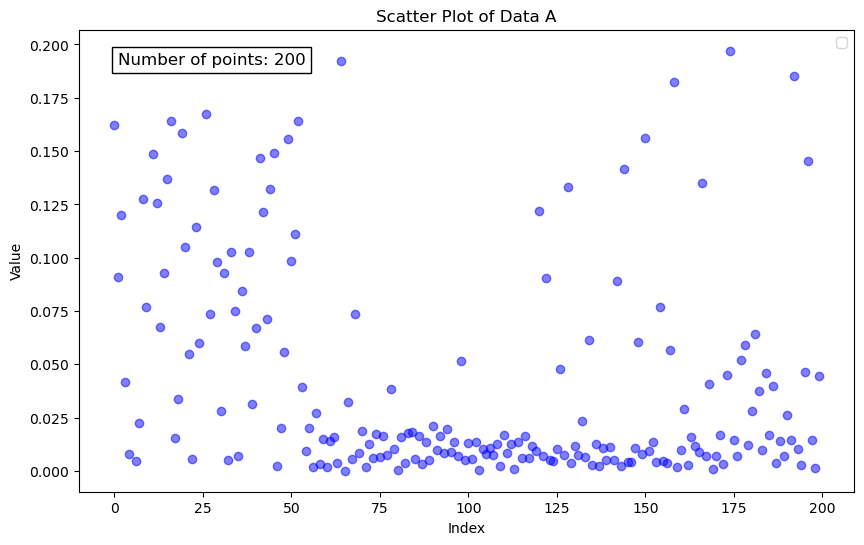

In [9]:
print(X_f_train.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f_train)), X_f_train, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(200, 1)


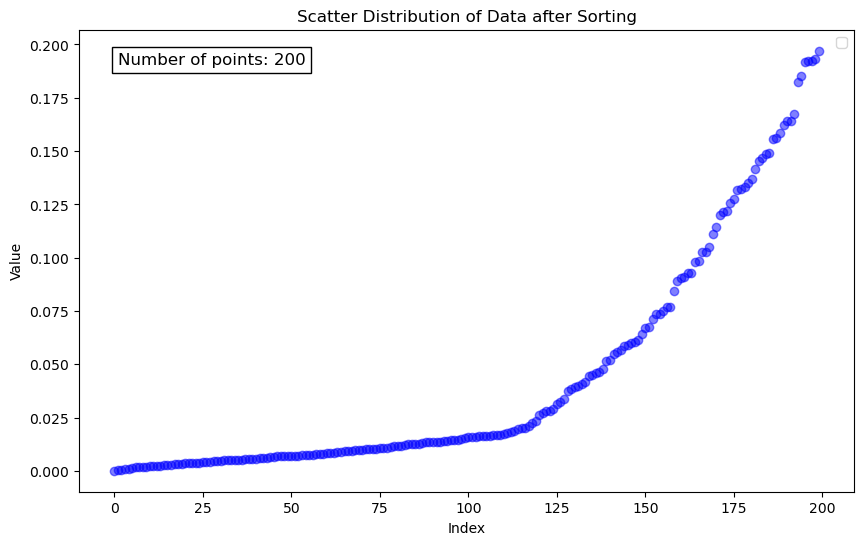

In [10]:
X = np.sort(X_f_train, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [11]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.005781504662791735, 0.005405741570095157, 0.006439562927446829, 0.004403675375795285, 0.005431864416192302, 0.005980585803943297, 0.006436624594651055, 0.004915770688075427, 0.006347509126852186, 0.0053023949463210885]
Error u of fuhe active learning(LHS sampling): 5.644523e-03
[0.0004949409559353595, 0.0004632251017503653, 0.0006317973167830743, 0.00038599748075172056, 0.00048100833631610024, 0.0005063601881899188, 0.0005386135642308995, 0.00044151166132071245, 0.0006172735299095301, 0.00044713972819798064]
MAE of fuhe active learning(LHS sampling): 5.007868e-04
[4.085323602470395e-06, 3.5716771883990117e-06, 5.067864944329779e-06, 2.37084644882874e-06, 3.606668618952751e-06, 4.371481713335166e-06, 5.0631459365645284e-06, 2.953443192779169e-06, 4.924373081301076e-06, 3.4364629984982424e-06]
MSE of fuhe active learning(LHS sampling): 3.945129e-06
[851.8264, 0.00023946725, 49.32827, 28.314983, 1.9579544, 0.0003650345, 0.0002231406, 0.054511335, 0.00016945845, 64.58425]
Chaos of fuhe 

[0.005781504662791735, 0.005405741570095157, 0.006439562927446829, 0.004403675375795285, 0.005431864416192302, 0.005980585803943297, 0.006436624594651055, 0.004915770688075427, 0.006347509126852186, 0.0053023949463210885]
mean Error u: 5.644523e-03
Variance Error u: 4.175480e-07


/home/extra_disk/lcy/PINN-1/medium_homogeneous_CTMC(suanlisan)/active learning/ipykernel_1436920/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


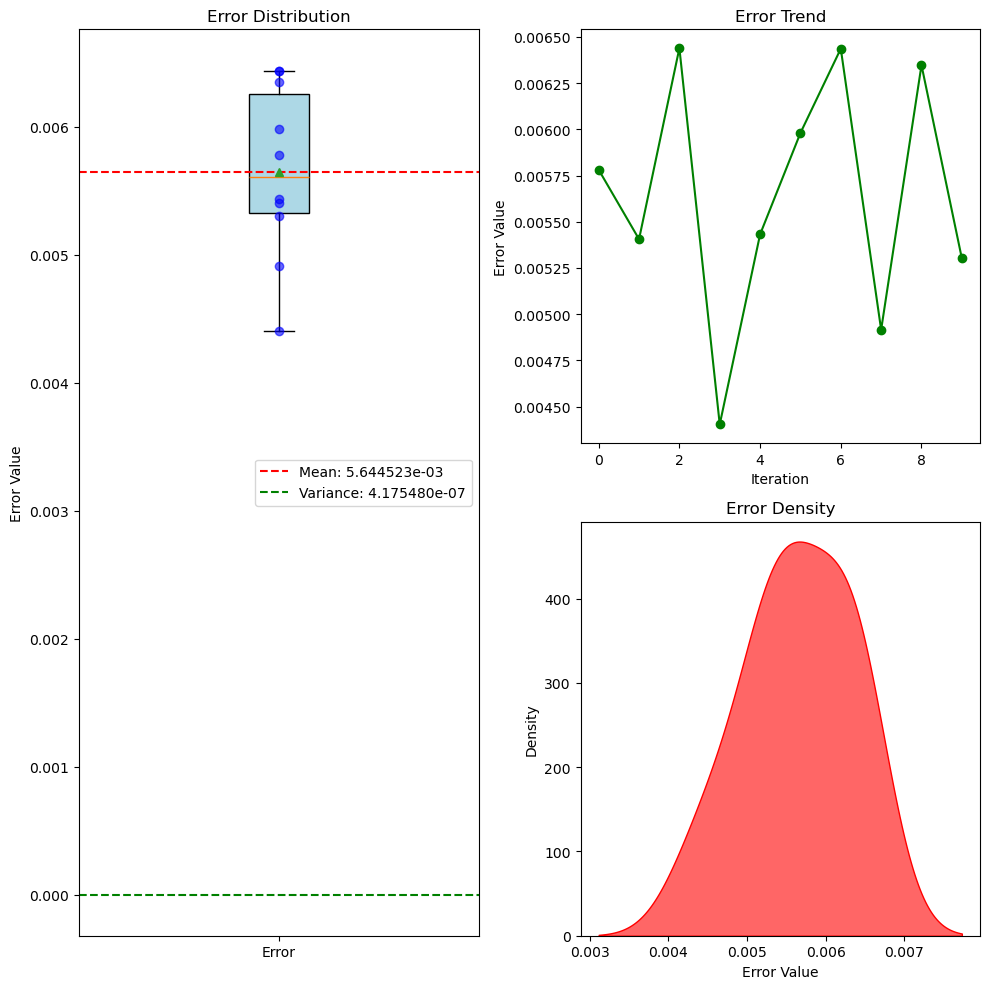

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

/home/extra_disk/lcy/PINN-1/medium_homogeneous_CTMC(suanlisan)/active learning/ipykernel_1436920/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


[0.0004949409559353595, 0.0004632251017503653, 0.0006317973167830743, 0.00038599748075172056, 0.00048100833631610024, 0.0005063601881899188, 0.0005386135642308995, 0.00044151166132071245, 0.0006172735299095301, 0.00044713972819798064]
mean MAE: 5.007868e-04
Variance MAE: 5.359922e-09


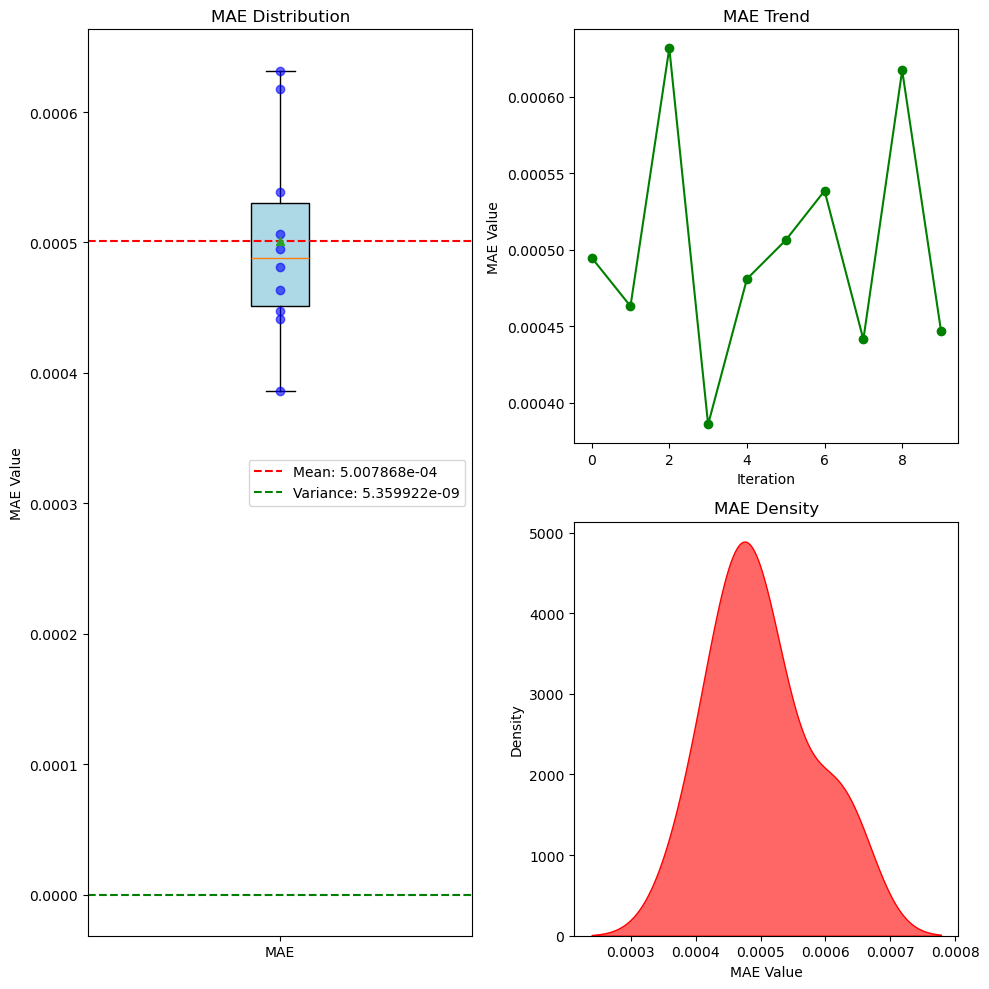

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[4.085323602470395e-06, 3.5716771883990117e-06, 5.067864944329779e-06, 2.37084644882874e-06, 3.606668618952751e-06, 4.371481713335166e-06, 5.0631459365645284e-06, 2.953443192779169e-06, 4.924373081301076e-06, 3.4364629984982424e-06]
mean MSE: 3.945129e-06
Variance MSE: 7.645417e-13


/home/extra_disk/lcy/PINN-1/medium_homogeneous_CTMC(suanlisan)/active learning/ipykernel_1436920/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


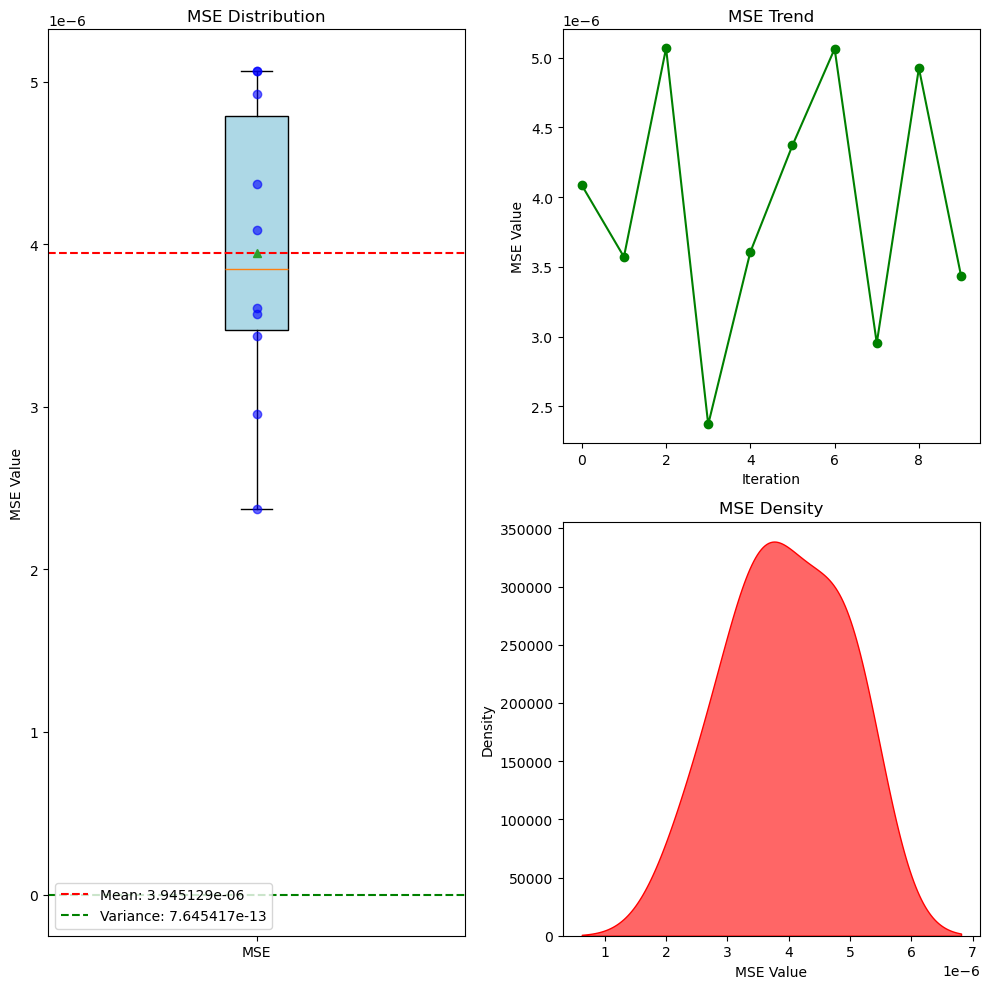

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[851.8264, 0.00023946725, 49.32827, 28.314983, 1.9579544, 0.0003650345, 0.0002231406, 0.054511335, 0.00016945845, 64.58425]
mean CHAOS: 9.960674e+01
Variance CHAOS: 6.338032e+04


/home/extra_disk/lcy/PINN-1/medium_homogeneous_CTMC(suanlisan)/active learning/ipykernel_1436920/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


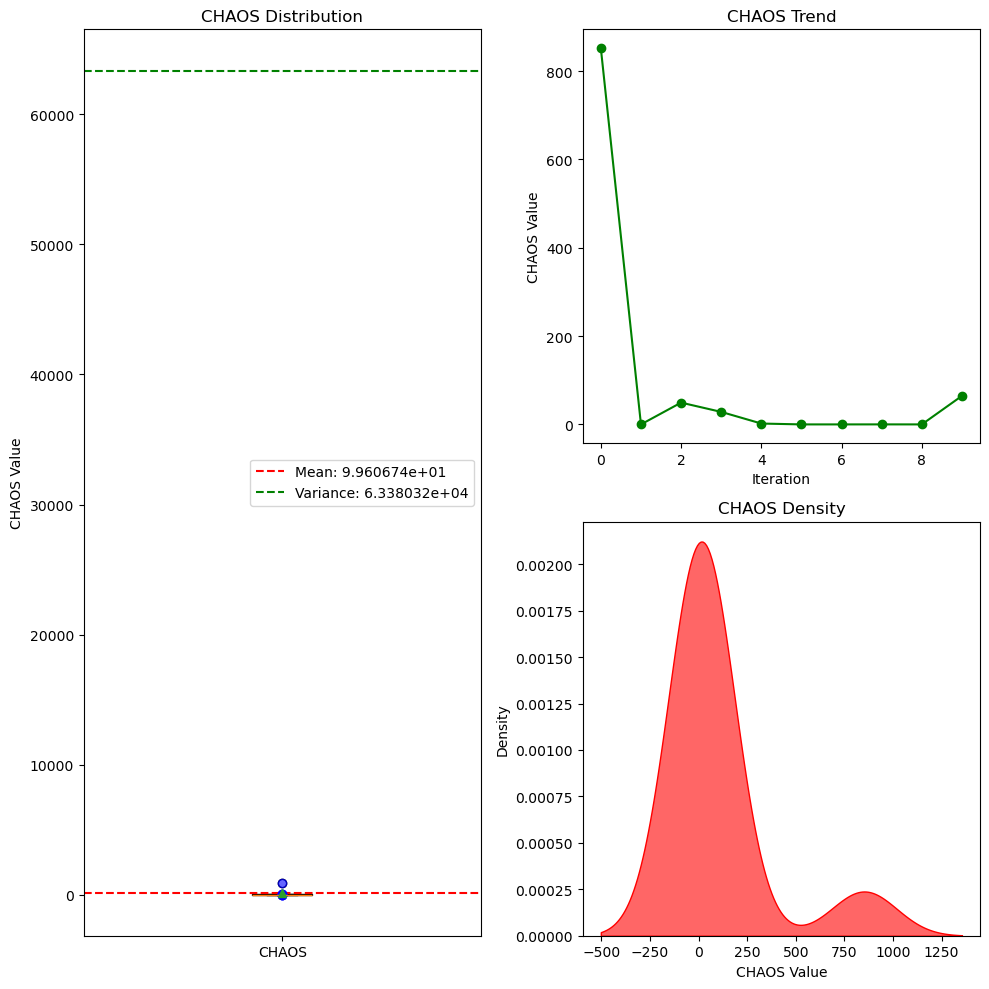

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0004540743, 0.0004437372, 0.00038987002, 0.0004456647, 0.0004997893, 0.00043041518, 0.0004491253, 0.00045259178, 0.00045467427, 0.00048455416]
mean RESIDUAL: 4.504496e-04
Variance RESIDUAL: 7.774072e-10


/home/extra_disk/lcy/PINN-1/medium_homogeneous_CTMC(suanlisan)/active learning/ipykernel_1436920/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


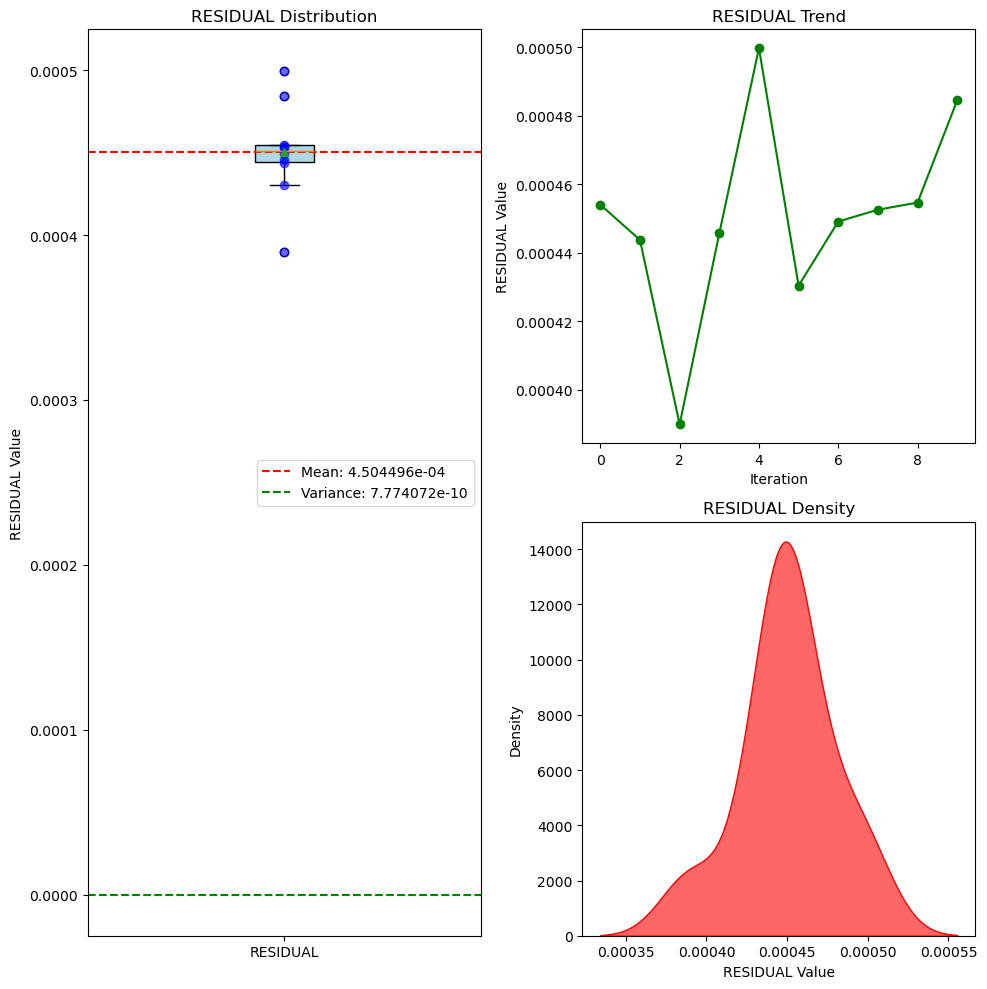

In [16]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [17]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

40000
[1.8198672e+03 1.7312441e+03 1.6583545e+03 ... 8.3696991e-03 8.3692418e-03
 8.3688702e-03]


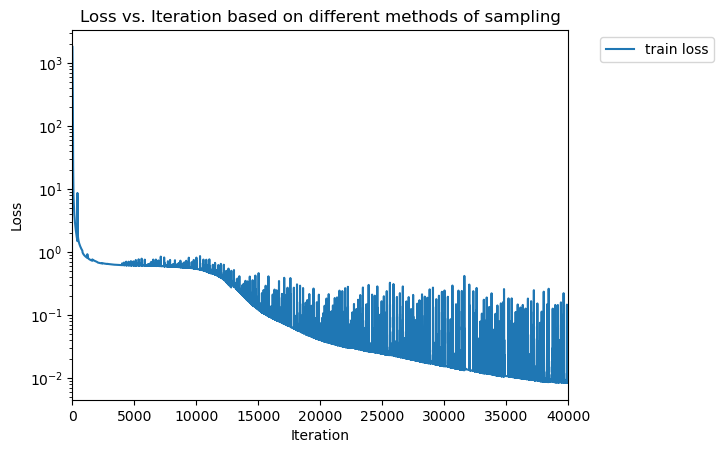

In [18]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,40000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

In [19]:
y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
print(y_pred_df.head())
print(y_pred_df.tail())
y_pred_df = get_system_performance(y_pred_df)
print(y_pred_df.head())
print(y_pred_df.tail())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.965548  0.009038  0.012382  0.012448  0.000152  0.000143  0.000206   
1  0.956601  0.011262  0.015717  0.015574  0.000218  0.000208  0.000299   
2  0.948171  0.013340  0.018862  0.018476  0.000295  0.000282  0.000407   
3  0.940131  0.015307  0.021862  0.021204  0.000383  0.000365  0.000528   
4  0.932417  0.017179  0.024742  0.023784  0.000481  0.000457  0.000663   

    state_8   state_9  state_10  state_11      state_12  
0  0.000072  0.000005  0.000002  0.000003  2.676490e-07  
1  0.000106  0.000008  0.000003  0.000004  3.400246e-07  
2  0.000147  0.000010  0.000004  0.000006  4.230913e-07  
3  0.000193  0.000013  0.000005  0.000007  5.185419e-07  
4  0.000244  0.000017  0.000007  0.000009  6.276173e-07  
      state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
495  0.757811  0.053046  0.094726  0.068882  0.006635  0.004825  0.008630   
496  0.757809  0.053046  0.094727  0.068882  0.

Text(0, 0.5, 'Probability')

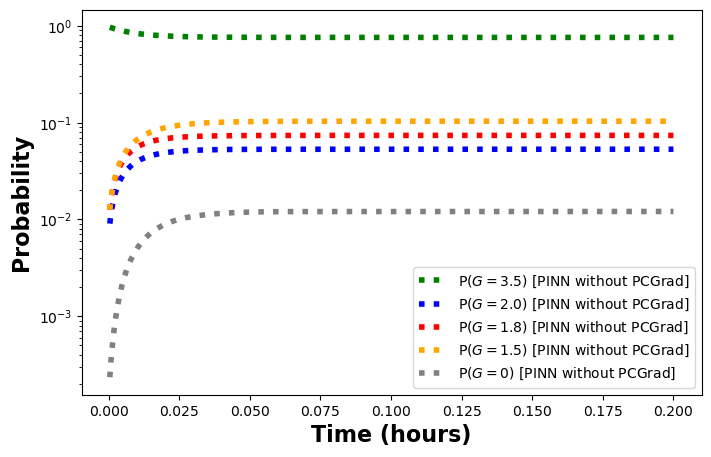

In [20]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

In [21]:
#解析解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
laplace_solution_df = pd.read_csv('analytical_solution_by_laplace_method.csv')
print(eigenvector_solution_df.head())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.989461  0.002719  0.003903  0.003874  0.000011  0.000011  0.000015   
1  0.979427  0.005285  0.007619  0.007508  0.000041  0.000041  0.000058   
2  0.969868  0.007706  0.011159  0.010919  0.000089  0.000087  0.000126   
3  0.960761  0.009993  0.014533  0.014121  0.000151  0.000147  0.000214   
4  0.952080  0.012153  0.017751  0.017129  0.000227  0.000219  0.000319   

    state_8       state_9      state_10      state_11      state_12  \
0  0.000005  4.199986e-08  1.479473e-08  2.123212e-08  5.835560e-11   
1  0.000021  3.151602e-07  1.117239e-07  1.610611e-07  8.690817e-10   
2  0.000045  9.982098e-07  3.560873e-07  5.156228e-07  4.096992e-09   
3  0.000077  2.221657e-06  7.974345e-07  1.159778e-06  1.206261e-08   
4  0.000115  4.076314e-06  1.472082e-06  2.150250e-06  2.744632e-08   

   system_3.5  system_2.0  system_1.8  system_1.5  system_0  
0    0.989461    0.002719    0.003885    0.003918  0.000016 

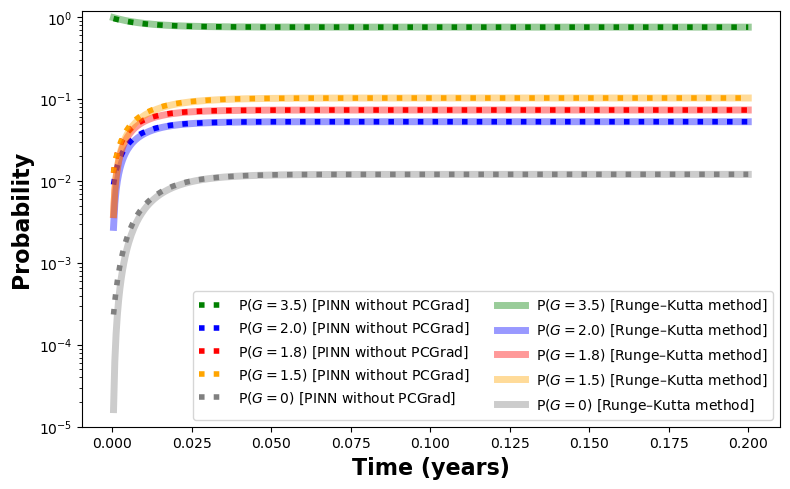

In [22]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [Runge–Kutta method]',
             color = 'green', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [Runge–Kutta method]',
             color = 'blue', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [Runge–Kutta method]',
             color = 'red', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [Runge–Kutta method]',
             color = 'orange', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [Runge–Kutta method]',
             color = 'gray', alpha=0.4, dashes=True, linewidth = 5)



ax.legend(ncol=2, fontsize=10)
ax.set_yscale("log")
ax.set_ylim([1e-5, 1.2])
ax.set_xlabel("Time (years)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)



plt.tight_layout()

### 计算RMSE

In [23]:
y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
y_diff_no_pcgrad_laplace = laplace_solution_df - y_pred_df

In [24]:
y_diff_no_pcgrad_eigenvectors['mse'] = y_diff_no_pcgrad_eigenvectors.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_eigenvectors['rmse'] = y_diff_no_pcgrad_eigenvectors['mse'].apply(np.sqrt)

y_diff_no_pcgrad_laplace['mse'] = y_diff_no_pcgrad_laplace.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_laplace['rmse'] = y_diff_no_pcgrad_laplace['mse'].apply(np.sqrt)

In [25]:
#这里的mse跟之前的MSE值不一样，其实是差了五倍，因为这里求均值是对500个数的和a除以500，而之前是对500*5个数的和（也是a）除以500*5
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['mse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['mse']))

RMSE of between PINN without PCGrad and the analytical solution is 1.7182314992491213e-05
RMSE of between PINN without PCGrad and the analytical solution is 1.7182314992489953e-05


In [26]:
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['rmse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['rmse']))

RMSE of between PINN without PCGrad and the analytical solution is 0.0012861502104686842
RMSE of between PINN without PCGrad and the analytical solution is 0.001286150210468723
